# Trabajo Fin de Máster
## HateSpeech Detection
### Autor: Óscar Toimil Plaza
#### Tutores: Marcos Fernández Pichel y Mario Ezra Aragón Saenzpardo

-------------------------------------------

## Imports

In [1]:
import pandas as pd
from pysentimiento import create_analyzer #!pip install pysentimiento
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Variables globales

In [84]:
DATASETS_NAME = {
    'SEMEVAL_2019_TRAIN': '../data/semeval2019_es_train_copia.csv',
    'SEMEVAL_2019_VAL': '../data/semeval2019_es_dev.csv',
    'SEMEVAL_2019_TEST': '../data/semeval2019_es_test.csv',
}

DATASETS_DELIMITERS = {
    'SEMEVAL_2019': '	',
}
SEED_VALUE = 1

-------------------------------------------

## Lectura datos

-----------------------------------------------

#### SEMEVAL 2019

In [85]:
df_semeval_train = pd.read_csv ( DATASETS_NAME['SEMEVAL_2019_TRAIN'],
        skiprows=1,
        header=None,
        names = ["id", "text", "hate_speech", "target_range", "aggressiveness"],
        delimiter=DATASETS_DELIMITERS['SEMEVAL_2019'])

----------------------------

## POS (Parts Of Speech)


-----------------------------------------------

### Todos los tweets

-----------------------------------------------


In [86]:
df_semeval_train.head()

id                                               text  hate_speech  \
0  20001  Easyjet quiere duplicar el número de mujeres p...            1   
1  20002  El gobierno debe crear un control estricto de ...            1   
2  20003  Yo veo a mujeres destruidas por acoso laboral ...            0   
3  20004  — Yo soy respetuoso con los demás, sólamente l...            0   
4  20007  Antonio Caballero y como ser de mal gusto e ig...            0   

   target_range  aggressiveness  
0             0               0  
1             0               0  
2             0               0  
3             0               0  
4             0               0

In [87]:
pos_tagger = create_analyzer("pos", lang="es")

In [88]:
#Ejemplo de la documentacion
pos_tagger.predict("Me llamo Juan Manuel Pérez y vivo en Argentina")

TokenClassificationOutput(tokens=['Me', 'llamo', 'Juan', 'Manuel', 'Pérez', 'y', 'vivo', 'en', 'Argentina'], labels=['PRON', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'CONJ', 'VERB', 'ADP', 'PROPN'])

In [89]:
#detectado un error que tienen en la implementacion de la libreria con algunos emojis como 🤦‍♀️, se eliminaron cuando había alguno de estos conflictivo en una copia del archivo
pos_tagger.predict("El feminismo de Lamas 🤦‍♀️...justificando cultura de violación y acoso, muy desatinado! Lamas representa el white feminism incapaz de ver más allá de sus privilegios. Gracias @catalinapordios por el despliegue de sensatez. https://t.co/sNJYO3oPqG")

In [90]:
def analyze_pos_tags(text):
    result = pos_tagger.predict(text.lower())
    pos_tags = list(zip(result.tokens, result.labels))

    print(f"Texto analizado: {text}")
    print(f"Etiquetas encontradas: {pos_tags}")

    pos_tags = [(token, label) for token, label in pos_tags if label is not None]

    if not pos_tags:
        return {}, None, []

    tag_counts = Counter([tag for _, tag in pos_tags])
    total_tags = sum(tag_counts.values())
    pos_type_percentages = {tag: (count / total_tags) * 100 for tag, count in tag_counts.items()}

    most_frequent_tag = max(tag_counts, key=tag_counts.get, default=None)

    return pos_type_percentages, most_frequent_tag, pos_tags

In [91]:
# Analizar POS en los textos
text_data = df_semeval_train['text'].tolist()
results = [analyze_pos_tags(text) for text in tqdm(text_data)]







  0%|          | 0/4497 [00:00<?, ?it/s]





  0%|          | 8/4497 [00:00<00:58, 76.52it/s]





  0%|          | 17/4497 [00:00<00:54, 81.63it/s]

Texto analizado: Easyjet quiere duplicar el número de mujeres piloto' Verás tú para aparcar el avión.. http://t.co/46NuLkm09x
Etiquetas encontradas: [('easyjet', 'NOUN'), ('quiere', 'AUX'), ('duplicar', 'VERB'), ('el', 'DET'), ('número', 'NOUN'), ('de', 'ADP'), ('mujeres', 'NOUN'), ('piloto', 'NOUN'), ("'", 'PUNCT'), ('verás', 'VERB'), ('tú', 'PRON'), ('para', 'ADP'), ('aparcar', 'VERB'), ('el', 'DET'), ('avión', 'NOUN'), ('..', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: El gobierno debe crear un control estricto de inmigración en las zonas fronterizas con Colombia por q después del 20-8querrán venir en masa
Etiquetas encontradas: [('el', 'DET'), ('gobierno', 'NOUN'), ('debe', 'AUX'), ('crear', 'VERB'), ('un', 'DET'), ('control', 'NOUN'), ('estricto', 'ADJ'), ('de', 'ADP'), ('inmigración', 'NOUN'), ('en', 'ADP'), ('las', 'DET'), ('zonas', 'NOUN'), ('fronterizas', 'ADJ'), ('con', 'ADP'), ('colombia', 'NOUN'), ('por', 'ADP'), ('q', 'SCONJ'), ('después', 'ADV'), ('del', 'DET'), ('20-8que







  1%|          | 26/4497 [00:00<00:54, 81.62it/s]





  1%|          | 35/4497 [00:00<00:53, 82.65it/s]

Texto analizado: VAMOOOO LA PUTA MADRE SE LO MERECÍA TANTO ESFUERZO Y HABER PASADO TANTOS TELÉFONOS NECESITÁBAMOS ESTE DESCANSO #SoltarteNoEstáEnMisPlanesMica
Etiquetas encontradas: [('vamooo', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('se', 'PRON'), ('lo', 'PRON'), ('merecía', 'VERB'), ('tanto', 'DET'), ('esfuerzo', 'NOUN'), ('y', 'CONJ'), ('haber', 'AUX'), ('pasado', 'VERB'), ('tantos', 'DET'), ('teléfonos', 'NOUN'), ('necesitábamos', 'VERB'), ('este', 'DET'), ('descanso', 'NOUN'), ('hashtag', 'NOUN'), ('soltartenoestáenmisplanesmica', 'VERB')]
Texto analizado: Pd a ver si cierran de una puta vez Tv3 que no sé todavía qué servicio público ofrece para que merezca dinero de nuestros impuestos o solo hace daño que roben unos?
Etiquetas encontradas: [('pd', 'INTJ'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('cierran', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('tv3', 'PROPN'), ('que', 'SCONJ'), ('no', 'ADV'), ('sé', 'VERB'), ('tod







  1%|          | 44/4497 [00:00<00:53, 83.15it/s]





  1%|          | 53/4497 [00:00<00:53, 83.77it/s]

Texto analizado: @AgusMariano17 @astrobrix @saintlean asi le digo a tu mami callate perra
Etiquetas encontradas: [('@agusmariano17', 'USER'), ('@astrobrix', 'USER'), ('@saintlean', 'USER'), ('asi', 'ADV'), ('le', 'PRON'), ('digo', 'VERB'), ('a', 'ADP'), ('tu', 'DET'), ('mami', 'NOUN'), ('callate', 'VERB'), ('perra', 'NOUN')]
Texto analizado: @intonarumori13 Cállate y ven ya joder hostia puta
Etiquetas encontradas: [('@intonarumori13', 'USER'), ('cállate', 'VERB'), ('y', 'CONJ'), ('ven', 'VERB'), ('ya', 'ADV'), ('joder', 'INTJ'), ('hostia', 'INTJ'), ('puta', 'NOUN')]
Texto analizado: Dos amigos hablando: -Raúl, q me das por mi mujer? -Nada -Trato hecho.
Etiquetas encontradas: [('dos', 'NUM'), ('amigos', 'NOUN'), ('hablando', 'VERB'), (':', 'PUNCT'), ('-raúl', 'INTJ'), (',', 'PUNCT'), ('q', 'PRON'), ('me', 'PRON'), ('das', 'VERB'), ('por', 'ADP'), ('mi', 'DET'), ('mujer', 'NOUN'), ('?', 'PUNCT'), ('-nada', 'INTJ'), ('-trato', 'DET'), ('hecho', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @A







  1%|▏         | 62/4497 [00:00<00:53, 82.63it/s]





  2%|▏         | 71/4497 [00:00<00:52, 83.71it/s]

Texto analizado: @Laura99CM Ahora que me has faltado el respeto te lo puedo decir por fin: ¡A fregar puta!
Etiquetas encontradas: [('@laura99', 'USER'), ('cm', 'NOUN'), ('ahora', 'ADV'), ('que', 'SCONJ'), ('me', 'PRON'), ('has', 'AUX'), ('faltado', 'VERB'), ('el', 'DET'), ('respeto', 'NOUN'), ('te', 'PRON'), ('lo', 'PRON'), ('puedo', 'AUX'), ('decir', 'VERB'), ('por', 'ADP'), ('fin', 'NOUN'), (':', 'PUNCT'), ('¡', 'PUNCT'), ('a', 'ADP'), ('fregar', 'VERB'), ('puta', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: Me mandan esta mierda. Cultura de la violación en sus mejores pantallas. ESCORIA. Se puede hacer algo @policia ? https://t.co/vGmcVPSO7B
Etiquetas encontradas: [('me', 'PRON'), ('mandan', 'VERB'), ('esta', 'DET'), ('mierda', 'NOUN'), ('.', 'PUNCT'), ('cultura', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('violación', 'NOUN'), ('en', 'ADP'), ('sus', 'DET'), ('mejores', 'ADJ'), ('pantallas', 'NOUN'), ('.', 'PUNCT'), ('escoria', 'NOUN'), ('.', 'PUNCT'), ('se', 'PRON'), ('puede', 'AUX'), ('







  2%|▏         | 80/4497 [00:00<00:56, 78.17it/s]

Texto analizado: -¿Porque la esatua de la libertad es mujer? -Porque se nescesitaba una cabeza hueca para hacer un mirador
Etiquetas encontradas: [('-¿porque', 'INTJ'), ('la', 'DET'), ('esatua', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('libertad', 'NOUN'), ('es', 'VERB'), ('mujer', 'NOUN'), ('?', 'PUNCT'), ('-porque', 'INTJ'), ('se', 'PRON'), ('nescesitaba', 'VERB'), ('una', 'DET'), ('cabeza', 'NOUN'), ('hueca', 'ADJ'), ('para', 'ADP'), ('hacer', 'VERB'), ('un', 'DET'), ('mirador', 'NOUN')]
Texto analizado: Comemela XDDD y la cara también!! 🤣🤣🤣🤣🤣 — No nos pasemos 👀 https://t.co/t3o5yHY0zb
Etiquetas encontradas: [('comemela', 'INTJ'), ('xddd', 'INTJ'), ('y', 'CONJ'), ('la', 'DET'), ('cara', 'NOUN'), ('también', 'ADV'), ('!', 'PUNCT'), ('!', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('revolviéndose', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('revolviéndose', 'ADJ'), ('de', 'ADP'), ('la'







  2%|▏         | 89/4497 [00:01<00:55, 79.37it/s]





  2%|▏         | 98/4497 [00:01<00:54, 81.42it/s]

Texto analizado: @ash_london CALLATE PERRA LOCA CON METERTE CON LOUIS YA ES MUCHO . TE METES CON BARDERAS
Etiquetas encontradas: [('@ash_london', 'USER'), ('callate', 'VERB'), ('perra', 'NOUN'), ('loca', 'ADJ'), ('con', 'ADP'), ('meterte', 'VERB'), ('con', 'ADP'), ('louis', 'PROPN'), ('ya', 'ADV'), ('es', 'VERB'), ('mucho', 'ADV'), ('.', 'PUNCT'), ('te', 'PRON'), ('metes', 'VERB'), ('con', 'ADP'), ('barderas', 'NOUN')]
Texto analizado: Yo no te discuto como sacar una muela así que cállate la puta madre
Etiquetas encontradas: [('yo', 'PRON'), ('no', 'ADV'), ('te', 'PRON'), ('discuto', 'VERB'), ('como', 'ADV'), ('sacar', 'VERB'), ('una', 'DET'), ('muela', 'NOUN'), ('así', 'ADV'), ('que', 'SCONJ'), ('cállate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN')]
Texto analizado: ¿para que se inventó el alcohol? para que las feas, gordas y canis perdieran la virginidad.
Etiquetas encontradas: [('¿', 'PUNCT'), ('para', 'ADP'), ('que', 'SCONJ'), ('se', 'PRON'), ('inventó', 'VERB'), ('







  2%|▏         | 107/4497 [00:01<00:54, 81.15it/s]





  3%|▎         | 116/4497 [00:01<00:56, 76.89it/s]

Texto analizado: @20m Lastima.... callate zorra!!!!!!!😠😠😠💩💩💩💩💩💩
Etiquetas encontradas: [('@20', 'USER'), ('m', 'INTJ'), ('lastima', 'INTJ'), ('...', 'INTJ'), ('callate', 'INTJ'), ('zorra', 'INTJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'NOUN'), ('emoji', 'ADV'), ('cara', 'ADV'), ('enfadada', 'ADV'), ('emoji', 'ADV'), (' ', 'NOUN'), ('emoji', 'ADV'), ('cara', 'NOUN'), ('enfadada', 'INTJ'), ('emoji', 'ADV'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'ADV'), ('enfadada', 'ADV'), ('emoji', 'ADV'), (' ', 'NOUN'), ('emoji', 'ADV'), ('caca', 'NOUN'), ('con', 'ADP'), ('ojos', 'NOUN'), ('emoji', 'ADV'), (' ', 'NOUN'), ('emoji', 'ADV'), ('caca', 'NOUN'), ('con', 'ADP'), ('ojos', 'NOUN'), ('emoji', 'ADV'), (' ', 'NOUN'), ('emoji', 'ADV'), ('caca', 'NOUN'), ('con', 'ADP'), ('ojos', 'NOUN'), ('emoji', 'ADV')]
Texto analizado: @lauty489 Merecias ser ahogado hijo de perra pero mildis
Etiquetas encontradas: [('@lauty489', 'USER'), ('merecias', 'VERB'), ('ser', 'VERB'), ('ahogado', 'ADJ'), ('hijo', 'N







  3%|▎         | 124/4497 [00:01<00:56, 76.89it/s]





  3%|▎         | 133/4497 [00:01<00:55, 78.64it/s]

Texto analizado: @YolandaNeed Callate perra yo hago lo que quiero
Etiquetas encontradas: [('@yolandaneed', 'USER'), ('callate', 'VERB'), ('perra', 'NOUN'), ('yo', 'PRON'), ('hago', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('quiero', 'VERB')]
Texto analizado: me acaban aqui de enseñar al niño polla o deberia decir PRINGADO DE LA VIDA Q LO UNICO Q HA HECHO EN SU VIDA (indirectamente) ES TENER UNA POLLA GRANDE.... QUE. PUTO. ASCAZO. NIÑO.
Etiquetas encontradas: [('me', 'PRON'), ('acaban', 'AUX'), ('aqui', 'ADV'), ('de', 'ADP'), ('enseñar', 'VERB'), ('al', 'ADP'), ('niño', 'NOUN'), ('polla', 'NOUN'), ('o', 'CONJ'), ('deberia', 'AUX'), ('decir', 'VERB'), ('pringado', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('vida', 'NOUN'), ('q', 'PRON'), ('lo', 'DET'), ('unico', 'ADJ'), ('q', 'PRON'), ('ha', 'AUX'), ('hecho', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('vida', 'NOUN'), ('(', 'PUNCT'), ('indirectamente', 'ADV'), (')', 'PUNCT'), ('es', 'VERB'), ('tener', 'VERB'), ('una', 'DET'), ('polla', 'NOUN'),







  3%|▎         | 141/4497 [00:01<00:55, 78.75it/s]





  3%|▎         | 150/4497 [00:01<00:54, 80.10it/s]

Texto analizado: @lammothsenpai el simio fuenlabreño al cual tengo que ver más a menudo. Eres un tío de puta madre y te mereces lo mejor del mundo. Espero que en 2018 te vaya todo de lujo y empieces por la puerta grande.
Etiquetas encontradas: [('@lammothsenpai', 'USER'), ('el', 'DET'), ('simio', 'NOUN'), ('fuenlabreño', 'ADJ'), ('al', 'ADP'), ('cual', 'PRON'), ('tengo', 'AUX'), ('que', 'SCONJ'), ('ver', 'VERB'), ('más', 'ADV'), ('a', 'ADP'), ('menudo', 'NOUN'), ('.', 'PUNCT'), ('eres', 'VERB'), ('un', 'DET'), ('tío', 'NOUN'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('y', 'CONJ'), ('te', 'PRON'), ('mereces', 'VERB'), ('lo', 'DET'), ('mejor', 'ADJ'), ('del', 'ADP'), ('mundo', 'NOUN'), ('.', 'PUNCT'), ('espero', 'VERB'), ('que', 'SCONJ'), ('en', 'ADP'), ('2018', 'NOUN'), ('te', 'PRON'), ('vaya', 'VERB'), ('todo', 'PRON'), ('de', 'ADP'), ('lujo', 'NOUN'), ('y', 'CONJ'), ('empieces', 'VERB'), ('por', 'ADP'), ('la', 'DET'), ('puerta', 'NOUN'), ('grande', 'ADJ'), ('.', 'PUNCT')]
T







  4%|▎         | 159/4497 [00:02<01:03, 68.78it/s]

Texto analizado: Esa gente insultando y condenando al asesino de Diana Quer pero que luego le quitan importancia al acoso, violación y maltrato a la mujer...
Etiquetas encontradas: [('esa', 'DET'), ('gente', 'NOUN'), ('insultando', 'VERB'), ('y', 'CONJ'), ('condenando', 'VERB'), ('al', 'ADP'), ('asesino', 'NOUN'), ('de', 'ADP'), ('diana', 'NOUN'), ('quer', 'NOUN'), ('pero', 'CONJ'), ('que', 'SCONJ'), ('luego', 'ADV'), ('le', 'PRON'), ('quitan', 'VERB'), ('importancia', 'NOUN'), ('al', 'ADP'), ('acoso', 'NOUN'), (',', 'PUNCT'), ('violación', 'NOUN'), ('y', 'CONJ'), ('maltrato', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @Ndemoniado @Zurine3 Coño hay una GRAN cantidad de vídeos porno amateur y son bastante buscados la verdad, porque son chicas 'normales', la gente se imagina su vecina, su amiga, etc. Bueno, pero ¿que tiene que ver? Habláis del porno como tal no de sus cir
Etiquetas encontradas: [('@ndemoniado', 'USER'), ('@zurine3', 'USER'







  4%|▎         | 167/4497 [00:02<01:10, 61.01it/s]

Texto analizado: QUE NO SON NI LAS OCHO DE LA MAÑANA, CALLATE Y ECHATE A DORMIR EN VEZ DE HABLAR DE LA PUTA ESPICHA.
Etiquetas encontradas: [('que', 'SCONJ'), ('no', 'ADV'), ('son', 'VERB'), ('ni', 'ADV'), ('las', 'DET'), ('ocho', 'NUM'), ('de', 'ADP'), ('la', 'DET'), ('mañana', 'NOUN'), (',', 'PUNCT'), ('callate', 'VERB'), ('y', 'CONJ'), ('echate', 'VERB'), ('a', 'ADP'), ('dormir', 'VERB'), ('en', 'ADP'), ('vez', 'NOUN'), ('de', 'ADP'), ('hablar', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('espicha', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @PSOE y @ahorapodemos están deseosos de ayudar a los moromierdas que llegan en oleadas a violar todas las mujeres y niños que puedan. Y oye, si se legaliza mejor, ¿eh @sanchezcastejon @ManuelaCarmena ? EL PROBLEMA ES QUE ESTO NUNCA LES PASA A SUS HIJOS Y NIETOS. LASTIMA! https://t.co/Ro8kL0MNPM
Etiquetas encontradas: [('@psoe', 'USER'), ('y', 'CONJ'), ('@ahorapodemos', 'USER'), ('están', 'VERB'), ('deseosos', 'ADJ'), ('de', 'ADP'), (







  4%|▍         | 174/4497 [00:02<01:14, 57.89it/s]





  4%|▍         | 181/4497 [00:02<01:13, 58.50it/s]

Texto analizado: @cirovitale__ yo se q soy la persona indicada para estos momentos, no te lo mereces, pero sos mi hermano hijo de mil puta, ahi t hablo
Etiquetas encontradas: [('@cirovitale', 'USER'), ('_', 'INTJ'), ('_', 'INTJ'), ('yo', 'PRON'), ('se', 'VERB'), ('q', 'SCONJ'), ('soy', 'VERB'), ('la', 'DET'), ('persona', 'NOUN'), ('indicada', 'ADJ'), ('para', 'ADP'), ('estos', 'DET'), ('momentos', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('lo', 'PRON'), ('mereces', 'VERB'), (',', 'PUNCT'), ('pero', 'CONJ'), ('sos', 'VERB'), ('mi', 'DET'), ('hermano', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('mil', 'NUM'), ('puta', 'NOUN'), (',', 'PUNCT'), ('ahi', 'ADV'), ('t', 'PRON'), ('hablo', 'VERB')]
Texto analizado: Hablemos de la paliza al turista americano por manteros subsaharianos , esos que entran echando cal viva a la guardia civil  ... no mejor volvemos a lo de Franco que fue muy malo y evitó muchas checas y gulags si no llega a levantarse en esa anárquica España #l6nverano







  4%|▍         | 188/4497 [00:02<01:11, 60.27it/s]





  4%|▍         | 195/4497 [00:02<01:10, 61.40it/s]

Texto analizado: El inmigrante que se queja del inmigrante que se queja del inmigrante ... y así hasta el infinito. https://t.co/0js3tanLyU
Etiquetas encontradas: [('el', 'DET'), ('inmigrante', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('queja', 'VERB'), ('del', 'ADP'), ('inmigrante', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('queja', 'VERB'), ('del', 'ADP'), ('inmigrante', 'NOUN'), ('...', 'PUNCT'), ('y', 'CONJ'), ('así', 'ADV'), ('hasta', 'ADP'), ('el', 'DET'), ('infinito', 'ADJ'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Te puedo tener todo el respeto del mundo, pero esque con una puta voz que me des ya no te lo mereces. Entenderlo respeto por respeto.
Etiquetas encontradas: [('te', 'PRON'), ('puedo', 'AUX'), ('tener', 'VERB'), ('todo', 'DET'), ('el', 'DET'), ('respeto', 'NOUN'), ('del', 'ADP'), ('mundo', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('esque', 'SCONJ'), ('con', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('voz', 'NOUN'), ('que', 'PRON'), ('me', 'PRON'), ('des', 







  4%|▍         | 202/4497 [00:02<01:09, 61.96it/s]





  5%|▍         | 209/4497 [00:02<01:11, 59.72it/s]

Texto analizado: Del árbol del silencio pende el fruto de la seguridad-Proverbio Árabe
Etiquetas encontradas: [('del', 'ADP'), ('árbol', 'NOUN'), ('del', 'ADP'), ('silencio', 'NOUN'), ('pende', 'VERB'), ('el', 'DET'), ('fruto', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('seguridad-proverbio', 'NOUN'), ('árabe', 'NOUN')]
Texto analizado: cuando no tengo a nico mi novia es mi perra https://t.co/29fdEJWVjN
Etiquetas encontradas: [('cuando', 'SCONJ'), ('no', 'ADV'), ('tengo', 'VERB'), ('a', 'ADP'), ('nico', 'NOUN'), ('mi', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('mi', 'DET'), ('perra', 'NOUN'), ('url', 'DET')]
Texto analizado: Estoy FLIPANDO. Le estaba diciendo a este chico que mi padre pegaba e insultaba a mi madre, que tiene dos denuncias por violencia de género y órdenes de alejamiento y se puso a decirme que él jamás pensaría que la mujer tiene razón, que si eso me pasó a mí es porque soy árabe https://t.co/JERLbuZynK
Etiquetas encontradas: [('estoy', 'AUX'), ('flipando', 'VERB'), ('.







  5%|▍         | 216/4497 [00:03<01:09, 61.46it/s]





  5%|▍         | 223/4497 [00:03<01:08, 62.24it/s]

Texto analizado: @Arthur_Zh69 CÓMO QUE TE FOLLAS A UNA PERRA Y OLVIDAS SU NOMBRE:0 Sí, bebé, me gusta mucho tu inglés, podrías enseñarme un poco
Etiquetas encontradas: [('@arthur_zh69', 'USER'), ('cómo', 'ADV'), ('que', 'SCONJ'), ('te', 'PRON'), ('follas', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('perra', 'NOUN'), ('y', 'CONJ'), ('olvidas', 'VERB'), ('su', 'DET'), ('nombre:0', 'NOUN'), ('sí', 'INTJ'), (',', 'PUNCT'), ('bebé', 'NOUN'), (',', 'PUNCT'), ('me', 'PRON'), ('gusta', 'VERB'), ('mucho', 'ADV'), ('tu', 'DET'), ('inglés', 'NOUN'), (',', 'PUNCT'), ('podrías', 'AUX'), ('enseñarme', 'VERB'), ('un', 'DET'), ('poco', 'ADV')]
Texto analizado: @Relatofeminista @elsadurst la educación sexual también es aprender que las mujeres con polla existen y son víctimas de violacion... Violan los hombres no las pollas.
Etiquetas encontradas: [('@relatofeminista', 'USER'), ('@elsadurst', 'USER'), ('la', 'DET'), ('educación', 'NOUN'), ('sexual', 'ADJ'), ('también', 'ADV'), ('es', 'VERB'), ('aprender',







  5%|▌         | 230/4497 [00:03<01:07, 63.49it/s]





  5%|▌         | 237/4497 [00:03<01:05, 64.68it/s]

Texto analizado: Uno de los refugiados del Aquarius: "Me obligaron a violar a menores y animales durante meses" (Al final los más racistas y esclavistas son otros africanos. Por eso hay que solucionar el problema un situ. Si no las mafias ganan)  https://t.co/IQLcfBOY7m vía @elmundoes
Etiquetas encontradas: [('uno', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('refugiados', 'NOUN'), ('del', 'ADP'), ('aquarius', 'NOUN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('me', 'PRON'), ('obligaron', 'VERB'), ('a', 'ADP'), ('violar', 'VERB'), ('a', 'ADP'), ('menores', 'ADJ'), ('y', 'CONJ'), ('animales', 'NOUN'), ('durante', 'ADP'), ('meses', 'NOUN'), ('"', 'PUNCT'), ('(', 'PUNCT'), ('al', 'ADP'), ('final', 'NOUN'), ('los', 'DET'), ('más', 'ADV'), ('racistas', 'ADJ'), ('y', 'CONJ'), ('esclavistas', 'NOUN'), ('son', 'VERB'), ('otros', 'DET'), ('africanos', 'NOUN'), ('.', 'PUNCT'), ('por', 'ADP'), ('eso', 'PRON'), ('hay', 'AUX'), ('que', 'SCONJ'), ('solucionar', 'VERB'), ('el', 'DET'), ('problema', 'NOUN'), ('un







  5%|▌         | 244/4497 [00:03<01:08, 62.26it/s]





  6%|▌         | 251/4497 [00:03<01:10, 59.92it/s]

Texto analizado: @drawman675 @Otrafachamas1 @ForretsGump Tu no te mereces q yo me esfuerce en poner ni una #puta coma para q te ahogues al leer #bastardo
Etiquetas encontradas: [('@drawman675', 'USER'), ('@otrafachamas1', 'USER'), ('@forretsgump', 'USER'), ('tu', 'DET'), ('no', 'ADV'), ('te', 'PRON'), ('mereces', 'VERB'), ('q', 'SCONJ'), ('yo', 'PRON'), ('me', 'PRON'), ('esfuerce', 'VERB'), ('en', 'ADP'), ('poner', 'VERB'), ('ni', 'ADV'), ('una', 'DET'), ('hashtag', 'NOUN'), ('puta', 'ADJ'), ('coma', 'NOUN'), ('para', 'ADP'), ('q', 'SCONJ'), ('te', 'PRON'), ('ahogues', 'VERB'), ('al', 'ADP'), ('leer', 'VERB'), ('hashtag', 'DET'), ('bastardo', 'NOUN')]
Texto analizado: @ronuevo @FCBarcelona_es Bobo hijo de perra, usted cree que va a enseñarle a Messi o llega a aprender del más grande?
Etiquetas encontradas: [('@ronuevo', 'USER'), ('@fcbarcelona_es', 'USER'), ('bobo', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('perra', 'NOUN'), (',', 'PUNCT'), ('usted', 'PRON'), ('cree', 'VERB'), ('que', 







  6%|▌         | 258/4497 [00:03<01:12, 58.16it/s]

Texto analizado: @tamaraasavio jajajajajaj soy imbecil tremeno acoso a tu tuiti pobre ajajajjaa yo + <3
Etiquetas encontradas: [('@tamaraasavio', 'USER'), ('jaja', 'INTJ'), ('soy', 'VERB'), ('imbecil', 'ADJ'), ('tremeno', 'ADJ'), ('acoso', 'NOUN'), ('a', 'ADP'), ('tu', 'DET'), ('tuiti', 'NOUN'), ('pobre', 'ADJ'), ('jaja', 'INTJ'), ('yo', 'PRON'), ('+', 'DET'), ('<3', 'NUM')]
Texto analizado: Sigue la peligrosisima tendencia integrista y anti arabe de Netanyahu con el silencio complice de la mayoria israeli y USA: Miles protestaron contra el Estado judío | Multitudinaria manifestación en Israel en contra del decreto de Netanyahu https://t.co/WXm0lpLZo7 vía @Pagina12
Etiquetas encontradas: [('sigue', 'VERB'), ('la', 'DET'), ('peligrosisima', 'ADJ'), ('tendencia', 'NOUN'), ('integrista', 'ADJ'), ('y', 'CONJ'), ('anti', 'ADJ'), ('arabe', 'ADJ'), ('de', 'ADP'), ('netanyahu', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('silencio', 'NOUN'), ('complice', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('ma







  6%|▌         | 264/4497 [00:03<01:15, 55.73it/s]





  6%|▌         | 270/4497 [00:03<01:19, 52.99it/s]

Texto analizado: Juez reafirma orden a Trump de reactivar el programa DACA para jóvenes indocumentados. #AgendaPública https://t.co/YIvr3P9jMq https://t.co/xKCrNdyxgh
Etiquetas encontradas: [('juez', 'NOUN'), ('reafirma', 'VERB'), ('orden', 'NOUN'), ('a', 'ADP'), ('trump', 'NOUN'), ('de', 'ADP'), ('reactivar', 'VERB'), ('el', 'DET'), ('programa', 'NOUN'), ('daca', 'ADJ'), ('para', 'ADP'), ('jóvenes', 'ADJ'), ('indocumentados', 'ADJ'), ('.', 'PUNCT'), ('hashtag', 'NOUN'), ('agendapública', 'NOUN'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Todos los pueblos! TODOS!! Tienen Dcho a la LIBREDETERMINACIÓN ! Que a estas alturas, tenga que aguantar a un Chileno indocumentado que,  viniendo de donde viene, pretende negarme mi legítimo Dcho a la LIBREDETERMINACIÓN, es el ACABOSE! El colonialismo de proximidad tb se acaba
Etiquetas encontradas: [('todos', 'DET'), ('los', 'DET'), ('pueblos', 'NOUN'), ('!', 'PUNCT'), ('todos', 'PRON'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('tienen', 'VERB'), (







  6%|▌         | 276/4497 [00:04<01:24, 49.76it/s]





  6%|▋         | 282/4497 [00:04<01:25, 49.02it/s]

Texto analizado: #AñoNuevoEnCombate zorra callateeedd 😡😡😡😡😡👿👿👿👿👿👿👿😛😛😛😛😛😺😺😺😺😺😺
Etiquetas encontradas: [('hashtag', 'INTJ'), ('añonuevoencombate', 'INTJ'), ('zorra', 'INTJ'), ('callateeedd', 'NOUN'), (' ', 'NOUN'), ('emoji', 'ADV'), ('cara', 'INTJ'), ('cabreada', 'NOUN'), ('emoji', 'INTJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('cabreada', 'INTJ'), ('emoji', 'ADV'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'INTJ'), ('cabreada', 'INTJ'), ('emoji', 'ADV'), (' ', 'INTJ'), ('emoji', 'ADV'), ('cara', 'ADV'), ('enfadada', 'ADV'), ('con', 'ADP'), ('cuernos', 'NOUN'), ('emoji', 'INTJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('enfadada', 'INTJ'), ('con', 'ADP'), ('cuernos', 'NOUN'), ('emoji', 'INTJ'), (' ', 'INTJ'), ('emoji', 'ADV'), ('cara', 'INTJ'), ('enfadada', 'ADV'), ('con', 'ADP'), ('cuernos', 'NOUN'), ('emoji', 'ADV'), (' ', 'INTJ'), ('emoji', 'ADV'), ('cara', 'ADV'), ('sacando', 'VERB'), ('la', 'DET'), ('lengua', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('







  6%|▋         | 290/4497 [00:04<01:15, 55.49it/s]





  7%|▋         | 299/4497 [00:04<01:06, 63.54it/s]

Texto analizado: ajsjsjdks mi mamá me vino a enseñar su delineador y yo que perra que perra que perra mi amiga y se ENOJÓ wtf gabriela es buen plan
Etiquetas encontradas: [('ajsjsjdks', 'INTJ'), ('mi', 'DET'), ('mamá', 'NOUN'), ('me', 'PRON'), ('vino', 'AUX'), ('a', 'ADP'), ('enseñar', 'VERB'), ('su', 'DET'), ('delineador', 'NOUN'), ('y', 'CONJ'), ('yo', 'PRON'), ('que', 'SCONJ'), ('perra', 'NOUN'), ('que', 'SCONJ'), ('perra', 'NOUN'), ('que', 'SCONJ'), ('perra', 'NOUN'), ('mi', 'DET'), ('amiga', 'NOUN'), ('y', 'CONJ'), ('se', 'PRON'), ('enojó', 'VERB'), ('wtf', 'INTJ'), ('gabriela', 'NOUN'), ('es', 'VERB'), ('buen', 'ADJ'), ('plan', 'NOUN')]
Texto analizado: Solo los putos chairos ignorantes y los sudacas resentidos pueden idolatrar a un personaje tan deleznable.  "Ez el inperio yanki kiere el petrolio de Venezuela"
Etiquetas encontradas: [('solo', 'ADV'), ('los', 'DET'), ('putos', 'ADJ'), ('chairos', 'NOUN'), ('ignorantes', 'ADJ'), ('y', 'CONJ'), ('los', 'DET'), ('sudacas', 'ADJ'), (







  7%|▋         | 307/4497 [00:04<01:02, 67.35it/s]





  7%|▋         | 316/4497 [00:04<00:58, 71.63it/s]

Texto analizado: @PabloTinoco Cállate perra y ven a calentarme que hace frío. PD. Te extraño.
Etiquetas encontradas: [('@pablotinoco', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN'), ('y', 'CONJ'), ('ven', 'VERB'), ('a', 'ADP'), ('calentarme', 'VERB'), ('que', 'SCONJ'), ('hace', 'VERB'), ('frío', 'NOUN'), ('.', 'PUNCT'), ('pd', 'INTJ'), ('.', 'PUNCT'), ('te', 'PRON'), ('extraño', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Esto es lo que la ONU/UNION EUROPEA/VATICANO/COMUNISTAS/SOCIALISTAS/PROGRES/NWO llevan de Africa a Europa...👇👇👇 Un inmigrante nigeriano mata y descuartiza a una joven italiana de 18 años. https://t.co/EaxYjwSsLt
Etiquetas encontradas: [('esto', 'PRON'), ('es', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('la', 'DET'), ('onu', 'NOUN'), ('/', 'PUNCT'), ('union', 'NOUN'), ('europea', 'ADJ'), ('/', 'PUNCT'), ('vaticano', 'NOUN'), ('/', 'PUNCT'), ('comunistas', 'NOUN'), ('/', 'PUNCT'), ('socialistas', 'NOUN'), ('/', 'PUNCT'), ('progres', 'NOUN'), ('/', 'PUNCT'), ('nwo', 'NOU







  7%|▋         | 325/4497 [00:04<00:56, 73.67it/s]





  7%|▋         | 333/4497 [00:04<00:55, 74.94it/s]

Texto analizado: @infobae CALLATE PUTA CHORRA ASESINA TRAIDORA A LA ´PATRIA
Etiquetas encontradas: [('@infobae', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('chorra', 'NOUN'), ('asesina', 'ADJ'), ('traidora', 'ADJ'), ('a', 'ADP'), ('la', 'DET'), ('patria', 'NOUN')]
Texto analizado: ... inmigración... populismo... Rivera... Casado... cuatro patas 'pa' un banco... https://t.co/57uOmk5PYE
Etiquetas encontradas: [('...', 'PUNCT'), ('inmigración', 'NOUN'), ('...', 'PUNCT'), ('populismo', 'NOUN'), ('...', 'PUNCT'), ('rivera', 'NOUN'), ('...', 'PUNCT'), ('casado', 'VERB'), ('...', 'PUNCT'), ('cuatro', 'NUM'), ('patas', 'NOUN'), ("'", 'VERB'), ('pa', 'ADP'), ("'", 'VERB'), ('un', 'DET'), ('banco', 'NOUN'), ('...', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: @Everfetts Cállate y respóndeme perra
Etiquetas encontradas: [('@everfetts', 'USER'), ('cállate', 'VERB'), ('y', 'CONJ'), ('respóndeme', 'VERB'), ('perra', 'NOUN')]
Texto analizado: Lo vuelvo a mencionar porque es que me cabrea mucho 







  8%|▊         | 341/4497 [00:04<00:57, 72.64it/s]

Texto analizado: Independiente se lo merecía, @Flamengo son cagones, son putos y si son unos brasileros hijos de puta
Etiquetas encontradas: [('independiente', 'NOUN'), ('se', 'PRON'), ('lo', 'PRON'), ('merecía', 'VERB'), (',', 'PUNCT'), ('@flamengo', 'USER'), ('son', 'VERB'), ('cagones', 'ADJ'), (',', 'PUNCT'), ('son', 'VERB'), ('putos', 'ADJ'), ('y', 'CONJ'), ('si', 'SCONJ'), ('son', 'VERB'), ('unos', 'DET'), ('brasileros', 'NOUN'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN')]
Texto analizado: Btw, si aún no han ido, cuando tengan oportunidad vayan a los cantaritos “El Güero”, se enfiesta uno con mami y están lo más delis.😍
Etiquetas encontradas: [('btw', 'INTJ'), (',', 'PUNCT'), ('si', 'SCONJ'), ('aún', 'ADV'), ('no', 'ADV'), ('han', 'AUX'), ('ido', 'VERB'), (',', 'PUNCT'), ('cuando', 'SCONJ'), ('tengan', 'VERB'), ('oportunidad', 'NOUN'), ('vayan', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('cantaritos', 'NOUN'), ('"', 'PUNCT'), ('el', 'DET'), ('güero', 'NOUN'), ('"', 'PUNCT'), 







  8%|▊         | 350/4497 [00:05<00:55, 74.50it/s]





  8%|▊         | 358/4497 [00:05<00:55, 75.07it/s]

Texto analizado: @ikigaiguitar CÁLLATE PUTA YA VAS A VENIR POR MI CONOCIMIENTO EN PEDAGOGÍA
Etiquetas encontradas: [('@ikigaiguitar', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('ya', 'ADV'), ('vas', 'AUX'), ('a', 'ADP'), ('venir', 'VERB'), ('por', 'ADP'), ('mi', 'DET'), ('conocimiento', 'NOUN'), ('en', 'ADP'), ('pedagogía', 'NOUN')]
Texto analizado: @Zurine3 Como pueden permitir eso? Si fuera una hermana o hija de agun manifestante. Tambien se manifestarian para sacar a ese violador de la carcel?
Etiquetas encontradas: [('@zurine3', 'USER'), ('como', 'ADV'), ('pueden', 'AUX'), ('permitir', 'VERB'), ('eso', 'PRON'), ('?', 'PUNCT'), ('si', 'SCONJ'), ('fuera', 'VERB'), ('una', 'DET'), ('hermana', 'NOUN'), ('o', 'CONJ'), ('hija', 'NOUN'), ('de', 'ADP'), ('agun', 'DET'), ('manifestante', 'NOUN'), ('.', 'PUNCT'), ('tambien', 'ADV'), ('se', 'PRON'), ('manifestarian', 'VERB'), ('para', 'ADP'), ('sacar', 'VERB'), ('a', 'ADP'), ('ese', 'DET'), ('violador', 'NOUN'), ('de', 'ADP'), ('la', 'D







  8%|▊         | 366/4497 [00:05<00:54, 75.15it/s]





  8%|▊         | 375/4497 [00:05<00:53, 77.42it/s]

Texto analizado: Detienen a tres #jugadores de la #Arandina por presuntos #abusossexuales a una #menor https://t.co/vgkgFox4a5 #movimientojupsin #gentejupsin NO al #acoso
Etiquetas encontradas: [('detienen', 'ADP'), ('a', 'ADP'), ('tres', 'NUM'), ('hashtag', 'NOUN'), ('jugadores', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('hashtag', 'NOUN'), ('arandina', 'NOUN'), ('por', 'ADP'), ('presuntos', 'NOUN'), ('hashtag', 'NOUN'), ('abusossexuales', 'NOUN'), ('a', 'ADP'), ('una', 'DET'), ('hashtag', 'NOUN'), ('menor', 'ADJ'), ('url', 'NOUN'), ('hashtag', 'NOUN'), ('movimientojupsin', 'NOUN'), ('hashtag', 'NOUN'), ('gentejupsin', 'NOUN'), ('no', 'INTJ'), ('al', 'ADP'), ('hashtag', 'NOUN'), ('acoso', 'NOUN')]
Texto analizado: @StayStrong2476 @SasuDep @Dellafuente_ tu que eres la comepollas groupie de dellafuente o que, callate la puta boca ya simio
Etiquetas encontradas: [('@staystrong2476', 'USER'), ('@sasudep', 'USER'), ('@dellafuente', 'USER'), ('_', 'PUNCT'), ('tu', 'DET'), ('que', 'SCONJ'), ('







  9%|▊         | 383/4497 [00:05<00:53, 77.20it/s]





  9%|▊         | 392/4497 [00:05<00:51, 78.99it/s]

Texto analizado: No me gusta el queso una puta mierda, huele mal y sabe peor, que pasa? Algún problema? Con las tonterías ya
Etiquetas encontradas: [('no', 'ADV'), ('me', 'PRON'), ('gusta', 'VERB'), ('el', 'DET'), ('queso', 'NOUN'), ('una', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN'), (',', 'PUNCT'), ('huele', 'VERB'), ('mal', 'ADV'), ('y', 'CONJ'), ('sabe', 'VERB'), ('peor', 'ADV'), (',', 'PUNCT'), ('que', 'SCONJ'), ('pasa', 'VERB'), ('?', 'PUNCT'), ('algún', 'DET'), ('problema', 'NOUN'), ('?', 'PUNCT'), ('con', 'ADP'), ('las', 'DET'), ('tonterías', 'NOUN'), ('ya', 'ADV')]
Texto analizado: hasta la polla de inventarse palabras y tendencias de cosas que existen desde a saber cuanto tiempo y se llama COMER SANO Y OMNIVORO AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA https://t.co/v9W3gYHb0E
Etiquetas encontradas: [('hasta', 'ADP'), ('la', 'DET'), ('polla', 'NOUN'), ('de', 'ADP'), ('inventarse', 'VERB'), ('palabras', 'NOUN'), ('y', 'CONJ'), ('tendencias', 'NOUN'), ('de', 'ADP'







  9%|▉         | 400/4497 [00:05<00:52, 78.53it/s]





  9%|▉         | 409/4497 [00:05<00:51, 79.53it/s]

Texto analizado: Pero si son árabes chaval si ven a sus padres degollar animales to los dias https://t.co/AKojdh8TEt
Etiquetas encontradas: [('pero', 'CONJ'), ('si', 'SCONJ'), ('son', 'VERB'), ('árabes', 'ADJ'), ('chaval', 'NOUN'), ('si', 'SCONJ'), ('ven', 'VERB'), ('a', 'ADP'), ('sus', 'DET'), ('padres', 'NOUN'), ('degollar', 'VERB'), ('animales', 'NOUN'), ('to', 'ADP'), ('los', 'DET'), ('dias', 'NOUN'), ('url', 'ADV')]
Texto analizado: ¡JODER, QUE TE CALLES PERRA!
Etiquetas encontradas: [('¡', 'PUNCT'), ('joder', 'INTJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('perra', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: Ken cada vez es más güero en las caricaturas de Barbie, en mis tiempos era morenito ahorita hasta las mejillas rosadas tiene😂
Etiquetas encontradas: [('ken', 'INTJ'), ('cada', 'DET'), ('vez', 'NOUN'), ('es', 'VERB'), ('más', 'ADV'), ('güero', 'ADJ'), ('en', 'ADP'), ('las', 'DET'), ('caricaturas', 'NOUN'), ('de', 'ADP'), ('barbie', 'NOUN'), (',', 







  9%|▉         | 417/4497 [00:05<00:53, 75.70it/s]





  9%|▉         | 426/4497 [00:06<00:51, 78.69it/s]

Texto analizado: @medicengaribay Cállate zorra que él alcohólico aquí eres tú.
Etiquetas encontradas: [('@medicengaribay', 'USER'), ('cállate', 'VERB'), ('zorra', 'NOUN'), ('que', 'SCONJ'), ('él', 'PRON'), ('alcohólico', 'ADJ'), ('aquí', 'ADV'), ('eres', 'VERB'), ('tú', 'PRON'), ('.', 'PUNCT')]
Texto analizado: si ya la cédula de identidad va a dejar de ser el documento de identificación en Venezuela,avisen para declararnos indocumentado en nuestro país. https://t.co/Oi0s4WjarQ
Etiquetas encontradas: [('si', 'SCONJ'), ('ya', 'ADV'), ('la', 'DET'), ('cédula', 'NOUN'), ('de', 'ADP'), ('identidad', 'NOUN'), ('va', 'AUX'), ('a', 'ADP'), ('dejar', 'VERB'), ('de', 'ADP'), ('ser', 'VERB'), ('el', 'DET'), ('documento', 'NOUN'), ('de', 'ADP'), ('identificación', 'NOUN'), ('en', 'ADP'), ('venezuela', 'NOUN'), (',', 'PUNCT'), ('avisen', 'VERB'), ('para', 'ADP'), ('declararnos', 'VERB'), ('indocumentado', 'ADJ'), ('en', 'ADP'), ('nuestro', 'DET'), ('país', 'NOUN'), ('.', 'PUNCT'), ('url', 'INTJ')]







 10%|▉         | 434/4497 [00:06<00:53, 76.27it/s]





 10%|▉         | 443/4497 [00:06<00:52, 77.73it/s]

Texto analizado: Qué asco hacerles pensar a tus fans que LAS VÍCTIMAS DE ACOSO/VIOLACIÓN DEBERÍAN QUEDARSE CALLADAS.
Etiquetas encontradas: [('qué', 'ADV'), ('asco', 'NOUN'), ('hacerles', 'VERB'), ('pensar', 'VERB'), ('a', 'ADP'), ('tus', 'DET'), ('fans', 'NOUN'), ('que', 'SCONJ'), ('las', 'DET'), ('víctimas', 'NOUN'), ('de', 'ADP'), ('acoso', 'NOUN'), ('/', 'CONJ'), ('violación', 'NOUN'), ('deberían', 'VERB'), ('quedarse', 'VERB'), ('calladas', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: “Nos vamos a convertir como Venezuela” decían, ahora hasta en los semáforos se habla chamo...Quiero ver al señor Duque y a los ministerios y cancillería que van hacer con tanto inmigrante chamozolano
Etiquetas encontradas: [('"', 'PUNCT'), ('nos', 'PRON'), ('vamos', 'AUX'), ('a', 'ADP'), ('convertir', 'VERB'), ('como', 'SCONJ'), ('venezuela', 'NOUN'), ('"', 'PUNCT'), ('decían', 'VERB'), (',', 'PUNCT'), ('ahora', 'ADV'), ('hasta', 'ADP'), ('en', 'ADP'), ('los', 'DET'), ('semáforos', 'NOUN'), ('se', 'PRON'







 10%|█         | 451/4497 [00:06<00:52, 76.63it/s]





 10%|█         | 459/4497 [00:06<00:52, 77.24it/s]

Texto analizado: @paco_sanz Ostia tio, si tienes tuister. Tú eres un auténtico sinvergüenza y un hijo de la gran puta jeta. Los que de verdad hemos sufrido tumores cerebrales te deseamos un tormentoso 2018. La policía te jodió tu repugnante negocio.
Etiquetas encontradas: [('@paco_sanz', 'USER'), ('ostia', 'INTJ'), ('tio', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('tienes', 'VERB'), ('tuister', 'NOUN'), ('.', 'PUNCT'), ('tú', 'PRON'), ('eres', 'VERB'), ('un', 'DET'), ('auténtico', 'ADJ'), ('sinvergüenza', 'NOUN'), ('y', 'CONJ'), ('un', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'ADJ'), ('jeta', 'NOUN'), ('.', 'PUNCT'), ('los', 'DET'), ('que', 'PRON'), ('de', 'ADP'), ('verdad', 'NOUN'), ('hemos', 'AUX'), ('sufrido', 'VERB'), ('tumores', 'NOUN'), ('cerebrales', 'NOUN'), ('te', 'PRON'), ('deseamos', 'VERB'), ('un', 'DET'), ('tormentoso', 'ADJ'), ('2018', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('policía', 'NOUN'), ('te', 'PRON'), ('jodió', 'VERB'), 







 10%|█         | 467/4497 [00:06<00:51, 77.65it/s]





 11%|█         | 475/4497 [00:06<00:51, 78.31it/s]

Texto analizado: @incredi_boi Por lo del productor que acusaron varias actrices de violacion o acoso. Una dijo que meryl sabia y no dijo nada, Meryl despues dijo que era mentira que nunca supo nada y ahora en eeuu hay pegados carteles en contra de ella
Etiquetas encontradas: [('@incredi_boi', 'USER'), ('por', 'ADP'), ('lo', 'DET'), ('del', 'ADP'), ('productor', 'NOUN'), ('que', 'PRON'), ('acusaron', 'VERB'), ('varias', 'DET'), ('actrices', 'NOUN'), ('de', 'ADP'), ('violacion', 'NOUN'), ('o', 'CONJ'), ('acoso', 'NOUN'), ('.', 'PUNCT'), ('una', 'PRON'), ('dijo', 'VERB'), ('que', 'SCONJ'), ('meryl', 'PROPN'), ('sabia', 'VERB'), ('y', 'CONJ'), ('no', 'ADV'), ('dijo', 'VERB'), ('nada', 'PRON'), (',', 'PUNCT'), ('meryl', 'PROPN'), ('despues', 'ADV'), ('dijo', 'VERB'), ('que', 'SCONJ'), ('era', 'VERB'), ('mentira', 'NOUN'), ('que', 'SCONJ'), ('nunca', 'ADV'), ('supo', 'VERB'), ('nada', 'PRON'), ('y', 'CONJ'), ('ahora', 'ADV'), ('en', 'ADP'), ('eeuu', 'PROPN'), ('hay', 'VERB'), ('pegados', 'VE







 11%|█         | 483/4497 [00:06<00:51, 77.48it/s]





 11%|█         | 491/4497 [00:06<00:53, 74.76it/s]

Texto analizado: COMO LE VAN A ENSEÑAR A UNA BEBE DE 2/ 3 AÑOS QUR CANTE UNA CANCIÓN QUE DICE 'PUTA BOLUDA, ZORRA', ENCIMA LA CANCIÓN LS TOMAN A CHISTE Y ES HORRIBLE TE DAS CUENTA A LO QUE LLEGAN LOS CELOS? HAY GENTE ESTÚPIDA
Etiquetas encontradas: [('como', 'ADV'), ('le', 'PRON'), ('van', 'AUX'), ('a', 'ADP'), ('enseñar', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('bebe', 'NOUN'), ('de', 'ADP'), ('2/', 'ADJ'), ('3', 'NUM'), ('años', 'NOUN'), ('qur', 'SCONJ'), ('cante', 'VERB'), ('una', 'DET'), ('canción', 'NOUN'), ('que', 'PRON'), ('dice', 'VERB'), ("'", 'PUNCT'), ('puta', 'NOUN'), ('boluda', 'ADJ'), (',', 'PUNCT'), ('zorra', 'NOUN'), ("'", 'PUNCT'), (',', 'PUNCT'), ('encima', 'ADV'), ('la', 'DET'), ('canción', 'NOUN'), ('ls', 'PRON'), ('toman', 'VERB'), ('a', 'ADP'), ('chiste', 'NOUN'), ('y', 'CONJ'), ('es', 'VERB'), ('horrible', 'ADJ'), ('te', 'PRON'), ('das', 'VERB'), ('cuenta', 'NOUN'), ('a', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('llegan', 'VERB'), ('los', 'DET'), ('celos', 'NOUN







 11%|█         | 499/4497 [00:07<00:53, 74.72it/s]





 11%|█▏        | 508/4497 [00:07<00:52, 75.86it/s]

Texto analizado: @vaalenbecerra La puta madre loco, más vale q este verano aprendas , voy a tratar de enseñarte
Etiquetas encontradas: [('@vaalenbecerra', 'USER'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('loco', 'ADJ'), (',', 'PUNCT'), ('más', 'PRON'), ('vale', 'VERB'), ('q', 'SCONJ'), ('este', 'DET'), ('verano', 'NOUN'), ('aprendas', 'VERB'), (',', 'PUNCT'), ('voy', 'AUX'), ('a', 'ADP'), ('tratar', 'VERB'), ('de', 'ADP'), ('enseñarte', 'VERB')]
Texto analizado: A mi amigo le dijo PUTA pero él no deja de enseñar el pito en Twitter! 🙄
Etiquetas encontradas: [('a', 'ADP'), ('mi', 'DET'), ('amigo', 'NOUN'), ('le', 'PRON'), ('dijo', 'VERB'), ('puta', 'NOUN'), ('pero', 'CONJ'), ('él', 'PRON'), ('no', 'ADV'), ('deja', 'AUX'), ('de', 'ADP'), ('enseñar', 'VERB'), ('el', 'DET'), ('pito', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), ('!', 'PUNCT'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('cara', 'NOUN'), ('con', 'ADP'), ('ojos', 'NOUN'), ('en', 'ADP'), ('blanco', 'NOUN'), ('emoji', 'NOUN







 11%|█▏        | 516/4497 [00:07<00:52, 76.07it/s]





 12%|█▏        | 525/4497 [00:07<00:50, 78.75it/s]

Texto analizado: les arabes https://t.co/93F49DMfQe
Etiquetas encontradas: [('les', 'DET'), ('arabes', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Una perra, se llama Laika ahre TE MERECES TODO KEVSHO https://t.co/lkzbeP455A
Etiquetas encontradas: [('una', 'DET'), ('perra', 'NOUN'), (',', 'PUNCT'), ('se', 'PRON'), ('llama', 'VERB'), ('laika', 'NOUN'), ('ahre', 'INTJ'), ('te', 'PRON'), ('mereces', 'VERB'), ('todo', 'PRON'), ('kevsho', 'NOUN'), ('url', 'INTJ')]
Texto analizado: @ximeeacuna @liveforlouisx Sobre un político que tiene denuncias por violación y acoso sexual a menores
Etiquetas encontradas: [('@ximeeacuna', 'USER'), ('@liveforlouisx', 'USER'), ('sobre', 'ADP'), ('un', 'DET'), ('político', 'NOUN'), ('que', 'PRON'), ('tiene', 'VERB'), ('denuncias', 'NOUN'), ('por', 'ADP'), ('violación', 'NOUN'), ('y', 'CONJ'), ('acoso', 'NOUN'), ('sexual', 'ADJ'), ('a', 'ADP'), ('menores', 'NOUN')]
Texto analizado: @MichuHeredia Y dsps aprobas mejor cállate perra
Etiquetas encontradas: [('@michu







 12%|█▏        | 533/4497 [00:07<00:50, 78.61it/s]





 12%|█▏        | 541/4497 [00:07<00:50, 78.54it/s]

Texto analizado: Se pensaron que me iba a quedar callada y les di con todo a los hijos de puta estos, siempre una historia nueva
Etiquetas encontradas: [('se', 'PRON'), ('pensaron', 'VERB'), ('que', 'SCONJ'), ('me', 'PRON'), ('iba', 'AUX'), ('a', 'ADP'), ('quedar', 'VERB'), ('callada', 'ADJ'), ('y', 'CONJ'), ('les', 'PRON'), ('di', 'VERB'), ('con', 'ADP'), ('todo', 'PRON'), ('a', 'ADP'), ('los', 'DET'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('estos', 'PRON'), (',', 'PUNCT'), ('siempre', 'ADV'), ('una', 'DET'), ('historia', 'NOUN'), ('nueva', 'ADJ')]
Texto analizado: Si tu eres San Puto, no quiere decir que ella sea una puta.
Etiquetas encontradas: [('si', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('san', 'ADJ'), ('puto', 'ADJ'), (',', 'PUNCT'), ('no', 'ADV'), ('quiere', 'AUX'), ('decir', 'VERB'), ('que', 'SCONJ'), ('ella', 'PRON'), ('sea', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: De mis punterías. Tu eres la puta mayor
Etiquetas encontr







 12%|█▏        | 549/4497 [00:07<00:51, 76.95it/s]





 12%|█▏        | 558/4497 [00:07<00:50, 78.19it/s]

Texto analizado: Pues francamente sería raro.  Como veros a vosotros en la mierda de los Goya denunciando a Maduro, las violaciones cometidas por manadas magrebíes, o el trato de favor a fuertes subsaharianos frente a nuestros débiles y cansados abuelos.  #FelizDomingo https://t.co/1tPqs65eXZ
Etiquetas encontradas: [('pues', 'SCONJ'), ('francamente', 'ADV'), ('sería', 'VERB'), ('raro', 'ADJ'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('como', 'SCONJ'), ('veros', 'VERB'), ('a', 'ADP'), ('vosotros', 'PRON'), ('en', 'ADP'), ('la', 'DET'), ('mierda', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('goya', 'NOUN'), ('denunciando', 'VERB'), ('a', 'ADP'), ('maduro', 'ADJ'), (',', 'PUNCT'), ('las', 'DET'), ('violaciones', 'NOUN'), ('cometidas', 'VERB'), ('por', 'ADP'), ('manadas', 'NOUN'), ('magrebíes', 'NOUN'), (',', 'PUNCT'), ('o', 'CONJ'), ('el', 'DET'), ('trato', 'NOUN'), ('de', 'ADP'), ('favor', 'NOUN'), ('a', 'ADP'), ('fuertes', 'ADJ'), ('subsaharianos', 'NOUN'), ('frente', 'ADV'), ('a', 'ADP'), ('nuest







 13%|█▎        | 566/4497 [00:07<00:51, 76.25it/s]





 13%|█▎        | 574/4497 [00:08<00:51, 75.93it/s]

Texto analizado: ¿De qué murió Cenicienta? De que a las doce el tampax se le convirtió en calabaza.
Etiquetas encontradas: [('¿', 'PUNCT'), ('de', 'ADP'), ('qué', 'PRON'), ('murió', 'VERB'), ('cenicienta', 'NOUN'), ('?', 'PUNCT'), ('de', 'ADP'), ('que', 'SCONJ'), ('a', 'ADP'), ('las', 'DET'), ('doce', 'NUM'), ('el', 'DET'), ('tampax', 'NOUN'), ('se', 'PRON'), ('le', 'PRON'), ('convirtió', 'VERB'), ('en', 'ADP'), ('calabaza', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @Nayra_mex @blacknavi420 @escortsnat @Nayrazd1 Tu eres mi perra
Etiquetas encontradas: [('@nayra_mex', 'USER'), ('@blacknavi420', 'USER'), ('@escortsnat', 'USER'), ('@nayrazd1', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('mi', 'DET'), ('perra', 'NOUN')]
Texto analizado: I liked a @YouTube video https://t.co/5bJiR46qGN Cuando tu sobrino regresa del gabacho con gustos bien raros
Etiquetas encontradas: [('i', 'PRON'), ('liked', 'VERB'), ('a', 'DET'), ('@youtube', 'USER'), ('video', 'NOUN'), ('url', 'NOUN'), ('cuando', 'SCONJ')







 13%|█▎        | 582/4497 [00:08<00:50, 76.84it/s]





 13%|█▎        | 590/4497 [00:08<00:51, 76.54it/s]

Texto analizado: @DylanCabj_1905 si imbecil mas vale que no te vayas con ninguna zorra
Etiquetas encontradas: [('@dylancabj_1905', 'USER'), ('si', 'SCONJ'), ('imbecil', 'NOUN'), ('mas', 'PRON'), ('vale', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('te', 'PRON'), ('vayas', 'VERB'), ('con', 'ADP'), ('ninguna', 'DET'), ('zorra', 'NOUN')]
Texto analizado: ríete tú de la valla de Melilla y el muro de Trump. El ayto de Madrid ya hizo sus pinitos con fosos para aislar gitanos https://t.co/AAzZaKxcO2 #madrid
Etiquetas encontradas: [('ríete', 'VERB'), ('tú', 'PRON'), ('de', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('melilla', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('muro', 'NOUN'), ('de', 'ADP'), ('trump', 'NOUN'), ('.', 'PUNCT'), ('el', 'DET'), ('ayto', 'NOUN'), ('de', 'ADP'), ('madrid', 'NOUN'), ('ya', 'ADV'), ('hizo', 'VERB'), ('sus', 'DET'), ('pinitos', 'NOUN'), ('con', 'ADP'), ('fosos', 'NOUN'), ('para', 'ADP'), ('aislar', 'VERB'), ('gitanos', 'NOUN'), ('url', 'NOUN'), ('has







 13%|█▎        | 598/4497 [00:08<00:50, 76.79it/s]





 13%|█▎        | 607/4497 [00:08<00:49, 78.38it/s]

Texto analizado: hay que cortarle los huevos con un alicate a los que dicen que las mujeres denuncian acoso y violación solo porque el tipo es feo.
Etiquetas encontradas: [('hay', 'AUX'), ('que', 'SCONJ'), ('cortarle', 'VERB'), ('los', 'DET'), ('huevos', 'NOUN'), ('con', 'ADP'), ('un', 'DET'), ('alicate', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('dicen', 'VERB'), ('que', 'SCONJ'), ('las', 'DET'), ('mujeres', 'NOUN'), ('denuncian', 'VERB'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('violación', 'NOUN'), ('solo', 'ADV'), ('porque', 'SCONJ'), ('el', 'DET'), ('tipo', 'NOUN'), ('es', 'VERB'), ('feo', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: Siempre su hija preferida tiene que tener todo,pero por que no entras en tu culo hijo de puta
Etiquetas encontradas: [('siempre', 'ADV'), ('su', 'DET'), ('hija', 'NOUN'), ('preferida', 'ADJ'), ('tiene', 'AUX'), ('que', 'SCONJ'), ('tener', 'VERB'), ('todo', 'PRON'), (',', 'PUNCT'), ('pero', 'CONJ'), ('por', 'ADP'), ('que', 'SCONJ'), ('no', 'ADV')







 14%|█▎        | 615/4497 [00:08<00:49, 77.77it/s]





 14%|█▍        | 624/4497 [00:08<00:48, 79.61it/s]

Texto analizado: Estoy un poco hasta la polla de que chaval nuevo que viene, chaval al que tengo que enseñar. Para que luego haga lo que quiera y pase de lo que le he dicho.
Etiquetas encontradas: [('estoy', 'VERB'), ('un', 'DET'), ('poco', 'ADV'), ('hasta', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('chaval', 'NOUN'), ('nuevo', 'ADJ'), ('que', 'SCONJ'), ('viene', 'VERB'), (',', 'PUNCT'), ('chaval', 'NOUN'), ('al', 'ADP'), ('que', 'PRON'), ('tengo', 'AUX'), ('que', 'SCONJ'), ('enseñar', 'VERB'), ('.', 'PUNCT'), ('para', 'ADP'), ('que', 'SCONJ'), ('luego', 'ADV'), ('haga', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('quiera', 'VERB'), ('y', 'CONJ'), ('pase', 'VERB'), ('de', 'ADP'), ('lo', 'DET'), ('que', 'PRON'), ('le', 'PRON'), ('he', 'AUX'), ('dicho', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Y si obvio nada mas lindo q dormir, aparte callate puta https://t.co/TkZ4OulJ4g
Etiquetas encontradas: [('y', 'CONJ'), ('si', 'SCONJ'), ('obvio', 'ADJ'), ('nada', 







 14%|█▍        | 632/4497 [00:08<00:48, 78.93it/s]





 14%|█▍        | 641/4497 [00:08<00:48, 79.70it/s]

Texto analizado: ÚLTIMA HORA| @pablocasado_ culpa a Pedro Sánchez de la #Oladecalor. Dice que si no tiene bastante con acoger migrantes, que también tiene que acoger el calor subsahariano. #FelizMiércoles #1Agosto
Etiquetas encontradas: [('última', 'NOUN'), ('hora|', 'NOUN'), ('@pablocasado', 'USER'), ('_', 'PUNCT'), ('culpa', 'VERB'), ('a', 'ADP'), ('pedro', 'NOUN'), ('sánchez', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('hashtag', 'NOUN'), ('oladecalor', 'NOUN'), ('.', 'PUNCT'), ('dice', 'VERB'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('no', 'INTJ'), ('tiene', 'VERB'), ('bastante', 'ADJ'), ('con', 'ADP'), ('acoger', 'VERB'), ('migrantes', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('también', 'ADV'), ('tiene', 'AUX'), ('que', 'SCONJ'), ('acoger', 'VERB'), ('el', 'DET'), ('calor', 'NOUN'), ('subsahariano', 'ADJ'), ('.', 'PUNCT'), ('hashtag', 'NOUN'), ('felizmiércoles', 'ADJ'), ('hashtag', 'NOUN'), ('1agosto', 'PROPN')]
Texto analizado: #SNInternacional  Más de 40 muertos y decenas de heridos







 14%|█▍        | 649/4497 [00:08<00:51, 74.72it/s]





 15%|█▍        | 658/4497 [00:09<00:49, 77.24it/s]

Texto analizado: @TRANQUlLlTA Oye callate que si te molesta pues no mires el chat y deja ya de llamar la atención guarra, mi Instagram es trussypussy25 chavales
Etiquetas encontradas: [('@tranqulllta', 'USER'), ('oye', 'VERB'), ('callate', 'VERB'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('te', 'PRON'), ('molesta', 'VERB'), ('pues', 'SCONJ'), ('no', 'ADV'), ('mires', 'VERB'), ('el', 'DET'), ('chat', 'NOUN'), ('y', 'CONJ'), ('deja', 'VERB'), ('ya', 'ADV'), ('de', 'ADP'), ('llamar', 'VERB'), ('la', 'DET'), ('atención', 'NOUN'), ('guarra', 'NOUN'), (',', 'PUNCT'), ('mi', 'DET'), ('instagram', 'NOUN'), ('es', 'VERB'), ('trussypussy25', 'ADJ'), ('chavales', 'NOUN')]
Texto analizado: @joakosinnervios Hablo y digo lo que quiero y si no tenes la más puta idea de lo que hablo mejor cállate, siempre viví como quise y no gracias a él.
Etiquetas encontradas: [('@joakosinnervios', 'USER'), ('hablo', 'VERB'), ('y', 'CONJ'), ('digo', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('quiero', 'VERB'), ('y', 'CONJ







 15%|█▍        | 666/4497 [00:09<00:49, 77.77it/s]





 15%|█▍        | 674/4497 [00:09<00:50, 75.83it/s]

Texto analizado: Tequila=mayates vergudos.  https://t.co/DAewdPyIio
Etiquetas encontradas: [('tequila', 'NOUN'), ('=', 'ADV'), ('mayates', 'NOUN'), ('vergudos', 'ADJ'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: Esto es lo que he encontrado.   https://t.co/DWXDTLmP2j vía @Confidencial Digital
Etiquetas encontradas: [('esto', 'PRON'), ('es', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('he', 'AUX'), ('encontrado', 'VERB'), ('.', 'PUNCT'), ('  ', 'INTJ'), ('url', 'NOUN'), ('vía', 'ADP'), ('@confidencial', 'USER'), ('digital', 'ADJ')]
Texto analizado: Del contrato sin firma del Triplex a los cuadernos quemados del chófer (a.k.a. 🕵️👮)... Qué flojita de papeles (y direccionada) viene la cosa #Lawfare
Etiquetas encontradas: [('del', 'ADP'), ('contrato', 'NOUN'), ('sin', 'ADP'), ('firma', 'NOUN'), ('del', 'ADP'), ('triplex', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('cuadernos', 'NOUN'), ('quemados', 'ADJ'), ('del', 'ADP'), ('chófer', 'NOUN'), ('(', 'PUNCT'), ('a.k.a', 'ADP







 15%|█▌        | 682/4497 [00:09<00:50, 75.58it/s]





 15%|█▌        | 691/4497 [00:09<00:49, 77.52it/s]

Texto analizado: No es a huevo venir con tus tops y enseñando en el gym pinche puta, vine a entrenar no a saber de qué manera te la puedo meter.
Etiquetas encontradas: [('no', 'ADV'), ('es', 'VERB'), ('a', 'ADP'), ('huevo', 'NOUN'), ('venir', 'VERB'), ('con', 'ADP'), ('tus', 'DET'), ('tops', 'NOUN'), ('y', 'CONJ'), ('enseñando', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('gym', 'NOUN'), ('pinche', 'NOUN'), ('puta', 'NOUN'), (',', 'PUNCT'), ('vine', 'VERB'), ('a', 'ADP'), ('entrenar', 'VERB'), ('no', 'INTJ'), ('a', 'ADP'), ('saber', 'VERB'), ('de', 'ADP'), ('qué', 'DET'), ('manera', 'NOUN'), ('te', 'PRON'), ('la', 'PRON'), ('puedo', 'AUX'), ('meter', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @FRivero2 @diegoalvarezmgl ¡Sí se puede! Todos los imbéciles que estarán jaleando a Reverte por dejar a esa zorra lesbiana en su sitio. Al menos el asco que da Reverte es parte de un personaje que le da de comer, los otros lo hacen gratis.
Etiquetas encontradas: [('@frivero2', 'USER'), ('@diegoalvarezm







 16%|█▌        | 699/4497 [00:09<00:49, 76.35it/s]





 16%|█▌        | 707/4497 [00:09<00:49, 76.44it/s]

Texto analizado: había un chabon diciendo que carl merecía morir, bloqueado por hijo de puta #TWD8enFOX
Etiquetas encontradas: [('había', 'VERB'), ('un', 'DET'), ('chabon', 'NOUN'), ('diciendo', 'VERB'), ('que', 'SCONJ'), ('carl', 'NOUN'), ('merecía', 'VERB'), ('morir', 'VERB'), (',', 'PUNCT'), ('bloqueado', 'VERB'), ('por', 'ADP'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('hashtag', 'NOUN'), ('twd8enfox', 'PROPN')]
Texto analizado: A veces, sin papeles delante, los discursos llegan mejor. Entre 26'-60', el discurso del doctor Cavadas es inspirador y realista. Enhorabuena y coincido con la reivindicación de la #CulturadelEsfuerzo en contra de la mediocridad. https://t.co/KtDwR6H8af
Etiquetas encontradas: [('a', 'ADP'), ('veces', 'NOUN'), (',', 'PUNCT'), ('sin', 'ADP'), ('papeles', 'NOUN'), ('delante', 'ADV'), (',', 'PUNCT'), ('los', 'DET'), ('discursos', 'NOUN'), ('llegan', 'VERB'), ('mejor', 'ADV'), ('.', 'PUNCT'), ('entre', 'ADP'), ("26'-60", 'ADJ'), ("'", 'NOUN'), (',', '







 16%|█▌        | 715/4497 [00:09<00:49, 76.48it/s]

Texto analizado: Ya ando bien pedo mi razita, mi vieja bailando la muy puta enseñando las nalgas.
Etiquetas encontradas: [('ya', 'ADV'), ('ando', 'VERB'), ('bien', 'ADV'), ('pedo', 'ADJ'), ('mi', 'DET'), ('razita', 'NOUN'), (',', 'PUNCT'), ('mi', 'DET'), ('vieja', 'ADJ'), ('bailando', 'VERB'), ('la', 'DET'), ('muy', 'ADV'), ('puta', 'NOUN'), ('enseñando', 'VERB'), ('las', 'DET'), ('nalgas', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @toxiclxui tú eres mi puta no, mi putisima favorita❤
Etiquetas encontradas: [('@toxiclxui', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('mi', 'DET'), ('puta', 'NOUN'), ('no', 'INTJ'), (',', 'PUNCT'), ('mi', 'DET'), ('putisima', 'NOUN'), ('favorita', 'ADJ')]
Texto analizado: ¿Y si "devolvemos" Ceuta y Melilla y así dejan de saltar la valla? https://t.co/IcgvJ1wXxt
Etiquetas encontradas: [('¿', 'PUNCT'), ('y', 'CONJ'), ('si', 'SCONJ'), ('"', 'PUNCT'), ('devolvemos', 'VERB'), ('"', 'PUNCT'), ('ceuta', 'NOUN'), ('y', 'CONJ'), ('melilla', 'NOUN'), ('y', 'CONJ'), 







 16%|█▌        | 723/4497 [00:09<00:51, 73.48it/s]





 16%|█▋        | 731/4497 [00:10<00:50, 74.37it/s]

Texto analizado: Hijo de tu puta madre, eres un pesado callate ya. https://t.co/QBtbRVJa14
Etiquetas encontradas: [('hijo', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), (',', 'PUNCT'), ('eres', 'VERB'), ('un', 'DET'), ('pesado', 'ADJ'), ('callate', 'VERB'), ('ya', 'ADV'), ('.', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: @suso_linares @Mishaki @Visentico @MrDonZea @earthblues No la he visto todavía. #todasputas
Etiquetas encontradas: [('@suso_linares', 'USER'), ('@mishaki', 'USER'), ('@visentico', 'USER'), ('@mrdonzea', 'USER'), ('@earthblues', 'USER'), ('no', 'ADV'), ('la', 'PRON'), ('he', 'AUX'), ('visto', 'VERB'), ('todavía', 'ADV'), ('.', 'PUNCT'), ('hashtag', 'PROPN'), ('todasputas', 'NOUN')]
Texto analizado: qué temazo arabe de ecko ahre
Etiquetas encontradas: [('qué', 'DET'), ('temazo', 'NOUN'), ('arabe', 'ADJ'), ('de', 'ADP'), ('ecko', 'PROPN'), ('ahre', 'INTJ')]
Texto analizado: @MarcSuRI @jg_dominguez Calláte tú,fascista catalán de mierda,escori







 16%|█▋        | 739/4497 [00:10<00:50, 74.85it/s]





 17%|█▋        | 747/4497 [00:10<00:50, 74.00it/s]

Texto analizado: @Irene_Montero_ Y tú eres mejor que ese cerdo hijo de puta de @eduardoinda qué decepción de podemos https://t.co/2JzLiEgMDa
Etiquetas encontradas: [('@irene_montero', 'USER'), ('_', 'PUNCT'), ('y', 'CONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('mejor', 'ADJ'), ('que', 'SCONJ'), ('ese', 'DET'), ('cerdo', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('de', 'ADP'), ('@eduardoinda', 'USER'), ('qué', 'DET'), ('decepción', 'NOUN'), ('de', 'ADP'), ('podemos', 'PRON'), ('url', 'NOUN')]
Texto analizado: @GranCule1899 @Quiquegarcai1 @Tebasjavier @realmadrid Asco da tu Puta madre ??? Tu eres mongolico como el Messi ??? Tu madre trabaja de puta chupa braguetas , culé asqueroso , que te gusta chupar culos , asco das ........... ves que fácil es insultar meló
Etiquetas encontradas: [('@grancule1899', 'USER'), ('@quiquegarcai1', 'USER'), ('@tebasjavier', 'USER'), ('@realmadrid', 'USER'), ('asco', 'NOUN'), ('da', 'VERB'), ('tu', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'),







 17%|█▋        | 755/4497 [00:10<00:49, 75.08it/s]





 17%|█▋        | 764/4497 [00:10<00:48, 77.01it/s]

Texto analizado: Mi papá me acaba de enseñar un video de una perra estresada y me dijo que era yo. 🙄🙄
Etiquetas encontradas: [('mi', 'DET'), ('papá', 'NOUN'), ('me', 'PRON'), ('acaba', 'AUX'), ('de', 'ADP'), ('enseñar', 'VERB'), ('un', 'DET'), ('video', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('perra', 'NOUN'), ('estresada', 'ADJ'), ('y', 'CONJ'), ('me', 'PRON'), ('dijo', 'VERB'), ('que', 'SCONJ'), ('era', 'VERB'), ('yo', 'PRON'), ('.', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'NOUN'), ('con', 'ADP'), ('ojos', 'NOUN'), ('en', 'ADV'), ('blanco', 'ADJ'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'NOUN'), ('con', 'ADP'), ('ojos', 'NOUN'), ('en', 'ADJ'), ('blanco', 'ADJ'), ('emoji', 'NOUN')]
Texto analizado: @cristobalsoria Retrasado callate la puta boca asqueroso , encima el puto arbitro no nos pita un penalti legal
Etiquetas encontradas: [('@cristobalsoria', 'USER'), ('retrasado', 'ADJ'), ('callate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'







 17%|█▋        | 772/4497 [00:10<00:48, 77.07it/s]





 17%|█▋        | 780/4497 [00:10<00:48, 76.62it/s]

Texto analizado: Voy a hacer un compilado de videitos con todas las cosas que le digo a mi perra, eso les va a provocar multiples acv y van a morir todos. Que goma que soy la puta madre.
Etiquetas encontradas: [('voy', 'AUX'), ('a', 'ADP'), ('hacer', 'VERB'), ('un', 'DET'), ('compilado', 'NOUN'), ('de', 'ADP'), ('videitos', 'NOUN'), ('con', 'ADP'), ('todas', 'DET'), ('las', 'DET'), ('cosas', 'NOUN'), ('que', 'PRON'), ('le', 'PRON'), ('digo', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('perra', 'NOUN'), (',', 'PUNCT'), ('eso', 'PRON'), ('les', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('provocar', 'VERB'), ('multiples', 'ADJ'), ('acv', 'NOUN'), ('y', 'CONJ'), ('van', 'AUX'), ('a', 'ADP'), ('morir', 'VERB'), ('todos', 'PRON'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('goma', 'NOUN'), ('que', 'SCONJ'), ('soy', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: En Varselona Espana un nutrido grupo de negros africanos emigrantes indocumentados gorpiaron salbajemen







 18%|█▊        | 788/4497 [00:10<00:48, 76.45it/s]





 18%|█▊        | 796/4497 [00:10<00:50, 72.83it/s]

Texto analizado: @aurelionuno @lopezobrador_ Cállate pendejo de mierda. Mentiroso hijo de la gran puta. Culero, cobarde, puto e hijo de tu repinche madre.
Etiquetas encontradas: [('@aurelionuno', 'USER'), ('@lopezobrador', 'USER'), ('_', 'PUNCT'), ('cállate', 'VERB'), ('pendejo', 'ADJ'), ('de', 'ADP'), ('mierda', 'NOUN'), ('.', 'PUNCT'), ('mentiroso', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('culero', 'ADJ'), (',', 'PUNCT'), ('cobarde', 'ADJ'), (',', 'PUNCT'), ('puto', 'ADJ'), ('e', 'CONJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('repinche', 'ADJ'), ('madre', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @keyawnce @manicalvie Cállate puta barata
Etiquetas encontradas: [('@keyawnce', 'USER'), ('@manicalvie', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('barata', 'ADJ')]
Texto analizado: @Isranutrof CALLATE PUTA! MIS JOJOS VUELVEEEEN 😍😍😍😍
Etiquetas encontradas: [('@isranutrof', 'USER'), ('callate', 'VERB'), ('pu







 18%|█▊        | 804/4497 [00:11<00:51, 72.22it/s]





 18%|█▊        | 813/4497 [00:11<00:48, 75.22it/s]

Texto analizado: @YazminCantuT @ClubAmerica @eduardoushito Cállate perra
Etiquetas encontradas: [('@yazmincantut', 'USER'), ('@clubamerica', 'USER'), ('@eduardoushito', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN')]
Texto analizado: Mi cuñado quiso tomar a la par de los otros y bueno aca esta hablado árabe JAJAJAJA
Etiquetas encontradas: [('mi', 'DET'), ('cuñado', 'NOUN'), ('quiso', 'AUX'), ('tomar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('par', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('otros', 'PRON'), ('y', 'CONJ'), ('bueno', 'INTJ'), ('aca', 'ADV'), ('esta', 'PRON'), ('hablado', 'VERB'), ('árabe', 'NOUN'), ('jaja', 'ADV')]
Texto analizado: @caamibotella Callate puta , vamos a hacer algo q me aburro
Etiquetas encontradas: [('@caamibotella', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), (',', 'PUNCT'), ('vamos', 'AUX'), ('a', 'ADP'), ('hacer', 'VERB'), ('algo', 'PRON'), ('q', 'SCONJ'), ('me', 'PRON'), ('aburro', 'VERB')]
Texto analizado: Fallecen 12 inmigrantes en Italia tras acci







 18%|█▊        | 821/4497 [00:11<00:48, 75.60it/s]





 18%|█▊        | 829/4497 [00:11<00:49, 73.89it/s]

Texto analizado: Podían poner los taxis bloqueando el paso en la valla de Ceuta.
Etiquetas encontradas: [('podían', 'AUX'), ('poner', 'VERB'), ('los', 'DET'), ('taxis', 'NOUN'), ('bloqueando', 'VERB'), ('el', 'DET'), ('paso', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Toni Albà, de exhibirse desnudo frente a menores a llamar 'mala puta' a Inés Arrimadas. ¿Qué enseñará este enfermo a sus hijos? https://t.co/xqQ4jRXSyQ
Etiquetas encontradas: [('toni', 'ADJ'), ('albà', 'ADV'), (',', 'PUNCT'), ('de', 'ADP'), ('exhibirse', 'VERB'), ('desnudo', 'ADJ'), ('frente', 'ADV'), ('a', 'ADP'), ('menores', 'NOUN'), ('a', 'ADP'), ('llamar', 'VERB'), ("'", 'PUNCT'), ('mala', 'ADJ'), ('puta', 'NOUN'), ("'", 'PUNCT'), ('a', 'ADP'), ('inés', 'NOUN'), ('arrimadas', 'INTJ'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('qué', 'PRON'), ('enseñará', 'VERB'), ('este', 'DET'), ('enfermo', 'ADJ'), ('a', 'ADP'), ('sus', 'DET'), ('hijos', 'NOUN')







 19%|█▊        | 837/4497 [00:11<00:50, 73.17it/s]





 19%|█▉        | 845/4497 [00:11<00:49, 74.27it/s]

Texto analizado: @ppkamigo tu eres la escoria del país maldito ladrón vete s tu país pero no t lleves nada de dinero q has hecho en mi país a causa d corrupt
Etiquetas encontradas: [('@ppkamigo', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('la', 'DET'), ('escoria', 'NOUN'), ('del', 'ADP'), ('país', 'NOUN'), ('maldito', 'ADJ'), ('ladrón', 'NOUN'), ('vete', 'VERB'), ('s', 'ADP'), ('tu', 'DET'), ('país', 'NOUN'), ('pero', 'CONJ'), ('no', 'ADV'), ('t', 'PRON'), ('lleves', 'VERB'), ('nada', 'PRON'), ('de', 'ADP'), ('dinero', 'NOUN'), ('q', 'PRON'), ('has', 'AUX'), ('hecho', 'VERB'), ('en', 'ADP'), ('mi', 'DET'), ('país', 'NOUN'), ('a', 'ADP'), ('causa', 'NOUN'), ('d', 'ADP'), ('corrupt', 'NOUN')]
Texto analizado: Difundamos Movimiento SEMEN! @CaptainPingas Un RT de ayuda!
Etiquetas encontradas: [('difundamos', 'VERB'), ('movimiento', 'NOUN'), ('semen', 'NOUN'), ('!', 'PUNCT'), ('@captainpingas', 'USER'), ('un', 'DET'), ('rt', 'NOUN'), ('de', 'ADP'), ('ayuda', 'NOUN'), ('!', 'PUNCT')]
Texto a







 19%|█▉        | 853/4497 [00:11<00:50, 71.93it/s]





 19%|█▉        | 861/4497 [00:11<00:51, 71.05it/s]

Texto analizado: @erreleny @Fel_blan Buena descripción, aunque se te ha olvidado decir la puta moralina. Todos tienen que ENSEÑARTE y EDUCARTE con su puta moralina de los cojones. Es una serie muy milenial.
Etiquetas encontradas: [('@erreleny', 'USER'), ('@fel_blan', 'USER'), ('buena', 'ADJ'), ('descripción', 'NOUN'), (',', 'PUNCT'), ('aunque', 'SCONJ'), ('se', 'PRON'), ('te', 'PRON'), ('ha', 'AUX'), ('olvidado', 'VERB'), ('decir', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('moralina', 'NOUN'), ('.', 'PUNCT'), ('todos', 'PRON'), ('tienen', 'AUX'), ('que', 'SCONJ'), ('enseñarte', 'VERB'), ('y', 'CONJ'), ('educarte', 'VERB'), ('con', 'ADP'), ('su', 'DET'), ('puta', 'ADJ'), ('moralina', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('cojones', 'NOUN'), ('.', 'PUNCT'), ('es', 'VERB'), ('una', 'DET'), ('serie', 'NOUN'), ('muy', 'ADV'), ('milenial', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @come_hombres Agrega puta zorra yo te uso como te mereces y te ago mas puta de lo que ya eres
Etiquetas encont







 19%|█▉        | 869/4497 [00:11<00:53, 67.58it/s]





 19%|█▉        | 876/4497 [00:12<00:53, 68.21it/s]

Texto analizado: Los invito a hacer un ejercicio de registro fotográfico, ¿cuántas #taquerías habrá en la #CDMX que se llamen El Güero?, esta es una de mis favoritas para suadero, en la San Miguel Chapultepec. https://t.co/2UEMVynvgh
Etiquetas encontradas: [('los', 'PRON'), ('invito', 'VERB'), ('a', 'ADP'), ('hacer', 'NOUN'), ('un', 'DET'), ('ejercicio', 'NOUN'), ('de', 'ADP'), ('registro', 'NOUN'), ('fotográfico', 'ADJ'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('cuántas', 'DET'), ('hashtag', 'NOUN'), ('taquerías', 'NOUN'), ('habrá', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('hashtag', 'NOUN'), ('cdmx', 'NOUN'), ('que', 'SCONJ'), ('se', 'PRON'), ('llamen', 'VERB'), ('el', 'DET'), ('güero', 'NOUN'), ('?', 'PUNCT'), (',', 'PUNCT'), ('esta', 'PRON'), ('es', 'VERB'), ('una', 'PRON'), ('de', 'ADP'), ('mis', 'DET'), ('favoritas', 'NOUN'), ('para', 'ADP'), ('suadero', 'DET'), (',', 'PUNCT'), ('en', 'ADP'), ('la', 'DET'), ('san', 'NOUN'), ('miguel', 'ADJ'), ('chapultepec', 'NOUN'), ('.', 'PUNCT'), ('ur







 20%|█▉        | 884/4497 [00:12<00:51, 70.04it/s]





 20%|█▉        | 892/4497 [00:12<00:50, 71.76it/s]

Texto analizado: ¿Qué dices, cerda? No puedo oirte con mi polla en tu garganta ja ja ja ja ja https://t.co/zxa50ayGcX
Etiquetas encontradas: [('¿', 'PUNCT'), ('qué', 'PRON'), ('dices', 'VERB'), (',', 'PUNCT'), ('cerda', 'ADJ'), ('?', 'PUNCT'), ('no', 'ADV'), ('puedo', 'AUX'), ('oirte', 'VERB'), ('con', 'ADP'), ('mi', 'DET'), ('polla', 'NOUN'), ('en', 'ADP'), ('tu', 'DET'), ('garganta', 'NOUN'), ('ja', 'INTJ'), ('ja', 'INTJ'), ('ja', 'INTJ'), ('ja', 'INTJ'), ('ja', 'INTJ'), ('url', 'INTJ')]
Texto analizado: @Untrust666 Cállate ok? Se aman déjalos, vida solo hay una perra.
Etiquetas encontradas: [('@untrust666', 'USER'), ('cállate', 'VERB'), ('ok', 'INTJ'), ('?', 'PUNCT'), ('se', 'PRON'), ('aman', 'VERB'), ('déjalos', 'VERB'), (',', 'PUNCT'), ('vida', 'NOUN'), ('solo', 'ADV'), ('hay', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @Antweetmoral tú cállate hija de perra https://t.co/rHAD9hosVI
Etiquetas encontradas: [('@antweetmoral', 'USER'), ('tú', 'PRON'),







 20%|██        | 900/4497 [00:12<00:51, 70.11it/s]

Texto analizado: @AlanGarciaPeru Los otros se venden. Ja. Tú eres la puta política mayor. Eres la Madame ! Vergüenza ajena das. Pobres tus hijos. Habrán aprendido de tu cinismo?
Etiquetas encontradas: [('@alangarciaperu', 'USER'), ('los', 'DET'), ('otros', 'PRON'), ('se', 'PRON'), ('venden', 'VERB'), ('.', 'PUNCT'), ('ja', 'INTJ'), ('.', 'PUNCT'), ('tú', 'PRON'), ('eres', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('política', 'NOUN'), ('mayor', 'ADJ'), ('.', 'PUNCT'), ('eres', 'VERB'), ('la', 'DET'), ('madame', 'NOUN'), ('!', 'PUNCT'), ('vergüenza', 'NOUN'), ('ajena', 'ADJ'), ('das', 'VERB'), ('.', 'PUNCT'), ('pobres', 'ADJ'), ('tus', 'DET'), ('hijos', 'NOUN'), ('.', 'PUNCT'), ('habrán', 'AUX'), ('aprendido', 'VERB'), ('de', 'ADP'), ('tu', 'DET'), ('cinismo', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: Busca NL inversión de Emiratos Árabes https://t.co/zwkuPG69ay
Etiquetas encontradas: [('busca', 'VERB'), ('nl', 'PART'), ('inversión', 'NOUN'), ('de', 'ADP'), ('emiratos', 'NOUN'), ('árabes







 20%|██        | 908/4497 [00:12<00:50, 71.26it/s]





 20%|██        | 916/4497 [00:12<00:49, 72.85it/s]

Texto analizado: Encima cachondeo. En lugar de unirse todos los países que están cansando de tanta inmigración ilegal para luchar contra Soros y las mafias que el maneja.
Etiquetas encontradas: [('encima', 'ADV'), ('cachondeo', 'NOUN'), ('.', 'PUNCT'), ('en', 'ADP'), ('lugar', 'NOUN'), ('de', 'ADP'), ('unirse', 'VERB'), ('todos', 'DET'), ('los', 'DET'), ('países', 'NOUN'), ('que', 'PRON'), ('están', 'AUX'), ('cansando', 'VERB'), ('de', 'ADP'), ('tanta', 'DET'), ('inmigración', 'NOUN'), ('ilegal', 'ADJ'), ('para', 'ADP'), ('luchar', 'VERB'), ('contra', 'ADP'), ('soros', 'NOUN'), ('y', 'CONJ'), ('las', 'DET'), ('mafias', 'NOUN'), ('que', 'PRON'), ('el', 'DET'), ('maneja', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @lortegadiaz TU ERES CULPABLE DE ESTA DESGRACIA Y QUIERES LAVARTE TU CARA MALDITA PERRA @lortegadiaz HÁBLALE AL MUNDO DEL GRAN FRAUDE A LA NACIÓN. UNA IMAGEN VALE MÁS QUE MIL PALABRAS. https://t.co/xFsTdrAtUA
Etiquetas encontradas: [('@lortegadiaz', 'USER'), ('tu', 'DET'), ('ere







 21%|██        | 924/4497 [00:12<00:48, 74.26it/s]





 21%|██        | 932/4497 [00:12<00:48, 73.97it/s]

Texto analizado: ¿Por que las mujers fingen cuando hacen el amor? Por que se creen q nos importa.
Etiquetas encontradas: [('¿', 'PUNCT'), ('por', 'ADP'), ('que', 'SCONJ'), ('las', 'DET'), ('mujers', 'NOUN'), ('fingen', 'VERB'), ('cuando', 'ADV'), ('hacen', 'VERB'), ('el', 'DET'), ('amor', 'NOUN'), ('?', 'PUNCT'), ('por', 'ADP'), ('que', 'SCONJ'), ('se', 'PRON'), ('creen', 'VERB'), ('q', 'SCONJ'), ('nos', 'PRON'), ('importa', 'VERB'), ('.', 'PUNCT')]
Texto analizado: RACISMO ES QUE TE PREGUNTEN PORQUE ERES PRIETO SI TU MAMÁ ES GÜERA.
Etiquetas encontradas: [('racismo', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('pregunten', 'VERB'), ('porque', 'SCONJ'), ('eres', 'VERB'), ('prieto', 'ADJ'), ('si', 'SCONJ'), ('tu', 'DET'), ('mamá', 'NOUN'), ('es', 'VERB'), ('güera', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: Me re estresa ser tan hija de puta pero a ver viejo de mierda cállate que quiero dormir
Etiquetas encontradas: [('me', 'PRON'), ('re', 'ADV'), ('estresa', 'VERB'), ('se







 21%|██        | 940/4497 [00:12<00:49, 71.92it/s]





 21%|██        | 948/4497 [00:13<00:48, 73.23it/s]

Texto analizado: El reggaeton árabe de los anuncios de Youtube no juega carro.
Etiquetas encontradas: [('el', 'DET'), ('reggaeton', 'NOUN'), ('árabe', 'ADJ'), ('de', 'ADP'), ('los', 'DET'), ('anuncios', 'NOUN'), ('de', 'ADP'), ('youtube', 'NOUN'), ('no', 'ADV'), ('juega', 'VERB'), ('carro', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: #NOME?
Etiquetas encontradas: [('hashtag', 'INTJ'), ('nome', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @GetawayCar78 Hierba mala nunca muere, dicen. Es un pedazo de imbecil que ojala le cerraran el canal. Es el Logan/Jake paul español. Escoria
Etiquetas encontradas: [('@getawaycar78', 'USER'), ('hierba', 'NOUN'), ('mala', 'ADJ'), ('nunca', 'ADV'), ('muere', 'VERB'), (',', 'PUNCT'), ('dicen', 'VERB'), ('.', 'PUNCT'), ('es', 'VERB'), ('un', 'DET'), ('pedazo', 'NOUN'), ('de', 'ADP'), ('imbecil', 'NOUN'), ('que', 'PRON'), ('ojala', 'INTJ'), ('le', 'PRON'), ('cerraran', 'VERB'), ('el', 'DET'), ('canal', 'NOUN'), ('.', 'PUNCT'), ('es', 'VERB'), ('el', 'DET'), ('lo







 21%|██▏       | 956/4497 [00:13<00:48, 73.51it/s]





 21%|██▏       | 965/4497 [00:13<00:46, 76.19it/s]

Texto analizado: Aborto de ardilla — Jaja callate aborto de perra sarnosa https://t.co/tHql0k8kpc
Etiquetas encontradas: [('aborto', 'NOUN'), ('de', 'ADP'), ('ardilla', 'NOUN'), (' ', 'PUNCT'), ('jaja', 'INTJ'), ('callate', 'VERB'), ('aborto', 'NOUN'), ('de', 'ADP'), ('perra', 'NOUN'), ('sarnosa', 'ADJ'), ('url', 'INTJ')]
Texto analizado: @24_robledo @riverocalu Contame cuantos casos de abuso, acoso y violación son contados en el momento o en el mimo año que sucede el hecho, porque las estadísticas muestran que la víctima puede tardar meses, años y hasta callarse de por vida por sentir mie
Etiquetas encontradas: [('@24_robledo', 'USER'), ('@riverocalu', 'USER'), ('contame', 'VERB'), ('cuantos', 'DET'), ('casos', 'NOUN'), ('de', 'ADP'), ('abuso', 'NOUN'), (',', 'PUNCT'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('violación', 'NOUN'), ('son', 'VERB'), ('contados', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('momento', 'NOUN'), ('o', 'CONJ'), ('en', 'ADP'), ('el', 'DET'), ('mimo', 'ADJ'), ('año', 'N







 22%|██▏       | 973/4497 [00:13<00:48, 72.93it/s]





 22%|██▏       | 981/4497 [00:13<00:47, 74.05it/s]

Texto analizado: Por que no se mueren manga de boludos. Acoso es acoso aca y en tu culo chau https://t.co/RnvqHQ59zE
Etiquetas encontradas: [('por', 'ADP'), ('que', 'SCONJ'), ('no', 'ADV'), ('se', 'PRON'), ('mueren', 'VERB'), ('manga', 'NOUN'), ('de', 'ADP'), ('boludos', 'ADJ'), ('.', 'PUNCT'), ('acoso', 'NOUN'), ('es', 'VERB'), ('acoso', 'NOUN'), ('aca', 'ADV'), ('y', 'CONJ'), ('en', 'ADP'), ('tu', 'DET'), ('culo', 'NOUN'), ('chau', 'INTJ'), ('url', 'ADV')]
Texto analizado: Los árabes y similares con su doble moral es el reyno d los mayates donde la mujer la ven como una amenaza a sus cochinadas qse hacen en lo oscurito en sus clubs de amiwis, liberar a la mujer arabe es dificil por q sus mentes estan amoldadas, hacer negocios con ellos, lo peor. https://t.co/Tz8a6R5AhZ
Etiquetas encontradas: [('los', 'DET'), ('árabes', 'NOUN'), ('y', 'CONJ'), ('similares', 'ADJ'), ('con', 'ADP'), ('su', 'DET'), ('doble', 'ADJ'), ('moral', 'NOUN'), ('es', 'VERB'), ('el', 'DET'), ('reyno', 'NOUN'), ('d







 22%|██▏       | 989/4497 [00:13<00:46, 74.71it/s]





 22%|██▏       | 998/4497 [00:13<00:45, 76.95it/s]

Texto analizado: Lena Dunham prepara una serie sobre feminismo para HBO' Afirman que se rodará integramente en una cocina. #NewCine http://t.co/xJcFGo61c4
Etiquetas encontradas: [('lena', 'NOUN'), ('dunham', 'NOUN'), ('prepara', 'VERB'), ('una', 'DET'), ('serie', 'NOUN'), ('sobre', 'ADP'), ('feminismo', 'NOUN'), ('para', 'ADP'), ('hbo', 'NOUN'), ("'", 'NOUN'), ('afirman', 'VERB'), ('que', 'SCONJ'), ('se', 'PRON'), ('rodará', 'VERB'), ('integramente', 'ADV'), ('en', 'ADP'), ('una', 'DET'), ('cocina', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'PROPN'), ('newcine', 'ADJ'), ('url', 'NOUN')]
Texto analizado: Aprendí a decir algunas groserías en árabe y practiqué con un cliente que me súper cagó ☺
Etiquetas encontradas: [('aprendí', 'VERB'), ('a', 'ADP'), ('decir', 'VERB'), ('algunas', 'DET'), ('groserías', 'NOUN'), ('en', 'ADP'), ('árabe', 'NOUN'), ('y', 'CONJ'), ('practiqué', 'VERB'), ('con', 'ADP'), ('un', 'DET'), ('cliente', 'NOUN'), ('que', 'PRON'), ('me', 'PRON'), ('súper', 'ADV'), ('cagó',







 22%|██▏       | 1006/4497 [00:13<00:46, 75.85it/s]





 23%|██▎       | 1014/4497 [00:13<00:46, 74.13it/s]

Texto analizado: Las nuevas 'autoridades' de inmigración se lo dicen claro a @matthewbennett : "Gibraltar no es una puerta de entrada a España… con el tema Brexit, el Reino Unido va a dejar de formar parte de la Unión Europa. La inmensa... https://t.co/p7ofTM0HJN
Etiquetas encontradas: [('las', 'DET'), ('nuevas', 'ADJ'), ("'", 'PUNCT'), ('autoridades', 'NOUN'), ("'", 'PUNCT'), ('de', 'ADP'), ('inmigración', 'NOUN'), ('se', 'PRON'), ('lo', 'PRON'), ('dicen', 'VERB'), ('claro', 'ADV'), ('a', 'ADP'), ('@matthewbennett', 'USER'), (':', 'PUNCT'), ('"', 'PUNCT'), ('gibraltar', 'NOUN'), ('no', 'ADV'), ('es', 'VERB'), ('una', 'DET'), ('puerta', 'NOUN'), ('de', 'ADP'), ('entrada', 'NOUN'), ('a', 'ADP'), ('españa', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('tema', 'NOUN'), ('brexit', 'NOUN'), (',', 'PUNCT'), ('el', 'DET'), ('reino', 'NOUN'), ('unido', 'ADJ'), ('va', 'AUX'), ('a', 'ADP'), ('dejar', 'VERB'), ('de', 'ADP'), ('formar', 'VERB'), ('parte', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('unión







 23%|██▎       | 1022/4497 [00:14<00:48, 72.05it/s]





 23%|██▎       | 1030/4497 [00:14<00:46, 74.18it/s]

Texto analizado: #yaesmediodia32 los comunistas cuantos asesinatos cometieron con Franco no te violaban por la calle no tenías moros con navajas atracando no te ibas a trabajar y te okupaban tu piso manteros drogas y asesinos y rumanos sudacas con 150 detenciones
Etiquetas encontradas: [('hashtag', 'NOUN'), ('yaesmediodia32', 'ADV'), ('los', 'DET'), ('comunistas', 'NOUN'), ('cuantos', 'DET'), ('asesinatos', 'NOUN'), ('cometieron', 'VERB'), ('con', 'ADP'), ('franco', 'NOUN'), ('no', 'INTJ'), ('te', 'PRON'), ('violaban', 'VERB'), ('por', 'ADP'), ('la', 'DET'), ('calle', 'NOUN'), ('no', 'ADV'), ('tenías', 'VERB'), ('moros', 'NOUN'), ('con', 'ADP'), ('navajas', 'NOUN'), ('atracando', 'VERB'), ('no', 'ADV'), ('te', 'PRON'), ('ibas', 'AUX'), ('a', 'ADP'), ('trabajar', 'VERB'), ('y', 'CONJ'), ('te', 'PRON'), ('okupaban', 'VERB'), ('tu', 'DET'), ('piso', 'NOUN'), ('manteros', 'NOUN'), ('drogas', 'NOUN'), ('y', 'CONJ'), ('asesinos', 'NOUN'), ('y', 'CONJ'), ('rumanos', 'NOUN'), ('sudacas', 'ADJ'







 23%|██▎       | 1038/4497 [00:14<00:45, 75.39it/s]

Texto analizado: FRASES ÁRABES MAS BELLAS DEL MUNDO – Proverbios Árabes  https://t.co/GyS5njiyoo
Etiquetas encontradas: [('frases', 'NOUN'), ('árabes', 'ADJ'), ('mas', 'ADV'), ('bellas', 'ADJ'), ('del', 'ADP'), ('mundo', 'NOUN'), (' ', 'PUNCT'), ('proverbios', 'NOUN'), ('árabes', 'ADJ'), (' ', 'NOUN'), ('url', 'NOUN')]
Texto analizado: @Ghxst_Whisperer @BloodSubaru @xRoseGirl_ {Lilinette es una puta. Pero tú eres un amor <3}
Etiquetas encontradas: [('@ghxst_whisperer', 'USER'), ('@bloodsubaru', 'USER'), ('@xrosegirl', 'USER'), ('_', 'NOUN'), ('{', 'PUNCT'), ('lilinette', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('pero', 'CONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('un', 'DET'), ('amor', 'NOUN'), ('<3', 'NUM'), ('}', 'PUNCT')]
Texto analizado: Ojala recibamos mas inmigrantes como tu y no putos negratas,no soy racista,yo respeto mucho a los latinos — gilipollas https://t.co/6t48llaVXg
Etiquetas encontradas: [('ojala', 'INTJ'), ('recibamos', 'VERB'), ('mas







 23%|██▎       | 1046/4497 [00:14<00:50, 67.91it/s]





 23%|██▎       | 1053/4497 [00:14<00:53, 63.85it/s]

Texto analizado: La extrema derecha no engaña ya a nadie y menos a los que trabajan en ordenar la identificación, traslado ...  Guardias civiles de la valla de Ceuta sospechan que Rivera y Casado visitan la frontera sur solo para “hacerse la foto”  https://t.co/qBTDskn3zS vía @diario_16
Etiquetas encontradas: [('la', 'DET'), ('extrema', 'ADJ'), ('derecha', 'NOUN'), ('no', 'ADV'), ('engaña', 'VERB'), ('ya', 'ADV'), ('a', 'ADP'), ('nadie', 'PRON'), ('y', 'CONJ'), ('menos', 'ADV'), ('a', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('trabajan', 'VERB'), ('en', 'ADP'), ('ordenar', 'VERB'), ('la', 'DET'), ('identificación', 'NOUN'), (',', 'PUNCT'), ('traslado', 'VERB'), ('...', 'PUNCT'), (' ', 'PUNCT'), ('guardias', 'NOUN'), ('civiles', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('sospechan', 'VERB'), ('que', 'SCONJ'), ('rivera', 'NOUN'), ('y', 'CONJ'), ('casado', 'NOUN'), ('visitan', 'VERB'), ('la', 'DET'), ('frontera', 'NOUN'), ('sur', 'NOUN'),







 24%|██▎       | 1060/4497 [00:14<00:58, 58.94it/s]





 24%|██▎       | 1067/4497 [00:14<00:59, 57.40it/s]

Texto analizado: KAMIIIIIIIIGAAAAAA TU ERES LA AMIGA QUE SE METE LAS POLLAS DOBLÁS EN EL COOOOOOÑOOOOOOO ZORRA VETE A TOMAR POR CULOOOOO PEAZO PUTA ANDA ZORRAAAAA *i sing it like Camina*
Etiquetas encontradas: [('kamiiigaaa', 'INTJ'), ('tu', 'DET'), ('eres', 'VERB'), ('la', 'DET'), ('amiga', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('mete', 'VERB'), ('las', 'DET'), ('pollas', 'NOUN'), ('doblás', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('coooñooo', 'NOUN'), ('zorra', 'NOUN'), ('vete', 'VERB'), ('a', 'ADP'), ('tomar', 'VERB'), ('por', 'ADP'), ('culooo', 'NOUN'), ('peazo', 'NOUN'), ('puta', 'NOUN'), ('anda', 'VERB'), ('zorraaa', 'NOUN'), ('*', 'PUNCT'), ('i', 'PRON'), ('sing', 'VERB'), ('it', 'PRON'), ('like', 'ADV'), ('camina', 'VERB'), ('*', 'PUNCT')]
Texto analizado: Pobre niño jesús... porque si le llevan lo que tu eres le va a caer tremendo comunista hijo de puta encima! desde venezuela con cariño... argentino sinvergüenza https://t.co/se8FdeYwKq
Etiquetas encontradas: [('pobre', 'AD







 24%|██▍       | 1073/4497 [00:14<01:01, 55.51it/s]

Texto analizado: @Trolasodemierda el empujón en plan cállate la puta bocaaa
Etiquetas encontradas: [('@trolasodemierda', 'USER'), ('el', 'DET'), ('empujón', 'NOUN'), ('en', 'ADP'), ('plan', 'NOUN'), ('cállate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('bocaaa', 'NOUN')]
Texto analizado: Andrej Babiš, Presidente del Gbno Checo rechaza de plano la inmigracion subsahariana.  No los queremos en Chequia, nunca tendrian un empleo y para mantenerlos aqui, q se les ayude en sus paises de origen, sus costumbres no son compatibles con las nuestras  https://t.co/VDlqDOeNFN
Etiquetas encontradas: [('andrej', 'NOUN'), ('babiš', 'NOUN'), (',', 'PUNCT'), ('presidente', 'NOUN'), ('del', 'ADP'), ('gbno', 'NOUN'), ('checo', 'PROPN'), ('rechaza', 'VERB'), ('de', 'ADP'), ('plano', 'NOUN'), ('la', 'DET'), ('inmigracion', 'NOUN'), ('subsahariana', 'ADJ'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('no', 'ADV'), ('los', 'PRON'), ('queremos', 'VERB'), ('en', 'ADP'), ('chequia', 'NOUN'), (',', 'PUNCT'), ('nunca', 'ADV'







 24%|██▍       | 1079/4497 [00:15<01:04, 52.78it/s]





 24%|██▍       | 1086/4497 [00:15<01:00, 55.93it/s]

Texto analizado: me pone MUY nerviosa la gente que hace unboxings de álbumes y se queda media hora enseñando la portada y cada puta página colega
Etiquetas encontradas: [('me', 'PRON'), ('pone', 'VERB'), ('muy', 'ADV'), ('nerviosa', 'ADJ'), ('la', 'DET'), ('gente', 'NOUN'), ('que', 'PRON'), ('hace', 'VERB'), ('unboxings', 'NOUN'), ('de', 'ADP'), ('álbumes', 'NOUN'), ('y', 'CONJ'), ('se', 'PRON'), ('queda', 'VERB'), ('media', 'ADJ'), ('hora', 'NOUN'), ('enseñando', 'VERB'), ('la', 'DET'), ('portada', 'NOUN'), ('y', 'CONJ'), ('cada', 'DET'), ('puta', 'ADJ'), ('página', 'NOUN'), ('colega', 'NOUN')]
Texto analizado: @orland_71 @UltimaHoracom Si hay diferencia, si es tu conocida y sabés que no le va a molestar no es acoso. Cualquier cosa fuera de eso es acoso. Fin.
Etiquetas encontradas: [('@orland_71', 'USER'), ('@ultimahoracom', 'USER'), ('si', 'SCONJ'), ('hay', 'VERB'), ('diferencia', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('es', 'VERB'), ('tu', 'DET'), ('conocida', 'NOUN'), ('y', 'CO







 24%|██▍       | 1092/4497 [00:15<01:03, 53.34it/s]





 24%|██▍       | 1099/4497 [00:15<01:00, 55.82it/s]

Texto analizado: 🗞 Leer a Sami Naïr para entender mejor a Europa:   "El temor delante de la inmigración no es producto de una xenofobia congénita [...] sino el precio que se paga por la profunda crisis social provocada por la gestión ultraliberal de la economía europea" https://t.co/HHFLWZhdpy
Etiquetas encontradas: [('emoji', 'NOUN'), ('periódico', 'NOUN'), ('enrollado', 'ADJ'), ('emoji', 'NOUN'), (' ', 'PUNCT'), ('leer', 'VERB'), ('a', 'ADP'), ('sami', 'NOUN'), ('naïr', 'NOUN'), ('para', 'ADP'), ('entender', 'VERB'), ('mejor', 'ADV'), ('a', 'ADP'), ('europa', 'NOUN'), (':', 'PUNCT'), ('  ', 'PUNCT'), ('"', 'PUNCT'), ('el', 'DET'), ('temor', 'NOUN'), ('delante', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('inmigración', 'NOUN'), ('no', 'INTJ'), ('es', 'VERB'), ('producto', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('xenofobia', 'NOUN'), ('congénita', 'ADJ'), ('[', 'PUNCT'), ('...', 'PUNCT'), (']', 'PUNCT'), ('sino', 'CONJ'), ('el', 'DET'), ('precio', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'),







 25%|██▍       | 1105/4497 [00:15<01:05, 52.15it/s]





 25%|██▍       | 1111/4497 [00:15<01:03, 53.46it/s]

Texto analizado: Refugios de menores inmigrantes en manos de depredadores sexuales ⁦@EPN⁩ ⁦@lopezobrador_⁩ ⁦@M_OlgaSCordero⁩ ⁦@AristeguiOnline⁩ ⁦@CIDH⁩ ⁦@CIDHMX⁩  https://t.co/u1FyOerA5D https://t.co/JVHD6DEgY8
Etiquetas encontradas: [('refugios', 'NOUN'), ('de', 'ADP'), ('menores', 'ADJ'), ('inmigrantes', 'NOUN'), ('en', 'ADP'), ('manos', 'NOUN'), ('de', 'ADP'), ('depredadores', 'NOUN'), ('sexuales', 'ADJ'), ('\u2066@epn\u2069', 'PROPN'), ('\u2066@lopezobrador_\u2069', 'PROPN'), ('\u2066@m_olgascordero\u2069', 'PROPN'), ('\u2066@aristeguionline\u2069', 'PROPN'), ('\u2066@cidh\u2069', 'INTJ'), ('\u2066@cidhmx\u2069', 'PROPN'), (' ', 'PROPN'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto analizado: ojalá poder pegarle un puñetazo a mi cerebro y decirle que me deje ya en paz macho que insistente eres cállate ya la puta boca joder
Etiquetas encontradas: [('ojalá', 'INTJ'), ('poder', 'VERB'), ('pegarle', 'VERB'), ('un', 'DET'), ('puñetazo', 'NOUN'), ('a', 'ADP'), ('mi', 'DET'), ('cerebro', 'NOU







 25%|██▍       | 1117/4497 [00:15<01:02, 53.78it/s]





 25%|██▍       | 1123/4497 [00:15<01:01, 55.27it/s]

Texto analizado: Lo de Salou solo es el principio. Ya están saliendo muchos autocares rumbo a Cataluña llenos de subsaharianos, porque dicen que allí Colau lis trata de lujo
Etiquetas encontradas: [('lo', 'DET'), ('de', 'ADP'), ('salou', 'NOUN'), ('solo', 'ADV'), ('es', 'VERB'), ('el', 'DET'), ('principio', 'NOUN'), ('.', 'PUNCT'), ('ya', 'ADV'), ('están', 'AUX'), ('saliendo', 'VERB'), ('muchos', 'DET'), ('autocares', 'NOUN'), ('rumbo', 'VERB'), ('a', 'ADP'), ('cataluña', 'NOUN'), ('llenos', 'ADJ'), ('de', 'ADP'), ('subsaharianos', 'NOUN'), (',', 'PUNCT'), ('porque', 'SCONJ'), ('dicen', 'VERB'), ('que', 'SCONJ'), ('allí', 'ADV'), ('colau', 'NOUN'), ('lis', 'PRON'), ('trata', 'VERB'), ('de', 'ADP'), ('lujo', 'NOUN')]
Texto analizado: Mientras el presidente okupa sigue de vacaciones cada día llegan a España cientos de inmigrantes ilegales por el efecto llamada provocado por el Gobierno. Ya han llegado más ilegales que en todo 2017. Y lo que preocupa a Bruselas es el "riesgo populista". h







 25%|██▌       | 1129/4497 [00:15<01:01, 54.93it/s]





 25%|██▌       | 1135/4497 [00:16<00:59, 56.14it/s]

Texto analizado: @Noe_Urdangaray @pilar_diz Aunque no todos seamos violadores, no la culpo en absoluto. Si no eres como esa escoria no hay por qué sentirse ofendido.
Etiquetas encontradas: [('@noe_urdangaray', 'USER'), ('@pilar_diz', 'USER'), ('aunque', 'SCONJ'), ('no', 'INTJ'), ('todos', 'PRON'), ('seamos', 'VERB'), ('violadores', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('la', 'PRON'), ('culpo', 'VERB'), ('en', 'ADP'), ('absoluto', 'ADJ'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('no', 'ADV'), ('eres', 'VERB'), ('como', 'SCONJ'), ('esa', 'DET'), ('escoria', 'NOUN'), ('no', 'ADV'), ('hay', 'VERB'), ('por', 'ADP'), ('qué', 'PRON'), ('sentirse', 'VERB'), ('ofendido', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @Droidcraft_YT @CriistianDraw @httpsJoao_ @La_Avionetah callate hijo de tu puta madre
Etiquetas encontradas: [('@droidcraft_yt', 'USER'), ('@criistiandraw', 'USER'), ('@httpsjoao', 'USER'), ('_', 'INTJ'), ('@la_avionetah', 'USER'), ('callate', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('tu',







 25%|██▌       | 1141/4497 [00:16<01:01, 54.89it/s]





 26%|██▌       | 1147/4497 [00:16<01:02, 53.89it/s]

Texto analizado: Al dueño borracho d este coche q m acabo d encontrar abandonado en una cuneta: mereces lo q t ha pasado hijo d puta. X suerte nadie se cruzó en tu camino. https://t.co/YlGaDuRUGw
Etiquetas encontradas: [('al', 'ADP'), ('dueño', 'NOUN'), ('borracho', 'ADJ'), ('d', 'ADP'), ('este', 'DET'), ('coche', 'NOUN'), ('q', 'PRON'), ('m', 'PRON'), ('acabo', 'AUX'), ('d', 'PART'), ('encontrar', 'VERB'), ('abandonado', 'VERB'), ('en', 'ADP'), ('una', 'DET'), ('cuneta', 'NOUN'), (':', 'PUNCT'), ('mereces', 'VERB'), ('lo', 'PRON'), ('q', 'PRON'), ('t', 'PRON'), ('ha', 'AUX'), ('pasado', 'VERB'), ('hijo', 'NOUN'), ('d', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('x', 'ADP'), ('suerte', 'NOUN'), ('nadie', 'PRON'), ('se', 'PRON'), ('cruzó', 'VERB'), ('en', 'ADP'), ('tu', 'DET'), ('camino', 'NOUN'), ('.', 'PUNCT'), ('url', 'ADP')]
Texto analizado: @juanbrujox @darias171 @TSJ_Legitimo @CybernetVzla @jcsosazpurua Dr. En que materia lo enseñaron ese vocabulario de perra de burdel?
Etiquetas 







 26%|██▌       | 1153/4497 [00:16<01:03, 52.61it/s]

Texto analizado: 👏🏽Applausos para ti @Dal_air 🎉🎊🎈Muchas felicidades Güera, es asombroso ver y leer, todo lo que has crecido.🎈🎉🎊🎉 https://t.co/Al6ozKvPzs
Etiquetas encontradas: [('emoji', 'NOUN'), ('manos', 'NOUN'), ('aplaudiendo', 'NOUN'), ('tono', 'NOUN'), ('de', 'ADP'), ('piel', 'NOUN'), ('medio', 'NOUN'), ('emoji', 'ADV'), ('applausos', 'VERB'), ('para', 'ADP'), ('ti', 'PRON'), ('@dal_air', 'USER'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cañón', 'NOUN'), ('de', 'ADP'), ('confeti', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('bola', 'NOUN'), ('de', 'ADP'), ('confeti', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('globo', 'NOUN'), ('emoji', 'NOUN'), ('muchas', 'NOUN'), ('felicidades', 'ADJ'), ('güera', 'ADJ'), (',', 'PUNCT'), ('es', 'VERB'), ('asombroso', 'PROPN'), ('ver', 'ADJ'), ('y', 'NOUN'), ('leer', 'VERB'), (',', 'PUNCT'), ('todo', 'ADJ'), ('lo', 'PRON'), ('que', 'SCONJ'), ('has', 'VERB'), ('crecido', 'VERB'), ('.', 'PUNCT'), ('emoji', 'NOUN'), 







 26%|██▌       | 1160/4497 [00:16<01:01, 54.66it/s]





 26%|██▌       | 1166/4497 [00:16<01:03, 52.29it/s]

Texto analizado: No soy racista pero QUE ASCO DAN LOS PUTOS MOROS. COMO DEPENDIESE DE MI QUE ENTRASEN EN ESPAÑA LO LLEVABAN CLARO ESTOS IMPRESENTABLES GUARROS Y MAL OLIENTES
Etiquetas encontradas: [('no', 'ADV'), ('soy', 'VERB'), ('racista', 'ADJ'), ('pero', 'CONJ'), ('que', 'SCONJ'), ('asco', 'NOUN'), ('dan', 'VERB'), ('los', 'DET'), ('putos', 'ADJ'), ('moros', 'NOUN'), ('.', 'PUNCT'), ('como', 'SCONJ'), ('dependiese', 'VERB'), ('de', 'ADP'), ('mi', 'PRON'), ('que', 'SCONJ'), ('entrasen', 'VERB'), ('en', 'ADP'), ('españa', 'NOUN'), ('lo', 'PRON'), ('llevaban', 'VERB'), ('claro', 'ADV'), ('estos', 'DET'), ('impresentables', 'ADJ'), ('guarros', 'ADJ'), ('y', 'CONJ'), ('mal', 'ADV'), ('olientes', 'VERB')]
Texto analizado: Y hoy sábado también se trabaja! Porque tocó ser linda pero no millonaria 😂😂 😋😋 #cdmx #chistesito #imagentvmx #excelsiortv #trabajandito #venezolana #inmigrante en Distrito Federal, Mexico https://t.co/YcN0syvqr5
Etiquetas encontradas: [('y', 'ADJ'), ('hoy', 'ADV'), ('s







 26%|██▌       | 1172/4497 [00:16<01:06, 50.03it/s]





 26%|██▌       | 1178/4497 [00:16<01:07, 49.32it/s]

Texto analizado: @vikidonda Cállate negra de mierda. Tu jefe político se cago en el los jubilados cuando fue jefe de gabinete. Flor de hija de puta Sos
Etiquetas encontradas: [('@vikidonda', 'USER'), ('cállate', 'VERB'), ('negra', 'ADJ'), ('de', 'ADP'), ('mierda', 'NOUN'), ('.', 'PUNCT'), ('tu', 'DET'), ('jefe', 'NOUN'), ('político', 'NOUN'), ('se', 'PRON'), ('cago', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('los', 'DET'), ('jubilados', 'NOUN'), ('cuando', 'ADP'), ('fue', 'VERB'), ('jefe', 'NOUN'), ('de', 'ADP'), ('gabinete', 'NOUN'), ('.', 'PUNCT'), ('flor', 'NOUN'), ('de', 'ADP'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('sos', 'VERB')]
Texto analizado: Todo tu eres bien perra mamaguevo JAJAJAJAJAJAJAJA. https://t.co/DQOZUpIGXv
Etiquetas encontradas: [('todo', 'DET'), ('tu', 'DET'), ('eres', 'VERB'), ('bien', 'ADV'), ('perra', 'ADJ'), ('mamaguevo', 'ADJ'), ('jaja', 'INTJ'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @HdzJaleny Cállate perra por qué yo tq
Etiquetas enc







 26%|██▋       | 1183/4497 [00:17<01:09, 47.37it/s]







Texto analizado: Ufff cuando suena árabe en le lac se me para el pene
Etiquetas encontradas: [('ufff', 'INTJ'), ('cuando', 'SCONJ'), ('suena', 'VERB'), ('árabe', 'ADJ'), ('en', 'ADP'), ('le', 'DET'), ('lac', 'NOUN'), ('se', 'PRON'), ('me', 'PRON'), ('para', 'VERB'), ('el', 'DET'), ('pene', 'NOUN')]
Texto analizado: Todo es ji ji y ja ja con los chistes sobre árabes y bombas hasta que te toca con uno de ellos en un vuelo
Etiquetas encontradas: [('todo', 'PRON'), ('es', 'VERB'), ('ji', 'INTJ'), ('ji', 'INTJ'), ('y', 'CONJ'), ('ja', 'INTJ'), ('ja', 'INTJ'), ('con', 'ADP'), ('los', 'DET'), ('chistes', 'NOUN'), ('sobre', 'ADP'), ('árabes', 'NOUN'), ('y', 'CONJ'), ('bombas', 'NOUN'), ('hasta', 'ADP'), ('que', 'SCONJ'), ('te', 'PRON'), ('toca', 'VERB'), ('con', 'ADP'), ('uno', 'PRON'), ('de', 'ADP'), ('ellos', 'PRON'), ('en', 'ADP'), ('un', 'DET'), ('vuelo', 'NOUN')]
Texto analizado: @TetasHD Movimiento SEMEN RT please!
Etiquetas encontradas: [('@tetashd', 'USER'), ('movimiento', 'NOUN'), ('s

 26%|██▋       | 1189/4497 [00:17<01:07, 48.85it/s]





 27%|██▋       | 1194/4497 [00:17<01:08, 48.55it/s]





 27%|██▋       | 1202/4497 [00:17<00:59, 55.63it/s]

Texto analizado: @La_SER @SERCatalunya Callate cara de culo y jodete en la puta cárcel
Etiquetas encontradas: [('@la_ser', 'USER'), ('@sercatalunya', 'USER'), ('callate', 'VERB'), ('cara', 'NOUN'), ('de', 'ADP'), ('culo', 'NOUN'), ('y', 'CONJ'), ('jodete', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('cárcel', 'NOUN')]
Texto analizado: @PhilipMarlowe10 @quimforn Tu eres un poco bastante hijo de la gran puta no? Y no es una pregunta cabronazo. Es una jodida afirmación #alertaporhijodeputa #alertacabronazo #alertatuputamadre
Etiquetas encontradas: [('@philipmarlowe10', 'USER'), ('@quimforn', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('un', 'DET'), ('poco', 'ADV'), ('bastante', 'ADJ'), ('hijo', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('no', 'INTJ'), ('?', 'PUNCT'), ('y', 'CONJ'), ('no', 'INTJ'), ('es', 'VERB'), ('una', 'DET'), ('pregunta', 'NOUN'), ('cabronazo', 'ADJ'), ('.', 'PUNCT'), ('es', 'VERB'), ('una', 'DET'), ('jodida', 'ADJ'), ('afirma







 27%|██▋       | 1209/4497 [00:17<00:55, 59.45it/s]





 27%|██▋       | 1217/4497 [00:17<00:51, 63.68it/s]

Texto analizado: Cállate madre perra culiá maraca conchetumare hija de la Daniela Chávez que tiene las panderetas de la zorra colgando. Saludos cordiales. Beso en el poto que te rompemos año a año en La Ruca 😘 https://t.co/j1HWOWSTOZ
Etiquetas encontradas: [('cállate', 'ADJ'), ('madre', 'NOUN'), ('perra', 'NOUN'), ('culiá', 'VERB'), ('maraca', 'NOUN'), ('conchetumare', 'INTJ'), ('hija', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('daniela', 'NOUN'), ('chávez', 'PROPN'), ('que', 'PRON'), ('tiene', 'VERB'), ('las', 'DET'), ('panderetas', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('zorra', 'NOUN'), ('colgando', 'VERB'), ('.', 'PUNCT'), ('saludos', 'NOUN'), ('cordiales', 'ADJ'), ('.', 'PUNCT'), ('beso', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('poto', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('rompemos', 'VERB'), ('año', 'NOUN'), ('a', 'ADP'), ('año', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('ruca', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('lanzando', 'VERB'), ('un', 'DET'), 







 27%|██▋       | 1224/4497 [00:17<00:51, 63.73it/s]





 27%|██▋       | 1232/4497 [00:17<00:47, 68.21it/s]

Texto analizado: @beleen0 Cállate zorra que no fuiste capaz de contestar mi mensaje 😒
Etiquetas encontradas: [('@beleen0', 'USER'), ('cállate', 'VERB'), ('zorra', 'ADJ'), ('que', 'SCONJ'), ('no', 'ADV'), ('fuiste', 'VERB'), ('capaz', 'ADJ'), ('de', 'ADP'), ('contestar', 'VERB'), ('mi', 'DET'), ('mensaje', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('de', 'NOUN'), ('desaprobación', 'NOUN'), ('emoji', 'INTJ')]
Texto analizado: @elopi23 La celebración de Carmona algún sportinguista aún tiene la polla en la garganta #elproblemanoerapacoherrera
Etiquetas encontradas: [('@elopi23', 'USER'), ('la', 'DET'), ('celebración', 'NOUN'), ('de', 'ADP'), ('carmona', 'NOUN'), ('algún', 'DET'), ('sportinguista', 'NOUN'), ('aún', 'ADV'), ('tiene', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('garganta', 'NOUN'), ('hashtag', 'ADP'), ('elproblemanoerapacoherrera', 'DET')]
Texto analizado: Los comunistas, han pasado de disparar a los que huyendo saltaban el mu







 28%|██▊       | 1239/4497 [00:17<00:47, 68.61it/s]





 28%|██▊       | 1246/4497 [00:17<00:48, 66.36it/s]

Texto analizado: E insisto con esto de 'libertad de expresión, puedo decir lo que quiero' claro, nunca en la puta historia enseñaron el concepto de libertad. Que claro, va de la mano con la Responsabilidad. Es decir, q lo que expreses de manera libre tiene q ser de forma responsable.
Etiquetas encontradas: [('e', 'CONJ'), ('insisto', 'VERB'), ('con', 'ADP'), ('esto', 'PRON'), ('de', 'ADP'), ("'", 'PUNCT'), ('libertad', 'NOUN'), ('de', 'ADP'), ('expresión', 'NOUN'), (',', 'PUNCT'), ('puedo', 'AUX'), ('decir', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('quiero', 'VERB'), ("'", 'PUNCT'), ('claro', 'INTJ'), (',', 'PUNCT'), ('nunca', 'ADV'), ('en', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('historia', 'NOUN'), ('enseñaron', 'VERB'), ('el', 'DET'), ('concepto', 'NOUN'), ('de', 'ADP'), ('libertad', 'NOUN'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('claro', 'INTJ'), (',', 'PUNCT'), ('va', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('mano', 'NOUN'), ('con', 'ADP'), ('la', 'DET'), ('responsabilidad', 'NOUN







 28%|██▊       | 1253/4497 [00:18<00:48, 67.36it/s]





 28%|██▊       | 1261/4497 [00:18<00:45, 70.37it/s]

Texto analizado: @TuestyGam3r @HappyLittleToad QUE APRENDAS A ESCRIBIR HIJO DE LA GRAN PUTA CÁLLATE YA COÑO
Etiquetas encontradas: [('@tuestygam3r', 'USER'), ('@happylittletoad', 'USER'), ('que', 'SCONJ'), ('aprendas', 'VERB'), ('a', 'ADP'), ('escribir', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('cállate', 'VERB'), ('ya', 'ADV'), ('coño', 'INTJ')]
Texto analizado: Esta encontra  del racismo pero usa chingos de filtros para verse más blanca , y se pinta el cabello de güera. No mames compa
Etiquetas encontradas: [('esta', 'PRON'), ('encontra', 'ADJ'), (' ', 'NOUN'), ('del', 'ADP'), ('racismo', 'NOUN'), ('pero', 'CONJ'), ('usa', 'VERB'), ('chingos', 'NOUN'), ('de', 'ADP'), ('filtros', 'NOUN'), ('para', 'ADP'), ('verse', 'VERB'), ('más', 'ADV'), ('blanca', 'ADJ'), (',', 'PUNCT'), ('y', 'CONJ'), ('se', 'PRON'), ('pinta', 'VERB'), ('el', 'DET'), ('cabello', 'NOUN'), ('de', 'ADP'), ('güera', 'NOUN'), ('.', 'PUNCT'), ('no', 'INTJ'), ('mames', 







 28%|██▊       | 1269/4497 [00:18<00:45, 70.81it/s]

Texto analizado: Paso lo que tanto se esperaba, se lo merecia por hijo de puta @yaoecabrera https://t.co/SkMjmR4hB5
Etiquetas encontradas: [('paso', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('tanto', 'ADV'), ('se', 'PRON'), ('esperaba', 'VERB'), (',', 'PUNCT'), ('se', 'PRON'), ('lo', 'PRON'), ('merecia', 'VERB'), ('por', 'ADP'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('@yaoecabrera', 'USER'), ('url', 'PUNCT')]
Texto analizado: Ustedes entienden que el interurbano La calera (q es lo mas sudaca en medios de transporte) pasa cada 15 minutos y en la segunda capital del pais, sobre una arteria principal a 30 cuadras del centro, la frecuencia es de 25 minutos. Eso es @ramonjmestre  INUTIL.
Etiquetas encontradas: [('ustedes', 'PRON'), ('entienden', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('interurbano', 'NOUN'), ('la', 'DET'), ('calera', 'NOUN'), ('(', 'PUNCT'), ('q', 'PRON'), ('es', 'VERB'), ('lo', 'DET'), ('mas', 'ADV'), ('sudaca', 'ADJ'), ('en', 'ADP'), ('medios', 'NOUN'), (







 28%|██▊       | 1277/4497 [00:18<00:45, 70.48it/s]





 29%|██▊       | 1285/4497 [00:18<00:44, 71.71it/s]

Texto analizado: Le tuve que enseñar mi Whatsapp al técnico de AT&T y ahora sabe que soy puta
Etiquetas encontradas: [('le', 'PRON'), ('tuve', 'AUX'), ('que', 'SCONJ'), ('enseñar', 'VERB'), ('mi', 'DET'), ('whatsapp', 'NOUN'), ('al', 'ADP'), ('técnico', 'NOUN'), ('de', 'ADP'), ('at&t', 'PROPN'), ('y', 'CONJ'), ('ahora', 'ADV'), ('sabe', 'VERB'), ('que', 'SCONJ'), ('soy', 'VERB'), ('puta', 'NOUN')]
Texto analizado: @vickkysanchezz Cállate tu puta zorra 😒👅
Etiquetas encontradas: [('@vickkysanchezz', 'USER'), ('cállate', 'VERB'), ('tu', 'DET'), ('puta', 'NOUN'), ('zorra', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('de', 'NOUN'), ('desaprobación', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'PROPN'), ('lengua', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: Los últimos episodios de violencia ejercida por subsaharianos en Ceuta, Barcelona y Salou nos demuestran que no son buena gente y que no aportan nada positivo a nuestra sociedad. Stop pateras, no a la invasión








 29%|██▉       | 1293/4497 [00:18<00:45, 70.99it/s]





 29%|██▉       | 1301/4497 [00:18<00:44, 71.16it/s]

Texto analizado: @perocallate Me parto la polla
Etiquetas encontradas: [('@perocallate', 'USER'), ('me', 'PRON'), ('parto', 'VERB'), ('la', 'DET'), ('polla', 'NOUN')]
Texto analizado: @Alexaladyekt Cállate puta guarra y metete mi verga en tu hocico hasta q t ahogues y me la dejes escurriendo Quiero t comas mi semen, perra
Etiquetas encontradas: [('@alexaladyekt', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('guarra', 'NOUN'), ('y', 'CONJ'), ('metete', 'VERB'), ('mi', 'DET'), ('verga', 'NOUN'), ('en', 'ADP'), ('tu', 'DET'), ('hocico', 'NOUN'), ('hasta', 'ADP'), ('q', 'SCONJ'), ('t', 'PRON'), ('ahogues', 'VERB'), ('y', 'CONJ'), ('me', 'PRON'), ('la', 'PRON'), ('dejes', 'VERB'), ('escurriendo', 'VERB'), ('quiero', 'VERB'), ('t', 'PRON'), ('comas', 'VERB'), ('mi', 'DET'), ('semen', 'NOUN'), (',', 'PUNCT'), ('perra', 'NOUN')]
Texto analizado: Pensar que la mujer es una perra de por si es algo horrible, pero que eso sea por celos, es una conchudez.
Etiquetas encontradas: [('pensar', 'VER







 29%|██▉       | 1309/4497 [00:18<00:45, 69.41it/s]





 29%|██▉       | 1316/4497 [00:18<00:47, 66.69it/s]

Texto analizado: Que lindo levantarse un domingo sin resaca, sin problemas ni peleas y como si no fuese suficiente bueno mi papi me espera con comida árabe 🤤🤤🤤🤤
Etiquetas encontradas: [('que', 'SCONJ'), ('lindo', 'ADV'), ('levantarse', 'VERB'), ('un', 'NOUN'), ('domingo', 'NOUN'), ('sin', 'ADP'), ('resaca', 'NOUN'), (',', 'PUNCT'), ('sin', 'ADP'), ('problemas', 'NOUN'), ('ni', 'CONJ'), ('peleas', 'NOUN'), ('y', 'CONJ'), ('como', 'SCONJ'), ('si', 'SCONJ'), ('no', 'ADV'), ('fuese', 'VERB'), ('suficiente', 'ADJ'), ('bueno', 'INTJ'), ('mi', 'DET'), ('papi', 'NOUN'), ('me', 'PRON'), ('espera', 'VERB'), ('con', 'ADP'), ('comida', 'NOUN'), ('árabe', 'ADJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('babeando', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('babeando', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('babeando', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: ¡Pedimos a la ONU descolonizar el #SaharaOcci







 29%|██▉       | 1323/4497 [00:19<00:47, 67.43it/s]





 30%|██▉       | 1331/4497 [00:19<00:45, 69.76it/s]

Texto analizado: @juanma_rguez pues blokea a quien te de la gana comepollas de florentino gordo q no ves la puta realidad callate ya botijo
Etiquetas encontradas: [('@juanma_rguez', 'USER'), ('pues', 'SCONJ'), ('blokea', 'VERB'), ('a', 'ADP'), ('quien', 'PRON'), ('te', 'PRON'), ('de', 'VERB'), ('la', 'DET'), ('gana', 'NOUN'), ('comepollas', 'NOUN'), ('de', 'ADP'), ('florentino', 'PROPN'), ('gordo', 'ADJ'), ('q', 'SCONJ'), ('no', 'ADV'), ('ves', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('realidad', 'NOUN'), ('callate', 'VERB'), ('ya', 'ADV'), ('botijo', 'NOUN')]
Texto analizado: @IgnCaceres87 @andresocanacope @eldesmarque_rbb Llamar 'puta' a una mujer es algo más que desafortunado pero allá vosotros...
Etiquetas encontradas: [('@igncaceres87', 'USER'), ('@andresocanacope', 'USER'), ('@eldesmarque_rbb', 'USER'), ('llamar', 'VERB'), ("'", 'ADV'), ('puta', 'NOUN'), ("'", 'PUNCT'), ('a', 'ADP'), ('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('algo', 'PRON'), ('más', 'ADV'), ('que', 'SC







 30%|██▉       | 1339/4497 [00:19<00:44, 71.08it/s]





 30%|██▉       | 1347/4497 [00:19<00:43, 72.31it/s]

Texto analizado: 200 de Magna güero y las llantas a 32 https://t.co/SV7utovhwS
Etiquetas encontradas: [('200', 'ADV'), ('de', 'ADP'), ('magna', 'NOUN'), ('güero', 'NOUN'), ('y', 'CONJ'), ('las', 'DET'), ('llantas', 'NOUN'), ('a', 'ADP'), ('32', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Porque sos tan puta me tenes cansada ya ojo de chivo estraviado — Cállate anda a buscar a nemo abajo de la cama chiva degollada https://t.co/P0uNirwYHk
Etiquetas encontradas: [('porque', 'SCONJ'), ('sos', 'VERB'), ('tan', 'ADV'), ('puta', 'ADJ'), ('me', 'PRON'), ('tenes', 'VERB'), ('cansada', 'ADJ'), ('ya', 'ADV'), ('ojo', 'NOUN'), ('de', 'ADP'), ('chivo', 'NOUN'), ('estraviado', 'ADJ'), (' ', 'PUNCT'), ('cállate', 'VERB'), ('anda', 'VERB'), ('a', 'ADP'), ('buscar', 'VERB'), ('a', 'ADP'), ('nemo', 'NOUN'), ('abajo', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('cama', 'NOUN'), ('chiva', 'NOUN'), ('degollada', 'ADJ'), ('url', 'INTJ')]
Texto analizado: Y ahora con la diáspora venezolana y maduro infiltrado sus 







 30%|███       | 1355/4497 [00:19<00:43, 71.85it/s]





 30%|███       | 1363/4497 [00:19<00:42, 73.21it/s]

Texto analizado: SEMEN. Difundamos un movimiento necesario. http://t.co/P6hfGRZ0Tm
Etiquetas encontradas: [('semen', 'NOUN'), ('.', 'PUNCT'), ('difundamos', 'VERB'), ('un', 'DET'), ('movimiento', 'NOUN'), ('necesario', 'ADJ'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @gabrielrufian @jcvelez Tipejo, callate, de una puta vez Y si estas tan desconteto , no cobres nada de Espańa, Capullo
Etiquetas encontradas: [('@gabrielrufian', 'USER'), ('@jcvelez', 'USER'), ('tipejo', 'NOUN'), (',', 'PUNCT'), ('callate', 'VERB'), (',', 'PUNCT'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('y', 'CONJ'), ('si', 'SCONJ'), ('estas', 'VERB'), ('tan', 'ADV'), ('desconteto', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('cobres', 'VERB'), ('nada', 'PRON'), ('de', 'ADP'), ('espańa', 'NOUN'), (',', 'PUNCT'), ('capullo', 'NOUN')]
Texto analizado: @CLAUDIABAVEL @AmarnaMiller Pues claro... Porque el tío es un 'triunfador' y ella... ¡Ella una guarra busca fama! Lamentable...
Etiquetas encon







 30%|███       | 1371/4497 [00:19<00:44, 70.70it/s]





 31%|███       | 1379/4497 [00:19<00:43, 72.37it/s]

Texto analizado: @JessicaAvilez1 Tú eres perra
Etiquetas encontradas: [('@jessicaavilez1', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('perra', 'NOUN')]
Texto analizado: Santos firma un decreto que regulará a 400.000 venezolanos indocumentados su situación en Colombia https://t.co/DKDPtbjynt via @notimerica
Etiquetas encontradas: [('santos', 'NOUN'), ('firma', 'VERB'), ('un', 'DET'), ('decreto', 'NOUN'), ('que', 'PRON'), ('regulará', 'VERB'), ('a', 'ADP'), ('400.000', 'NUM'), ('venezolanos', 'NOUN'), ('indocumentados', 'ADJ'), ('su', 'DET'), ('situación', 'NOUN'), ('en', 'ADP'), ('colombia', 'NOUN'), ('url', 'ADP'), ('via', 'ADP'), ('@notimerica', 'USER')]
Texto analizado: Le dije a una chica que tengo rasgos arabes por la familia de mi papá y está fangirleando a full y no entiendo por qué
Etiquetas encontradas: [('le', 'PRON'), ('dije', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('chica', 'NOUN'), ('que', 'SCONJ'), ('tengo', 'VERB'), ('rasgos', 'NOUN'), ('arabes', 'ADJ'), ('por', 'ADP'), 







 31%|███       | 1387/4497 [00:19<00:44, 69.24it/s]





 31%|███       | 1395/4497 [00:20<00:43, 70.66it/s]

Texto analizado: Que te pasa mardito? yo soy puta pq quiero ser puta no pq me pasó algo malo... Cállate https://t.co/5569CtRrPG
Etiquetas encontradas: [('que', 'PRON'), ('te', 'PRON'), ('pasa', 'VERB'), ('mardito', 'NOUN'), ('?', 'PUNCT'), ('yo', 'PRON'), ('soy', 'VERB'), ('puta', 'ADJ'), ('pq', 'SCONJ'), ('quiero', 'VERB'), ('ser', 'VERB'), ('puta', 'NOUN'), ('no', 'INTJ'), ('pq', 'SCONJ'), ('me', 'PRON'), ('pasó', 'VERB'), ('algo', 'PRON'), ('malo', 'ADJ'), ('...', 'PUNCT'), ('cállate', 'VERB'), ('url', 'INTJ')]
Texto analizado: @s0ymia JAJAJA YA CÁLLATE PERRA DRAMÁTICA DAS PENA Y RISA
Etiquetas encontradas: [('@s0ymia', 'USER'), ('jaja', 'INTJ'), ('ya', 'ADV'), ('cállate', 'VERB'), ('perra', 'NOUN'), ('dramática', 'ADJ'), ('das', 'VERB'), ('pena', 'NOUN'), ('y', 'CONJ'), ('risa', 'NOUN')]
Texto analizado: Hay que hacer las cosas callada la boca la puta madre.
Etiquetas encontradas: [('hay', 'AUX'), ('que', 'SCONJ'), ('hacer', 'VERB'), ('las', 'DET'), ('cosas', 'NOUN'), ('callada', '







 31%|███       | 1403/4497 [00:20<00:43, 70.84it/s]





 31%|███▏      | 1411/4497 [00:20<00:42, 72.89it/s]

Texto analizado: @BarraganAdolfo @PinkyGrace_ 😂😂😂😂😂😂😂 odio los y yo másssssss jajajaja o pues a mi... callate la puta boca y escucha joder! JAJAJA
Etiquetas encontradas: [('@barraganadolfo', 'USER'), ('@pinkygrace', 'USER'), ('_', 'INTJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'INTJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'INTJ'), ('emoji', 'INTJ'), (' ', 'INTJ'), ('odio', 'ADJ'), ('los', 'NOUN'), ('y', 'CONJ'), ('yo', 'PRON'), ('másss', 'ADV'), ('jaja', 'INTJ'), ('o', 'CONJ'), ('pues', 'SCONJ'), ('a', 'ADP'), ('mi', 'DET'), ('...', 'PUNCT'), ('callate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('y', 'CONJ'), ('escucha', 'VERB'), ('joder', 'ADJ'), ('!', 'PUNCT'), ('jaja', 'INTJ')]
Texto analizado: @AlbertoR







 32%|███▏      | 1419/4497 [00:20<00:42, 72.39it/s]





 32%|███▏      | 1427/4497 [00:20<00:41, 73.54it/s]

Texto analizado: Quien te ha operado esos piños caballos que tiens? Ahh y déjà de reírte tanto y enseñar tu puta piñata @Kiko_Hernandez
Etiquetas encontradas: [('quien', 'PRON'), ('te', 'PRON'), ('ha', 'AUX'), ('operado', 'VERB'), ('esos', 'DET'), ('piños', 'NOUN'), ('caballos', 'NOUN'), ('que', 'PRON'), ('tiens', 'VERB'), ('?', 'PUNCT'), ('ahh', 'INTJ'), ('y', 'CONJ'), ('déjà', 'VERB'), ('de', 'ADP'), ('reírte', 'VERB'), ('tanto', 'ADV'), ('y', 'CONJ'), ('enseñar', 'VERB'), ('tu', 'DET'), ('puta', 'ADJ'), ('piñata', 'NOUN'), ('@kiko_hernandez', 'USER')]
Texto analizado: Me pondría a bailar árabe con los vídeos que veo😭😭😭
Etiquetas encontradas: [('me', 'PRON'), ('pondría', 'VERB'), ('a', 'ADP'), ('bailar', 'NOUN'), ('árabe', 'ADV'), ('con', 'ADP'), ('los', 'DET'), ('vídeos', 'NOUN'), ('que', 'PRON'), ('veo', 'VERB'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('llorando', 'ADV'), ('fuerte', 'ADJ'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'PRON'), ('llorando', 'ADV'), ('f







 32%|███▏      | 1435/4497 [00:20<00:42, 72.67it/s]





 32%|███▏      | 1443/4497 [00:20<00:42, 71.86it/s]

Texto analizado: @SandSuarez En serio qué imbéciles! Como si el acoso se acabara a punta de clases pedagógicas en un bus rojo que todo el mundo detesta usar sin importar la hora! Los acosos pasan 24/7 y en todas partes y solo la educación y cultura acabará con semejante c
Etiquetas encontradas: [('@sandsuarez', 'USER'), ('en', 'ADP'), ('serio', 'NOUN'), ('qué', 'ADV'), ('imbéciles', 'NOUN'), ('!', 'PUNCT'), ('como', 'SCONJ'), ('si', 'SCONJ'), ('el', 'DET'), ('acoso', 'NOUN'), ('se', 'PRON'), ('acabara', 'VERB'), ('a', 'ADP'), ('punta', 'NOUN'), ('de', 'ADP'), ('clases', 'NOUN'), ('pedagógicas', 'ADJ'), ('en', 'ADP'), ('un', 'DET'), ('bus', 'NOUN'), ('rojo', 'ADJ'), ('que', 'PRON'), ('todo', 'DET'), ('el', 'DET'), ('mundo', 'NOUN'), ('detesta', 'VERB'), ('usar', 'VERB'), ('sin', 'ADP'), ('importar', 'VERB'), ('la', 'DET'), ('hora', 'NOUN'), ('!', 'PUNCT'), ('los', 'DET'), ('acosos', 'NOUN'), ('pasan', 'VERB'), ('24/7', 'ADV'), ('y', 'CONJ'), ('en', 'ADP'), ('todas', 'DET'), ('partes', '







 32%|███▏      | 1451/4497 [00:20<00:42, 71.66it/s]

Texto analizado: Si no tienes ni puta idea, callate, y si sabes algo, trata de discutirlo con esa persona, llevo desde los 7 años tocando hardware y me toca la moral la gente que se cree mejor que tú y en su vida ha leido una página, cuando yo he estado ayudando en una
Etiquetas encontradas: [('si', 'SCONJ'), ('no', 'ADV'), ('tienes', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), (',', 'PUNCT'), ('callate', 'VERB'), (',', 'PUNCT'), ('y', 'CONJ'), ('si', 'SCONJ'), ('sabes', 'VERB'), ('algo', 'PRON'), (',', 'PUNCT'), ('trata', 'VERB'), ('de', 'ADP'), ('discutirlo', 'VERB'), ('con', 'ADP'), ('esa', 'DET'), ('persona', 'NOUN'), (',', 'PUNCT'), ('llevo', 'VERB'), ('desde', 'ADP'), ('los', 'DET'), ('7', 'NUM'), ('años', 'NOUN'), ('tocando', 'VERB'), ('hardware', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('toca', 'VERB'), ('la', 'DET'), ('moral', 'NOUN'), ('la', 'DET'), ('gente', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('cree', 'VERB'), ('mejor', 'ADJ'), ('que', 'SCONJ'), ('tú', 







 32%|███▏      | 1459/4497 [00:20<00:44, 68.14it/s]





 33%|███▎      | 1467/4497 [00:21<00:42, 70.72it/s]

Texto analizado: @fullereno374 @Bcnisnotcat_ Tu eres gallego no? Pues tu a lo tuyo... verdad que yo no me meto en tu puta comunidad? Pues tu no te metad en la mía
Etiquetas encontradas: [('@fullereno374', 'USER'), ('@bcnisnotcat', 'USER'), ('_', 'INTJ'), ('tu', 'DET'), ('eres', 'VERB'), ('gallego', 'ADJ'), ('no', 'INTJ'), ('?', 'PUNCT'), ('pues', 'SCONJ'), ('tu', 'DET'), ('a', 'ADP'), ('lo', 'DET'), ('tuyo', 'ADJ'), ('...', 'PUNCT'), ('verdad', 'NOUN'), ('que', 'SCONJ'), ('yo', 'PRON'), ('no', 'ADV'), ('me', 'PRON'), ('meto', 'VERB'), ('en', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('comunidad', 'NOUN'), ('?', 'PUNCT'), ('pues', 'SCONJ'), ('tu', 'DET'), ('no', 'ADV'), ('te', 'PRON'), ('metad', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('mía', 'ADJ')]
Texto analizado: @AP4ster Callate ya porfavor,enserio te lo digo hijo de puta wey mal pario
Etiquetas encontradas: [('@ap4ster', 'USER'), ('callate', 'VERB'), ('ya', 'ADV'), ('porfavor', 'INTJ'), (',', 'PUNCT'), ('enserio', 'ADV'), ('te', 'PRO







 33%|███▎      | 1475/4497 [00:21<00:42, 70.73it/s]





 33%|███▎      | 1483/4497 [00:21<00:41, 72.30it/s]

Texto analizado: @BebeVitaReal @BebeMiloYT Te madro bebe milo verdad se te ve en la cara que te pego
Etiquetas encontradas: [('@bebevitareal', 'USER'), ('@bebemiloyt', 'USER'), ('te', 'PRON'), ('madro', 'NOUN'), ('bebe', 'VERB'), ('milo', 'NOUN'), ('verdad', 'NOUN'), ('se', 'PRON'), ('te', 'PRON'), ('ve', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('pego', 'VERB')]
Texto analizado: #BarrioPatronato #Hoy #descuentos del 50,60 % además juegos para l@s niñ@s #Ropa d #Novias #Fiesta #Graduación #Accesorios #Carteras #Zapatos #RopaInterior #Peluquerías #Comida #Árabe #Chilena #Japonesa #Coreana #Peruana #Shawarma #Transfer #EstampadosYBordados #Veterinarias https://t.co/BX0CIAgMWm
Etiquetas encontradas: [('hashtag', 'NOUN'), ('barriopatronato', 'NOUN'), ('hashtag', 'NOUN'), ('hoy', 'NOUN'), ('hashtag', 'NOUN'), ('descuentos', 'NOUN'), ('del', 'ADP'), ('50,60', 'NOUN'), ('%', 'NOUN'), ('además', 'ADV'), ('juegos', 'NOUN'), ('para', 'NOUN'), ('l@







 33%|███▎      | 1491/4497 [00:21<00:41, 72.21it/s]





 33%|███▎      | 1499/4497 [00:21<00:41, 73.06it/s]

Texto analizado: VIERNES EN #Bailahoraocallaparasiempre ARABE NIÑOS DE 18:30 A 19:30 HS Veni a conocernos!  Av. Medrano 311 caba tel: 4958-6492  contacto@bailahora.com // Insta: bailahora_o_calla_para_siempre #Arabe #parachicos #agosto2018 #bailahora #clases #Baila #Danza https://t.co/GHZgxuvo84
Etiquetas encontradas: [('viernes', 'INTJ'), ('en', 'ADP'), ('hashtag', 'NOUN'), ('bailahoraocallaparasiempre', 'VERB'), ('arabe', 'NOUN'), ('niños', 'NOUN'), ('de', 'ADP'), ('18:30', 'NOUN'), ('a', 'ADP'), ('19:30', 'ADJ'), ('hs', 'NOUN'), ('veni', 'VERB'), ('a', 'ADP'), ('conocernos', 'VERB'), ('!', 'PUNCT'), (' ', 'PUNCT'), ('av', 'NOUN'), ('.', 'PUNCT'), ('medrano', 'NOUN'), ('311', 'NOUN'), ('caba', 'NOUN'), ('tel', 'NOUN'), (':', 'PUNCT'), ('4958-6492', 'NOUN'), (' ', 'NOUN'), ('contacto@url', 'NOUN'), ('//', 'INTJ'), ('insta', 'NOUN'), (':', 'PUNCT'), ('bailahora_o_calla_para_siempre', 'VERB'), ('hashtag', 'NOUN'), ('arabe', 'NOUN'), ('hashtag', 'NOUN'), ('parachicos', 'ADP'), ('hashtag'







 34%|███▎      | 1507/4497 [00:21<00:41, 72.81it/s]





 34%|███▎      | 1515/4497 [00:21<00:43, 69.33it/s]

Texto analizado: Amo a mi güero https://t.co/u9vMh0Pv9K
Etiquetas encontradas: [('amo', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('güero', 'NOUN'), ('url', 'NOUN')]
Texto analizado: @alan15537141 Callate que después me andas abrazando puta loca jajaja
Etiquetas encontradas: [('@alan15537141', 'USER'), ('callate', 'VERB'), ('que', 'SCONJ'), ('después', 'ADV'), ('me', 'PRON'), ('andas', 'AUX'), ('abrazando', 'VERB'), ('puta', 'NOUN'), ('loca', 'ADJ'), ('jaja', 'PUNCT')]
Texto analizado: Igual me quedo sin trabajo pero la zorra de la encargada se pensaba que me iba a quedar callada y hoy no he aguantado más, caliente hija de puta que he salido llorando y todo del trabajo :___
Etiquetas encontradas: [('igual', 'ADV'), ('me', 'PRON'), ('quedo', 'VERB'), ('sin', 'ADP'), ('trabajo', 'NOUN'), ('pero', 'CONJ'), ('la', 'DET'), ('zorra', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('encargada', 'NOUN'), ('se', 'PRON'), ('pensaba', 'VERB'), ('que', 'SCONJ'), ('me', 'PRON'), ('iba', 'AUX'), ('a', 'ADP'), (







 34%|███▍      | 1522/4497 [00:21<00:43, 67.86it/s]





 34%|███▍      | 1529/4497 [00:21<00:45, 65.71it/s]

Texto analizado: @El_Universal_Mx @EnriqueOchoaR Cállate mejor hijo de tu puta madre cinico si te tuviera enfrente te pondría en la madre por dejarnos el país así!!! Pinche ratero vividor del pueblo mexicano existe el karma y espero que pronto todo lo que nos han hecho se
Etiquetas encontradas: [('@el_universal_mx', 'USER'), ('@enriqueochoar', 'USER'), ('cállate', 'VERB'), ('mejor', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('cinico', 'ADJ'), ('si', 'SCONJ'), ('te', 'PRON'), ('tuviera', 'VERB'), ('enfrente', 'ADV'), ('te', 'PRON'), ('pondría', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('madre', 'NOUN'), ('por', 'ADP'), ('dejarnos', 'VERB'), ('el', 'DET'), ('país', 'NOUN'), ('así', 'ADV'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('pinche', 'ADJ'), ('ratero', 'NOUN'), ('vividor', 'ADJ'), ('del', 'ADP'), ('pueblo', 'NOUN'), ('mexicano', 'ADJ'), ('existe', 'VERB'), ('el', 'DET'), ('karma', 'NOUN'), ('y', 'CONJ'), ('espero', 'VERB'), ('







 34%|███▍      | 1537/4497 [00:22<00:43, 67.62it/s]

Texto analizado: @chrisgatico CALLATE YEGUA, MALDITA PERRA AHRE
Etiquetas encontradas: [('@chrisgatico', 'USER'), ('callate', 'VERB'), ('yegua', 'NOUN'), (',', 'PUNCT'), ('maldita', 'ADJ'), ('perra', 'NOUN'), ('ahre', 'INTJ')]
Texto analizado: @floorperaalta @LeooAntonelli Cállate vos Puta de mierda
Etiquetas encontradas: [('@floorperaalta', 'USER'), ('@leooantonelli', 'USER'), ('cállate', 'VERB'), ('vos', 'PRON'), ('puta', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN')]
Texto analizado: Los amigos de verdad son los que se pueden reír de ti y al mismo tiempo no te faltan el respeto cállate la puta boca y a estar agradecido de que somos lo mejor especialmente yo https://t.co/BGqkI2pF2X
Etiquetas encontradas: [('los', 'DET'), ('amigos', 'NOUN'), ('de', 'ADP'), ('verdad', 'NOUN'), ('son', 'VERB'), ('los', 'DET'), ('que', 'PRON'), ('se', 'PRON'), ('pueden', 'AUX'), ('reír', 'VERB'), ('de', 'ADP'), ('ti', 'PRON'), ('y', 'CONJ'), ('al', 'ADP'), ('mismo', 'ADJ'), ('tiempo', 'NOUN'), ('no', 'ADV')







 34%|███▍      | 1545/4497 [00:22<00:42, 69.06it/s]





 35%|███▍      | 1552/4497 [00:22<00:43, 68.27it/s]





 35%|███▍      | 1559/4497 [00:22<00:42, 68.72it/s]

Texto analizado: Como que me siguieron un montón de árabes juntos .. me siento invadido jajaja que pasó
Etiquetas encontradas: [('como', 'ADV'), ('que', 'SCONJ'), ('me', 'PRON'), ('siguieron', 'VERB'), ('un', 'DET'), ('montón', 'NOUN'), ('de', 'ADP'), ('árabes', 'NOUN'), ('juntos', 'ADJ'), ('..', 'PUNCT'), ('me', 'PRON'), ('siento', 'VERB'), ('invadido', 'VERB'), ('jaja', 'INTJ'), ('que', 'SCONJ'), ('pasó', 'VERB')]
Texto analizado: @YoconYunes no es contigo Pendejo con quien el gran Obrador deba debatir.. tu eres un corrupto más del sistema hijo de tu puta madre
Etiquetas encontradas: [('@yoconyunes', 'USER'), ('no', 'ADV'), ('es', 'VERB'), ('contigo', 'PRON'), ('pendejo', 'ADJ'), ('con', 'ADP'), ('quien', 'PRON'), ('el', 'DET'), ('gran', 'ADJ'), ('obrador', 'NOUN'), ('deba', 'AUX'), ('debatir', 'VERB'), ('..', 'PUNCT'), ('tu', 'DET'), ('eres', 'VERB'), ('un', 'DET'), ('corrupto', 'ADJ'), ('más', 'ADJ'), ('del', 'ADP'), ('sistema', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('tu', 'DET







 35%|███▍      | 1566/4497 [00:22<00:43, 66.95it/s]





 35%|███▌      | 1574/4497 [00:22<00:41, 70.16it/s]

Texto analizado: Acabo de enseñar la polla y no estoy muy orgulloso de ello, me salto las 2 últimas horas y estoymsolo en casa quien viene?
Etiquetas encontradas: [('acabo', 'AUX'), ('de', 'ADP'), ('enseñar', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('estoy', 'VERB'), ('muy', 'ADV'), ('orgulloso', 'ADJ'), ('de', 'ADP'), ('ello', 'PRON'), (',', 'PUNCT'), ('me', 'PRON'), ('salto', 'VERB'), ('las', 'DET'), ('2', 'NUM'), ('últimas', 'ADJ'), ('horas', 'NOUN'), ('y', 'CONJ'), ('estoymsolo', 'VERB'), ('en', 'ADP'), ('casa', 'NOUN'), ('quien', 'PRON'), ('viene', 'VERB'), ('?', 'PUNCT')]
Texto analizado: #MacriConFantino deja hablar fantino una puta vez! callateeeee, hace la pregunta MAS CORTA que las respuestas ! NO INTERRUMPAS ! no te soporto. lo veo porque esta mi presidente nada mas
Etiquetas encontradas: [('hashtag', 'DET'), ('macriconfantino', 'NOUN'), ('deja', 'VERB'), ('hablar', 'VERB'), ('fantino', 'NOUN'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'







 35%|███▌      | 1582/4497 [00:22<00:44, 65.99it/s]

Texto analizado: MILITARES ayer demostraron públicamente porque no han dado un golpe al indocumentado. El ñemeo de la revolución de Castro, los "castró". Una imagen de la estampida de los capados, vale más que un millón de palabras. Militares corruptos perdieron hasta su valor personal. https://t.co/0M51lcwNtR
Etiquetas encontradas: [('militares', 'NOUN'), ('ayer', 'ADV'), ('demostraron', 'VERB'), ('públicamente', 'ADV'), ('porque', 'SCONJ'), ('no', 'ADV'), ('han', 'AUX'), ('dado', 'VERB'), ('un', 'DET'), ('golpe', 'NOUN'), ('al', 'ADP'), ('indocumentado', 'NOUN'), ('.', 'PUNCT'), ('el', 'DET'), ('ñemeo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('revolución', 'NOUN'), ('de', 'ADP'), ('castro', 'NOUN'), (',', 'PUNCT'), ('los', 'PRON'), ('"', 'PUNCT'), ('castró', 'VERB'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('una', 'DET'), ('imagen', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('estampida', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('capados', 'NOUN'), (',', 'PUNCT'), ('vale', 'VERB'), ('más', 'ADV'







 35%|███▌      | 1589/4497 [00:22<00:44, 64.79it/s]





 35%|███▌      | 1596/4497 [00:22<00:45, 63.12it/s]

Texto analizado: Sr Gustavo Vizcaino, no se olvide d los vzlanos indocumentados en el exterior pq el sistema no dejó optar a prórroga. Necesitamos pasaportes. Sabemos el desastre q dejó Dugarte,pero denos prioridad @NicolasMaduro @NestorReverol @SomosRedSaime @jaarreaza @dcabellor @DrodriguezVen
Etiquetas encontradas: [('sr', 'NOUN'), ('gustavo', 'NOUN'), ('vizcaino', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('se', 'PRON'), ('olvide', 'VERB'), ('d', 'ADP'), ('los', 'DET'), ('vzlanos', 'NOUN'), ('indocumentados', 'ADJ'), ('en', 'ADP'), ('el', 'DET'), ('exterior', 'NOUN'), ('pq', 'SCONJ'), ('el', 'DET'), ('sistema', 'NOUN'), ('no', 'ADV'), ('dejó', 'VERB'), ('optar', 'VERB'), ('a', 'ADP'), ('prórroga', 'NOUN'), ('.', 'PUNCT'), ('necesitamos', 'VERB'), ('pasaportes', 'NOUN'), ('.', 'PUNCT'), ('sabemos', 'VERB'), ('el', 'DET'), ('desastre', 'NOUN'), ('q', 'PRON'), ('dejó', 'VERB'), ('dugarte', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('denos', 'VERB'), ('prioridad', 'NOUN'), ('@nicolasmad







 36%|███▌      | 1603/4497 [00:23<00:45, 64.20it/s]





 36%|███▌      | 1611/4497 [00:23<00:43, 66.65it/s]

Texto analizado: ¿todavía piensan que una mujer es perra porque habla de sexo? O ya dejaron atrás ese estúpido pensamiento.
Etiquetas encontradas: [('¿', 'PUNCT'), ('todavía', 'ADV'), ('piensan', 'VERB'), ('que', 'SCONJ'), ('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('perra', 'ADJ'), ('porque', 'SCONJ'), ('habla', 'VERB'), ('de', 'ADP'), ('sexo', 'NOUN'), ('?', 'PUNCT'), ('o', 'CONJ'), ('ya', 'ADV'), ('dejaron', 'VERB'), ('atrás', 'ADV'), ('ese', 'DET'), ('estúpido', 'ADJ'), ('pensamiento', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: tengo a un chamo demasiado lindo al lado en Londres y de frente al sugar daddy árabe que necesito. it's just 10 hours you can make it.
Etiquetas encontradas: [('tengo', 'VERB'), ('a', 'ADP'), ('un', 'DET'), ('chamo', 'NOUN'), ('demasiado', 'ADV'), ('lindo', 'ADJ'), ('al', 'ADP'), ('lado', 'NOUN'), ('en', 'ADP'), ('londres', 'NOUN'), ('y', 'CONJ'), ('de', 'ADP'), ('frente', 'ADV'), ('al', 'ADP'), ('sugar', 'NOUN'), ('daddy', 'NOUN'), ('árabe', 'NOUN'),







 36%|███▌      | 1618/4497 [00:23<00:42, 67.04it/s]





 36%|███▌      | 1626/4497 [00:23<00:41, 69.26it/s]

Texto analizado: siempre hay de weras a güeras 😌😌😌
Etiquetas encontradas: [('siempre', 'ADV'), ('hay', 'VERB'), ('de', 'ADP'), ('weras', 'INTJ'), ('a', 'ADP'), ('güeras', 'INTJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('de', 'ADP'), ('alivio', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('de', 'ADP'), ('alivio', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('de', 'ADP'), ('alivio', 'NOUN'), ('emoji', 'ADP')]
Texto analizado: Si alguna vez te trate como una princesa perdoname, no te lo merecías sos una puta.
Etiquetas encontradas: [('si', 'SCONJ'), ('alguna', 'DET'), ('vez', 'NOUN'), ('te', 'PRON'), ('trate', 'VERB'), ('como', 'SCONJ'), ('una', 'DET'), ('princesa', 'NOUN'), ('perdoname', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('lo', 'PRON'), ('merecías', 'VERB'), ('sos', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Es empoderamiento, más de miles de mujere







 36%|███▋      | 1633/4497 [00:23<00:42, 68.16it/s]





 36%|███▋      | 1641/4497 [00:23<00:41, 69.50it/s]

Texto analizado: Para ti la perra gorda', si es que Noemí está hasta el toto de tonterías, y con razón! #otdirecto12d
Etiquetas encontradas: [('para', 'ADP'), ('ti', 'PRON'), ('la', 'DET'), ('perra', 'NOUN'), ('gorda', 'ADJ'), ("'", 'PUNCT'), (',', 'PUNCT'), ('si', 'SCONJ'), ('es', 'VERB'), ('que', 'SCONJ'), ('noemí', 'INTJ'), ('está', 'VERB'), ('hasta', 'ADP'), ('el', 'DET'), ('toto', 'NOUN'), ('de', 'ADP'), ('tonterías', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('con', 'ADP'), ('razón', 'NOUN'), ('!', 'PUNCT'), ('hashtag', 'INTJ'), ('otdirecto12d', 'NOUN')]
Texto analizado: Una CIS racista y transfoba nos va a explicar lo que es la transfobia... Ella que no es racista hablando de "simios negratas" que es "ordenada".  Claro que si!! https://t.co/8wF6BDhhNl 10 de la mañana y ya aguantando a TERFS!!!! https://t.co/mYSe2hVu3t
Etiquetas encontradas: [('una', 'DET'), ('cis', 'NOUN'), ('racista', 'ADJ'), ('y', 'CONJ'), ('transfoba', 'ADJ'), ('nos', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('exp







 37%|███▋      | 1648/4497 [00:23<00:41, 69.14it/s]





 37%|███▋      | 1655/4497 [00:23<00:41, 67.78it/s]

Texto analizado: Si estamos cogiendo ejemplo de los Arabes, mal vamos. https://t.co/vQAPjspj8V
Etiquetas encontradas: [('si', 'SCONJ'), ('estamos', 'AUX'), ('cogiendo', 'VERB'), ('ejemplo', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('arabes', 'NOUN'), (',', 'PUNCT'), ('mal', 'ADV'), ('vamos', 'VERB'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: ya no uses el puto “we” — Cállate puto maricon hijo de perra https://t.co/186gAlnjrG
Etiquetas encontradas: [('ya', 'ADV'), ('no', 'ADV'), ('uses', 'VERB'), ('el', 'DET'), ('puto', 'ADJ'), ('"', 'PUNCT'), ('we', 'PRON'), ('"', 'PUNCT'), (' ', 'INTJ'), ('cállate', 'VERB'), ('puto', 'ADJ'), ('maricon', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('perra', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: I liked a @YouTube video https://t.co/o8QbxUqOwD Una estudiante SUECA detiene un avión e impide la deportación de un INMIGRANTE
Etiquetas encontradas: [('i', 'PRON'), ('liked', 'VERB'), ('a', 'DET'), ('@youtube', 'USER'), ('video', 'NOUN'), ('url', 'NO







 37%|███▋      | 1662/4497 [00:23<00:43, 65.33it/s]





 37%|███▋      | 1670/4497 [00:24<00:41, 67.93it/s]

Texto analizado: Con lo bien que le quedaba "Lucas" y no solo se pone "Hernández" sino que además lo deja sin tilde en homenaje a los analfabetos gabachos que no se la pusieron en el Mundial. https://t.co/fpuiTPhuyT
Etiquetas encontradas: [('con', 'ADP'), ('lo', 'DET'), ('bien', 'ADV'), ('que', 'SCONJ'), ('le', 'PRON'), ('quedaba', 'VERB'), ('"', 'PUNCT'), ('lucas', 'NOUN'), ('"', 'PUNCT'), ('y', 'CONJ'), ('no', 'ADV'), ('solo', 'ADV'), ('se', 'PRON'), ('pone', 'VERB'), ('"', 'PUNCT'), ('hernández', 'PROPN'), ('"', 'PUNCT'), ('sino', 'CONJ'), ('que', 'SCONJ'), ('además', 'ADV'), ('lo', 'PRON'), ('deja', 'VERB'), ('sin', 'ADP'), ('tilde', 'NOUN'), ('en', 'ADP'), ('homenaje', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('analfabetos', 'NOUN'), ('gabachos', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('la', 'PRON'), ('pusieron', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('mundial', 'NOUN'), ('.', 'PUNCT'), ('url', 'ADV')]
Texto analizado: @marita_hidalgo CALLATE VOS PUTA DE MIERDA
Et







 37%|███▋      | 1678/4497 [00:24<00:40, 69.66it/s]





 37%|███▋      | 1686/4497 [00:24<00:38, 72.28it/s]

Texto analizado: James majestad haciendo como que va a enseñar la polla pero al final no https://t.co/m3vn204qyZ
Etiquetas encontradas: [('james', 'NOUN'), ('majestad', 'NOUN'), ('haciendo', 'VERB'), ('como', 'SCONJ'), ('que', 'SCONJ'), ('va', 'AUX'), ('a', 'ADP'), ('enseñar', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('pero', 'CONJ'), ('al', 'ADP'), ('final', 'NOUN'), ('no', 'INTJ'), ('url', 'ADV')]
Texto analizado: @Nazaariverplate me va a durar todo lo que yo quiera, callate zorra
Etiquetas encontradas: [('@nazaariverplate', 'USER'), ('me', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('durar', 'VERB'), ('todo', 'DET'), ('lo', 'DET'), ('que', 'PRON'), ('yo', 'PRON'), ('quiera', 'VERB'), (',', 'PUNCT'), ('callate', 'VERB'), ('zorra', 'NOUN')]
Texto analizado: Cuarto. Tienes 13/14 años ¿por qué aún piensas de esa forma? DEJA DE PENSAR QUE UNA MUJER ES UNA GUARRA POR ENSEÑAR SU CUERPO. Empieza a echar cabeza cielo, porque el mundo se te come.
Etiquetas encontradas: [('cuarto', 'NOUN'), ('.',







 38%|███▊      | 1694/4497 [00:24<00:39, 71.74it/s]





 38%|███▊      | 1702/4497 [00:24<00:38, 73.00it/s]

Texto analizado: cuando el youxo habla en arabe me lo imagino hablando del reves pero en plan  q la vida le va hacia atras
Etiquetas encontradas: [('cuando', 'SCONJ'), ('el', 'DET'), ('youxo', 'NOUN'), ('habla', 'VERB'), ('en', 'ADP'), ('arabe', 'NOUN'), ('me', 'PRON'), ('lo', 'PRON'), ('imagino', 'VERB'), ('hablando', 'VERB'), ('del', 'ADP'), ('reves', 'NOUN'), ('pero', 'CONJ'), ('en', 'ADP'), ('plan', 'NOUN'), (' ', 'NOUN'), ('q', 'SCONJ'), ('la', 'DET'), ('vida', 'NOUN'), ('le', 'PRON'), ('va', 'VERB'), ('hacia', 'ADP'), ('atras', 'ADV')]
Texto analizado: @Madeleine_ng14 @dagmarrmuniz cállate estúpida perra
Etiquetas encontradas: [('@madeleine_ng14', 'USER'), ('@dagmarrmuniz', 'USER'), ('cállate', 'VERB'), ('estúpida', 'ADJ'), ('perra', 'NOUN')]
Texto analizado: Atendían terroristas con todo. Al tiempo asesinaban niños palestinos menores d 15 años por docenas, a cientos d metros, con francotiradores, sobre seguro. ESE ES EL HUMANISMO DEL SIONISMO. Ahora quitan ciudadanía israelí a q







 38%|███▊      | 1710/4497 [00:24<00:38, 72.32it/s]





 38%|███▊      | 1718/4497 [00:24<00:37, 73.47it/s]

Texto analizado: Wow whatsapp ahora permite compartir ubicación enviar imágenes contactos y hasta indocumentados https://t.co/50mcnyoB7Z
Etiquetas encontradas: [('wow', 'INTJ'), ('whatsapp', 'NOUN'), ('ahora', 'ADV'), ('permite', 'VERB'), ('compartir', 'VERB'), ('ubicación', 'NOUN'), ('enviar', 'VERB'), ('imágenes', 'NOUN'), ('contactos', 'NOUN'), ('y', 'CONJ'), ('hasta', 'ADP'), ('indocumentados', 'ADJ'), ('url', 'INTJ')]
Texto analizado: Las voces de las mujeres son mi puta debilidad 😍 ( Obvio que no cualquiera )
Etiquetas encontradas: [('las', 'DET'), ('voces', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), ('son', 'VERB'), ('mi', 'DET'), ('puta', 'ADJ'), ('debilidad', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'DET'), ('cara', 'NOUN'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('(', 'PUNCT'), ('obvio', 'ADJ'), ('que', 'SCONJ'), ('no', 'INTJ'), ('cualquiera', 'PRON'), (')', 'PUNCT')]
Texto ana







 38%|███▊      | 1726/4497 [00:24<00:39, 70.74it/s]

Texto analizado: @zndxyyz No tan fuerte como mi polla entrando en tu culo
Etiquetas encontradas: [('@zndxyyz', 'USER'), ('no', 'INTJ'), ('tan', 'ADV'), ('fuerte', 'ADJ'), ('como', 'SCONJ'), ('mi', 'DET'), ('polla', 'NOUN'), ('entrando', 'VERB'), ('en', 'ADP'), ('tu', 'DET'), ('culo', 'NOUN')]
Texto analizado: LO LOGRAMOS CARAJOOOOO! LO LOGRAMOS!!! SABÍA QUE ÍBAMOS ÍBAMOS PODER! LOS AMO LA PUTA MADRE 💛💚❤ Lo merecíamos tanto, nosotros, el sueño, ellos, el equipo
Etiquetas encontradas: [('lo', 'PRON'), ('logramos', 'VERB'), ('carajooo', 'INTJ'), ('!', 'PUNCT'), ('lo', 'PRON'), ('logramos', 'VERB'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('sabía', 'VERB'), ('que', 'SCONJ'), ('íbamos', 'VERB'), ('íbamos', 'NOUN'), ('poder', 'NOUN'), ('!', 'PUNCT'), ('los', 'DET'), ('amo', 'NOUN'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('corazón', 'NOUN'), ('amarillo', 'ADJ'), ('emoji', 'ADV'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('corazón', 'NOUN'), ('







 39%|███▊      | 1734/4497 [00:24<00:41, 66.46it/s]





 39%|███▊      | 1742/4497 [00:25<00:39, 68.92it/s]

Texto analizado: @LOUlSPETERO 'La violaron por salir a la calle así ¿NO VES QUE ESTÁ VESTIDA COMO UNA PUTA? es su culpa por provocar a los hombres'
Etiquetas encontradas: [('@loulspetero', 'USER'), ("'", 'PUNCT'), ('la', 'PRON'), ('violaron', 'VERB'), ('por', 'ADP'), ('salir', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('calle', 'NOUN'), ('así', 'ADV'), ('¿', 'PUNCT'), ('no', 'ADV'), ('ves', 'VERB'), ('que', 'SCONJ'), ('está', 'VERB'), ('vestida', 'VERB'), ('como', 'ADP'), ('una', 'DET'), ('puta', 'NOUN'), ('?', 'PUNCT'), ('es', 'VERB'), ('su', 'DET'), ('culpa', 'NOUN'), ('por', 'ADP'), ('provocar', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('hombres', 'NOUN'), ("'", 'PUNCT')]
Texto analizado: @ivanmoreirab @rjimenez_perez Iván mejor trabaja pedazo de imbécil deja de paracitar en la politica escoria inutil https://t.co/Xq8wVCcBDc
Etiquetas encontradas: [('@ivanmoreirab', 'USER'), ('@rjimenez_perez', 'USER'), ('iván', 'PROPN'), ('mejor', 'ADV'), ('trabaja', 'VERB'), ('pedazo', 'NOUN'), ('de', '







 39%|███▉      | 1749/4497 [00:25<00:40, 68.33it/s]





 39%|███▉      | 1757/4497 [00:25<00:39, 70.16it/s]

Texto analizado: ¡Paren esto, traidores! 602 ilegales subsaharianos entran en Ceuta tras un violento salto masivo a... https://t.co/GEJNO2XZaM https://t.co/r7hggQ20pY
Etiquetas encontradas: [('¡', 'PUNCT'), ('paren', 'VERB'), ('esto', 'PRON'), (',', 'PUNCT'), ('traidores', 'NOUN'), ('!', 'PUNCT'), ('602', 'NUM'), ('ilegales', 'ADJ'), ('subsaharianos', 'NOUN'), ('entran', 'VERB'), ('en', 'ADP'), ('ceuta', 'NOUN'), ('tras', 'ADP'), ('un', 'DET'), ('violento', 'ADJ'), ('salto', 'NOUN'), ('masivo', 'ADJ'), ('a', 'ADP'), ('...', 'PUNCT'), ('url', 'INTJ'), ('url', 'INTJ')]
Texto analizado: Ana War ya puede inventarse la letra y llamarme hijo de puta que la voy a adorar igual #OTDirecto14D
Etiquetas encontradas: [('ana', 'PROPN'), ('war', 'NOUN'), ('ya', 'ADV'), ('puede', 'AUX'), ('inventarse', 'VERB'), ('la', 'DET'), ('letra', 'NOUN'), ('y', 'CONJ'), ('llamarme', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('que', 'SCONJ'), ('la', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('ador







 39%|███▉      | 1765/4497 [00:25<00:39, 69.98it/s]





 39%|███▉      | 1773/4497 [00:25<00:38, 70.58it/s]

Texto analizado: Hoy mi platica con 2 Jeques Arabes: — ¿De que zona de México es la FNSM? — De Aguascalientes. — ¿Y las chaskas? — Aguascalientes también. —¿Y las bombas, la gente buena y el Necaxa? — Todo de Aguascalientes. ¿Entonces que hacen lo demás del país? — Sinceramente, no lo se. https://t.co/VbVXSEO4zq
Etiquetas encontradas: [('hoy', 'ADV'), ('mi', 'DET'), ('platica', 'NOUN'), ('con', 'ADP'), ('2', 'NUM'), ('jeques', 'NOUN'), ('arabes', 'ADJ'), (':', 'PUNCT'), (' ', 'PUNCT'), ('¿', 'PUNCT'), ('de', 'ADP'), ('que', 'SCONJ'), ('zona', 'NOUN'), ('de', 'ADP'), ('méxico', 'NOUN'), ('es', 'VERB'), ('la', 'DET'), ('fnsm', 'NOUN'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('de', 'ADP'), ('aguascalientes', 'NOUN'), ('.', 'PUNCT'), (' ', 'INTJ'), ('¿', 'PUNCT'), ('y', 'CONJ'), ('las', 'DET'), ('chaskas', 'NOUN'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('aguascalientes', 'NOUN'), ('también', 'ADV'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('y', 'CONJ'), ('las', 'DET'), ('bombas', 'NOUN'), (',', 'PUNCT'), ('la'







 40%|███▉      | 1781/4497 [00:25<00:38, 70.91it/s]





 40%|███▉      | 1789/4497 [00:25<00:38, 70.90it/s]

Texto analizado: @RSaladb94 Estoy en mi pueblo. La Castilla profunda. No todos tenemos la suerte de pueblo grande como tu, ZORRA
Etiquetas encontradas: [('@rsaladb94', 'USER'), ('estoy', 'VERB'), ('en', 'ADP'), ('mi', 'DET'), ('pueblo', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('castilla', 'NOUN'), ('profunda', 'ADJ'), ('.', 'PUNCT'), ('no', 'INTJ'), ('todos', 'PRON'), ('tenemos', 'VERB'), ('la', 'DET'), ('suerte', 'NOUN'), ('de', 'ADP'), ('pueblo', 'NOUN'), ('grande', 'ADJ'), ('como', 'SCONJ'), ('tu', 'DET'), (',', 'PUNCT'), ('zorra', 'NOUN')]
Texto analizado: ¿Quién les dijo qué una mujer es puta por tener una vida sexual activa? ¿En qué pinche siglo viven?
Etiquetas encontradas: [('¿', 'PUNCT'), ('quién', 'PRON'), ('les', 'PRON'), ('dijo', 'VERB'), ('qué', 'PRON'), ('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('puta', 'ADJ'), ('por', 'ADP'), ('tener', 'VERB'), ('una', 'DET'), ('vida', 'NOUN'), ('sexual', 'ADJ'), ('activa', 'ADJ'), ('?', 'PUNCT'), ('¿', 'PUNCT'), ('en', 'ADP'), 







 40%|███▉      | 1797/4497 [00:25<00:39, 68.62it/s]





 40%|████      | 1804/4497 [00:25<00:41, 65.34it/s]

Texto analizado: @sandrita_ank @Uber_Chile Hijo de puta. Se merecía una pateadura.
Etiquetas encontradas: [('@sandrita_ank', 'USER'), ('@uber_chile', 'USER'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('se', 'PRON'), ('merecía', 'VERB'), ('una', 'DET'), ('pateadura', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: el indocumentado marica donde está? https://t.co/2lvCsBucAw
Etiquetas encontradas: [('el', 'DET'), ('indocumentado', 'ADJ'), ('marica', 'NOUN'), ('donde', 'ADV'), ('está', 'VERB'), ('?', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: @YoSoyAntrax el juego de puta madre tio te lodigo y el video la risa te tendria que enseñaryoajjaja mentira <3 cuidate bro
Etiquetas encontradas: [('@yosoyantrax', 'USER'), ('el', 'DET'), ('juego', 'NOUN'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('tio', 'NOUN'), ('te', 'PRON'), ('lodigo', 'PRON'), ('y', 'CONJ'), ('el', 'DET'), ('video', 'NOUN'), ('la', 'DET'), ('risa', 'NOUN'), ('te', 'PRON'), ('tendria', 'AUX'), ('que







 40%|████      | 1811/4497 [00:26<00:40, 66.10it/s]





 40%|████      | 1819/4497 [00:26<00:38, 69.11it/s]

Texto analizado: @GingerJoker25 Jajajaja que perra mi amiga, si a esas nos vamos tú eres 5to dan en putería
Etiquetas encontradas: [('@gingerjoker25', 'USER'), ('jaja', 'INTJ'), ('que', 'SCONJ'), ('perra', 'NOUN'), ('mi', 'DET'), ('amiga', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('a', 'ADP'), ('esas', 'PRON'), ('nos', 'PRON'), ('vamos', 'VERB'), ('tú', 'PRON'), ('eres', 'VERB'), ('5to', 'ADJ'), ('dan', 'VERB'), ('en', 'ADP'), ('putería', 'NOUN')]
Texto analizado: Es acojonante ver en la tele y en la prensa al supuesto representante del "Sindicato de manteros". O sea, unos indocumentados ilegales, con su orden de expulsión y tal... que no pagan impuestos, que joder a los comerciantes legales... Y tienen hasta un sindicato? #FelizLunes
Etiquetas encontradas: [('es', 'VERB'), ('acojonante', 'ADJ'), ('ver', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('tele', 'NOUN'), ('y', 'CONJ'), ('en', 'ADP'), ('la', 'DET'), ('prensa', 'NOUN'), ('al', 'ADP'), ('supuesto', 'ADJ'), ('representante', 'NOUN')







 41%|████      | 1826/4497 [00:26<00:38, 68.60it/s]





 41%|████      | 1834/4497 [00:26<00:37, 70.36it/s]

Texto analizado: Jajajaja cállate perra 😂❤️😂😂😂 https://t.co/vxFQGusOBh
Etiquetas encontradas: [('jaja', 'INTJ'), ('cállate', 'VERB'), ('perra', 'INTJ'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'INTJ'), ('llorando', 'VERB'), ('de', 'NOUN'), ('risa', 'NOUN'), ('emoji', 'INTJ'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'INTJ'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'INTJ'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'INTJ'), ('llorando', 'VERB'), ('de', 'NOUN'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'INTJ'), ('llorando', 'ADV'), ('de', 'ADV'), ('risa', 'NOUN'), ('emoji', 'INTJ'), (' ', 'NOUN'), ('url', 'INTJ')]
Texto analizado: Detienen a 16 presuntos inmigrantes indocumentados abandonados en el condado de Orange | La Opinión https://t.co/YydYToPs8A https://t.co/zBKg6EFVuh
Etiquetas encontradas: [('detienen', 'VERB'), ('a', 'ADP'), ('16', 'NUM'), ('presuntos', 'ADJ'), ('inmigrantes', 'NOUN'), ('indocumentados', 'ADJ







 41%|████      | 1842/4497 [00:26<00:37, 70.25it/s]







Texto analizado: @mignonescabio zorra hija de puta no mereces bibir!
Etiquetas encontradas: [('@mignonescabio', 'USER'), ('zorra', 'NOUN'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('no', 'ADV'), ('mereces', 'VERB'), ('bibir', 'VERB'), ('!', 'PUNCT')]
Texto analizado: @Coni_Donnetta Callate pedazo de puta yo se que me extrañas, no te hagas la dura
Etiquetas encontradas: [('@coni_donnetta', 'USER'), ('callate', 'VERB'), ('pedazo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('yo', 'PRON'), ('se', 'VERB'), ('que', 'SCONJ'), ('me', 'PRON'), ('extrañas', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('hagas', 'VERB'), ('la', 'DET'), ('dura', 'ADJ')]
Texto analizado: Es que es de puta risa, os tendría que enseñar todas las transcripciones de los chats al soporte de Amazon, da para pelicula.
Etiquetas encontradas: [('es', 'VERB'), ('que', 'SCONJ'), ('es', 'VERB'), ('de', 'ADP'), ('puta', 'ADJ'), ('risa', 'NOUN'), (',', 'PUNCT'), ('os', 'PRON'), ('tendría', 'AUX'), ('que', '

 41%|████      | 1850/4497 [00:26<00:37, 71.42it/s]





 41%|████▏     | 1858/4497 [00:26<00:37, 70.59it/s]

Texto analizado: Mira estoy hasta los cojones de que por enseñar una teta y no ser tío me llamen guarra,por enseñar el culo me digan que solo lo hago para calentar,tronco tanto os cuesta ver una teta de una tía como algo normal?Es un cuerpo al igual que el del hombre,amo enseñar mi cuerpo!!! https://t.co/3DLCmgKc88
Etiquetas encontradas: [('mira', 'VERB'), ('estoy', 'VERB'), ('hasta', 'ADP'), ('los', 'DET'), ('cojones', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('por', 'ADP'), ('enseñar', 'VERB'), ('una', 'DET'), ('teta', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('ser', 'VERB'), ('tío', 'NOUN'), ('me', 'PRON'), ('llamen', 'VERB'), ('guarra', 'ADJ'), (',', 'PUNCT'), ('por', 'ADP'), ('enseñar', 'VERB'), ('el', 'DET'), ('culo', 'NOUN'), ('me', 'PRON'), ('digan', 'VERB'), ('que', 'SCONJ'), ('solo', 'ADV'), ('lo', 'PRON'), ('hago', 'VERB'), ('para', 'ADP'), ('calentar', 'VERB'), (',', 'PUNCT'), ('tronco', 'NOUN'), ('tanto', 'ADV'), ('os', 'PRON'), ('cuesta', 'VERB'), ('ver', 'VERB'), ('una', 







 41%|████▏     | 1866/4497 [00:26<00:37, 70.97it/s]





 42%|████▏     | 1874/4497 [00:26<00:40, 65.16it/s]

Texto analizado: @anaisbernal @elperiodico Sin lugar a dudas a ti por analizar de forma tan exquisita realidades que no todos logran ver.
Etiquetas encontradas: [('@anaisbernal', 'USER'), ('@elperiodico', 'USER'), ('sin', 'ADP'), ('lugar', 'NOUN'), ('a', 'ADP'), ('dudas', 'NOUN'), ('a', 'ADP'), ('ti', 'PRON'), ('por', 'ADP'), ('analizar', 'VERB'), ('de', 'ADP'), ('forma', 'NOUN'), ('tan', 'ADV'), ('exquisita', 'ADJ'), ('realidades', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('todos', 'PRON'), ('logran', 'AUX'), ('ver', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Jesus le mete ideas en la cabeza a Gabe la puta madre que lo parió cállate hombre
Etiquetas encontradas: [('jesus', 'NOUN'), ('le', 'PRON'), ('mete', 'VERB'), ('ideas', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cabeza', 'NOUN'), ('a', 'ADP'), ('gabe', 'PROPN'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('que', 'PRON'), ('lo', 'PRON'), ('parió', 'VERB'), ('cállate', 'VERB'), ('hombre', 'NOUN')]
Texto analizado: Ahhh pero va







 42%|████▏     | 1881/4497 [00:27<00:39, 66.31it/s]





 42%|████▏     | 1889/4497 [00:27<00:38, 68.13it/s]

Texto analizado: @el_dinamo Callate viejo culiao. Hijo de puta. Las mil perras q te parieron....complice de asesinatos y torturas a compatriotas. Muerete de una vez.....maldito.
Etiquetas encontradas: [('@el_dinamo', 'USER'), ('callate', 'VERB'), ('viejo', 'ADJ'), ('culiao', 'NOUN'), ('.', 'PUNCT'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('las', 'DET'), ('mil', 'NUM'), ('perras', 'NOUN'), ('q', 'PRON'), ('te', 'PRON'), ('parieron', 'VERB'), ('...', 'PUNCT'), ('complice', 'NOUN'), ('de', 'ADP'), ('asesinatos', 'NOUN'), ('y', 'CONJ'), ('torturas', 'NOUN'), ('a', 'ADP'), ('compatriotas', 'NOUN'), ('.', 'PUNCT'), ('muerete', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('vez', 'NOUN'), ('...', 'PUNCT'), ('maldito', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: elcejass__ comemela pija de canto bujarrilla✌✌no vead pa poner la voz tuya de. Drakuin es… https://t.co/INGPjK7krs
Etiquetas encontradas: [('elcejass', 'DET'), ('_', 'INTJ'), ('_', 'INTJ'), ('comemela', 'NOUN'), ('p







 42%|████▏     | 1896/4497 [00:27<00:39, 65.24it/s]





 42%|████▏     | 1903/4497 [00:27<00:43, 59.92it/s]

Texto analizado: Juez de EEUU reafirma fallo de que debe reanudarse el DACA https://t.co/4tAA9XlhFD https://t.co/MhGb22ZxwE
Etiquetas encontradas: [('juez', 'NOUN'), ('de', 'ADP'), ('eeuu', 'NOUN'), ('reafirma', 'VERB'), ('fallo', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('debe', 'AUX'), ('reanudarse', 'VERB'), ('el', 'DET'), ('daca', 'NOUN'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Dice la güera que Sayra se me queda viendo y sonríe mucho. Pero pues cómo no, si soy la única buena onda que le calienta sus tortillitas. 🌚
Etiquetas encontradas: [('dice', 'VERB'), ('la', 'DET'), ('güera', 'NOUN'), ('que', 'SCONJ'), ('sayra', 'VERB'), ('se', 'PRON'), ('me', 'PRON'), ('queda', 'VERB'), ('viendo', 'VERB'), ('y', 'CONJ'), ('sonríe', 'VERB'), ('mucho', 'ADV'), ('.', 'PUNCT'), ('pero', 'CONJ'), ('pues', 'SCONJ'), ('cómo', 'ADV'), ('no', 'INTJ'), (',', 'PUNCT'), ('si', 'SCONJ'), ('soy', 'VERB'), ('la', 'DET'), ('única', 'ADJ'), ('buena', 'ADJ'), ('onda', 'NOUN'), ('que', 'PRON'), ('l







 42%|████▏     | 1910/4497 [00:27<00:45, 56.50it/s]

Texto analizado: @PrincipeVaron @_Brix__ @Re152005 @Barbijaputa @Yiyefly Coño eso parece un lobo xdios..donde esta el lazo del pelo ehhhh 😈😈😈😈😈
Etiquetas encontradas: [('@principevaron', 'USER'), ('@_brix', 'USER'), ('_', 'INTJ'), ('_', 'INTJ'), ('@re152005', 'USER'), ('@barbijaputa', 'USER'), ('@yiyefly', 'USER'), ('coño', 'INTJ'), ('eso', 'NOUN'), ('parece', 'VERB'), ('un', 'DET'), ('lobo', 'NOUN'), ('xdios', 'NOUN'), ('..', 'PUNCT'), ('donde', 'ADV'), ('esta', 'DET'), ('el', 'DET'), ('lazo', 'NOUN'), ('del', 'ADP'), ('pelo', 'NOUN'), ('ehhh', 'INTJ'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'INTJ'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('cuernos', 'NOUN'), ('emoji', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('cuernos', 'NOUN'), ('emoji', 'PROPN'), (' ', 'PUNCT'), ('emoji', 'PROPN'), ('cara', 'INTJ'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('cuernos', 'NOUN'), ('emoji', 'PROPN')]
Texto analizado: -Mamá, mamá, ¿por qué la







 43%|████▎     | 1916/4497 [00:27<00:48, 53.56it/s]





 43%|████▎     | 1922/4497 [00:27<00:50, 50.92it/s]

Texto analizado: @DalasReview Uy niño cierra el pico de una puta vez! Ya entendimos que tu eres el bueno de todo y que un poco mas y hasta el gato es malo sabes ¿porque en vez de inventarte una historia que sabes que es mentira porque no dices la verdad? ¿Temes perder seg
Etiquetas encontradas: [('@dalasreview', 'USER'), ('uy', 'INTJ'), ('niño', 'NOUN'), ('cierra', 'VERB'), ('el', 'DET'), ('pico', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('!', 'PUNCT'), ('ya', 'ADV'), ('entendimos', 'VERB'), ('que', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('el', 'DET'), ('bueno', 'ADJ'), ('de', 'ADP'), ('todo', 'PRON'), ('y', 'CONJ'), ('que', 'SCONJ'), ('un', 'DET'), ('poco', 'ADV'), ('mas', 'PRON'), ('y', 'CONJ'), ('hasta', 'ADP'), ('el', 'DET'), ('gato', 'NOUN'), ('es', 'VERB'), ('malo', 'ADJ'), ('sabes', 'VERB'), ('¿', 'PUNCT'), ('porque', 'SCONJ'), ('en', 'ADP'), ('vez', 'NOUN'), ('de', 'ADP'), ('inventarte', 'VERB'), ('una', 'DET'), ('historia', 'NOUN'), ('que',







 43%|████▎     | 1928/4497 [00:28<00:52, 48.57it/s]

Texto analizado: Vuelvan ahre quiero un novio asi, mi novia es una zorra y estoy enojada asi que quiero uno asi ahr mentira https://t.co/hi5JPVcgs2
Etiquetas encontradas: [('vuelvan', 'VERB'), ('ahre', 'INTJ'), ('quiero', 'VERB'), ('un', 'DET'), ('novio', 'NOUN'), ('asi', 'ADV'), (',', 'PUNCT'), ('mi', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('zorra', 'NOUN'), ('y', 'CONJ'), ('estoy', 'VERB'), ('enojada', 'ADJ'), ('asi', 'ADV'), ('que', 'SCONJ'), ('quiero', 'VERB'), ('uno', 'PRON'), ('asi', 'ADV'), ('ahr', 'INTJ'), ('mentira', 'NOUN'), ('url', 'INTJ')]
Texto analizado: En el tren la gente habla gabacho :V
Etiquetas encontradas: [('en', 'ADP'), ('el', 'DET'), ('tren', 'NOUN'), ('la', 'DET'), ('gente', 'NOUN'), ('habla', 'VERB'), ('gabacho', 'NOUN'), (':', 'PUNCT'), ('v', 'NOUN')]
Texto analizado: Editar, además de complicado, es lo que hace de algo que merezca la pena o no, porque puedes haber grabado la puta hostia de planos, que si no los montas bien, con un sentido







 43%|████▎     | 1934/4497 [00:28<00:51, 49.62it/s]





 43%|████▎     | 1940/4497 [00:28<00:49, 51.57it/s]

Texto analizado: @jotavicio Jajajajaja, yo sé que tú eres la perra pero en está ocasión hablaba de tu hermana.
Etiquetas encontradas: [('@jotavicio', 'USER'), ('jaja', 'INTJ'), (',', 'PUNCT'), ('yo', 'PRON'), ('sé', 'VERB'), ('que', 'SCONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('la', 'DET'), ('perra', 'NOUN'), ('pero', 'CONJ'), ('en', 'ADP'), ('está', 'DET'), ('ocasión', 'NOUN'), ('hablaba', 'VERB'), ('de', 'ADP'), ('tu', 'DET'), ('hermana', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Puro pinches tequila shots con los güeros 👍🍻
Etiquetas encontradas: [('puro', 'ADJ'), ('pinches', 'ADJ'), ('tequila', 'NOUN'), ('shots', 'NOUN'), ('con', 'ADP'), ('los', 'ADJ'), ('güeros', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('pulgar', 'NOUN'), ('hacia', 'ADV'), ('arriba', 'ADV'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('jarras', 'NOUN'), ('de', 'ADP'), ('cerveza', 'NOUN'), ('brindando', 'ADJ'), ('emoji', 'NOUN')]
Texto analizado: @AndreiusArdilla Me flipa😍 Me tienes que enseñar a hacer 







 43%|████▎     | 1946/4497 [00:28<00:47, 53.45it/s]





 43%|████▎     | 1953/4497 [00:28<00:45, 56.26it/s]

Texto analizado: #OTGala7 ostia puta!! Pedazo de actuación!!! Se esta comiendo a Cepeda... Vamos mireya te lo mereces, es muy grande!!! Menuda pedazo de artista!!! Impresionante 🎼🎵🎶 #MireyaSeQueda #OT @17OTriunfo
Etiquetas encontradas: [('hashtag', 'INTJ'), ('otgala7', 'INTJ'), ('ostia', 'INTJ'), ('puta', 'INTJ'), ('!', 'INTJ'), ('!', 'INTJ'), ('pedazo', 'NOUN'), ('de', 'ADP'), ('actuación', 'NOUN'), ('!', 'PUNCT'), ('!', 'INTJ'), ('!', 'INTJ'), ('se', 'PRON'), ('esta', 'PRON'), ('comiendo', 'VERB'), ('a', 'ADP'), ('cepeda', 'NOUN'), ('...', 'PUNCT'), ('vamos', 'INTJ'), ('mireya', 'INTJ'), ('te', 'PRON'), ('lo', 'PRON'), ('mereces', 'VERB'), (',', 'PUNCT'), ('es', 'VERB'), ('muy', 'ADV'), ('grande', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'INTJ'), ('menuda', 'ADJ'), ('pedazo', 'NOUN'), ('de', 'ADP'), ('artista', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('impresionante', 'ADJ'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('pentagrama', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NO







 44%|████▎     | 1960/4497 [00:28<00:44, 57.13it/s]





 44%|████▎     | 1967/4497 [00:28<00:43, 58.57it/s]

Texto analizado: Me avergüenzo debser hombre por lo tan hijos de la gran puta que podéis llegar a ser, os merecéis lonpeor del mundo, que os maten lentamente y sufráis hasta moriros. #OJALÁOSMATENATODOS https://t.co/1ixqA6RH9b
Etiquetas encontradas: [('me', 'PRON'), ('avergüenzo', 'VERB'), ('debser', 'ADV'), ('hombre', 'NOUN'), ('por', 'ADP'), ('lo', 'DET'), ('tan', 'ADV'), ('hijos', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('que', 'SCONJ'), ('podéis', 'AUX'), ('llegar', 'VERB'), ('a', 'ADP'), ('ser', 'VERB'), (',', 'PUNCT'), ('os', 'PRON'), ('merecéis', 'VERB'), ('lonpeor', 'DET'), ('del', 'ADP'), ('mundo', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('os', 'PRON'), ('maten', 'VERB'), ('lentamente', 'ADV'), ('y', 'CONJ'), ('sufráis', 'VERB'), ('hasta', 'ADP'), ('moriros', 'VERB'), ('.', 'PUNCT'), ('hashtag', 'INTJ'), ('ojaláosmatenatodos', 'INTJ'), ('url', 'INTJ')]
Texto analizado: @tresaaad Te lo mereces perra asquerosa
Etiquetas encontradas: [('@tresa







 44%|████▍     | 1973/4497 [00:28<00:44, 56.61it/s]





 44%|████▍     | 1979/4497 [00:28<00:46, 54.74it/s]

Texto analizado: Nombre a buena perra hora se le ocurre a mi hermano mayor enseñarle a manejar a mi otro hermano:( adiós mundo cruel
Etiquetas encontradas: [('nombre', 'NOUN'), ('a', 'ADP'), ('buena', 'ADJ'), ('perra', 'NOUN'), ('hora', 'NOUN'), ('se', 'PRON'), ('le', 'PRON'), ('ocurre', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('hermano', 'NOUN'), ('mayor', 'ADJ'), ('enseñarle', 'VERB'), ('a', 'ADP'), ('manejar', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('otro', 'DET'), ('hermano', 'NOUN'), (':(', 'INTJ'), ('adiós', 'INTJ'), ('mundo', 'NOUN'), ('cruel', 'ADJ')]
Texto analizado: @aaronscoot @Laura99CM @NiDarrak Es que aunque no lo creas responder eso suena a 'no llevas razón cállate la puta boca porque no quiero escuchar una verdad', aunque no sea lo que quieras expresar.
Etiquetas encontradas: [('@aaronscoot', 'USER'), ('@laura99', 'USER'), ('cm', 'NOUN'), ('@nidarrak', 'USER'), ('es', 'VERB'), ('que', 'SCONJ'), ('aunque', 'SCONJ'), ('no', 'ADV'), ('lo', 'PRON'), ('creas', 'VERB'), ('respon







 44%|████▍     | 1985/4497 [00:29<00:47, 52.56it/s]





 44%|████▍     | 1991/4497 [00:29<00:47, 52.94it/s]

Texto analizado: @Martukkki @mividaconmi @yodominguez Es que la puta libre lucha denuncia la explotación sexual. No tiene nada que ver! Por la explotación laboral en la industria textil vamos a abolir la industria textil? No. Vamos a perseguir la explotación
Etiquetas encontradas: [('@martukkki', 'USER'), ('@mividaconmi', 'USER'), ('@yodominguez', 'USER'), ('es', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('puta', 'NOUN'), ('libre', 'ADJ'), ('lucha', 'NOUN'), ('denuncia', 'VERB'), ('la', 'DET'), ('explotación', 'NOUN'), ('sexual', 'ADJ'), ('.', 'PUNCT'), ('no', 'ADV'), ('tiene', 'VERB'), ('nada', 'PRON'), ('que', 'SCONJ'), ('ver', 'VERB'), ('!', 'PUNCT'), ('por', 'ADP'), ('la', 'DET'), ('explotación', 'NOUN'), ('laboral', 'ADJ'), ('en', 'ADP'), ('la', 'DET'), ('industria', 'NOUN'), ('textil', 'NOUN'), ('vamos', 'AUX'), ('a', 'ADP'), ('abolir', 'VERB'), ('la', 'DET'), ('industria', 'NOUN'), ('textil', 'NOUN'), ('?', 'PUNCT'), ('no', 'INTJ'), ('.', 'PUNCT'), ('vamos', 'AUX'), ('a', 'ADP')







 44%|████▍     | 1997/4497 [00:29<00:47, 52.87it/s]





 45%|████▍     | 2003/4497 [00:29<00:46, 53.98it/s]

Texto analizado: @MariaFPaternina Tu eres divina y perra también JAJAJAJAJJAAJA
Etiquetas encontradas: [('@mariafpaternina', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('divina', 'ADJ'), ('y', 'CONJ'), ('perra', 'NOUN'), ('también', 'ADV'), ('jaja', 'INTJ')]
Texto analizado: Amo el gabacho 🇺🇸.
Etiquetas encontradas: [('amo', 'INTJ'), ('el', 'DET'), ('gabacho', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('bandera', 'NOUN'), ('estados', 'NOUN'), ('unidos', 'ADJ'), ('emoji', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Y despues hablabamos de lo que paso en eeuu...nosotros tambien tenemos nuestro Homeland sudaca.... https://t.co/nWbfQAymDr
Etiquetas encontradas: [('y', 'CONJ'), ('despues', 'ADV'), ('hablabamos', 'VERB'), ('de', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('paso', 'VERB'), ('en', 'ADP'), ('eeuu', 'NOUN'), ('...', 'PUNCT'), ('nosotros', 'PRON'), ('tambien', 'ADV'), ('tenemos', 'VERB'), ('nuestro', 'DET'), ('homeland', 'NOUN'), ('sudaca', 'ADJ'), ('...', 'PUNCT'), ('url', 'PUNCT')







 45%|████▍     | 2009/4497 [00:29<00:48, 51.60it/s]

Texto analizado: Y mientras a los que somos españoles trabajamos y cotizamos nos eternizamos esperando k nos operen y nos kitan medicinas ¡manda cojones! Sánchez da Sanidad gratis a los sin papeles... pero no a los inmigrantes legales  https://t.co/uxwwOPwc50  Enviado desde @updayESP
Etiquetas encontradas: [('y', 'CONJ'), ('mientras', 'SCONJ'), ('a', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('somos', 'VERB'), ('españoles', 'NOUN'), ('trabajamos', 'VERB'), ('y', 'CONJ'), ('cotizamos', 'VERB'), ('nos', 'PRON'), ('eternizamos', 'VERB'), ('esperando', 'VERB'), ('k', 'SCONJ'), ('nos', 'PRON'), ('operen', 'VERB'), ('y', 'CONJ'), ('nos', 'PRON'), ('kitan', 'VERB'), ('medicinas', 'NOUN'), ('¡', 'PUNCT'), ('manda', 'VERB'), ('cojones', 'NOUN'), ('!', 'PUNCT'), ('sánchez', 'PRON'), ('da', 'VERB'), ('sanidad', 'NOUN'), ('gratis', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('sin', 'ADP'), ('papeles', 'NOUN'), ('...', 'PUNCT'), ('pero', 'CONJ'), ('no', 'INTJ'), ('a', 'ADP'), ('los', 'DET'), ('inmigrante







 45%|████▍     | 2015/4497 [00:29<00:49, 49.70it/s]





 45%|████▍     | 2021/4497 [00:29<00:50, 48.86it/s]

Texto analizado: La #Arandina leerá un manifiesto el sábado para mostrar su repulsa a la violencia y contra los abusos sexuales al hilo de las denuncia contra tres de sus ya exjugadores, uno de ellos berciano. #Bierzo https://t.co/BMkv5xxpNQ https://t.co/KLLGS68R8P
Etiquetas encontradas: [('la', 'DET'), ('hashtag', 'NOUN'), ('arandina', 'NOUN'), ('leerá', 'VERB'), ('un', 'DET'), ('manifiesto', 'NOUN'), ('el', 'DET'), ('sábado', 'NOUN'), ('para', 'ADP'), ('mostrar', 'VERB'), ('su', 'DET'), ('repulsa', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('violencia', 'NOUN'), ('y', 'CONJ'), ('contra', 'ADP'), ('los', 'DET'), ('abusos', 'NOUN'), ('sexuales', 'ADJ'), ('al', 'ADP'), ('hilo', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('denuncia', 'NOUN'), ('contra', 'ADP'), ('tres', 'NUM'), ('de', 'ADP'), ('sus', 'DET'), ('ya', 'ADV'), ('exjugadores', 'NOUN'), (',', 'PUNCT'), ('uno', 'PRON'), ('de', 'ADP'), ('ellos', 'PRON'), ('berciano', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'DET'), ('bierzo', 'NOUN'), ('ur







 45%|████▌     | 2026/4497 [00:29<00:52, 47.41it/s]





 45%|████▌     | 2031/4497 [00:29<00:53, 46.24it/s]

Texto analizado: @todorokishalf su cuenta sería un constante CÁLLATE ESCORIA !!!! com muchos !!!! y mayusculas
Etiquetas encontradas: [('@todorokishalf', 'USER'), ('su', 'DET'), ('cuenta', 'NOUN'), ('sería', 'VERB'), ('un', 'DET'), ('constante', 'ADJ'), ('cállate', 'VERB'), ('escoria', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('com', 'ADP'), ('muchos', 'PRON'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('y', 'CONJ'), ('mayusculas', 'NOUN')]
Texto analizado: @EduAguirre7 @Dios1Soria Cállate subnormal pero de una puta vez deja de llorar, no fue penalti xq Isco estaba en fuera de juego pero Dios como pueden ser tan jilipollas y subnormales estos tíos admitid que se acabó la flor de Zidane cojones hijos de puta
Etiquetas encontradas: [('@eduaguirre7', 'USER'), ('@dios1soria', 'USER'), ('cállate', 'VERB'), ('subnormal', 'NOUN'), ('pero', 'CONJ'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('deja', 'VERB'), ('de', 'ADP'), ('llorar', 'VERB'), (',', 







 45%|████▌     | 2036/4497 [00:30<00:53, 45.81it/s]





 45%|████▌     | 2041/4497 [00:30<00:53, 46.18it/s]

Texto analizado: @mimendalirenda @_SantosTrinidad Las hijas de puta no son conscientes que se les va a acabar enseñar las tetas en capillas/mezquitas, robar desnudas niños Jesús, procesiones del PUTO COÑO.....
Etiquetas encontradas: [('@mimendalirenda', 'USER'), ('@_santostrinidad', 'USER'), ('las', 'DET'), ('hijas', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('no', 'ADV'), ('son', 'VERB'), ('conscientes', 'ADJ'), ('que', 'SCONJ'), ('se', 'PRON'), ('les', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('acabar', 'VERB'), ('enseñar', 'VERB'), ('las', 'DET'), ('tetas', 'NOUN'), ('en', 'ADP'), ('capillas', 'NOUN'), ('/', 'PUNCT'), ('mezquitas', 'NOUN'), (',', 'PUNCT'), ('robar', 'VERB'), ('desnudas', 'ADJ'), ('niños', 'NOUN'), ('jesús', 'NOUN'), (',', 'PUNCT'), ('procesiones', 'NOUN'), ('del', 'ADP'), ('puto', 'ADJ'), ('coño', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: 600 subsaharianos atacan en España a las fuerzas armadas. Italia debe abrir sus barreras https://t.co/LvklxEAJ2L
Etiquetas encontr







 46%|████▌     | 2047/4497 [00:30<00:51, 47.92it/s]





 46%|████▌     | 2052/4497 [00:30<00:50, 48.41it/s]

Texto analizado: @Luis050876 @EspanaTovio @CeDemocratico mmmmm ese es el argumento cínico que usan algunos para justificar una violación o acoso
Etiquetas encontradas: [('@luis050876', 'USER'), ('@espanatovio', 'USER'), ('@cedemocratico', 'USER'), ('mmm', 'INTJ'), ('ese', 'PRON'), ('es', 'VERB'), ('el', 'DET'), ('argumento', 'NOUN'), ('cínico', 'ADJ'), ('que', 'PRON'), ('usan', 'VERB'), ('algunos', 'PRON'), ('para', 'ADP'), ('justificar', 'VERB'), ('una', 'DET'), ('violación', 'NOUN'), ('o', 'CONJ'), ('acoso', 'NOUN')]
Texto analizado: Cada vez me gusta más mi cuerpo, que pasa??soy una guarra por enseñar las piernas?? una provocadora por una foto en toalla?? el problema no es mío, publico lo que me gusta.
Etiquetas encontradas: [('cada', 'DET'), ('vez', 'NOUN'), ('me', 'PRON'), ('gusta', 'VERB'), ('más', 'ADV'), ('mi', 'DET'), ('cuerpo', 'NOUN'), (',', 'PUNCT'), ('que', 'PRON'), ('pasa??soy', 'VERB'), ('una', 'DET'), ('guarra', 'NOUN'), ('por', 'ADP'), ('enseñar', 'VERB'), ('las', 'DET







 46%|████▌     | 2057/4497 [00:30<00:51, 46.98it/s]





 46%|████▌     | 2062/4497 [00:30<00:52, 46.21it/s]

Texto analizado: Lo siento por los inmigrantes pero la mayoría tienen que ser repatriados a sus tierras, a sus países. No se les puede dejar morir en el mar, pero en cuanto estén fuertes hacia su casa de nuevo. Mayores y menores. No podemos asumir los problemas sociales de otros países
Etiquetas encontradas: [('lo', 'PRON'), ('siento', 'VERB'), ('por', 'ADP'), ('los', 'DET'), ('inmigrantes', 'NOUN'), ('pero', 'CONJ'), ('la', 'DET'), ('mayoría', 'NOUN'), ('tienen', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('repatriados', 'VERB'), ('a', 'ADP'), ('sus', 'DET'), ('tierras', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('sus', 'DET'), ('países', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('se', 'PRON'), ('les', 'PRON'), ('puede', 'AUX'), ('dejar', 'VERB'), ('morir', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('mar', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('en', 'ADP'), ('cuanto', 'ADV'), ('estén', 'VERB'), ('fuertes', 'ADJ'), ('hacia', 'ADP'), ('su', 'DET'), ('casa', 'NOUN'), ('de', 'ADP'), ('nuev







 46%|████▌     | 2067/4497 [00:30<00:53, 45.69it/s]





 46%|████▌     | 2073/4497 [00:30<00:50, 47.78it/s]

Texto analizado: @Metapodsin eres un imbécil de mierda nos tienes envidia pq somos la polla es eso verdad metapod lo sabia
Etiquetas encontradas: [('@metapodsin', 'USER'), ('eres', 'VERB'), ('un', 'DET'), ('imbécil', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ('nos', 'PRON'), ('tienes', 'VERB'), ('envidia', 'NOUN'), ('pq', 'SCONJ'), ('somos', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('es', 'VERB'), ('eso', 'PRON'), ('verdad', 'NOUN'), ('metapod', 'NOUN'), ('lo', 'PRON'), ('sabia', 'VERB')]
Texto analizado: @nick17buero Opaa jajaja comemela entonces ajajaj
Etiquetas encontradas: [('@nick17buero', 'USER'), ('opaa', 'INTJ'), ('jaja', 'INTJ'), ('comemela', 'VERB'), ('entonces', 'ADV'), ('jaja', 'INTJ')]
Texto analizado: Las becas son para los morenos, si eres güero, seguro nomás es que eres amarrado.
Etiquetas encontradas: [('las', 'DET'), ('becas', 'NOUN'), ('son', 'VERB'), ('para', 'ADP'), ('los', 'DET'), ('morenos', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('eres', 'VERB'), ('güero'







 46%|████▌     | 2079/4497 [00:30<00:49, 49.25it/s]





 46%|████▋     | 2085/4497 [00:31<00:46, 51.74it/s]

Texto analizado: Las ridículas de mi TL que juzgan qué es o no acoso mientras ellas no lo experimentan. Midan con su feministómetro en otro lado, BAI https://t.co/cf6pnC2ylj
Etiquetas encontradas: [('las', 'DET'), ('ridículas', 'ADJ'), ('de', 'ADP'), ('mi', 'DET'), ('tl', 'NOUN'), ('que', 'SCONJ'), ('juzgan', 'VERB'), ('qué', 'PRON'), ('es', 'VERB'), ('o', 'CONJ'), ('no', 'INTJ'), ('acoso', 'NOUN'), ('mientras', 'SCONJ'), ('ellas', 'PRON'), ('no', 'ADV'), ('lo', 'PRON'), ('experimentan', 'VERB'), ('.', 'PUNCT'), ('midan', 'VERB'), ('con', 'ADP'), ('su', 'DET'), ('feministómetro', 'NOUN'), ('en', 'ADP'), ('otro', 'DET'), ('lado', 'NOUN'), (',', 'PUNCT'), ('bai', 'VERB'), ('url', 'INTJ')]
Texto analizado: hay santi el no se la robo. ella se fue encantada, ya para de llorar por esa zorra que ni se lo merecia #CaerEnTentacion
Etiquetas encontradas: [('hay', 'VERB'), ('santi', 'NOUN'), ('el', 'DET'), ('no', 'INTJ'), ('se', 'PRON'), ('la', 'PRON'), ('robo', 'VERB'), ('.', 'PUNCT'), ('ella', 







 46%|████▋     | 2091/4497 [00:31<00:47, 50.79it/s]

Texto analizado: PERO CALLATE HIJO DE PUTA. A VOS TE TENIAN QUE CAGAR A PIEDRASOS AYER, NO A UNOS PPBRES POLICIAS QUE NO TENIAN NADA QUE VER #HablaMacri #GatoDeMierda #Billetero
Etiquetas encontradas: [('pero', 'CONJ'), ('callate', 'VERB'), ('hijo', 'ADJ'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('a', 'ADP'), ('vos', 'PRON'), ('te', 'PRON'), ('tenian', 'AUX'), ('que', 'SCONJ'), ('cagar', 'VERB'), ('a', 'ADP'), ('piedrasos', 'NOUN'), ('ayer', 'ADV'), (',', 'PUNCT'), ('no', 'INTJ'), ('a', 'ADP'), ('unos', 'DET'), ('ppbres', 'NOUN'), ('policias', 'NOUN'), ('que', 'SCONJ'), ('no', 'ADV'), ('tenian', 'VERB'), ('nada', 'PRON'), ('que', 'SCONJ'), ('ver', 'VERB'), ('hashtag', 'ADV'), ('hablamacri', 'VERB'), ('hashtag', 'NOUN'), ('gatodemierda', 'NOUN'), ('hashtag', 'INTJ'), ('billetero', 'NOUN')]
Texto analizado: El arbol este es un pesao, por que tiene bigote? — Cállate la puta boca y disfruta del best gaem https://t.co/sOysnbMbGJ
Etiquetas encontradas: [('el', 'DET'), ('arbol', 'NO







 47%|████▋     | 2098/4497 [00:31<00:44, 54.13it/s]





 47%|████▋     | 2104/4497 [00:31<00:43, 55.60it/s]

Texto analizado: la pedroche que buena está y que feminista es pero la chica de tu barrio que lleva escote y falda pa salir de fiesta es una guarra
Etiquetas encontradas: [('la', 'DET'), ('pedroche', 'NOUN'), ('que', 'SCONJ'), ('buena', 'ADJ'), ('está', 'VERB'), ('y', 'CONJ'), ('que', 'SCONJ'), ('feminista', 'NOUN'), ('es', 'VERB'), ('pero', 'CONJ'), ('la', 'DET'), ('chica', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('barrio', 'NOUN'), ('que', 'PRON'), ('lleva', 'VERB'), ('escote', 'NOUN'), ('y', 'CONJ'), ('falda', 'NOUN'), ('pa', 'ADP'), ('salir', 'VERB'), ('de', 'ADP'), ('fiesta', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('guarra', 'NOUN')]
Texto analizado: ¿Que hace una mujer en una habitación redonda? - Buscarle las esquinas
Etiquetas encontradas: [('¿', 'PUNCT'), ('que', 'PRON'), ('hace', 'VERB'), ('una', 'DET'), ('mujer', 'NOUN'), ('en', 'ADP'), ('una', 'DET'), ('habitación', 'NOUN'), ('redonda', 'ADJ'), ('?', 'PUNCT'), ('-', 'PUNCT'), ('buscarle', 'VERB'), ('las', 'DET'), ('esquina







 47%|████▋     | 2111/4497 [00:31<00:41, 58.14it/s]





 47%|████▋     | 2118/4497 [00:31<00:39, 60.73it/s]

Texto analizado: See... Tal vez les recordo como Peron protegio a Eichmann y cientos de nazis. O les conto a los arabes "El chiste del araba que se lo garcho un camello" https://t.co/AKonmuHKn0
Etiquetas encontradas: [('see', 'VERB'), ('...', 'PUNCT'), ('tal', 'DET'), ('vez', 'NOUN'), ('les', 'PRON'), ('recordo', 'VERB'), ('como', 'SCONJ'), ('peron', 'NOUN'), ('protegio', 'VERB'), ('a', 'ADP'), ('eichmann', 'PROPN'), ('y', 'CONJ'), ('cientos', 'NUM'), ('de', 'ADP'), ('nazis', 'NOUN'), ('.', 'PUNCT'), ('o', 'CONJ'), ('les', 'PRON'), ('conto', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('arabes', 'NOUN'), ('"', 'PUNCT'), ('el', 'DET'), ('chiste', 'NOUN'), ('del', 'ADP'), ('araba', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('lo', 'PRON'), ('garcho', 'VERB'), ('un', 'DET'), ('camello', 'NOUN'), ('"', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: El negocio del Opel arms y George Soros que @sanchezcastejon autoriza. https://t.co/qsiWpBkHOk
Etiquetas encontradas: [('el', 'DET'), ('negocio', 'NOUN







 47%|████▋     | 2125/4497 [00:31<00:39, 60.29it/s]





 47%|████▋     | 2132/4497 [00:31<00:39, 60.11it/s]

Texto analizado: @robertfelixrodz @agria_ @Mellowshyt Psss hoy vamos y como tu eres una puta te voy a regalar un trago
Etiquetas encontradas: [('@robertfelixrodz', 'USER'), ('@agria', 'USER'), ('_', 'NOUN'), ('@mellowshyt', 'USER'), ('psss', 'INTJ'), ('hoy', 'ADV'), ('vamos', 'VERB'), ('y', 'CONJ'), ('como', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('te', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('regalar', 'VERB'), ('un', 'DET'), ('trago', 'NOUN')]
Texto analizado: @Maayymartinez vos sos la zorra callate mayra n te banco
Etiquetas encontradas: [('@maayymartinez', 'USER'), ('vos', 'PRON'), ('sos', 'VERB'), ('la', 'DET'), ('zorra', 'NOUN'), ('callate', 'VERB'), ('mayra', 'NOUN'), ('n', 'PART'), ('te', 'PRON'), ('banco', 'VERB')]
Texto analizado: No puedo creer que recién me doy cuenta de lo hija de puta que era con personas que no se merecían mi mal carácter.
Etiquetas encontradas: [('no', 'ADV'), ('puedo', 'AUX'), ('creer', 'VERB'), ('que', 'SCONJ'), (







 48%|████▊     | 2139/4497 [00:31<00:40, 58.92it/s]





 48%|████▊     | 2146/4497 [00:32<00:38, 61.72it/s]

Texto analizado: @PabloHiriart Tú eres hijo de puta no de Dios
Etiquetas encontradas: [('@pablohiriart', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('no', 'INTJ'), ('de', 'ADP'), ('dios', 'NOUN')]
Texto analizado: @VMM2806 Callate estoy en depresión estoy llorando pinche zorra
Etiquetas encontradas: [('@vmm2806', 'USER'), ('callate', 'VERB'), ('estoy', 'VERB'), ('en', 'ADP'), ('depresión', 'NOUN'), ('estoy', 'AUX'), ('llorando', 'VERB'), ('pinche', 'ADJ'), ('zorra', 'NOUN')]
Texto analizado: @NoticiasUno Hay que ser uno un Hijo de Puta @Defensagob para inventarse esas mentiras. La incompetencia del Payaso Bebe en el Ministerio de Defensa no se tapa con mentiras y menos con el dolor ajeno.
Etiquetas encontradas: [('@noticiasuno', 'USER'), ('hay', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('uno', 'PRON'), ('un', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('@defensagob', 'USER'), ('para', 'ADP'), ('inventarse', 'VERB'), (







 48%|████▊     | 2153/4497 [00:32<00:38, 60.54it/s]





 48%|████▊     | 2160/4497 [00:32<00:37, 62.82it/s]

Texto analizado: @iqrogue callate pinche perra tragacroquetas
Etiquetas encontradas: [('@iqrogue', 'USER'), ('callate', 'VERB'), ('pinche', 'ADJ'), ('perra', 'NOUN'), ('tragacroquetas', 'NOUN')]
Texto analizado: @garciabecerril Cállate perra, hasta el casino te controla
Etiquetas encontradas: [('@garciabecerril', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('hasta', 'ADP'), ('el', 'DET'), ('casino', 'NOUN'), ('te', 'PRON'), ('controla', 'VERB')]
Texto analizado: Si lo hace un hombre es acoso, si lo hace una mujer es un chiste. La guerra de la izquierda contra los hombres... https://t.co/eMztJYsrF3
Etiquetas encontradas: [('si', 'SCONJ'), ('lo', 'PRON'), ('hace', 'VERB'), ('un', 'DET'), ('hombre', 'NOUN'), ('es', 'VERB'), ('acoso', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('lo', 'PRON'), ('hace', 'VERB'), ('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('chiste', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('guerra', 'NOUN'), ('de', 'ADP'), ('la', 'DE







 48%|████▊     | 2167/4497 [00:32<00:36, 63.08it/s]





 48%|████▊     | 2174/4497 [00:32<00:35, 65.01it/s]

Texto analizado: Abogada Elsa Martinez, siempre manteniéndote informado. https://t.co/JrmCE5f9Kz
Etiquetas encontradas: [('abogada', 'NOUN'), ('elsa', 'DET'), ('martinez', 'NOUN'), (',', 'PUNCT'), ('siempre', 'ADV'), ('manteniéndote', 'VERB'), ('informado', 'ADJ'), ('.', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: Ahorita estaríamos viendo alguna de mis series raras en Netflix mientras pegamos nuestros cabellos güeros, pero como siempre: "Nel pastel carnal"
Etiquetas encontradas: [('ahorita', 'ADV'), ('estaríamos', 'AUX'), ('viendo', 'VERB'), ('alguna', 'DET'), ('de', 'ADP'), ('mis', 'DET'), ('series', 'NOUN'), ('raras', 'ADJ'), ('en', 'ADP'), ('netflix', 'NOUN'), ('mientras', 'SCONJ'), ('pegamos', 'VERB'), ('nuestros', 'DET'), ('cabellos', 'NOUN'), ('güeros', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('como', 'SCONJ'), ('siempre', 'ADV'), (':', 'PUNCT'), ('"', 'PUNCT'), ('nel', 'INTJ'), ('pastel', 'NOUN'), ('carnal', 'NOUN'), ('"', 'PUNCT')]
Texto analizado: 💃La cumbia del infinito  







 48%|████▊     | 2181/4497 [00:32<00:35, 65.43it/s]





 49%|████▊     | 2189/4497 [00:32<00:34, 67.83it/s]

Texto analizado: Miguel Amante - Aumentan rescates de inmigrantes indocumentados https://t.co/7gFAIAGKPL via @YouTube
Etiquetas encontradas: [('miguel', 'ADJ'), ('amante', 'NOUN'), ('-', 'PUNCT'), ('aumentan', 'VERB'), ('rescates', 'NOUN'), ('de', 'ADP'), ('inmigrantes', 'NOUN'), ('indocumentados', 'ADJ'), ('url', 'NOUN'), ('via', 'ADP'), ('@youtube', 'USER')]
Texto analizado: @Solanopo Cállate sorete buscan un muerto hijos de puta, ojalá se te muera tu mascota en navidad
Etiquetas encontradas: [('@solanopo', 'USER'), ('cállate', 'VERB'), ('sorete', 'NOUN'), ('buscan', 'VERB'), ('un', 'DET'), ('muerto', 'NOUN'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('ojalá', 'INTJ'), ('se', 'PRON'), ('te', 'PRON'), ('muera', 'VERB'), ('tu', 'DET'), ('mascota', 'NOUN'), ('en', 'ADP'), ('navidad', 'NOUN')]
Texto analizado: Con todo y sin todo el respeto que me mereces que pinche puta buena estas https://t.co/Rnpq8ZDB2G
Etiquetas encontradas: [('con', 'ADP'), ('todo', 'PRON'







 49%|████▉     | 2196/4497 [00:32<00:34, 67.05it/s]





 49%|████▉     | 2203/4497 [00:32<00:35, 63.75it/s]

Texto analizado: Baby tu eres de verdad ninguno de esta puta son genuina. Son como las louis v feca echa en china
Etiquetas encontradas: [('baby', 'NOUN'), ('tu', 'DET'), ('eres', 'VERB'), ('de', 'ADP'), ('verdad', 'NOUN'), ('ninguno', 'PRON'), ('de', 'ADP'), ('esta', 'DET'), ('puta', 'NOUN'), ('son', 'VERB'), ('genuina', 'ADJ'), ('.', 'PUNCT'), ('son', 'VERB'), ('como', 'SCONJ'), ('las', 'DET'), ('louis', 'NOUN'), ('v', 'NOUN'), ('feca', 'NOUN'), ('echa', 'VERB'), ('en', 'ADP'), ('china', 'NOUN')]
Texto analizado: Los sin papeles te roban el trabajo. https://t.co/OCAXJm4UH2
Etiquetas encontradas: [('los', 'DET'), ('sin', 'ADP'), ('papeles', 'NOUN'), ('te', 'PRON'), ('roban', 'VERB'), ('el', 'DET'), ('trabajo', 'NOUN'), ('.', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: ¿No jugó Estados Unidos o que? A las gabachas no les pueden ganar, me sorprende. https://t.co/Vj80wVtcPi
Etiquetas encontradas: [('¿', 'PUNCT'), ('no', 'ADV'), ('jugó', 'VERB'), ('estados', 'NOUN'), ('unidos', 'ADJ'), ('







 49%|████▉     | 2210/4497 [00:33<00:35, 64.50it/s]





 49%|████▉     | 2218/4497 [00:33<00:33, 67.21it/s]

Texto analizado: @antu_cerevin @BornetVane Callate perra jajajajajajajajajaja
Etiquetas encontradas: [('@antu_cerevin', 'USER'), ('@bornetvane', 'USER'), ('callate', 'VERB'), ('perra', 'NOUN'), ('jaja', 'INTJ')]
Texto analizado: Aquí Pedro hablando de solidaridad mientras sigue sin referirse a ls 22 guardias civiles q resultaron heridos tras el salto a la valla Ceuta https://t.co/J62H0aOMML
Etiquetas encontradas: [('aquí', 'ADV'), ('pedro', 'PROPN'), ('hablando', 'VERB'), ('de', 'ADP'), ('solidaridad', 'NOUN'), ('mientras', 'SCONJ'), ('sigue', 'VERB'), ('sin', 'PART'), ('referirse', 'VERB'), ('a', 'ADP'), ('ls', 'DET'), ('22', 'NUM'), ('guardias', 'NOUN'), ('civiles', 'NOUN'), ('q', 'PRON'), ('resultaron', 'VERB'), ('heridos', 'VERB'), ('tras', 'ADP'), ('el', 'DET'), ('salto', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('ceuta', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Escuela de Danza Árabe mueve a Acámbaro https://t.co/zB9xzsGB5G
Etiquetas encontradas: [('escuela', 'N







 49%|████▉     | 2225/4497 [00:33<00:35, 64.83it/s]





 50%|████▉     | 2232/4497 [00:33<00:34, 66.15it/s]

Texto analizado: Qué es un partido doble mixto de tenis? Un single de hombres con obstáculos.
Etiquetas encontradas: [('qué', 'PRON'), ('es', 'VERB'), ('un', 'DET'), ('partido', 'NOUN'), ('doble', 'ADJ'), ('mixto', 'ADJ'), ('de', 'ADP'), ('tenis', 'NOUN'), ('?', 'PUNCT'), ('un', 'DET'), ('single', 'NOUN'), ('de', 'ADP'), ('hombres', 'NOUN'), ('con', 'ADP'), ('obstáculos', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @inakibustos @ismarengue11 @muyevil Mentira! Tu crees que el hijo puta de Messi va a enseñar la camiseta o se va a encarar con la grada si hubiese un capitán como Hierro sin ir más lejos? Le sacaba de ahí a hostias! #FaltaMadridismo
Etiquetas encontradas: [('@inakibustos', 'USER'), ('@ismarengue11', 'USER'), ('@muyevil', 'USER'), ('mentira', 'NOUN'), ('!', 'PUNCT'), ('tu', 'DET'), ('crees', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('hijo', 'NOUN'), ('puta', 'NOUN'), ('de', 'ADP'), ('messi', 'NOUN'), ('va', 'AUX'), ('a', 'ADP'), ('enseñar', 'VERB'), ('la', 'DET'), ('camiseta',







 50%|████▉     | 2239/4497 [00:33<00:35, 64.47it/s]





 50%|████▉     | 2246/4497 [00:33<00:34, 65.50it/s]

Texto analizado: Para el tal uranium ese todo el puto sol en la cara voy a autodestruir la polla
Etiquetas encontradas: [('para', 'ADP'), ('el', 'DET'), ('tal', 'ADJ'), ('uranium', 'NOUN'), ('ese', 'PRON'), ('todo', 'DET'), ('el', 'DET'), ('puto', 'ADJ'), ('sol', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('voy', 'AUX'), ('a', 'ADP'), ('autodestruir', 'VERB'), ('la', 'DET'), ('polla', 'NOUN')]
Texto analizado: @Zeus197711 Jajaja pues soy bien puta provocarme y verás lo puta que puedo ser bb 😘
Etiquetas encontradas: [('@zeus197711', 'USER'), ('jaja', 'INTJ'), ('pues', 'SCONJ'), ('soy', 'VERB'), ('bien', 'ADV'), ('puta', 'ADJ'), ('provocarme', 'VERB'), ('y', 'CONJ'), ('verás', 'VERB'), ('lo', 'DET'), ('puta', 'NOUN'), ('que', 'SCONJ'), ('puedo', 'AUX'), ('ser', 'VERB'), ('bb', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('lanzando', 'VERB'), ('un', 'DET'), ('beso', 'NOUN'), ('emoji', 'INTJ')]
Texto analizado: @SolGarcete1 Tanto que quería la puta cita doble







 50%|█████     | 2253/4497 [00:33<00:34, 65.53it/s]





 50%|█████     | 2261/4497 [00:33<00:32, 67.98it/s]

Texto analizado: Menudo chiste. Sin papeles, sin dirección conocida... Puede estar en cualquier parte ya. Y aunque lo pillen dará igual, lo defenderá open arms y todas las instituciones https://t.co/kKgIAY6sBK
Etiquetas encontradas: [('menudo', 'ADJ'), ('chiste', 'NOUN'), ('.', 'PUNCT'), ('sin', 'ADP'), ('papeles', 'NOUN'), (',', 'PUNCT'), ('sin', 'ADP'), ('dirección', 'NOUN'), ('conocida', 'ADJ'), ('...', 'PUNCT'), ('puede', 'AUX'), ('estar', 'VERB'), ('en', 'ADP'), ('cualquier', 'DET'), ('parte', 'NOUN'), ('ya', 'ADV'), ('.', 'PUNCT'), ('y', 'CONJ'), ('aunque', 'SCONJ'), ('lo', 'PRON'), ('pillen', 'VERB'), ('dará', 'VERB'), ('igual', 'ADV'), (',', 'PUNCT'), ('lo', 'PRON'), ('defenderá', 'VERB'), ('open', 'ADJ'), ('arms', 'NOUN'), ('y', 'CONJ'), ('todas', 'DET'), ('las', 'DET'), ('instituciones', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: Negros y árabes aquí en UK, son una desgracia https://t.co/xM35d5JDxp
Etiquetas encontradas: [('negros', 'ADJ'), ('y', 'CONJ'), ('árabes', 'NOUN'),







 50%|█████     | 2268/4497 [00:33<00:35, 63.56it/s]

Texto analizado: Cristina Pedroche explota: &quot;Si me pongo escote soy una guarra; si voy más tapada, es que no soy. https://t.co/PMskxIREe5
Etiquetas encontradas: [('cristina', 'NOUN'), ('pedroche', 'NOUN'), ('explota', 'VERB'), (':', 'PUNCT'), ('&', 'CONJ'), ('quot;si', 'NOUN'), ('me', 'PRON'), ('pongo', 'VERB'), ('escote', 'NOUN'), ('soy', 'VERB'), ('una', 'DET'), ('guarra', 'ADJ'), (';', 'PUNCT'), ('si', 'SCONJ'), ('voy', 'VERB'), ('más', 'ADV'), ('tapada', 'ADJ'), (',', 'PUNCT'), ('es', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('soy', 'VERB'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Hasta ahora me vi el capítulo de #TWD y solo tengo que decir que Eugene es un hijo de puta que merecía morir en lugar de Carl. Ah y qué adoro a Maggie obviamente no más que a Carol.
Etiquetas encontradas: [('hasta', 'ADP'), ('ahora', 'ADV'), ('me', 'PRON'), ('vi', 'VERB'), ('el', 'DET'), ('capítulo', 'NOUN'), ('de', 'ADP'), ('hashtag', 'PROPN'), ('twd', 'NOUN'), ('y', 'CONJ'), ('solo', 'AD







 51%|█████     | 2275/4497 [00:34<00:34, 64.41it/s]





 51%|█████     | 2282/4497 [00:34<00:33, 65.22it/s]

Texto analizado: Indocumentados sin salarios sin horarios vuelven los chicos del barrio
Etiquetas encontradas: [('indocumentados', 'ADJ'), ('sin', 'ADP'), ('salarios', 'NOUN'), ('sin', 'ADP'), ('horarios', 'NOUN'), ('vuelven', 'VERB'), ('los', 'DET'), ('chicos', 'NOUN'), ('del', 'ADP'), ('barrio', 'NOUN')]
Texto analizado: mira, me cansas, cállate q no tienes ni puta idea de nada https://t.co/xDapnC6xLV
Etiquetas encontradas: [('mira', 'VERB'), (',', 'PUNCT'), ('me', 'PRON'), ('cansas', 'VERB'), (',', 'PUNCT'), ('cállate', 'VERB'), ('q', 'SCONJ'), ('no', 'ADV'), ('tienes', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), ('de', 'ADP'), ('nada', 'PRON'), ('url', 'INTJ')]
Texto analizado: @manuel70m @elhijod50580766 Qué pasó Manolo! Ya Dile al sudaca ese que mande unos kilos
Etiquetas encontradas: [('@manuel70', 'USER'), ('m', 'NOUN'), ('@elhijod50580766', 'USER'), ('qué', 'PRON'), ('pasó', 'VERB'), ('manolo', 'NOUN'), ('!', 'PUNCT'), ('ya', 'ADV'), ('dile', 'VERB'), ('al', 'AD







 51%|█████     | 2289/4497 [00:34<00:33, 65.32it/s]





 51%|█████     | 2296/4497 [00:34<00:34, 64.44it/s]

Texto analizado: - Mujer, has progresado, solo has estado 2 horas en el telefono, por cierto quien era? -Nada, uno que se había equivocado
Etiquetas encontradas: [('-', 'INTJ'), ('mujer', 'NOUN'), (',', 'PUNCT'), ('has', 'AUX'), ('progresado', 'VERB'), (',', 'PUNCT'), ('solo', 'ADV'), ('has', 'AUX'), ('estado', 'VERB'), ('2', 'NUM'), ('horas', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('telefono', 'NOUN'), (',', 'PUNCT'), ('por', 'ADP'), ('cierto', 'ADJ'), ('quien', 'PRON'), ('era', 'VERB'), ('?', 'PUNCT'), ('-nada', 'INTJ'), (',', 'PUNCT'), ('uno', 'PRON'), ('que', 'PRON'), ('se', 'PRON'), ('había', 'AUX'), ('equivocado', 'VERB')]
Texto analizado: Que hijos de puta como estos estén en la calle solo pueden provocar este tipo d cosas. El detenido por el crimen de Víctor Laínez ya cumplió condena por dejar tetrapléjico a un policía en Barcelona https://t.co/3hwGtBPxTj
Etiquetas encontradas: [('que', 'SCONJ'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('como', 'SCONJ'), ('estos', '







 51%|█████     | 2303/4497 [00:34<00:34, 64.08it/s]





 51%|█████▏    | 2311/4497 [00:34<00:32, 66.49it/s]

Texto analizado: Ahora resulta que la mujer es una bruja que lo trataba fatal y la otra es una guarra, feminismo marca Patiño and Cia.... #masqueamigus
Etiquetas encontradas: [('ahora', 'ADV'), ('resulta', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('bruja', 'NOUN'), ('que', 'PRON'), ('lo', 'PRON'), ('trataba', 'VERB'), ('fatal', 'ADJ'), ('y', 'CONJ'), ('la', 'DET'), ('otra', 'PRON'), ('es', 'VERB'), ('una', 'DET'), ('guarra', 'NOUN'), (',', 'PUNCT'), ('feminismo', 'NOUN'), ('marca', 'VERB'), ('patiño', 'NOUN'), ('and', 'CONJ'), ('cia', 'NOUN'), ('...', 'PUNCT'), ('hashtag', 'NOUN'), ('masqueamigus', 'NOUN')]
Texto analizado: @FioreSalo Callate vs puta
Etiquetas encontradas: [('@fioresalo', 'USER'), ('callate', 'VERB'), ('vs', 'INTJ'), ('puta', 'NOUN')]
Texto analizado: @raykrai tú eres ninini: ni estudias, ni trabajas, ni haces puta gracia
Etiquetas encontradas: [('@raykrai', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('ninini', 'NOUN'







 52%|█████▏    | 2318/4497 [00:34<00:33, 65.35it/s]





 52%|█████▏    | 2325/4497 [00:34<00:32, 66.27it/s]

Texto analizado: @mujerlunabella Para que la negra si tú eres bien puta no hagas promoción pa mi que lo único que quieres es un pinché trío
Etiquetas encontradas: [('@mujerlunabella', 'USER'), ('para', 'ADP'), ('que', 'SCONJ'), ('la', 'DET'), ('negra', 'ADJ'), ('si', 'SCONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('bien', 'ADV'), ('puta', 'NOUN'), ('no', 'ADV'), ('hagas', 'VERB'), ('promoción', 'NOUN'), ('pa', 'ADP'), ('mi', 'PRON'), ('que', 'SCONJ'), ('lo', 'DET'), ('único', 'ADJ'), ('que', 'PRON'), ('quieres', 'VERB'), ('es', 'VERB'), ('un', 'DET'), ('pinché', 'ADJ'), ('trío', 'NOUN')]
Texto analizado: La Jornada: Trump: veleidad hostil https://t.co/OBdE7kfWJ7 TRUMP SE REFIRIÓ, EN ESTA OCACIÓN, A LOS INDOCUMENTADOS EN GENERAL. EN MÉXICO TAMBIEN TENEMOS CIENTOS O MILES DE DELINCUENTES MIGRANTES DE CENTROAMÉRICA, COMETIENDO DELITOS.
Etiquetas encontradas: [('la', 'DET'), ('jornada', 'NOUN'), (':', 'PUNCT'), ('trump', 'NOUN'), (':', 'PUNCT'), ('veleidad', 'NOUN'), ('hostil', 'ADJ'), ('url'







 52%|█████▏    | 2332/4497 [00:34<00:33, 63.75it/s]





 52%|█████▏    | 2340/4497 [00:35<00:32, 66.63it/s]

Texto analizado: Que verga que critiquen "ÁRABE" xq el finde la bailan todos..
Etiquetas encontradas: [('que', 'SCONJ'), ('verga', 'NOUN'), ('que', 'SCONJ'), ('critiquen', 'VERB'), ('"', 'PUNCT'), ('árabe', 'NOUN'), ('"', 'PUNCT'), ('xq', 'SCONJ'), ('el', 'DET'), ('finde', 'NOUN'), ('la', 'PRON'), ('bailan', 'VERB'), ('todos', 'PRON'), ('..', 'PUNCT')]
Texto analizado: @danielanatt Callate perra traicionera, encima q te cuento algo, ahora menos te cuento lo otro Habla con mi mano natalie
Etiquetas encontradas: [('@danielanatt', 'USER'), ('callate', 'VERB'), ('perra', 'NOUN'), ('traicionera', 'ADJ'), (',', 'PUNCT'), ('encima', 'ADV'), ('q', 'SCONJ'), ('te', 'PRON'), ('cuento', 'VERB'), ('algo', 'PRON'), (',', 'PUNCT'), ('ahora', 'ADV'), ('menos', 'ADV'), ('te', 'PRON'), ('cuento', 'VERB'), ('lo', 'DET'), ('otro', 'PRON'), ('habla', 'VERB'), ('con', 'ADP'), ('mi', 'DET'), ('mano', 'NOUN'), ('natalie', 'PROPN')]
Texto analizado: HARTA ME TIENEN CON EL “mi artista no se banco años de burla







 52%|█████▏    | 2347/4497 [00:35<00:32, 66.68it/s]





 52%|█████▏    | 2354/4497 [00:35<00:31, 67.45it/s]

Texto analizado: Mi novia es hermosa hijos de perra https://t.co/zyf0z9IHAi
Etiquetas encontradas: [('mi', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('hermosa', 'ADJ'), ('hijos', 'NOUN'), ('de', 'ADP'), ('perra', 'NOUN'), ('url', 'NOUN')]
Texto analizado: -¿En que se parecen las mujeres a los delfines? -en que se cree que tienen inteligencia pero no se ha demostrado aun.
Etiquetas encontradas: [('-¿en', 'INTJ'), ('que', 'SCONJ'), ('se', 'PRON'), ('parecen', 'VERB'), ('las', 'DET'), ('mujeres', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('delfines', 'NOUN'), ('?', 'PUNCT'), ('-en', 'INTJ'), ('que', 'SCONJ'), ('se', 'PRON'), ('cree', 'VERB'), ('que', 'SCONJ'), ('tienen', 'VERB'), ('inteligencia', 'NOUN'), ('pero', 'CONJ'), ('no', 'ADV'), ('se', 'PRON'), ('ha', 'AUX'), ('demostrado', 'VERB'), ('aun', 'ADV'), ('.', 'PUNCT')]
Texto analizado: @PabloMijangos41 @DeniseDresserG Cállate tú hijo de puta si no te gusta ábrete
Etiquetas encontradas: [('@pablomijangos41', 'USER'), ('@denisedresserg', 







 53%|█████▎    | 2361/4497 [00:35<00:34, 62.56it/s]





 53%|█████▎    | 2368/4497 [00:35<00:33, 64.35it/s]

Texto analizado: Pregunta: en cuánto incide el desempleo en sectores más básicos de la economía por la presencia de inmigrantes? Si no puedo hacer esa pregunta, estamos jodidos.
Etiquetas encontradas: [('pregunta', 'NOUN'), (':', 'PUNCT'), ('en', 'ADP'), ('cuánto', 'ADV'), ('incide', 'VERB'), ('el', 'DET'), ('desempleo', 'NOUN'), ('en', 'ADP'), ('sectores', 'NOUN'), ('más', 'ADV'), ('básicos', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('economía', 'NOUN'), ('por', 'ADP'), ('la', 'DET'), ('presencia', 'NOUN'), ('de', 'ADP'), ('inmigrantes', 'NOUN'), ('?', 'PUNCT'), ('si', 'SCONJ'), ('no', 'ADV'), ('puedo', 'AUX'), ('hacer', 'VERB'), ('esa', 'DET'), ('pregunta', 'NOUN'), (',', 'PUNCT'), ('estamos', 'VERB'), ('jodidos', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @kleopatreus Tú eres bien perra 😂😂💪🏽
Etiquetas encontradas: [('@kleopatreus', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('bien', 'ADV'), ('perra', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('llorando', 'VERB'), ('de',







 53%|█████▎    | 2375/4497 [00:35<00:32, 64.55it/s]





 53%|█████▎    | 2382/4497 [00:35<00:32, 65.93it/s]

Texto analizado: El tema "ÁRABE " de ecko y papichamp me da tanta gracia , se nota que las muchachas no tienen ni noción de un puto uno y medio o torso
Etiquetas encontradas: [('el', 'DET'), ('tema', 'NOUN'), ('"', 'PUNCT'), ('árabe', 'NOUN'), ('"', 'PUNCT'), ('de', 'ADP'), ('ecko', 'NOUN'), ('y', 'CONJ'), ('papichamp', 'NOUN'), ('me', 'PRON'), ('da', 'VERB'), ('tanta', 'DET'), ('gracia', 'NOUN'), (',', 'PUNCT'), ('se', 'PRON'), ('nota', 'VERB'), ('que', 'SCONJ'), ('las', 'DET'), ('muchachas', 'NOUN'), ('no', 'ADV'), ('tienen', 'VERB'), ('ni', 'CONJ'), ('noción', 'NOUN'), ('de', 'ADP'), ('un', 'DET'), ('puto', 'ADJ'), ('uno', 'NUM'), ('y', 'CONJ'), ('medio', 'NOUN'), ('o', 'CONJ'), ('torso', 'NOUN')]
Texto analizado: David Guetta acaba de hacer bueno a Enrique Iglesias. Jajaja (hijo puta el gabacho, todo sea dicho)
Etiquetas encontradas: [('david', 'PROPN'), ('guetta', 'NOUN'), ('acaba', 'AUX'), ('de', 'ADP'), ('hacer', 'VERB'), ('bueno', 'ADJ'), ('a', 'ADP'), ('enrique', 'PROPN'), ('i







 53%|█████▎    | 2389/4497 [00:35<00:32, 65.67it/s]





 53%|█████▎    | 2396/4497 [00:35<00:33, 63.03it/s]

Texto analizado: @Andrefcarmona @ValeeJurado Tu eres una perra
Etiquetas encontradas: [('@andrefcarmona', 'USER'), ('@valeejurado', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('perra', 'NOUN')]
Texto analizado: @DrodriguezVen Cállate la jeta mardito feto ambulante. Te vas a morir como una perra hija de la gran puta.
Etiquetas encontradas: [('@drodriguezven', 'USER'), ('cállate', 'VERB'), ('la', 'DET'), ('jeta', 'NOUN'), ('mardito', 'NOUN'), ('feto', 'NOUN'), ('ambulante', 'ADJ'), ('.', 'PUNCT'), ('te', 'PRON'), ('vas', 'AUX'), ('a', 'ADP'), ('morir', 'VERB'), ('como', 'ADP'), ('una', 'DET'), ('perra', 'NOUN'), ('hija', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: No fue acoso nada más, fue intento de violación a un menor de edad. 😫 Todo lo que dice Marta Lamas bien lo pudo haber repetido un machiprogre y abre la puerta a que usen su opinión 'calificada' para justificar abusos. https://t.co/gUq0cd2oKX
Etiquetas







 53%|█████▎    | 2403/4497 [00:36<00:33, 63.37it/s]





 54%|█████▎    | 2410/4497 [00:36<00:32, 64.85it/s]

Texto analizado: un TEMAZO árabe
Etiquetas encontradas: [('un', 'DET'), ('temazo', 'NOUN'), ('árabe', 'ADJ')]
Texto analizado: @LaUnionAM800 No es mas imbécil porque no es mas alto... el y su guarra, par de analfabetos funcionales... instigadores y apologistas a la violencia...!!!
Etiquetas encontradas: [('@launionam800', 'USER'), ('no', 'ADV'), ('es', 'VERB'), ('mas', 'ADV'), ('imbécil', 'ADJ'), ('porque', 'SCONJ'), ('no', 'ADV'), ('es', 'VERB'), ('mas', 'ADV'), ('alto', 'ADJ'), ('...', 'PUNCT'), ('el', 'DET'), ('y', 'CONJ'), ('su', 'DET'), ('guarra', 'NOUN'), (',', 'PUNCT'), ('par', 'NOUN'), ('de', 'ADP'), ('analfabetos', 'ADJ'), ('funcionales', 'ADJ'), ('...', 'PUNCT'), ('instigadores', 'NOUN'), ('y', 'CONJ'), ('apologistas', 'ADJ'), ('a', 'ADP'), ('la', 'DET'), ('violencia', 'NOUN'), ('...', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: Acá me ven y ya me hablan español, más sudaca no conseguís.
Etiquetas encontradas: [('acá', 'ADV'), ('me', 'PRON'), ('







 54%|█████▎    | 2417/4497 [00:36<00:31, 65.13it/s]





 54%|█████▍    | 2425/4497 [00:36<00:30, 67.34it/s]

Texto analizado: #FinalGH hijos de puta tongazo hasta el final.....Yang no merecía esto
Etiquetas encontradas: [('hashtag', 'DET'), ('finalgh', 'INTJ'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('tongazo', 'NOUN'), ('hasta', 'ADP'), ('el', 'DET'), ('final', 'NOUN'), ('...', 'PUNCT'), ('yang', 'NOUN'), ('no', 'ADV'), ('merecía', 'VERB'), ('esto', 'PRON')]
Texto analizado: @Guille_1128 Que me la suda, cállate y muérete de una puta vez, pedazo de escoria humana
Etiquetas encontradas: [('@guille_1128', 'USER'), ('que', 'SCONJ'), ('me', 'PRON'), ('la', 'PRON'), ('suda', 'VERB'), (',', 'PUNCT'), ('cállate', 'VERB'), ('y', 'CONJ'), ('muérete', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), (',', 'PUNCT'), ('pedazo', 'NOUN'), ('de', 'ADP'), ('escoria', 'NOUN'), ('humana', 'ADJ')]
Texto analizado: @AgusssLarrosa callate perra q t haces llamar mejor amiga zorra del orto aprende a escribir chau
Etiquetas encontradas: [('@agussslarrosa', 'USER'), ('callate', '







 54%|█████▍    | 2432/4497 [00:36<00:32, 63.97it/s]

Texto analizado: @ohmxrvel Si lo merecía, estar en la piel de alguien que sufrió acoso no es fácil. Hay que darle oportunidad a nuevas actrices
Etiquetas encontradas: [('@ohmxrvel', 'USER'), ('si', 'SCONJ'), ('lo', 'PRON'), ('merecía', 'VERB'), (',', 'PUNCT'), ('estar', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('piel', 'NOUN'), ('de', 'ADP'), ('alguien', 'PRON'), ('que', 'PRON'), ('sufrió', 'VERB'), ('acoso', 'NOUN'), ('no', 'ADV'), ('es', 'VERB'), ('fácil', 'ADJ'), ('.', 'PUNCT'), ('hay', 'AUX'), ('que', 'SCONJ'), ('darle', 'VERB'), ('oportunidad', 'NOUN'), ('a', 'ADP'), ('nuevas', 'ADJ'), ('actrices', 'NOUN')]
Texto analizado: @AgosBlanco13 Te cabe, no te lo mereces por zorra
Etiquetas encontradas: [('@agosblanco13', 'USER'), ('te', 'PRON'), ('cabe', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('lo', 'PRON'), ('mereces', 'VERB'), ('por', 'ADP'), ('zorra', 'NOUN')]
Texto analizado: @ingridcoronado Cállate perra, Recalentado los que se echan los directivos de TV Azteca cada q







 54%|█████▍    | 2439/4497 [00:36<00:32, 64.25it/s]





 54%|█████▍    | 2446/4497 [00:36<00:31, 64.74it/s]

Texto analizado: Te digo yo que antes estás tú atragantandote con mi polla a que yo esté hundido en tu culo. Por muy bueno que sea, caerias tú antes. https://t.co/cGLooWUCnX
Etiquetas encontradas: [('te', 'PRON'), ('digo', 'VERB'), ('yo', 'PRON'), ('que', 'SCONJ'), ('antes', 'ADV'), ('estás', 'VERB'), ('tú', 'PRON'), ('atragantandote', 'VERB'), ('con', 'ADP'), ('mi', 'DET'), ('polla', 'NOUN'), ('a', 'ADP'), ('que', 'SCONJ'), ('yo', 'PRON'), ('esté', 'VERB'), ('hundido', 'VERB'), ('en', 'ADP'), ('tu', 'DET'), ('culo', 'NOUN'), ('.', 'PUNCT'), ('por', 'ADP'), ('muy', 'ADV'), ('bueno', 'ADJ'), ('que', 'SCONJ'), ('sea', 'VERB'), (',', 'PUNCT'), ('caerias', 'VERB'), ('tú', 'PRON'), ('antes', 'ADV'), ('.', 'PUNCT'), ('url', 'ADV')]
Texto analizado: @PabloSobrado7 claro, como tu eres un subnormal retrasado venido de otra planeta. Voy a ir a tu puta casa a romperte un brazo.
Etiquetas encontradas: [('@pablosobrado7', 'USER'), ('claro', 'INTJ'), (',', 'PUNCT'), ('como', 'SCONJ'), ('tu', 'DET'),







 55%|█████▍    | 2453/4497 [00:36<00:31, 65.50it/s]





 55%|█████▍    | 2460/4497 [00:36<00:32, 62.80it/s]

Texto analizado: @PoderFeminazi Eso es! Cojones!
Etiquetas encontradas: [('@poderfeminazi', 'USER'), ('eso', 'PRON'), ('es', 'VERB'), ('!', 'PUNCT'), ('cojones', 'INTJ'), ('!', 'PUNCT')]
Texto analizado: Emiratos Árabes y el Dubai International Financial Centre quieren crear el primer sistema de resolución de disputas basado en blockchain e integrado en un sistema judicial https://t.co/uMWbdFPRnw
Etiquetas encontradas: [('emiratos', 'NOUN'), ('árabes', 'ADJ'), ('y', 'CONJ'), ('el', 'DET'), ('dubai', 'NOUN'), ('international', 'ADJ'), ('financial', 'ADJ'), ('centre', 'NOUN'), ('quieren', 'VERB'), ('crear', 'VERB'), ('el', 'DET'), ('primer', 'ADJ'), ('sistema', 'NOUN'), ('de', 'ADP'), ('resolución', 'NOUN'), ('de', 'ADP'), ('disputas', 'NOUN'), ('basado', 'VERB'), ('en', 'ADP'), ('blockchain', 'NOUN'), ('e', 'CONJ'), ('integrado', 'ADJ'), ('en', 'ADP'), ('un', 'DET'), ('sistema', 'NOUN'), ('judicial', 'ADJ'), ('url', 'NOUN')]
Texto analizado: @PabloAgustin @barbarammzz @MicaSuarez12 CÁLL







 55%|█████▍    | 2467/4497 [00:37<00:32, 62.36it/s]





 55%|█████▌    | 2474/4497 [00:37<00:32, 63.22it/s]

Texto analizado: @zhorro4 tu no eres artista, tu eres una puta buscando enchufado, con el perdón de las putas.
Etiquetas encontradas: [('@zhorro4', 'USER'), ('tu', 'DET'), ('no', 'ADV'), ('eres', 'VERB'), ('artista', 'NOUN'), (',', 'PUNCT'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('buscando', 'VERB'), ('enchufado', 'ADJ'), (',', 'PUNCT'), ('con', 'ADP'), ('el', 'DET'), ('perdón', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('putas', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: 28: te amodio, odio a la perra de tu amiga ☺️☺️pero tú eres mi vida *tijerazo*
Etiquetas encontradas: [('28', 'ADJ'), (':', 'PUNCT'), ('te', 'PRON'), ('amodio', 'VERB'), (',', 'PUNCT'), ('odio', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('perra', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('amiga', 'NOUN'), ('pero', 'CONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('mi', 'DET'), ('vida', 'NOUN'), ('*', 'PUNCT'), ('tijerazo', 'NOUN'), ('*', 'PUNCT')]
Texto analizado: @cinta16_ C I N T A QUE TE CALLES LA PUT







 55%|█████▌    | 2481/4497 [00:37<00:32, 62.34it/s]





 55%|█████▌    | 2488/4497 [00:37<00:31, 63.67it/s]

Texto analizado: Hoxe meu abuelo vaime enseñar a usar a escopeta e estou superemocionada 😍😍😍 a miña nai non lle fai puta gracia pero me da iwá
Etiquetas encontradas: [('hoxe', 'INTJ'), ('meu', 'NOUN'), ('abuelo', 'NOUN'), ('vaime', 'VERB'), ('enseñar', 'VERB'), ('a', 'ADP'), ('usar', 'VERB'), ('a', 'DET'), ('escopeta', 'NOUN'), ('e', 'CONJ'), ('estou', 'PROPN'), ('superemocionada', 'ADJ'), (' ', 'INTJ'), ('emoji', 'PROPN'), ('cara', 'ADV'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('a', 'ADP'), ('miña', 'NOUN'), ('nai', 'INTJ'), ('non', 'ADV'), ('lle', 'PRON'), ('fai', 'NOUN'), (







 55%|█████▌    | 2495/4497 [00:37<00:33, 60.22it/s]





 56%|█████▌    | 2502/4497 [00:37<00:32, 62.21it/s]

Texto analizado: @BasketZaragoza Algo estilo 'Hijos de puta, sinvergüenzas' se puede enseñar? 😂
Etiquetas encontradas: [('@basketzaragoza', 'USER'), ('algo', 'PRON'), ('estilo', 'NOUN'), ("'", 'PUNCT'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('sinvergüenzas', 'NOUN'), ("'", 'PUNCT'), ('se', 'PRON'), ('puede', 'AUX'), ('enseñar', 'VERB'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'PUNCT')]
Texto analizado: Kösem se lo merecía, fue muy zorra después #KosemGranFinal
Etiquetas encontradas: [('kösem', 'NOUN'), ('se', 'PRON'), ('lo', 'PRON'), ('merecía', 'VERB'), (',', 'PUNCT'), ('fue', 'VERB'), ('muy', 'ADV'), ('zorra', 'ADJ'), ('después', 'ADV'), ('hashtag', 'ADV'), ('kosemgranfinal', 'NOUN')]
Texto analizado: Como #BlackWomen Salvaron al Evangelicalismo Para los cristianos negros, el acoso sexual y la violacion son un problema tan importante como el aborto. https://t.co







 56%|█████▌    | 2509/4497 [00:37<00:32, 62.01it/s]







Texto analizado: Me parece mal que veáis cultura de violación por ahí y hasta os parezca gracioso que violen a mujeres. Soys escoria.
Etiquetas encontradas: [('me', 'PRON'), ('parece', 'VERB'), ('mal', 'ADV'), ('que', 'SCONJ'), ('veáis', 'VERB'), ('cultura', 'NOUN'), ('de', 'ADP'), ('violación', 'NOUN'), ('por', 'ADP'), ('ahí', 'ADV'), ('y', 'CONJ'), ('hasta', 'ADV'), ('os', 'PRON'), ('parezca', 'VERB'), ('gracioso', 'ADJ'), ('que', 'SCONJ'), ('violen', 'VERB'), ('a', 'ADP'), ('mujeres', 'NOUN'), ('.', 'PUNCT'), ('soys', 'VERB'), ('escoria', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @vanessagirona @KRLS @mossos Vienes a las mías..., 'políticos' no España, con Franco eso no pasaba teníais lo que queríais, todos por igual, el fanatismo por la independencia llegó después con atontaos a los que votamos, yo soy de c's por innovar no por o
Etiquetas encontradas: [('@vanessagirona', 'USER'), ('@krls', 'USER'), ('@mossos', 'USER'), ('vienes', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('mías', 'AD

 56%|█████▌    | 2516/4497 [00:37<00:31, 63.09it/s]





 56%|█████▌    | 2523/4497 [00:37<00:32, 59.99it/s]

Texto analizado: Mira IMBÉCIL y okupa ⁦@sanchezcastejon⁩ ¡Menudo cachondeo! Los #MoroMierdas que acoges se van de vacaciones a sus "peligrosos" países con las ayudas que les das. NO ES UNA CRISIS HUMANITARIA, ES UNA INVASION DE JETAS, DELINCUENTES y VIOLADORES. https://t.co/sFb6xLOyJr
Etiquetas encontradas: [('mira', 'VERB'), ('imbécil', 'NOUN'), ('y', 'CONJ'), ('okupa', 'NOUN'), ('\u2066@sanchezcastejon\u2069', 'PROPN'), ('¡', 'PUNCT'), ('menudo', 'ADJ'), ('cachondeo', 'NOUN'), ('!', 'PUNCT'), ('los', 'DET'), ('hashtag', 'DET'), ('moromierdas', 'NOUN'), ('que', 'PRON'), ('acoges', 'VERB'), ('se', 'PRON'), ('van', 'VERB'), ('de', 'ADP'), ('vacaciones', 'NOUN'), ('a', 'ADP'), ('sus', 'DET'), ('"', 'PUNCT'), ('peligrosos', 'ADJ'), ('"', 'PUNCT'), ('países', 'NOUN'), ('con', 'ADP'), ('las', 'DET'), ('ayudas', 'NOUN'), ('que', 'PRON'), ('les', 'PRON'), ('das', 'VERB'), ('.', 'PUNCT'), ('no', 'INTJ'), ('es', 'VERB'), ('una', 'DET'), ('crisis', 'NOUN'), ('humanitaria', 'ADJ'), (',', 'PUNCT')







 56%|█████▋    | 2530/4497 [00:38<00:33, 59.34it/s]





 56%|█████▋    | 2537/4497 [00:38<00:31, 61.89it/s]

Texto analizado: #LoNuevo ¿Poesía feminista árabe? Acá una muestra https://t.co/aQX8TKPlwb  https://t.co/W1cyXRe3sa
Etiquetas encontradas: [('hashtag', 'PROPN'), ('lonuevo', 'ADJ'), ('¿', 'PUNCT'), ('poesía', 'NOUN'), ('feminista', 'ADJ'), ('árabe', 'PROPN'), ('?', 'PUNCT'), ('acá', 'ADV'), ('una', 'DET'), ('muestra', 'NOUN'), ('url', 'PROPN'), (' ', 'PUNCT'), ('url', 'PROPN')]
Texto analizado: @eugenidors  Huyen de una guerra... de dónde sacas tu eso? Por eso Suiza y Bélgica han retirado la condición de refugiados a más de 400 personas que volvían de vacaciones de sus países, en los que los perseguían?. Es todo un cuento y un negocio de las ONGs. Sino, por qué van a ..
Etiquetas encontradas: [('@eugenidors', 'USER'), (' ', 'PUNCT'), ('huyen', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('guerra', 'NOUN'), ('...', 'PUNCT'), ('de', 'ADP'), ('dónde', 'ADV'), ('sacas', 'VERB'), ('tu', 'DET'), ('eso', 'PRON'), ('?', 'PUNCT'), ('por', 'ADP'), ('eso', 'PRON'), ('suiza', 'NOUN'), ('y', 'CONJ'), (







 57%|█████▋    | 2544/4497 [00:38<00:31, 62.25it/s]





 57%|█████▋    | 2551/4497 [00:38<00:30, 63.60it/s]

Texto analizado: @yonhy_lescano Tu eres el traidor hijo de puta... ubieras botado a favor de la vacancia..traidor.
Etiquetas encontradas: [('@yonhy_lescano', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('el', 'DET'), ('traidor', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('...', 'PUNCT'), ('ubieras', 'AUX'), ('botado', 'VERB'), ('a', 'ADP'), ('favor', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('vacancia', 'NOUN'), ('..', 'PUNCT'), ('traidor', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: QUE ORGULLOSA ESTOY DE MI HERMANO LA PUTA MADREEEE❤ Te mereces esto y mas @Panchi04 ❤ felicitaciones también @santicarlos421 unos genios👏👏👏
Etiquetas encontradas: [('que', 'SCONJ'), ('orgullosa', 'ADV'), ('estoy', 'VERB'), ('de', 'ADP'), ('mi', 'DET'), ('hermano', 'NOUN'), ('la', 'DET'), ('puta', 'NOUN'), ('madreee', 'NOUN'), ('te', 'PRON'), ('mereces', 'VERB'), ('esto', 'PRON'), ('y', 'CONJ'), ('mas', 'ADJ'), ('@panchi04', 'USER'), (' ', 'NOUN'), ('felicitaciones', 'NOUN'), ('también', 'ADV'),







 57%|█████▋    | 2558/4497 [00:38<00:31, 62.09it/s]





 57%|█████▋    | 2565/4497 [00:38<00:30, 63.53it/s]

Texto analizado: @poputonadEminem Ayy gracias en verdad, te mereces todo lo bueno del mundo \>:v/ ahre eres lo + y me caes de puta madre peeero no tengo WhatsApp ;-; a que esa no te la esperabas ;y
Etiquetas encontradas: [('@poputonademinem', 'USER'), ('ayy', 'INTJ'), ('gracias', 'INTJ'), ('en', 'ADP'), ('verdad', 'NOUN'), (',', 'PUNCT'), ('te', 'PRON'), ('mereces', 'VERB'), ('todo', 'DET'), ('lo', 'DET'), ('bueno', 'ADJ'), ('del', 'ADP'), ('mundo', 'NOUN'), ('\\>:v/', 'INTJ'), ('ahre', 'INTJ'), ('eres', 'VERB'), ('lo', 'DET'), ('+', 'ADJ'), ('y', 'CONJ'), ('me', 'PRON'), ('caes', 'VERB'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('peeero', 'CONJ'), ('no', 'ADV'), ('tengo', 'VERB'), ('whatsapp', 'NOUN'), (';', 'PUNCT'), ('-', 'INTJ'), (';', 'PUNCT'), ('a', 'ADP'), ('que', 'SCONJ'), ('esa', 'PRON'), ('no', 'ADV'), ('te', 'PRON'), ('la', 'PRON'), ('esperabas', 'VERB'), (';', 'PUNCT'), ('y', 'CONJ')]
Texto analizado: @samantavillar @dicaro101 @cielikolindo @TradxAbolicion @NIKIT







 57%|█████▋    | 2572/4497 [00:38<00:30, 62.82it/s]





 57%|█████▋    | 2579/4497 [00:38<00:29, 64.22it/s]

Texto analizado: Maldito sudaca Maldito latino Inmundo chileno peruano o argentino Horrible boliviano Vil ecuatoriano
Etiquetas encontradas: [('maldito', 'ADJ'), ('sudaca', 'NOUN'), ('maldito', 'ADJ'), ('latino', 'ADJ'), ('inmundo', 'ADJ'), ('chileno', 'NOUN'), ('peruano', 'ADJ'), ('o', 'CONJ'), ('argentino', 'NOUN'), ('horrible', 'ADJ'), ('boliviano', 'NOUN'), ('vil', 'ADJ'), ('ecuatoriano', 'ADJ')]
Texto analizado: bueno, qué necesidad hay de quitarse la puta camiseta para enseñar abs pREGUNTO https://t.co/KBgI5YLhpB
Etiquetas encontradas: [('bueno', 'INTJ'), (',', 'PUNCT'), ('qué', 'DET'), ('necesidad', 'NOUN'), ('hay', 'VERB'), ('de', 'ADP'), ('quitarse', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('camiseta', 'NOUN'), ('para', 'ADP'), ('enseñar', 'VERB'), ('abs', 'NOUN'), ('pregunto', 'VERB'), ('url', 'PUNCT')]
Texto analizado: La doble cara y la doble vida de los de ‘muchos golpes de pecho’ El último ejemplo Pablo Casado saludando al subsahariano días después de criticar el “efecto







 58%|█████▊    | 2586/4497 [00:38<00:31, 60.52it/s]





 58%|█████▊    | 2593/4497 [00:39<00:30, 62.54it/s]

Texto analizado: Métete en tu vida negro indocumentado JAJAJAJAJJAJAJAJAJAJAJAJAJAJAJAJAJAJAJAJAJJAJAJAJAJAAJAJAJAJAJAJAJAJAJAJAJAJJA 😂😂😂👋
Etiquetas encontradas: [('métete', 'VERB'), ('en', 'ADV'), ('tu', 'DET'), ('vida', 'NOUN'), ('negro', 'ADJ'), ('indocumentado', 'ADJ'), ('jaja', 'INTJ'), (' ', 'INTJ'), ('emoji', 'INTJ'), ('cara', 'ADV'), ('llorando', 'VERB'), ('de', 'NOUN'), ('risa', 'NOUN'), ('emoji', 'INTJ'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'INTJ'), ('llorando', 'VERB'), ('de', 'NOUN'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'INTJ'), ('emoji', 'INTJ'), ('cara', 'INTJ'), ('llorando', 'ADV'), ('de', 'ADV'), ('risa', 'NOUN'), ('emoji', 'INTJ'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('mano', 'NOUN'), ('saludando', 'VERB'), ('emoji', 'INTJ')]
Texto analizado: Más de 700 moromierdas han asaltado la valla de Ceuta, han echado cal viva y ácido sobre la guardia civil, 22 agentes con quemaduras y abrasiones. Que el imbecil y mentiroso compulsivo @sanchezcastejon no os engañe, NO







 58%|█████▊    | 2600/4497 [00:39<00:30, 62.26it/s]





 58%|█████▊    | 2607/4497 [00:39<00:29, 64.03it/s]

Texto analizado: Claro que sí: 'El feminismo ideológico es un paso en el proceso de deconstrucción de la persona' http://t.co/lKwmK9MtuQ
Etiquetas encontradas: [('claro', 'INTJ'), ('que', 'SCONJ'), ('sí', 'INTJ'), (':', 'PUNCT'), ("'", 'INTJ'), ('el', 'DET'), ('feminismo', 'NOUN'), ('ideológico', 'ADJ'), ('es', 'VERB'), ('un', 'DET'), ('paso', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('proceso', 'NOUN'), ('de', 'ADP'), ('deconstrucción', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('persona', 'NOUN'), ("'", 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Joder nena me mata como te mueves, agarrar tu culo fuerte, separar tus nalgas, sentir tu coño apretando mi polla mientras me comes la boca, eres salvaje y eso me encanta https://t.co/uOU3Qj9saE
Etiquetas encontradas: [('joder', 'INTJ'), ('nena', 'NOUN'), ('me', 'PRON'), ('mata', 'VERB'), ('como', 'ADV'), ('te', 'PRON'), ('mueves', 'VERB'), (',', 'PUNCT'), ('agarrar', 'VERB'), ('tu', 'DET'), ('culo', 'NOUN'), ('fuerte', 'ADJ'), (',', 'PUNCT'), ('s







 58%|█████▊    | 2614/4497 [00:39<00:30, 62.08it/s]





 58%|█████▊    | 2621/4497 [00:39<00:30, 62.34it/s]

Texto analizado: Ya hay que ser hijo de puta para no darle a tu perro alimentos cárnicos sólo porque tú eres vegano hiper mega cool activist pro animal life
Etiquetas encontradas: [('ya', 'ADV'), ('hay', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('para', 'ADP'), ('no', 'ADV'), ('darle', 'VERB'), ('a', 'ADP'), ('tu', 'DET'), ('perro', 'NOUN'), ('alimentos', 'NOUN'), ('cárnicos', 'ADJ'), ('sólo', 'ADV'), ('porque', 'SCONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('vegano', 'NOUN'), ('hiper', 'ADV'), ('mega', 'ADV'), ('cool', 'ADJ'), ('activist', 'NOUN'), ('pro', 'ADV'), ('animal', 'NOUN'), ('life', 'NOUN')]
Texto analizado: @el_pais Más d 17 denuncias por acoso sexual incluyendo Una violacion a su propia esposa y una relación promiscua con su hija Ivanka.Universidad y fundación Trump en NY cerrados por fraude y lavado d dinero,Siete bancarrotas,este delincuente tiene d todo 
Etiquetas encontradas: [('@el_pais', 'USER'), ('más', 'PRON'), ('d







 58%|█████▊    | 2628/4497 [00:39<00:31, 59.82it/s]

Texto analizado: Esto empieza a irse de madre... o se ponen medidas serías, o sufriremos más ataques de subsaharianos que esperan en un monte próximo en Marruecos. Ahora más agresivos y violentos. #MedidasYa https://t.co/5a8Bphh612
Etiquetas encontradas: [('esto', 'PRON'), ('empieza', 'VERB'), ('a', 'ADP'), ('irse', 'VERB'), ('de', 'ADP'), ('madre', 'NOUN'), ('...', 'PUNCT'), ('o', 'CONJ'), ('se', 'PRON'), ('ponen', 'VERB'), ('medidas', 'NOUN'), ('serías', 'ADJ'), (',', 'PUNCT'), ('o', 'CONJ'), ('sufriremos', 'VERB'), ('más', 'ADJ'), ('ataques', 'NOUN'), ('de', 'ADP'), ('subsaharianos', 'NOUN'), ('que', 'PRON'), ('esperan', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('monte', 'NOUN'), ('próximo', 'ADJ'), ('en', 'ADP'), ('marruecos', 'PROPN'), ('.', 'PUNCT'), ('ahora', 'ADV'), ('más', 'ADV'), ('agresivos', 'ADJ'), ('y', 'CONJ'), ('violentos', 'ADJ'), ('.', 'PUNCT'), ('hashtag', 'NOUN'), ('medidasya', 'NOUN'), ('url', 'NOUN')]
Texto analizado: SEMANA DE LA JUVENTUD. TORNEO FUTBOL7  / FUTBOL 







 59%|█████▊    | 2635/4497 [00:39<00:32, 57.05it/s]





 59%|█████▊    | 2641/4497 [00:39<00:32, 56.38it/s]

Texto analizado: Ven, comemela y cállate ya
Etiquetas encontradas: [('ven', 'VERB'), (',', 'PUNCT'), ('comemela', 'VERB'), ('y', 'CONJ'), ('cállate', 'VERB'), ('ya', 'ADV')]
Texto analizado: Ser gay tiene sus desventajas como que te odien los putos moros y eso pero a cambio debe de ser un noparar de follar eh o no
Etiquetas encontradas: [('ser', 'VERB'), ('gay', 'ADJ'), ('tiene', 'VERB'), ('sus', 'DET'), ('desventajas', 'NOUN'), ('como', 'SCONJ'), ('que', 'SCONJ'), ('te', 'PRON'), ('odien', 'VERB'), ('los', 'DET'), ('putos', 'ADJ'), ('moros', 'NOUN'), ('y', 'CONJ'), ('eso', 'PRON'), ('pero', 'CONJ'), ('a', 'ADP'), ('cambio', 'NOUN'), ('debe', 'AUX'), ('de', 'ADP'), ('ser', 'VERB'), ('un', 'DET'), ('noparar', 'INTJ'), ('de', 'ADP'), ('follar', 'VERB'), ('eh', 'INTJ'), ('o', 'CONJ'), ('no', 'INTJ')]
Texto analizado: Gran operación contra las mafias dedicadas al tráfico de inmigrantes⤵️ https://t.co/ojJon21P51
Etiquetas encontradas: [('gran', 'ADJ'), ('operación', 'NOUN'), ('contra', 'ADP







 59%|█████▉    | 2647/4497 [00:40<00:34, 54.04it/s]





 59%|█████▉    | 2654/4497 [00:40<00:31, 58.18it/s]

Texto analizado: @William43591799 Tu eres una perra
Etiquetas encontradas: [('@william43591799', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('perra', 'NOUN')]
Texto analizado: *De ultimo minuto*  👇👀👇👀👇👀👇*Para conocimiento de todos, a "CARLOS PISTOLA"  traficante de indocumentados que fue  apresado transportando 17 ilegales haitianos en carro honda civic, solo le impusieron... https://t.co/sWyZdB0Fx9
Etiquetas encontradas: [('*', 'INTJ'), ('de', 'ADP'), ('ultimo', 'VERB'), ('minuto', 'NOUN'), ('*', 'ADV'), ('  ', 'NOUN'), ('emoji', 'NOUN'), ('dorso', 'INTJ'), ('de', 'ADP'), ('mano', 'NOUN'), ('con', 'ADP'), ('índice', 'NOUN'), ('hacia', 'ADV'), ('abajo', 'ADV'), ('emoji', 'ADV'), (' ', 'NOUN'), ('emoji', 'ADJ'), ('ojos', 'NOUN'), ('emoji', 'ADJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('dorso', 'NOUN'), ('de', 'ADP'), ('mano', 'NOUN'), ('con', 'ADV'), ('índice', 'NOUN'), ('hacia', 'ADV'), ('abajo', 'ADV'), ('emoji', 'ADV'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('ojos', 'NOUN'), 







 59%|█████▉    | 2661/4497 [00:40<00:31, 59.02it/s]





 59%|█████▉    | 2669/4497 [00:40<00:28, 63.25it/s]

Texto analizado: @Gersoto88 @goguevar @gobierno Ya cállate de una puta vez Gerardo
Etiquetas encontradas: [('@gersoto88', 'USER'), ('@goguevar', 'USER'), ('@gobierno', 'USER'), ('ya', 'ADV'), ('cállate', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('gerardo', 'PROPN')]
Texto analizado: Cuando me detengan POR PARTIRLE LA PUTA CABEZA este video va a ser considerado prueba de que se lo merecía. Vais provocando odio, provocando violencia.. https://t.co/r2vmGRKxSD
Etiquetas encontradas: [('cuando', 'SCONJ'), ('me', 'PRON'), ('detengan', 'VERB'), ('por', 'ADP'), ('partirle', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('cabeza', 'NOUN'), ('este', 'DET'), ('video', 'NOUN'), ('va', 'AUX'), ('a', 'ADP'), ('ser', 'VERB'), ('considerado', 'VERB'), ('prueba', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('se', 'PRON'), ('lo', 'PRON'), ('merecía', 'VERB'), ('.', 'PUNCT'), ('vais', 'AUX'), ('provocando', 'VERB'), ('odio', 'NOUN'), (',', 'PUNCT'), ('provocando', 'VERB'), ('vio







 60%|█████▉    | 2676/4497 [00:40<00:28, 63.34it/s]





 60%|█████▉    | 2684/4497 [00:40<00:27, 66.12it/s]

Texto analizado: Mireya te merecias quedarte tbh, no merecias la nominación lo hiciste de puta madre #OTGala7
Etiquetas encontradas: [('mireya', 'INTJ'), ('te', 'PRON'), ('merecias', 'VERB'), ('quedarte', 'VERB'), ('tbh', 'ADV'), (',', 'PUNCT'), ('no', 'ADV'), ('merecias', 'VERB'), ('la', 'DET'), ('nominación', 'NOUN'), ('lo', 'PRON'), ('hiciste', 'VERB'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('hashtag', 'INTJ'), ('otgala7', 'INTJ')]
Texto analizado: Sea insulto o no, los "malditos sudacas" son los que tienen en pie a las ligas del fútbol español y europeo https://t.co/EwHDpR0gZV
Etiquetas encontradas: [('sea', 'VERB'), ('insulto', 'NOUN'), ('o', 'CONJ'), ('no', 'INTJ'), (',', 'PUNCT'), ('los', 'DET'), ('"', 'PUNCT'), ('malditos', 'ADJ'), ('sudacas', 'NOUN'), ('"', 'PUNCT'), ('son', 'VERB'), ('los', 'DET'), ('que', 'PRON'), ('tienen', 'VERB'), ('en', 'ADP'), ('pie', 'NOUN'), ('a', 'ADP'), ('las', 'DET'), ('ligas', 'NOUN'), ('del', 'ADP'), ('fútbol', 'NOUN'), ('español', '







 60%|█████▉    | 2691/4497 [00:40<00:28, 62.31it/s]





 60%|█████▉    | 2698/4497 [00:40<00:28, 63.80it/s]

Texto analizado: @Tatian57955424 Antes que con la polla dura, follarte con mis dedos a la vez que te mamo tu coño empapado....mmmmm👅👅💦💦💦
Etiquetas encontradas: [('@tatian57955424', 'USER'), ('antes', 'NOUN'), ('que', 'SCONJ'), ('con', 'ADP'), ('la', 'DET'), ('polla', 'NOUN'), ('dura', 'ADJ'), (',', 'PUNCT'), ('follarte', 'VERB'), ('con', 'ADP'), ('mis', 'DET'), ('dedos', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('vez', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('mamo', 'VERB'), ('tu', 'DET'), ('coño', 'INTJ'), ('empapado', 'ADJ'), ('...', 'PUNCT'), ('mmm', 'ADJ'), ('emoji', 'DET'), ('lengua', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('lengua', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('gotas', 'NOUN'), ('de', 'ADP'), ('sudor', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('gotas', 'NOUN'), ('de', 'ADP'), ('sudor', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('gotas', 'NOUN'), ('de', 'ADP'), ('sudor', 'NOUN'), ('e







 60%|██████    | 2705/4497 [00:40<00:30, 58.91it/s]

Texto analizado: «Q paso mi lic no lo veo desde el año pasado jejeje» Sí sí cállate hijo de perra
Etiquetas encontradas: [('"', 'PUNCT'), ('q', 'PRON'), ('paso', 'VERB'), ('mi', 'DET'), ('lic', 'NOUN'), ('no', 'ADV'), ('lo', 'PRON'), ('veo', 'VERB'), ('desde', 'ADP'), ('el', 'DET'), ('año', 'NOUN'), ('pasado', 'ADJ'), ('jejeje', 'INTJ'), ('"', 'PUNCT'), ('sí', 'INTJ'), ('sí', 'INTJ'), ('cállate', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('perra', 'NOUN')]
Texto analizado: Tu no eres mala persona TU ERES ESCORIA @angeeles013
Etiquetas encontradas: [('tu', 'DET'), ('no', 'ADV'), ('eres', 'VERB'), ('mala', 'ADJ'), ('persona', 'NOUN'), ('tu', 'DET'), ('eres', 'VERB'), ('escoria', 'NOUN'), ('@angeeles013', 'USER')]
Texto analizado: Le voy a enseñar a la perra de mi amiga a jugar al uno
Etiquetas encontradas: [('le', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('enseñar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('perra', 'NOUN'), ('de', 'ADP'), ('mi', 'DET'), ('amiga', 'NOUN'), ('a', 'ADP'), ('jug







 60%|██████    | 2711/4497 [00:41<00:32, 54.96it/s]





 60%|██████    | 2717/4497 [00:41<00:33, 53.65it/s]

Texto analizado: Los Venezolanos llamamos por años: Ladrones a los Chinos Tacaños a los Árabes Mala gente a los Colombianos Indios y feos a los Peruanos Vagos a los Panameños Y venimos a indignarnos cuando nos llaman Venecos en otro lado.  Xenofobico el venezolano, para nada .
Etiquetas encontradas: [('los', 'DET'), ('venezolanos', 'NOUN'), ('llamamos', 'VERB'), ('por', 'ADP'), ('años', 'NOUN'), (':', 'PUNCT'), ('ladrones', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('chinos', 'NOUN'), ('tacaños', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('árabes', 'NOUN'), ('mala', 'ADJ'), ('gente', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('colombianos', 'NOUN'), ('indios', 'ADJ'), ('y', 'CONJ'), ('feos', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('peruanos', 'NOUN'), ('vagos', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('panameños', 'NOUN'), ('y', 'CONJ'), ('venimos', 'VERB'), ('a', 'ADP'), ('indignarnos', 'VERB'), ('cuando', 'SCONJ'), ('nos', 'PRON'), ('llaman', 'VERB'), ('venecos', 'ADJ'), ('en', 'ADP'), ('otro', 'D







 61%|██████    | 2723/4497 [00:41<00:35, 50.63it/s]





 61%|██████    | 2729/4497 [00:41<00:34, 51.80it/s]

Texto analizado: La Guardia Civil y la Policía Nacional mermadas de personal y medios + dedicación casi exclusiva a la inmigración ilegal. #SanchezDimision #EleccionesYa https://t.co/T0WCgwCJI8
Etiquetas encontradas: [('la', 'DET'), ('guardia', 'NOUN'), ('civil', 'ADJ'), ('y', 'CONJ'), ('la', 'DET'), ('policía', 'NOUN'), ('nacional', 'ADJ'), ('mermadas', 'ADJ'), ('de', 'ADP'), ('personal', 'NOUN'), ('y', 'CONJ'), ('medios', 'NOUN'), ('+', 'CONJ'), ('dedicación', 'NOUN'), ('casi', 'ADV'), ('exclusiva', 'ADJ'), ('a', 'ADP'), ('la', 'DET'), ('inmigración', 'NOUN'), ('ilegal', 'ADJ'), ('.', 'PUNCT'), ('hashtag', 'CONJ'), ('sanchezdimision', 'NOUN'), ('hashtag', 'NOUN'), ('eleccionesya', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Niños españoles, que este verano, al día no harán una comida completa, pero no pasa nada, son niños españoles, si fueran invasores negros o musulmonos, sería otra cosa. Eres español, te jodes. Y ahora Gob y Pte del mismo, a costa de los españoles, de vacaciones, de







 61%|██████    | 2735/4497 [00:41<00:34, 51.45it/s]





 61%|██████    | 2741/4497 [00:41<00:33, 51.92it/s]

Texto analizado: Cada palabra que has dicho está mal' es el nuevo 'Tú cállate, que no tienes ni puta idea'.
Etiquetas encontradas: [('cada', 'DET'), ('palabra', 'NOUN'), ('que', 'PRON'), ('has', 'AUX'), ('dicho', 'VERB'), ('está', 'VERB'), ('mal', 'ADV'), ("'", 'PUNCT'), ('es', 'VERB'), ('el', 'DET'), ('nuevo', 'ADJ'), ("'", 'PUNCT'), ('tú', 'PRON'), ('cállate', 'VERB'), (',', 'PUNCT'), ('que', 'SCONJ'), ('no', 'ADV'), ('tienes', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), ("'", 'PUNCT'), ('.', 'PUNCT')]
Texto analizado: @mafecontreras8 Tu en tu amplia sabiduría, defineme cuando una mujer es perra
Etiquetas encontradas: [('@mafecontreras8', 'USER'), ('tu', 'DET'), ('en', 'ADP'), ('tu', 'DET'), ('amplia', 'ADJ'), ('sabiduría', 'NOUN'), (',', 'PUNCT'), ('defineme', 'VERB'), ('cuando', 'SCONJ'), ('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('perra', 'NOUN')]
Texto analizado: @lara_ahualli Pedazo de zorra cállate q yo me lo cante antes 😜
Etiquetas encontradas: [('@lara







 61%|██████    | 2747/4497 [00:41<00:33, 52.09it/s]





 61%|██████    | 2754/4497 [00:41<00:31, 54.87it/s]

Texto analizado: @adanariabigail TU ERES ESA AMIGA PUTA JAJAJAJ
Etiquetas encontradas: [('@adanariabigail', 'USER'), ('tu', 'PRON'), ('eres', 'VERB'), ('esa', 'DET'), ('amiga', 'NOUN'), ('puta', 'NOUN'), ('jaja', 'INTJ')]
Texto analizado: Picadita árabe,en lo de Matilde,  con las chicas de Santa Maria
Etiquetas encontradas: [('picadita', 'NOUN'), ('árabe', 'ADJ'), (',', 'PUNCT'), ('en', 'ADP'), ('lo', 'DET'), ('de', 'ADP'), ('matilde', 'PROPN'), (',', 'PUNCT'), (' ', 'PUNCT'), ('con', 'ADP'), ('las', 'DET'), ('chicas', 'NOUN'), ('de', 'ADP'), ('santa', 'NOUN'), ('maria', 'NOUN')]
Texto analizado: @HoranFlynn Y tú eres la puta? Ah perdón pensé que hablábamos de las verdades perdón
Etiquetas encontradas: [('@horanflynn', 'USER'), ('y', 'CONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('la', 'DET'), ('puta', 'NOUN'), ('?', 'PUNCT'), ('ah', 'INTJ'), ('perdón', 'NOUN'), ('pensé', 'VERB'), ('que', 'SCONJ'), ('hablábamos', 'VERB'), ('de', 'ADP'), ('las', 'DET'), ('verdades', 'NOUN'), ('perdón', 'NO







 61%|██████▏   | 2760/4497 [00:41<00:32, 53.38it/s]

Texto analizado: Mónica Oltra reclamará al Gobierno recursos para la atención a migrantes - CRISIS INMIGRACIÓN València, 6 ago (EFE).- La vicepresidenta del Gobierno valenciano, Mónica Oltra, reclamará esta tarde que haya una coo...- https://t.co/d5R2BmPr50 https://t.co/LS3ZaYTTaH
Etiquetas encontradas: [('mónica', 'NOUN'), ('oltra', 'NOUN'), ('reclamará', 'VERB'), ('al', 'ADP'), ('gobierno', 'NOUN'), ('recursos', 'NOUN'), ('para', 'ADP'), ('la', 'DET'), ('atención', 'NOUN'), ('a', 'ADP'), ('migrantes', 'NOUN'), ('-', 'PUNCT'), ('crisis', 'NOUN'), ('inmigración', 'NOUN'), ('valència', 'NOUN'), (',', 'PUNCT'), ('6', 'NUM'), ('ago', 'NOUN'), ('(', 'PUNCT'), ('efe).-', 'NOUN'), ('la', 'DET'), ('vicepresidenta', 'NOUN'), ('del', 'ADP'), ('gobierno', 'NOUN'), ('valenciano', 'NOUN'), (',', 'PUNCT'), ('mónica', 'ADJ'), ('oltra', 'NOUN'), (',', 'PUNCT'), ('reclamará', 'VERB'), ('esta', 'DET'), ('tarde', 'NOUN'), ('que', 'SCONJ'), ('haya', 'VERB'), ('una', 'DET'), ('coo', 'NOUN'), ('...', 'PUNC







 62%|██████▏   | 2766/4497 [00:42<00:33, 52.19it/s]





 62%|██████▏   | 2773/4497 [00:42<00:32, 53.49it/s]

Texto analizado: Que bronca cuando te despertas de la siesta pq estan hablando muy fuerte en el living, callate la puta boca plissssss
Etiquetas encontradas: [('que', 'SCONJ'), ('bronca', 'NOUN'), ('cuando', 'ADV'), ('te', 'PRON'), ('despertas', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('siesta', 'NOUN'), ('pq', 'SCONJ'), ('estan', 'AUX'), ('hablando', 'VERB'), ('muy', 'ADV'), ('fuerte', 'ADJ'), ('en', 'ADP'), ('el', 'DET'), ('living', 'NOUN'), (',', 'PUNCT'), ('callate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('plisss', 'INTJ')]
Texto analizado: He publicado un episodio en #ivoox "Bienvenido a Chile, Bitácora del Inmigrante 04 agosto ..." #pod... https://t.co/nkJaCbkgi5
Etiquetas encontradas: [('he', 'AUX'), ('publicado', 'VERB'), ('un', 'DET'), ('episodio', 'PROPN'), ('en', 'ADP'), ('hashtag', 'DET'), ('ivoox', 'INTJ'), ('"', 'PUNCT'), ('bienvenido', 'ADJ'), ('a', 'ADP'), ('chile', 'NOUN'), (',', 'PUNCT'), ('bitácora', 'NOUN'), ('del', 'ADP'), ('inmigrante', 'NOUN')







 62%|██████▏   | 2779/4497 [00:42<00:32, 53.61it/s]





 62%|██████▏   | 2785/4497 [00:42<00:31, 54.60it/s]

Texto analizado: @bysTaXx Let's go with all the videos No se si escribi biennial no y the parces a yordi el ninio polla y no solo en la Cara 😏😏😏😏😏
Etiquetas encontradas: [('@bystaxx', 'USER'), ("let's", 'VERB'), ('go', 'VERB'), ('with', 'ADP'), ('all', 'DET'), ('the', 'DET'), ('videos', 'NOUN'), ('no', 'INTJ'), ('se', 'PRON'), ('si', 'SCONJ'), ('escribi', 'VERB'), ('biennial', 'ADV'), ('no', 'INTJ'), ('y', 'CONJ'), ('the', 'DET'), ('parces', 'NOUN'), ('a', 'ADP'), ('yordi', 'CONJ'), ('el', 'DET'), ('ninio', 'NOUN'), ('polla', 'NOUN'), ('y', 'CONJ'), ('no', 'INTJ'), ('solo', 'ADJ'), ('en', 'ADJ'), ('la', 'DET'), ('cara', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('superioridad', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('superioridad', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'NOUN'), ('sonriendo', 'VERB'), ('con', 'ADP'), 







 62%|██████▏   | 2791/4497 [00:42<00:33, 51.62it/s]





 62%|██████▏   | 2797/4497 [00:42<00:33, 50.86it/s]

Texto analizado: No voy a llorar y decir que no merezco esto porque es probable que lo merezcaPOR ZORRA
Etiquetas encontradas: [('no', 'ADV'), ('voy', 'AUX'), ('a', 'ADP'), ('llorar', 'VERB'), ('y', 'CONJ'), ('decir', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('merezco', 'VERB'), ('esto', 'PRON'), ('porque', 'SCONJ'), ('es', 'VERB'), ('probable', 'ADV'), ('que', 'SCONJ'), ('lo', 'PRON'), ('merezcapor', 'VERB'), ('zorra', 'NOUN')]
Texto analizado: @Barbijaputa Por suerte sigue siendo lo suficientemente imbécil para decir 'cuando vamos a dejar de vernos como rivales' para que la gente no piense que ha aprendido al respecto.
Etiquetas encontradas: [('@barbijaputa', 'USER'), ('por', 'ADP'), ('suerte', 'NOUN'), ('sigue', 'AUX'), ('siendo', 'VERB'), ('lo', 'DET'), ('suficientemente', 'ADV'), ('imbécil', 'ADJ'), ('para', 'ADP'), ('decir', 'VERB'), ("'", 'PUNCT'), ('cuando', 'SCONJ'), ('vamos', 'AUX'), ('a', 'ADP'), ('dejar', 'VERB'), ('de', 'ADP'), ('vernos', 'VERB'), ('como', 'ADP'), ('rival







 62%|██████▏   | 2803/4497 [00:42<00:33, 50.47it/s]





 62%|██████▏   | 2809/4497 [00:42<00:32, 51.71it/s]

Texto analizado: Documental @futbollifefilm de @JunStinson. Un programa de fútbol en una escuela de Oakland como instrumento de escape, crecimiento personal y vida en comunidad. Los protagonistas son chic@s inmigrantes que en algunos casos dependen de #DACA  #Futbolistas https://t.co/j1KX9I1fyV
Etiquetas encontradas: [('documental', 'NOUN'), ('@futbollifefilm', 'USER'), ('de', 'ADP'), ('@junstinson', 'USER'), ('.', 'PUNCT'), ('un', 'DET'), ('programa', 'NOUN'), ('de', 'ADP'), ('fútbol', 'NOUN'), ('en', 'ADP'), ('una', 'DET'), ('escuela', 'NOUN'), ('de', 'ADP'), ('oakland', 'NOUN'), ('como', 'SCONJ'), ('instrumento', 'NOUN'), ('de', 'ADP'), ('escape', 'NOUN'), (',', 'PUNCT'), ('crecimiento', 'NOUN'), ('personal', 'ADJ'), ('y', 'CONJ'), ('vida', 'NOUN'), ('en', 'ADP'), ('comunidad', 'NOUN'), ('.', 'PUNCT'), ('los', 'DET'), ('protagonistas', 'NOUN'), ('son', 'VERB'), ('chic@s', 'NOUN'), ('inmigrantes', 'NOUN'), ('que', 'PRON'), ('en', 'ADP'), ('algunos', 'DET'), ('casos', 'NOUN'), ('depen







 63%|██████▎   | 2815/4497 [00:43<00:32, 51.57it/s]





 63%|██████▎   | 2821/4497 [00:43<00:31, 53.24it/s]

Texto analizado: Dicen 'busca una mujer que sepa cocinar, que al sexo tú la puedes enseñar', qué opinas??? — Que yo cocino de puta madre así que enseñadme a follar porfa https://t.co/L180pf8i14
Etiquetas encontradas: [('dicen', 'VERB'), ("'", 'PUNCT'), ('busca', 'VERB'), ('una', 'DET'), ('mujer', 'NOUN'), ('que', 'PRON'), ('sepa', 'VERB'), ('cocinar', 'VERB'), (',', 'PUNCT'), ('que', 'SCONJ'), ('al', 'ADP'), ('sexo', 'NOUN'), ('tú', 'PRON'), ('la', 'PRON'), ('puedes', 'AUX'), ('enseñar', 'VERB'), ("'", 'PUNCT'), (',', 'PUNCT'), ('qué', 'PRON'), ('opinas', 'VERB'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('que', 'SCONJ'), ('yo', 'PRON'), ('cocino', 'VERB'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('así', 'ADV'), ('que', 'SCONJ'), ('enseñadme', 'VERB'), ('a', 'ADP'), ('follar', 'VERB'), ('porfa', 'INTJ'), ('url', 'INTJ')]
Texto analizado: #RecetaFácil Si te gusta la comida árabe, aprende a preparar esta receta de falafel al horno... ¡Es deliciosa y cuid







 63%|██████▎   | 2827/4497 [00:43<00:31, 52.98it/s]

Texto analizado: Indios hijos de puta. Soltad al gabacho😂
Etiquetas encontradas: [('indios', 'NOUN'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('soltad', 'VERB'), ('al', 'ADP'), ('gabacho', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'PRON'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: Sánchez quiere que puedan vitarle a él y sus familiares del resto del mundo, al más estilo Maduro España crea su primer 'campo de refugiados' en la bahía de Algeciras https://t.co/AfJZiE9HNC vía @elmundoes
Etiquetas encontradas: [('sánchez', 'PROPN'), ('quiere', 'VERB'), ('que', 'SCONJ'), ('puedan', 'AUX'), ('vitarle', 'VERB'), ('a', 'ADP'), ('él', 'PRON'), ('y', 'CONJ'), ('sus', 'DET'), ('familiares', 'NOUN'), ('del', 'ADP'), ('resto', 'NOUN'), ('del', 'ADP'), ('mundo', 'NOUN'), (',', 'PUNCT'), ('al', 'ADP'), ('más', 'ADV'), ('estilo', 'NOUN'), ('maduro', 'ADJ'), ('españa', 'NOUN'), ('crea', 'VERB'), ('su', 'DET'), ('primer', 'ADJ'), ("'







 63%|██████▎   | 2833/4497 [00:43<00:32, 51.04it/s]





 63%|██████▎   | 2839/4497 [00:43<00:34, 48.03it/s]

Texto analizado: Yo cuando viajo a otro país tengo q llevar mi pasaporte en regla, pasar todos los controles y obedecer a las autoridades y @policia  d ese país. Aqui en España vienen inmigrantes, saltando vallas, agrediendo @guardiacivil indocumentados y nuestros políticos van a darle la mano
Etiquetas encontradas: [('yo', 'PRON'), ('cuando', 'SCONJ'), ('viajo', 'VERB'), ('a', 'ADP'), ('otro', 'DET'), ('país', 'NOUN'), ('tengo', 'AUX'), ('q', 'SCONJ'), ('llevar', 'VERB'), ('mi', 'DET'), ('pasaporte', 'NOUN'), ('en', 'ADP'), ('regla', 'NOUN'), (',', 'PUNCT'), ('pasar', 'VERB'), ('todos', 'DET'), ('los', 'DET'), ('controles', 'NOUN'), ('y', 'CONJ'), ('obedecer', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('autoridades', 'NOUN'), ('y', 'CONJ'), ('@policia', 'USER'), (' ', 'PUNCT'), ('d', 'ADP'), ('ese', 'DET'), ('país', 'NOUN'), ('.', 'PUNCT'), ('aqui', 'ADV'), ('en', 'ADP'), ('españa', 'NOUN'), ('vienen', 'VERB'), ('inmigrantes', 'NOUN'), (',', 'PUNCT'), ('saltando', 'VERB'), ('vallas', 'NO







 63%|██████▎   | 2844/4497 [00:43<00:34, 47.55it/s]





 63%|██████▎   | 2850/4497 [00:43<00:33, 49.41it/s]

Texto analizado: A ver, pijoprogres,perriflauaas y demás basura roja...por que no metros a vuestra puta madre a enseñar el papo en una mezquita y dejáis de tocar los cojones a la iglesia y sus tradiciones?
Etiquetas encontradas: [('a', 'ADP'), ('ver', 'VERB'), (',', 'PUNCT'), ('pijoprogres', 'NOUN'), (',', 'PUNCT'), ('perriflauaas', 'NOUN'), ('y', 'CONJ'), ('demás', 'ADJ'), ('basura', 'NOUN'), ('roja', 'ADJ'), ('...', 'PUNCT'), ('por', 'ADP'), ('que', 'SCONJ'), ('no', 'INTJ'), ('metros', 'VERB'), ('a', 'ADP'), ('vuestra', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('a', 'ADP'), ('enseñar', 'VERB'), ('el', 'DET'), ('papo', 'NOUN'), ('en', 'ADP'), ('una', 'DET'), ('mezquita', 'NOUN'), ('y', 'CONJ'), ('dejáis', 'AUX'), ('de', 'ADP'), ('tocar', 'VERB'), ('los', 'DET'), ('cojones', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('iglesia', 'NOUN'), ('y', 'CONJ'), ('sus', 'DET'), ('tradiciones', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: Esta página les puede decir si alguien del cast o crew de una m







 63%|██████▎   | 2855/4497 [00:43<00:33, 49.13it/s]





 64%|██████▎   | 2860/4497 [00:43<00:33, 48.26it/s]

Texto analizado: La frase de acoso sexual, que nos lanza el gobierno todos los días... https://t.co/4E9Ga2Tr4z
Etiquetas encontradas: [('la', 'DET'), ('frase', 'NOUN'), ('de', 'ADP'), ('acoso', 'NOUN'), ('sexual', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('nos', 'PRON'), ('lanza', 'VERB'), ('el', 'DET'), ('gobierno', 'NOUN'), ('todos', 'DET'), ('los', 'DET'), ('días', 'NOUN'), ('...', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @AlvaritoMorales Eres el mas estupido comentarista que existe en verdad tu eres una escoria para la profesion!
Etiquetas encontradas: [('@alvaritomorales', 'USER'), ('eres', 'VERB'), ('el', 'DET'), ('mas', 'ADV'), ('estupido', 'ADJ'), ('comentarista', 'NOUN'), ('que', 'SCONJ'), ('existe', 'VERB'), ('en', 'ADP'), ('verdad', 'NOUN'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('escoria', 'NOUN'), ('para', 'ADP'), ('la', 'DET'), ('profesion', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: PERDÓN SI SOY EGOÍSTA Y PERDÓN SI TE ALEJO. PERO ASÍ ME ENSEÑARON A SER Y N







 64%|██████▎   | 2866/4497 [00:44<00:33, 49.24it/s]





 64%|██████▍   | 2871/4497 [00:44<00:33, 48.05it/s]

Texto analizado: En El Mundo Están Todos Locos Ahora el Tema Es Acoso Sexual Gente Cuenta 20años Para Atrás Sera O No Todos Son Acosados Vamos. https://t.co/CDX2fueSxD
Etiquetas encontradas: [('en', 'ADP'), ('el', 'DET'), ('mundo', 'NOUN'), ('están', 'VERB'), ('todos', 'PRON'), ('locos', 'ADJ'), ('ahora', 'ADV'), ('el', 'DET'), ('tema', 'NOUN'), ('es', 'VERB'), ('acoso', 'NOUN'), ('sexual', 'ADJ'), ('gente', 'NOUN'), ('cuenta', 'VERB'), ('20años', 'NOUN'), ('para', 'ADP'), ('atrás', 'ADV'), ('sera', 'VERB'), ('o', 'CONJ'), ('no', 'INTJ'), ('todos', 'PRON'), ('son', 'VERB'), ('acosados', 'ADJ'), ('vamos', 'VERB'), ('.', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: Pedí un uber y el conductor es una persona con rasgos de ascendencia árabe y no es pedo que el coche apesta cabron a puesto de hot dog callejero.
Etiquetas encontradas: [('pedí', 'VERB'), ('un', 'DET'), ('uber', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('conductor', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('persona', 'NOUN'), ('







 64%|██████▍   | 2876/4497 [00:44<00:34, 47.57it/s]





 64%|██████▍   | 2881/4497 [00:44<00:34, 46.41it/s]

Texto analizado: Cuando la sirvienta que tienes es una zorra te provocará hasta que te la folles y trates como una zorra https://t.co/dsc8ftD7YO
Etiquetas encontradas: [('cuando', 'SCONJ'), ('la', 'DET'), ('sirvienta', 'NOUN'), ('que', 'PRON'), ('tienes', 'VERB'), ('es', 'VERB'), ('una', 'DET'), ('zorra', 'NOUN'), ('te', 'PRON'), ('provocará', 'VERB'), ('hasta', 'ADP'), ('que', 'SCONJ'), ('te', 'PRON'), ('la', 'PRON'), ('folles', 'VERB'), ('y', 'CONJ'), ('trates', 'VERB'), ('como', 'ADP'), ('una', 'DET'), ('zorra', 'NOUN'), ('url', 'NOUN')]
Texto analizado: En #MachuPichu chocan trenes  https://t.co/RP4f1DMtNS
Etiquetas encontradas: [('en', 'ADP'), ('hashtag', 'NOUN'), ('machupichu', 'NOUN'), ('chocan', 'VERB'), ('trenes', 'NOUN'), (' ', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Le dije a mi vieja que era rompe pija y me dice ' callate puta'AJJAJAJA la odio
Etiquetas encontradas: [('le', 'PRON'), ('dije', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('vieja', 'NOUN'), ('que', 'SCONJ'), ('era







 64%|██████▍   | 2886/4497 [00:44<00:35, 45.80it/s]





 64%|██████▍   | 2891/4497 [00:44<00:34, 46.30it/s]

Texto analizado: He visto más gente güera con los brazos peludos que gente feliz.
Etiquetas encontradas: [('he', 'AUX'), ('visto', 'VERB'), ('más', 'ADJ'), ('gente', 'NOUN'), ('güera', 'ADJ'), ('con', 'ADP'), ('los', 'DET'), ('brazos', 'NOUN'), ('peludos', 'ADJ'), ('que', 'SCONJ'), ('gente', 'NOUN'), ('feliz', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: A mi me descuidas 2 minutos en una peda y ya estoy hablando Árabe.
Etiquetas encontradas: [('a', 'ADP'), ('mi', 'DET'), ('me', 'PRON'), ('descuidas', 'VERB'), ('2', 'NUM'), ('minutos', 'NOUN'), ('en', 'ADP'), ('una', 'DET'), ('peda', 'NOUN'), ('y', 'CONJ'), ('ya', 'ADV'), ('estoy', 'AUX'), ('hablando', 'VERB'), ('árabe', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @stevelean4real pues no te voy a engañar mis tuits son una puta mierda pero pa q pueda enseñárselo a mis colegas y fardar de q me sigues la verdad
Etiquetas encontradas: [('@stevelean4real', 'USER'), ('pues', 'SCONJ'), ('no', 'ADV'), ('te', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('







 64%|██████▍   | 2896/4497 [00:44<00:35, 45.64it/s]





 65%|██████▍   | 2901/4497 [00:44<00:35, 45.11it/s]

Texto analizado: Mira, cállate un poco porque estás haciendo la pena, pedazo de hijo de la gran puta. Que los putos humoristas de los cojones siempre aprovecháis todas las desgracias para daros a conocer con vuestros lamentables y patéticos chistes. Madura un poco. https://t.co/qEIwP72KEM
Etiquetas encontradas: [('mira', 'VERB'), (',', 'PUNCT'), ('cállate', 'VERB'), ('un', 'DET'), ('poco', 'ADV'), ('porque', 'SCONJ'), ('estás', 'AUX'), ('haciendo', 'VERB'), ('la', 'DET'), ('pena', 'NOUN'), (',', 'PUNCT'), ('pedazo', 'ADJ'), ('de', 'ADP'), ('hijo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('los', 'DET'), ('putos', 'ADJ'), ('humoristas', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('cojones', 'NOUN'), ('siempre', 'ADV'), ('aprovecháis', 'VERB'), ('todas', 'DET'), ('las', 'DET'), ('desgracias', 'NOUN'), ('para', 'ADP'), ('daros', 'VERB'), ('a', 'ADP'), ('conocer', 'VERB'), ('con', 'ADP'), ('vuestros', 'DET'), ('lamentables', '







 65%|██████▍   | 2906/4497 [00:44<00:36, 44.17it/s]





 65%|██████▍   | 2912/4497 [00:45<00:32, 48.14it/s]

Texto analizado: #JUGONES Pedrerol, tienes la polla de Guardiola atravesada en la garganta y no puedes ni respirar de la tirria que le tienes.Mira que Guardiola no es santo de mi devoción, pero pasar de puntillas por el descomunal trabajo que está haciendo con el City te convierte en un mediocre
Etiquetas encontradas: [('hashtag', 'VERB'), ('jugones', 'NOUN'), ('pedrerol', 'NOUN'), (',', 'PUNCT'), ('tienes', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('de', 'ADP'), ('guardiola', 'NOUN'), ('atravesada', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('garganta', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('puedes', 'VERB'), ('ni', 'ADV'), ('respirar', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('tirria', 'NOUN'), ('que', 'PRON'), ('le', 'PRON'), ('tienes.mira', 'VERB'), ('que', 'SCONJ'), ('guardiola', 'PROPN'), ('no', 'ADV'), ('es', 'VERB'), ('santo', 'ADJ'), ('de', 'ADP'), ('mi', 'DET'), ('devoción', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('pasar', 'VERB'), ('de', 'ADP'), ('puntillas', 'NOUN'), ('







 65%|██████▍   | 2918/4497 [00:45<00:31, 50.84it/s]





 65%|██████▌   | 2925/4497 [00:45<00:28, 54.23it/s]

Texto analizado: @SenoraletiLeti @pollaprecoz1 Callate y aprieta esas naglotas tuyas perra blanca~
Etiquetas encontradas: [('@senoraletileti', 'USER'), ('@pollaprecoz1', 'USER'), ('callate', 'VERB'), ('y', 'CONJ'), ('aprieta', 'VERB'), ('esas', 'DET'), ('naglotas', 'NOUN'), ('tuyas', 'ADJ'), ('perra', 'NOUN'), ('blanca', 'ADJ')]
Texto analizado: Los sin papeles te roban el trabajo. https://t.co/nBRl74eW8B https://t.co/Rxpx8kPrhK
Etiquetas encontradas: [('los', 'DET'), ('sin', 'ADP'), ('papeles', 'NOUN'), ('te', 'PRON'), ('roban', 'VERB'), ('el', 'DET'), ('trabajo', 'NOUN'), ('.', 'PUNCT'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto analizado: '¿Quieres buscar fama pa tirarte la kiada, pa follarte a la más guarra y ganarte 4 perras? Yo te la regalo primo, solo trae desgracia. Yo ya escuchaba al Edu y el decía: 'fuck the fama'''
Etiquetas encontradas: [("'", 'PUNCT'), ('¿', 'PUNCT'), ('quieres', 'VERB'), ('buscar', 'VERB'), ('fama', 'NOUN'), ('pa', 'ADP'), ('tirarte', 'VERB'), ('la', 'DET')







 65%|██████▌   | 2931/4497 [00:45<00:28, 55.73it/s]





 65%|██████▌   | 2938/4497 [00:45<00:27, 57.24it/s]

Texto analizado: @ArnaldoOtegi Basura... escoria... no mereces el regalo de la vida! Vete de españa!🇪🇸
Etiquetas encontradas: [('@arnaldootegi', 'USER'), ('basura', 'NOUN'), ('...', 'PUNCT'), ('escoria', 'NOUN'), ('...', 'PUNCT'), ('no', 'ADV'), ('mereces', 'VERB'), ('el', 'DET'), ('regalo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('vida', 'NOUN'), ('!', 'PUNCT'), ('vete', 'VERB'), ('de', 'ADP'), ('españa', 'NOUN'), ('!', 'PUNCT'), ('emoji', 'NOUN'), ('bandera', 'NOUN'), ('españa', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: @gabii_Rp Mereces ser cartonero hijo de puta jaja
Etiquetas encontradas: [('@gabii_rp', 'USER'), ('mereces', 'VERB'), ('ser', 'VERB'), ('cartonero', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('jaja', 'INTJ')]
Texto analizado: @Barbijaputa Creo que más bien es así 1)decimos tonterías del sistema patriarcal opresor. 2)defendemos idioteces. 3)nos creemos más progresistas liberales. 4)ningún hombre las va a cojer en sus vidas. 5)mueren solas viejas y 







 65%|██████▌   | 2944/4497 [00:45<00:27, 56.88it/s]





 66%|██████▌   | 2951/4497 [00:45<00:26, 58.33it/s]

Texto analizado: @monabonita74 @putitaluluhot7 Esta mujer es súper puta y mi amorcito platónico yo le hiciera el amor noche y día le mamaria su cosita hasta desmayarte puta te quiero mucho
Etiquetas encontradas: [('@monabonita74', 'USER'), ('@putitaluluhot7', 'USER'), ('esta', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('súper', 'ADV'), ('puta', 'NOUN'), ('y', 'CONJ'), ('mi', 'DET'), ('amorcito', 'NOUN'), ('platónico', 'ADJ'), ('yo', 'PRON'), ('le', 'PRON'), ('hiciera', 'VERB'), ('el', 'DET'), ('amor', 'NOUN'), ('noche', 'NOUN'), ('y', 'CONJ'), ('día', 'NOUN'), ('le', 'PRON'), ('mamaria', 'VERB'), ('su', 'DET'), ('cosita', 'NOUN'), ('hasta', 'ADP'), ('desmayarte', 'VERB'), ('puta', 'NOUN'), ('te', 'PRON'), ('quiero', 'VERB'), ('mucho', 'ADV')]
Texto analizado: Dubái "es una ciudad emirato de los Emiratos Árabes Unidos conocida por su lujoso comercio, la arquitectura ultramoderna y su vida nocturna animada. "  Bienvenidos a Este es mi mundo. Viajes Like Travel . https://t.co/1iZ1zEM08i








 66%|██████▌   | 2958/4497 [00:45<00:26, 58.37it/s]

Texto analizado: que cagaso me pegué cuando empezó la canción árabe de papichamp jajajaja
Etiquetas encontradas: [('que', 'SCONJ'), ('cagaso', 'NOUN'), ('me', 'PRON'), ('pegué', 'VERB'), ('cuando', 'ADP'), ('empezó', 'VERB'), ('la', 'DET'), ('canción', 'NOUN'), ('árabe', 'ADJ'), ('de', 'ADP'), ('papichamp', 'NOUN'), ('jaja', 'ADV')]
Texto analizado: no quiero ponerme a estudiar arabe pero es mi ultimo dia sola y no he terminado ni el primer libro
Etiquetas encontradas: [('no', 'ADV'), ('quiero', 'VERB'), ('ponerme', 'VERB'), ('a', 'ADP'), ('estudiar', 'VERB'), ('arabe', 'NOUN'), ('pero', 'CONJ'), ('es', 'VERB'), ('mi', 'DET'), ('ultimo', 'ADJ'), ('dia', 'NOUN'), ('sola', 'ADJ'), ('y', 'CONJ'), ('no', 'ADV'), ('he', 'AUX'), ('terminado', 'VERB'), ('ni', 'ADV'), ('el', 'DET'), ('primer', 'ADJ'), ('libro', 'NOUN')]
Texto analizado: @jxshstalker Mi polla en tu culo es lo que hay Pero no porque no soy activa
Etiquetas encontradas: [('@jxshstalker', 'USER'), ('mi', 'DET'), ('polla', 'NOUN'),







 66%|██████▌   | 2964/4497 [00:45<00:27, 55.55it/s]





 66%|██████▌   | 2971/4497 [00:46<00:26, 57.63it/s]

Texto analizado: Y en toda Europa se estan matando y violando a millones y millones de blancos, pero eso ni lo mencionas. Tampoco mencionas que esos negros y arabes causan problemas. https://t.co/jmxZmnY6Qw
Etiquetas encontradas: [('y', 'CONJ'), ('en', 'ADP'), ('toda', 'DET'), ('europa', 'NOUN'), ('se', 'PRON'), ('estan', 'AUX'), ('matando', 'VERB'), ('y', 'CONJ'), ('violando', 'VERB'), ('a', 'ADP'), ('millones', 'NUM'), ('y', 'CONJ'), ('millones', 'NUM'), ('de', 'ADP'), ('blancos', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('eso', 'PRON'), ('ni', 'ADV'), ('lo', 'PRON'), ('mencionas', 'VERB'), ('.', 'PUNCT'), ('tampoco', 'ADV'), ('mencionas', 'VERB'), ('que', 'SCONJ'), ('esos', 'DET'), ('negros', 'NOUN'), ('y', 'CONJ'), ('arabes', 'NOUN'), ('causan', 'VERB'), ('problemas', 'NOUN'), ('.', 'PUNCT'), ('url', 'CONJ')]
Texto analizado: Los efectos del boom migratorio de 2002 en España: no afectó al paro y rejuveneció la población https://t.co/IvCEraYVJ1 vía @desalambre Una de las consecuenc







 66%|██████▌   | 2978/4497 [00:46<00:25, 58.59it/s]





 66%|██████▋   | 2984/4497 [00:46<00:25, 58.95it/s]

Texto analizado: Limpiando me he encontrado estos pendientes que me regaló un tendero en Jerusalén por escribirle una frase en español. Aún me veo corriendo cuesta abajo por el Monte de los Olivos porque un imberbe árabe quería que le diera un beso. Vivencias. 😍 https://t.co/9w9bmWs4Ju
Etiquetas encontradas: [('limpiando', 'VERB'), ('me', 'PRON'), ('he', 'AUX'), ('encontrado', 'VERB'), ('estos', 'DET'), ('pendientes', 'NOUN'), ('que', 'PRON'), ('me', 'PRON'), ('regaló', 'VERB'), ('un', 'DET'), ('tendero', 'NOUN'), ('en', 'ADP'), ('jerusalén', 'NOUN'), ('por', 'ADP'), ('escribirle', 'VERB'), ('una', 'DET'), ('frase', 'NOUN'), ('en', 'ADP'), ('español', 'NOUN'), ('.', 'PUNCT'), ('aún', 'ADV'), ('me', 'PRON'), ('veo', 'VERB'), ('corriendo', 'VERB'), ('cuesta', 'ADV'), ('abajo', 'ADV'), ('por', 'ADP'), ('el', 'DET'), ('monte', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('olivos', 'NOUN'), ('porque', 'SCONJ'), ('un', 'DET'), ('imberbe', 'NOUN'), ('árabe', 'ADJ'), ('quería', 'VERB'), ('que', 'S







 66%|██████▋   | 2990/4497 [00:46<00:25, 58.83it/s]





 67%|██████▋   | 2997/4497 [00:46<00:25, 59.44it/s]

Texto analizado: Porque no las mereces. Tch. — Mira, puta... te reviento la vida, cojones. https://t.co/crmg9j2KeG
Etiquetas encontradas: [('porque', 'SCONJ'), ('no', 'ADV'), ('las', 'PRON'), ('mereces', 'VERB'), ('.', 'PUNCT'), ('tch', 'INTJ'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('mira', 'VERB'), (',', 'PUNCT'), ('puta', 'NOUN'), ('...', 'PUNCT'), ('te', 'PRON'), ('reviento', 'VERB'), ('la', 'DET'), ('vida', 'NOUN'), (',', 'PUNCT'), ('cojones', 'INTJ'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: #Showmatch me voy a dormir,la re puta madre,hasta ésta hora,no merecía el premio,simplemnte xq tuvo 2 veces cambio d bailarín,Pedro,Agustin y éste último ensayó sólo un mes,injusto final!!!!
Etiquetas encontradas: [('hashtag', 'DET'), ('showmatch', 'NOUN'), ('me', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('dormir', 'VERB'), (',', 'PUNCT'), ('la', 'DET'), ('re', 'ADV'), ('puta', 'ADJ'), ('madre', 'NOUN'), (',', 'PUNCT'), ('hasta', 'ADP'), ('ésta', 'DET'), ('hora', 'NOUN'), (',', 'PUNCT'), ('n







 67%|██████▋   | 3003/4497 [00:46<00:25, 59.33it/s]





 67%|██████▋   | 3010/4497 [00:46<00:24, 60.00it/s]

Texto analizado: @Rafa_Hernando @cope_almeria Venga hombre!, callate la puta boca que ofendes con estos Santos cojones que tenéis.
Etiquetas encontradas: [('@rafa_hernando', 'USER'), ('@cope_almeria', 'USER'), ('venga', 'INTJ'), ('hombre', 'NOUN'), ('!', 'PUNCT'), (',', 'PUNCT'), ('callate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('que', 'SCONJ'), ('ofendes', 'VERB'), ('con', 'ADP'), ('estos', 'DET'), ('santos', 'ADJ'), ('cojones', 'NOUN'), ('que', 'PRON'), ('tenéis', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @DanyanCatSQ Sos alta puta igual que arigameplays, solo quieren vistas enseñando el culo y tetas, asco de mujeres
Etiquetas encontradas: [('@danyancatsq', 'USER'), ('sos', 'VERB'), ('alta', 'ADJ'), ('puta', 'NOUN'), ('igual', 'ADV'), ('que', 'SCONJ'), ('arigameplays', 'PROPN'), (',', 'PUNCT'), ('solo', 'ADV'), ('quieren', 'VERB'), ('vistas', 'NOUN'), ('enseñando', 'VERB'), ('el', 'DET'), ('culo', 'NOUN'), ('y', 'CONJ'), ('tetas', 'NOUN'), (',', 'PUNCT'), ('asco







 67%|██████▋   | 3016/4497 [00:46<00:24, 59.66it/s]





 67%|██████▋   | 3022/4497 [00:46<00:26, 55.71it/s]

Texto analizado: Rusia ha confirmado que ha enviado a USA una oferta de #cooperación para solucionar la crisis de #refugiados sirios y el desminado de las zonas recién despejadas de presencia #yihadista en la república árabe 👏🏼👏🏼  https://t.co/qtnMETYxLN
Etiquetas encontradas: [('rusia', 'NOUN'), ('ha', 'VERB'), ('confirmado', 'ADJ'), ('que', 'SCONJ'), ('ha', 'VERB'), ('enviado', 'VERB'), ('a', 'ADP'), ('usa', 'NOUN'), ('una', 'DET'), ('oferta', 'NOUN'), ('de', 'ADP'), ('hashtag', 'NOUN'), ('cooperación', 'NOUN'), ('para', 'ADP'), ('solucionar', 'VERB'), ('la', 'DET'), ('crisis', 'NOUN'), ('de', 'ADP'), ('hashtag', 'ADP'), ('refugiados', 'NOUN'), ('sirios', 'ADJ'), ('y', 'CONJ'), ('el', 'DET'), ('desminado', 'ADJ'), ('de', 'ADP'), ('las', 'DET'), ('zonas', 'NOUN'), ('recién', 'ADV'), ('despejadas', 'ADJ'), ('de', 'ADP'), ('presencia', 'NOUN'), ('hashtag', 'DET'), ('yihadista', 'ADJ'), ('en', 'ADP'), ('la', 'DET'), ('república', 'NOUN'), ('árabe', 'PROPN'), (' ', 'NOUN'), ('emoji', 'NOU







 67%|██████▋   | 3028/4497 [00:47<00:26, 55.69it/s]





 67%|██████▋   | 3034/4497 [00:47<00:25, 56.37it/s]

Texto analizado: Haced una encuesta, a ver qué pensamos los españoles de los inmigrantes? Seguro que el resultado no os gusta.Estamos saturados, hay calles dónde ya te sientes tú  el extranjero. Esto se ha ido de las manos, y con las ayudas que reciben más van a venir. #PdV06A
Etiquetas encontradas: [('haced', 'VERB'), ('una', 'DET'), ('encuesta', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('ver', 'VERB'), ('qué', 'PRON'), ('pensamos', 'VERB'), ('los', 'DET'), ('españoles', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('inmigrantes', 'NOUN'), ('?', 'PUNCT'), ('seguro', 'ADV'), ('que', 'SCONJ'), ('el', 'DET'), ('resultado', 'NOUN'), ('no', 'INTJ'), ('os', 'PRON'), ('urltamos', 'INTJ'), ('saturados', 'ADJ'), (',', 'PUNCT'), ('hay', 'VERB'), ('calles', 'NOUN'), ('dónde', 'ADV'), ('ya', 'ADV'), ('te', 'PRON'), ('sientes', 'VERB'), ('tú', 'PRON'), (' ', 'PUNCT'), ('el', 'DET'), ('extranjero', 'NOUN'), ('.', 'PUNCT'), ('esto', 'PRON'), ('se', 'PRON'), ('ha', 'AUX'), ('ido', 'VERB'), ('de', 'ADP'), ('







 68%|██████▊   | 3040/4497 [00:47<00:25, 56.96it/s]





 68%|██████▊   | 3046/4497 [00:47<00:25, 57.69it/s]

Texto analizado: ¿Cómo le digo a mi hermano que su novia es una zorra? 😐
Etiquetas encontradas: [('¿', 'PUNCT'), ('cómo', 'ADV'), ('le', 'PRON'), ('digo', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('hermano', 'NOUN'), ('que', 'SCONJ'), ('su', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('zorra', 'NOUN'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('cara', 'NOUN'), ('neutral', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: @sofiavetrano callate q vos estás re perra
Etiquetas encontradas: [('@sofiavetrano', 'USER'), ('callate', 'VERB'), ('q', 'SCONJ'), ('vos', 'PRON'), ('estás', 'VERB'), ('re', 'ADV'), ('perra', 'ADJ')]
Texto analizado: @Ainsuca @Camilochaparro_ @DanielSamperO «El mejor y la mejor amigo o amiga del hombreo la mujer es el perro o la perra»
Etiquetas encontradas: [('@ainsuca', 'USER'), ('@camilochaparro', 'USER'), ('_', 'PUNCT'), ('@danielsampero', 'USER'), ('"', 'PUNCT'), ('el', 'DET'), ('mejor', 'ADJ'), ('y', 'CONJ'), ('la', 'DET'), ('mejor', 'ADJ'), ('a







 68%|██████▊   | 3052/4497 [00:47<00:25, 57.72it/s]





 68%|██████▊   | 3059/4497 [00:47<00:24, 59.25it/s]

Texto analizado: El Estado del Bienestar para quién? Para inmigrantes (mantero ,violadores y demás chusma que estáis trayendo) Pagas y SS que tenemos que pagar los demás ?  Para cuándo el Bienestar de los Españoles, Seguridad en el trabajo de Policia y Guardia Civil, trabajo y ayuda xa parados..? https://t.co/yU4ccZMPGA
Etiquetas encontradas: [('el', 'DET'), ('estado', 'NOUN'), ('del', 'ADP'), ('bienestar', 'NOUN'), ('para', 'ADP'), ('quién', 'PRON'), ('?', 'PUNCT'), ('para', 'ADP'), ('inmigrantes', 'NOUN'), ('(', 'PUNCT'), ('mantero', 'NOUN'), (',', 'PUNCT'), ('violadores', 'NOUN'), ('y', 'CONJ'), ('demás', 'ADJ'), ('chusma', 'NOUN'), ('que', 'PRON'), ('estáis', 'AUX'), ('trayendo', 'VERB'), (')', 'PUNCT'), ('pagas', 'VERB'), ('y', 'CONJ'), ('ss', 'NOUN'), ('que', 'PRON'), ('tenemos', 'AUX'), ('que', 'SCONJ'), ('pagar', 'VERB'), ('los', 'DET'), ('demás', 'PRON'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('para', 'ADP'), ('cuándo', 'ADV'), ('el', 'DET'), ('bienestar', 'NOUN'), ('de', 'ADP'), ('







 68%|██████▊   | 3065/4497 [00:47<00:24, 57.47it/s]





 68%|██████▊   | 3072/4497 [00:47<00:24, 58.96it/s]

Texto analizado: Puta wna. Cállate. Si sé, pero tu sabí po... encuentro tierno hasta cuando chocan los niños entre ellos. Y esto... esto no sé... es una mezcla de emociones, me dejó sin palabras po... hasta incoherente... idk solo quiero que lo abracen :( https://t.co/zKKqNTXgMP
Etiquetas encontradas: [('puta', 'INTJ'), ('wna', 'NOUN'), ('.', 'PUNCT'), ('cállate', 'VERB'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('sé', 'VERB'), (',', 'PUNCT'), ('pero', 'CONJ'), ('tu', 'DET'), ('sabí', 'VERB'), ('po', 'ADV'), ('...', 'PUNCT'), ('encuentro', 'VERB'), ('tierno', 'ADJ'), ('hasta', 'ADP'), ('cuando', 'SCONJ'), ('chocan', 'VERB'), ('los', 'DET'), ('niños', 'NOUN'), ('entre', 'ADP'), ('ellos', 'PRON'), ('.', 'PUNCT'), ('y', 'CONJ'), ('esto', 'PRON'), ('...', 'PUNCT'), ('esto', 'PRON'), ('no', 'ADV'), ('sé', 'VERB'), ('...', 'PUNCT'), ('es', 'VERB'), ('una', 'DET'), ('mezcla', 'NOUN'), ('de', 'ADP'), ('emociones', 'NOUN'), (',', 'PUNCT'), ('me', 'PRON'), ('dejó', 'VERB'), ('sin', 'ADP'), ('palabras',







 68%|██████▊   | 3078/4497 [00:47<00:24, 57.64it/s]





 69%|██████▊   | 3084/4497 [00:48<00:25, 56.26it/s]

Texto analizado: #Espana , el lugar dónde gente que ha entrado #ilegalmente en el pais, a veces utilizando la fuerza, y que realizan actividades de venta ilegal, sin licencias, sin papeles de ningún tipo y saltandose todas las leyes, ¡tienen un sindicato!. Mientras, los #autónomos son machacados.
Etiquetas encontradas: [('hashtag', 'DET'), ('espana', 'NOUN'), (',', 'PUNCT'), ('el', 'DET'), ('lugar', 'NOUN'), ('dónde', 'ADV'), ('gente', 'NOUN'), ('que', 'PRON'), ('ha', 'AUX'), ('entrado', 'VERB'), ('hashtag', 'ADV'), ('ilegalmente', 'ADV'), ('en', 'ADP'), ('el', 'DET'), ('pais', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('veces', 'NOUN'), ('utilizando', 'VERB'), ('la', 'DET'), ('fuerza', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('que', 'SCONJ'), ('realizan', 'VERB'), ('actividades', 'NOUN'), ('de', 'ADP'), ('venta', 'NOUN'), ('ilegal', 'ADJ'), (',', 'PUNCT'), ('sin', 'ADP'), ('licencias', 'NOUN'), (',', 'PUNCT'), ('sin', 'ADP'), ('papeles', 'NOUN'), ('de', 'ADP'), ('ningún', 'DET'), ('tipo'







 69%|██████▊   | 3090/4497 [00:48<00:25, 55.01it/s]





 69%|██████▉   | 3096/4497 [00:48<00:25, 54.84it/s]

Texto analizado: En 2017 Jonas Gutierrez jugó para DYJ la Sudaca, y no pudo hacerlo para CAI en la misma edición. Requena ni debió ser incluido en la lista, asi que vayan a Paraguay ya mismo.
Etiquetas encontradas: [('en', 'ADP'), ('2017', 'NOUN'), ('jonas', 'PROPN'), ('gutierrez', 'PROPN'), ('jugó', 'VERB'), ('para', 'ADP'), ('dyj', 'PROPN'), ('la', 'DET'), ('sudaca', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('no', 'ADV'), ('pudo', 'AUX'), ('hacerlo', 'VERB'), ('para', 'ADP'), ('cai', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('misma', 'ADJ'), ('edición', 'NOUN'), ('.', 'PUNCT'), ('requena', 'NOUN'), ('ni', 'CONJ'), ('debió', 'AUX'), ('ser', 'VERB'), ('incluido', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('lista', 'NOUN'), (',', 'PUNCT'), ('asi', 'SCONJ'), ('que', 'SCONJ'), ('vayan', 'VERB'), ('a', 'ADP'), ('paraguay', 'NOUN'), ('ya', 'ADV'), ('mismo', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @freechipsy ESA MUJER ES UNA ZORRA
Etiquetas encontradas: [('@freechipsy', 'USER'), ('esa', 'DET'), 







 69%|██████▉   | 3102/4497 [00:48<00:25, 55.15it/s]







Texto analizado: –Severus, ¿después de tanto tiempo? -Nunca es mal momento para enseñar la polla.
Etiquetas encontradas: [('severus', 'ADJ'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('después', 'ADV'), ('de', 'ADP'), ('tanto', 'DET'), ('tiempo', 'NOUN'), ('?', 'PUNCT'), ('-nunca', 'INTJ'), ('es', 'VERB'), ('mal', 'ADJ'), ('momento', 'NOUN'), ('para', 'ADP'), ('enseñar', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @ximeenavega Puta siempre oe' No te olvides lo que siempre me has querido enseñar y por mensa no aprendo jaja
Etiquetas encontradas: [('@ximeenavega', 'USER'), ('puta', 'NOUN'), ('siempre', 'ADV'), ('oe', 'INTJ'), ("'", 'VERB'), ('no', 'ADV'), ('te', 'PRON'), ('olvides', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('siempre', 'ADV'), ('me', 'PRON'), ('has', 'AUX'), ('querido', 'VERB'), ('enseñar', 'VERB'), ('y', 'CONJ'), ('por', 'ADP'), ('mensa', 'NOUN'), ('no', 'ADV'), ('aprendo', 'VERB'), ('jaja', 'PUNCT')]
Texto analizado: -Africanos saltan la Valla de 

 69%|██████▉   | 3109/4497 [00:48<00:24, 57.20it/s]





 69%|██████▉   | 3115/4497 [00:48<00:23, 57.83it/s]





 69%|██████▉   | 3121/4497 [00:48<00:23, 57.54it/s]

Texto analizado: mi primo me está enseñando los videos donde sale todo pedo restregándole el culo a otro vato memeo que perra me salió, lo amo a la verga
Etiquetas encontradas: [('mi', 'DET'), ('primo', 'NOUN'), ('me', 'PRON'), ('está', 'AUX'), ('enseñando', 'VERB'), ('los', 'DET'), ('videos', 'NOUN'), ('donde', 'ADV'), ('sale', 'VERB'), ('todo', 'DET'), ('pedo', 'ADJ'), ('restregándole', 'VERB'), ('el', 'DET'), ('culo', 'NOUN'), ('a', 'ADP'), ('otro', 'DET'), ('vato', 'NOUN'), ('memeo', 'INTJ'), ('que', 'SCONJ'), ('perra', 'NOUN'), ('me', 'PRON'), ('salió', 'VERB'), (',', 'PUNCT'), ('lo', 'PRON'), ('amo', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('verga', 'NOUN')]
Texto analizado: Que por enseñar el canalillo me llamen puta, enserio no saben lo que tienen en casa
Etiquetas encontradas: [('que', 'SCONJ'), ('por', 'ADP'), ('enseñar', 'VERB'), ('el', 'DET'), ('canalillo', 'NOUN'), ('me', 'PRON'), ('llamen', 'VERB'), ('puta', 'NOUN'), (',', 'PUNCT'), ('enserio', 'ADV'), ('no', 'ADV'), ('sabe







 70%|██████▉   | 3127/4497 [00:48<00:23, 58.11it/s]

Texto analizado: Virtuoso, griego, alto, guapo, güero, hermosa expresión. Si me anda tronando la reversa. https://t.co/X5FN5ASIgV
Etiquetas encontradas: [('virtuoso', 'ADJ'), (',', 'PUNCT'), ('griego', 'ADJ'), (',', 'PUNCT'), ('alto', 'ADJ'), (',', 'PUNCT'), ('guapo', 'ADJ'), (',', 'PUNCT'), ('güero', 'ADJ'), (',', 'PUNCT'), ('hermosa', 'ADJ'), ('expresión', 'NOUN'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('me', 'PRON'), ('anda', 'AUX'), ('tronando', 'VERB'), ('la', 'DET'), ('reversa', 'NOUN'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @angelic07790105 @Rubiu5 Callate puta fea https://t.co/PPPoBTGu9a
Etiquetas encontradas: [('@angelic07790105', 'USER'), ('@rubiu5', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('fea', 'ADJ'), ('url', 'INTJ')]
Texto analizado: Y tú eres una PUTA ZORRA #feminazi de las cuales deberían avergonzarse (y muchas ya lo hacen) las MUJERES https://t.co/HOKJW1uCCj
Etiquetas encontradas: [('y', 'CONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('una', 'DET'), ('puta'







 70%|██████▉   | 3133/4497 [00:48<00:25, 53.46it/s]





 70%|██████▉   | 3139/4497 [00:49<00:25, 53.12it/s]

Texto analizado: POR QUÉ PUTA MADRE HACKEAN Y LE SACAN EL FOLLOW DE JOEL A PERSONAS QUE SI SE ESFORZARON Y SE LO MERECÍAN , POR QUE NO VAN Y LE HACKEAN A OTRA PERSONA ?? a las interesadas, a ellas
Etiquetas encontradas: [('por', 'ADP'), ('qué', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('hackean', 'VERB'), ('y', 'CONJ'), ('le', 'PRON'), ('sacan', 'VERB'), ('el', 'DET'), ('follow', 'NOUN'), ('de', 'ADP'), ('joel', 'PROPN'), ('a', 'ADP'), ('personas', 'NOUN'), ('que', 'PRON'), ('si', 'SCONJ'), ('se', 'PRON'), ('esforzaron', 'VERB'), ('y', 'CONJ'), ('se', 'PRON'), ('lo', 'PRON'), ('merecían', 'VERB'), (',', 'PUNCT'), ('por', 'ADP'), ('que', 'SCONJ'), ('no', 'ADV'), ('van', 'VERB'), ('y', 'CONJ'), ('le', 'PRON'), ('hackean', 'VERB'), ('a', 'ADP'), ('otra', 'DET'), ('persona', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('a', 'ADP'), ('las', 'DET'), ('interesadas', 'ADJ'), (',', 'PUNCT'), ('a', 'ADP'), ('ellas', 'PRON')]
Texto analizado: @Pablo_Iglesias_ Tu eres el menos indicado para hablar







 70%|██████▉   | 3146/4497 [00:49<00:24, 55.72it/s]





 70%|███████   | 3153/4497 [00:49<00:23, 57.91it/s]

Texto analizado: Hoy quiero denunciaaaaaaar A LA GENTE PUTO GUARRA QUE HUELE A SUDOR Y CHORIZO Y SE SUBE AL BUS DEJANDO A TOL MUNDO KO. Shame on you 🤬
Etiquetas encontradas: [('hoy', 'ADV'), ('quiero', 'VERB'), ('denunciaaar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('gente', 'NOUN'), ('puto', 'ADJ'), ('guarra', 'ADJ'), ('que', 'SCONJ'), ('huele', 'VERB'), ('a', 'ADP'), ('sudor', 'NOUN'), ('y', 'CONJ'), ('chorizo', 'NOUN'), ('y', 'CONJ'), ('se', 'PRON'), ('sube', 'VERB'), ('al', 'ADP'), ('bus', 'NOUN'), ('dejando', 'VERB'), ('a', 'ADP'), ('tol', 'DET'), ('mundo', 'NOUN'), ('ko', 'ADJ'), ('.', 'PUNCT'), ('shame', 'VERB'), ('on', 'ADP'), ('you', 'PRON'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'VERB'), ('con', 'ADP'), ('símbolos', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('boca', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: @edufeiok Las mujeres son dueñas de su cuerpo mas alla de lo que vos y tu puta iglesia catolica piense edu
Etiquetas encontradas: [('@edufeiok', 'USER'), ('las', 'DET'







 70%|███████   | 3159/4497 [00:49<00:22, 58.27it/s]





 70%|███████   | 3166/4497 [00:49<00:22, 59.31it/s]

Texto analizado: Esta chaqueta de @bunburyoficial ya puede ser tuya y además por una buena causa https://t.co/kP9srJQOCz @CatawikiES @sonoramaribera @CEARefugio #Musica #Solidaridad #Refugiados https://t.co/TFvBNhbNRi
Etiquetas encontradas: [('esta', 'DET'), ('chaqueta', 'NOUN'), ('de', 'ADP'), ('@bunburyoficial', 'USER'), ('ya', 'ADV'), ('puede', 'AUX'), ('ser', 'VERB'), ('tuya', 'ADJ'), ('y', 'CONJ'), ('además', 'ADV'), ('por', 'ADP'), ('una', 'DET'), ('buena', 'ADJ'), ('causa', 'NOUN'), ('url', 'NOUN'), ('@catawikies', 'USER'), ('@sonoramaribera', 'USER'), ('@cearefugio', 'USER'), ('hashtag', 'NOUN'), ('musica', 'NOUN'), ('hashtag', 'PROPN'), ('solidaridad', 'NOUN'), ('hashtag', 'NOUN'), ('refugiados', 'NOUN'), ('url', 'NOUN')]
Texto analizado: .@NicolasMaduro @dcabellor @DrodriguezVen @TarekWiliamSaab @NestorReverol @vladimirpadrino @MaikelMorenoTSJ me uno a la petición del Camarada @jmso722014 Fuera de Venezuela los Colombianos Indocumentados, Paramilitares, Sicarios, y Contraband







 71%|███████   | 3173/4497 [00:49<00:22, 60.15it/s]





 71%|███████   | 3180/4497 [00:49<00:21, 61.29it/s]

Texto analizado: Escucho Arabe y me dan más ganas de estar en cheboli muviendo el orto con mis amigas we
Etiquetas encontradas: [('escucho', 'VERB'), ('arabe', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('dan', 'VERB'), ('más', 'ADV'), ('ganas', 'NOUN'), ('de', 'ADP'), ('estar', 'VERB'), ('en', 'ADP'), ('cheboli', 'NOUN'), ('muviendo', 'VERB'), ('el', 'DET'), ('orto', 'NOUN'), ('con', 'ADP'), ('mis', 'DET'), ('amigas', 'NOUN'), ('we', 'INTJ')]
Texto analizado: ¿Que es mejor cagar o follar? ¡Cagar! porque después no tienes que estar dandole besitos al bater durante media hora.
Etiquetas encontradas: [('¿', 'PUNCT'), ('que', 'SCONJ'), ('es', 'VERB'), ('mejor', 'ADV'), ('cagar', 'VERB'), ('o', 'CONJ'), ('follar', 'VERB'), ('?', 'PUNCT'), ('¡', 'PUNCT'), ('cagar', 'VERB'), ('!', 'PUNCT'), ('porque', 'SCONJ'), ('después', 'ADV'), ('no', 'ADV'), ('tienes', 'AUX'), ('que', 'SCONJ'), ('estar', 'VERB'), ('dandole', 'VERB'), ('besitos', 'NOUN'), ('al', 'ADP'), ('bater', 'NOUN'), ('durante', 'ADP'),







 71%|███████   | 3187/4497 [00:49<00:21, 60.86it/s]





 71%|███████   | 3194/4497 [00:49<00:21, 59.66it/s]

Texto analizado: Me acaban de querer sacar plata en NY diciendome que era el día nacional del homeless. Me vieron cara de sudaca y de pelotuda
Etiquetas encontradas: [('me', 'PRON'), ('acaban', 'AUX'), ('de', 'ADP'), ('querer', 'VERB'), ('sacar', 'VERB'), ('plata', 'NOUN'), ('en', 'ADP'), ('ny', 'NOUN'), ('diciendome', 'VERB'), ('que', 'SCONJ'), ('era', 'VERB'), ('el', 'DET'), ('día', 'NOUN'), ('nacional', 'ADJ'), ('del', 'ADP'), ('homeless', 'NOUN'), ('.', 'PUNCT'), ('me', 'PRON'), ('vieron', 'VERB'), ('cara', 'NOUN'), ('de', 'ADP'), ('sudaca', 'ADJ'), ('y', 'CONJ'), ('de', 'ADP'), ('pelotuda', 'ADJ')]
Texto analizado: ¿La mitad de sueldo por ser mujer?' http://t.co/HXOVOaiOuj Así es, porque aguantarlas cuesta el doble. #TomaDosTazas
Etiquetas encontradas: [('¿', 'PUNCT'), ('la', 'DET'), ('mitad', 'NOUN'), ('de', 'ADP'), ('sueldo', 'NOUN'), ('por', 'ADP'), ('ser', 'VERB'), ('mujer', 'NOUN'), ('?', 'PUNCT'), ("'", 'PUNCT'), ('url', 'INTJ'), ('así', 'ADV'), ('es', 'VERB'), (',', 'PUNCT'







 71%|███████   | 3200/4497 [00:50<00:22, 57.67it/s]





 71%|███████▏  | 3206/4497 [00:50<00:22, 57.71it/s]

Texto analizado: YO NO SOY ENVIDIOSO PERO TE VEO CON ÉL Y ME PONGO CELOSO, DILE QUE TU ERES LA QUE QUIERE, QUE YO NUNCA TE ACOSO
Etiquetas encontradas: [('yo', 'PRON'), ('no', 'ADV'), ('soy', 'VERB'), ('envidioso', 'ADJ'), ('pero', 'CONJ'), ('te', 'PRON'), ('veo', 'VERB'), ('con', 'ADP'), ('él', 'PRON'), ('y', 'CONJ'), ('me', 'PRON'), ('pongo', 'VERB'), ('celoso', 'ADJ'), (',', 'PUNCT'), ('dile', 'PRON'), ('que', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('la', 'DET'), ('que', 'PRON'), ('quiere', 'VERB'), (',', 'PUNCT'), ('que', 'SCONJ'), ('yo', 'PRON'), ('nunca', 'ADV'), ('te', 'PRON'), ('acoso', 'VERB')]
Texto analizado: @RebecaS72720624 @TowandaRebels En serio lo de ser puta te parece Bien ? Gran Trabajo del regimen Franco-Hitler ...
Etiquetas encontradas: [('@rebecas72720624', 'USER'), ('@towandarebels', 'USER'), ('en', 'ADP'), ('serio', 'ADJ'), ('lo', 'DET'), ('de', 'ADP'), ('ser', 'VERB'), ('puta', 'NOUN'), ('te', 'PRON'), ('parece', 'VERB'), ('bien', 'ADV'), ('?', 'PUNCT'), ('g







 71%|███████▏  | 3213/4497 [00:50<00:21, 59.02it/s]





 72%|███████▏  | 3219/4497 [00:50<00:21, 58.94it/s]

Texto analizado: En resumen, que si tu novia te llama malparido imbécil o tu novio te llama zorra trimaldita, da igual. Si te mete bien es worth.
Etiquetas encontradas: [('en', 'ADP'), ('resumen', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('tu', 'DET'), ('novia', 'NOUN'), ('te', 'PRON'), ('llama', 'VERB'), ('malparido', 'ADJ'), ('imbécil', 'ADJ'), ('o', 'CONJ'), ('tu', 'DET'), ('novio', 'NOUN'), ('te', 'PRON'), ('llama', 'VERB'), ('zorra', 'NOUN'), ('trimaldita', 'ADJ'), (',', 'PUNCT'), ('da', 'VERB'), ('igual', 'ADV'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('te', 'PRON'), ('mete', 'VERB'), ('bien', 'ADV'), ('es', 'VERB'), ('worth', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @Alexaladyekt Q perra tan cojible eres puta yo ya m eh culeado a varias putas d elektra pero se nota q tu eres especial seria rico chiquitearte y darte a beber mis Miados y mis mocos
Etiquetas encontradas: [('@alexaladyekt', 'USER'), ('q', 'DET'), ('perra', 'NOUN'), ('tan', 'ADV'), ('cojible', 'ADJ'), ('







 72%|███████▏  | 3225/4497 [00:50<00:21, 58.87it/s]





 72%|███████▏  | 3232/4497 [00:50<00:21, 59.98it/s]

Texto analizado: Tu novia la que tiene likes árabes JAJAJA
Etiquetas encontradas: [('tu', 'DET'), ('novia', 'NOUN'), ('la', 'DET'), ('que', 'PRON'), ('tiene', 'VERB'), ('likes', 'NOUN'), ('árabes', 'ADJ'), ('jaja', 'INTJ')]
Texto analizado: @Fernanda55E Tu cállate perra
Etiquetas encontradas: [('@fernanda55e', 'USER'), ('tu', 'DET'), ('cállate', 'VERB'), ('perra', 'NOUN')]
Texto analizado: Échate pa ca y no me discutas si yo se que tu eres bien puta
Etiquetas encontradas: [('échate', 'VERB'), ('pa', 'ADP'), ('ca', 'ADV'), ('y', 'CONJ'), ('no', 'ADV'), ('me', 'PRON'), ('discutas', 'VERB'), ('si', 'SCONJ'), ('yo', 'PRON'), ('se', 'VERB'), ('que', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('bien', 'ADV'), ('puta', 'NOUN')]
Texto analizado: Primero te perreas todo, bailas como si no hubiese un mañana y después escuchas bien la letra de "Arabe" de @_eckoyg
Etiquetas encontradas: [('primero', 'ADV'), ('te', 'PRON'), ('perreas', 'VERB'), ('todo', 'PRON'), (',', 'PUNCT'), ('bailas', 'VERB'), 







 72%|███████▏  | 3238/4497 [00:50<00:21, 59.34it/s]





 72%|███████▏  | 3245/4497 [00:50<00:20, 59.94it/s]

Texto analizado: En vez de ayudar a que podamos tener hijos y mantenerlos dignamente ¿España puede (y debe) duplicar su población inmigrante? https://t.co/l8EqpYgTPs
Etiquetas encontradas: [('en', 'ADP'), ('vez', 'NOUN'), ('de', 'ADP'), ('ayudar', 'VERB'), ('a', 'ADP'), ('que', 'SCONJ'), ('podamos', 'AUX'), ('tener', 'VERB'), ('hijos', 'NOUN'), ('y', 'CONJ'), ('mantenerlos', 'VERB'), ('dignamente', 'ADV'), ('¿', 'PUNCT'), ('españa', 'NOUN'), ('puede', 'VERB'), ('(', 'PUNCT'), ('y', 'CONJ'), ('debe', 'AUX'), (')', 'PUNCT'), ('duplicar', 'VERB'), ('su', 'DET'), ('población', 'NOUN'), ('inmigrante', 'NOUN'), ('?', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: Mood: hasta la polla de la gente imbécil
Etiquetas encontradas: [('mood', 'NOUN'), (':', 'PUNCT'), ('hasta', 'INTJ'), ('la', 'DET'), ('polla', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gente', 'NOUN'), ('imbécil', 'ADJ')]
Texto analizado: Puta vi esta chica es un desastre AJAJJAJAJAJA https://t.co/kdgbEsAWCY
Etiquetas encontradas: [('pu







 72%|███████▏  | 3251/4497 [00:50<00:21, 58.91it/s]





 72%|███████▏  | 3257/4497 [00:51<00:20, 59.15it/s]

Texto analizado: #Mario_Testino y #Bruce_Weber acusados de acoso y violación a modelos masculinos, las más importantes revistas anuncian que nunca más serán contratados ... #NiUnoMenos
Etiquetas encontradas: [('hashtag', 'NOUN'), ('mario_testino', 'NOUN'), ('y', 'CONJ'), ('hashtag', 'NOUN'), ('bruce_weber', 'NOUN'), ('acusados', 'ADJ'), ('de', 'ADP'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('violación', 'NOUN'), ('a', 'ADP'), ('modelos', 'NOUN'), ('masculinos', 'ADJ'), (',', 'PUNCT'), ('las', 'DET'), ('más', 'ADV'), ('importantes', 'ADJ'), ('revistas', 'NOUN'), ('anuncian', 'VERB'), ('que', 'SCONJ'), ('nunca', 'ADV'), ('más', 'PRON'), ('serán', 'VERB'), ('contratados', 'VERB'), ('...', 'PUNCT'), ('hashtag', 'CONJ'), ('niunomenos', 'DET')]
Texto analizado: Sigan haciendo experimentos con sudacas https://t.co/GWNBYSS8fC
Etiquetas encontradas: [('sigan', 'AUX'), ('haciendo', 'VERB'), ('experimentos', 'NOUN'), ('con', 'ADP'), ('sudacas', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Ultima hora: E







 73%|███████▎  | 3263/4497 [00:51<00:21, 58.07it/s]





 73%|███████▎  | 3270/4497 [00:51<00:20, 60.02it/s]

Texto analizado: racismo es que en la fila del banco me pidan guardar el celular a mí y no al güero de adelante
Etiquetas encontradas: [('racismo', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('en', 'ADP'), ('la', 'DET'), ('fila', 'NOUN'), ('del', 'ADP'), ('banco', 'NOUN'), ('me', 'PRON'), ('pidan', 'VERB'), ('guardar', 'VERB'), ('el', 'DET'), ('celular', 'NOUN'), ('a', 'ADP'), ('mí', 'PRON'), ('y', 'CONJ'), ('no', 'INTJ'), ('al', 'ADP'), ('güero', 'NOUN'), ('de', 'ADP'), ('adelante', 'ADV')]
Texto analizado: Tener un grupo de 28 miembros ayudo en algo al fin, COMEMELA HAIN
Etiquetas encontradas: [('tener', 'VERB'), ('un', 'DET'), ('grupo', 'NOUN'), ('de', 'ADP'), ('28', 'NUM'), ('miembros', 'NOUN'), ('ayudo', 'VERB'), ('en', 'ADP'), ('algo', 'PRON'), ('al', 'ADP'), ('fin', 'NOUN'), (',', 'PUNCT'), ('comemela', 'VERB'), ('hain', 'NOUN')]
Texto analizado: Si y de paso les impedimos ayudar a los inmigrantes k okupan Hispania, k son unos jetas y se llevan las subvenciones.  SOYS CATETOS DE







 73%|███████▎  | 3277/4497 [00:51<00:20, 60.97it/s]

Texto analizado: La banda que ponía huevos y le cantaba a estos hijos de puta, la bajaron. Que me vienen a querer decir que las bandas están calladas???
Etiquetas encontradas: [('la', 'DET'), ('banda', 'NOUN'), ('que', 'PRON'), ('ponía', 'VERB'), ('huevos', 'NOUN'), ('y', 'CONJ'), ('le', 'PRON'), ('cantaba', 'VERB'), ('a', 'ADP'), ('estos', 'DET'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('la', 'PRON'), ('bajaron', 'VERB'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('me', 'PRON'), ('vienen', 'AUX'), ('a', 'ADP'), ('querer', 'VERB'), ('decir', 'VERB'), ('que', 'SCONJ'), ('las', 'DET'), ('bandas', 'NOUN'), ('están', 'VERB'), ('calladas', 'ADJ'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @Zurine3 Joder, menuda escoria de persona, ¿no? ¿Cómo narices se puede ir así por la vida? Vomito...
Etiquetas encontradas: [('@zurine3', 'USER'), ('joder', 'INTJ'), (',', 'PUNCT'), ('menuda', 'DET'), ('escoria', 'NOUN'), ('de', 'ADP'), ('persona', 'NOUN'), (',',







 73%|███████▎  | 3284/4497 [00:51<00:20, 59.94it/s]





 73%|███████▎  | 3291/4497 [00:51<00:20, 59.87it/s]

Texto analizado: Curso de Arabe: https://t.co/EOeRN9Fc9J a través de @YouTube
Etiquetas encontradas: [('curso', 'NOUN'), ('de', 'ADP'), ('arabe', 'NOUN'), (':', 'PUNCT'), ('url', 'NOUN'), ('a', 'ADP'), ('través', 'NOUN'), ('de', 'ADP'), ('@youtube', 'USER')]
Texto analizado: ¿A dónde vamos a migrar cuando Europa sea islámica y EEUU latina? #inmigración
Etiquetas encontradas: [('¿', 'PUNCT'), ('a', 'ADP'), ('dónde', 'ADV'), ('vamos', 'AUX'), ('a', 'ADP'), ('migrar', 'VERB'), ('cuando', 'SCONJ'), ('europa', 'NOUN'), ('sea', 'VERB'), ('islámica', 'ADJ'), ('y', 'CONJ'), ('eeuu', 'NOUN'), ('latina', 'ADJ'), ('?', 'PUNCT'), ('hashtag', 'ADP'), ('inmigración', 'NOUN')]
Texto analizado: ¿De meterte la polla en la boca y que te calles? Puede. https://t.co/ampswi6l1X
Etiquetas encontradas: [('¿', 'PUNCT'), ('de', 'ADP'), ('meterte', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('boca', 'NOUN'), ('y', 'CONJ'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('?',







 73%|███████▎  | 3298/4497 [00:51<00:19, 60.68it/s]





 73%|███████▎  | 3305/4497 [00:51<00:19, 62.05it/s]

Texto analizado: Un Palestino va preso si alienta a la resistencia en facebook, un rabino escribe un libro donde indica que es válido asesinar árabes, incluidos niños y mujeres... No solo goza de libertad plena, es apoyado por el gobierno del ente Israel. ¡Y son tan cínicos de victimizarse!
Etiquetas encontradas: [('un', 'DET'), ('palestino', 'NOUN'), ('va', 'VERB'), ('preso', 'ADJ'), ('si', 'SCONJ'), ('alienta', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('resistencia', 'NOUN'), ('en', 'ADP'), ('facebook', 'NOUN'), (',', 'PUNCT'), ('un', 'DET'), ('rabino', 'NOUN'), ('escribe', 'VERB'), ('un', 'DET'), ('libro', 'NOUN'), ('donde', 'ADV'), ('indica', 'VERB'), ('que', 'SCONJ'), ('es', 'VERB'), ('válido', 'ADJ'), ('asesinar', 'VERB'), ('árabes', 'NOUN'), (',', 'PUNCT'), ('incluidos', 'ADV'), ('niños', 'NOUN'), ('y', 'CONJ'), ('mujeres', 'NOUN'), ('...', 'PUNCT'), ('no', 'ADV'), ('solo', 'ADV'), ('goza', 'VERB'), ('de', 'ADP'), ('libertad', 'NOUN'), ('plena', 'ADJ'), (',', 'PUNCT'), ('es', 'VERB







 74%|███████▎  | 3312/4497 [00:51<00:19, 60.99it/s]





 74%|███████▍  | 3319/4497 [00:52<00:19, 60.14it/s]

Texto analizado: Asi que tu eres la ex arrancar numero 3 eh?... eres una sucia puta traidora te dare lo que te mereces! https://t.co/z8hgYmsk3c
Etiquetas encontradas: [('asi', 'ADV'), ('que', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('la', 'DET'), ('ex', 'NOUN'), ('arrancar', 'VERB'), ('numero', 'NOUN'), ('3', 'NUM'), ('eh', 'INTJ'), ('?', 'PUNCT'), ('...', 'PUNCT'), ('eres', 'VERB'), ('una', 'DET'), ('sucia', 'ADJ'), ('puta', 'NOUN'), ('traidora', 'ADJ'), ('te', 'PRON'), ('dare', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('te', 'PRON'), ('mereces', 'VERB'), ('!', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Racista es voltear en el mercado cuando te dicen güera/güero y sabes que no lo eres
Etiquetas encontradas: [('racista', 'ADJ'), ('es', 'VERB'), ('voltear', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('mercado', 'NOUN'), ('cuando', 'SCONJ'), ('te', 'PRON'), ('dicen', 'VERB'), ('güera', 'NOUN'), ('/', 'CONJ'), ('güero', 'NOUN'), ('y', 'CONJ'), ('sabes', 'VERB'), ('que', 'SCONJ'), ('no', 







 74%|███████▍  | 3326/4497 [00:52<00:19, 59.02it/s]





 74%|███████▍  | 3332/4497 [00:52<00:19, 58.65it/s]

Texto analizado: La gabacha no querrá ver algo británico ni a 638294 kilómetros.
Etiquetas encontradas: [('la', 'DET'), ('gabacha', 'NOUN'), ('no', 'ADV'), ('querrá', 'VERB'), ('ver', 'VERB'), ('algo', 'PRON'), ('británico', 'ADJ'), ('ni', 'CONJ'), ('a', 'ADP'), ('638294', 'NUM'), ('kilómetros', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Que despues de la negra de origen arabe que entro en mi casa en D  de 2015, non tiene perdon ni efimeros las miserables.
Etiquetas encontradas: [('que', 'SCONJ'), ('despues', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('negra', 'ADJ'), ('de', 'ADP'), ('origen', 'NOUN'), ('arabe', 'ADJ'), ('que', 'PRON'), ('entro', 'VERB'), ('en', 'ADP'), ('mi', 'DET'), ('casa', 'NOUN'), ('en', 'ADP'), ('d', 'NOUN'), (' ', 'NOUN'), ('de', 'ADP'), ('2015', 'NOUN'), (',', 'PUNCT'), ('non', 'ADV'), ('tiene', 'VERB'), ('perdon', 'NOUN'), ('ni', 'CONJ'), ('efimeros', 'ADJ'), ('las', 'DET'), ('miserables', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: han puesto un centro para acoger a 







 74%|███████▍  | 3338/4497 [00:52<00:19, 58.47it/s]





 74%|███████▍  | 3344/4497 [00:52<00:19, 57.72it/s]

Texto analizado: Hoy casi se cumple el sueño de todos, pero lamentablemente no pasó nada 😢. Chamo, tantos árabes que hay en esta vaina y ninguno que se explote en Miraflores.
Etiquetas encontradas: [('hoy', 'ADV'), ('casi', 'ADV'), ('se', 'PRON'), ('cumple', 'VERB'), ('el', 'DET'), ('sueño', 'NOUN'), ('de', 'ADP'), ('todos', 'PRON'), (',', 'PUNCT'), ('pero', 'CONJ'), ('lamentablemente', 'ADV'), ('no', 'ADV'), ('pasó', 'VERB'), ('nada', 'PRON'), (' ', 'PUNCT'), ('emoji', 'DET'), ('cara', 'NOUN'), ('llorando', 'VERB'), ('emoji', 'PUNCT'), ('.', 'PUNCT'), ('chamo', 'NOUN'), (',', 'PUNCT'), ('tantos', 'DET'), ('árabes', 'NOUN'), ('que', 'SCONJ'), ('hay', 'VERB'), ('en', 'ADP'), ('esta', 'DET'), ('vaina', 'NOUN'), ('y', 'CONJ'), ('ninguno', 'PRON'), ('que', 'SCONJ'), ('se', 'PRON'), ('explote', 'VERB'), ('en', 'ADP'), ('miraflores', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Adán canta que su novia es del #Sevilla 'y es una puta más' https://t.co/wYeyhcNBx4 #Betis #SevillaBetis https://t.co/







 74%|███████▍  | 3350/4497 [00:52<00:19, 58.17it/s]





 75%|███████▍  | 3357/4497 [00:52<00:19, 59.45it/s]

Texto analizado: @RinconFortnite Me parece que si la foto gente ya es guarra usando los arbustos del mapa y no los de objetos ya con esto es el siguiente level para guarrear porque eres invisible y no se te oye
Etiquetas encontradas: [('@rinconfortnite', 'USER'), ('me', 'PRON'), ('parece', 'VERB'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('la', 'DET'), ('foto', 'NOUN'), ('gente', 'NOUN'), ('ya', 'ADV'), ('es', 'VERB'), ('guarra', 'ADJ'), ('usando', 'VERB'), ('los', 'DET'), ('arbustos', 'NOUN'), ('del', 'ADP'), ('mapa', 'NOUN'), ('y', 'CONJ'), ('no', 'INTJ'), ('los', 'DET'), ('de', 'ADP'), ('objetos', 'NOUN'), ('ya', 'ADV'), ('con', 'ADP'), ('esto', 'PRON'), ('es', 'VERB'), ('el', 'DET'), ('siguiente', 'ADJ'), ('level', 'NOUN'), ('para', 'ADP'), ('guarrear', 'VERB'), ('porque', 'SCONJ'), ('eres', 'VERB'), ('invisible', 'ADJ'), ('y', 'CONJ'), ('no', 'ADV'), ('se', 'PRON'), ('te', 'PRON'), ('oye', 'VERB')]
Texto analizado: Bangladesh deveria realojar refugiados rohingya para um local mais segu







 75%|███████▍  | 3363/4497 [00:52<00:19, 59.49it/s]





 75%|███████▍  | 3369/4497 [00:52<00:19, 59.15it/s]

Texto analizado: Edgar tapia Buen compa Nos conocemos desde prepa Llevamos tocando en la misma banda como 2/3 años  Se acaba de enterar que no soy gabacha https://t.co/2z3h3iwUaG
Etiquetas encontradas: [('edgar', 'PROPN'), ('tapia', 'NOUN'), ('buen', 'ADJ'), ('compa', 'NOUN'), ('nos', 'PRON'), ('conocemos', 'VERB'), ('desde', 'ADP'), ('prepa', 'NOUN'), ('llevamos', 'VERB'), ('tocando', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('misma', 'ADJ'), ('banda', 'NOUN'), ('como', 'ADV'), ('2/3', 'NUM'), ('años', 'NOUN'), (' ', 'PUNCT'), ('se', 'PRON'), ('acaba', 'AUX'), ('de', 'ADP'), ('enterar', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('soy', 'VERB'), ('gabacha', 'NOUN'), ('url', 'INTJ')]
Texto analizado: Güera ya se fue y Molly la anda busque y busque por la casa.  Mi corazón no es tan fuerte, amix. https://t.co/ibETaghNgl
Etiquetas encontradas: [('güera', 'NOUN'), ('ya', 'ADV'), ('se', 'PRON'), ('fue', 'VERB'), ('y', 'CONJ'), ('molly', 'NOUN'), ('la', 'PRON'), ('anda', 'VERB'), ('busque', 'V







 75%|███████▌  | 3375/4497 [00:53<00:19, 58.67it/s]





 75%|███████▌  | 3382/4497 [00:53<00:18, 60.76it/s]

Texto analizado: Primero sacab de la convocatoria del 1er equipo a Duque y Ángelo.  Ahora ni a la Sub 20 van. Y del güero Díaz ni hablamos. 3 delanteros borrados en Atlas.  ¿Qué pasará sí Octavio Rivero no funciona? https://t.co/Ih6pY5FaxD
Etiquetas encontradas: [('primero', 'ADV'), ('sacab', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('convocatoria', 'NOUN'), ('del', 'ADP'), ('1er', 'ADJ'), ('equipo', 'NOUN'), ('a', 'ADP'), ('duque', 'NOUN'), ('y', 'CONJ'), ('ángelo', 'NOUN'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('ahora', 'ADV'), ('ni', 'CONJ'), ('a', 'ADP'), ('la', 'DET'), ('sub', 'NOUN'), ('20', 'NOUN'), ('van', 'VERB'), ('.', 'PUNCT'), ('y', 'CONJ'), ('del', 'ADP'), ('güero', 'NOUN'), ('díaz', 'NOUN'), ('ni', 'ADV'), ('hablamos', 'VERB'), ('.', 'PUNCT'), ('3', 'NUM'), ('delanteros', 'NOUN'), ('borrados', 'VERB'), ('en', 'ADP'), ('atlas', 'NOUN'), ('.', 'PUNCT'), (' ', 'INTJ'), ('¿', 'PUNCT'), ('qué', 'PRON'), ('pasará', 'VERB'), ('sí', 'INTJ'), ('octavio', 'PROPN'), ('rivero', 'NOUN'), ('n







 75%|███████▌  | 3389/4497 [00:53<00:18, 58.48it/s]

Texto analizado: @CFKArgentina HIJA DE PUTA..CHORRA CONCHUDA. TE MERECES LA PENA DE .MUERTEE.
Etiquetas encontradas: [('@cfkargentina', 'USER'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('..', 'PUNCT'), ('chorra', 'NOUN'), ('conchuda', 'ADJ'), ('.', 'PUNCT'), ('te', 'PRON'), ('mereces', 'VERB'), ('la', 'DET'), ('pena', 'NOUN'), ('de', 'ADP'), ('.muertee', 'PUNCT'), ('.', 'PUNCT')]
Texto analizado: Ooo..un.arabe
Etiquetas encontradas: [('ooo', 'INTJ'), ('..', 'PUNCT'), ('un.arabe', 'DET')]
Texto analizado: - ¡¡Mi novia es sevillista y es una puta más oeee!! - Casi que prefiero procrear con la serpiente, Adán. - ¡¡Ha sido penalti, Eva!! - Paraíso mis ovarios.
Etiquetas encontradas: [('-', 'INTJ'), ('¡', 'PUNCT'), ('¡', 'PUNCT'), ('mi', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('sevillista', 'ADJ'), ('y', 'CONJ'), ('es', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('más', 'PRON'), ('oeee', 'INTJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('-', 'INTJ'), ('casi', 'ADV'), ('que', 'SCONJ')







 76%|███████▌  | 3396/4497 [00:53<00:18, 58.98it/s]





 76%|███████▌  | 3402/4497 [00:53<00:18, 59.11it/s]

Texto analizado: Vamos a ver si hay algún extremista de la mujer por aqui...
Etiquetas encontradas: [('vamos', 'AUX'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('hay', 'VERB'), ('algún', 'DET'), ('extremista', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('por', 'ADP'), ('aqui', 'ADV'), ('...', 'PUNCT')]
Texto analizado: Arabe de ecko y papichamp es un temazo loco, quien no lo va a bailar en un boliche por favooooor🔥🔥
Etiquetas encontradas: [('arabe', 'NOUN'), ('de', 'ADP'), ('ecko', 'CONJ'), ('y', 'CONJ'), ('papichamp', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('temazo', 'NOUN'), ('loco', 'ADJ'), (',', 'PUNCT'), ('quien', 'PRON'), ('no', 'INTJ'), ('lo', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('bailar', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('boliche', 'NOUN'), ('por', 'ADP'), ('favooor', 'NOUN'), ('emoji', 'ADV'), ('fuego', 'NOUN'), ('emoji', 'ADV'), (' ', 'NOUN'), ('emoji', 'ADP'), ('fuego', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: En ese vídeo falta de fondo la







 76%|███████▌  | 3409/4497 [00:53<00:18, 60.23it/s]





 76%|███████▌  | 3416/4497 [00:53<00:17, 60.83it/s]

Texto analizado: @RiglockGuitar @SayaKitsune Buah,se ve super lindo. De verdad se lo merecían de una puta vez <3
Etiquetas encontradas: [('@riglockguitar', 'USER'), ('@sayakitsune', 'USER'), ('buah', 'INTJ'), (',', 'PUNCT'), ('se', 'PRON'), ('ve', 'VERB'), ('super', 'ADV'), ('lindo', 'ADJ'), ('.', 'PUNCT'), ('de', 'ADP'), ('verdad', 'NOUN'), ('se', 'PRON'), ('lo', 'PRON'), ('merecían', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('<3', 'NUM')]
Texto analizado: @IrantzuVarela Claro porque todo lo que hace un pene esta mal y todo lo que hace un coño es maravilloso... A ver si te tropiezas con todas tus generalizaciones
Etiquetas encontradas: [('@irantzuvarela', 'USER'), ('claro', 'INTJ'), ('porque', 'SCONJ'), ('todo', 'DET'), ('lo', 'PRON'), ('que', 'PRON'), ('hace', 'VERB'), ('un', 'DET'), ('pene', 'NOUN'), ('esta', 'PRON'), ('mal', 'ADV'), ('y', 'CONJ'), ('todo', 'DET'), ('lo', 'PRON'), ('que', 'PRON'), ('hace', 'VERB'), ('un', 'DET'), ('coño', 'NOUN'), ('







 76%|███████▌  | 3423/4497 [00:53<00:17, 61.35it/s]





 76%|███████▋  | 3430/4497 [00:53<00:17, 60.49it/s]

Texto analizado: Venga, más hijos de puta de refugiados, ni llevándoles a vuestra puta casa se acaba esto, putos moros de mierda.  Antes tenía algún moro por mi perfil, creo que ya no queda ninguno. https://t.co/zpH4qeP6Zi
Etiquetas encontradas: [('venga', 'VERB'), (',', 'PUNCT'), ('más', 'ADV'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('de', 'ADP'), ('refugiados', 'NOUN'), (',', 'PUNCT'), ('ni', 'CONJ'), ('llevándoles', 'VERB'), ('a', 'ADP'), ('vuestra', 'DET'), ('puta', 'ADJ'), ('casa', 'NOUN'), ('se', 'PRON'), ('acaba', 'VERB'), ('esto', 'PRON'), (',', 'PUNCT'), ('putos', 'ADJ'), ('moros', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('antes', 'ADV'), ('tenía', 'VERB'), ('algún', 'DET'), ('moro', 'NOUN'), ('por', 'ADP'), ('mi', 'DET'), ('perfil', 'NOUN'), (',', 'PUNCT'), ('creo', 'VERB'), ('que', 'SCONJ'), ('ya', 'ADV'), ('no', 'ADV'), ('queda', 'VERB'), ('ninguno', 'PRON'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Aquí tenemos a l







 76%|███████▋  | 3437/4497 [00:54<00:17, 58.90it/s]





 77%|███████▋  | 3444/4497 [00:54<00:17, 60.13it/s]

Texto analizado: Hombres de España. Que no os frene el voto femenino. Somos más y nuestra opinión sigue contando más. ¡TodOs a las urnas!
Etiquetas encontradas: [('hombres', 'NOUN'), ('de', 'ADP'), ('españa', 'NOUN'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('no', 'ADV'), ('os', 'PRON'), ('frene', 'VERB'), ('el', 'DET'), ('voto', 'NOUN'), ('femenino', 'ADJ'), ('.', 'PUNCT'), ('somos', 'VERB'), ('más', 'PRON'), ('y', 'CONJ'), ('nuestra', 'DET'), ('opinión', 'NOUN'), ('sigue', 'AUX'), ('contando', 'VERB'), ('más', 'PRON'), ('.', 'PUNCT'), ('¡', 'PUNCT'), ('todos', 'PRON'), ('a', 'ADP'), ('las', 'DET'), ('urnas', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: Viendo el posado me acuerdo de los de IU de Palma y demás catalufos, tipo Grosske, que llevan 20 años pidiendo que se retire la bandera española de La Almudaina. Os jodéis, no se puede. Es un cuartel militar.
Etiquetas encontradas: [('viendo', 'VERB'), ('el', 'DET'), ('posado', 'NOUN'), ('me', 'PRON'), ('acuerdo', 'VERB'), ('de', 'ADP'), ('los'







 77%|███████▋  | 3451/4497 [00:54<00:17, 59.20it/s]





 77%|███████▋  | 3458/4497 [00:54<00:17, 59.73it/s]

Texto analizado: @Barbijaputa A mi perra me la tienen frita!!
Etiquetas encontradas: [('@barbijaputa', 'USER'), ('a', 'ADP'), ('mi', 'DET'), ('perra', 'NOUN'), ('me', 'PRON'), ('la', 'PRON'), ('tienen', 'VERB'), ('frita', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: Ya callate con tu puta aguila color azul pinche tabasqueña fea >:( #ExatlonMx
Etiquetas encontradas: [('ya', 'ADV'), ('callate', 'VERB'), ('con', 'ADP'), ('tu', 'DET'), ('puta', 'NOUN'), ('aguila', 'ADP'), ('color', 'NOUN'), ('azul', 'ADJ'), ('pinche', 'ADJ'), ('tabasqueña', 'NOUN'), ('fea', 'ADJ'), ('>:(', 'NOUN'), ('hashtag', 'NOUN'), ('exatlonmx', 'NOUN')]
Texto analizado: @MilagrosMBarros @AgusQ_99 Jajajajajajaja callate que ni labial tenias zorra , yo si😇
Etiquetas encontradas: [('@milagrosmbarros', 'USER'), ('@agusq_99', 'USER'), ('jaja', 'INTJ'), ('callate', 'VERB'), ('que', 'SCONJ'), ('ni', 'ADV'), ('labial', 'NOUN'), ('tenias', 'NOUN'), ('zorra', 'NOUN'), (',', 'PUNCT'), ('yo', 'PRON'), ('si', 'INTJ'), 







 77%|███████▋  | 3464/4497 [00:54<00:18, 57.38it/s]





 77%|███████▋  | 3470/4497 [00:54<00:17, 57.38it/s]

Texto analizado: Mi mejor amiga me defendió sin agredirle verbalmente, él respondió con comentarios del estilo 'Callate, puta guarra zorra asquerosa'
Etiquetas encontradas: [('mi', 'DET'), ('mejor', 'ADJ'), ('amiga', 'NOUN'), ('me', 'PRON'), ('defendió', 'VERB'), ('sin', 'ADP'), ('agredirle', 'VERB'), ('verbalmente', 'ADV'), (',', 'PUNCT'), ('él', 'PRON'), ('respondió', 'VERB'), ('con', 'ADP'), ('comentarios', 'NOUN'), ('del', 'ADP'), ('estilo', 'NOUN'), ("'", 'PUNCT'), ('callate', 'VERB'), (',', 'PUNCT'), ('puta', 'NOUN'), ('guarra', 'ADJ'), ('zorra', 'NOUN'), ('asquerosa', 'ADJ'), ("'", 'PUNCT')]
Texto analizado: @xLostSlave eso es preciosa disfruta de mi erecta polla~ ven conmigo y te enseñaré a disfrutar más aun~
Etiquetas encontradas: [('@xlostslave', 'USER'), ('eso', 'PRON'), ('es', 'VERB'), ('preciosa', 'ADJ'), ('disfruta', 'VERB'), ('de', 'ADP'), ('mi', 'DET'), ('erecta', 'ADJ'), ('polla', 'NOUN'), ('ven', 'VERB'), ('conmigo', 'PRON'), ('y', 'CONJ'), ('te', 'PRON'), ('enseñaré'







 77%|███████▋  | 3477/4497 [00:54<00:17, 59.10it/s]





 77%|███████▋  | 3484/4497 [00:54<00:16, 61.02it/s]

Texto analizado: La conmovedora historia de los niños de combatientes de Estado Islámico varados en un orfanato de Libia https://t.co/wwV32NvFlB Emiratos Árabes Unidos (EAU) bombardea a Libia https://t.co/BYKO9uQ1Y9
Etiquetas encontradas: [('la', 'DET'), ('conmovedora', 'ADJ'), ('historia', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('niños', 'NOUN'), ('de', 'ADP'), ('combatientes', 'NOUN'), ('de', 'ADP'), ('estado', 'NOUN'), ('islámico', 'ADJ'), ('varados', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('orfanato', 'NOUN'), ('de', 'ADP'), ('libia', 'NOUN'), ('url', 'NOUN'), ('emiratos', 'NOUN'), ('árabes', 'ADJ'), ('unidos', 'ADJ'), ('(', 'PUNCT'), ('eau', 'INTJ'), (')', 'PUNCT'), ('bombardea', 'VERB'), ('a', 'ADP'), ('libia', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: NO SE PORQUE NO EXISTE UN CONTROL FRONTERIZO CON COLOMBIA RADICAL TRANSEÚNTES Y AUTOS TRANSPORTE DE TODO TIPO ADEMAS TODO COLOMBIANO INDOCUMENTADO DEPORTADO  BASTA CARAJO
Etiquetas encontradas: [('no', 'ADV'), ('se', 'PRON'), ('







 78%|███████▊  | 3491/4497 [00:54<00:16, 59.40it/s]

Texto analizado: Los subsaharianos, conocedores de que nuestro sistema de pensiones está en riesgo, se organizan para asaltar nuestra frontera y hacerse cargo de nuestras jubilaciones. No temáis. Sólo vienen con el ánimo de hacer viables nuestros servicios sociales. https://t.co/xlb1dhgD9w
Etiquetas encontradas: [('los', 'DET'), ('subsaharianos', 'NOUN'), (',', 'PUNCT'), ('conocedores', 'ADJ'), ('de', 'ADP'), ('que', 'SCONJ'), ('nuestro', 'DET'), ('sistema', 'NOUN'), ('de', 'ADP'), ('pensiones', 'NOUN'), ('está', 'VERB'), ('en', 'ADP'), ('riesgo', 'NOUN'), (',', 'PUNCT'), ('se', 'PRON'), ('organizan', 'VERB'), ('para', 'ADP'), ('asaltar', 'VERB'), ('nuestra', 'DET'), ('frontera', 'NOUN'), ('y', 'CONJ'), ('hacerse', 'VERB'), ('cargo', 'VERB'), ('de', 'ADP'), ('nuestras', 'DET'), ('jubilaciones', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('temáis', 'VERB'), ('.', 'PUNCT'), ('sólo', 'ADV'), ('vienen', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('ánimo', 'NOUN'), ('de', 'ADP'), ('hacer', 'VERB'







 78%|███████▊  | 3497/4497 [00:55<00:18, 55.13it/s]





 78%|███████▊  | 3503/4497 [00:55<00:18, 54.64it/s]

Texto analizado: @BadDylXnRP Oh dios... Callate la puta boca... - susurro la pelirroja sin dejar de gemir en ningún momento -
Etiquetas encontradas: [('@baddylxnrp', 'USER'), ('oh', 'INTJ'), ('dios', 'NOUN'), ('...', 'PUNCT'), ('callate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('...', 'PUNCT'), ('-', 'PUNCT'), ('susurro', 'VERB'), ('la', 'DET'), ('pelirroja', 'NOUN'), ('sin', 'ADP'), ('dejar', 'VERB'), ('de', 'ADP'), ('gemir', 'VERB'), ('en', 'ADP'), ('ningún', 'DET'), ('momento', 'NOUN'), ('-', 'PUNCT')]
Texto analizado: Hoy, mi plática con 2 mexas:  —¿Las migas "La güera" de dónde son? —De Tepito —¿Y de dónde son los "Tacos Ramiro" y "Los de la suerte"?  —También de Tepito —¿Y Sonido Pancho? — Made in Tepito — ¿Entonces qué hace el resto del país? —Buena pregunta... sinceramente, no sé
Etiquetas encontradas: [('hoy', 'ADV'), (',', 'PUNCT'), ('mi', 'DET'), ('plática', 'NOUN'), ('con', 'ADP'), ('2', 'NUM'), ('mexas', 'NOUN'), (':', 'PUNCT'), (' ', 'PUNCT'), ('¿', 'P







 78%|███████▊  | 3509/4497 [00:55<00:18, 52.99it/s]





 78%|███████▊  | 3515/4497 [00:55<00:19, 50.12it/s]

Texto analizado: @ElOjoNinja Tu eres mejor que esa escoria Jejejejeje https://t.co/Me7LcQm1su
Etiquetas encontradas: [('@elojoninja', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('mejor', 'ADJ'), ('que', 'SCONJ'), ('esa', 'DET'), ('escoria', 'NOUN'), ('jejejejeje', 'INTJ'), ('url', 'INTJ')]
Texto analizado: @LuisitoComunica Eres un hijo e puta que te mereces lo mejor chido por ti felicidades perrón festejemos en grande con esta melodía! https://t.co/nLmylXYjkB
Etiquetas encontradas: [('@luisitocomunica', 'USER'), ('eres', 'VERB'), ('un', 'DET'), ('hijo', 'NOUN'), ('e', 'ADP'), ('puta', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('mereces', 'VERB'), ('lo', 'DET'), ('mejor', 'ADJ'), ('chido', 'ADJ'), ('por', 'ADP'), ('ti', 'PRON'), ('felicidades', 'INTJ'), ('perrón', 'ADJ'), ('festejemos', 'VERB'), ('en', 'ADP'), ('grande', 'ADJ'), ('con', 'ADP'), ('esta', 'DET'), ('melodía', 'NOUN'), ('!', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: El riesgo constante de acoso y violación para las niñas y







 78%|███████▊  | 3521/4497 [00:55<00:19, 49.03it/s]





 78%|███████▊  | 3527/4497 [00:55<00:18, 51.80it/s]

Texto analizado: #parejainfelizSDP lq mujer es lesbiana puta
Etiquetas encontradas: [('hashtag', 'NOUN'), ('parejainfelizsdp', 'NOUN'), ('lq', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('lesbiana', 'NOUN'), ('puta', 'NOUN')]
Texto analizado: Partiendo de que toda generalización es mala, estoy hasta los huevos de la actitud prepotente y exigente de muchos inmigrantes. Esta mañana dos cruzando Alfonso el Sabio por dónde querían y parando a los coches...
Etiquetas encontradas: [('partiendo', 'VERB'), ('de', 'ADP'), ('que', 'SCONJ'), ('toda', 'DET'), ('generalización', 'NOUN'), ('es', 'VERB'), ('mala', 'ADJ'), (',', 'PUNCT'), ('estoy', 'VERB'), ('hasta', 'ADP'), ('los', 'DET'), ('huevos', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('actitud', 'NOUN'), ('prepotente', 'ADJ'), ('y', 'CONJ'), ('exigente', 'ADJ'), ('de', 'ADP'), ('muchos', 'DET'), ('inmigrantes', 'NOUN'), ('.', 'PUNCT'), ('esta', 'DET'), ('mañana', 'NOUN'), ('dos', 'NUM'), ('cruzando', 'VERB'), ('alfonso', 'NOUN'), ('el', 'DET'), 







 79%|███████▊  | 3533/4497 [00:55<00:18, 51.14it/s]

Texto analizado: @JzAl3x_ CÁLLATE PENDEJA NO PEDI PUTA OPINION DE CAGADA Gracias ❤
Etiquetas encontradas: [('@jzal3x', 'USER'), ('_', 'INTJ'), ('cállate', 'VERB'), ('pendeja', 'ADJ'), ('no', 'ADV'), ('pedi', 'VERB'), ('puta', 'ADJ'), ('opinion', 'NOUN'), ('de', 'ADP'), ('cagada', 'NOUN'), ('gracias', 'INTJ')]
Texto analizado: @TaquitoDeCecina Cállate perra trolls forevaa
Etiquetas encontradas: [('@taquitodececina', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN'), ('trolls', 'NOUN'), ('forevaa', 'INTJ')]
Texto analizado: @hramosallup Maldito hijo de puta, tu eres cómplice de toda esta vagabundería, falso, vendido, arrastrado, cierra ese pico que ya nadie te cree, políticamente estás muerto basura.
Etiquetas encontradas: [('@hramosallup', 'USER'), ('maldito', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('tu', 'DET'), ('eres', 'VERB'), ('cómplice', 'NOUN'), ('de', 'ADP'), ('toda', 'DET'), ('esta', 'DET'), ('vagabundería', 'NOUN'), (',', 'PUNCT'), ('falso', '







 79%|███████▊  | 3539/4497 [00:55<00:19, 48.95it/s]





 79%|███████▉  | 3544/4497 [00:56<00:20, 47.19it/s]

Texto analizado: Zidane eres un grandísimo hijo de la gran puta. Y Benzema no mereces vestir un segundo más está camiseta. Ridículo ante un equipo patético
Etiquetas encontradas: [('zidane', 'PROPN'), ('eres', 'VERB'), ('un', 'DET'), ('grandísimo', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('y', 'CONJ'), ('benzema', 'PROPN'), ('no', 'ADV'), ('mereces', 'VERB'), ('vestir', 'VERB'), ('un', 'DET'), ('segundo', 'ADJ'), ('más', 'ADJ'), ('está', 'DET'), ('camiseta', 'NOUN'), ('.', 'PUNCT'), ('ridículo', 'ADJ'), ('ante', 'ADP'), ('un', 'DET'), ('equipo', 'NOUN'), ('patético', 'ADJ')]
Texto analizado: La pelea entre mujeres son tan ????¿¿ —cállate puta que tienes extensiones —cállate tú maldita perra que tú broceado es más falso que tú
Etiquetas encontradas: [('la', 'DET'), ('pelea', 'NOUN'), ('entre', 'ADP'), ('mujeres', 'NOUN'), ('son', 'VERB'), ('tan', 'ADV'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('¿', 'PUNCT'), ('¿







 79%|███████▉  | 3550/4497 [00:56<00:18, 49.85it/s]





 79%|███████▉  | 3557/4497 [00:56<00:17, 54.32it/s]

Texto analizado: podría estar durmiendo placidamente ahora pero tengo que ir a árabe, el amour.
Etiquetas encontradas: [('podría', 'AUX'), ('estar', 'VERB'), ('durmiendo', 'VERB'), ('placidamente', 'ADV'), ('ahora', 'ADV'), ('pero', 'CONJ'), ('tengo', 'AUX'), ('que', 'SCONJ'), ('ir', 'VERB'), ('a', 'ADP'), ('árabe', 'NOUN'), (',', 'PUNCT'), ('el', 'DET'), ('amour', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @quintoemperador Si zoro es la polla no es culpa nuestra
Etiquetas encontradas: [('@quintoemperador', 'USER'), ('si', 'SCONJ'), ('zoro', 'PROPN'), ('es', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('no', 'ADV'), ('es', 'VERB'), ('culpa', 'NOUN'), ('nuestra', 'ADJ')]
Texto analizado: @LulyDobbler_ Tu calla que tu coño tiene hasta aparcacoches de lo guarra que eres
Etiquetas encontradas: [('@lulydobbler', 'USER'), ('_', 'PUNCT'), ('tu', 'DET'), ('calla', 'VERB'), ('que', 'SCONJ'), ('tu', 'DET'), ('coño', 'NOUN'), ('tiene', 'VERB'), ('hasta', 'ADP'), ('aparcacoches', 'NOUN'), ('de', 'AD







 79%|███████▉  | 3564/4497 [00:56<00:16, 56.94it/s]





 79%|███████▉  | 3570/4497 [00:56<00:16, 56.61it/s]

Texto analizado: @lovelysrivera LA PUTA MADRE MAR ME MORI GRACIAS TE QUIERO <3 Bue soy buena porque tu eres re linda persona y me agradas mucho, aaay Brent es un amor, jsjs quiero hablarte pero a veces siento que te aburro :( toy feliz eres la primera en hacerme esto ahre
Etiquetas encontradas: [('@lovelysrivera', 'USER'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('mar', 'NOUN'), ('me', 'PRON'), ('mori', 'VERB'), ('gracias', 'INTJ'), ('te', 'PRON'), ('quiero', 'VERB'), ('<3', 'NUM'), ('bue', 'INTJ'), ('soy', 'VERB'), ('buena', 'ADJ'), ('porque', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('re', 'ADV'), ('linda', 'ADJ'), ('persona', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('agradas', 'VERB'), ('mucho', 'ADV'), (',', 'PUNCT'), ('aaay', 'INTJ'), ('brent', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('amor', 'NOUN'), (',', 'PUNCT'), ('jsjs', 'INTJ'), ('quiero', 'VERB'), ('hablarte', 'VERB'), ('pero', 'CONJ'), ('a', 'ADP'), ('veces', 'NOUN'), ('siento', 'VERB'), ('que', 'SCONJ'), ('te







 80%|███████▉  | 3576/4497 [00:56<00:16, 56.84it/s]





 80%|███████▉  | 3583/4497 [00:56<00:15, 58.15it/s]

Texto analizado: no sé que onda mi perra se volvió muy callada ah que ni habla pero si se ve muy triste y ya ni nos hace caso lo único que hace es dormir
Etiquetas encontradas: [('no', 'ADV'), ('sé', 'VERB'), ('que', 'SCONJ'), ('onda', 'NOUN'), ('mi', 'DET'), ('perra', 'NOUN'), ('se', 'PRON'), ('volvió', 'VERB'), ('muy', 'ADV'), ('callada', 'ADJ'), ('ah', 'INTJ'), ('que', 'SCONJ'), ('ni', 'ADV'), ('habla', 'VERB'), ('pero', 'CONJ'), ('si', 'SCONJ'), ('se', 'PRON'), ('ve', 'VERB'), ('muy', 'ADV'), ('triste', 'ADJ'), ('y', 'CONJ'), ('ya', 'ADV'), ('ni', 'ADV'), ('nos', 'PRON'), ('hace', 'VERB'), ('caso', 'NOUN'), ('lo', 'DET'), ('único', 'ADJ'), ('que', 'SCONJ'), ('hace', 'VERB'), ('es', 'VERB'), ('dormir', 'VERB')]
Texto analizado: @ejutv Ahora defiendes a la. Iglesia hijo. De perra? Eres una mierda, no mereces llamarte humano, en que mala hora habras nacido
Etiquetas encontradas: [('@ejutv', 'USER'), ('ahora', 'ADV'), ('defiendes', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('.', 'PUNCT'), 







 80%|███████▉  | 3590/4497 [00:56<00:15, 59.94it/s]





 80%|███████▉  | 3597/4497 [00:56<00:14, 60.29it/s]

Texto analizado: @thajese Perra ella; tu eres una reyna 👑
Etiquetas encontradas: [('@thajese', 'USER'), ('perra', 'NOUN'), ('ella', 'PRON'), (';', 'PUNCT'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('reyna', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('corona', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: 3 estoy hasta la polla que para la prensa @MichelGonzalez hasta cuando se nos caga en la cara nos está dando una lección de humildad y saber estar y 4 si algún día ahí una manifestación por algo importante de verdad (sanidad, educación o derechos laborales) espero que no vaya...
Etiquetas encontradas: [('3', 'NUM'), ('estoy', 'VERB'), ('hasta', 'ADP'), ('la', 'DET'), ('polla', 'NOUN'), ('que', 'SCONJ'), ('para', 'ADP'), ('la', 'DET'), ('prensa', 'NOUN'), ('@michelgonzalez', 'USER'), ('hasta', 'ADP'), ('cuando', 'SCONJ'), ('se', 'PRON'), ('nos', 'PRON'), ('caga', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('nos', 'PRON'), ('está', 'AUX'), ('dando', 'VERB'), ('una







 80%|████████  | 3604/4497 [00:57<00:15, 59.31it/s]





 80%|████████  | 3611/4497 [00:57<00:14, 61.19it/s]

Texto analizado: @Claudiashein @martibatres @CitlaFoto @craviotocesar @FadlalaAkabani @morenaestatalDF @morena_cdmx Callate puta!!
Etiquetas encontradas: [('@claudiashein', 'USER'), ('@martibatres', 'USER'), ('@citlafoto', 'USER'), ('@craviotocesar', 'USER'), ('@fadlalaakabani', 'USER'), ('@morenaestataldf', 'USER'), ('@morena_cdmx', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @KevSw10 JAJAJAJAJAJAJAJA HIJO DE TU PRECIOSA MADRE, YA CALLATE LA PERRA BOCA.
Etiquetas encontradas: [('@kevsw10', 'USER'), ('jaja', 'INTJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('preciosa', 'ADJ'), ('madre', 'NOUN'), (',', 'PUNCT'), ('ya', 'ADV'), ('callate', 'VERB'), ('la', 'DET'), ('perra', 'ADJ'), ('boca', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Ahí esta mi hermosa perra enseñando el culo a todos https://t.co/xMPojsEqMi
Etiquetas encontradas: [('ahí', 'ADV'), ('esta', 'DET'), ('mi', 'DET'), ('hermosa', 'ADJ'), ('perra', 'NOUN'), ('enseñando',







 80%|████████  | 3618/4497 [00:57<00:13, 62.82it/s]





 81%|████████  | 3625/4497 [00:57<00:13, 64.20it/s]

Texto analizado: @diegobranca Cállate pedazo de hijo de puta lacras como me gustaría encontrarte Sorete mal cagado esta noche te busco por América bancatela Cagon
Etiquetas encontradas: [('@diegobranca', 'USER'), ('cállate', 'VERB'), ('pedazo', 'NOUN'), ('de', 'ADP'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('lacras', 'NOUN'), ('como', 'ADV'), ('me', 'PRON'), ('gustaría', 'VERB'), ('encontrarte', 'VERB'), ('sorete', 'NOUN'), ('mal', 'ADV'), ('cagado', 'ADJ'), ('esta', 'DET'), ('noche', 'NOUN'), ('te', 'PRON'), ('busco', 'VERB'), ('por', 'ADP'), ('américa', 'NOUN'), ('bancatela', 'VERB'), ('cagon', 'NOUN')]
Texto analizado: Marina hablando gabacho con los gabachos mi tipo de contenido
Etiquetas encontradas: [('marina', 'NOUN'), ('hablando', 'VERB'), ('gabacho', 'NOUN'), ('con', 'ADP'), ('los', 'DET'), ('gabachos', 'NOUN'), ('mi', 'DET'), ('tipo', 'NOUN'), ('de', 'ADP'), ('contenido', 'NOUN')]
Texto analizado: @melnicksergio Cállate viejo CTM, escoria de la política!!!!!
Etiqu







 81%|████████  | 3632/4497 [00:57<00:14, 58.58it/s]

Texto analizado: Es bien naco decirle "gabacho" a los "yunaites"
Etiquetas encontradas: [('es', 'VERB'), ('bien', 'ADV'), ('naco', 'ADJ'), ('decirle', 'VERB'), ('"', 'PUNCT'), ('gabacho', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('los', 'DET'), ('"', 'PUNCT'), ('yunaites', 'NOUN'), ('"', 'PUNCT')]
Texto analizado: Puta que le gusta provocar al CSM de KKKast
Etiquetas encontradas: [('puta', 'NOUN'), ('que', 'PRON'), ('le', 'PRON'), ('gusta', 'VERB'), ('provocar', 'VERB'), ('al', 'ADP'), ('csm', 'NOUN'), ('de', 'ADP'), ('kkkast', 'NOUN')]
Texto analizado: Bueno, debo admitir que en eso los mexicanos (sudacas, dirán estos) hemos aprendido muy bien de los españoles. Lo primero es decir, "yo no soy racista", "yo no soy de derecha", "yo no soy fascista", "con todo respeto,... https://t.co/K0Hzzwd35d
Etiquetas encontradas: [('bueno', 'INTJ'), (',', 'PUNCT'), ('debo', 'AUX'), ('admitir', 'VERB'), ('que', 'SCONJ'), ('en', 'ADP'), ('eso', 'PRON'), ('los', 'DET'), ('mexicanos', 'NOUN'), ('(', 'PUNC







 81%|████████  | 3638/4497 [00:57<00:16, 53.61it/s]





 81%|████████  | 3644/4497 [00:57<00:16, 51.19it/s]

Texto analizado: @TituuStampfli A la gilada ni cabida, callate zorra si vos estas re movida (???????
Etiquetas encontradas: [('@tituustampfli', 'USER'), ('a', 'ADP'), ('la', 'DET'), ('gilada', 'NOUN'), ('ni', 'CONJ'), ('cabida', 'NOUN'), (',', 'PUNCT'), ('callate', 'VERB'), ('zorra', 'NOUN'), ('si', 'SCONJ'), ('vos', 'PRON'), ('estas', 'VERB'), ('re', 'ADV'), ('movida', 'ADJ'), ('(', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT')]
Texto analizado: @RiguitoRMedina Cállate PERRA!!
Etiquetas encontradas: [('@riguitormedina', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: Nuestro Secretario Provincial, a la salida de #Fiscalía. Se ha presentado denuncia por los hechos de la valla fronteriza  de Ceuta, donde se agredió indiscriminadamente a Agentes de la Guardia Civil. #Centristas @AUGC_Valencia @AEGC_CV @lasprovincias @elmundocv @levante_emv https://t.co/2uDAKGQdjs
Etiquetas encontradas: [('nuestro', 'DET'), ('secretario', 'NOUN'







 81%|████████  | 3650/4497 [00:57<00:17, 48.84it/s]





 81%|████████▏ | 3655/4497 [00:58<00:17, 48.81it/s]

Texto analizado: Lo que hace Nicolás Maduro no es acoso, es violación y no se lo hace sólo a la oposición, se lo hace a todos en Venezuela https://t.co/3z7Eynbctq
Etiquetas encontradas: [('lo', 'PRON'), ('que', 'PRON'), ('hace', 'VERB'), ('nicolás', 'PROPN'), ('maduro', 'PROPN'), ('no', 'ADV'), ('es', 'VERB'), ('acoso', 'NOUN'), (',', 'PUNCT'), ('es', 'VERB'), ('violación', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('se', 'PRON'), ('lo', 'PRON'), ('hace', 'VERB'), ('sólo', 'ADV'), ('a', 'ADP'), ('la', 'DET'), ('oposición', 'NOUN'), (',', 'PUNCT'), ('se', 'PRON'), ('lo', 'PRON'), ('hace', 'VERB'), ('a', 'ADP'), ('todos', 'PRON'), ('en', 'ADP'), ('venezuela', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: los estupidos "árabes" de la universidad https://t.co/QhxBVSRmMx
Etiquetas encontradas: [('los', 'DET'), ('estupidos', 'ADJ'), ('"', 'PUNCT'), ('árabes', 'NOUN'), ('"', 'PUNCT'), ('de', 'ADP'), ('la', 'DET'), ('universidad', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: De.la polvera sos loas h







 81%|████████▏ | 3660/4497 [00:58<00:17, 46.98it/s]





 81%|████████▏ | 3665/4497 [00:58<00:17, 47.48it/s]

Texto analizado: 5 AÑOS DE SECUNDARIO Y NO ME ENSEÑARON A ENCARAR Y A CHAMULLAR A UN WACHO, LA PUTA MADRE PEDRO DE MIERDA 💔 Y
Etiquetas encontradas: [('5', 'NUM'), ('años', 'NOUN'), ('de', 'ADP'), ('secundario', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('me', 'PRON'), ('enseñaron', 'VERB'), ('a', 'ADP'), ('encarar', 'VERB'), ('y', 'CONJ'), ('a', 'ADP'), ('chamullar', 'VERB'), ('a', 'ADP'), ('un', 'DET'), ('wacho', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('pedro', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'DET'), ('corazón', 'NOUN'), ('roto', 'ADJ'), ('emoji', 'NOUN'), (' ', 'PUNCT'), ('y', 'CONJ')]
Texto analizado: Esto es sacarse la polla y lo demás son tonterías. Enhorabuena @GranadaCdeF https://t.co/OK95mwLbWd
Etiquetas encontradas: [('esto', 'PRON'), ('es', 'VERB'), ('sacarse', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('y', 'CONJ'), ('lo', 'DET'), ('demás', 'PRON'), ('son', 'VERB'), ('tonterías', 'NOUN'), ('.', 'PUNCT'







 82%|████████▏ | 3671/4497 [00:58<00:16, 50.04it/s]





 82%|████████▏ | 3677/4497 [00:58<00:16, 50.94it/s]

Texto analizado: A esto me refiero cuando el discurso de la ignorancia está por sobre la empatía por el sufrimiento ajeno. Todo lo relativizan y como no les afecta, no les importa. Quiero un país donde este tipo de personas sean los menos. https://t.co/Gc0UF2gwBe
Etiquetas encontradas: [('a', 'ADP'), ('esto', 'PRON'), ('me', 'PRON'), ('refiero', 'VERB'), ('cuando', 'SCONJ'), ('el', 'DET'), ('discurso', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('ignorancia', 'NOUN'), ('está', 'VERB'), ('por', 'ADP'), ('sobre', 'ADP'), ('la', 'DET'), ('empatía', 'NOUN'), ('por', 'ADP'), ('el', 'DET'), ('sufrimiento', 'NOUN'), ('ajeno', 'ADJ'), ('.', 'PUNCT'), ('todo', 'PRON'), ('lo', 'PRON'), ('relativizan', 'VERB'), ('y', 'CONJ'), ('como', 'SCONJ'), ('no', 'ADV'), ('les', 'PRON'), ('afecta', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('les', 'PRON'), ('importa', 'VERB'), ('.', 'PUNCT'), ('quiero', 'VERB'), ('un', 'DET'), ('país', 'NOUN'), ('donde', 'ADV'), ('este', 'DET'), ('tipo', 'NOUN'), ('de', 'ADP'), ('







 82%|████████▏ | 3683/4497 [00:58<00:16, 50.15it/s]

Texto analizado: Obviamente, @A3Noticias no iba a desvelar la nacionalidad de los 3 moromierdas que han abusado en Tudela de una niña.
Etiquetas encontradas: [('obviamente', 'ADV'), (',', 'PUNCT'), ('@a3noticias', 'USER'), ('no', 'ADV'), ('iba', 'AUX'), ('a', 'ADP'), ('desvelar', 'VERB'), ('la', 'DET'), ('nacionalidad', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('3', 'NUM'), ('moromierdas', 'NOUN'), ('que', 'PRON'), ('han', 'AUX'), ('abusado', 'VERB'), ('en', 'ADP'), ('tudela', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('niña', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: El fondo de arabe ya https://t.co/hqjffYmu82
Etiquetas encontradas: [('el', 'DET'), ('fondo', 'NOUN'), ('de', 'ADP'), ('arabe', 'NOUN'), ('ya', 'ADV'), ('url', 'ADV')]
Texto analizado: @Ojo_Publico @YeniVilcatoma2 Que PERRA ERES! ni un perro se porta como tu! No mereces ser mujer! el pais te repudia! y te pasará la factura!
Etiquetas encontradas: [('@ojo_publico', 'USER'), ('@yenivilcatoma2', 'USER'), ('que', 'SCONJ'), ('per







 82%|████████▏ | 3689/4497 [00:58<00:16, 48.18it/s]





 82%|████████▏ | 3694/4497 [00:58<00:16, 48.27it/s]

Texto analizado: Baby Yo Se Que Tu Eres Bien Puta Yo Lo Se Hace Toas Las Poses La Puse En 4 Pero Nunca La Bese 😈
Etiquetas encontradas: [('baby', 'NOUN'), ('yo', 'PRON'), ('se', 'PRON'), ('que', 'SCONJ'), ('tu', 'DET'), ('eres', 'NOUN'), ('bien', 'ADV'), ('puta', 'ADJ'), ('yo', 'PRON'), ('lo', 'PRON'), ('se', 'PRON'), ('hace', 'VERB'), ('toas', 'ADP'), ('las', 'DET'), ('poses', 'NOUN'), ('la', 'PRON'), ('puse', 'VERB'), ('en', 'ADP'), ('4', 'NUM'), ('pero', 'CONJ'), ('nunca', 'ADV'), ('la', 'PRON'), ('bese', 'VERB'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'PRON'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('cuernos', 'NOUN'), ('emoji', 'PRON')]
Texto analizado: Oye, pues el próximo día que salgas a cenar en coche, si te pilla un grupo de indocumentados y te acosa te parecerá cojonudo https://t.co/at2kpO6ubd
Etiquetas encontradas: [('oye', 'VERB'), (',', 'PUNCT'), ('pues', 'SCONJ'), ('el', 'DET'), ('próximo', 'ADJ'), ('día', 'NOUN'), ('que', 'PRON'), ('salgas', 'VERB'), ('a', 'ADP'), (







 82%|████████▏ | 3699/4497 [00:58<00:17, 45.46it/s]





 82%|████████▏ | 3706/4497 [00:59<00:15, 50.27it/s]

Texto analizado: Una mujer es tildada de zorra, buscafama etc y automáticamente está mintiendo, se le falta el respeto y se le cree al hombre. Cualquier semejanza con lo que consumimos todas las noches, es pura casualidad.
Etiquetas encontradas: [('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('tildada', 'VERB'), ('de', 'ADP'), ('zorra', 'NOUN'), (',', 'PUNCT'), ('buscafama', 'ADJ'), ('etc', 'ADV'), ('y', 'CONJ'), ('automáticamente', 'ADV'), ('está', 'AUX'), ('mintiendo', 'VERB'), (',', 'PUNCT'), ('se', 'PRON'), ('le', 'PRON'), ('falta', 'VERB'), ('el', 'DET'), ('respeto', 'NOUN'), ('y', 'CONJ'), ('se', 'PRON'), ('le', 'PRON'), ('cree', 'VERB'), ('al', 'ADP'), ('hombre', 'NOUN'), ('.', 'PUNCT'), ('cualquier', 'DET'), ('semejanza', 'NOUN'), ('con', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('consumimos', 'VERB'), ('todas', 'DET'), ('las', 'DET'), ('noches', 'NOUN'), (',', 'PUNCT'), ('es', 'VERB'), ('pura', 'ADJ'), ('casualidad', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @eldestapeweb







 83%|████████▎ | 3712/4497 [00:59<00:14, 52.78it/s]





 83%|████████▎ | 3719/4497 [00:59<00:14, 55.32it/s]

Texto analizado: Operadores de Pick Me App denuncian acoso y violación a derechos https://t.co/WSI7sj114h https://t.co/KpwNSyO9np
Etiquetas encontradas: [('operadores', 'NOUN'), ('de', 'ADP'), ('pick', 'VERB'), ('me', 'PRON'), ('app', 'NOUN'), ('denuncian', 'VERB'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('violación', 'NOUN'), ('a', 'ADP'), ('derechos', 'NOUN'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Cómo estará el trinche calor que los menonitas ya no están güeros #Verano2018 https://t.co/YMZTzlqsTu
Etiquetas encontradas: [('cómo', 'ADV'), ('estará', 'VERB'), ('el', 'DET'), ('trinche', 'NOUN'), ('calor', 'NOUN'), ('que', 'PRON'), ('los', 'DET'), ('menonitas', 'NOUN'), ('ya', 'ADV'), ('no', 'ADV'), ('están', 'VERB'), ('güeros', 'ADJ'), ('hashtag', 'NOUN'), ('verano2018', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Esto es lo que opina y dice este subsahariano, yo no digo ni opino. Me puedes llamar, racista, facha o que no soy solidario. Pero yo no estaré aqui y no te diré eso de.







 83%|████████▎ | 3726/4497 [00:59<00:13, 56.48it/s]





 83%|████████▎ | 3733/4497 [00:59<00:13, 58.23it/s]

Texto analizado: @JonatanViale @Intratablestv Cállate lacra hijo de puta. Mercenario, forro indigno
Etiquetas encontradas: [('@jonatanviale', 'USER'), ('@intratablestv', 'USER'), ('cállate', 'VERB'), ('lacra', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('mercenario', 'NOUN'), (',', 'PUNCT'), ('forro', 'NOUN'), ('indigno', 'ADJ')]
Texto analizado: Me gustó un video de @YouTube https://t.co/DpEIX29Xev Cuando se funde la cultura arabe y la gitana flamenco 2017
Etiquetas encontradas: [('me', 'PRON'), ('gustó', 'VERB'), ('un', 'DET'), ('video', 'NOUN'), ('de', 'ADP'), ('@youtube', 'USER'), ('url', 'NOUN'), ('cuando', 'SCONJ'), ('se', 'PRON'), ('funde', 'VERB'), ('la', 'DET'), ('cultura', 'NOUN'), ('arabe', 'ADJ'), ('y', 'CONJ'), ('la', 'DET'), ('gitana', 'NOUN'), ('flamenco', 'NOUN'), ('2017', 'NOUN')]
Texto analizado: @JuliBarbeira @LaluLavalle Cállate q Te despertamos de la mejor manera puta
Etiquetas encontradas: [('@julibarbeira', 'USER'), ('@lalulavalle







 83%|████████▎ | 3740/4497 [00:59<00:12, 58.37it/s]





 83%|████████▎ | 3746/4497 [00:59<00:13, 56.01it/s]

Texto analizado: #Internacional Según el portavoz de una organización de defensa de los inmigrantes, unos 80 padres con sus hijos se rehusaron a recibir alimentos  https://t.co/vl8iVo6iJa
Etiquetas encontradas: [('hashtag', 'NOUN'), ('internacional', 'NOUN'), ('según', 'ADP'), ('el', 'DET'), ('portavoz', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('organización', 'NOUN'), ('de', 'ADP'), ('defensa', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('inmigrantes', 'NOUN'), (',', 'PUNCT'), ('unos', 'DET'), ('80', 'ADJ'), ('padres', 'NOUN'), ('con', 'ADP'), ('sus', 'DET'), ('hijos', 'NOUN'), ('se', 'PRON'), ('rehusaron', 'VERB'), ('a', 'ADP'), ('recibir', 'VERB'), ('alimentos', 'NOUN'), (' ', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: Nadie se acuerda de los más de 2 millones de latinos que vinieron desde el 1999 por efecto llamada de AZNAR, sin papeles y sin puestos de trabajo...carajo que poco dura la memoria
Etiquetas encontradas: [('nadie', 'PRON'), ('se', 'PRON'), ('acuerda', 'VERB'), ('de', 'AD







 83%|████████▎ | 3752/4497 [00:59<00:13, 56.77it/s]





 84%|████████▎ | 3758/4497 [00:59<00:13, 56.68it/s]

Texto analizado: #impromilf    Yaz! cultura árabe = cultura machista. Te lo digo xq me ha pasado lo mismo! @clauconserva @LaFranConserva descendencia árabe siguen inculcando el machismo
Etiquetas encontradas: [('hashtag', 'INTJ'), ('impromilf', 'NOUN'), ('  ', 'PUNCT'), ('yaz', 'INTJ'), ('!', 'PUNCT'), ('cultura', 'NOUN'), ('árabe', 'ADJ'), ('=', 'NOUN'), ('cultura', 'NOUN'), ('machista', 'ADJ'), ('.', 'PUNCT'), ('te', 'PRON'), ('lo', 'PRON'), ('digo', 'VERB'), ('xq', 'SCONJ'), ('me', 'PRON'), ('ha', 'AUX'), ('pasado', 'VERB'), ('lo', 'DET'), ('mismo', 'ADJ'), ('!', 'PUNCT'), ('@clauconserva', 'USER'), ('@lafranconserva', 'USER'), ('descendencia', 'NOUN'), ('árabe', 'ADJ'), ('siguen', 'AUX'), ('inculcando', 'VERB'), ('el', 'DET'), ('machismo', 'NOUN')]
Texto analizado: El presidente estadounidense, Donald Trump, dio este lunes su pleno respaldo a la polémica política antinmigración del nuevo Gobierno italiano, que ha rechazado aceptar en sus puertos a barcos de rescate de indocumentado







 84%|████████▎ | 3764/4497 [01:00<00:12, 56.58it/s]





 84%|████████▍ | 3770/4497 [01:00<00:12, 57.28it/s]

Texto analizado: Te lo diré con todas las letras. Eres escoria. No mereces ni el aire que respiras. No creo que haga falta explicar porqué. https://t.co/Kl9JQNvaC6
Etiquetas encontradas: [('te', 'PRON'), ('lo', 'PRON'), ('diré', 'VERB'), ('con', 'ADP'), ('todas', 'DET'), ('las', 'DET'), ('letras', 'NOUN'), ('.', 'PUNCT'), ('eres', 'VERB'), ('escoria', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('mereces', 'VERB'), ('ni', 'ADV'), ('el', 'DET'), ('aire', 'NOUN'), ('que', 'PRON'), ('respiras', 'VERB'), ('.', 'PUNCT'), ('no', 'ADV'), ('creo', 'VERB'), ('que', 'SCONJ'), ('haga', 'VERB'), ('falta', 'NOUN'), ('explicar', 'VERB'), ('porqué', 'ADV'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: A ver si les queda claro a muchos políticos que el futuro de Europa queramos o no dependerá de la población africana. Los efectos del boom migratorio de 2002 en España: no afectó al paro y rejuveneció la población - https://t.co/1mb1TOiJPI
Etiquetas encontradas: [('a', 'ADP'), ('ver', 'VERB'), ('si', '







 84%|████████▍ | 3777/4497 [01:00<00:12, 58.84it/s]

Texto analizado: Me acusan de exceso de besos', dice Juan Darthes. No, imbécil. Te acusan de acoso. Violencia de género se le dice, y no es un 'exceso'.
Etiquetas encontradas: [('me', 'PRON'), ('acusan', 'VERB'), ('de', 'ADP'), ('exceso', 'NOUN'), ('de', 'ADP'), ('besos', 'NOUN'), ("'", 'ADV'), (',', 'PUNCT'), ('dice', 'VERB'), ('juan', 'NOUN'), ('darthes', 'NOUN'), ('.', 'PUNCT'), ('no', 'INTJ'), (',', 'PUNCT'), ('imbécil', 'NOUN'), ('.', 'PUNCT'), ('te', 'PRON'), ('acusan', 'VERB'), ('de', 'ADP'), ('acoso', 'NOUN'), ('.', 'PUNCT'), ('violencia', 'NOUN'), ('de', 'ADP'), ('género', 'NOUN'), ('se', 'PRON'), ('le', 'PRON'), ('dice', 'VERB'), (',', 'PUNCT'), ('y', 'CONJ'), ('no', 'ADV'), ('es', 'VERB'), ('un', 'DET'), ("'", 'PUNCT'), ('exceso', 'NOUN'), ("'", 'PUNCT'), ('.', 'PUNCT')]
Texto analizado: @MartinBonandini @giulispag02 Cállate puta
Etiquetas encontradas: [('@martinbonandini', 'USER'), ('@giulispag02', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN')]
Texto analizado: Lo único bu







 84%|████████▍ | 3784/4497 [01:00<00:12, 59.33it/s]





 84%|████████▍ | 3790/4497 [01:00<00:11, 59.27it/s]

Texto analizado: Sufrí de discriminación en la comida corrida, vi cómo llegó una pareja de güeros y vi cómo se fueron satisfechos mientras seguía esperando mi comida. https://t.co/ZKDQfxalt9
Etiquetas encontradas: [('sufrí', 'VERB'), ('de', 'ADP'), ('discriminación', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('comida', 'NOUN'), ('corrida', 'ADJ'), (',', 'PUNCT'), ('vi', 'VERB'), ('cómo', 'ADV'), ('llegó', 'VERB'), ('una', 'DET'), ('pareja', 'NOUN'), ('de', 'ADP'), ('güeros', 'NOUN'), ('y', 'CONJ'), ('vi', 'VERB'), ('cómo', 'ADV'), ('se', 'PRON'), ('fueron', 'VERB'), ('satisfechos', 'ADJ'), ('mientras', 'SCONJ'), ('seguía', 'AUX'), ('esperando', 'VERB'), ('mi', 'DET'), ('comida', 'NOUN'), ('.', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: La misma zagala al zagal que le acompaña: 'Tú eres gay de postureo. Qué tienes 16 años y no has olido ni una polla'. Ésta niña es una mina y por lo que parece, experta en pollas.
Etiquetas encontradas: [('la', 'DET'), ('misma', 'ADJ'), ('zagala', 'NOUN'),







 84%|████████▍ | 3797/4497 [01:00<00:11, 59.86it/s]





 85%|████████▍ | 3803/4497 [01:00<00:12, 56.28it/s]

Texto analizado: Eso y más mereces por perra
Etiquetas encontradas: [('eso', 'PRON'), ('y', 'CONJ'), ('más', 'PRON'), ('mereces', 'VERB'), ('por', 'ADP'), ('perra', 'NOUN')]
Texto analizado: espero que los que votasen que mimi se fuese de la escuela tenga un 2018 de puta pena porque os lo merecéis por este dolor que me creado sin warmi #otnavidad
Etiquetas encontradas: [('espero', 'VERB'), ('que', 'SCONJ'), ('los', 'DET'), ('que', 'PRON'), ('votasen', 'VERB'), ('que', 'SCONJ'), ('mimi', 'NOUN'), ('se', 'PRON'), ('fuese', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('escuela', 'NOUN'), ('tenga', 'VERB'), ('un', 'DET'), ('2018', 'NOUN'), ('de', 'ADP'), ('puta', 'ADJ'), ('pena', 'NOUN'), ('porque', 'SCONJ'), ('os', 'PRON'), ('lo', 'PRON'), ('merecéis', 'VERB'), ('por', 'ADP'), ('este', 'DET'), ('dolor', 'NOUN'), ('que', 'PRON'), ('me', 'PRON'), ('creado', 'VERB'), ('sin', 'ADP'), ('warmi', 'NOUN'), ('hashtag', 'NOUN'), ('otnavidad', 'NOUN')]
Texto analizado: @IsabellaRugger1 @AndyIniesta28 Cal







 85%|████████▍ | 3809/4497 [01:00<00:12, 57.17it/s]





 85%|████████▍ | 3815/4497 [01:00<00:11, 57.05it/s]

Texto analizado: Zorra Colau,amante de moros,pensando en votantes.Si tú eres atea desgraciada!!! https://t.co/Fv38CCZOUv
Etiquetas encontradas: [('zorra', 'NOUN'), ('colau', 'NOUN'), (',', 'PUNCT'), ('amante', 'NOUN'), ('de', 'ADP'), ('moros', 'NOUN'), (',', 'PUNCT'), ('pensando', 'VERB'), ('en', 'ADP'), ('votantes.si', 'NOUN'), ('tú', 'PRON'), ('eres', 'VERB'), ('atea', 'ADJ'), ('desgraciada', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: Estimados @FcpysUNCuyo quisiera saber por qué tienen a este antisemita dando clase en su universidad ¿avalan este tipo de pensamientos? ¿esto es lo que se enseña en la materia “Estudios Árabes Contemporáneos”? https://t.co/kDMw7OrLuH
Etiquetas encontradas: [('estimados', 'ADJ'), ('@fcpysuncuyo', 'USER'), ('quisiera', 'VERB'), ('saber', 'VERB'), ('por', 'ADP'), ('qué', 'PRON'), ('tienen', 'VERB'), ('a', 'ADP'), ('este', 'DET'), ('antisemita', 'NOUN'), ('dando', 'VERB'), ('clase', 'NOUN'), ('en', 'ADP'), ('s







 85%|████████▍ | 3821/4497 [01:01<00:11, 57.11it/s]





 85%|████████▌ | 3828/4497 [01:01<00:11, 58.49it/s]

Texto analizado: Están ya detenidos estos salvajes indocumentados? https://t.co/TrOpaUgiR4
Etiquetas encontradas: [('están', 'VERB'), ('ya', 'ADV'), ('detenidos', 'VERB'), ('estos', 'DET'), ('salvajes', 'ADJ'), ('indocumentados', 'ADJ'), ('?', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: Ascazo de negratas https://t.co/9MLOutjkFM
Etiquetas encontradas: [('ascazo', 'NOUN'), ('de', 'ADP'), ('negratas', 'NOUN'), ('url', 'NOUN')]
Texto analizado: @Enana_miceli Jajajaja gracias amor, y callate que vos también estás re perra😍
Etiquetas encontradas: [('@enana_miceli', 'USER'), ('jaja', 'INTJ'), ('gracias', 'INTJ'), ('amor', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('callate', 'VERB'), ('que', 'SCONJ'), ('vos', 'PRON'), ('también', 'ADV'), ('estás', 'VERB'), ('re', 'ADV'), ('perra', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'ADV'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'INTJ')]
Texto analizado: @ponchogomezg Existe mucho acoso y violac







 85%|████████▌ | 3834/4497 [01:01<00:11, 58.91it/s]





 85%|████████▌ | 3840/4497 [01:01<00:11, 59.06it/s]

Texto analizado: Racista español starter pack: Los negros nos quitan el trabajo y se cargan la economía. Also: Prefiero contratar a 12 negros sin papeles para recoger limones porque les puedo pagar una mierda y explotarlos tranquilamente.
Etiquetas encontradas: [('racista', 'ADJ'), ('español', 'ADJ'), ('starter', 'NOUN'), ('pack', 'NOUN'), (':', 'PUNCT'), ('los', 'DET'), ('negros', 'NOUN'), ('nos', 'PRON'), ('quitan', 'VERB'), ('el', 'DET'), ('trabajo', 'NOUN'), ('y', 'CONJ'), ('se', 'PRON'), ('cargan', 'VERB'), ('la', 'DET'), ('economía', 'NOUN'), ('.', 'PUNCT'), ('also', 'ADV'), (':', 'PUNCT'), ('prefiero', 'VERB'), ('contratar', 'VERB'), ('a', 'ADP'), ('12', 'NUM'), ('negros', 'NOUN'), ('sin', 'ADP'), ('papeles', 'NOUN'), ('para', 'ADP'), ('recoger', 'VERB'), ('limones', 'NOUN'), ('porque', 'SCONJ'), ('les', 'PRON'), ('puedo', 'AUX'), ('pagar', 'VERB'), ('una', 'DET'), ('mierda', 'NOUN'), ('y', 'CONJ'), ('explotarlos', 'VERB'), ('tranquilamente', 'ADV'), ('.', 'PUNCT')]
Texto analiz







 86%|████████▌ | 3846/4497 [01:01<00:11, 58.33it/s]





 86%|████████▌ | 3852/4497 [01:01<00:10, 58.76it/s]

Texto analizado: #HoyLeDoyUnfollow a los Nazis Sudacas!!!
Etiquetas encontradas: [('hashtag', 'INTJ'), ('hoyledoyunfollow', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('nazis', 'NOUN'), ('sudacas', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @Justin_ori42 Callate la boca que pareces mas gobernada vos que yo y eso que supuestamente estas sola, ni a la plaza salis perra
Etiquetas encontradas: [('@justin_ori42', 'USER'), ('callate', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('que', 'SCONJ'), ('pareces', 'VERB'), ('mas', 'ADV'), ('gobernada', 'ADJ'), ('vos', 'PRON'), ('que', 'SCONJ'), ('yo', 'PRON'), ('y', 'CONJ'), ('eso', 'PRON'), ('que', 'SCONJ'), ('supuestamente', 'ADV'), ('estas', 'VERB'), ('sola', 'ADJ'), (',', 'PUNCT'), ('ni', 'ADV'), ('a', 'ADP'), ('la', 'DET'), ('plaza', 'NOUN'), ('salis', 'VERB'), ('perra', 'NOUN')]
Texto analizado: El capitalismo necesita gente sin papeles para sostener la precariedad laboral. Urge un verdadero y fuerte plan desarrollo ru







 86%|████████▌ | 3859/4497 [01:01<00:10, 59.54it/s]





 86%|████████▌ | 3865/4497 [01:01<00:11, 56.22it/s]

Texto analizado: @majohcampos ay cállate no mames estás divina puta
Etiquetas encontradas: [('@majohcampos', 'USER'), ('ay', 'INTJ'), ('cállate', 'VERB'), ('no', 'INTJ'), ('mames', 'VERB'), ('estás', 'VERB'), ('divina', 'ADJ'), ('puta', 'NOUN')]
Texto analizado: odio que me escriban arabes y me hablen en arabe,o sea amigo yo hablo castellano,ingles y portugues,no arabe
Etiquetas encontradas: [('odio', 'VERB'), ('que', 'SCONJ'), ('me', 'PRON'), ('escriban', 'VERB'), ('arabes', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('hablen', 'VERB'), ('en', 'ADP'), ('arabe', 'NOUN'), (',', 'PUNCT'), ('o', 'CONJ'), ('sea', 'VERB'), ('amigo', 'NOUN'), ('yo', 'PRON'), ('hablo', 'VERB'), ('castellano', 'NOUN'), (',', 'PUNCT'), ('ingles', 'NOUN'), ('y', 'CONJ'), ('portugues', 'NOUN'), (',', 'PUNCT'), ('no', 'INTJ'), ('arabe', 'NOUN')]
Texto analizado: Para que? Si tu eres una perra, tienes 182837332 qlitos.l. i miss you😘 https://t.co/fOomk28Phf
Etiquetas encontradas: [('para', 'ADP'), ('que', 'SCONJ'), ('?







 86%|████████▌ | 3871/4497 [01:01<00:11, 55.70it/s]





 86%|████████▌ | 3877/4497 [01:02<00:11, 56.05it/s]

Texto analizado: @NitoSetroc @absurddheces Es perra. Tú eres homoanimal y ella lesbiana. No eres su tipo ni ella el tuyo...
Etiquetas encontradas: [('@nitosetroc', 'USER'), ('@absurddheces', 'USER'), ('es', 'VERB'), ('perra', 'NOUN'), ('.', 'PUNCT'), ('tú', 'PRON'), ('eres', 'VERB'), ('homoanimal', 'ADJ'), ('y', 'CONJ'), ('ella', 'PRON'), ('lesbiana', 'ADJ'), ('.', 'PUNCT'), ('no', 'ADV'), ('eres', 'VERB'), ('su', 'DET'), ('tipo', 'NOUN'), ('ni', 'CONJ'), ('ella', 'PRON'), ('el', 'DET'), ('tuyo', 'ADJ'), ('...', 'PUNCT')]
Texto analizado: #OTGala7 Hasta la puta polla ya tio... Lo siento pero Cepeda NO merecía quedarse joder
Etiquetas encontradas: [('hashtag', 'INTJ'), ('otgala7', 'ADJ'), ('hasta', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('polla', 'NOUN'), ('ya', 'ADV'), ('tio', 'NOUN'), ('...', 'PUNCT'), ('lo', 'PRON'), ('siento', 'VERB'), ('pero', 'CONJ'), ('cepeda', 'PROPN'), ('no', 'ADV'), ('merecía', 'VERB'), ('quedarse', 'VERB'), ('joder', 'INTJ')]
Texto analizado: @tonialba eres 







 86%|████████▋ | 3883/4497 [01:02<00:10, 56.52it/s]





 87%|████████▋ | 3890/4497 [01:02<00:10, 58.26it/s]

Texto analizado: momento del día: vero y yo cogidos de la mano mientras me dice ''es que tú eres muy zorra''
Etiquetas encontradas: [('momento', 'NOUN'), ('del', 'ADP'), ('día', 'NOUN'), (':', 'PUNCT'), ('vero', 'NOUN'), ('y', 'CONJ'), ('yo', 'PRON'), ('cogidos', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('mano', 'NOUN'), ('mientras', 'SCONJ'), ('me', 'PRON'), ('dice', 'VERB'), ("''", 'PUNCT'), ('es', 'VERB'), ('que', 'SCONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('muy', 'ADV'), ('zorra', 'ADJ'), ("''", 'PUNCT')]
Texto analizado: [Foro] Abrimos las puertas a nuestra partida de #EdadOscura 20º Ani. por foro de #HispaniaNocturna. Los Lasombra ya han comenzado a reclamar el trono de Toledo, mientras que vástagos del Reino de León miran preocupados a las hordas árabes que se aproximan a la capital del Tajo... https://t.co/htHmjZZM1x
Etiquetas encontradas: [('[', 'PUNCT'), ('foro', 'NOUN'), (']', 'PUNCT'), ('abrimos', 'VERB'), ('las', 'DET'), ('puertas', 'NOUN'), ('a', 'ADP'), ('nuestra', 'DET')







 87%|████████▋ | 3896/4497 [01:02<00:10, 58.47it/s]





 87%|████████▋ | 3902/4497 [01:02<00:10, 58.89it/s]

Texto analizado: @irobbiee_ Oigaaaa, usted sí es ilusooo JAJAJA además, tú no eres perra, tú eres perrísima.
Etiquetas encontradas: [('@irobbiee', 'USER'), ('_', 'PUNCT'), ('oigaaa', 'INTJ'), (',', 'PUNCT'), ('usted', 'PRON'), ('sí', 'INTJ'), ('es', 'VERB'), ('ilusooo', 'ADJ'), ('jaja', 'INTJ'), ('además', 'ADV'), (',', 'PUNCT'), ('tú', 'PRON'), ('no', 'ADV'), ('eres', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('tú', 'PRON'), ('eres', 'VERB'), ('perrísima', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: Sobre el asunto del velo o el yihab de las mujeres árabes.... sólo diré una cosa.  ¿Se lo ponen por gusto? No, es una imposición. La cultura surge sola, no se impone. Por lo tanto, esas cosas de imponer lo que deben hacer las mujeres, no mola. Libertad, siempre libertad.
Etiquetas encontradas: [('sobre', 'ADP'), ('el', 'DET'), ('asunto', 'NOUN'), ('del', 'ADP'), ('velo', 'NOUN'), ('o', 'CONJ'), ('el', 'DET'), ('yihab', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), ('árabes', 







 87%|████████▋ | 3908/4497 [01:02<00:10, 58.83it/s]





 87%|████████▋ | 3915/4497 [01:02<00:09, 60.50it/s]

Texto analizado: @anaisbernal Sigo pensando con el vómito en la garganta a punto de echarlo que a estos hay que gastarlos y al juez también. Por muy bruta que quede en este momento hasta la castración me parece poco
Etiquetas encontradas: [('@anaisbernal', 'USER'), ('sigo', 'AUX'), ('pensando', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('vómito', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('garganta', 'NOUN'), ('a', 'ADP'), ('punto', 'NOUN'), ('de', 'ADP'), ('echarlo', 'VERB'), ('que', 'SCONJ'), ('a', 'ADP'), ('estos', 'PRON'), ('hay', 'AUX'), ('que', 'SCONJ'), ('gastarlos', 'VERB'), ('y', 'CONJ'), ('al', 'ADP'), ('juez', 'NOUN'), ('también', 'ADV'), ('.', 'PUNCT'), ('por', 'ADP'), ('muy', 'ADV'), ('bruta', 'ADJ'), ('que', 'SCONJ'), ('quede', 'VERB'), ('en', 'ADP'), ('este', 'DET'), ('momento', 'NOUN'), ('hasta', 'ADP'), ('la', 'DET'), ('castración', 'NOUN'), ('me', 'PRON'), ('parece', 'VERB'), ('poco', 'ADV')]
Texto analizado: @AgustinGregok Cállate hijo de perra 🙃
Etiquetas encontradas: [(







 87%|████████▋ | 3922/4497 [01:02<00:09, 57.58it/s]





 87%|████████▋ | 3928/4497 [01:02<00:09, 56.94it/s]

Texto analizado: @JorgeCalixHN Safate perro hijuelagranputa q putas hablas mierda perro basura bastardo son los pocos adjetivos q te mereces escoria
Etiquetas encontradas: [('@jorgecalixhn', 'USER'), ('safate', 'VERB'), ('perro', 'NOUN'), ('hijuelagranputa', 'INTJ'), ('q', 'SCONJ'), ('putas', 'NOUN'), ('hablas', 'VERB'), ('mierda', 'NOUN'), ('perro', 'NOUN'), ('basura', 'NOUN'), ('bastardo', 'ADJ'), ('son', 'VERB'), ('los', 'DET'), ('pocos', 'ADJ'), ('adjetivos', 'NOUN'), ('q', 'PRON'), ('te', 'PRON'), ('mereces', 'VERB'), ('escoria', 'NOUN')]
Texto analizado: @_alejandra_mm_ puta hetero que te calles
Etiquetas encontradas: [('@_alejandra_mm', 'USER'), ('_', 'INTJ'), ('puta', 'NOUN'), ('hetero', 'NOUN'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB')]
Texto analizado: @PoderFeminazi Cállate y hazme la cena.
Etiquetas encontradas: [('@poderfeminazi', 'USER'), ('cállate', 'VERB'), ('y', 'CONJ'), ('hazme', 'VERB'), ('la', 'DET'), ('cena', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @B







 87%|████████▋ | 3934/4497 [01:02<00:09, 56.41it/s]





 88%|████████▊ | 3941/4497 [01:03<00:09, 57.76it/s]

Texto analizado: @Paola5Navarro @susanag80268937 @ho_elvy @UniNoticias Mejor tu cállate zorra que tú pides likes a tus fotos horribles en Facebook y está bien fea jajajaja
Etiquetas encontradas: [('@paola5navarro', 'USER'), ('@susanag80268937', 'USER'), ('@ho_elvy', 'USER'), ('@uninoticias', 'USER'), ('mejor', 'ADV'), ('tu', 'DET'), ('cállate', 'VERB'), ('zorra', 'NOUN'), ('que', 'SCONJ'), ('tú', 'PRON'), ('pides', 'VERB'), ('likes', 'NOUN'), ('a', 'ADP'), ('tus', 'DET'), ('fotos', 'NOUN'), ('horribles', 'ADJ'), ('en', 'ADP'), ('facebook', 'NOUN'), ('y', 'CONJ'), ('está', 'VERB'), ('bien', 'ADV'), ('fea', 'ADJ'), ('jaja', 'ADV')]
Texto analizado: @ertenembaum Callate cínico hijo de puta. No tenés cara. Sos la crema de la hipocresía. Cagón cagón y mil veces cagón. Gran parte de esto es todo tuyo.
Etiquetas encontradas: [('@ertenembaum', 'USER'), ('callate', 'VERB'), ('cínico', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('tenés', 'VERB'), ('







 88%|████████▊ | 3947/4497 [01:03<00:09, 58.37it/s]





 88%|████████▊ | 3954/4497 [01:03<00:09, 59.44it/s]

Texto analizado: ¿Sabe cuál es la visa que beneficia a indocumentados víctimas o testigos de crímenes:  https://t.co/yDunZTiVtD
Etiquetas encontradas: [('¿', 'PUNCT'), ('sabe', 'VERB'), ('cuál', 'PRON'), ('es', 'VERB'), ('la', 'DET'), ('visa', 'NOUN'), ('que', 'PRON'), ('beneficia', 'VERB'), ('a', 'ADP'), ('indocumentados', 'NOUN'), ('víctimas', 'NOUN'), ('o', 'CONJ'), ('testigos', 'NOUN'), ('de', 'ADP'), ('crímenes', 'NOUN'), (':', 'PUNCT'), (' ', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: @DavidMichele8 Cualquier motivo es bueno para enseñar carne, eh zorra. 🌚
Etiquetas encontradas: [('@davidmichele8', 'USER'), ('cualquier', 'DET'), ('motivo', 'NOUN'), ('es', 'VERB'), ('bueno', 'ADJ'), ('para', 'ADP'), ('enseñar', 'VERB'), ('carne', 'NOUN'), (',', 'PUNCT'), ('eh', 'ADJ'), ('zorra', 'NOUN'), ('.', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('luna', 'NOUN'), ('nueva', 'ADJ'), ('con', 'ADP'), ('cara', 'NOUN'), ('emoji', 'INTJ')]
Texto analizado: @joaoftigoa HIJA DE PUTA CÁLLATE AJSJA







 88%|████████▊ | 3960/4497 [01:03<00:09, 59.23it/s]





 88%|████████▊ | 3966/4497 [01:03<00:08, 59.10it/s]

Texto analizado: Interesante el video. El agresor parecer ser uno de esos tantos refugiados que los progres gustan abrir las puertas. Estaria bueno saber que se dijeron AMBOS.   Y por último el franchute que se paró y agarro la silla es la fiel representación del occidental cagon promedio. https://t.co/uzMv1E2PPe
Etiquetas encontradas: [('interesante', 'ADJ'), ('el', 'DET'), ('video', 'NOUN'), ('.', 'PUNCT'), ('el', 'DET'), ('agresor', 'NOUN'), ('parecer', 'VERB'), ('ser', 'VERB'), ('uno', 'PRON'), ('de', 'ADP'), ('esos', 'DET'), ('tantos', 'DET'), ('refugiados', 'NOUN'), ('que', 'PRON'), ('los', 'DET'), ('progres', 'NOUN'), ('gustan', 'VERB'), ('abrir', 'VERB'), ('las', 'DET'), ('puertas', 'NOUN'), ('.', 'PUNCT'), ('estaria', 'SCONJ'), ('bueno', 'ADJ'), ('saber', 'VERB'), ('que', 'SCONJ'), ('se', 'PRON'), ('dijeron', 'VERB'), ('ambos', 'PRON'), ('.', 'PUNCT'), ('  ', 'NOUN'), ('y', 'CONJ'), ('por', 'ADP'), ('último', 'ADJ'), ('el', 'DET'), ('franchute', 'NOUN'), ('que', 'PRON'), ('se'







 88%|████████▊ | 3972/4497 [01:03<00:08, 58.95it/s]





 88%|████████▊ | 3979/4497 [01:03<00:08, 60.28it/s]

Texto analizado: @fxckentangada Muy de imbécil es el insultar a otro por compartir su sexualidad, plus, zorra es un insulto que se ha desvirtúa liado con el tiempo, originalmente se refería a aquellas que son astutas. En fin, ni para insultar vales. Un besito.
Etiquetas encontradas: [('@fxckentangada', 'USER'), ('muy', 'ADV'), ('de', 'ADP'), ('imbécil', 'NOUN'), ('es', 'VERB'), ('el', 'DET'), ('insultar', 'VERB'), ('a', 'ADP'), ('otro', 'PRON'), ('por', 'ADP'), ('compartir', 'VERB'), ('su', 'DET'), ('sexualidad', 'NOUN'), (',', 'PUNCT'), ('plus', 'ADJ'), (',', 'PUNCT'), ('zorra', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('insulto', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('ha', 'AUX'), ('desvirtúa', 'VERB'), ('liado', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('tiempo', 'NOUN'), (',', 'PUNCT'), ('originalmente', 'ADV'), ('se', 'PRON'), ('refería', 'VERB'), ('a', 'ADP'), ('aquellas', 'PRON'), ('que', 'PRON'), ('son', 'VERB'), ('astutas', 'ADJ'), ('.', 'PUNCT'), ('en', 'ADP'), ('fin', 'NO







 89%|████████▊ | 3986/4497 [01:03<00:08, 59.26it/s]

Texto analizado: Una violación cada 8 horas en españa Más de 1000 asesinatos machistas desde 2003 Todas hemos sufrido acoso callejero alguna vez Pero oye, son casos aislados y somos unas exageradas porque 'vivimos en uno de los mejores países del mundo' https://t.co/mcSF1sGWQn
Etiquetas encontradas: [('una', 'DET'), ('violación', 'NOUN'), ('cada', 'DET'), ('8', 'NUM'), ('horas', 'NOUN'), ('en', 'ADP'), ('españa', 'NOUN'), ('más', 'ADJ'), ('de', 'ADP'), ('1000', 'NUM'), ('asesinatos', 'NOUN'), ('machistas', 'ADJ'), ('desde', 'ADP'), ('2003', 'NOUN'), ('todas', 'PRON'), ('hemos', 'AUX'), ('sufrido', 'VERB'), ('acoso', 'NOUN'), ('callejero', 'ADJ'), ('alguna', 'DET'), ('vez', 'NOUN'), ('pero', 'CONJ'), ('oye', 'VERB'), (',', 'PUNCT'), ('son', 'VERB'), ('casos', 'NOUN'), ('aislados', 'ADJ'), ('y', 'CONJ'), ('somos', 'VERB'), ('unas', 'DET'), ('exageradas', 'ADJ'), ('porque', 'SCONJ'), ("'", 'PUNCT'), ('vivimos', 'VERB'), ('en', 'ADP'), ('uno', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('mejo







 89%|████████▉ | 3992/4497 [01:03<00:09, 54.60it/s]





 89%|████████▉ | 3998/4497 [01:04<00:08, 55.54it/s]

Texto analizado: @xAnna_Evans Se clava en tu culo y empieza a follarte rápido. [No! -gruño angustiado] me remuevo angustiado y me dan con una cuerda en la espalda mientras el tío te folla el culo, rodeada de vomito, sangre y dolor.
Etiquetas encontradas: [('@xanna_evans', 'USER'), ('se', 'PRON'), ('clava', 'VERB'), ('en', 'ADP'), ('tu', 'DET'), ('culo', 'NOUN'), ('y', 'CONJ'), ('empieza', 'AUX'), ('a', 'ADP'), ('follarte', 'VERB'), ('rápido', 'ADV'), ('.', 'PUNCT'), ('[', 'INTJ'), ('no', 'INTJ'), ('!', 'PUNCT'), ('-gruño', 'INTJ'), ('angustiado', 'ADJ'), (']', 'PUNCT'), ('me', 'PRON'), ('remuevo', 'VERB'), ('angustiado', 'ADJ'), ('y', 'CONJ'), ('me', 'PRON'), ('dan', 'VERB'), ('con', 'ADP'), ('una', 'DET'), ('cuerda', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('espalda', 'NOUN'), ('mientras', 'SCONJ'), ('el', 'DET'), ('tío', 'NOUN'), ('te', 'PRON'), ('folla', 'VERB'), ('el', 'DET'), ('culo', 'NOUN'), (',', 'PUNCT'), ('rodeada', 'ADJ'), ('de', 'ADP'), ('vomito', 'NOUN'), (',', 'PUNCT'), ('







 89%|████████▉ | 4005/4497 [01:04<00:08, 57.23it/s]





 89%|████████▉ | 4011/4497 [01:04<00:08, 57.74it/s]

Texto analizado: Comemela — Solo buscaba algo de paz, me despierto cada día en medio de un huracán https://t.co/zu5bNhG6A7
Etiquetas encontradas: [('comemela', 'VERB'), (' ', 'PUNCT'), ('solo', 'ADV'), ('buscaba', 'VERB'), ('algo', 'PRON'), ('de', 'ADP'), ('paz', 'NOUN'), (',', 'PUNCT'), ('me', 'PRON'), ('despierto', 'VERB'), ('cada', 'DET'), ('día', 'NOUN'), ('en', 'ADP'), ('medio', 'ADV'), ('de', 'ADP'), ('un', 'DET'), ('huracán', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Tenía razón el güero cuando hablabamos de habitar ciudades enormes y ciudades chiquitas
Etiquetas encontradas: [('tenía', 'VERB'), ('razón', 'NOUN'), ('el', 'DET'), ('güero', 'NOUN'), ('cuando', 'SCONJ'), ('hablabamos', 'VERB'), ('de', 'ADP'), ('habitar', 'VERB'), ('ciudades', 'NOUN'), ('enormes', 'ADJ'), ('y', 'CONJ'), ('ciudades', 'NOUN'), ('chiquitas', 'ADJ')]
Texto analizado: @yoyalolaz @IberiaXVIII @Pablo_Iglesias_ @Laenredadera Cállate tú, zorra! 😊😘
Etiquetas encontradas: [('@yoyalolaz', 'USER'), ('@iberiaxvi







 89%|████████▉ | 4018/4497 [01:04<00:08, 58.75it/s]





 90%|████████▉ | 4025/4497 [01:04<00:07, 59.53it/s]

Texto analizado: @MenezRM Cállate ya un poco con Isco, que es una puta peonza
Etiquetas encontradas: [('@menezrm', 'USER'), ('cállate', 'VERB'), ('ya', 'ADV'), ('un', 'DET'), ('poco', 'ADV'), ('con', 'ADP'), ('isco', 'PROPN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('es', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('peonza', 'NOUN')]
Texto analizado: @LauGarcesM92 puteando desde jóvenes. por eso perdiste la virginidad con un idiota, te lo mereces por puta
Etiquetas encontradas: [('@laugarcesm92', 'USER'), ('puteando', 'VERB'), ('desde', 'ADP'), ('jóvenes', 'ADJ'), ('.', 'PUNCT'), ('por', 'ADP'), ('eso', 'PRON'), ('perdiste', 'VERB'), ('la', 'DET'), ('virginidad', 'NOUN'), ('con', 'ADP'), ('un', 'DET'), ('idiota', 'NOUN'), (',', 'PUNCT'), ('te', 'PRON'), ('lo', 'PRON'), ('mereces', 'VERB'), ('por', 'ADP'), ('puta', 'NOUN')]
Texto analizado: Interesante entrevista al padre @SantiagoAgrelo en @eldiarioes sobre el drama de la inmigración. Una reflexión de la cómoda actitud de los cristianos y po







 90%|████████▉ | 4032/4497 [01:04<00:07, 60.61it/s]





 90%|████████▉ | 4039/4497 [01:04<00:07, 61.49it/s]

Texto analizado: Soy moreno, siempre que me subo al coche lo primero que hago es PONER SEGURO a las puertas, no por ser Racista, POR MI SEGURIDAD, para asaltarte no hay distinción entre pinches güeros cara palida o prietos en aprietos. Su campaña está muy pendeja. "#AsíVivimosElRacismo" https://t.co/sx5uts8IBj
Etiquetas encontradas: [('soy', 'VERB'), ('moreno', 'ADJ'), (',', 'PUNCT'), ('siempre', 'ADV'), ('que', 'SCONJ'), ('me', 'PRON'), ('subo', 'VERB'), ('al', 'ADP'), ('coche', 'NOUN'), ('lo', 'DET'), ('primero', 'ADJ'), ('que', 'SCONJ'), ('hago', 'VERB'), ('es', 'VERB'), ('poner', 'VERB'), ('seguro', 'ADV'), ('a', 'ADP'), ('las', 'DET'), ('puertas', 'NOUN'), (',', 'PUNCT'), ('no', 'INTJ'), ('por', 'ADP'), ('ser', 'VERB'), ('racista', 'ADJ'), (',', 'PUNCT'), ('por', 'ADP'), ('mi', 'DET'), ('seguridad', 'NOUN'), (',', 'PUNCT'), ('para', 'ADP'), ('asaltarte', 'VERB'), ('no', 'ADV'), ('hay', 'VERB'), ('distinción', 'NOUN'), ('entre', 'ADP'), ('pinches', 'ADJ'), ('güeros', 'NOUN'), ('car







 90%|████████▉ | 4046/4497 [01:04<00:07, 60.34it/s]





 90%|█████████ | 4053/4497 [01:05<00:07, 57.92it/s]

Texto analizado: @JJRENDON No todos somos morenistas ZORRA, ubicate, nadie te quiere, no opines por mi, ademas si eres 'profesional político' no estarías lamiendo huevos pero eres una ZORRA y despotricas contra quien te pagan para hablar mal PERRA, lárgate a tu país aquí 
Etiquetas encontradas: [('@jjrendon', 'USER'), ('no', 'INTJ'), ('todos', 'PRON'), ('somos', 'VERB'), ('morenistas', 'NOUN'), ('zorra', 'NOUN'), (',', 'PUNCT'), ('ubicate', 'VERB'), (',', 'PUNCT'), ('nadie', 'PRON'), ('te', 'PRON'), ('quiere', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('opines', 'VERB'), ('por', 'ADP'), ('mi', 'PRON'), (',', 'PUNCT'), ('ademas', 'ADV'), ('si', 'SCONJ'), ('eres', 'VERB'), ("'", 'ADV'), ('profesional', 'NOUN'), ('político', 'ADJ'), ("'", 'PUNCT'), ('no', 'ADV'), ('estarías', 'AUX'), ('lamiendo', 'VERB'), ('huevos', 'NOUN'), ('pero', 'CONJ'), ('eres', 'VERB'), ('una', 'DET'), ('zorra', 'NOUN'), ('y', 'CONJ'), ('despotricas', 'VERB'), ('contra', 'ADP'), ('quien', 'PRON'), ('te', 'PRON'), ('p







 90%|█████████ | 4059/4497 [01:05<00:07, 58.46it/s]





 90%|█████████ | 4066/4497 [01:05<00:07, 59.33it/s]

Texto analizado: @NThundurus No tienes globitos en tu perfil, que te follen zorra no mereces vivir,
Etiquetas encontradas: [('@nthundurus', 'USER'), ('no', 'ADV'), ('tienes', 'VERB'), ('globitos', 'NOUN'), ('en', 'ADP'), ('tu', 'DET'), ('perfil', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('te', 'PRON'), ('follen', 'VERB'), ('zorra', 'NOUN'), ('no', 'ADV'), ('mereces', 'VERB'), ('vivir', 'VERB'), (',', 'PUNCT')]
Texto analizado: Aaaa les quería enseñar estas fotos del sábado que me sentía bn perra https://t.co/pgtAiVclTk
Etiquetas encontradas: [('aaa', 'INTJ'), ('les', 'PRON'), ('quería', 'VERB'), ('enseñar', 'VERB'), ('estas', 'DET'), ('fotos', 'NOUN'), ('del', 'ADP'), ('sábado', 'NOUN'), ('que', 'PRON'), ('me', 'PRON'), ('sentía', 'VERB'), ('bn', 'ADV'), ('perra', 'ADJ'), ('url', 'ADJ')]
Texto analizado: @____Knight____ @ZorraFeminazi @soccte @wirimone @BrojaMayTwit @KittensPs @IrantzuVarela No todos los privilegios son derechos. Ejemplo ocupar más espacio del necesario es propio de 







 91%|█████████ | 4073/4497 [01:05<00:07, 59.90it/s]

Texto analizado: @PaleKinga Comemela tú a mi a ver si acabas algún día
Etiquetas encontradas: [('@palekinga', 'USER'), ('comemela', 'VERB'), ('tú', 'PRON'), ('a', 'ADP'), ('mi', 'DET'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('acabas', 'VERB'), ('algún', 'DET'), ('día', 'NOUN')]
Texto analizado: Modo árabe jajaajajjaja dg
Etiquetas encontradas: [('modo', 'NOUN'), ('árabe', 'ADJ'), ('jaja', 'INTJ'), ('dg', 'INTJ')]
Texto analizado: @hectorguimarey Lo unico que quiero es que te calles hijo de puta flequillos
Etiquetas encontradas: [('@hectorguimarey', 'USER'), ('lo', 'DET'), ('unico', 'ADJ'), ('que', 'PRON'), ('quiero', 'VERB'), ('es', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('flequillos', 'NOUN')]
Texto analizado: Y pensar que la perra desgraciada me muerde cuando trataba de enseñarle trucos o a saltar la cuerda. ;_;
Etiquetas encontradas: [('y', 'CONJ'), ('pensar', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'







 91%|█████████ | 4080/4497 [01:05<00:06, 59.95it/s]





 91%|█████████ | 4087/4497 [01:05<00:06, 60.19it/s]

Texto analizado: Uno se cree el más machito hasta que entra al baño y se encuentra con 3 árabes gritando en su idioma.
Etiquetas encontradas: [('uno', 'PRON'), ('se', 'PRON'), ('cree', 'VERB'), ('el', 'DET'), ('más', 'ADV'), ('machito', 'ADJ'), ('hasta', 'SCONJ'), ('que', 'SCONJ'), ('entra', 'VERB'), ('al', 'ADP'), ('baño', 'NOUN'), ('y', 'CONJ'), ('se', 'PRON'), ('encuentra', 'VERB'), ('con', 'ADP'), ('3', 'NUM'), ('árabes', 'NOUN'), ('gritando', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('idioma', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @hezmick @pegaso6038 Zorra tu eres el dolor y se Le va a poner remedio no te preocupes
Etiquetas encontradas: [('@hezmick', 'USER'), ('@pegaso6038', 'USER'), ('zorra', 'NOUN'), ('tu', 'DET'), ('eres', 'VERB'), ('el', 'DET'), ('dolor', 'NOUN'), ('y', 'CONJ'), ('se', 'PRON'), ('le', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('poner', 'VERB'), ('remedio', 'NOUN'), ('no', 'ADV'), ('te', 'PRON'), ('preocupes', 'VERB')]
Texto analizado: Si alguien ve al idiota q







 91%|█████████ | 4094/4497 [01:05<00:06, 60.10it/s]





 91%|█████████ | 4101/4497 [01:05<00:06, 59.96it/s]

Texto analizado: Es lo peor q existe en el mundo, si Brisa es para vos te odio pelotuda de mierda, zorra inmunda, te odio imbécil
Etiquetas encontradas: [('es', 'VERB'), ('lo', 'DET'), ('peor', 'ADJ'), ('q', 'SCONJ'), ('existe', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('mundo', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('brisa', 'NOUN'), ('es', 'VERB'), ('para', 'ADP'), ('vos', 'PRON'), ('te', 'PRON'), ('odio', 'VERB'), ('pelotuda', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), (',', 'PUNCT'), ('zorra', 'NOUN'), ('inmunda', 'ADJ'), (',', 'PUNCT'), ('te', 'PRON'), ('odio', 'VERB'), ('imbécil', 'NOUN')]
Texto analizado: @TomiLahren Ya callate puta 😂😂😂
Etiquetas encontradas: [('@tomilahren', 'USER'), ('ya', 'ADV'), ('callate', 'INTJ'), ('puta', 'INTJ'), (' ', 'INTJ'), ('emoji', 'INTJ'), ('cara', 'INTJ'), ('llorando', 'ADV'), ('de', 'ADV'), ('risa', 'NOUN'), ('emoji', 'INTJ'), (' ', 'INTJ'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 







 91%|█████████▏| 4107/4497 [01:05<00:06, 56.78it/s]





 91%|█████████▏| 4113/4497 [01:06<00:07, 53.81it/s]

Texto analizado: Alooo, pero tu eres perra, obvio se iba a convertir en perro para que le gustaras duh https://t.co/HmpTDHYkWN
Etiquetas encontradas: [('alooo', 'INTJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('obvio', 'ADV'), ('se', 'PRON'), ('iba', 'AUX'), ('a', 'ADP'), ('convertir', 'VERB'), ('en', 'ADP'), ('perro', 'NOUN'), ('para', 'ADP'), ('que', 'SCONJ'), ('le', 'PRON'), ('gustaras', 'VERB'), ('duh', 'INTJ'), ('url', 'PUNCT')]
Texto analizado: @rocioquirogaaa @AlbaaRocio Vos tambien callate y contestame los wpp perra 😑
Etiquetas encontradas: [('@rocioquirogaaa', 'USER'), ('@albaarocio', 'USER'), ('vos', 'PRON'), ('tambien', 'ADV'), ('callate', 'VERB'), ('y', 'CONJ'), ('contestame', 'VERB'), ('los', 'DET'), ('wpp', 'NOUN'), ('perra', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('sin', 'ADJ'), ('expresión', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: @olbasexual Que te calles la puta boca, que tu exis







 92%|█████████▏| 4119/4497 [01:06<00:06, 54.64it/s]





 92%|█████████▏| 4125/4497 [01:06<00:06, 55.83it/s]

Texto analizado: Q en los vuelos desde VENEZUELA pongan un billete d 10$ en el baño dl avión. Q abran un taquilla d inmigración cuando ya todos estén formados. Q pongan bolígrafos sueltos par llenar la plantilla de migración. Allí pudieran filtrar justamente a los abusadores y deportarlos PATRAS!
Etiquetas encontradas: [('q', 'SCONJ'), ('en', 'ADP'), ('los', 'DET'), ('vuelos', 'NOUN'), ('desde', 'ADP'), ('venezuela', 'NOUN'), ('pongan', 'VERB'), ('un', 'DET'), ('billete', 'NOUN'), ('d', 'ADP'), ('10', 'NUM'), ('$', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('baño', 'NOUN'), ('dl', 'ADP'), ('avión', 'NOUN'), ('.', 'PUNCT'), ('q', 'SCONJ'), ('abran', 'VERB'), ('un', 'DET'), ('taquilla', 'NOUN'), ('d', 'ADP'), ('inmigración', 'NOUN'), ('cuando', 'SCONJ'), ('ya', 'ADV'), ('todos', 'PRON'), ('estén', 'VERB'), ('formados', 'VERB'), ('.', 'PUNCT'), ('q', 'SCONJ'), ('pongan', 'VERB'), ('bolígrafos', 'NOUN'), ('sueltos', 'ADJ'), ('par', 'ADP'), ('llenar', 'VERB'), ('la', 'DET'), ('plantilla', 'NOU







 92%|█████████▏| 4132/4497 [01:06<00:06, 57.69it/s]





 92%|█████████▏| 4139/4497 [01:06<00:06, 58.59it/s]

Texto analizado: Ayuda para difundir el Movimiento SEMEN!! @HumorNegroo RT SEMEN!
Etiquetas encontradas: [('ayuda', 'NOUN'), ('para', 'ADP'), ('difundir', 'VERB'), ('el', 'DET'), ('movimiento', 'NOUN'), ('semen', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('@humornegroo', 'USER'), ('rt', 'VERB'), ('semen', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: La rubia es Lucius y La rubia segunds Andrea. Las otras ya sois la gabacha, la locha, la enana.... https://t.co/njpIxAS8vl
Etiquetas encontradas: [('la', 'DET'), ('rubia', 'NOUN'), ('es', 'VERB'), ('lucius', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('rubia', 'NOUN'), ('segunds', 'NOUN'), ('andrea', 'PROPN'), ('.', 'PUNCT'), ('las', 'DET'), ('otras', 'PRON'), ('ya', 'ADV'), ('sois', 'VERB'), ('la', 'DET'), ('gabacha', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('locha', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('enana', 'NOUN'), ('...', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: @CaroPapaleo Cállate Yegua Puta Culiada hija de Montoneros Mal Paridos








 92%|█████████▏| 4146/4497 [01:06<00:05, 59.48it/s]





 92%|█████████▏| 4153/4497 [01:06<00:05, 60.06it/s]

Texto analizado: #LaEscoPPetaMafional Hoy Rivera, mañana Casado a la valla de Ceuta, a hacerse la foto y a competir a ver quien es mas facha de los dos. Pero, ¿acaso saben de que hablan?. https://t.co/AlqdMGChPF
Etiquetas encontradas: [('hashtag', 'INTJ'), ('laescoppetamafional', 'DET'), ('hoy', 'ADV'), ('rivera', 'NOUN'), (',', 'PUNCT'), ('mañana', 'ADV'), ('casado', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('hacerse', 'VERB'), ('la', 'DET'), ('foto', 'NOUN'), ('y', 'CONJ'), ('a', 'ADP'), ('competir', 'VERB'), ('a', 'ADP'), ('ver', 'VERB'), ('quien', 'PRON'), ('es', 'VERB'), ('mas', 'ADJ'), ('facha', 'ADJ'), ('de', 'ADP'), ('los', 'DET'), ('dos', 'NUM'), ('.', 'PUNCT'), ('pero', 'CONJ'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('acaso', 'ADV'), ('saben', 'VERB'), ('de', 'ADP'), ('que', 'SCONJ'), ('hablan', 'VERB'), ('?', 'PUNCT'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @martinezludu No lo necesitas porq







 93%|█████████▎| 4160/4497 [01:06<00:05, 60.48it/s]

Texto analizado: La muerte, puede llegarte en cualquier momento y en cualquier lugar, acá en el norte. Aquí solo eres carne. Y en Estados Unidos junto a los malditos israelitas con mayor razón, esos culeros son como los alacranes güeros, se traicionan entre ellos a gran escala, como en 11/09
Etiquetas encontradas: [('la', 'DET'), ('muerte', 'NOUN'), (',', 'PUNCT'), ('puede', 'AUX'), ('llegarte', 'VERB'), ('en', 'ADP'), ('cualquier', 'DET'), ('momento', 'NOUN'), ('y', 'CONJ'), ('en', 'ADP'), ('cualquier', 'DET'), ('lugar', 'NOUN'), (',', 'PUNCT'), ('acá', 'ADV'), ('en', 'ADP'), ('el', 'DET'), ('norte', 'NOUN'), ('.', 'PUNCT'), ('aquí', 'ADV'), ('solo', 'ADV'), ('eres', 'VERB'), ('carne', 'NOUN'), ('.', 'PUNCT'), ('y', 'CONJ'), ('en', 'ADP'), ('estados', 'NOUN'), ('unidos', 'ADJ'), ('junto', 'ADP'), ('a', 'ADP'), ('los', 'DET'), ('malditos', 'ADJ'), ('israelitas', 'NOUN'), ('con', 'ADP'), ('mayor', 'ADJ'), ('razón', 'NOUN'), (',', 'PUNCT'), ('esos', 'DET'), ('culeros', 'NOUN'), ('son', '







 93%|█████████▎| 4167/4497 [01:06<00:05, 57.18it/s]





 93%|█████████▎| 4173/4497 [01:07<00:05, 56.50it/s]

Texto analizado: NICOLAS MADURO "ME LLEVE EL ORO DE VENEZUELA ANTES QUE TRUMP VENGA A INVADIRNOS Y QUIERA ROBAR NUESTRAS RIQUEZAS NUESTROS HERMANOS LOS ÁRABES LO CUIDARAN MEJOR " https://t.co/2uc0IHWJN9
Etiquetas encontradas: [('nicolas', 'NOUN'), ('maduro', 'ADJ'), ('"', 'PUNCT'), ('me', 'PRON'), ('lleve', 'VERB'), ('el', 'DET'), ('oro', 'NOUN'), ('de', 'ADP'), ('venezuela', 'NOUN'), ('antes', 'ADV'), ('que', 'SCONJ'), ('trump', 'NOUN'), ('venga', 'VERB'), ('a', 'ADP'), ('invadirnos', 'VERB'), ('y', 'CONJ'), ('quiera', 'VERB'), ('robar', 'VERB'), ('nuestras', 'DET'), ('riquezas', 'NOUN'), ('nuestros', 'DET'), ('hermanos', 'NOUN'), ('los', 'DET'), ('árabes', 'NOUN'), ('lo', 'PRON'), ('cuidaran', 'VERB'), ('mejor', 'ADV'), ('"', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: Nadia me va a enseñar a ser una perra odia hombres, la amo💕
Etiquetas encontradas: [('nadia', 'NOUN'), ('me', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('enseñar', 'VERB'), ('a', 'ADP'), ('ser', 'VERB'), ('una', 'DET'), (







 93%|█████████▎| 4180/4497 [01:07<00:05, 57.79it/s]





 93%|█████████▎| 4187/4497 [01:07<00:05, 59.21it/s]

Texto analizado: @clarialvarez15 AH NO q hija d puta sos, mejor callate
Etiquetas encontradas: [('@clarialvarez15', 'USER'), ('ah', 'INTJ'), ('no', 'INTJ'), ('q', 'PART'), ('hija', 'NOUN'), ('d', 'ADP'), ('puta', 'NOUN'), ('sos', 'VERB'), (',', 'PUNCT'), ('mejor', 'ADV'), ('callate', 'VERB')]
Texto analizado: Que buena canción Árabe, @_eckoyg te amo.
Etiquetas encontradas: [('que', 'SCONJ'), ('buena', 'ADJ'), ('canción', 'NOUN'), ('árabe', 'ADJ'), (',', 'PUNCT'), ('@_eckoyg', 'USER'), ('te', 'PRON'), ('amo', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Rennes (Francia) :   Un hombre d 28 años salvajemente agredido y atacado con un cuchillo por 6 jovenes inmigrantes afganos  ¿Quien quiere llenar su pais de esta gente pensando q a el o a su familia no l puede afectar?  https://t.co/t6hSBKcUpt https://t.co/dyW1Uat7cX  @F_Desouche
Etiquetas encontradas: [('rennes', 'NOUN'), ('(', 'PUNCT'), ('francia', 'NOUN'), (')', 'PUNCT'), (':', 'PUNCT'), ('  ', 'PUNCT'), ('un', 'DET'), ('hombre', 'NOUN'),







 93%|█████████▎| 4194/4497 [01:07<00:05, 60.43it/s]





 93%|█████████▎| 4201/4497 [01:07<00:04, 60.08it/s]

Texto analizado: Se acaba de reir jijiji CALLATE PERRA ME ESTRESAS
Etiquetas encontradas: [('se', 'PRON'), ('acaba', 'AUX'), ('de', 'ADP'), ('reir', 'VERB'), ('jijiji', 'INTJ'), ('callate', 'VERB'), ('perra', 'NOUN'), ('me', 'PRON'), ('estresas', 'VERB')]
Texto analizado: @yaksiisidro Tu eres una zorra com un corazón enorme, mereces todos los penes grandes del mundo bb
Etiquetas encontradas: [('@yaksiisidro', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('zorra', 'NOUN'), ('com', 'ADP'), ('un', 'DET'), ('corazón', 'NOUN'), ('enorme', 'ADJ'), (',', 'PUNCT'), ('mereces', 'VERB'), ('todos', 'DET'), ('los', 'DET'), ('penes', 'NOUN'), ('grandes', 'ADJ'), ('del', 'ADP'), ('mundo', 'NOUN'), ('bb', 'NOUN')]
Texto analizado: @Ashton5SOS ASHTOB CALLATE ME ESTAS ASUSATANDO PUTA
Etiquetas encontradas: [('@ashton5sos', 'USER'), ('ashtob', 'NOUN'), ('callate', 'VERB'), ('me', 'PRON'), ('estas', 'AUX'), ('asusatando', 'VERB'), ('puta', 'NOUN')]
Texto analizado: Muy bien que el Presidente







 94%|█████████▎| 4208/4497 [01:07<00:04, 61.19it/s]





 94%|█████████▎| 4215/4497 [01:07<00:04, 61.67it/s]

Texto analizado: Yo si fuese @pablocasado_ incluiría en mi programa la construcción de un muro en el estrecho de gibraltar y que lo paguen los propios subsaharianos.  #DonaldCasado #PabloTrump https://t.co/WDdVp9Nmuh
Etiquetas encontradas: [('yo', 'PRON'), ('si', 'SCONJ'), ('fuese', 'VERB'), ('@pablocasado', 'USER'), ('_', 'PUNCT'), ('incluiría', 'VERB'), ('en', 'ADP'), ('mi', 'DET'), ('programa', 'NOUN'), ('la', 'DET'), ('construcción', 'NOUN'), ('de', 'ADP'), ('un', 'DET'), ('muro', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('estrecho', 'ADJ'), ('de', 'ADP'), ('gibraltar', 'NOUN'), ('y', 'CONJ'), ('que', 'SCONJ'), ('lo', 'PRON'), ('paguen', 'VERB'), ('los', 'DET'), ('propios', 'ADJ'), ('subsaharianos', 'NOUN'), ('.', 'PUNCT'), (' ', 'NOUN'), ('hashtag', 'NOUN'), ('donaldcasado', 'PROPN'), ('hashtag', 'INTJ'), ('pablotrump', 'INTJ'), ('url', 'NOUN')]
Texto analizado: me acuerdo cuando le dije en anon callate perra hijueputa JAJAJAJAJAJ
Etiquetas encontradas: [('me', 'PRON'), ('acuerdo', 







 94%|█████████▍| 4222/4497 [01:07<00:04, 59.91it/s]

Texto analizado: @loq_digalarubia Los puteros que tu conoces son escoria, que resulta además que has conocido decenas de ellos, todos con novia y todos llendo a putas solo para hacer cosas que con sus novias no pueden. Pero eso no significa que sepas como son los clientes
Etiquetas encontradas: [('@loq_digalarubia', 'USER'), ('los', 'DET'), ('puteros', 'NOUN'), ('que', 'PRON'), ('tu', 'DET'), ('conoces', 'VERB'), ('son', 'VERB'), ('escoria', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('resulta', 'VERB'), ('además', 'ADV'), ('que', 'SCONJ'), ('has', 'AUX'), ('conocido', 'VERB'), ('decenas', 'PRON'), ('de', 'ADP'), ('ellos', 'PRON'), (',', 'PUNCT'), ('todos', 'PRON'), ('con', 'ADP'), ('novia', 'NOUN'), ('y', 'CONJ'), ('todos', 'PRON'), ('llendo', 'VERB'), ('a', 'ADP'), ('putas', 'NOUN'), ('solo', 'ADV'), ('para', 'ADP'), ('hacer', 'VERB'), ('cosas', 'NOUN'), ('que', 'PRON'), ('con', 'ADP'), ('sus', 'DET'), ('novias', 'NOUN'), ('no', 'ADV'), ('pueden', 'VERB'), ('.', 'PUNCT'), ('pero', 'C







 94%|█████████▍| 4229/4497 [01:08<00:04, 57.25it/s]





 94%|█████████▍| 4235/4497 [01:08<00:04, 56.61it/s]

Texto analizado: @XxOrlandoPvPxX1 @TuPapiUHC @SrBrecker callate puta, qué te hago caca y se más qué tu
Etiquetas encontradas: [('@xxorlandopvpxx1', 'USER'), ('@tupapiuhc', 'USER'), ('@srbrecker', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), (',', 'PUNCT'), ('qué', 'PRON'), ('te', 'PRON'), ('hago', 'VERB'), ('caca', 'NOUN'), ('y', 'CONJ'), ('se', 'VERB'), ('más', 'PRON'), ('qué', 'PRON'), ('tu', 'DET')]
Texto analizado: Que temon árabe amigo
Etiquetas encontradas: [('que', 'SCONJ'), ('temon', 'NOUN'), ('árabe', 'ADJ'), ('amigo', 'NOUN')]
Texto analizado: Una mujer tan lista, tan lista, tan lista, que todo el mundo le llamaba Paco.
Etiquetas encontradas: [('una', 'DET'), ('mujer', 'NOUN'), ('tan', 'ADV'), ('lista', 'ADJ'), (',', 'PUNCT'), ('tan', 'ADV'), ('lista', 'ADJ'), (',', 'PUNCT'), ('tan', 'ADV'), ('lista', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('todo', 'DET'), ('el', 'DET'), ('mundo', 'NOUN'), ('le', 'PRON'), ('llamaba', 'VERB'), ('paco', 'NOUN'), ('.', 'PUNCT')]
Texto anal







 94%|█████████▍| 4241/4497 [01:08<00:04, 56.26it/s]





 94%|█████████▍| 4248/4497 [01:08<00:04, 57.95it/s]

Texto analizado: | Twitteros de mi corazón, conocí a una chica inmigrante de El Salvador q está aquí hace 4 meses en busca de una vida mejor, junto a sus padres. Está buscando trabajo. Tiene más estudios q todos nosotros juntos y documentación en regla ¿Me ayudan a mejorarle la vida? Gracias🙏🏼
Etiquetas encontradas: [('emoji', 'INTJ'), (' ', 'NOUN'), ('twitteros', 'NOUN'), ('de', 'ADP'), ('mi', 'DET'), ('corazón', 'NOUN'), (',', 'PUNCT'), ('conocí', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('chica', 'NOUN'), ('inmigrante', 'NOUN'), ('de', 'ADP'), ('el', 'DET'), ('salvador', 'NOUN'), ('q', 'PRON'), ('está', 'VERB'), ('aquí', 'ADV'), ('hace', 'VERB'), ('4', 'NUM'), ('meses', 'NOUN'), ('en', 'ADP'), ('busca', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('vida', 'NOUN'), ('mejor', 'ADJ'), (',', 'PUNCT'), ('junto', 'ADP'), ('a', 'ADP'), ('sus', 'DET'), ('padres', 'NOUN'), ('.', 'PUNCT'), ('está', 'VERB'), ('buscando', 'VERB'), ('trabajo', 'NOUN'), ('.', 'PUNCT'), ('tiene', 'VERB'), ('más', 'ADJ')







 95%|█████████▍| 4254/4497 [01:08<00:04, 58.39it/s]





 95%|█████████▍| 4261/4497 [01:08<00:03, 59.69it/s]

Texto analizado: Mi novia es sevillista y es una puta más'. Cómo calificáis eso @RealBetis? No es violencia verbal hacia la mujer? Y lo sacáis en el canal OFICIAL de TV del club... Después os llenáis la boca. Retratados, una vez más. Sois de vergüenza. https://t.co/TfY7WcaBTk
Etiquetas encontradas: [('mi', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('sevillista', 'ADJ'), ('y', 'CONJ'), ('es', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('más', 'PRON'), ("'", 'PUNCT'), ('.', 'PUNCT'), ('cómo', 'ADV'), ('calificáis', 'VERB'), ('eso', 'PRON'), ('@realbetis', 'USER'), ('?', 'PUNCT'), ('no', 'ADV'), ('es', 'VERB'), ('violencia', 'NOUN'), ('verbal', 'ADJ'), ('hacia', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('?', 'PUNCT'), ('y', 'CONJ'), ('lo', 'PRON'), ('sacáis', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('canal', 'NOUN'), ('oficial', 'ADJ'), ('de', 'ADP'), ('tv', 'NOUN'), ('del', 'ADP'), ('club', 'NOUN'), ('...', 'PUNCT'), ('después', 'ADV'), ('os', 'PRON'), ('llenáis', 'VERB'), ('la', 'DET')







 95%|█████████▍| 4267/4497 [01:08<00:03, 59.51it/s]





 95%|█████████▌| 4273/4497 [01:08<00:03, 59.18it/s]

Texto analizado: INCLUYE VÍDEO 🎥 INMIGRACION – José Ignacio Landaluce pide cabeza e implicación europea https://t.co/FE6KkHIVbR https://t.co/5dM24Gkgik
Etiquetas encontradas: [('incluye', 'VERB'), ('vídeo', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cámara', 'NOUN'), ('de', 'NOUN'), ('cine', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('inmigracion', 'NOUN'), (' ', 'NOUN'), ('josé', 'NOUN'), ('ignacio', 'NOUN'), ('landaluce', 'NOUN'), ('pide', 'VERB'), ('cabeza', 'NOUN'), ('e', 'CONJ'), ('implicación', 'NOUN'), ('europea', 'ADJ'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto analizado: @JuanZepeda_ @Ale_BarralesM Cállate mi perra https://t.co/3nWSOKUwxG
Etiquetas encontradas: [('@juanzepeda', 'USER'), ('_', 'INTJ'), ('@ale_barralesm', 'USER'), ('cállate', 'VERB'), ('mi', 'DET'), ('perra', 'NOUN'), ('url', 'NOUN')]
Texto analizado: @julihavas @miabreaur callate puta gorriada
Etiquetas encontradas: [('@julihavas', 'USER'), ('@miabreaur', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('gorr







 95%|█████████▌| 4279/4497 [01:08<00:03, 59.38it/s]





 95%|█████████▌| 4285/4497 [01:08<00:03, 56.74it/s]

Texto analizado: MIRA TODO LO QUE DESPERDICIASTE LA PUTA QUE TE PARIO NO TE MERECES VIVIR https://t.co/dorE3WkpCZ
Etiquetas encontradas: [('mira', 'VERB'), ('todo', 'PRON'), ('lo', 'PRON'), ('que', 'PRON'), ('desperdiciaste', 'VERB'), ('la', 'DET'), ('puta', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('pario', 'VERB'), ('no', 'ADV'), ('te', 'PRON'), ('mereces', 'VERB'), ('vivir', 'VERB'), ('url', 'ADV')]
Texto analizado: Tiene lo que te mereces jodida rata. Eres un analfabeto y una lacra para la raza humana @Albiol_XG a tu puta casa con la cara de lagarto que tienes, PERDEDOR
Etiquetas encontradas: [('tiene', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('te', 'PRON'), ('mereces', 'VERB'), ('jodida', 'ADJ'), ('rata', 'NOUN'), ('.', 'PUNCT'), ('eres', 'VERB'), ('un', 'DET'), ('analfabeto', 'NOUN'), ('y', 'CONJ'), ('una', 'DET'), ('lacra', 'NOUN'), ('para', 'ADP'), ('la', 'DET'), ('raza', 'NOUN'), ('humana', 'ADJ'), ('@albiol_xg', 'USER'), ('a', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('casa'







 95%|█████████▌| 4291/4497 [01:09<00:03, 56.06it/s]





 96%|█████████▌| 4297/4497 [01:09<00:03, 51.98it/s]

Texto analizado: Ecko en dealler de skilles dice corte que no quiere sonar en discotecas y despues saca temas como rompe y arabe, ¿en que estamos?
Etiquetas encontradas: [('ecko', 'NOUN'), ('en', 'ADP'), ('dealler', 'NOUN'), ('de', 'ADP'), ('skilles', 'NOUN'), ('dice', 'VERB'), ('corte', 'NOUN'), ('que', 'SCONJ'), ('no', 'ADV'), ('quiere', 'AUX'), ('sonar', 'VERB'), ('en', 'ADP'), ('discotecas', 'NOUN'), ('y', 'CONJ'), ('despues', 'ADV'), ('saca', 'VERB'), ('temas', 'NOUN'), ('como', 'ADV'), ('rompe', 'VERB'), ('y', 'CONJ'), ('arabe', 'NOUN'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('en', 'ADP'), ('que', 'PRON'), ('estamos', 'VERB'), ('?', 'PUNCT')]
Texto analizado: @pajaritaUNO Que rica panochota de Puta perra hambrienta lastima que estamos lejos yo te aria mi Puta te usaría como te mereces
Etiquetas encontradas: [('@pajaritauno', 'USER'), ('que', 'SCONJ'), ('rica', 'ADJ'), ('panochota', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('perra', 'NOUN'), ('hambrienta', 'ADJ'), ('lastima', 'NOUN'), 







 96%|█████████▌| 4303/4497 [01:09<00:03, 52.75it/s]





 96%|█████████▌| 4309/4497 [01:09<00:03, 54.02it/s]

Texto analizado: el es un capo!!! la mujer es una zorra !!! https://t.co/8WMjuYt3Uh
Etiquetas encontradas: [('el', 'DET'), ('es', 'VERB'), ('un', 'DET'), ('capo', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'INTJ'), ('la', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('zorra', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: Y que haya en este pais españoles RETRASADOS que apoyan la inmigración. https://t.co/IHJ6pR34qn
Etiquetas encontradas: [('y', 'CONJ'), ('que', 'SCONJ'), ('haya', 'VERB'), ('en', 'ADP'), ('este', 'DET'), ('pais', 'NOUN'), ('españoles', 'NOUN'), ('retrasados', 'ADJ'), ('que', 'PRON'), ('apoyan', 'VERB'), ('la', 'DET'), ('inmigración', 'NOUN'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Como me caga de gusto Árabe de Ecko y Papichamp amigo, la rompe
Etiquetas encontradas: [('como', 'ADV'), ('me', 'PRON'), ('caga', 'VERB'), ('de', 'ADP'), ('gusto', 'NOUN'), ('árabe', 'ADJ'), ('de', 'ADP'), ('ecko', 'PRO







 96%|█████████▌| 4315/4497 [01:09<00:03, 49.54it/s]





 96%|█████████▌| 4321/4497 [01:09<00:03, 51.46it/s]

Texto analizado: .@PNUD #ODS16: para lograr los ODS son necesarias sociedades pacíficas, justas e inclusivas. #FMBBVA contribuye a este objetivo trabajando por las víctimas del conflicto en #Colombia y por los refugiados en #Panamá. Lee más ▶ https://t.co/hQJL44WXSG https://t.co/eC36hImvaL
Etiquetas encontradas: [('.@pnud', 'PUNCT'), ('hashtag', 'NOUN'), ('ods16', 'CONJ'), (':', 'PUNCT'), ('para', 'ADP'), ('lograr', 'VERB'), ('los', 'DET'), ('ods', 'NOUN'), ('son', 'VERB'), ('necesarias', 'ADJ'), ('sociedades', 'NOUN'), ('pacíficas', 'ADJ'), (',', 'PUNCT'), ('justas', 'ADJ'), ('e', 'CONJ'), ('inclusivas', 'ADJ'), ('.', 'PUNCT'), ('hashtag', 'PROPN'), ('fmbbva', 'PROPN'), ('contribuye', 'VERB'), ('a', 'ADP'), ('este', 'DET'), ('objetivo', 'ADJ'), ('trabajando', 'VERB'), ('por', 'ADP'), ('las', 'DET'), ('víctimas', 'NOUN'), ('del', 'ADP'), ('conflicto', 'NOUN'), ('en', 'ADP'), ('hashtag', 'PROPN'), ('colombia', 'NOUN'), ('y', 'CONJ'), ('por', 'ADP'), ('los', 'DET'), ('refugiados', 'NOUN'







 96%|█████████▌| 4328/4497 [01:09<00:03, 54.50it/s]

Texto analizado: Oye puta @perrenkes callate ya por favor
Etiquetas encontradas: [('oye', 'VERB'), ('puta', 'NOUN'), ('@perrenkes', 'USER'), ('callate', 'VERB'), ('ya', 'ADV'), ('por', 'ADP'), ('favor', 'NOUN')]
Texto analizado: Hay 50.000 subsaharianos agolpados en el norte de Marruecos esperando para entrar en España en cualquier momento. Las cifras dan miedo. Las mafias les venden que España es "su paraíso". No sabemos cómo va ha acabar esto. #DefiendeEspaña  #DefiendeTusFronteras
Etiquetas encontradas: [('hay', 'VERB'), ('50.000', 'NUM'), ('subsaharianos', 'NOUN'), ('agolpados', 'ADJ'), ('en', 'ADP'), ('el', 'DET'), ('norte', 'NOUN'), ('de', 'ADP'), ('marruecos', 'NOUN'), ('esperando', 'VERB'), ('para', 'ADP'), ('entrar', 'VERB'), ('en', 'ADP'), ('españa', 'NOUN'), ('en', 'ADP'), ('cualquier', 'DET'), ('momento', 'NOUN'), ('.', 'PUNCT'), ('las', 'DET'), ('cifras', 'NOUN'), ('dan', 'VERB'), ('miedo', 'NOUN'), ('.', 'PUNCT'), ('las', 'DET'), ('mafias', 'NOUN'), ('les', 'PRON'), ('ven







 96%|█████████▋| 4334/4497 [01:09<00:03, 50.97it/s]





 97%|█████████▋| 4340/4497 [01:10<00:03, 52.32it/s]

Texto analizado: Quieren novio europeo, güero, alto, guapo, de ojos azules y que esté mamado pero tienen los codos todos negros no mamen.
Etiquetas encontradas: [('quieren', 'VERB'), ('novio', 'NOUN'), ('europeo', 'ADJ'), (',', 'PUNCT'), ('güero', 'ADJ'), (',', 'PUNCT'), ('alto', 'ADJ'), (',', 'PUNCT'), ('guapo', 'ADJ'), (',', 'PUNCT'), ('de', 'ADP'), ('ojos', 'NOUN'), ('azules', 'ADJ'), ('y', 'CONJ'), ('que', 'SCONJ'), ('esté', 'VERB'), ('mamado', 'ADJ'), ('pero', 'CONJ'), ('tienen', 'VERB'), ('los', 'DET'), ('codos', 'NOUN'), ('todos', 'PRON'), ('negros', 'ADJ'), ('no', 'INTJ'), ('mamen', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @Faventinaa Tú eres perra sólo conmigo.
Etiquetas encontradas: [('@faventinaa', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('perra', 'NOUN'), ('sólo', 'ADV'), ('conmigo', 'PRON'), ('.', 'PUNCT')]
Texto analizado: @Sora_Rubiuh I:Por que se lo merecía y por hijo de puta Esa no es una respuesta subnormal de mierda I:Vale,le pegue por Dani,porque lo hizo sentir 







 97%|█████████▋| 4347/4497 [01:10<00:02, 55.54it/s]





 97%|█████████▋| 4353/4497 [01:10<00:02, 55.25it/s]

Texto analizado: No debería seguir en TW solo a juristas, personas cultas y bien informadas, xq acabo perdiendo la perspectiva d género y la necesaria visión sectaria de las cosas Voy a seguir a chonis, políticos d medio pelo, periodistas d oídas e indocumentados varios, para enriquecerme un poco
Etiquetas encontradas: [('no', 'ADV'), ('debería', 'AUX'), ('seguir', 'VERB'), ('en', 'ADP'), ('tw', 'NOUN'), ('solo', 'ADV'), ('a', 'ADP'), ('juristas', 'NOUN'), (',', 'PUNCT'), ('personas', 'NOUN'), ('cultas', 'ADJ'), ('y', 'CONJ'), ('bien', 'ADV'), ('informadas', 'ADJ'), (',', 'PUNCT'), ('xq', 'SCONJ'), ('acabo', 'AUX'), ('perdiendo', 'VERB'), ('la', 'DET'), ('perspectiva', 'NOUN'), ('d', 'ADP'), ('género', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('necesaria', 'ADJ'), ('visión', 'NOUN'), ('sectaria', 'ADJ'), ('de', 'ADP'), ('las', 'DET'), ('cosas', 'NOUN'), ('voy', 'AUX'), ('a', 'ADP'), ('seguir', 'VERB'), ('a', 'ADP'), ('chonis', 'NOUN'), (',', 'PUNCT'), ('políticos', 'NOUN'), ('d', 'ADP'),







 97%|█████████▋| 4359/4497 [01:10<00:02, 56.31it/s]





 97%|█████████▋| 4366/4497 [01:10<00:02, 57.96it/s]

Texto analizado: @albafff14 tú eres una perra infernal
Etiquetas encontradas: [('@albafff14', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), ('infernal', 'ADJ')]
Texto analizado: @ureelan @TELMEXSoluciona Tú cállate, maldita sirvienta.
Etiquetas encontradas: [('@ureelan', 'USER'), ('@telmexsoluciona', 'USER'), ('tú', 'PRON'), ('cállate', 'VERB'), (',', 'PUNCT'), ('maldita', 'ADJ'), ('sirvienta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Los asaltantes subsaharianos de la valla de ceuta estan bien entrenados militarmente. Acaso en las fotos ve a muchas mujeres y niños? Porque yo no veo esas familias huyendo de la guerra que nos intentan vender. https://t.co/guFoNs1WpV
Etiquetas encontradas: [('los', 'DET'), ('asaltantes', 'NOUN'), ('subsaharianos', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('estan', 'VERB'), ('bien', 'ADV'), ('entrenados', 'VERB'), ('militarmente', 'ADV'), ('.', 'PUNCT'), ('acaso', 'ADV'), (







 97%|█████████▋| 4372/4497 [01:10<00:02, 57.72it/s]





 97%|█████████▋| 4379/4497 [01:10<00:01, 60.50it/s]

Texto analizado: CACHO GUARRA QUE TE CALLES YA Y ME DEJES ESTUDIAR https://t.co/YKoWtvaRwB
Etiquetas encontradas: [('cacho', 'INTJ'), ('guarra', 'ADJ'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('ya', 'ADV'), ('y', 'CONJ'), ('me', 'PRON'), ('dejes', 'VERB'), ('estudiar', 'VERB'), ('url', 'ADV')]
Texto analizado: @atahirAraque @indianajoness07 @carlosmoreno1 Ah tu eres la puta barata del vestido rojo? Ven para que te pongan presa aqui por estar hechandole vaina al gobierno https://t.co/pl4qpvVfAu
Etiquetas encontradas: [('@atahiraraque', 'USER'), ('@indianajoness07', 'USER'), ('@carlosmoreno1', 'USER'), ('ah', 'INTJ'), ('tu', 'DET'), ('eres', 'VERB'), ('la', 'DET'), ('puta', 'NOUN'), ('barata', 'ADJ'), ('del', 'ADP'), ('vestido', 'NOUN'), ('rojo', 'ADJ'), ('?', 'PUNCT'), ('ven', 'VERB'), ('para', 'ADP'), ('que', 'SCONJ'), ('te', 'PRON'), ('pongan', 'VERB'), ('presa', 'NOUN'), ('aqui', 'ADV'), ('por', 'ADP'), ('estar', 'AUX'), ('hechandole', 'VERB'), ('vaina', 'NOUN'), ('al'







 98%|█████████▊| 4386/4497 [01:10<00:01, 62.06it/s]





 98%|█████████▊| 4393/4497 [01:10<00:01, 62.87it/s]

Texto analizado: yo creoque mereces un castigo por zorra no? *con el cigarro en la mano*(md) https://t.co/yH1uBFPbFl
Etiquetas encontradas: [('yo', 'PRON'), ('creoque', 'VERB'), ('mereces', 'VERB'), ('un', 'DET'), ('castigo', 'NOUN'), ('por', 'ADP'), ('zorra', 'NOUN'), ('no', 'INTJ'), ('?', 'PUNCT'), ('*', 'PUNCT'), ('con', 'ADP'), ('el', 'DET'), ('cigarro', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('mano*(md', 'NOUN'), (')', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Trump advierte a indocumentados consecuencias entrar a EU con o sin niños https://t.co/DvFi1PDrTx
Etiquetas encontradas: [('trump', 'NOUN'), ('advierte', 'VERB'), ('a', 'ADP'), ('indocumentados', 'NOUN'), ('consecuencias', 'NOUN'), ('entrar', 'VERB'), ('a', 'ADP'), ('eu', 'NOUN'), ('con', 'ADP'), ('o', 'CONJ'), ('sin', 'ADP'), ('niños', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Maduro grandisimo hijo de puta cállate la boca no te cansas de cagarla cada vez que abres la boca que tipo tan aberrante y pesado!!
Etiquetas enco







 98%|█████████▊| 4400/4497 [01:11<00:01, 54.64it/s]





 98%|█████████▊| 4407/4497 [01:11<00:01, 57.03it/s]

Texto analizado: QUÉ QUERÉS CON ESTOS NEGROS FRANCHUTES ? 😂😂🤣🤣 https://t.co/uFCA3YSENd
Etiquetas encontradas: [('qué', 'DET'), ('querés', 'NOUN'), ('con', 'ADP'), ('estos', 'DET'), ('negros', 'ADJ'), ('franchutes', 'NOUN'), ('?', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('llorando', 'NOUN'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('revolviéndose', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('revolviéndose', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('url', 'NOUN')]
Texto analizado: 10 mejores libros del año, 10 mejores películas, 10 mejores que te calles de una puta vez.
Etiquetas encontradas: [('10', 'NUM'), ('mejores', 'ADJ'), ('libros', 'NOUN'), 







 98%|█████████▊| 4414/4497 [01:11<00:01, 58.63it/s]

Texto analizado: @evamaciass_71 @salvameoficial @joseantonioleon tienen razón son profesionales de provocar situaciones de acoso para que el personaje salte y entonces hacerse los martires, los probrecitos periodistas
Etiquetas encontradas: [('@evamaciass_71', 'USER'), ('@salvameoficial', 'USER'), ('@joseantonioleon', 'USER'), ('tienen', 'VERB'), ('razón', 'NOUN'), ('son', 'VERB'), ('profesionales', 'NOUN'), ('de', 'ADP'), ('provocar', 'VERB'), ('situaciones', 'NOUN'), ('de', 'ADP'), ('acoso', 'NOUN'), ('para', 'ADP'), ('que', 'SCONJ'), ('el', 'DET'), ('personaje', 'NOUN'), ('salte', 'VERB'), ('y', 'CONJ'), ('entonces', 'ADV'), ('hacerse', 'VERB'), ('los', 'DET'), ('martires', 'NOUN'), (',', 'PUNCT'), ('los', 'DET'), ('probrecitos', 'ADJ'), ('periodistas', 'NOUN')]
Texto analizado: -¿Por que las mujeres tienen Un sexto sentodo? -Porque no usan los otros cinco
Etiquetas encontradas: [('-¿por', 'INTJ'), ('que', 'SCONJ'), ('las', 'DET'), ('mujeres', 'NOUN'), ('tienen', 'VERB'), ('un', 'DE







 98%|█████████▊| 4420/4497 [01:11<00:01, 53.69it/s]





 98%|█████████▊| 4426/4497 [01:11<00:01, 51.78it/s]

Texto analizado: -PERO PORQUE PUTAS TE MIRA TANTO ESA ZORRA??? LA CONOCES?? ES TU CASERA DEPLANO!!! HABLA PUES IMBECIL..!😠😠😤😤😡😡 - Es una revista pendeja ..!!😒😒 - ah si.! Es cierto 😌 te awo veve de lus..! 😘🙃🙂 https://t.co/JRDrzuWD6H
Etiquetas encontradas: [('-pero', 'INTJ'), ('porque', 'INTJ'), ('putas', 'NOUN'), ('te', 'PRON'), ('mira', 'VERB'), ('tanto', 'INTJ'), ('esa', 'INTJ'), ('zorra', 'INTJ'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('la', 'DET'), ('conoces', 'VERB'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('es', 'VERB'), ('tu', 'DET'), ('casera', 'NOUN'), ('deplano', 'ADV'), ('!', 'PUNCT'), ('!', 'INTJ'), ('!', 'INTJ'), ('habla', 'VERB'), ('pues', 'SCONJ'), ('imbecil', 'NOUN'), ('..', 'PUNCT'), ('!', 'INTJ'), ('emoji', 'INTJ'), ('cara', 'NOUN'), ('enfadada', 'ADV'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('enfadada', 'INTJ'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('resoplando', 'INTJ'), ('emoji', 'INTJ'), (' ', 'N







 99%|█████████▊| 4432/4497 [01:11<00:01, 51.74it/s]





 99%|█████████▊| 4438/4497 [01:11<00:01, 52.28it/s]

Texto analizado: @daniellemx_ Te mereces mas la portadabde la revista playboy.. Por zorra.. Y mentirosa..
Etiquetas encontradas: [('@daniellemx', 'USER'), ('_', 'PUNCT'), ('te', 'PRON'), ('mereces', 'VERB'), ('mas', 'PRON'), ('la', 'DET'), ('portadabde', 'NOUN'), ('la', 'DET'), ('revista', 'NOUN'), ('playboy', 'NOUN'), ('..', 'PUNCT'), ('por', 'ADP'), ('zorra', 'NOUN'), ('..', 'PUNCT'), ('y', 'CONJ'), ('mentirosa', 'ADJ'), ('..', 'PUNCT')]
Texto analizado: la mujer es una perla no una perra
Etiquetas encontradas: [('la', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('perla', 'NOUN'), ('no', 'INTJ'), ('una', 'DET'), ('perra', 'NOUN')]
Texto analizado: QUE LE QUERIAN NOMINAR FIJO POR LA PUTA LISTA DE PRODUCCION TOMA JODERSEEEEEEEEEE TODOS A NOMINAR A QUIEN LO MEREZCA
Etiquetas encontradas: [('que', 'SCONJ'), ('le', 'PRON'), ('querian', 'VERB'), ('nominar', 'VERB'), ('fijo', 'ADJ'), ('por', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('lista', 'NOUN'), ('de', 'ADP'), ('produccio







 99%|█████████▉| 4444/4497 [01:11<00:01, 51.43it/s]

Texto analizado: Precios de la gasolina en Emiratos Árabes para el mes de agosto https://t.co/2DlRqkqPwt
Etiquetas encontradas: [('precios', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gasolina', 'NOUN'), ('en', 'ADP'), ('emiratos', 'NOUN'), ('árabes', 'ADJ'), ('para', 'ADP'), ('el', 'DET'), ('mes', 'NOUN'), ('de', 'ADP'), ('agosto', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Sonya porque tuviste que morir ptmr te odio pendeja, tenías que quedarte callada zorra sin alma https://t.co/vDTRILdW6U
Etiquetas encontradas: [('sonya', 'PROPN'), ('porque', 'SCONJ'), ('tuviste', 'AUX'), ('que', 'SCONJ'), ('morir', 'VERB'), ('ptmr', 'INTJ'), ('te', 'PRON'), ('odio', 'VERB'), ('pendeja', 'ADJ'), (',', 'PUNCT'), ('tenías', 'AUX'), ('que', 'SCONJ'), ('quedarte', 'VERB'), ('callada', 'ADJ'), ('zorra', 'NOUN'), ('sin', 'ADP'), ('alma', 'NOUN'), ('url', 'INTJ')]
Texto analizado: Casi lloré en esta parte del capítulo. Fue perra pero no merecía tanto. https://t.co/A9aaecTVpx
Etiquetas encontradas: [('casi',







 99%|█████████▉| 4450/4497 [01:12<00:00, 47.15it/s]





 99%|█████████▉| 4455/4497 [01:12<00:00, 47.81it/s]

Texto analizado: Aquí podemos ver como la adoctrinadora, mentirosa y demagoga televisión pública de los Catalufos, la TV3 esa de mierda manipula ya sin pudor alguno, ya no importa... ..ai espera... Que es TeleCirco mientras habla de Santi Potros a media pantalla... (Creo que voy a vomitar) https://t.co/zTnNZHLihp
Etiquetas encontradas: [('aquí', 'ADV'), ('podemos', 'AUX'), ('ver', 'VERB'), ('como', 'SCONJ'), ('la', 'DET'), ('adoctrinadora', 'ADJ'), (',', 'PUNCT'), ('mentirosa', 'ADJ'), ('y', 'CONJ'), ('demagoga', 'ADJ'), ('televisión', 'NOUN'), ('pública', 'ADJ'), ('de', 'ADP'), ('los', 'DET'), ('catalufos', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('tv3', 'NOUN'), ('esa', 'PRON'), ('de', 'ADP'), ('mierda', 'NOUN'), ('manipula', 'VERB'), ('ya', 'ADV'), ('sin', 'ADP'), ('pudor', 'NOUN'), ('alguno', 'PRON'), (',', 'PUNCT'), ('ya', 'ADV'), ('no', 'ADV'), ('importa', 'VERB'), ('...', 'PUNCT'), ('..', 'PUNCT'), ('ai', 'INTJ'), ('espera', 'VERB'), ('...', 'PUNCT'), ('que', 'SCONJ'), ('es', 'V







 99%|█████████▉| 4460/4497 [01:12<00:00, 47.57it/s]





 99%|█████████▉| 4465/4497 [01:12<00:00, 47.48it/s]

Texto analizado: Silenciando güeros.
Etiquetas encontradas: [('silenciando', 'VERB'), ('güeros', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Los mismos zurditos que llorarían si alguien tacha de "terrorista" a un árabe o de "simio" a un negro, ofenden a @carlosvives con el estereotipo racista de "corroncho mamaburra" solo por tocar en Israel.  "Soy progre pero me vuelvo racista/regionalista si no piensas como yo".
Etiquetas encontradas: [('los', 'DET'), ('mismos', 'ADJ'), ('zurditos', 'NOUN'), ('que', 'PRON'), ('llorarían', 'VERB'), ('si', 'SCONJ'), ('alguien', 'PRON'), ('tacha', 'VERB'), ('de', 'ADP'), ('"', 'PUNCT'), ('terrorista', 'ADJ'), ('"', 'PUNCT'), ('a', 'ADP'), ('un', 'DET'), ('árabe', 'NOUN'), ('o', 'CONJ'), ('de', 'ADP'), ('"', 'PUNCT'), ('simio', 'NOUN'), ('"', 'PUNCT'), ('a', 'ADP'), ('un', 'DET'), ('negro', 'NOUN'), (',', 'PUNCT'), ('ofenden', 'VERB'), ('a', 'ADP'), ('@carlosvives', 'USER'), ('con', 'ADP'), ('el', 'DET'), ('estereotipo', 'NOUN'), ('racista', 'ADJ'), ('de',







 99%|█████████▉| 4470/4497 [01:12<00:00, 45.98it/s]





100%|█████████▉| 4475/4497 [01:12<00:00, 45.92it/s]

Texto analizado: señor @JorgeSharp #alcadedevalparaiso tiene claro que cuando uno hace la ficha cas por internet para valparaiso lo rechazan por que dicen que tengo que ir igual a la municipalidad y llevar los papeles, y en viña del mar lo aceptan y hacen cita por telefono sin complicaciones.
Etiquetas encontradas: [('señor', 'NOUN'), ('@jorgesharp', 'USER'), ('hashtag', 'NOUN'), ('alcadedevalparaiso', 'ADP'), ('tiene', 'VERB'), ('claro', 'ADV'), ('que', 'SCONJ'), ('cuando', 'SCONJ'), ('uno', 'PRON'), ('hace', 'VERB'), ('la', 'DET'), ('ficha', 'NOUN'), ('cas', 'NOUN'), ('por', 'ADP'), ('internet', 'NOUN'), ('para', 'ADP'), ('valparaiso', 'NOUN'), ('lo', 'PRON'), ('rechazan', 'VERB'), ('por', 'ADP'), ('que', 'SCONJ'), ('dicen', 'VERB'), ('que', 'SCONJ'), ('tengo', 'AUX'), ('que', 'SCONJ'), ('ir', 'VERB'), ('igual', 'ADV'), ('a', 'ADP'), ('la', 'DET'), ('municipalidad', 'NOUN'), ('y', 'CONJ'), ('llevar', 'VERB'), ('los', 'DET'), ('papeles', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('en', 







100%|█████████▉| 4480/4497 [01:12<00:00, 46.05it/s]





100%|█████████▉| 4485/4497 [01:12<00:00, 46.72it/s]

Texto analizado: Lo nuestro nunca iba a funcionar porque tu eres un pendejo hostigoso y yo una maldita perra sin corazón.
Etiquetas encontradas: [('lo', 'DET'), ('nuestro', 'PRON'), ('nunca', 'ADV'), ('iba', 'AUX'), ('a', 'ADP'), ('funcionar', 'VERB'), ('porque', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('un', 'DET'), ('pendejo', 'ADJ'), ('hostigoso', 'ADJ'), ('y', 'CONJ'), ('yo', 'PRON'), ('una', 'DET'), ('maldita', 'ADJ'), ('perra', 'NOUN'), ('sin', 'ADP'), ('corazón', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @Republicana2018 Callate troll y la concha de tu puta madre. Dejá de decir pelotudeces que sólo te pueden creer los descebrados globoludos.
Etiquetas encontradas: [('@republicana2018', 'USER'), ('callate', 'VERB'), ('troll', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('concha', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('.', 'PUNCT'), ('dejá', 'VERB'), ('de', 'ADP'), ('decir', 'VERB'), ('pelotudeces', 'NOUN'), ('que', 'PRON'), ('sólo', 'ADV'), ('t







100%|█████████▉| 4490/4497 [01:12<00:00, 45.71it/s]





100%|██████████| 4497/4497 [01:13<00:00, 61.52it/s]

Texto analizado: Porque las mujeres pierden la regla a los 50? Porque necesitan la sangre para las varices.
Etiquetas encontradas: [('porque', 'SCONJ'), ('las', 'DET'), ('mujeres', 'NOUN'), ('pierden', 'VERB'), ('la', 'DET'), ('regla', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('50', 'NUM'), ('?', 'PUNCT'), ('porque', 'SCONJ'), ('necesitan', 'VERB'), ('la', 'DET'), ('sangre', 'NOUN'), ('para', 'ADP'), ('las', 'DET'), ('varices', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @exitosape Que tal hija de puta está perra, para ir de acusete con un superior e infringiendo la ley.
Etiquetas encontradas: [('@exitosape', 'USER'), ('que', 'SCONJ'), ('tal', 'DET'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('está', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('para', 'ADP'), ('ir', 'VERB'), ('de', 'ADP'), ('acusete', 'NOUN'), ('con', 'ADP'), ('un', 'DET'), ('superior', 'NOUN'), ('e', 'CONJ'), ('infringiendo', 'VERB'), ('la', 'DET'), ('ley', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Absurda Euro

In [92]:
print(results[50][2])

[('@mirandalanda22', 'USER'), ('ya', 'ADV'), ('callate', 'VERB'), ('pinche', 'ADJ'), ('puta', 'NOUN'), ('y', 'CONJ'), ('celebra', 'VERB'), ('la', 'DET'), ('navidad', 'NOUN'), ('hija', 'NOUN'), ('de', 'ADP'), ('perra', 'NOUN')]


In [93]:
total_pos_percentages = Counter()
most_frequent_tags = {}
examples_per_pos_type = defaultdict(list)

In [94]:
for result in tqdm(results):
    if len(result) == 3:
        pos_type_percentages, most_frequent_tag, pos_tags = result
    else:
        pos_type_percentages, most_frequent_tag = result
        pos_tags = []

    total_pos_percentages.update(pos_type_percentages)
    if most_frequent_tag:
        most_frequent_tags[most_frequent_tag] = most_frequent_tags.get(most_frequent_tag, 0) + 1

    for token, pos_type in pos_tags:
        if len(examples_per_pos_type[pos_type]) < 10:
            examples_per_pos_type[pos_type].append(token)  # Guardar hasta 10 ejemplos por tipo








  0%|          | 0/4497 [00:00<?, ?it/s]





100%|██████████| 4497/4497 [00:00<00:00, 33669.19it/s]


In [95]:
total_tags_across_texts = sum(total_pos_percentages.values())
overall_pos_percentages = {tag: (count / total_tags_across_texts) * 100 for tag, count in total_pos_percentages.items()}

In [96]:
print("\nPorcentajes de Tipos de Palabras (POS) en tweets:")
for pos_type, percentage in overall_pos_percentages.items():
    print(f"{pos_type}: {percentage:.2f}%")


Porcentajes de Tipos de Palabras (POS) en tweets:
NOUN: 23.07%
AUX: 1.13%
VERB: 14.75%
DET: 9.72%
ADP: 9.85%
PUNCT: 9.47%
PRON: 6.65%
ADJ: 6.48%
SCONJ: 3.06%
ADV: 4.74%
CONJ: 2.64%
INTJ: 2.99%
PROPN: 0.69%
USER: 4.32%
PART: 0.04%
NUM: 0.40%
UNK: 0.00%


In [97]:
print("\nEjemplos de cada tipo de palabra:")
for pos_type, examples in examples_per_pos_type.items():
    print(f"{pos_type}: {examples}")


Ejemplos de cada tipo de palabra:
NOUN: ['easyjet', 'número', 'mujeres', 'piloto', 'avión', 'url', 'gobierno', 'control', 'inmigración', 'zonas']
AUX: ['quiere', 'debe', 'vas', 'debería', 'haber', 'iba', 'han', 'habias', 'hay', 'han']
VERB: ['duplicar', 'verás', 'aparcar', 'crear', 'venir', 'veo', 'destruidas', 'conocí', 'suicidaron', 'seguir']
DET: ['el', 'el', 'el', 'un', 'las', 'del', 'este', 'tu', 'los', 'la']
ADP: ['de', 'para', 'de', 'en', 'con', 'por', 'en', 'a', 'por', 'con']
PUNCT: ["'", '..', '.', '.', '.', '?', 'url', ',', '.', '.']
PRON: ['tú', 'yo', 'otras', 'varias', 'que', 'se', 'yo', 'demás', 'les', 'lo']
ADJ: ['estricto', 'fronterizas', 'laboral', 'callejero', 'sexual', 'físico', 'machistas', 'pobre', 'respetuoso', 'mía']
SCONJ: ['q', 'si', 'que', 'como', 'que', 'porque', 'que', 'q', 'si', 'que']
ADV: ['después', 'sólamente', 'no', 'no', 'url', 'url', 'no', 'tdv', 'casi', 'no']
CONJ: ['y', 'o', 'y', 'y', 'y', 'e', 'y', 'pero', 'y', 'y']
INTJ: ['claro', 'claro', 'jaksk

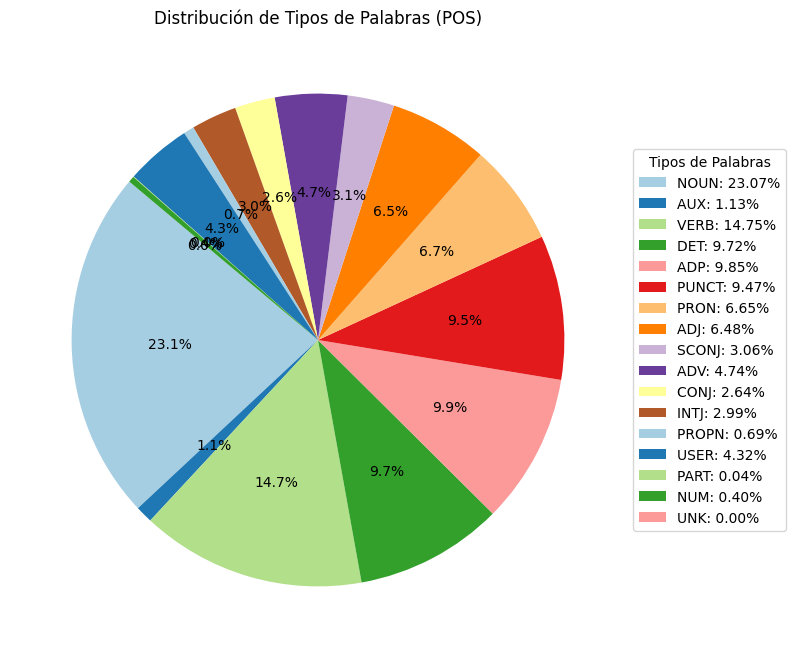

In [98]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(overall_pos_percentages.values(),  startangle=140, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
ax.set_title("Distribución de Tipos de Palabras (POS)")
legend_labels = [f"{pos_type}: {percentage:.2f}%" for pos_type, percentage in overall_pos_percentages.items()]
ax.legend(wedges, legend_labels, title="Tipos de Palabras", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

--------------------------------------------


-----------------------------------------------

### Tweets hate_speech

-----------------------------------------------


In [100]:
# POS en tweets hate_speech
text_hate_speech = [text for text in df_semeval_train[df_semeval_train["hate_speech"] == 1]["text"].tolist()]
results_pos_hate_speech = [analyze_pos_tags(text) for text in tqdm(text_hate_speech)]







  0%|          | 0/1855 [00:00<?, ?it/s]





  0%|          | 6/1855 [00:00<00:35, 52.67it/s]

Texto analizado: Easyjet quiere duplicar el número de mujeres piloto' Verás tú para aparcar el avión.. http://t.co/46NuLkm09x
Etiquetas encontradas: [('easyjet', 'NOUN'), ('quiere', 'AUX'), ('duplicar', 'VERB'), ('el', 'DET'), ('número', 'NOUN'), ('de', 'ADP'), ('mujeres', 'NOUN'), ('piloto', 'NOUN'), ("'", 'PUNCT'), ('verás', 'VERB'), ('tú', 'PRON'), ('para', 'ADP'), ('aparcar', 'VERB'), ('el', 'DET'), ('avión', 'NOUN'), ('..', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: El gobierno debe crear un control estricto de inmigración en las zonas fronterizas con Colombia por q después del 20-8querrán venir en masa
Etiquetas encontradas: [('el', 'DET'), ('gobierno', 'NOUN'), ('debe', 'AUX'), ('crear', 'VERB'), ('un', 'DET'), ('control', 'NOUN'), ('estricto', 'ADJ'), ('de', 'ADP'), ('inmigración', 'NOUN'), ('en', 'ADP'), ('las', 'DET'), ('zonas', 'NOUN'), ('fronterizas', 'ADJ'), ('con', 'ADP'), ('colombia', 'NOUN'), ('por', 'ADP'), ('q', 'SCONJ'), ('después', 'ADV'), ('del', 'DET'), ('20-8que







  1%|          | 12/1855 [00:00<00:35, 52.28it/s]





  1%|          | 18/1855 [00:00<00:34, 53.36it/s]

Texto analizado: En ese listado deben estar de segundo los árabes y chinos que nos tienen jodidos. Vienen de sus países con una mano delante y una atrás y consiguen préstamos gigantescos para sus negocios y para maltratar al venezolano. Acá en margarita se ve mucho esa vaina https://t.co/gHdYmtl68V
Etiquetas encontradas: [('en', 'ADP'), ('ese', 'DET'), ('listado', 'NOUN'), ('deben', 'AUX'), ('estar', 'VERB'), ('de', 'ADP'), ('segundo', 'ADV'), ('los', 'DET'), ('árabes', 'NOUN'), ('y', 'CONJ'), ('chinos', 'NOUN'), ('que', 'PRON'), ('nos', 'PRON'), ('tienen', 'VERB'), ('jodidos', 'ADJ'), ('.', 'PUNCT'), ('vienen', 'VERB'), ('de', 'ADP'), ('sus', 'DET'), ('países', 'NOUN'), ('con', 'ADP'), ('una', 'DET'), ('mano', 'NOUN'), ('delante', 'ADV'), ('y', 'CONJ'), ('una', 'DET'), ('atrás', 'ADV'), ('y', 'CONJ'), ('consiguen', 'VERB'), ('préstamos', 'NOUN'), ('gigantescos', 'ADJ'), ('para', 'ADP'), ('sus', 'DET'), ('negocios', 'NOUN'), ('y', 'CONJ'), ('para', 'ADP'), ('maltratar', 'VERB'), ('al',







  1%|▏         | 24/1855 [00:00<00:34, 52.89it/s]





  2%|▏         | 30/1855 [00:00<00:33, 55.22it/s]

Texto analizado: -¿Porque la esatua de la libertad es mujer? -Porque se nescesitaba una cabeza hueca para hacer un mirador
Etiquetas encontradas: [('-¿porque', 'INTJ'), ('la', 'DET'), ('esatua', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('libertad', 'NOUN'), ('es', 'VERB'), ('mujer', 'NOUN'), ('?', 'PUNCT'), ('-porque', 'INTJ'), ('se', 'PRON'), ('nescesitaba', 'VERB'), ('una', 'DET'), ('cabeza', 'NOUN'), ('hueca', 'ADJ'), ('para', 'ADP'), ('hacer', 'VERB'), ('un', 'DET'), ('mirador', 'NOUN')]
Texto analizado: Comemela XDDD y la cara también!! 🤣🤣🤣🤣🤣 — No nos pasemos 👀 https://t.co/t3o5yHY0zb
Etiquetas encontradas: [('comemela', 'INTJ'), ('xddd', 'INTJ'), ('y', 'CONJ'), ('la', 'DET'), ('cara', 'NOUN'), ('también', 'ADV'), ('!', 'PUNCT'), ('!', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('revolviéndose', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('revolviéndose', 'ADJ'), ('de', 'ADP'), ('la'







  2%|▏         | 36/1855 [00:00<00:33, 54.05it/s]





  2%|▏         | 42/1855 [00:00<00:34, 51.81it/s]

Texto analizado: @vibrium_ JAJAJAJAJAJA El multitasking es lo de hoy: Perra en Instagram, emo en Twitter, ridículas por Facebook y divas en WhatsApp, todo a la misma vez y sin mezclar historias.
Etiquetas encontradas: [('@vibrium', 'USER'), ('_', 'PUNCT'), ('jaja', 'INTJ'), ('el', 'DET'), ('multitasking', 'NOUN'), ('es', 'VERB'), ('lo', 'DET'), ('de', 'ADP'), ('hoy', 'NOUN'), (':', 'PUNCT'), ('perra', 'NOUN'), ('en', 'ADP'), ('instagram', 'NOUN'), (',', 'PUNCT'), ('emo', 'NOUN'), ('en', 'ADP'), ('twitter', 'NOUN'), (',', 'PUNCT'), ('ridículas', 'ADJ'), ('por', 'ADP'), ('facebook', 'NOUN'), ('y', 'CONJ'), ('divas', 'NOUN'), ('en', 'ADP'), ('whatsapp', 'NOUN'), (',', 'PUNCT'), ('todo', 'PRON'), ('a', 'ADP'), ('la', 'DET'), ('misma', 'ADJ'), ('vez', 'NOUN'), ('y', 'CONJ'), ('sin', 'ADP'), ('mezclar', 'VERB'), ('historias', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @20m Lastima.... callate zorra!!!!!!!😠😠😠💩💩💩💩💩💩
Etiquetas encontradas: [('@20', 'USER'), ('m', 'INTJ'), ('lastima', 'INTJ'), ('







  3%|▎         | 48/1855 [00:00<00:35, 50.87it/s]





  3%|▎         | 54/1855 [00:01<00:33, 53.01it/s]

Texto analizado: @pablocasado_ y @Albert_Rivera tienen razón, los inmigrantes vienen a imponernos sus costumbres https://t.co/xstEpiBjQl
Etiquetas encontradas: [('@pablocasado', 'USER'), ('_', 'NOUN'), ('y', 'CONJ'), ('@albert_rivera', 'USER'), ('tienen', 'VERB'), ('razón', 'NOUN'), (',', 'PUNCT'), ('los', 'DET'), ('inmigrantes', 'NOUN'), ('vienen', 'AUX'), ('a', 'ADP'), ('imponernos', 'VERB'), ('sus', 'DET'), ('costumbres', 'NOUN'), ('url', 'PROPN')]
Texto analizado: @KarinaFromField Tú eres mi perra, ¿yo qué culpa?
Etiquetas encontradas: [('@karinafromfield', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('mi', 'DET'), ('perra', 'NOUN'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('yo', 'PRON'), ('qué', 'DET'), ('culpa', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @DonniPuppo JAJJAJAJ cállate perra , me lo dijo por otra cosa no x eso
Etiquetas encontradas: [('@donnipuppo', 'USER'), ('jaja', 'INTJ'), ('cállate', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('me', 'PRON'), ('lo', 'PRON'), ('dijo', 'VER







  3%|▎         | 60/1855 [00:01<00:33, 53.65it/s]





  4%|▎         | 66/1855 [00:01<00:33, 52.68it/s]

Texto analizado: @ClaMoralesM No nos confundamos, muchas mujeres posan de victimas de acoso solo con una mirada, ridículas; ¿estas se habrán comparado con lo que sufrieron las guerrilleras en las Farc por ejemplo?
Etiquetas encontradas: [('@clamoralesm', 'USER'), ('no', 'ADV'), ('nos', 'PRON'), ('confundamos', 'VERB'), (',', 'PUNCT'), ('muchas', 'DET'), ('mujeres', 'NOUN'), ('posan', 'VERB'), ('de', 'ADP'), ('victimas', 'NOUN'), ('de', 'ADP'), ('acoso', 'NOUN'), ('solo', 'ADV'), ('con', 'ADP'), ('una', 'DET'), ('mirada', 'NOUN'), (',', 'PUNCT'), ('ridículas', 'ADJ'), (';', 'PUNCT'), ('¿', 'PUNCT'), ('estas', 'PRON'), ('se', 'PRON'), ('habrán', 'AUX'), ('comparado', 'VERB'), ('con', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('sufrieron', 'VERB'), ('las', 'DET'), ('guerrilleras', 'NOUN'), ('en', 'ADP'), ('las', 'DET'), ('farc', 'NOUN'), ('por', 'ADP'), ('ejemplo', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: @delockkke Cállate puta Katy Perri de los xiniyos (y nunca mejor dicho)
Etiquetas en







  4%|▍         | 72/1855 [00:01<00:33, 53.10it/s]





  4%|▍         | 78/1855 [00:01<00:33, 53.40it/s]

Texto analizado: @suicideroom22 Cállate que la que clava el visto sos vos Zorra 💔
Etiquetas encontradas: [('@suicideroom22', 'USER'), ('cállate', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('que', 'PRON'), ('clava', 'VERB'), ('el', 'DET'), ('visto', 'VERB'), ('sos', 'VERB'), ('vos', 'PRON'), ('zorra', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('corazón', 'NOUN'), ('roto', 'ADJ'), ('emoji', 'NOUN')]
Texto analizado: No son subsaharianos, son Negros. Que yo sepa, Sudán y Níger están en el Sáhara. #FronterasSeguras
Etiquetas encontradas: [('no', 'ADV'), ('son', 'VERB'), ('subsaharianos', 'NOUN'), (',', 'PUNCT'), ('son', 'VERB'), ('negros', 'ADJ'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('yo', 'PRON'), ('sepa', 'VERB'), (',', 'PUNCT'), ('sudán', 'NOUN'), ('y', 'CONJ'), ('níger', 'NOUN'), ('están', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('sáhara', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'PROPN'), ('fronterasseguras', 'NOUN')]
Texto analizado: @lopezdoriga @dparamooficial Cállate zorra priista
Etiqu







  5%|▍         | 84/1855 [00:01<00:34, 52.07it/s]







Texto analizado: @heavenskarIa Deja de provocarme maldita perra
Etiquetas encontradas: [('@heavenskaria', 'USER'), ('deja', 'VERB'), ('de', 'ADP'), ('provocarme', 'VERB'), ('maldita', 'ADJ'), ('perra', 'NOUN')]
Texto analizado: Pregunta para la izquierda. Esta es para nota.  Si abrimos las fronteras indiscriminadamente y sin control, y un inmigrante agrede a una mujer, inmigrante también, con la que está en una relación sentimental, ¿cómo se le localiza para citarle a juicio después de la agresión?
Etiquetas encontradas: [('pregunta', 'NOUN'), ('para', 'ADP'), ('la', 'DET'), ('izquierda', 'NOUN'), ('.', 'PUNCT'), ('esta', 'PRON'), ('es', 'VERB'), ('para', 'ADP'), ('nota', 'NOUN'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('si', 'SCONJ'), ('abrimos', 'VERB'), ('las', 'DET'), ('fronteras', 'NOUN'), ('indiscriminadamente', 'ADV'), ('y', 'CONJ'), ('sin', 'ADP'), ('control', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('un', 'DET'), ('inmigrante', 'NOUN'), ('agrede', 'VERB'), ('a', 'ADP'), ('una', 'DET'

  5%|▍         | 90/1855 [00:01<00:33, 52.55it/s]





  5%|▌         | 96/1855 [00:01<00:35, 49.56it/s]

Texto analizado: @BreenDLP @ChumelTorres @Juandedios_P @KimberlyLoaiza_ Cállate Perra mal parida de Juan y kim no hables😠😡😡
Etiquetas encontradas: [('@breendlp', 'USER'), ('@chumeltorres', 'USER'), ('@juandedios_p', 'USER'), ('@kimberlyloaiza', 'USER'), ('_', 'PUNCT'), ('cállate', 'VERB'), ('perra', 'NOUN'), ('mal', 'ADV'), ('parida', 'VERB'), ('de', 'ADP'), ('juan', 'NOUN'), ('y', 'CONJ'), ('kim', 'NOUN'), ('no', 'ADV'), ('hables', 'VERB'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('enfadada', 'ADJ'), ('emoji', 'NOUN'), (' ', 'INTJ'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('cabreada', 'ADJ'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'PROPN'), ('cara', 'ADV'), ('cabreada', 'ADJ'), ('emoji', 'NOUN')]
Texto analizado: Lo primero que hace Sanchez dar mas cobertura y mas medidas a la inmigración ilegal, enseñanza en árabe bajada del tiempopara nacionalizarse mirar a otro lado con los cada dia mas agresivos manteros etc.
Etiquetas encontradas: [('lo', 'DET'), ('primero', 'ADJ'), ('que', 'PRON')







  5%|▌         | 102/1855 [00:01<00:35, 49.64it/s]





  6%|▌         | 108/1855 [00:02<00:35, 49.85it/s]

Texto analizado: @SrtoAdriGH abusaba de él, es una zorra merecía morir.
Etiquetas encontradas: [('@srtoadrigh', 'USER'), ('abusaba', 'VERB'), ('de', 'ADP'), ('él', 'PRON'), (',', 'PUNCT'), ('es', 'VERB'), ('una', 'DET'), ('zorra', 'NOUN'), ('merecía', 'VERB'), ('morir', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Campo de Refugiados en ESPAÑA 🇪🇸 Q gobierno tendrá Los Santos Cohones de poner fin SÍ o SÍ a este despropósito? #campoderefugiados #españa https://t.co/ejGcKANZrz
Etiquetas encontradas: [('campo', 'NOUN'), ('de', 'ADP'), ('refugiados', 'NOUN'), ('en', 'ADP'), ('españa', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('bandera', 'NOUN'), ('españa', 'PROPN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('q', 'DET'), ('gobierno', 'NOUN'), ('tendrá', 'VERB'), ('los', 'DET'), ('santos', 'ADJ'), ('cohones', 'NOUN'), ('de', 'ADP'), ('poner', 'VERB'), ('fin', 'INTJ'), ('sí', 'INTJ'), ('o', 'CONJ'), ('sí', 'INTJ'), ('a', 'ADP'), ('este', 'DET'), ('despropósito', 'NOUN'), ('?', 'PUNCT'), ('hashtag', 'D







  6%|▌         | 114/1855 [00:02<00:36, 47.13it/s]





  6%|▋         | 120/1855 [00:02<00:35, 48.41it/s]

Texto analizado: La "marcha negra" acelera el paso: más de 40.000 subsaharianos esperan en Marruecos para entrar ilegalmente en España https://t.co/0MHGJNwJoz  ¡¡ Okupa Monclovita,...¿Ya tienes pensado donde cobijar a toda esta gente...?Prepara barracas en Moncloa, creo que hay terreno...!!
Etiquetas encontradas: [('la', 'DET'), ('"', 'PUNCT'), ('marcha', 'NOUN'), ('negra', 'ADJ'), ('"', 'PUNCT'), ('acelera', 'VERB'), ('el', 'DET'), ('paso', 'NOUN'), (':', 'PUNCT'), ('más', 'PRON'), ('de', 'ADP'), ('40.000', 'NUM'), ('subsaharianos', 'NOUN'), ('esperan', 'VERB'), ('en', 'ADP'), ('marruecos', 'NOUN'), ('para', 'ADP'), ('entrar', 'VERB'), ('ilegalmente', 'ADV'), ('en', 'ADP'), ('españa', 'NOUN'), ('url', 'PUNCT'), (' ', 'PUNCT'), ('¡', 'PUNCT'), ('¡', 'PUNCT'), ('okupa', 'VERB'), ('monclovita,', 'NOUN'), ('...', 'PUNCT'), ('¿ya', 'ADV'), ('tienes', 'AUX'), ('pensado', 'VERB'), ('donde', 'ADV'), ('cobijar', 'VERB'), ('a', 'ADP'), ('toda', 'DET'), ('esta', 'DET'), ('gente', 'NOUN'), ('...'







  7%|▋         | 125/1855 [00:02<00:35, 48.37it/s]





  7%|▋         | 131/1855 [00:02<00:34, 50.03it/s]

Texto analizado: Cuantos operarios hacen falta para limpiar una cocina? Ninguno, eso es cosa de mujeres. #CállateYfriega
Etiquetas encontradas: [('cuantos', 'DET'), ('operarios', 'NOUN'), ('hacen', 'VERB'), ('falta', 'NOUN'), ('para', 'ADP'), ('limpiar', 'VERB'), ('una', 'DET'), ('cocina', 'NOUN'), ('?', 'PUNCT'), ('ninguno', 'PRON'), (',', 'PUNCT'), ('eso', 'PRON'), ('es', 'VERB'), ('cosa', 'NOUN'), ('de', 'ADP'), ('mujeres', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'PUNCT'), ('cállateyfriega', 'NOUN')]
Texto analizado: @CandeCent Ute tranquila mí amiga me oio? Si querés que no te joda la vida te quedas callada perra hijaeputa y pásame el abon candesita! Cuale son tus cosquillas nene
Etiquetas encontradas: [('@candecent', 'USER'), ('ute', 'PRON'), ('tranquila', 'ADJ'), ('mí', 'PRON'), ('amiga', 'NOUN'), ('me', 'PRON'), ('oio', 'VERB'), ('?', 'PUNCT'), ('si', 'SCONJ'), ('querés', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('te', 'PRON'), ('joda', 'VERB'), ('la', 'DET'), ('vida', 'NOUN'), ('







  7%|▋         | 137/1855 [00:02<00:34, 50.38it/s]





  8%|▊         | 143/1855 [00:02<00:33, 50.48it/s]

Texto analizado: Y tú eres una perra como dice Joss Stone https://t.co/cDRan4DaSa
Etiquetas encontradas: [('y', 'CONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), ('como', 'SCONJ'), ('dice', 'VERB'), ('joss', 'NOUN'), ('stone', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Y tu eres perra?
Etiquetas encontradas: [('y', 'CONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('perra', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: Putos moros que vienen de fuera a quitarnos el trabajo a los ESPAÑOLES.  Ahora di que eres inmigrante a ver si encuentras trabajo. Y si lo encuentras te explotará algún soplapollas, pero eso si, español.
Etiquetas encontradas: [('putos', 'ADJ'), ('moros', 'NOUN'), ('que', 'PRON'), ('vienen', 'VERB'), ('de', 'ADP'), ('fuera', 'ADV'), ('a', 'ADP'), ('quitarnos', 'VERB'), ('el', 'DET'), ('trabajo', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('españoles', 'NOUN'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('ahora', 'ADV'), ('di', 'VERB'), ('que', 'SCONJ'), ('eres', 'VERB')







  8%|▊         | 149/1855 [00:02<00:35, 47.74it/s]

Texto analizado: @ikigaiguitar CÁLLATE PUTA YA VAS A VENIR POR MI CONOCIMIENTO EN PEDAGOGÍA
Etiquetas encontradas: [('@ikigaiguitar', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('ya', 'ADV'), ('vas', 'AUX'), ('a', 'ADP'), ('venir', 'VERB'), ('por', 'ADP'), ('mi', 'DET'), ('conocimiento', 'NOUN'), ('en', 'ADP'), ('pedagogía', 'NOUN')]
Texto analizado: Italia: Una mujer evita con gas pimienta un intento de agresión sexual de un inmigrante ilegal nigeriano en la estación de tren de Milán. Esta es la realidad de la inmigración ilegal. https://t.co/YybrILTiRk
Etiquetas encontradas: [('italia', 'NOUN'), (':', 'PUNCT'), ('una', 'DET'), ('mujer', 'NOUN'), ('evita', 'VERB'), ('con', 'ADP'), ('gas', 'NOUN'), ('pimienta', 'NOUN'), ('un', 'DET'), ('intento', 'NOUN'), ('de', 'ADP'), ('agresión', 'NOUN'), ('sexual', 'ADJ'), ('de', 'ADP'), ('un', 'DET'), ('inmigrante', 'NOUN'), ('ilegal', 'ADJ'), ('nigeriano', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('estación', 'NOUN'), ('de', 'ADP'), ('tren', '







  8%|▊         | 155/1855 [00:03<00:35, 48.33it/s]





  9%|▊         | 161/1855 [00:03<00:33, 50.01it/s]

Texto analizado: En un descuido y los güeros estén detrás de todo esto! https://t.co/p8IiBPxtHd
Etiquetas encontradas: [('en', 'ADP'), ('un', 'DET'), ('descuido', 'NOUN'), ('y', 'CONJ'), ('los', 'DET'), ('güeros', 'NOUN'), ('estén', 'VERB'), ('detrás', 'ADV'), ('de', 'ADP'), ('todo', 'PRON'), ('esto', 'PRON'), ('!', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: Y los españoles que no tienen dinero ni trabajo a dormir bajo puentes o en cajeros estamos guilipollas perdidos o que nos pasa primero ayudar a que no allá indigentes dandoles las mismas oportunidades que a los inmigrantes y cuando no hayan españoles en apuros ayudar a inmigrante https://t.co/Xxb1L522XM
Etiquetas encontradas: [('y', 'CONJ'), ('los', 'DET'), ('españoles', 'NOUN'), ('que', 'SCONJ'), ('no', 'ADV'), ('tienen', 'VERB'), ('dinero', 'NOUN'), ('ni', 'CONJ'), ('trabajo', 'VERB'), ('a', 'ADP'), ('dormir', 'VERB'), ('bajo', 'ADP'), ('puentes', 'NOUN'), ('o', 'CONJ'), ('en', 'ADP'), ('cajeros', 'NOUN'), ('estamos', 'VERB'), 







  9%|▉         | 167/1855 [00:03<00:33, 50.75it/s]





  9%|▉         | 173/1855 [00:03<00:32, 51.06it/s]

Texto analizado: Pero si son árabes chaval si ven a sus padres degollar animales to los dias https://t.co/AKojdh8TEt
Etiquetas encontradas: [('pero', 'CONJ'), ('si', 'SCONJ'), ('son', 'VERB'), ('árabes', 'ADJ'), ('chaval', 'NOUN'), ('si', 'SCONJ'), ('ven', 'VERB'), ('a', 'ADP'), ('sus', 'DET'), ('padres', 'NOUN'), ('degollar', 'VERB'), ('animales', 'NOUN'), ('to', 'ADP'), ('los', 'DET'), ('dias', 'NOUN'), ('url', 'ADV')]
Texto analizado: ¡JODER, QUE TE CALLES PERRA!
Etiquetas encontradas: [('¡', 'PUNCT'), ('joder', 'INTJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('perra', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: esta muy generalizada la idea de “puta” por enseñar el cuerpo en redes sociales cuando puta es ofrecer sexo a cambio de dinero y enseñar el cuerpo porque se me da la gana se llama MUJER LIBRE Y SEGURA DE SI MISMA https://t.co/iywvOXw75I
Etiquetas encontradas: [('esta', 'DET'), ('muy', 'ADV'), ('generalizada', 'ADJ'), ('la', 'DET'), ('idea', 'NOUN







 10%|▉         | 179/1855 [00:03<00:32, 51.20it/s]





 10%|▉         | 185/1855 [00:03<00:32, 51.44it/s]

Texto analizado: -¿Que le falta a una Mujer para ser perfecta? -todo
Etiquetas encontradas: [('-¿que', 'INTJ'), ('le', 'PRON'), ('falta', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('mujer', 'NOUN'), ('para', 'ADP'), ('ser', 'VERB'), ('perfecta', 'ADJ'), ('?', 'PUNCT'), ('-todo', 'INTJ')]
Texto analizado: “Nos vamos a convertir como Venezuela” decían, ahora hasta en los semáforos se habla chamo...Quiero ver al señor Duque y a los ministerios y cancillería que van hacer con tanto inmigrante chamozolano
Etiquetas encontradas: [('"', 'PUNCT'), ('nos', 'PRON'), ('vamos', 'AUX'), ('a', 'ADP'), ('convertir', 'VERB'), ('como', 'SCONJ'), ('venezuela', 'NOUN'), ('"', 'PUNCT'), ('decían', 'VERB'), (',', 'PUNCT'), ('ahora', 'ADV'), ('hasta', 'ADP'), ('en', 'ADP'), ('los', 'DET'), ('semáforos', 'NOUN'), ('se', 'PRON'), ('habla', 'VERB'), ('chamo', 'NOUN'), ('...', 'PUNCT'), ('quiero', 'VERB'), ('ver', 'VERB'), ('al', 'ADP'), ('señor', 'NOUN'), ('duque', 'NOUN'), ('y', 'CONJ'), ('a', 'ADP'), ('los', 'D







 10%|█         | 191/1855 [00:03<00:33, 50.19it/s]





 11%|█         | 197/1855 [00:03<00:34, 47.52it/s]

Texto analizado: @juliesart0rio JAJAJAJAJAJA cállate puta
Etiquetas encontradas: [('@juliesart0rio', 'USER'), ('jaja', 'INTJ'), ('cállate', 'VERB'), ('puta', 'NOUN')]
Texto analizado: Llegó el loquito más picante del condado, muy enojado, ta re apiolado. El que se coje a todo el patio de parado, y saca el choto todo cagado, acá en el barrio no queremos refugiados, sub 21 soy tu soldado
Etiquetas encontradas: [('llegó', 'VERB'), ('el', 'DET'), ('loquito', 'NOUN'), ('más', 'ADV'), ('picante', 'ADJ'), ('del', 'ADP'), ('condado', 'NOUN'), (',', 'PUNCT'), ('muy', 'ADV'), ('enojado', 'ADJ'), (',', 'PUNCT'), ('ta', 'VERB'), ('re', 'ADV'), ('apiolado', 'ADJ'), ('.', 'PUNCT'), ('el', 'DET'), ('que', 'PRON'), ('se', 'PRON'), ('coje', 'VERB'), ('a', 'ADP'), ('todo', 'DET'), ('el', 'DET'), ('patio', 'NOUN'), ('de', 'ADP'), ('parado', 'ADJ'), (',', 'PUNCT'), ('y', 'CONJ'), ('saca', 'VERB'), ('el', 'DET'), ('choto', 'NOUN'), ('todo', 'PRON'), ('cagado', 'ADJ'), (',', 'PUNCT'), ('acá', 'ADV'), ('en',







 11%|█         | 202/1855 [00:04<00:34, 47.68it/s]





 11%|█         | 208/1855 [00:04<00:33, 49.71it/s]

Texto analizado: PUUUUUUUUTAAAAAAAAAAAA (SI TU ERES MI PUTA) PUUUUUUUUUUUTAAAAAAAAAAAA (PUTA DEL GOBIERNO)
Etiquetas encontradas: [('puuutaaa', 'INTJ'), ('(', 'PUNCT'), ('si', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('mi', 'DET'), ('puta', 'NOUN'), (')', 'PUNCT'), ('puuutaaa', 'INTJ'), ('(', 'PUNCT'), ('puta', 'NOUN'), ('del', 'ADP'), ('gobierno', 'NOUN'), (')', 'PUNCT')]
Texto analizado: @DebRyanShow Imbecil, sigue de zorra en zorra no mas amigo porque ya la cagaste y no hay vuelta atrás
Etiquetas encontradas: [('@debryanshow', 'USER'), ('imbecil', 'NOUN'), (',', 'PUNCT'), ('sigue', 'VERB'), ('de', 'ADP'), ('zorra', 'NOUN'), ('en', 'ADP'), ('zorra', 'NOUN'), ('no', 'INTJ'), ('mas', 'ADJ'), ('amigo', 'NOUN'), ('porque', 'SCONJ'), ('ya', 'ADV'), ('la', 'PRON'), ('cagaste', 'VERB'), ('y', 'CONJ'), ('no', 'ADV'), ('hay', 'VERB'), ('vuelta', 'NOUN'), ('atrás', 'ADV')]
Texto analizado: Alarma Total 50.000 subsaharianos esperan en Marruecos para venir a España https://t.co/omscLnS3ix vía 







 12%|█▏        | 214/1855 [00:04<00:32, 50.43it/s]





 12%|█▏        | 220/1855 [00:04<00:31, 51.31it/s]

Texto analizado: VOY A PUBLICAR TU FOTO EN LA PRENSA PA QUE LA GENTE LO SEPA QUE TU ERES TREMENDA PERRA HIJUEPUTAAAAAAAA.
Etiquetas encontradas: [('voy', 'AUX'), ('a', 'ADP'), ('publicar', 'VERB'), ('tu', 'DET'), ('foto', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('prensa', 'NOUN'), ('pa', 'ADP'), ('que', 'SCONJ'), ('la', 'DET'), ('gente', 'NOUN'), ('lo', 'PRON'), ('sepa', 'VERB'), ('que', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('tremenda', 'ADJ'), ('perra', 'NOUN'), ('hijueputaaa', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @MichuHeredia Y dsps aprobas mejor cállate perra
Etiquetas encontradas: [('@michuheredia', 'USER'), ('y', 'CONJ'), ('dsps', 'ADV'), ('aprobas', 'VERB'), ('mejor', 'ADV'), ('cállate', 'VERB'), ('perra', 'NOUN')]
Texto analizado: Estos son los que nos están invadiendo y nosotros acogiendo como refugiados y regalandoles todos nuestros servicios sociales https://t.co/iRPOROgtwW
Etiquetas encontradas: [('estos', 'PRON'), ('son', 'VERB'), ('los', 'DET'), ('que', 'PRON'),







 12%|█▏        | 226/1855 [00:04<00:32, 50.22it/s]

Texto analizado: Pues francamente sería raro.  Como veros a vosotros en la mierda de los Goya denunciando a Maduro, las violaciones cometidas por manadas magrebíes, o el trato de favor a fuertes subsaharianos frente a nuestros débiles y cansados abuelos.  #FelizDomingo https://t.co/1tPqs65eXZ
Etiquetas encontradas: [('pues', 'SCONJ'), ('francamente', 'ADV'), ('sería', 'VERB'), ('raro', 'ADJ'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('como', 'SCONJ'), ('veros', 'VERB'), ('a', 'ADP'), ('vosotros', 'PRON'), ('en', 'ADP'), ('la', 'DET'), ('mierda', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('goya', 'NOUN'), ('denunciando', 'VERB'), ('a', 'ADP'), ('maduro', 'ADJ'), (',', 'PUNCT'), ('las', 'DET'), ('violaciones', 'NOUN'), ('cometidas', 'VERB'), ('por', 'ADP'), ('manadas', 'NOUN'), ('magrebíes', 'NOUN'), (',', 'PUNCT'), ('o', 'CONJ'), ('el', 'DET'), ('trato', 'NOUN'), ('de', 'ADP'), ('favor', 'NOUN'), ('a', 'ADP'), ('fuertes', 'ADJ'), ('subsaharianos', 'NOUN'), ('frente', 'ADV'), ('a', 'ADP'), ('nuest







 13%|█▎        | 232/1855 [00:04<00:44, 36.79it/s]

Texto analizado: Que les pasa a todos que me quieren hacer usar turbante de arabe, soy negro pero tampoco para tanto
Etiquetas encontradas: [('que', 'SCONJ'), ('les', 'PRON'), ('pasa', 'VERB'), ('a', 'ADP'), ('todos', 'PRON'), ('que', 'SCONJ'), ('me', 'PRON'), ('quieren', 'VERB'), ('hacer', 'VERB'), ('usar', 'VERB'), ('turbante', 'NOUN'), ('de', 'ADP'), ('arabe', 'NOUN'), (',', 'PUNCT'), ('soy', 'VERB'), ('negro', 'ADJ'), ('pero', 'CONJ'), ('tampoco', 'ADV'), ('para', 'ADP'), ('tanto', 'ADV')]
Texto analizado: @Vadushi @Phantanium_ cállate zorra estupida y no te metas en mis zorreos
Etiquetas encontradas: [('@vadushi', 'USER'), ('@phantanium', 'USER'), ('_', 'PUNCT'), ('cállate', 'VERB'), ('zorra', 'NOUN'), ('estupida', 'ADJ'), ('y', 'CONJ'), ('no', 'ADV'), ('te', 'PRON'), ('metas', 'VERB'), ('en', 'ADP'), ('mis', 'DET'), ('zorreos', 'NOUN')]
Texto analizado: A mí querido Ex, ese que me puso el cuerno y embarazó una chola puta:  Felicidades por tu compromiso! Espero seas muy feliz con 







 13%|█▎        | 237/1855 [00:04<00:52, 30.88it/s]

Texto analizado: #politivida Si no te gusta, puedes cambiarlo. DESTINO SUDACA   https://t.co/2tpPakccSk
Etiquetas encontradas: [('hashtag', 'NOUN'), ('politivida', 'ADJ'), ('si', 'SCONJ'), ('no', 'ADV'), ('te', 'PRON'), ('gusta', 'VERB'), (',', 'PUNCT'), ('puedes', 'AUX'), ('cambiarlo', 'VERB'), ('.', 'PUNCT'), ('destino', 'NOUN'), ('sudaca', 'ADJ'), ('  ', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: @Rockefort100 Hahaha, me das risa. Mejor cállate y no te metas donde no te mencionan, perra llorona.
Etiquetas encontradas: [('@rockefort100', 'USER'), ('hahaha', 'INTJ'), (',', 'PUNCT'), ('me', 'PRON'), ('das', 'VERB'), ('risa', 'NOUN'), ('.', 'PUNCT'), ('mejor', 'ADV'), ('cállate', 'VERB'), ('y', 'CONJ'), ('no', 'ADV'), ('te', 'PRON'), ('metas', 'VERB'), ('donde', 'ADV'), ('no', 'ADV'), ('te', 'PRON'), ('mencionan', 'VERB'), (',', 'PUNCT'), ('perra', 'NOUN'), ('llorona', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @LuciaAvelino3 pero cállate vos perra (hoy no estoy creativo para putear)
Eti







 13%|█▎        | 241/1855 [00:05<00:57, 28.16it/s]

Texto analizado: #Catalunya #Canarias no queremos indocumentados en nuestro pais desde Barcelona hasta #lanzarote existen estas mafias que no cotizan vendiendo en la calle arruinando a los pequeños negocios y prostituyendo a las mujereS  #Idonotwantmafias in #Spain 🇪🇸 https://t.co/QkByE3bDnb
Etiquetas encontradas: [('hashtag', 'NOUN'), ('catalunya', 'NOUN'), ('hashtag', 'NOUN'), ('canarias', 'NOUN'), ('no', 'INTJ'), ('queremos', 'VERB'), ('indocumentados', 'NOUN'), ('en', 'ADP'), ('nuestro', 'DET'), ('pais', 'NOUN'), ('desde', 'ADP'), ('barcelona', 'NOUN'), ('hasta', 'ADP'), ('hashtag', 'DET'), ('lanzarote', 'NOUN'), ('existen', 'VERB'), ('estas', 'DET'), ('mafias', 'NOUN'), ('que', 'PRON'), ('no', 'INTJ'), ('cotizan', 'PROPN'), ('vendiendo', 'VERB'), ('en', 'ADJ'), ('la', 'DET'), ('calle', 'NOUN'), ('arruinando', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('pequeños', 'ADJ'), ('negocios', 'NOUN'), ('y', 'CONJ'), ('prostituyendo', 'NOUN'), ('a', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'),







 13%|█▎        | 245/1855 [00:05<00:58, 27.30it/s]





 13%|█▎        | 248/1855 [00:05<00:59, 27.16it/s]

Texto analizado: Puta, deja de enseñarme el tenedor. Hacía apenas cinco minutos había tenido fuerza suficiente para clavárselo y ahora no la tenía ni para mirarlo. ¿Qué hacíamos? Me echo a reír entre dientes.
Etiquetas encontradas: [('puta', 'NOUN'), (',', 'PUNCT'), ('deja', 'VERB'), ('de', 'ADP'), ('enseñarme', 'VERB'), ('el', 'DET'), ('tenedor', 'NOUN'), ('.', 'PUNCT'), ('hacía', 'VERB'), ('apenas', 'ADV'), ('cinco', 'NUM'), ('minutos', 'NOUN'), ('había', 'AUX'), ('tenido', 'VERB'), ('fuerza', 'NOUN'), ('suficiente', 'ADJ'), ('para', 'ADP'), ('clavárselo', 'VERB'), ('y', 'CONJ'), ('ahora', 'ADV'), ('no', 'ADV'), ('la', 'PRON'), ('tenía', 'VERB'), ('ni', 'ADV'), ('para', 'ADP'), ('mirarlo', 'VERB'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('qué', 'PRON'), ('hacíamos', 'VERB'), ('?', 'PUNCT'), ('me', 'PRON'), ('echo', 'VERB'), ('a', 'ADP'), ('reír', 'VERB'), ('entre', 'ADP'), ('dientes', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @infobae Yo te prenderia fuego por perra !!! Q culpa tiene ese an







 14%|█▎        | 251/1855 [00:05<00:59, 26.75it/s]





 14%|█▎        | 255/1855 [00:05<00:55, 29.01it/s]

Texto analizado: @lovinovak ERES EL AMOR DE MI VIDA TU ERES FOTOGÉNICA SIEMPRE PEAZO PUTA
Etiquetas encontradas: [('@lovinovak', 'USER'), ('eres', 'VERB'), ('el', 'DET'), ('amor', 'NOUN'), ('de', 'ADP'), ('mi', 'DET'), ('vida', 'NOUN'), ('tu', 'DET'), ('eres', 'VERB'), ('fotogénica', 'ADJ'), ('siempre', 'ADV'), ('peazo', 'NOUN'), ('puta', 'NOUN')]
Texto analizado: Que Sudaca! Caparrós con lo que dijo de @cuervotinelli por eso este país es Inviable, con éstos pavos, que le  Cuesta contestar con educación? Y lo tratan de "intelectual" siglo xx. Cambalache.....🎶🎵🎼.. #LaCornisa
Etiquetas encontradas: [('que', 'SCONJ'), ('sudaca', 'ADJ'), ('!', 'PUNCT'), ('caparrós', 'VERB'), ('con', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('dijo', 'VERB'), ('de', 'ADP'), ('@cuervotinelli', 'USER'), ('por', 'ADP'), ('eso', 'PRON'), ('este', 'DET'), ('país', 'NOUN'), ('es', 'VERB'), ('inviable', 'ADJ'), (',', 'PUNCT'), ('con', 'ADP'), ('éstos', 'PRON'), ('pavos', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), (







 14%|█▍        | 259/1855 [00:05<00:52, 30.22it/s]

Texto analizado: nos estamos dando cuenta tarde que hijos arabes, por ej en zona sur de argentina son una maldicion
Etiquetas encontradas: [('nos', 'PRON'), ('estamos', 'AUX'), ('dando', 'VERB'), ('cuenta', 'NOUN'), ('tarde', 'ADV'), ('que', 'SCONJ'), ('hijos', 'NOUN'), ('arabes', 'ADJ'), (',', 'PUNCT'), ('por', 'ADP'), ('ej', 'NOUN'), ('en', 'ADP'), ('zona', 'NOUN'), ('sur', 'NOUN'), ('de', 'ADP'), ('argentina', 'NOUN'), ('son', 'VERB'), ('una', 'DET'), ('maldicion', 'NOUN')]
Texto analizado: Saltan la valla al grito de ‘racistas’. (video) https://t.co/yTZ2ajQb4M https://t.co/S6UrsjjuGY
Etiquetas encontradas: [('saltan', 'VERB'), ('la', 'DET'), ('valla', 'NOUN'), ('al', 'ADP'), ('grito', 'NOUN'), ('de', 'ADP'), ('racistas', 'ADJ'), ('.', 'PUNCT'), ('(', 'PUNCT'), ('video', 'NOUN'), (')', 'PUNCT'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Pues este año, aparte del montón de moros de siempre, he visto una jartá de árabes
Etiquetas encontradas: [('pues', 'SCONJ'), ('este', 'DET







 14%|█▍        | 263/1855 [00:05<00:57, 27.70it/s]





 14%|█▍        | 266/1855 [00:06<00:58, 27.10it/s]

Texto analizado: #elcascabel06a oye, pavo agredido en Barcino por los negratas, menudo discurso político antipodemos te marcas siempre y menuda pinta como de entre exiliado en Miami y portero discoteca....turista o no, mira a ver si no formas parte de algún tipo de trama organizada o algo XDXDXD
Etiquetas encontradas: [('hashtag', 'NOUN'), ('elcascabel06a', 'DET'), ('oye', 'VERB'), (',', 'PUNCT'), ('pavo', 'NOUN'), ('agredido', 'ADJ'), ('en', 'ADP'), ('barcino', 'NOUN'), ('por', 'ADP'), ('los', 'DET'), ('negratas', 'NOUN'), (',', 'PUNCT'), ('menudo', 'ADJ'), ('discurso', 'NOUN'), ('político', 'ADJ'), ('antipodemos', 'ADJ'), ('te', 'PRON'), ('marcas', 'VERB'), ('siempre', 'ADV'), ('y', 'CONJ'), ('menuda', 'ADJ'), ('pinta', 'NOUN'), ('como', 'SCONJ'), ('de', 'ADP'), ('entre', 'ADP'), ('exiliado', 'ADJ'), ('en', 'ADP'), ('miami', 'NOUN'), ('y', 'CONJ'), ('portero', 'NOUN'), ('discoteca', 'NOUN'), ('...', 'PUNCT'), ('turista', 'NOUN'), ('o', 'CONJ'), ('no', 'INTJ'), (',', 'PUNCT'), ('mira'







 15%|█▍        | 271/1855 [00:06<00:50, 31.10it/s]





 15%|█▍        | 275/1855 [00:06<00:51, 30.95it/s]

Texto analizado: ¡Eh! ¡Subsaharianos violentos! ¡Hablad de eso! #L6Nfranco
Etiquetas encontradas: [('¡', 'PUNCT'), ('eh', 'INTJ'), ('!', 'PUNCT'), ('¡', 'PUNCT'), ('subsaharianos', 'NOUN'), ('violentos', 'ADJ'), ('!', 'PUNCT'), ('¡', 'PUNCT'), ('hablad', 'VERB'), ('de', 'ADP'), ('eso', 'PRON'), ('!', 'PUNCT'), ('hashtag', 'PUNCT'), ('l6nfranco', 'PROPN')]
Texto analizado: @FlalaU_ @UnJoseHabla Callate puta
Etiquetas encontradas: [('@flalau', 'USER'), ('_', 'INTJ'), ('@unjosehabla', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN')]
Texto analizado: Buah qué guarra eres por llevar escote unga unga qué puta unga unga llegaré a chuparme la polla? unga unga https://t.co/0U8TbtwnZD
Etiquetas encontradas: [('buah', 'INTJ'), ('qué', 'ADV'), ('guarra', 'ADJ'), ('eres', 'VERB'), ('por', 'ADP'), ('llevar', 'VERB'), ('escote', 'NOUN'), ('unga', 'INTJ'), ('unga', 'INTJ'), ('qué', 'DET'), ('puta', 'NOUN'), ('unga', 'INTJ'), ('unga', 'INTJ'), ('llegaré', 'AUX'), ('a', 'ADP'), ('chuparme', 'VERB'), ('la







 15%|█▌        | 279/1855 [00:06<00:50, 31.48it/s]





 15%|█▌        | 283/1855 [00:06<00:47, 33.32it/s]

Texto analizado: Vecina chupa pija callate la boca que cantas horrible la puta que te pario
Etiquetas encontradas: [('vecina', 'NOUN'), ('chupa', 'VERB'), ('pija', 'NOUN'), ('callate', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('que', 'SCONJ'), ('cantas', 'VERB'), ('horrible', 'ADJ'), ('la', 'DET'), ('puta', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('pario', 'VERB')]
Texto analizado: LO QUE A EUROPA NO LE GUSTA OIR Y LE LLAMA POPULISMO: LA INVASION AFRICANA, desde dónde salen los asaltos a las vallas, las decenas de pateras con inmigrantes ilegales, y los contínuos fardos de haschis?,... https://t.co/NAqdEEtMDz
Etiquetas encontradas: [('lo', 'PRON'), ('que', 'PRON'), ('a', 'ADP'), ('europa', 'NOUN'), ('no', 'ADV'), ('le', 'PRON'), ('gusta', 'VERB'), ('oir', 'VERB'), ('y', 'CONJ'), ('le', 'PRON'), ('llama', 'VERB'), ('populismo', 'NOUN'), (':', 'PUNCT'), ('la', 'DET'), ('invasion', 'NOUN'), ('africana', 'ADJ'), (',', 'PUNCT'), ('desde', 'ADP'), ('dónde', 'ADV'), ('salen', 'VERB'), ('lo







 15%|█▌        | 287/1855 [00:06<00:45, 34.36it/s]





 16%|█▌        | 291/1855 [00:06<00:46, 33.79it/s]

Texto analizado: @CandeeLucero_ @MLauttaro Cállate puta
Etiquetas encontradas: [('@candeelucero', 'USER'), ('_', 'PUNCT'), ('@mlauttaro', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN')]
Texto analizado: @yasmicabaleiro Jajajajaja callate zorra vieja jajaja, ya aprobé una, demasiado jajajaja
Etiquetas encontradas: [('@yasmicabaleiro', 'USER'), ('jaja', 'INTJ'), ('callate', 'VERB'), ('zorra', 'NOUN'), ('vieja', 'ADJ'), ('jaja', 'INTJ'), (',', 'PUNCT'), ('ya', 'ADV'), ('aprobé', 'VERB'), ('una', 'PRON'), (',', 'PUNCT'), ('demasiado', 'ADV'), ('jaja', 'PUNCT')]
Texto analizado: @BeeluArzola Tu eres la pajera.. perra de mierda k lo unico k saces hacer es abrir tus piernas ..... xk putas las abres si no saves ser madre cojuda.
Etiquetas encontradas: [('@beeluarzola', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('la', 'DET'), ('pajera', 'NOUN'), ('..', 'PUNCT'), ('perra', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ('k', 'SCONJ'), ('lo', 'DET'), ('unico', 'ADJ'), ('k', 'SCONJ'), ('saces', 'VERB







 16%|█▌        | 295/1855 [00:06<00:48, 32.27it/s]

Texto analizado: @elisacarrio Cállate gorda hija de puta, las veces que te vi entrar en la iglesia de Av Santa Fe, no haberte mandado a la concha de tu madre . Chupa pija de represores chaqueños.
Etiquetas encontradas: [('@elisacarrio', 'USER'), ('cállate', 'VERB'), ('gorda', 'ADJ'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('las', 'DET'), ('veces', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('vi', 'VERB'), ('entrar', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('iglesia', 'NOUN'), ('de', 'ADP'), ('av', 'NOUN'), ('santa', 'ADJ'), ('fe', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('haberte', 'PRON'), ('mandado', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('concha', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('madre', 'NOUN'), ('.', 'PUNCT'), ('chupa', 'VERB'), ('pija', 'NOUN'), ('de', 'ADP'), ('represores', 'NOUN'), ('chaqueños', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Tú eres de los 70’ Y yo soy una zorra de los 90’
Etiquetas encontradas: [('tú', 'PRON'), ('eres', 'VERB'), ('







 16%|█▌        | 299/1855 [00:07<00:46, 33.19it/s]





 16%|█▋        | 303/1855 [00:07<00:48, 32.25it/s]

Texto analizado: @Hitler__Braun Busca por diccionario. Q es lo siguiente después de guapa? Exacto, guarra
Etiquetas encontradas: [('@hitler__braun', 'USER'), ('busca', 'VERB'), ('por', 'ADP'), ('diccionario', 'NOUN'), ('.', 'PUNCT'), ('q', 'PRON'), ('es', 'VERB'), ('lo', 'DET'), ('siguiente', 'ADJ'), ('después', 'ADV'), ('de', 'ADP'), ('guapa', 'NOUN'), ('?', 'PUNCT'), ('exacto', 'ADJ'), (',', 'PUNCT'), ('guarra', 'NOUN')]
Texto analizado: @suso_linares @Mishaki @Visentico @MrDonZea @earthblues No la he visto todavía. #todasputas
Etiquetas encontradas: [('@suso_linares', 'USER'), ('@mishaki', 'USER'), ('@visentico', 'USER'), ('@mrdonzea', 'USER'), ('@earthblues', 'USER'), ('no', 'ADV'), ('la', 'PRON'), ('he', 'AUX'), ('visto', 'VERB'), ('todavía', 'ADV'), ('.', 'PUNCT'), ('hashtag', 'PROPN'), ('todasputas', 'NOUN')]
Texto analizado: Los supermercados de Argentina,son una burla y una afrenta,por mas sudaca,q sea su público,la calidad de los productos,es ofensiva,y los precios de esa bas







 17%|█▋        | 307/1855 [00:07<00:46, 33.12it/s]





 17%|█▋        | 311/1855 [00:07<00:48, 31.68it/s]

Texto analizado: La cobertura sanitaria a los 820.000 sin papeles costará a los españoles 2.000 millones de euros
Etiquetas encontradas: [('la', 'DET'), ('cobertura', 'NOUN'), ('sanitaria', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('820.000', 'NUM'), ('sin', 'ADP'), ('papeles', 'NOUN'), ('costará', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('españoles', 'NOUN'), ('2.000', 'NUM'), ('millones', 'NUM'), ('de', 'ADP'), ('euros', 'NOUN')]
Texto analizado: Mi papá me acaba de enseñar un video de una perra estresada y me dijo que era yo. 🙄🙄
Etiquetas encontradas: [('mi', 'DET'), ('papá', 'NOUN'), ('me', 'PRON'), ('acaba', 'AUX'), ('de', 'ADP'), ('enseñar', 'VERB'), ('un', 'DET'), ('video', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('perra', 'NOUN'), ('estresada', 'ADJ'), ('y', 'CONJ'), ('me', 'PRON'), ('dijo', 'VERB'), ('que', 'SCONJ'), ('era', 'VERB'), ('yo', 'PRON'), ('.', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'NOUN'), ('con', 'ADP'), ('ojos', 'NOUN'), ('en', 'ADV'), ('blanco', 'ADJ'







 17%|█▋        | 315/1855 [00:07<00:48, 31.78it/s]





 17%|█▋        | 320/1855 [00:07<00:42, 36.32it/s]

Texto analizado: El problema en realidad son los inmigrantes que llegan masivamente, los presos que se acercan, los etarras que el psoe saca de la cárcel y el independentismo. No?  https://t.co/MkgDx09opM
Etiquetas encontradas: [('el', 'DET'), ('problema', 'NOUN'), ('en', 'ADP'), ('realidad', 'NOUN'), ('son', 'VERB'), ('los', 'DET'), ('inmigrantes', 'NOUN'), ('que', 'PRON'), ('llegan', 'VERB'), ('masivamente', 'ADV'), (',', 'PUNCT'), ('los', 'DET'), ('presos', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('acercan', 'VERB'), (',', 'PUNCT'), ('los', 'DET'), ('etarras', 'NOUN'), ('que', 'PRON'), ('el', 'DET'), ('psoe', 'NOUN'), ('saca', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('cárcel', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('independentismo', 'NOUN'), ('.', 'PUNCT'), ('no', 'INTJ'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: @lopezdoriga @aurelionuno @lopezobrador_ @Radio_Formula Tu eres la puta del PRI pinche mierda mal parida
Etiquetas encontradas: [('@lopezdoriga







 18%|█▊        | 326/1855 [00:07<00:36, 41.81it/s]





 18%|█▊        | 332/1855 [00:07<00:33, 45.69it/s]

Texto analizado: Nueva prueba de que no son refugiados, ni asilados...  Son inmigrantes económicos y como todos los videos que os sacamos muchis de ellos violentos, delincuentes o violadores...  Si tienen dinero para pagar a las mafias, no tienen porque recibir ayuda... https://t.co/hRhGpOSboy
Etiquetas encontradas: [('nueva', 'ADJ'), ('prueba', 'NOUN'), ('de', 'ADP'), ('que', 'SCONJ'), ('no', 'ADV'), ('son', 'VERB'), ('refugiados', 'NOUN'), (',', 'PUNCT'), ('ni', 'CONJ'), ('asilados', 'ADJ'), ('...', 'PUNCT'), (' ', 'PUNCT'), ('son', 'VERB'), ('inmigrantes', 'NOUN'), ('económicos', 'ADJ'), ('y', 'CONJ'), ('como', 'SCONJ'), ('todos', 'DET'), ('los', 'DET'), ('videos', 'NOUN'), ('que', 'PRON'), ('os', 'PRON'), ('sacamos', 'VERB'), ('muchis', 'PRON'), ('de', 'ADP'), ('ellos', 'PRON'), ('violentos', 'ADJ'), (',', 'PUNCT'), ('delincuentes', 'NOUN'), ('o', 'CONJ'), ('violadores', 'NOUN'), ('...', 'PUNCT'), (' ', 'PUNCT'), ('si', 'SCONJ'), ('tienen', 'VERB'), ('dinero', 'NOUN'), ('para', 'AD







 18%|█▊        | 337/1855 [00:07<00:34, 43.76it/s]

Texto analizado: @IaraPicatto1 Callate que yo tmb te extraño perra
Etiquetas encontradas: [('@iarapicatto1', 'USER'), ('callate', 'VERB'), ('que', 'SCONJ'), ('yo', 'PRON'), ('tmb', 'ADV'), ('te', 'PRON'), ('extraño', 'VERB'), ('perra', 'NOUN')]
Texto analizado: No hace mas que confirmar que esta *inmigracion* no va a ser productiva y nos va a costar un pastizal. Gente sin preparacion alguna y con experiencia en violaciones y masacres. https://t.co/jAn6ClfFJQ
Etiquetas encontradas: [('no', 'ADV'), ('hace', 'VERB'), ('mas', 'PRON'), ('que', 'SCONJ'), ('confirmar', 'VERB'), ('que', 'SCONJ'), ('esta', 'DET'), ('*', 'PUNCT'), ('inmigracion', 'NOUN'), ('*', 'PUNCT'), ('no', 'ADV'), ('va', 'AUX'), ('a', 'ADP'), ('ser', 'VERB'), ('productiva', 'ADJ'), ('y', 'CONJ'), ('nos', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('costar', 'VERB'), ('un', 'DET'), ('pastizal', 'NOUN'), ('.', 'PUNCT'), ('gente', 'NOUN'), ('sin', 'ADP'), ('preparacion', 'NOUN'), ('alguna', 'ADJ'), ('y', 'CONJ'), ('con', 'ADP'), ('







 18%|█▊        | 342/1855 [00:08<00:36, 41.10it/s]





 19%|█▊        | 347/1855 [00:08<00:35, 42.33it/s]

Texto analizado: En su país, árabe, que desconozco ni me importa, habrá Pena de Muerte. De acuerdo, que la ejecuten según sus extrañas y repugnantes leyes. Por favor, salven a ese niño. No tiene culpa de nada. Es inocente y merece oportunidades. Dónde coño está la ONU, UNICEF, UNESCO y su farsa? https://t.co/mT1Yu4iXS1
Etiquetas encontradas: [('en', 'ADP'), ('su', 'DET'), ('país', 'NOUN'), (',', 'PUNCT'), ('árabe', 'NOUN'), (',', 'PUNCT'), ('que', 'PRON'), ('desconozco', 'VERB'), ('ni', 'CONJ'), ('me', 'PRON'), ('importa', 'VERB'), (',', 'PUNCT'), ('habrá', 'VERB'), ('pena', 'NOUN'), ('de', 'ADP'), ('muerte', 'NOUN'), ('.', 'PUNCT'), ('de', 'ADP'), ('acuerdo', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('la', 'PRON'), ('ejecuten', 'VERB'), ('según', 'ADP'), ('sus', 'DET'), ('extrañas', 'ADJ'), ('y', 'CONJ'), ('repugnantes', 'ADJ'), ('leyes', 'NOUN'), ('.', 'PUNCT'), ('por', 'ADP'), ('favor', 'NOUN'), (',', 'PUNCT'), ('salven', 'VERB'), ('a', 'ADP'), ('ese', 'DET'), ('niño', 'NOUN'), ('







 19%|█▉        | 352/1855 [00:08<00:34, 43.98it/s]





 19%|█▉        | 358/1855 [00:08<00:32, 46.62it/s]

Texto analizado: Tu es que la puta rubia esa es gilipollas que le dicen callate que no es y la otra venga venga venga https://t.co/VEXrwWos7K
Etiquetas encontradas: [('tu', 'DET'), ('es', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('puta', 'NOUN'), ('rubia', 'NOUN'), ('esa', 'PRON'), ('es', 'VERB'), ('gilipollas', 'ADJ'), ('que', 'SCONJ'), ('le', 'PRON'), ('dicen', 'VERB'), ('callate', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('es', 'VERB'), ('y', 'CONJ'), ('la', 'DET'), ('otra', 'PRON'), ('venga', 'VERB'), ('venga', 'VERB'), ('venga', 'VERB'), ('url', 'INTJ')]
Texto analizado: Con la Sanidad abierta a todo el mundo y cobrando del paro con pocos requisitos, yo si fuera inmigrante me venia de cabeza, menudo chollo.
Etiquetas encontradas: [('con', 'ADP'), ('la', 'DET'), ('sanidad', 'NOUN'), ('abierta', 'ADJ'), ('a', 'ADP'), ('todo', 'DET'), ('el', 'DET'), ('mundo', 'NOUN'), ('y', 'CONJ'), ('cobrando', 'VERB'), ('del', 'ADP'), ('paro', 'NOUN'), ('con', 'ADP'), ('pocos', 'ADJ'), ('requisit







 20%|█▉        | 363/1855 [00:08<00:31, 47.23it/s]





 20%|█▉        | 369/1855 [00:08<00:30, 49.42it/s]

Texto analizado: @Untrust666 Cállate ok? Se aman déjalos, vida solo hay una perra.
Etiquetas encontradas: [('@untrust666', 'USER'), ('cállate', 'VERB'), ('ok', 'INTJ'), ('?', 'PUNCT'), ('se', 'PRON'), ('aman', 'VERB'), ('déjalos', 'VERB'), (',', 'PUNCT'), ('vida', 'NOUN'), ('solo', 'ADV'), ('hay', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @Antweetmoral tú cállate hija de perra https://t.co/rHAD9hosVI
Etiquetas encontradas: [('@antweetmoral', 'USER'), ('tú', 'PRON'), ('cállate', 'VERB'), ('hija', 'NOUN'), ('de', 'ADP'), ('perra', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Estos dos moromierdas son los que han matado a Adrien. R.I.P. https://t.co/WTJUSDeVwn
Etiquetas encontradas: [('estos', 'DET'), ('dos', 'NUM'), ('moromierdas', 'NOUN'), ('son', 'VERB'), ('los', 'DET'), ('que', 'PRON'), ('han', 'AUX'), ('matado', 'VERB'), ('a', 'ADP'), ('adrien', 'NOUN'), ('.', 'PUNCT'), ('r.i.p', 'INTJ'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Te mereces to







 20%|██        | 375/1855 [00:08<00:29, 50.64it/s]





 21%|██        | 381/1855 [00:08<00:30, 48.33it/s]

Texto analizado: @CarmeBarcelo @3gerardpique Una polla de 30 cm te hace falta para estar ocupada y no decir tonterias
Etiquetas encontradas: [('@carmebarcelo', 'USER'), ('@3gerardpique', 'USER'), ('una', 'DET'), ('polla', 'NOUN'), ('de', 'ADP'), ('30', 'ADJ'), ('cm', 'NOUN'), ('te', 'PRON'), ('hace', 'VERB'), ('falta', 'NOUN'), ('para', 'ADP'), ('estar', 'VERB'), ('ocupada', 'ADJ'), ('y', 'CONJ'), ('no', 'ADV'), ('decir', 'VERB'), ('tonterias', 'NOUN')]
Texto analizado: @boshe30 Callate puta cerda xao t odio puta chuky
Etiquetas encontradas: [('@boshe30', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('cerda', 'NOUN'), ('xao', 'INTJ'), ('t', 'PART'), ('odio', 'VERB'), ('puta', 'NOUN'), ('chuky', 'NOUN')]
Texto analizado: Ya que tú eres de mucha indirecta te voy a decir una cosa. A ti nunca te van a coger para serio, eres puta y la que es puta nadie la respeta. No esperes más de lo que tú no das. Metete con alguien que sea igual que tú y deja a los demás quietos.
Etiquetas encontradas







 21%|██        | 387/1855 [00:09<00:29, 49.81it/s]





 21%|██        | 393/1855 [00:09<00:30, 48.71it/s]

Texto analizado: ¿Por que las mujers fingen cuando hacen el amor? Por que se creen q nos importa.
Etiquetas encontradas: [('¿', 'PUNCT'), ('por', 'ADP'), ('que', 'SCONJ'), ('las', 'DET'), ('mujers', 'NOUN'), ('fingen', 'VERB'), ('cuando', 'ADV'), ('hacen', 'VERB'), ('el', 'DET'), ('amor', 'NOUN'), ('?', 'PUNCT'), ('por', 'ADP'), ('que', 'SCONJ'), ('se', 'PRON'), ('creen', 'VERB'), ('q', 'SCONJ'), ('nos', 'PRON'), ('importa', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Cojer con mí novia es lo mejor que existe alta perra encima
Etiquetas encontradas: [('cojer', 'VERB'), ('con', 'ADP'), ('mí', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('lo', 'DET'), ('mejor', 'ADJ'), ('que', 'SCONJ'), ('existe', 'VERB'), ('alta', 'ADJ'), ('perra', 'NOUN'), ('encima', 'ADV')]
Texto analizado: @daleonardi Vos callate zorra!!!! Jajaja
Etiquetas encontradas: [('@daleonardi', 'USER'), ('vos', 'PRON'), ('callate', 'VERB'), ('zorra', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('jaja', 'INTJ')]
Text







 21%|██▏       | 398/1855 [00:09<00:29, 48.84it/s]





 22%|██▏       | 404/1855 [00:09<00:28, 50.14it/s]

Texto analizado: -MACHISTA! -Machista ¡¿yo?! -Machista Dios que os hizo inferiores
Etiquetas encontradas: [('-machista', 'INTJ'), ('!', 'PUNCT'), ('-machista', 'INTJ'), ('¡', 'PUNCT'), ('¿', 'PUNCT'), ('yo', 'PRON'), ('?', 'PUNCT'), ('!', 'PUNCT'), ('-machista', 'INTJ'), ('dios', 'NOUN'), ('que', 'PRON'), ('os', 'PRON'), ('hizo', 'VERB'), ('inferiores', 'ADJ')]
Texto analizado: @Cooperativa Es verdad...yo siempre acoso a mujeres de faldas hasta la rodilla y botas baqueras!! y el peinado tambien influye muchisimo...
Etiquetas encontradas: [('@cooperativa', 'USER'), ('es', 'VERB'), ('verdad', 'NOUN'), ('...', 'PUNCT'), ('yo', 'PRON'), ('siempre', 'ADV'), ('acoso', 'VERB'), ('a', 'ADP'), ('mujeres', 'NOUN'), ('de', 'ADP'), ('faldas', 'NOUN'), ('hasta', 'ADP'), ('la', 'DET'), ('rodilla', 'NOUN'), ('y', 'CONJ'), ('botas', 'NOUN'), ('baqueras', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('y', 'CONJ'), ('el', 'DET'), ('peinado', 'NOUN'), ('tambien', 'ADV'), ('influye', 'VERB'), ('muchisimo', 'AD







 22%|██▏       | 410/1855 [00:09<00:29, 49.70it/s]

Texto analizado: perra estúpida diciendo esas tonterías en mi tl no señor
Etiquetas encontradas: [('perra', 'NOUN'), ('estúpida', 'ADJ'), ('diciendo', 'VERB'), ('esas', 'DET'), ('tonterías', 'NOUN'), ('en', 'ADP'), ('mi', 'DET'), ('tl', 'NOUN'), ('no', 'INTJ'), ('señor', 'NOUN')]
Texto analizado: Alemania. Chulo inmigrante musulmán ya sabe que es el fuerte en un país que ha claudicado. Pronto levantarán a tu madre, a tu abuela, a tu hija del autobús que han pagado. ¿Por qué no tenemos sangre, ya? Despierta, España! Wake up, Europe! #stopislam #stopinvasion #banislam https://t.co/p7jSwuavqi
Etiquetas encontradas: [('alemania', 'NOUN'), ('.', 'PUNCT'), ('chulo', 'ADJ'), ('inmigrante', 'NOUN'), ('musulmán', 'NOUN'), ('ya', 'ADV'), ('sabe', 'VERB'), ('que', 'SCONJ'), ('es', 'VERB'), ('el', 'DET'), ('fuerte', 'ADJ'), ('en', 'ADP'), ('un', 'DET'), ('país', 'NOUN'), ('que', 'PRON'), ('ha', 'AUX'), ('claudicado', 'VERB'), ('.', 'PUNCT'), ('pronto', 'ADV'), ('levantarán', 'VERB'), ('a', 'ADP'),







 22%|██▏       | 416/1855 [00:09<00:29, 48.43it/s]





 23%|██▎       | 421/1855 [00:09<00:31, 45.38it/s]

Texto analizado: Baby yo sé, que tú eres bien puta yo lo sé 🎶 La puse en cuatro pero nunca la besé 🎶😂😂😂😂
Etiquetas encontradas: [('baby', 'INTJ'), ('yo', 'PRON'), ('sé', 'VERB'), (',', 'PUNCT'), ('que', 'INTJ'), ('tú', 'VERB'), ('eres', 'VERB'), ('bien', 'ADV'), ('puta', 'INTJ'), ('yo', 'PRON'), ('lo', 'PRON'), ('sé', 'VERB'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('notas', 'NOUN'), ('musicales', 'NOUN'), ('emoji', 'INTJ'), (' ', 'NOUN'), ('la', 'DET'), ('puse', 'VERB'), ('en', 'ADP'), ('cuatro', 'NUM'), ('pero', 'CONJ'), ('nunca', 'ADV'), ('la', 'PRON'), ('besé', 'VERB'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('notas', 'NOUN'), ('musicales', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'INTJ'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'INTJ'), (' ', 'INTJ'), ('emoji', 'INTJ'), ('cara', 'VERB'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'INTJ'), ('emoji', 'INTJ'), (' ', 'INTJ'), ('emoji', 'INTJ'), ('cara', 'ADV'), ('llorando', 'VERB'), ('de







 23%|██▎       | 426/1855 [00:09<00:32, 44.29it/s]





 23%|██▎       | 431/1855 [00:09<00:32, 44.23it/s]

Texto analizado: @Ghxst_Whisperer @BloodSubaru @xRoseGirl_ {Lilinette es una puta. Pero tú eres un amor <3}
Etiquetas encontradas: [('@ghxst_whisperer', 'USER'), ('@bloodsubaru', 'USER'), ('@xrosegirl', 'USER'), ('_', 'NOUN'), ('{', 'PUNCT'), ('lilinette', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('pero', 'CONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('un', 'DET'), ('amor', 'NOUN'), ('<3', 'NUM'), ('}', 'PUNCT')]
Texto analizado: Ojala recibamos mas inmigrantes como tu y no putos negratas,no soy racista,yo respeto mucho a los latinos — gilipollas https://t.co/6t48llaVXg
Etiquetas encontradas: [('ojala', 'INTJ'), ('recibamos', 'VERB'), ('mas', 'ADJ'), ('inmigrantes', 'NOUN'), ('como', 'SCONJ'), ('tu', 'DET'), ('y', 'CONJ'), ('no', 'INTJ'), ('putos', 'ADJ'), ('negratas', 'NOUN'), (',', 'PUNCT'), ('no', 'INTJ'), ('soy', 'VERB'), ('racista', 'ADJ'), (',', 'PUNCT'), ('yo', 'PRON'), ('respeto', 'VERB'), ('mucho', 'ADV'), ('a', 'ADP'), ('los', 'DET'), ('latinos'







 24%|██▎       | 437/1855 [00:10<00:30, 47.09it/s]





 24%|██▍       | 442/1855 [00:10<00:30, 46.22it/s]

Texto analizado: Aún tengo mis dudas porque dicen que un hombre es puto por estar con hombres, entonces, ¿una mujer es puta por estar con mujeres?
Etiquetas encontradas: [('aún', 'ADV'), ('tengo', 'VERB'), ('mis', 'DET'), ('dudas', 'NOUN'), ('porque', 'SCONJ'), ('dicen', 'VERB'), ('que', 'SCONJ'), ('un', 'DET'), ('hombre', 'NOUN'), ('es', 'VERB'), ('puto', 'ADJ'), ('por', 'ADP'), ('estar', 'VERB'), ('con', 'ADP'), ('hombres', 'NOUN'), (',', 'PUNCT'), ('entonces', 'SCONJ'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('puta', 'ADJ'), ('por', 'ADP'), ('estar', 'VERB'), ('con', 'ADP'), ('mujeres', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: ya cállate puta ni eres oficial @exponatumachomx
Etiquetas encontradas: [('ya', 'ADV'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('ni', 'ADV'), ('eres', 'VERB'), ('oficial', 'NOUN'), ('@exponatumachomx', 'USER')]
Texto analizado: @revistaproceso Exigen. Perra asesina necesitamos tener te cerda hija de tu puta madre ra







 24%|██▍       | 448/1855 [00:10<00:29, 48.35it/s]





 24%|██▍       | 454/1855 [00:10<00:27, 50.17it/s]

Texto analizado: ¿cual es el dia de la mujer? -El dia menos pensado-
Etiquetas encontradas: [('¿', 'PUNCT'), ('cual', 'PRON'), ('es', 'VERB'), ('el', 'DET'), ('dia', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('mujer', 'NOUN'), ('?', 'PUNCT'), ('-el', 'DET'), ('dia', 'NOUN'), ('menos', 'ADV'), ('pensado-', 'ADJ')]
Texto analizado: @La_Gr0sera Si vas a enseñar Enséña bien hija de tu puta madre siempre es la misma mierda... PENDEJA
Etiquetas encontradas: [('@la_gr0sera', 'USER'), ('si', 'SCONJ'), ('vas', 'AUX'), ('a', 'ADP'), ('enseñar', 'VERB'), ('enséña', 'VERB'), ('bien', 'ADV'), ('hija', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('siempre', 'ADV'), ('es', 'VERB'), ('la', 'DET'), ('misma', 'ADJ'), ('mierda', 'NOUN'), ('...', 'PUNCT'), ('pendeja', 'ADJ')]
Texto analizado: @Hxrry_again CÁLLATE PERRA
Etiquetas encontradas: [('@hxrry_again', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN')]
Texto analizado: @VicxorAlt Tu eres una zorra ladrona no me diste mi cu







 25%|██▍       | 460/1855 [00:10<00:26, 51.78it/s]





 25%|██▌       | 466/1855 [00:10<00:26, 51.92it/s]

Texto analizado: @ainoatundidor3 Callate, q tu si q t presenta. Pedazo d perra
Etiquetas encontradas: [('@ainoatundidor3', 'USER'), ('callate', 'VERB'), (',', 'PUNCT'), ('q', 'SCONJ'), ('tu', 'DET'), ('si', 'INTJ'), ('q', 'SCONJ'), ('t', 'PRON'), ('presenta', 'VERB'), ('.', 'PUNCT'), ('pedazo', 'NOUN'), ('d', 'ADP'), ('perra', 'NOUN')]
Texto analizado: @lortegadiaz Coño eh tu madre maldita perra pudrete mamagueba Tu eres culpable
Etiquetas encontradas: [('@lortegadiaz', 'USER'), ('coño', 'INTJ'), ('eh', 'INTJ'), ('tu', 'DET'), ('madre', 'NOUN'), ('maldita', 'ADJ'), ('perra', 'NOUN'), ('pudrete', 'VERB'), ('mamagueba', 'NOUN'), ('tu', 'DET'), ('eres', 'VERB'), ('culpable', 'ADJ')]
Texto analizado: Según mi abuela Natacha Jaitt se merecía que le pegue su ex. Por haberle hecho 'eso' a Latorre, por qué es puta, por qué salió tarde, por qué fue mala toda la vida. https://t.co/cMGdAYrkdC
Etiquetas encontradas: [('según', 'ADP'), ('mi', 'DET'), ('abuela', 'NOUN'), ('natacha', 'NOUN'), ('jaitt







 25%|██▌       | 472/1855 [00:10<00:27, 51.08it/s]

Texto analizado: No soy racista pero QUE ASCO DAN LOS PUTOS MOROS. COMO DEPENDIESE DE MI QUE ENTRASEN EN ESPAÑA LO LLEVABAN CLARO ESTOS IMPRESENTABLES GUARROS Y MAL OLIENTES
Etiquetas encontradas: [('no', 'ADV'), ('soy', 'VERB'), ('racista', 'ADJ'), ('pero', 'CONJ'), ('que', 'SCONJ'), ('asco', 'NOUN'), ('dan', 'VERB'), ('los', 'DET'), ('putos', 'ADJ'), ('moros', 'NOUN'), ('.', 'PUNCT'), ('como', 'SCONJ'), ('dependiese', 'VERB'), ('de', 'ADP'), ('mi', 'PRON'), ('que', 'SCONJ'), ('entrasen', 'VERB'), ('en', 'ADP'), ('españa', 'NOUN'), ('lo', 'PRON'), ('llevaban', 'VERB'), ('claro', 'ADV'), ('estos', 'DET'), ('impresentables', 'ADJ'), ('guarros', 'ADJ'), ('y', 'CONJ'), ('mal', 'ADV'), ('olientes', 'VERB')]
Texto analizado: @Brisaagg Callate maldita zorra, te extraño volve ya
Etiquetas encontradas: [('@brisaagg', 'USER'), ('callate', 'VERB'), ('maldita', 'ADJ'), ('zorra', 'NOUN'), (',', 'PUNCT'), ('te', 'PRON'), ('extraño', 'VERB'), ('volve', 'VERB'), ('ya', 'ADV')]
Texto analizado: @vikid







 26%|██▌       | 478/1855 [00:10<00:27, 50.78it/s]





 26%|██▌       | 484/1855 [00:10<00:26, 52.42it/s]

Texto analizado: la novia es mas puta y el pelotudo sigue estando con ella , ni pa bosta la mina mas zorra y el ni hablar mas gil todavía , le re kbio
Etiquetas encontradas: [('la', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('mas', 'ADV'), ('puta', 'ADJ'), ('y', 'CONJ'), ('el', 'DET'), ('pelotudo', 'NOUN'), ('sigue', 'AUX'), ('estando', 'VERB'), ('con', 'ADP'), ('ella', 'PRON'), (',', 'PUNCT'), ('ni', 'CONJ'), ('pa', 'ADP'), ('bosta', 'NOUN'), ('la', 'DET'), ('mina', 'NOUN'), ('mas', 'ADV'), ('zorra', 'ADJ'), ('y', 'CONJ'), ('el', 'DET'), ('ni', 'ADV'), ('hablar', 'VERB'), ('mas', 'ADV'), ('gil', 'ADJ'), ('todavía', 'ADV'), (',', 'PUNCT'), ('le', 'PRON'), ('re', 'ADV'), ('kbio', 'VERB')]
Texto analizado: Que horrible verte así Sofi, como te voy a extrañar mi perra loca! Espero que estes en un lugar mejor, y tengas todo lo que mereces!
Etiquetas encontradas: [('que', 'SCONJ'), ('horrible', 'ADJ'), ('verte', 'VERB'), ('así', 'ADV'), ('sofi', 'NOUN'), (',', 'PUNCT'), ('como', 'ADV'), ('t







 26%|██▋       | 490/1855 [00:11<00:26, 52.31it/s]





 27%|██▋       | 496/1855 [00:11<00:27, 49.97it/s]

Texto analizado: @OmarPrietoGob Omar Prieto: “Extranjero sin identificación será puesto en la frontera”ENVÍA AL EJERCITO A TOMAR CONTROL DE LAS PULGAS PLATANEROS Y CURVA DE AHÍ PARA QUE VEAS COMO HAY COLOMBIANOS INDOCUMENTADOS COMO MONTE AHÍ DE BUHONERS PORQUE LA POLICÍA LA GUARDIA ESTÁN CORRUP
Etiquetas encontradas: [('@omarprietogob', 'USER'), ('omar', 'PROPN'), ('prieto', 'ADJ'), (':', 'PUNCT'), ('"', 'PUNCT'), ('extranjero', 'NOUN'), ('sin', 'ADP'), ('identificación', 'NOUN'), ('será', 'AUX'), ('puesto', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('frontera"envía', 'NOUN'), ('al', 'ADP'), ('ejercito', 'NOUN'), ('a', 'ADP'), ('tomar', 'VERB'), ('control', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('pulgas', 'NOUN'), ('plataneros', 'NOUN'), ('y', 'CONJ'), ('curva', 'NOUN'), ('de', 'ADP'), ('ahí', 'ADV'), ('para', 'ADP'), ('que', 'SCONJ'), ('veas', 'VERB'), ('como', 'SCONJ'), ('hay', 'VERB'), ('colombianos', 'NOUN'), ('indocumentados', 'ADJ'), ('como', 'SCONJ'), ('monte', 'NOUN'), ('ahí', '







 27%|██▋       | 502/1855 [00:11<00:26, 51.78it/s]





 27%|██▋       | 508/1855 [00:11<00:25, 53.14it/s]

Texto analizado: @perraysex Tu eres la puta más puta con cualquier tanga....te uso el culo como depósito de semen
Etiquetas encontradas: [('@perraysex', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('la', 'DET'), ('puta', 'NOUN'), ('más', 'ADV'), ('puta', 'ADJ'), ('con', 'ADP'), ('cualquier', 'DET'), ('tanga', 'NOUN'), ('...', 'PUNCT'), ('te', 'PRON'), ('uso', 'VERB'), ('el', 'DET'), ('culo', 'NOUN'), ('como', 'ADP'), ('depósito', 'NOUN'), ('de', 'ADP'), ('semen', 'NOUN')]
Texto analizado: Okeyy puta envíame una enseñando un poco mas y te tradeo en Ebay por una nintendo switch que tengo ganas de jugar al super mario ( eso es que tienes mucho valor para mi) https://t.co/5yNotSLhmu
Etiquetas encontradas: [('okeyy', 'INTJ'), ('puta', 'NOUN'), ('envíame', 'VERB'), ('una', 'DET'), ('enseñando', 'VERB'), ('un', 'DET'), ('poco', 'ADV'), ('mas', 'ADJ'), ('y', 'CONJ'), ('te', 'PRON'), ('tradeo', 'VERB'), ('en', 'ADP'), ('ebay', 'NOUN'), ('por', 'ADP'), ('una', 'DET'), ('nintendo', 'NOUN'), ('switc







 28%|██▊       | 514/1855 [00:11<00:25, 52.90it/s]





 28%|██▊       | 520/1855 [00:11<00:25, 52.84it/s]

Texto analizado: esq una polla, las mujeres son to celosas callaros ya https://t.co/eJHAx4vYC7
Etiquetas encontradas: [('esq', 'VERB'), ('una', 'DET'), ('polla', 'NOUN'), (',', 'PUNCT'), ('las', 'DET'), ('mujeres', 'NOUN'), ('son', 'VERB'), ('to', 'ADP'), ('celosas', 'ADJ'), ('callaros', 'VERB'), ('ya', 'ADV'), ('url', 'INTJ')]
Texto analizado: Pasan las horas y @ahorapodemos aún no ha convocado ninguna manifa en apoyo a esta menor.   Ninguna femiNAZI se solidariza con ella. Parece que si los violadores son inmigrantes, es menos delito que si lo hace un Español  https://t.co/GTE5kBufJ7
Etiquetas encontradas: [('pasan', 'VERB'), ('las', 'DET'), ('horas', 'NOUN'), ('y', 'CONJ'), ('@ahorapodemos', 'USER'), ('aún', 'ADV'), ('no', 'ADV'), ('ha', 'AUX'), ('convocado', 'VERB'), ('ninguna', 'DET'), ('manifa', 'NOUN'), ('en', 'ADP'), ('apoyo', 'NOUN'), ('a', 'ADP'), ('esta', 'DET'), ('menor', 'NOUN'), ('.', 'PUNCT'), ('  ', 'INTJ'), ('ninguna', 'DET'), ('feminazi', 'NOUN'), ('se', 'PRON'), ('so







 28%|██▊       | 526/1855 [00:11<00:24, 54.75it/s]





 29%|██▊       | 532/1855 [00:11<00:25, 51.14it/s]

Texto analizado: @Alexaladyekt Cállate puta guarra y metete mi verga en tu hocico hasta q t ahogues y me la dejes escurriendo Quiero t comas mi semen, perra
Etiquetas encontradas: [('@alexaladyekt', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('guarra', 'NOUN'), ('y', 'CONJ'), ('metete', 'VERB'), ('mi', 'DET'), ('verga', 'NOUN'), ('en', 'ADP'), ('tu', 'DET'), ('hocico', 'NOUN'), ('hasta', 'ADP'), ('q', 'SCONJ'), ('t', 'PRON'), ('ahogues', 'VERB'), ('y', 'CONJ'), ('me', 'PRON'), ('la', 'PRON'), ('dejes', 'VERB'), ('escurriendo', 'VERB'), ('quiero', 'VERB'), ('t', 'PRON'), ('comas', 'VERB'), ('mi', 'DET'), ('semen', 'NOUN'), (',', 'PUNCT'), ('perra', 'NOUN')]
Texto analizado: Pensar que la mujer es una perra de por si es algo horrible, pero que eso sea por celos, es una conchudez.
Etiquetas encontradas: [('pensar', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), ('de', 'ADP'), ('por', 'ADP'), ('si', 'SCONJ'), ('es', 'VER







 29%|██▉       | 538/1855 [00:12<00:25, 51.48it/s]

Texto analizado: @AlemanS_ jajajajaj cállate perra, cumplime y súmale que me debes ir 1’ al Tasty Rails ‘conmigo’ 🤨
Etiquetas encontradas: [('@alemans', 'USER'), ('_', 'INTJ'), ('jaja', 'INTJ'), ('cállate', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('cumplime', 'VERB'), ('y', 'CONJ'), ('súmale', 'VERB'), ('que', 'SCONJ'), ('me', 'PRON'), ('debes', 'VERB'), ('ir', 'VERB'), ('1', 'ADV'), ('al', 'ADP'), ('tasty', 'NOUN'), ('rails', 'NOUN'), ('conmigo', 'PRON'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('cara', 'ADJ'), ('con', 'ADP'), ('ceja', 'ADV'), ('alzada', 'ADJ'), ('emoji', 'INTJ')]
Texto analizado: ⚫ Aquí @pablocasado_ saludando efusivamente y dando la bienvenida a los invasores que han saltado de manera ilegal y violenta la valla de #Ceuta agrediendo a la Guardia Civil. https://t.co/NbuAnxstvx
Etiquetas encontradas: [('emoji', 'NOUN'), ('círculo', 'NOUN'), ('negro', 'ADJ'), ('emoji', 'INTJ'), (' ', 'PUNCT'), ('aquí', 'ADV'), ('@pablocasado', 'USER'), ('_', 'PUNCT'), ('saludando', 'VERB







 29%|██▉       | 544/1855 [00:12<00:25, 51.89it/s]





 30%|██▉       | 550/1855 [00:12<00:26, 50.08it/s]

Texto analizado: Un inmigrante en Alemania. Se mea en sus leyes políticamente correctas. Están perdiendo sus países y aún no se dan cuenta. Este tipo debe ser deportado, no contribuye en nada https://t.co/NZOawrvOD2
Etiquetas encontradas: [('un', 'DET'), ('inmigrante', 'NOUN'), ('en', 'ADP'), ('alemania', 'NOUN'), ('.', 'PUNCT'), ('se', 'PRON'), ('mea', 'VERB'), ('en', 'ADP'), ('sus', 'DET'), ('leyes', 'NOUN'), ('políticamente', 'ADV'), ('correctas', 'ADJ'), ('.', 'PUNCT'), ('están', 'AUX'), ('perdiendo', 'VERB'), ('sus', 'DET'), ('países', 'NOUN'), ('y', 'CONJ'), ('aún', 'ADV'), ('no', 'ADV'), ('se', 'PRON'), ('dan', 'VERB'), ('cuenta', 'NOUN'), ('.', 'PUNCT'), ('este', 'DET'), ('tipo', 'NOUN'), ('debe', 'AUX'), ('ser', 'VERB'), ('deportado', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('contribuye', 'VERB'), ('en', 'ADP'), ('nada', 'PRON'), ('url', 'ADP')]
Texto analizado: @carlosj_almon Cállate perra
Etiquetas encontradas: [('@carlosj_almon', 'USER'), ('cállate', 'VERB'), ('perra', 'NOU







 30%|██▉       | 556/1855 [00:12<00:25, 51.41it/s]





 30%|███       | 562/1855 [00:12<00:26, 49.38it/s]

Texto analizado: @s0ymia JAJAJA YA CÁLLATE PERRA DRAMÁTICA DAS PENA Y RISA
Etiquetas encontradas: [('@s0ymia', 'USER'), ('jaja', 'INTJ'), ('ya', 'ADV'), ('cállate', 'VERB'), ('perra', 'NOUN'), ('dramática', 'ADJ'), ('das', 'VERB'), ('pena', 'NOUN'), ('y', 'CONJ'), ('risa', 'NOUN')]
Texto analizado: Sanidad universal para todos, techo, comida, una paguita ...  No entiendo nada.  ¿Habremos cedido nuestra soberanía a Europa y nadie dice nada?  🔴Alarma por los más de 50.000 subsaharianos que esperan en Marruecos para cruzar a España https://t.co/sR4925BNLJ vía @elmundoes
Etiquetas encontradas: [('sanidad', 'NOUN'), ('universal', 'ADJ'), ('para', 'ADP'), ('todos', 'PRON'), (',', 'PUNCT'), ('techo', 'NOUN'), (',', 'PUNCT'), ('comida', 'NOUN'), (',', 'PUNCT'), ('una', 'DET'), ('paguita', 'NOUN'), ('...', 'PUNCT'), (' ', 'PUNCT'), ('no', 'ADV'), ('entiendo', 'VERB'), ('nada', 'PRON'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('¿', 'PUNCT'), ('habremos', 'AUX'), ('cedido', 'VERB'), ('nuestra', 'DET'), (







 31%|███       | 567/1855 [00:12<00:31, 40.61it/s]

Texto analizado: Mi novia sevillista y es una puta más.... tu eres tonto y en tu casa no lo sabes @AntonioAdan13
Etiquetas encontradas: [('mi', 'DET'), ('novia', 'NOUN'), ('sevillista', 'ADJ'), ('y', 'CONJ'), ('es', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('más', 'PRON'), ('...', 'PUNCT'), ('tu', 'DET'), ('eres', 'VERB'), ('tonto', 'ADJ'), ('y', 'CONJ'), ('en', 'ADP'), ('tu', 'DET'), ('casa', 'NOUN'), ('no', 'ADV'), ('lo', 'PRON'), ('sabes', 'VERB'), ('@antonioadan13', 'USER')]
Texto analizado: Enseñan al pueblo Español a amedrentarse frente a un enemigo, yo enseño a mis hijos a saber defenderse, sea mantero, presidente del gobierno o saltador negro de la valla de Melilla!!
Etiquetas encontradas: [('enseñan', 'VERB'), ('al', 'ADP'), ('pueblo', 'NOUN'), ('español', 'NOUN'), ('a', 'ADP'), ('amedrentarse', 'VERB'), ('frente', 'ADV'), ('a', 'ADP'), ('un', 'DET'), ('enemigo', 'NOUN'), (',', 'PUNCT'), ('yo', 'PRON'), ('enseño', 'VERB'), ('a', 'ADP'), ('mis', 'DET'), ('hijos', 'NOUN'), ('a







 31%|███       | 572/1855 [00:13<00:52, 24.53it/s]

Texto analizado: Árabes HDP 😒 https://t.co/SiU9oFanD0
Etiquetas encontradas: [('árabes', 'PROPN'), ('hdp', 'ADJ'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'NOUN'), ('de', 'NOUN'), ('desaprobación', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('url', 'NOUN')]
Texto analizado: @BeeluArzola callate puta mal parida perra re culia inconciente callada deberias estar maldita
Etiquetas encontradas: [('@beeluarzola', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('mal', 'ADV'), ('parida', 'ADJ'), ('perra', 'NOUN'), ('re', 'ADV'), ('culia', 'NOUN'), ('inconciente', 'ADJ'), ('callada', 'ADJ'), ('deberias', 'AUX'), ('estar', 'VERB'), ('maldita', 'ADJ')]
Texto analizado: @__Irenelazaro26 Pero porque tu eres una perra con el corazón de hielo, a mi me gusta el cariño humano 🙆
Etiquetas encontradas: [('@__irenelazaro26', 'USER'), ('pero', 'CONJ'), ('porque', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('corazón', 'NOUN'), ('de', 'ADP







 31%|███       | 576/1855 [00:13<00:58, 21.86it/s]





 31%|███       | 579/1855 [00:13<00:59, 21.61it/s]

Texto analizado: @ivfkn callate puta, las putas no hablan puta puta puta.
Etiquetas encontradas: [('@ivfkn', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), (',', 'PUNCT'), ('las', 'DET'), ('putas', 'NOUN'), ('no', 'ADV'), ('hablan', 'VERB'), ('puta', 'ADJ'), ('puta', 'ADJ'), ('puta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @JorgeMasta @elchiringuitotv Si es cierto solo les restrego la polla en la cara a todas las que estaban alli de blanco jajajjajajjajjaa me dievierte eso
Etiquetas encontradas: [('@jorgemasta', 'USER'), ('@elchiringuitotv', 'USER'), ('si', 'SCONJ'), ('es', 'VERB'), ('cierto', 'ADJ'), ('solo', 'ADV'), ('les', 'PRON'), ('restrego', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('a', 'ADP'), ('todas', 'DET'), ('las', 'DET'), ('que', 'PRON'), ('estaban', 'VERB'), ('alli', 'ADV'), ('de', 'ADP'), ('blanco', 'ADJ'), ('jaja', 'INTJ'), ('me', 'PRON'), ('dievierte', 'VERB'), ('eso', 'PRON')]
Texto analizado: @DrodriguezVen @mauric







 31%|███▏      | 583/1855 [00:13<00:52, 24.34it/s]





 32%|███▏      | 591/1855 [00:13<00:35, 35.20it/s]

Texto analizado: @blacguido27 Cállate ladrona sigue vendiendo tu zorra
Etiquetas encontradas: [('@blacguido27', 'USER'), ('cállate', 'VERB'), ('ladrona', 'NOUN'), ('sigue', 'AUX'), ('vendiendo', 'VERB'), ('tu', 'DET'), ('zorra', 'NOUN')]
Texto analizado: @bbongiov Ay pero si sos la mas perra callate
Etiquetas encontradas: [('@bbongiov', 'USER'), ('ay', 'INTJ'), ('pero', 'CONJ'), ('si', 'SCONJ'), ('sos', 'VERB'), ('la', 'DET'), ('mas', 'ADV'), ('perra', 'NOUN'), ('callate', 'VERB')]
Texto analizado: @ever_ferreyra Jajajaja callate perra incada
Etiquetas encontradas: [('@ever_ferreyra', 'USER'), ('jaja', 'INTJ'), ('callate', 'VERB'), ('perra', 'NOUN'), ('incada', 'ADJ')]
Texto analizado: @Shrlttw Callate puta sidosa de mierda
Etiquetas encontradas: [('@shrlttw', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('sidosa', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN')]
Texto analizado: @mraubreygrey @sweetskipp asi me gusta amor bien rica enseñando las tetas ricas que tienes perra rica
Etiquet







 32%|███▏      | 599/1855 [00:13<00:28, 44.65it/s]





 33%|███▎      | 606/1855 [00:13<00:26, 47.37it/s]

Texto analizado: Modela camina puta tu eres divina
Etiquetas encontradas: [('modela', 'NOUN'), ('camina', 'VERB'), ('puta', 'NOUN'), ('tu', 'DET'), ('eres', 'VERB'), ('divina', 'ADJ')]
Texto analizado: @JakyMemes Si tu eres tan perra que te comes hasta la tela https://t.co/jOLpF8BNo6
Etiquetas encontradas: [('@jakymemes', 'USER'), ('si', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('tan', 'ADV'), ('perra', 'NOUN'), ('que', 'SCONJ'), ('te', 'PRON'), ('comes', 'VERB'), ('hasta', 'ADP'), ('la', 'DET'), ('tela', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Los inmigrantes en hospitales, a pensión completa y los españoles durmiendo en el coche. Por Ramiro Grau Morancho https://t.co/y9uWxqv1ND vía @CorreoDeMadrid
Etiquetas encontradas: [('los', 'DET'), ('inmigrantes', 'NOUN'), ('en', 'ADP'), ('hospitales', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('pensión', 'NOUN'), ('completa', 'ADJ'), ('y', 'CONJ'), ('los', 'DET'), ('españoles', 'NOUN'), ('durmiendo', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('c







 33%|███▎      | 612/1855 [00:14<00:34, 36.54it/s]

Texto analizado: @Vargas_Aldo @JuanRosado12 @KYabar Jajajajaj callate tu zorra asquerosa
Etiquetas encontradas: [('@vargas_aldo', 'USER'), ('@juanrosado12', 'USER'), ('@kyabar', 'USER'), ('jaja', 'INTJ'), ('callate', 'VERB'), ('tu', 'DET'), ('zorra', 'NOUN'), ('asquerosa', 'ADJ')]
Texto analizado: @Yamiii_31 @itsjoelpimentel CALLATE PUTA, ESSSTAAAA TE ESPERA.
Etiquetas encontradas: [('@yamiii_31', 'USER'), ('@itsjoelpimentel', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), (',', 'PUNCT'), ('essstaaa', 'PRON'), ('te', 'PRON'), ('espera', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @MissHedone La han llevado para decirle CÁLLATE LA PUTA BOCA FEMINISTA DE MIERDA
Etiquetas encontradas: [('@misshedone', 'USER'), ('la', 'PRON'), ('han', 'AUX'), ('llevado', 'VERB'), ('para', 'ADP'), ('decirle', 'PRON'), ('cállate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('feminista', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN')]
Texto analizado: Cardi B se ve que como novia es súper perra. So







 33%|███▎      | 617/1855 [00:14<00:32, 38.07it/s]

Texto analizado: @HdYurii Cállate y agregame de amigo zorra x2
Etiquetas encontradas: [('@hdyurii', 'USER'), ('cállate', 'VERB'), ('y', 'CONJ'), ('agregame', 'VERB'), ('de', 'ADP'), ('amigo', 'NOUN'), ('zorra', 'NOUN'), ('x2', 'NOUN')]
Texto analizado: Que dice la sudaca ésta que en América había una "civilización" antes de que llegase Colón... 😂😂😂😂😂😂😂😂 https://t.co/3NBoYeLfzN
Etiquetas encontradas: [('que', 'SCONJ'), ('dice', 'VERB'), ('la', 'DET'), ('sudaca', 'NOUN'), ('ésta', 'PRON'), ('que', 'SCONJ'), ('en', 'ADP'), ('américa', 'NOUN'), ('había', 'VERB'), ('una', 'DET'), ('"', 'PUNCT'), ('civilización', 'NOUN'), ('"', 'PUNCT'), ('antes', 'ADV'), ('de', 'ADP'), ('que', 'SCONJ'), ('llegase', 'VERB'), ('colón', 'NOUN'), ('...', 'PUNCT'), (' ', 'INTJ'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('llorando', 'ADV'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN'), 







 34%|███▎      | 622/1855 [00:14<00:31, 38.92it/s]





 34%|███▍      | 627/1855 [00:14<00:30, 39.68it/s]

Texto analizado: Como que me siguieron un montón de árabes juntos .. me siento invadido jajaja que pasó
Etiquetas encontradas: [('como', 'ADV'), ('que', 'SCONJ'), ('me', 'PRON'), ('siguieron', 'VERB'), ('un', 'DET'), ('montón', 'NOUN'), ('de', 'ADP'), ('árabes', 'NOUN'), ('juntos', 'ADJ'), ('..', 'PUNCT'), ('me', 'PRON'), ('siento', 'VERB'), ('invadido', 'VERB'), ('jaja', 'INTJ'), ('que', 'SCONJ'), ('pasó', 'VERB')]
Texto analizado: A nuestro país llegan ya no solamente los migrantes “tradicionales” desde la fachada noroccidental africana. Ahora proceden de toda África y de Asia. Somos la plataforma europea "ideal" para refugiados e inmigrantes de cualquier parte del mundo. https://t.co/rc0k9POXEJ https://t.co/kxWmzFPXMK
Etiquetas encontradas: [('a', 'ADP'), ('nuestro', 'DET'), ('país', 'NOUN'), ('llegan', 'VERB'), ('ya', 'ADV'), ('no', 'ADV'), ('solamente', 'ADV'), ('los', 'DET'), ('migrantes', 'NOUN'), ('"', 'PUNCT'), ('tradicionales', 'ADJ'), ('"', 'PUNCT'), ('desde', 'ADP'), ('la',







 34%|███▍      | 634/1855 [00:14<00:26, 46.01it/s]





 35%|███▍      | 642/1855 [00:14<00:22, 54.31it/s]

Texto analizado: @reginabisex Unmnmnn imagino q tú eres así ó más puta
Etiquetas encontradas: [('@reginabisex', 'USER'), ('unmnmnn', 'INTJ'), ('imagino', 'VERB'), ('q', 'SCONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('así', 'ADV'), ('ó', 'CONJ'), ('más', 'ADV'), ('puta', 'NOUN')]
Texto analizado: Los de la Under le pasaron todo su pene por la cara a Sudaca en traer al gran papacho
Etiquetas encontradas: [('los', 'DET'), ('de', 'ADP'), ('la', 'DET'), ('under', 'NOUN'), ('le', 'PRON'), ('pasaron', 'VERB'), ('todo', 'DET'), ('su', 'DET'), ('pene', 'NOUN'), ('por', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('a', 'ADP'), ('sudaca', 'ADJ'), ('en', 'ADP'), ('traer', 'VERB'), ('al', 'ADP'), ('gran', 'ADJ'), ('papacho', 'NOUN')]
Texto analizado: Peña llamando zorra a Hyuna por hacer un MV moviendo el culo y enseñando canalillo menos mal que los coreanos no son machistas ni nada
Etiquetas encontradas: [('peña', 'NOUN'), ('llamando', 'VERB'), ('zorra', 'NOUN'), ('a', 'ADP'), ('hyuna', 'PROPN'), ('por







 35%|███▍      | 649/1855 [00:14<00:21, 56.99it/s]





 35%|███▌      | 655/1855 [00:14<00:21, 56.20it/s]

Texto analizado: Las cámaras de seguridad del metro de Milán han grabado cómo una joven de 25 años logra defenderse de un nigeriano de 31 años que quiso violarla. Afortunadamente la joven supo reaccionar a tiempo. Es lógico que Matteo Salvini quiera expulsar a los inmigrantes ilegales. https://t.co/RZAWrhhtnG
Etiquetas encontradas: [('las', 'DET'), ('cámaras', 'NOUN'), ('de', 'ADP'), ('seguridad', 'NOUN'), ('del', 'ADP'), ('metro', 'NOUN'), ('de', 'ADP'), ('milán', 'NOUN'), ('han', 'AUX'), ('grabado', 'VERB'), ('cómo', 'ADV'), ('una', 'DET'), ('joven', 'NOUN'), ('de', 'ADP'), ('25', 'ADJ'), ('años', 'NOUN'), ('logra', 'VERB'), ('defenderse', 'VERB'), ('de', 'ADP'), ('un', 'DET'), ('nigeriano', 'NOUN'), ('de', 'ADP'), ('31', 'ADJ'), ('años', 'NOUN'), ('que', 'SCONJ'), ('quiso', 'VERB'), ('violarla', 'VERB'), ('.', 'PUNCT'), ('afortunadamente', 'INTJ'), ('la', 'DET'), ('joven', 'NOUN'), ('supo', 'VERB'), ('reaccionar', 'VERB'), ('a', 'ADP'), ('tiempo', 'NOUN'), ('.', 'PUNCT'), ('es', 'VE







 36%|███▌      | 663/1855 [00:15<00:19, 61.91it/s]





 36%|███▌      | 671/1855 [00:15<00:17, 66.90it/s]

Texto analizado: @josesinito @LeaderDeus @NewSchool_CL Cállate vo si Eri mi perra
Etiquetas encontradas: [('@josesinito', 'USER'), ('@leaderdeus', 'USER'), ('@newschool_cl', 'USER'), ('cállate', 'VERB'), ('vo', 'PRON'), ('si', 'SCONJ'), ('eri', 'VERB'), ('mi', 'DET'), ('perra', 'NOUN')]
Texto analizado: @valecmn @mauroveneno24 Veridico. En la calle 'rica mi amor' y uno: 'que le pasa imbécil' el de nuevo: 'o zorra malparida' 😒 #resentidos
Etiquetas encontradas: [('@valecmn', 'USER'), ('@mauroveneno24', 'USER'), ('veridico', 'ADJ'), ('.', 'PUNCT'), ('en', 'ADP'), ('la', 'DET'), ('calle', 'NOUN'), ("'", 'PUNCT'), ('rica', 'ADJ'), ('mi', 'DET'), ('amor', 'NOUN'), ("'", 'PUNCT'), ('y', 'CONJ'), ('uno', 'PRON'), (':', 'PUNCT'), ("'", 'INTJ'), ('que', 'SCONJ'), ('le', 'PRON'), ('pasa', 'VERB'), ('imbécil', 'ADJ'), ("'", 'PUNCT'), ('el', 'DET'), ('de', 'ADP'), ('nuevo', 'ADJ'), (':', 'PUNCT'), ("'", 'INTJ'), ('o', 'CONJ'), ('zorra', 'ADJ'), ('malparida', 'NOUN'), ("'", 'PUNCT'), (' ', 'NOUN'),







 37%|███▋      | 678/1855 [00:15<00:19, 59.04it/s]





 37%|███▋      | 685/1855 [00:15<00:21, 54.31it/s]

Texto analizado: Si estamos cogiendo ejemplo de los Arabes, mal vamos. https://t.co/vQAPjspj8V
Etiquetas encontradas: [('si', 'SCONJ'), ('estamos', 'AUX'), ('cogiendo', 'VERB'), ('ejemplo', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('arabes', 'NOUN'), (',', 'PUNCT'), ('mal', 'ADV'), ('vamos', 'VERB'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @_CandelaNievas Manga de pitos cortos hijos de puta les voy en enseñar lo q es respeto puto de la patada en sus partes intimas que les voy a dar y mujeres ustedes tampoco se salvan conchas retobadas
Etiquetas encontradas: [('@_candelanievas', 'USER'), ('manga', 'NOUN'), ('de', 'ADP'), ('pitos', 'NOUN'), ('cortos', 'ADJ'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('les', 'PRON'), ('voy', 'AUX'), ('en', 'ADP'), ('enseñar', 'VERB'), ('lo', 'PRON'), ('q', 'PRON'), ('es', 'VERB'), ('respeto', 'NOUN'), ('puto', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('patada', 'NOUN'), ('en', 'ADP'), ('sus', 'DET'), ('partes', 'NOUN'), ('intimas', 'ADJ'







 37%|███▋      | 691/1855 [00:15<00:22, 52.59it/s]

Texto analizado: La culpa de la INVASIÖN de NEGRATAS es como ha dicho Marlasca de @marianorajoy  !!! … lo de "son los más valientes", lo de "papeles para todos", lo de "bienvenidos refugiados" etc etc es culpa de @marianorajoy !!! TODO es culpa de @marianorajoy !!!
Etiquetas encontradas: [('la', 'DET'), ('culpa', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('invasiön', 'NOUN'), ('de', 'ADP'), ('negratas', 'NOUN'), ('es', 'VERB'), ('como', 'ADV'), ('ha', 'AUX'), ('dicho', 'VERB'), ('marlasca', 'PROPN'), ('de', 'ADP'), ('@marianorajoy', 'USER'), (' ', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), (' ', 'PUNCT'), ('lo', 'DET'), ('de', 'ADP'), ('"', 'PUNCT'), ('son', 'VERB'), ('los', 'DET'), ('más', 'ADV'), ('valientes', 'ADJ'), ('"', 'PUNCT'), (',', 'PUNCT'), ('lo', 'DET'), ('de', 'ADP'), ('"', 'PUNCT'), ('papeles', 'NOUN'), ('para', 'ADP'), ('todos', 'PRON'), ('"', 'PUNCT'), (',', 'PUNCT'), ('lo', 'DET'), ('de', 'ADP'), ('"', 'PUNCT'), ('bienvenidos', 'ADJ'), ('refugiados', 'NOUN'







 38%|███▊      | 697/1855 [00:15<00:23, 48.81it/s]





 38%|███▊      | 703/1855 [00:15<00:23, 49.28it/s]

Texto analizado: #ElCascabel01A Se que voy tarde pero dedicado a la idiota rubia que está en la tertulia  Estoy fuera de España, en una ciudad del sur, esto está lleno de subsaharianos y no digo nada de lo que parece..... A los 4k de inmigrantes lo llevaba a su barrio y después hablamos
Etiquetas encontradas: [('hashtag', 'NOUN'), ('elcascabel01a', 'DET'), ('se', 'PRON'), ('que', 'SCONJ'), ('voy', 'VERB'), ('tarde', 'ADV'), ('pero', 'CONJ'), ('dedicado', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('idiota', 'ADJ'), ('rubia', 'ADJ'), ('que', 'PRON'), ('está', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('tertulia', 'NOUN'), (' ', 'PUNCT'), ('estoy', 'VERB'), ('fuera', 'ADV'), ('de', 'ADP'), ('españa', 'NOUN'), (',', 'PUNCT'), ('en', 'ADP'), ('una', 'DET'), ('ciudad', 'NOUN'), ('del', 'ADP'), ('sur', 'NOUN'), (',', 'PUNCT'), ('esto', 'PRON'), ('está', 'VERB'), ('lleno', 'ADJ'), ('de', 'ADP'), ('subsaharianos', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('digo', 'VERB'), ('nada', 'PRON'), ('de', 'ADP')







 38%|███▊      | 711/1855 [00:15<00:20, 56.05it/s]





 39%|███▉      | 719/1855 [00:16<00:18, 62.05it/s]

Texto analizado: Comparar a @tibisay_lucena con una perra es ofender al género perruno... Esa mujer es una hiena, le ha hecho un daño irreparable a Venezuela, es una Perra dejen la hipocresía https://t.co/WrJZaGK44v
Etiquetas encontradas: [('comparar', 'VERB'), ('a', 'ADP'), ('@tibisay_lucena', 'USER'), ('con', 'ADP'), ('una', 'DET'), ('perra', 'NOUN'), ('es', 'VERB'), ('ofender', 'VERB'), ('al', 'ADP'), ('género', 'NOUN'), ('perruno', 'NOUN'), ('...', 'PUNCT'), ('esa', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('hiena', 'NOUN'), (',', 'PUNCT'), ('le', 'PRON'), ('ha', 'AUX'), ('hecho', 'VERB'), ('un', 'DET'), ('daño', 'NOUN'), ('irreparable', 'ADJ'), ('a', 'ADP'), ('venezuela', 'NOUN'), (',', 'PUNCT'), ('es', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), ('dejen', 'VERB'), ('la', 'DET'), ('hipocresía', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: Los "socialistas" de mi familia: "putos moros"
Etiquetas encontradas: [('los', 'DET'), ('"', 'PUNCT'), ('socialistas', 'NOUN'),







 39%|███▉      | 727/1855 [00:16<00:17, 65.74it/s]





 40%|███▉      | 736/1855 [00:16<00:15, 70.89it/s]

Texto analizado: A este paso,  con Sánchez,  hasta la ablación a las hijas adolescentes de los inmigrantes subsaharianos será cubierta por la Seguridad Social
Etiquetas encontradas: [('a', 'ADP'), ('este', 'DET'), ('paso', 'NOUN'), (',', 'PUNCT'), (' ', 'PUNCT'), ('con', 'ADP'), ('sánchez', 'PROPN'), (',', 'PUNCT'), (' ', 'PUNCT'), ('hasta', 'ADP'), ('la', 'DET'), ('ablación', 'NOUN'), ('a', 'ADP'), ('las', 'DET'), ('hijas', 'NOUN'), ('adolescentes', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('inmigrantes', 'NOUN'), ('subsaharianos', 'ADJ'), ('será', 'AUX'), ('cubierta', 'VERB'), ('por', 'ADP'), ('la', 'DET'), ('seguridad', 'NOUN'), ('social', 'ADJ')]
Texto analizado: A la señora que está hablando a pulmón con su amiga a 50cm de ella, cállate de una puta vez.
Etiquetas encontradas: [('a', 'ADP'), ('la', 'DET'), ('señora', 'NOUN'), ('que', 'PRON'), ('está', 'AUX'), ('hablando', 'VERB'), ('a', 'ADP'), ('pulmón', 'NOUN'), ('con', 'ADP'), ('su', 'DET'), ('amiga', 'NOUN'), ('a', 'ADP'), ('50'







 40%|████      | 744/1855 [00:16<00:15, 70.34it/s]

Texto analizado: @RSaladb94 Estoy en mi pueblo. La Castilla profunda. No todos tenemos la suerte de pueblo grande como tu, ZORRA
Etiquetas encontradas: [('@rsaladb94', 'USER'), ('estoy', 'VERB'), ('en', 'ADP'), ('mi', 'DET'), ('pueblo', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('castilla', 'NOUN'), ('profunda', 'ADJ'), ('.', 'PUNCT'), ('no', 'INTJ'), ('todos', 'PRON'), ('tenemos', 'VERB'), ('la', 'DET'), ('suerte', 'NOUN'), ('de', 'ADP'), ('pueblo', 'NOUN'), ('grande', 'ADJ'), ('como', 'SCONJ'), ('tu', 'DET'), (',', 'PUNCT'), ('zorra', 'NOUN')]
Texto analizado: Lisa agradece que tenes un dueño con corazón porque te mereces que te ahorque perra hdp😡
Etiquetas encontradas: [('lisa', 'NOUN'), ('agradece', 'VERB'), ('que', 'SCONJ'), ('tenes', 'VERB'), ('un', 'DET'), ('dueño', 'NOUN'), ('con', 'ADP'), ('corazón', 'NOUN'), ('porque', 'SCONJ'), ('te', 'PRON'), ('mereces', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('ahorque', 'VERB'), ('perra', 'NOUN'), ('hdp', 'ADJ'), ('emoji', 'NOUN'), ('car







 41%|████      | 752/1855 [00:16<00:20, 52.80it/s]





 41%|████      | 758/1855 [00:16<00:20, 53.16it/s]

Texto analizado: Es acojonante ver en la tele y en la prensa al supuesto representante del "Sindicato de manteros". O sea, unos indocumentados ilegales, con su orden de expulsión y tal... que no pagan impuestos, que joder a los comerciantes legales... Y tienen hasta un sindicato? #FelizLunes
Etiquetas encontradas: [('es', 'VERB'), ('acojonante', 'ADJ'), ('ver', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('tele', 'NOUN'), ('y', 'CONJ'), ('en', 'ADP'), ('la', 'DET'), ('prensa', 'NOUN'), ('al', 'ADP'), ('supuesto', 'ADJ'), ('representante', 'NOUN'), ('del', 'ADP'), ('"', 'PUNCT'), ('sindicato', 'NOUN'), ('de', 'ADP'), ('manteros', 'NOUN'), ('"', 'PUNCT'), ('.', 'PUNCT'), ('o', 'CONJ'), ('sea', 'VERB'), (',', 'PUNCT'), ('unos', 'DET'), ('indocumentados', 'ADJ'), ('ilegales', 'ADJ'), (',', 'PUNCT'), ('con', 'ADP'), ('su', 'DET'), ('orden', 'NOUN'), ('de', 'ADP'), ('expulsión', 'NOUN'), ('y', 'CONJ'), ('tal', 'PRON'), ('...', 'PUNCT'), ('que', 'SCONJ'), ('no', 'ADV'), ('pagan', 'VERB'), ('impues







 41%|████      | 764/1855 [00:16<00:22, 48.68it/s]

Texto analizado: Nas ganas de andar en modo arabé para hacerlos volar a todos
Etiquetas encontradas: [('nas', 'ADJ'), ('ganas', 'NOUN'), ('de', 'ADP'), ('andar', 'VERB'), ('en', 'ADP'), ('modo', 'NOUN'), ('arabé', 'NOUN'), ('para', 'ADP'), ('hacerlos', 'VERB'), ('volar', 'VERB'), ('a', 'ADP'), ('todos', 'PRON')]
Texto analizado: Crece a 1.402 la entrada de inmigrantes a Ceuta, la mitad de ellos al asalto, en lo que va de 2018 https://t.co/BmesKkIS6b
Etiquetas encontradas: [('crece', 'VERB'), ('a', 'ADP'), ('1.402', 'ADV'), ('la', 'DET'), ('entrada', 'NOUN'), ('de', 'ADP'), ('inmigrantes', 'NOUN'), ('a', 'ADP'), ('ceuta', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('mitad', 'NOUN'), ('de', 'ADP'), ('ellos', 'PRON'), ('al', 'ADP'), ('asalto', 'NOUN'), (',', 'PUNCT'), ('en', 'ADP'), ('lo', 'DET'), ('que', 'PRON'), ('va', 'VERB'), ('de', 'ADP'), ('2018', 'NOUN'), ('url', 'NOUN')]
Texto analizado: PERO CALLATE PUTA @Mausagus te amo
Etiquetas encontradas: [('pero', 'CONJ'), ('callate', 'VERB'),







 42%|████▏     | 770/1855 [00:17<00:22, 47.98it/s]





 42%|████▏     | 776/1855 [00:17<00:23, 46.85it/s]

Texto analizado: Ay una chica es mi salon que es muy puta, y acabo de pelear con ella en chat pero no me quiero pasar. Acá en twitter si la puedo insultar ya que nunca lo verá LA CONCHA DE TU MADRE ESPERO TE MUERAS HIJA DE PUTA (mentiras, no soy tan mala, pero se lo merece).
Etiquetas encontradas: [('ay', 'INTJ'), ('una', 'DET'), ('chica', 'NOUN'), ('es', 'VERB'), ('mi', 'DET'), ('salon', 'NOUN'), ('que', 'SCONJ'), ('es', 'VERB'), ('muy', 'ADV'), ('puta', 'ADJ'), (',', 'PUNCT'), ('y', 'CONJ'), ('acabo', 'AUX'), ('de', 'ADP'), ('pelear', 'VERB'), ('con', 'ADP'), ('ella', 'PRON'), ('en', 'ADP'), ('chat', 'NOUN'), ('pero', 'CONJ'), ('no', 'ADV'), ('me', 'PRON'), ('quiero', 'VERB'), ('pasar', 'VERB'), ('.', 'PUNCT'), ('acá', 'ADV'), ('en', 'ADP'), ('twitter', 'NOUN'), ('si', 'SCONJ'), ('la', 'PRON'), ('puedo', 'AUX'), ('insultar', 'VERB'), ('ya', 'ADV'), ('que', 'SCONJ'), ('nunca', 'ADV'), ('lo', 'PRON'), ('verá', 'VERB'), ('la', 'DET'), ('concha', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('







 42%|████▏     | 781/1855 [00:17<00:23, 46.12it/s]





 42%|████▏     | 786/1855 [00:17<00:23, 45.06it/s]

Texto analizado: Muchísimas gracias!!! Además, con la inmigración de los africanos, nos vais a llenar las calles de heroína y comercio ilegal... Gracias de todo corazón! Además de acortar nuestras listas de espera en la sanidad, gracias a la sanidad pública universal. 👍 https://t.co/7rm0mAai4C https://t.co/gY6bTH0MG3
Etiquetas encontradas: [('muchísimas', 'INTJ'), ('gracias', 'INTJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('además', 'ADV'), (',', 'PUNCT'), ('con', 'ADP'), ('la', 'DET'), ('inmigración', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('africanos', 'NOUN'), (',', 'PUNCT'), ('nos', 'PRON'), ('vais', 'AUX'), ('a', 'ADP'), ('llenar', 'VERB'), ('las', 'DET'), ('calles', 'NOUN'), ('de', 'ADP'), ('heroína', 'NOUN'), ('y', 'CONJ'), ('comercio', 'NOUN'), ('ilegal', 'ADJ'), ('...', 'PUNCT'), ('gracias', 'INTJ'), ('de', 'ADP'), ('todo', 'DET'), ('corazón', 'NOUN'), ('!', 'PUNCT'), ('además', 'ADV'), ('de', 'ADP'), ('acortar', 'VERB'), ('nuestras', 'DET'), ('listas', 'NOUN'), ('d







 43%|████▎     | 791/1855 [00:17<00:23, 45.13it/s]

Texto analizado: #CARMENA EN 2005 ABSOLVIÓ A VIOLADOR NEGRO D UN NIÑO 12 AÑOS 👉 #MADRILEÑOS.... 👉#POLÍTICA #Inmigración #Ilegal 👇 “Manuela Carmena dice q los madrileños quieren acoger a los refugiados, porque Madrid es la ciudad del abrazo”. ESTÁIS SEGUROS DE Q ESTÁIS SEGUROS? 👀
Etiquetas encontradas: [('hashtag', 'NOUN'), ('carmena', 'NOUN'), ('en', 'ADP'), ('2005', 'ADJ'), ('absolvió', 'VERB'), ('a', 'ADP'), ('violador', 'NOUN'), ('negro', 'ADV'), ('d', 'NOUN'), ('un', 'DET'), ('niño', 'NOUN'), ('12', 'ADJ'), ('años', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('dorso', 'NOUN'), ('de', 'ADP'), ('mano', 'NOUN'), ('con', 'ADP'), ('índice', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('derecha', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('hashtag', 'NOUN'), ('madrileños', 'NOUN'), ('...', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('dorso', 'INTJ'), ('de', 'ADP'), ('mano', 'NOUN'), ('con', 'ADP'), ('índice', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('derecha', 'NOUN'), ('emoji', 'NOUN'), ('ha







 43%|████▎     | 796/1855 [00:17<00:27, 38.39it/s]





 43%|████▎     | 801/1855 [00:17<00:28, 36.68it/s]

Texto analizado: La inteligencia norteamericana advierte de una invasión inminente de 100.000 subsaharianos #ELECCIONESGENERALESYA #ELECCIONESYA #SanchezDimision #SanchezVeteYa  #dedazossánchez #SanchezPresidenteNOelecto  https://t.co/J3K3ve9pql
Etiquetas encontradas: [('la', 'DET'), ('inteligencia', 'NOUN'), ('norteamericana', 'NOUN'), ('advierte', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('invasión', 'NOUN'), ('inminente', 'ADJ'), ('de', 'ADP'), ('100.000', 'DET'), ('subsaharianos', 'NOUN'), ('hashtag', 'ADV'), ('eleccionesgeneralesya', 'NOUN'), ('hashtag', 'NOUN'), ('eleccionesya', 'NOUN'), ('hashtag', 'NOUN'), ('sanchezdimision', 'NOUN'), ('hashtag', 'ADV'), ('sanchezveteya', 'NOUN'), (' ', 'NOUN'), ('hashtag', 'NOUN'), ('dedazossánchez', 'ADP'), ('hashtag', 'NOUN'), ('sanchezpresidentenoelecto', 'NOUN'), (' ', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Que sabrán esos Yankis....si #GrandeMarlaska dice que no haay colapso en los centros de acogida de inmigrantes, adelante con ellos.







 43%|████▎     | 805/1855 [00:18<00:32, 32.22it/s]

Texto analizado: Digamos un suponer, si yo me pongo cerca de la Valla de Ceuta y le tiro piedras o similar a los "inmigrantes" que en su intento de entrar ilegalmente en España agreden a los guardias civiles con distintos ácidos, cal viva, etc. Yo sería impune???
Etiquetas encontradas: [('digamos', 'VERB'), ('un', 'DET'), ('suponer', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('yo', 'PRON'), ('me', 'PRON'), ('pongo', 'VERB'), ('cerca', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('y', 'CONJ'), ('le', 'PRON'), ('tiro', 'VERB'), ('piedras', 'NOUN'), ('o', 'CONJ'), ('similar', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('"', 'PUNCT'), ('inmigrantes', 'NOUN'), ('"', 'PUNCT'), ('que', 'PRON'), ('en', 'ADP'), ('su', 'DET'), ('intento', 'NOUN'), ('de', 'ADP'), ('entrar', 'VERB'), ('ilegalmente', 'ADV'), ('en', 'ADP'), ('españa', 'NOUN'), ('agreden', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('guardias', 'NOUN'), ('civiles', 'NOUN'), ('con', 'ADP'), ('dist







 44%|████▎     | 809/1855 [00:18<00:32, 32.16it/s]





 44%|████▍     | 813/1855 [00:18<00:31, 33.59it/s]

Texto analizado: Nunca confíes en el gordito güero orejon &gt;:(
Etiquetas encontradas: [('nunca', 'ADV'), ('confíes', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('gordito', 'NOUN'), ('güero', 'ADJ'), ('orejon', 'ADJ'), ('&', 'CONJ'), ('gt', 'NOUN'), (';', 'PUNCT'), (':(', 'INTJ')]
Texto analizado: He sentido envidia, con que justo, se la "dado" al moromierda. https://t.co/sYr1mmcrvj
Etiquetas encontradas: [('he', 'AUX'), ('sentido', 'VERB'), ('envidia', 'NOUN'), (',', 'PUNCT'), ('con', 'ADP'), ('que', 'SCONJ'), ('justo', 'ADV'), (',', 'PUNCT'), ('se', 'PRON'), ('la', 'PRON'), ('"', 'PUNCT'), ('dado', 'VERB'), ('"', 'PUNCT'), ('al', 'ADP'), ('moromierda', 'NOUN'), ('.', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: @pablocasado_ saludando a gente que ha entrado de forma ilegal, indocumentados que vete a saber de dónde llegan, vete a saber si alguno de ellos es un genocida o miembro de algún grupo terrorista, sin control sanitario.... Pero voy a saludarles porque mis complejos y tal... https







 44%|████▍     | 818/1855 [00:18<00:28, 36.16it/s]





 44%|████▍     | 822/1855 [00:18<00:29, 34.52it/s]

Texto analizado: JAJAJAJA te lo mereces, perra https://t.co/c8Eo4ctpWw
Etiquetas encontradas: [('jaja', 'INTJ'), ('te', 'PRON'), ('lo', 'PRON'), ('mereces', 'VERB'), (',', 'PUNCT'), ('perra', 'NOUN'), ('url', 'INTJ')]
Texto analizado: A esta guarra le gusta enseñar el coño: #morenas #porn #sexooral https://t.co/3hZlUMKkcv
Etiquetas encontradas: [('a', 'ADP'), ('esta', 'DET'), ('guarra', 'NOUN'), ('le', 'PRON'), ('gusta', 'VERB'), ('enseñar', 'VERB'), ('el', 'DET'), ('coño', 'INTJ'), (':', 'PUNCT'), ('hashtag', 'DET'), ('morenas', 'NOUN'), ('hashtag', 'NOUN'), ('porn', 'NOUN'), ('hashtag', 'NOUN'), ('sexooral', 'NOUN'), ('url', 'PROPN')]
Texto analizado: @VicttoriaBianca Cállate puta que voy a ir ese día y te va a caber
Etiquetas encontradas: [('@victtoriabianca', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('que', 'SCONJ'), ('voy', 'AUX'), ('a', 'ADP'), ('ir', 'VERB'), ('ese', 'DET'), ('día', 'NOUN'), ('y', 'CONJ'), ('te', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('caber', 'VERB')]
Te







 45%|████▍     | 826/1855 [00:18<00:31, 33.08it/s]

Texto analizado: @HimeNoSex Con mi verga te enseñaré lo que es ser una puta de verdad sin valor,que solo piense en chupar vergas y beber semen espeso y caliente
Etiquetas encontradas: [('@himenosex', 'USER'), ('con', 'ADP'), ('mi', 'DET'), ('verga', 'NOUN'), ('te', 'PRON'), ('enseñaré', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('es', 'VERB'), ('ser', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('de', 'ADP'), ('verdad', 'NOUN'), ('sin', 'ADP'), ('valor', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('solo', 'ADV'), ('piense', 'VERB'), ('en', 'ADP'), ('chupar', 'VERB'), ('vergas', 'NOUN'), ('y', 'CONJ'), ('beber', 'VERB'), ('semen', 'NOUN'), ('espeso', 'ADJ'), ('y', 'CONJ'), ('caliente', 'ADJ')]
Texto analizado:  si no hay chicas mañana saldremos a violar jóvenes de aquí...(hahaha) esto no es un comentario de la "manada" . Es un comentario en un CiE de inmigrantes que han saltado ilegalmente la valla.  Ver este video https://t.co/D4gBiFQeIl https://t.co/YLVsifVEai
Etiquetas encontradas: [('







 45%|████▍     | 830/1855 [00:18<00:31, 32.31it/s]





 45%|████▍     | 834/1855 [00:18<00:34, 29.56it/s]

Texto analizado: @_BarbaraBlade Para mi una mujer es perra sólo si comete infidelidad; si la chica está soltera ¿qué diablos le impide acostarse con todos los manes del planeta? Un man lo hace y nadie dice nada, ¿quién les da el derecho de juzgar por lo mismo a una mujer?
Etiquetas encontradas: [('@_barbarablade', 'USER'), ('para', 'ADP'), ('mi', 'PRON'), ('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('perra', 'NOUN'), ('sólo', 'ADV'), ('si', 'SCONJ'), ('comete', 'VERB'), ('infidelidad', 'NOUN'), (';', 'PUNCT'), ('si', 'SCONJ'), ('la', 'DET'), ('chica', 'NOUN'), ('está', 'VERB'), ('soltera', 'ADJ'), ('¿', 'PUNCT'), ('qué', 'PRON'), ('diablos', 'NOUN'), ('le', 'PRON'), ('impide', 'VERB'), ('acostarse', 'VERB'), ('con', 'ADP'), ('todos', 'DET'), ('los', 'DET'), ('manes', 'NOUN'), ('del', 'ADP'), ('planeta', 'NOUN'), ('?', 'PUNCT'), ('un', 'DET'), ('man', 'NOUN'), ('lo', 'PRON'), ('hace', 'VERB'), ('y', 'CONJ'), ('nadie', 'PRON'), ('dice', 'VERB'), ('nada', 'PRON'), (',', 'PUNCT'), (







 45%|████▌     | 838/1855 [00:19<00:33, 29.92it/s]





 45%|████▌     | 842/1855 [00:19<00:34, 29.53it/s]

Texto analizado: La inteligencia norteamericana advierte de una invasión inminente de 100.000 subsaharianos y Pedrito sigue en la playita cantando: Un rayo de sol oh,oh,oh... https://t.co/lOhuzy5pwx
Etiquetas encontradas: [('la', 'DET'), ('inteligencia', 'NOUN'), ('norteamericana', 'ADJ'), ('advierte', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('invasión', 'NOUN'), ('inminente', 'ADJ'), ('de', 'ADP'), ('100.000', 'NUM'), ('subsaharianos', 'NOUN'), ('y', 'CONJ'), ('pedrito', 'NOUN'), ('sigue', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('playita', 'NOUN'), ('cantando', 'VERB'), (':', 'PUNCT'), ('un', 'DET'), ('rayo', 'NOUN'), ('de', 'ADP'), ('sol', 'NOUN'), ('oh', 'INTJ'), (',', 'PUNCT'), ('oh', 'INTJ'), (',', 'PUNCT'), ('oh', 'INTJ'), ('...', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: LA BARCELONA DE LA COLAU, ESTAN HACIENDO DE ESTA CIUDAD UNA ZONA INVIVIBLE, ENTRE MOROS, Y DELINCUENTES....Y SIGUE DEFENDIENDO LA INMIGRACIÓN INCOTROLADA  https://t.co/Eap7PKRMA3 https://t.co/Eap7PKRMA3
Etiqu







 46%|████▌     | 845/1855 [00:19<00:35, 28.80it/s]





 46%|████▌     | 848/1855 [00:19<00:36, 27.57it/s]

Texto analizado: @medelcami01 Tu eres mi perra cierto
Etiquetas encontradas: [('@medelcami01', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('mi', 'DET'), ('perra', 'NOUN'), ('cierto', 'ADJ')]
Texto analizado: @AlexiaBiava Jajajajajaj zorra imbecil mi idola
Etiquetas encontradas: [('@alexiabiava', 'USER'), ('jaja', 'INTJ'), ('zorra', 'NOUN'), ('imbecil', 'ADJ'), ('mi', 'DET'), ('idola', 'NOUN')]
Texto analizado: @mimendalirenda @_SantosTrinidad Las hijas de puta no son conscientes que se les va a acabar enseñar las tetas en capillas/mezquitas, robar desnudas niños Jesús, procesiones del PUTO COÑO.....
Etiquetas encontradas: [('@mimendalirenda', 'USER'), ('@_santostrinidad', 'USER'), ('las', 'DET'), ('hijas', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('no', 'ADV'), ('son', 'VERB'), ('conscientes', 'ADJ'), ('que', 'SCONJ'), ('se', 'PRON'), ('les', 'PRON'), ('va', 'AUX'), ('a', 'ADP'), ('acabar', 'VERB'), ('enseñar', 'VERB'), ('las', 'DET'), ('tetas', 'NOUN'), ('en', 'ADP'), ('capillas', 'NO







 46%|████▌     | 851/1855 [00:19<00:37, 27.11it/s]





 46%|████▌     | 854/1855 [00:19<00:36, 27.76it/s]

Texto analizado: Con todo lo que esta entrando por la valla de Ceuta y Melilla, le recuerdo NO llaman a la puerta ni piden por favor entrar. Vienen a invadir e intentar destruirnos y aniquilar nuestra sociedad ayudado por los pijos progres #DimisionInutilMarlaska https://t.co/ywwaPoZ2pw
Etiquetas encontradas: [('con', 'ADP'), ('todo', 'PRON'), ('lo', 'PRON'), ('que', 'PRON'), ('esta', 'AUX'), ('entrando', 'VERB'), ('por', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('y', 'CONJ'), ('melilla', 'NOUN'), (',', 'PUNCT'), ('le', 'PRON'), ('recuerdo', 'VERB'), ('no', 'ADV'), ('llaman', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('puerta', 'NOUN'), ('ni', 'CONJ'), ('piden', 'VERB'), ('por', 'ADP'), ('favor', 'NOUN'), ('entrar', 'VERB'), ('.', 'PUNCT'), ('vienen', 'AUX'), ('a', 'ADP'), ('invadir', 'VERB'), ('e', 'CONJ'), ('intentar', 'VERB'), ('destruirnos', 'VERB'), ('y', 'CONJ'), ('aniquilar', 'VERB'), ('nuestra', 'DET'), ('sociedad', 'NOUN'), ('ayudado', 'VERB'), (







 46%|████▌     | 857/1855 [00:19<00:37, 26.41it/s]





 46%|████▋     | 860/1855 [00:19<00:39, 25.29it/s]

Texto analizado: Lo siento por los inmigrantes pero la mayoría tienen que ser repatriados a sus tierras, a sus países. No se les puede dejar morir en el mar, pero en cuanto estén fuertes hacia su casa de nuevo. Mayores y menores. No podemos asumir los problemas sociales de otros países
Etiquetas encontradas: [('lo', 'PRON'), ('siento', 'VERB'), ('por', 'ADP'), ('los', 'DET'), ('inmigrantes', 'NOUN'), ('pero', 'CONJ'), ('la', 'DET'), ('mayoría', 'NOUN'), ('tienen', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('repatriados', 'VERB'), ('a', 'ADP'), ('sus', 'DET'), ('tierras', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('sus', 'DET'), ('países', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('se', 'PRON'), ('les', 'PRON'), ('puede', 'AUX'), ('dejar', 'VERB'), ('morir', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('mar', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('en', 'ADP'), ('cuanto', 'ADV'), ('estén', 'VERB'), ('fuertes', 'ADJ'), ('hacia', 'ADP'), ('su', 'DET'), ('casa', 'NOUN'), ('de', 'ADP'), ('nuev







 47%|████▋     | 863/1855 [00:20<00:38, 26.04it/s]





 47%|████▋     | 867/1855 [00:20<00:33, 29.29it/s]

Texto analizado: @_FernandaCaso No mereces mi amistadabputa perra olvidadora
Etiquetas encontradas: [('@_fernandacaso', 'USER'), ('no', 'ADV'), ('mereces', 'VERB'), ('mi', 'DET'), ('amistadabputa', 'NOUN'), ('perra', 'NOUN'), ('olvidadora', 'ADJ')]
Texto analizado: Los putos #MoroMierdas envenenan a los perros y exigen su prohibición. Mi perro es más limpio que cualquier piojoso de estos  https://t.co/s7p45pNKxk https://t.co/CPExSO5AI1
Etiquetas encontradas: [('los', 'DET'), ('putos', 'ADJ'), ('hashtag', 'NOUN'), ('moromierdas', 'NOUN'), ('envenenan', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('perros', 'NOUN'), ('y', 'CONJ'), ('exigen', 'VERB'), ('su', 'DET'), ('prohibición', 'NOUN'), ('.', 'PUNCT'), ('mi', 'DET'), ('perro', 'NOUN'), ('es', 'VERB'), ('más', 'ADV'), ('limpio', 'ADJ'), ('que', 'SCONJ'), ('cualquier', 'DET'), ('piojoso', 'ADJ'), ('de', 'ADP'), ('estos', 'PRON'), (' ', 'PUNCT'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto analizado: La ropa de los indocumentados es cada vez más 







 47%|████▋     | 870/1855 [00:20<00:33, 29.31it/s]





 47%|████▋     | 874/1855 [00:20<00:32, 30.22it/s]

Texto analizado: @booty_celli zorra CALLATE te mato
Etiquetas encontradas: [('@booty_celli', 'USER'), ('zorra', 'NOUN'), ('callate', 'VERB'), ('te', 'PRON'), ('mato', 'VERB')]
Texto analizado: Ya pinché puta cállate!
Etiquetas encontradas: [('ya', 'ADV'), ('pinché', 'INTJ'), ('puta', 'NOUN'), ('cállate', 'VERB'), ('!', 'PUNCT')]
Texto analizado: Muy brava,te rompen tu madre y te escondes en la falda de tu madre, pero para andar de zorra si muy grandecita ¿no? Pobre chiquilla pendeja !
Etiquetas encontradas: [('muy', 'ADV'), ('brava', 'ADJ'), (',', 'PUNCT'), ('te', 'PRON'), ('rompen', 'VERB'), ('tu', 'DET'), ('madre', 'NOUN'), ('y', 'CONJ'), ('te', 'PRON'), ('escondes', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('falda', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('madre', 'NOUN'), (',', 'PUNCT'), ('pero', 'CONJ'), ('para', 'ADP'), ('andar', 'VERB'), ('de', 'ADP'), ('zorra', 'NOUN'), ('si', 'SCONJ'), ('muy', 'ADV'), ('grandecita', 'ADJ'), ('¿', 'PUNCT'), ('no', 'INTJ'), ('?', 'PUNCT'), ('pobre







 47%|████▋     | 878/1855 [00:20<00:31, 30.86it/s]

Texto analizado: @nahimachoura @SanCadilla Ya cállate pinche perra.
Etiquetas encontradas: [('@nahimachoura', 'USER'), ('@sancadilla', 'USER'), ('ya', 'ADV'), ('cállate', 'VERB'), ('pinche', 'ADJ'), ('perra', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: la pedroche que buena está y que feminista es pero la chica de tu barrio que lleva escote y falda pa salir de fiesta es una guarra
Etiquetas encontradas: [('la', 'DET'), ('pedroche', 'NOUN'), ('que', 'SCONJ'), ('buena', 'ADJ'), ('está', 'VERB'), ('y', 'CONJ'), ('que', 'SCONJ'), ('feminista', 'NOUN'), ('es', 'VERB'), ('pero', 'CONJ'), ('la', 'DET'), ('chica', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('barrio', 'NOUN'), ('que', 'PRON'), ('lleva', 'VERB'), ('escote', 'NOUN'), ('y', 'CONJ'), ('falda', 'NOUN'), ('pa', 'ADP'), ('salir', 'VERB'), ('de', 'ADP'), ('fiesta', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('guarra', 'NOUN')]
Texto analizado: ¿Que hace una mujer en una habitación redonda? - Buscarle las esquinas
Etiquetas encontradas: [('¿', 







 48%|████▊     | 882/1855 [00:20<00:33, 29.14it/s]





 48%|████▊     | 886/1855 [00:20<00:32, 30.06it/s]

Texto analizado: Vergüenza de tanto indocumentado a favor de la jauría de lo políticamente correcto. La sentencia contra Juana Rivas es machista. Si es un hombre quien lo hace y la condena el doble no sería hembrista sino justa. Dan mucho asco estos políticos, juezas y tertuliano/as
Etiquetas encontradas: [('vergüenza', 'NOUN'), ('de', 'ADP'), ('tanto', 'DET'), ('indocumentado', 'NOUN'), ('a', 'ADP'), ('favor', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('jauría', 'NOUN'), ('de', 'ADP'), ('lo', 'DET'), ('políticamente', 'ADV'), ('correcto', 'ADJ'), ('.', 'PUNCT'), ('la', 'DET'), ('sentencia', 'NOUN'), ('contra', 'ADP'), ('juana', 'PROPN'), ('rivas', 'NOUN'), ('es', 'VERB'), ('machista', 'ADJ'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('es', 'VERB'), ('un', 'DET'), ('hombre', 'NOUN'), ('quien', 'PRON'), ('lo', 'PRON'), ('hace', 'VERB'), ('y', 'CONJ'), ('la', 'DET'), ('condena', 'NOUN'), ('el', 'DET'), ('doble', 'ADJ'), ('no', 'ADV'), ('sería', 'VERB'), ('hembrista', 'ADJ'), ('sino', 'CONJ'), ('jus







 48%|████▊     | 890/1855 [00:20<00:30, 31.20it/s]





 48%|████▊     | 894/1855 [00:20<00:29, 32.62it/s]

Texto analizado: @chemoide33 Pero la mujer es igual de puta que el porque lo sabia y no dijo nada ojala les pase lo mismo con su hija aver que les parece
Etiquetas encontradas: [('@chemoide33', 'USER'), ('pero', 'CONJ'), ('la', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('igual', 'ADV'), ('de', 'ADP'), ('puta', 'NOUN'), ('que', 'SCONJ'), ('el', 'DET'), ('porque', 'SCONJ'), ('lo', 'PRON'), ('sabia', 'VERB'), ('y', 'CONJ'), ('no', 'ADV'), ('dijo', 'VERB'), ('nada', 'PRON'), ('ojala', 'INTJ'), ('les', 'PRON'), ('pase', 'VERB'), ('lo', 'DET'), ('mismo', 'ADJ'), ('con', 'ADP'), ('su', 'DET'), ('hija', 'NOUN'), ('aver', 'VERB'), ('que', 'PRON'), ('les', 'PRON'), ('parece', 'VERB')]
Texto analizado: Los gringos ya nos descubrieron!!!!!!! Saben que mandamos indocumentados a Arizona, Texas y California con el fin de colonizar y recuperar esos territorios F%U%#C%&amp;$K
Etiquetas encontradas: [('los', 'DET'), ('gringos', 'NOUN'), ('ya', 'ADV'), ('nos', 'PRON'), ('descubrieron', 'VERB'), ('!', 'P







 48%|████▊     | 898/1855 [00:21<00:30, 31.24it/s]







Texto analizado: Hoy mi hermana me dijo: ' Ya callate perra latosa' (tiene 6 años), ya no se que esperar de este mundo...
Etiquetas encontradas: [('hoy', 'ADV'), ('mi', 'DET'), ('hermana', 'NOUN'), ('me', 'PRON'), ('dijo', 'VERB'), (':', 'PUNCT'), ("'", 'PUNCT'), ('ya', 'ADV'), ('callate', 'VERB'), ('perra', 'NOUN'), ('latosa', 'ADJ'), ("'", 'PUNCT'), ('(', 'PUNCT'), ('tiene', 'VERB'), ('6', 'NUM'), ('años', 'NOUN'), (')', 'PUNCT'), (',', 'PUNCT'), ('ya', 'ADV'), ('no', 'ADV'), ('se', 'VERB'), ('que', 'SCONJ'), ('esperar', 'VERB'), ('de', 'ADP'), ('este', 'DET'), ('mundo', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @iqrogue callate pinche perra tragacroquetas
Etiquetas encontradas: [('@iqrogue', 'USER'), ('callate', 'VERB'), ('pinche', 'ADJ'), ('perra', 'NOUN'), ('tragacroquetas', 'NOUN')]
Texto analizado: @garciabecerril Cállate perra, hasta el casino te controla
Etiquetas encontradas: [('@garciabecerril', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('hasta', 'AD

 49%|████▊     | 902/1855 [00:21<00:30, 30.83it/s]





 49%|████▉     | 906/1855 [00:21<00:30, 30.95it/s]

Texto analizado: Cuando decís que una mujer es guarra en la cama me la imagino lanzádoos caca y haciendo pis en vuestra cara y me río mucho.
Etiquetas encontradas: [('cuando', 'SCONJ'), ('decís', 'VERB'), ('que', 'SCONJ'), ('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('guarra', 'ADJ'), ('en', 'ADP'), ('la', 'DET'), ('cama', 'NOUN'), ('me', 'PRON'), ('la', 'PRON'), ('imagino', 'VERB'), ('lanzádoos', 'VERB'), ('caca', 'NOUN'), ('y', 'CONJ'), ('haciendo', 'VERB'), ('pis', 'NOUN'), ('en', 'ADP'), ('vuestra', 'DET'), ('cara', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('río', 'VERB'), ('mucho', 'ADV'), ('.', 'PUNCT')]
Texto analizado: Las migraciones no deben coordinarse, deben RECHAZARSE. Europa no necesita inmigración, necesita que todos los inmigrantes, sus hijos y nietos nacidos aquí, se LARGUEN. No son bienvenidos.
Etiquetas encontradas: [('las', 'DET'), ('migraciones', 'NOUN'), ('no', 'ADV'), ('deben', 'AUX'), ('coordinarse', 'VERB'), (',', 'PUNCT'), ('deben', 'AUX'), ('rechazarse'







 49%|████▉     | 910/1855 [00:21<00:31, 30.12it/s]





 49%|████▉     | 917/1855 [00:21<00:25, 37.30it/s]

Texto analizado: @antu_cerevin @BornetVane Callate perra jajajajajajajajajaja
Etiquetas encontradas: [('@antu_cerevin', 'USER'), ('@bornetvane', 'USER'), ('callate', 'VERB'), ('perra', 'NOUN'), ('jaja', 'INTJ')]
Texto analizado: @MeelFernandez8 Jajajajajaja lpm Callate que vos sos la zorra número 1
Etiquetas encontradas: [('@meelfernandez8', 'USER'), ('jaja', 'INTJ'), ('lpm', 'INTJ'), ('callate', 'VERB'), ('que', 'SCONJ'), ('vos', 'PRON'), ('sos', 'VERB'), ('la', 'DET'), ('zorra', 'NOUN'), ('número', 'NOUN'), ('1', 'NOUN')]
Texto analizado: @TopisimaYo @PadreJosePalmar CALLATE perra muérete de hambre !!!
Etiquetas encontradas: [('@topisimayo', 'USER'), ('@padrejosepalmar', 'USER'), ('callate', 'VERB'), ('perra', 'NOUN'), ('muérete', 'VERB'), ('de', 'ADP'), ('hambre', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: Yo tengo un pana que su novia es tan puta que en vez de ponerse condones antes de chingar debería tomar antibióticos.
Etiquetas encontradas: [('yo',







 50%|████▉     | 921/1855 [00:21<00:24, 37.50it/s]





 50%|████▉     | 926/1855 [00:21<00:23, 38.99it/s]

Texto analizado: Me caga la pinche gente que por ser güeros, se creen un chingo ¿O ustedes que opinan, ponches prietos?
Etiquetas encontradas: [('me', 'PRON'), ('caga', 'VERB'), ('la', 'DET'), ('pinche', 'ADJ'), ('gente', 'NOUN'), ('que', 'PRON'), ('por', 'ADP'), ('ser', 'VERB'), ('güeros', 'ADJ'), (',', 'PUNCT'), ('se', 'PRON'), ('creen', 'VERB'), ('un', 'DET'), ('chingo', 'NOUN'), ('¿', 'PUNCT'), ('o', 'CONJ'), ('ustedes', 'PRON'), ('que', 'SCONJ'), ('opinan', 'VERB'), (',', 'PUNCT'), ('ponches', 'NOUN'), ('prietos', 'ADJ'), ('?', 'PUNCT')]
Texto analizado: @xiuvoice CÁLLATE ZORRA
Etiquetas encontradas: [('@xiuvoice', 'USER'), ('cállate', 'VERB'), ('zorra', 'NOUN')]
Texto analizado: Menudo chiste. Sin papeles, sin dirección conocida... Puede estar en cualquier parte ya. Y aunque lo pillen dará igual, lo defenderá open arms y todas las instituciones https://t.co/kKgIAY6sBK
Etiquetas encontradas: [('menudo', 'ADJ'), ('chiste', 'NOUN'), ('.', 'PUNCT'), ('sin', 'ADP'), ('papeles', 'NOUN'







 50%|█████     | 930/1855 [00:21<00:23, 38.95it/s]





 50%|█████     | 936/1855 [00:22<00:21, 43.48it/s]

Texto analizado: @PoderFeminazi Y luego tendrías que fregar toda la sangre y demás, como mujer que eres.
Etiquetas encontradas: [('@poderfeminazi', 'USER'), ('y', 'CONJ'), ('luego', 'ADV'), ('tendrías', 'AUX'), ('que', 'SCONJ'), ('fregar', 'VERB'), ('toda', 'DET'), ('la', 'DET'), ('sangre', 'NOUN'), ('y', 'CONJ'), ('demás', 'PRON'), (',', 'PUNCT'), ('como', 'ADP'), ('mujer', 'NOUN'), ('que', 'PRON'), ('eres', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @DeenisseMb Jeje callate perra
Etiquetas encontradas: [('@deenissemb', 'USER'), ('jeje', 'INTJ'), ('callate', 'VERB'), ('perra', 'NOUN')]
Texto analizado: @FacuGajardoBRC Callate zorra crema
Etiquetas encontradas: [('@facugajardobrc', 'USER'), ('callate', 'VERB'), ('zorra', 'NOUN'), ('crema', 'NOUN')]
Texto analizado: @Romang0920 Y tu eres una puta
Etiquetas encontradas: [('@romang0920', 'USER'), ('y', 'CONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('puta', 'NOUN')]
Texto analizado: @eloyalvidrez10 Tu eres mi lady zorra barata
E







 51%|█████     | 941/1855 [00:22<00:21, 41.96it/s]





 51%|█████     | 946/1855 [00:22<00:21, 41.73it/s]

Texto analizado: @BrotherDroiid @Snowknight9 Pero si tu eres Igual de perra Y rata Haci que no vengas a hablar maldita dejenerada >:v
Etiquetas encontradas: [('@brotherdroiid', 'USER'), ('@snowknight9', 'USER'), ('pero', 'CONJ'), ('si', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('igual', 'ADJ'), ('de', 'ADP'), ('perra', 'NOUN'), ('y', 'CONJ'), ('rata', 'NOUN'), ('haci', 'SCONJ'), ('que', 'SCONJ'), ('no', 'ADV'), ('vengas', 'VERB'), ('a', 'ADP'), ('hablar', 'VERB'), ('maldita', 'ADJ'), ('dejenerada', 'NOUN'), ('>', 'PUNCT'), (':', 'PUNCT'), ('v', 'NOUN')]
Texto analizado: Le Pen pide a España que expulse a todos los inmigrantes ilegales: Debe actuar como Italia o Australia"" https://t.co/1H68z6mPVJ"
Etiquetas encontradas: [('le', 'DET'), ('pen', 'NOUN'), ('pide', 'VERB'), ('a', 'ADP'), ('españa', 'NOUN'), ('que', 'SCONJ'), ('expulse', 'VERB'), ('a', 'ADP'), ('todos', 'DET'), ('los', 'DET'), ('inmigrantes', 'NOUN'), ('ilegales', 'ADJ'), (':', 'PUNCT'), ('debe', 'AUX'), ('actuar', 'VERB'







 51%|█████▏    | 951/1855 [00:22<00:22, 40.51it/s]





 52%|█████▏    | 956/1855 [00:22<00:22, 40.76it/s]

Texto analizado: @AnaMari54039993 @anthony_j17 @Lenin Cállate perra igual entendiste el mensaje anda a pintarte las uñas y hablar de maquillajes perra
Etiquetas encontradas: [('@anamari54039993', 'USER'), ('@anthony_j17', 'USER'), ('@lenin', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN'), ('igual', 'ADV'), ('entendiste', 'VERB'), ('el', 'DET'), ('mensaje', 'NOUN'), ('anda', 'VERB'), ('a', 'ADP'), ('pintarte', 'VERB'), ('las', 'DET'), ('uñas', 'NOUN'), ('y', 'CONJ'), ('hablar', 'VERB'), ('de', 'ADP'), ('maquillajes', 'NOUN'), ('perra', 'NOUN')]
Texto analizado: Jorge Vestrynge: "Aquí no vienen cabreros, sino gente emprendedora, valiente, y con formación profesional como mínimo" Que corra el vino que vinen ingenieros por la valla de Ceuta 😂😂😂😂
Etiquetas encontradas: [('jorge', 'INTJ'), ('vestrynge', 'NOUN'), (':', 'PUNCT'), ('"', 'PUNCT'), ('aquí', 'ADV'), ('no', 'ADV'), ('vienen', 'VERB'), ('cabreros', 'NOUN'), (',', 'PUNCT'), ('sino', 'CONJ'), ('gente', 'NOUN'), ('emprendedora', 'ADJ'







 52%|█████▏    | 961/1855 [00:22<00:23, 37.90it/s]

Texto analizado: @AdvyStyles Callate maldita zorra descerebrada puta come pollas chupa pollas insecto mierdata regenerada maldita hija de mil putas mierdas gay infierno caca espantoso cara podrida cabello de mierda maricona de mierda pedaso de puta estupido carajo mierda 
Etiquetas encontradas: [('@advystyles', 'USER'), ('callate', 'VERB'), ('maldita', 'ADJ'), ('zorra', 'NOUN'), ('descerebrada', 'ADJ'), ('puta', 'NOUN'), ('come', 'VERB'), ('pollas', 'NOUN'), ('chupa', 'VERB'), ('pollas', 'NOUN'), ('insecto', 'NOUN'), ('mierdata', 'NOUN'), ('regenerada', 'ADJ'), ('maldita', 'ADJ'), ('hija', 'NOUN'), ('de', 'ADP'), ('mil', 'NUM'), ('putas', 'NOUN'), ('mierdas', 'NOUN'), ('gay', 'ADJ'), ('infierno', 'NOUN'), ('caca', 'NOUN'), ('espantoso', 'ADJ'), ('cara', 'NOUN'), ('podrida', 'ADJ'), ('cabello', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ('maricona', 'ADJ'), ('de', 'ADP'), ('mierda', 'NOUN'), ('pedaso', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('estupido', 'ADJ'), ('carajo', 'NOUN'), (







 52%|█████▏    | 965/1855 [00:22<00:25, 35.16it/s]





 52%|█████▏    | 969/1855 [00:22<00:24, 36.30it/s]

Texto analizado: Se quejan del 'acoso' y hacen este tipo de publicidad.... Y ahí van tu todas a 'provocar atracción masculina' https://t.co/btzgELFrn1
Etiquetas encontradas: [('se', 'PRON'), ('quejan', 'VERB'), ('del', 'ADP'), ("'", 'PUNCT'), ('acoso', 'NOUN'), ("'", 'PUNCT'), ('y', 'CONJ'), ('hacen', 'VERB'), ('este', 'DET'), ('tipo', 'NOUN'), ('de', 'ADP'), ('publicidad', 'NOUN'), ('...', 'PUNCT'), ('y', 'CONJ'), ('ahí', 'ADV'), ('van', 'VERB'), ('tu', 'DET'), ('todas', 'PRON'), ('a', 'ADP'), ("'", 'PUNCT'), ('provocar', 'VERB'), ('atracción', 'NOUN'), ('masculina', 'ADJ'), ("'", 'PUNCT'), ('url', 'NOUN')]
Texto analizado: @nanyfe @echarripablo1 Sabes que hija de puta?, te mereces que te pase a vos, que te agarre un gendarme enroscado, te vacie un gas pimienta en la cara, te manosee las tetas, el culo y la concha, y te tengan dos dias en cana mientras el juez allana tu domi
Etiquetas encontradas: [('@nanyfe', 'USER'), ('@echarripablo1', 'USER'), ('sabes', 'VERB'), ('que', 'SCONJ'), (







 52%|█████▏    | 973/1855 [00:23<00:24, 36.15it/s]





 53%|█████▎    | 978/1855 [00:23<00:23, 38.05it/s]

Texto analizado: @sofiaarranz_ @carmela_garcia_ Callate zorra, ya tengo suficientes enemigos.
Etiquetas encontradas: [('@sofiaarranz', 'USER'), ('_', 'PUNCT'), ('@carmela_garcia', 'USER'), ('_', 'PUNCT'), ('callate', 'VERB'), ('zorra', 'NOUN'), (',', 'PUNCT'), ('ya', 'ADV'), ('tengo', 'VERB'), ('suficientes', 'ADJ'), ('enemigos', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: La zorra de @laufer4 riéndose en la cara de mica mientras lloraba hay la tienen ala careta esa
Etiquetas encontradas: [('la', 'DET'), ('zorra', 'NOUN'), ('de', 'ADP'), ('@laufer4', 'USER'), ('riéndose', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('de', 'ADP'), ('mica', 'NOUN'), ('mientras', 'SCONJ'), ('lloraba', 'VERB'), ('hay', 'INTJ'), ('la', 'PRON'), ('tienen', 'VERB'), ('ala', 'ADP'), ('careta', 'NOUN'), ('esa', 'PRON')]
Texto analizado: @OficialYuri De hecho Dios vomita a los tibios. Y tu eres tibia. Hipócrita. Puta a escondidas. Doble moral. Ya estas vomitada https://t.co/noOHOXP11u
Etiquetas encont







 53%|█████▎    | 984/1855 [00:23<00:20, 42.71it/s]





 53%|█████▎    | 989/1855 [00:23<00:19, 43.47it/s]

Texto analizado: Guarra buscando a un abuelo por la ventana https://t.co/A21y8EVnUA https://t.co/emkE1Ub5JA
Etiquetas encontradas: [('guarra', 'NOUN'), ('buscando', 'VERB'), ('a', 'ADP'), ('un', 'DET'), ('abuelo', 'NOUN'), ('por', 'ADP'), ('la', 'DET'), ('ventana', 'NOUN'), ('url', 'ADV'), ('url', 'PROPN')]
Texto analizado: @Conchetta9 Bien sabes que la inmigración a Europa de gente de origen árabe es un movimiento impulsado por Soros y los sionistas para crear caos ahí, en Europa.  Venganza ancestral de judíos contra vaticanos romanos (año 70 arrase de HieroSalem). Arrasar ahora el Vaticano. https://t.co/WXj499wA9D
Etiquetas encontradas: [('@conchetta9', 'USER'), ('bien', 'ADV'), ('sabes', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('inmigración', 'NOUN'), ('a', 'ADP'), ('europa', 'NOUN'), ('de', 'ADP'), ('gente', 'NOUN'), ('de', 'ADP'), ('origen', 'NOUN'), ('árabe', 'ADJ'), ('es', 'VERB'), ('un', 'DET'), ('movimiento', 'NOUN'), ('impulsado', 'VERB'), ('por', 'ADP'), ('soros', 'NOUN'),







 54%|█████▎    | 994/1855 [00:23<00:20, 42.10it/s]





 54%|█████▍    | 999/1855 [00:23<00:20, 42.67it/s]

Texto analizado: Ya te dije que te calles puta prra sucia de panocha apestosa.
Etiquetas encontradas: [('ya', 'ADV'), ('te', 'PRON'), ('dije', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('puta', 'NOUN'), ('prra', 'NOUN'), ('sucia', 'ADJ'), ('de', 'ADP'), ('panocha', 'NOUN'), ('apestosa', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: mi novia es una puta merienda😍🤯😛💦
Etiquetas encontradas: [('mi', 'NOUN'), ('novia', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('merienda', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cabeza', 'NOUN'), ('explotando', 'VERB'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'PRON'), ('sacando', 'VERB'), ('la', 'DET'), ('lengua', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('gotas', 'NOUN'), ('de', 'ADP'), ('sudor', 'NOUN'), ('emoji', 'NOUN')]
Texto a







 54%|█████▍    | 1004/1855 [00:23<00:19, 43.86it/s]







Texto analizado: @AriiSayago Ay callate perra si siempre voy a tu casa bueno hiba porque hsce cuanto no voy jajajaj
Etiquetas encontradas: [('@ariisayago', 'USER'), ('ay', 'INTJ'), ('callate', 'VERB'), ('perra', 'NOUN'), ('si', 'SCONJ'), ('siempre', 'ADV'), ('voy', 'VERB'), ('a', 'ADP'), ('tu', 'DET'), ('casa', 'NOUN'), ('bueno', 'INTJ'), ('hiba', 'VERB'), ('porque', 'SCONJ'), ('hsce', 'VERB'), ('cuanto', 'ADV'), ('no', 'ADV'), ('voy', 'VERB'), ('jaja', 'PUNCT')]
Texto analizado: @AgusssLarrosa callate perra q t haces llamar mejor amiga zorra del orto aprende a escribir chau
Etiquetas encontradas: [('@agussslarrosa', 'USER'), ('callate', 'VERB'), ('perra', 'NOUN'), ('q', 'PRON'), ('t', 'PRON'), ('haces', 'AUX'), ('llamar', 'VERB'), ('mejor', 'ADJ'), ('amiga', 'NOUN'), ('zorra', 'NOUN'), ('del', 'ADP'), ('orto', 'NOUN'), ('aprende', 'VERB'), ('a', 'ADP'), ('escribir', 'VERB'), ('chau', 'INTJ')]
Texto analizado: bitch, tu eres la perra' atte reb
Etiquetas encontradas: [('bitch', 'NOUN'),

 54%|█████▍    | 1009/1855 [00:23<00:19, 42.36it/s]





 55%|█████▍    | 1014/1855 [00:24<00:20, 41.97it/s]





 55%|█████▍    | 1020/1855 [00:24<00:18, 46.27it/s]

Texto analizado: @AgosBlanco13 Te cabe, no te lo mereces por zorra
Etiquetas encontradas: [('@agosblanco13', 'USER'), ('te', 'PRON'), ('cabe', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('lo', 'PRON'), ('mereces', 'VERB'), ('por', 'ADP'), ('zorra', 'NOUN')]
Texto analizado: @ingridcoronado Cállate perra, Recalentado los que se echan los directivos de TV Azteca cada que te la pasas brincando de verga en verga, por eso dejaste a Fernando, porque te encanta la puteria
Etiquetas encontradas: [('@ingridcoronado', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('recalentado', 'VERB'), ('los', 'DET'), ('que', 'PRON'), ('se', 'PRON'), ('echan', 'VERB'), ('los', 'DET'), ('directivos', 'NOUN'), ('de', 'ADP'), ('tv', 'NOUN'), ('azteca', 'NOUN'), ('cada', 'DET'), ('que', 'SCONJ'), ('te', 'PRON'), ('la', 'PRON'), ('pasas', 'VERB'), ('brincando', 'VERB'), ('de', 'ADP'), ('verga', 'NOUN'), ('en', 'ADP'), ('verga', 'NOUN'), (',', 'PUNCT'), ('por', 'ADP'), ('eso', 'PRON')







 55%|█████▌    | 1026/1855 [00:24<00:17, 48.36it/s]





 56%|█████▌    | 1031/1855 [00:24<00:16, 48.65it/s]

Texto analizado: @PabloAgustin @barbarammzz @MicaSuarez12 CÁLLATE...PERRA https://t.co/Qm6enxgxls
Etiquetas encontradas: [('@pabloagustin', 'USER'), ('@barbarammzz', 'USER'), ('@micasuarez12', 'USER'), ('cállate', 'VERB'), ('...', 'PUNCT'), ('perra', 'NOUN'), ('url', 'INTJ')]
Texto analizado: DÉJATE DE WEBIAR ZORRA MAL PARIDA YO NO TE TIRO WEAS VKOOK EN LA CARA MARIA JAVIERA TE VOY A SACAR LA CTM https://t.co/ofEH8W3Gor
Etiquetas encontradas: [('déjate', 'VERB'), ('de', 'ADP'), ('webiar', 'INTJ'), ('zorra', 'NOUN'), ('mal', 'ADV'), ('parida', 'VERB'), ('yo', 'PRON'), ('no', 'INTJ'), ('te', 'PRON'), ('tiro', 'VERB'), ('weas', 'NOUN'), ('vkook', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('maria', 'NOUN'), ('javiera', 'NOUN'), ('te', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('sacar', 'VERB'), ('la', 'DET'), ('ctm', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Puta de su madre..... Que esta mujer es RECONTRA imbécil y tenemos que pagarle con nuestros impuestos... Le hacen saber 







 56%|█████▌    | 1036/1855 [00:24<00:18, 43.76it/s]

Texto analizado: @BedMM @NayBetania Tú eres la culpable, perra >:v
Etiquetas encontradas: [('@bedmm', 'USER'), ('@naybetania', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('la', 'DET'), ('culpable', 'NOUN'), (',', 'PUNCT'), ('perra', 'NOUN'), ('>', 'PUNCT'), (':', 'PUNCT'), ('v', 'NOUN')]
Texto analizado: @Flor_avalos23 Te conteste zorra, te conteste, asi que callate y contestame.
Etiquetas encontradas: [('@flor_avalos23', 'USER'), ('te', 'PRON'), ('conteste', 'VERB'), ('zorra', 'NOUN'), (',', 'PUNCT'), ('te', 'PRON'), ('conteste', 'VERB'), (',', 'PUNCT'), ('asi', 'SCONJ'), ('que', 'SCONJ'), ('callate', 'VERB'), ('y', 'CONJ'), ('contestame', 'VERB'), ('.', 'PUNCT')]
Texto analizado: es que con ese escote pareces una guarra', 'esa falda tan corta...', 'las medias de rejilla... (puta)' en fin.
Etiquetas encontradas: [('es', 'VERB'), ('que', 'SCONJ'), ('con', 'ADP'), ('ese', 'DET'), ('escote', 'NOUN'), ('pareces', 'VERB'), ('una', 'DET'), ('guarra', 'NOUN'), ("'", 'PUNCT'), (',', 'PUNCT'),







 56%|█████▌    | 1041/1855 [00:24<00:20, 40.34it/s]





 56%|█████▋    | 1046/1855 [00:24<00:23, 34.65it/s]

Texto analizado: Kösem se lo merecía, fue muy zorra después #KosemGranFinal
Etiquetas encontradas: [('kösem', 'NOUN'), ('se', 'PRON'), ('lo', 'PRON'), ('merecía', 'VERB'), (',', 'PUNCT'), ('fue', 'VERB'), ('muy', 'ADV'), ('zorra', 'ADJ'), ('después', 'ADV'), ('hashtag', 'ADV'), ('kosemgranfinal', 'NOUN')]
Texto analizado: Si un español agrede a un GC, echándole cal viva, excrementos, etc,le caen 5 años de cárcel, si lo hace un subsahariano e inmigrante, le damos cobijo,comida,etc algunos partidos políticos lo aplauden,si piensas como yo,algunos gilipollas te llaman,racista,franquista y fascista.
Etiquetas encontradas: [('si', 'SCONJ'), ('un', 'DET'), ('español', 'NOUN'), ('agrede', 'VERB'), ('a', 'ADP'), ('un', 'DET'), ('gc', 'NOUN'), (',', 'PUNCT'), ('echándole', 'VERB'), ('cal', 'NOUN'), ('viva', 'ADJ'), (',', 'PUNCT'), ('excrementos', 'NOUN'), (',', 'PUNCT'), ('etc', 'ADV'), (',', 'PUNCT'), ('le', 'PRON'), ('caen', 'VERB'), ('5', 'NUM'), ('años', 'NOUN'), ('de', 'ADP'), ('cárcel', '







 57%|█████▋    | 1050/1855 [00:25<00:29, 27.35it/s]

Texto analizado: @MarHuidobro tú eres la zorra madre de un asesino con gen izquierdoso y separatista!!!
Etiquetas encontradas: [('@marhuidobro', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('la', 'DET'), ('zorra', 'NOUN'), ('madre', 'NOUN'), ('de', 'ADP'), ('un', 'DET'), ('asesino', 'NOUN'), ('con', 'ADP'), ('gen', 'NOUN'), ('izquierdoso', 'ADJ'), ('y', 'CONJ'), ('separatista', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @ te sigo amando pero no lo mereces, perra.
Etiquetas encontradas: [('@', 'USER'), ('te', 'PRON'), ('sigo', 'AUX'), ('amando', 'VERB'), ('pero', 'CONJ'), ('no', 'ADV'), ('lo', 'PRON'), ('mereces', 'VERB'), (',', 'PUNCT'), ('perra', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @SErikasex Ya deseo castigarte de una buena vez perra de mierda, mereces que te rellene una y otra vez de muchos chorros de semen hasta dejarte preñada!
Etiquetas encontradas: [('@serikasex', 'USER'), ('ya', 'ADV'), ('deseo', 'VERB'), ('castigarte', 'VERB'), ('de', 'ADP'),







 57%|█████▋    | 1054/1855 [00:25<00:31, 25.83it/s]





 57%|█████▋    | 1058/1855 [00:25<00:28, 28.36it/s]

Texto analizado: New video posted: brunoymaria Mi mujer es muy Puta y Folla con un Fetichista https://t.co/GOzQ0DPxYZ #fapza
Etiquetas encontradas: [('new', 'ADJ'), ('video', 'NOUN'), ('posted', 'VERB'), (':', 'PUNCT'), ('brunoymaria', 'INTJ'), ('mi', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('muy', 'ADV'), ('puta', 'ADJ'), ('y', 'CONJ'), ('folla', 'VERB'), ('con', 'ADP'), ('un', 'DET'), ('fetichista', 'ADJ'), ('url', 'NOUN'), ('hashtag', 'PROPN'), ('fapza', 'NOUN')]
Texto analizado: Mira IMBÉCIL y okupa ⁦@sanchezcastejon⁩ ¡Menudo cachondeo! Los #MoroMierdas que acoges se van de vacaciones a sus "peligrosos" países con las ayudas que les das. NO ES UNA CRISIS HUMANITARIA, ES UNA INVASION DE JETAS, DELINCUENTES y VIOLADORES. https://t.co/sFb6xLOyJr
Etiquetas encontradas: [('mira', 'VERB'), ('imbécil', 'NOUN'), ('y', 'CONJ'), ('okupa', 'NOUN'), ('\u2066@sanchezcastejon\u2069', 'PROPN'), ('¡', 'PUNCT'), ('menudo', 'ADJ'), ('cachondeo', 'NOUN'), ('!', 'PUNCT'), ('los', 'DET'), ('hashtag'







 57%|█████▋    | 1062/1855 [00:25<00:32, 24.24it/s]

Texto analizado: Otras voces: ¿Una sudaca y un discapacitado juntos? Por los papeles, o por la pasta"" https://t.co/SOKARu6Vqc vía @retronesyhombre"
Etiquetas encontradas: [('otras', 'DET'), ('voces', 'NOUN'), (':', 'PUNCT'), ('¿', 'PUNCT'), ('una', 'DET'), ('sudaca', 'NOUN'), ('y', 'CONJ'), ('un', 'DET'), ('discapacitado', 'NOUN'), ('juntos', 'ADJ'), ('?', 'PUNCT'), ('por', 'ADP'), ('los', 'DET'), ('papeles', 'NOUN'), (',', 'PUNCT'), ('o', 'CONJ'), ('por', 'ADP'), ('la', 'DET'), ('pasta', 'NOUN'), ('"', 'PUNCT'), ('"', 'PUNCT'), ('url', 'INTJ'), ('vía', 'ADP'), ('@retronesyhombre', 'USER'), ('"', 'PUNCT')]
Texto analizado: @CeleRoldan11 @LucasSpadafora CALLATE YO ME LO DESCARGE YEGUA HIJA DE PUTA EN EL GRUPO HACES LO MISMO y de paso te dejo a moria https://t.co/jDGsabrHfW
Etiquetas encontradas: [('@celeroldan11', 'USER'), ('@lucasspadafora', 'USER'), ('callate', 'VERB'), ('yo', 'PRON'), ('me', 'PRON'), ('lo', 'PRON'), ('descarge', 'VERB'), ('yegua', 'NOUN'), ('hija', 'NOUN'), ('de', '







 57%|█████▋    | 1065/1855 [00:25<00:33, 23.75it/s]





 58%|█████▊    | 1070/1855 [00:25<00:27, 29.02it/s]

Texto analizado: Tráiganme al puto árabe
Etiquetas encontradas: [('tráiganme', 'VERB'), ('al', 'DET'), ('puto', 'ADJ'), ('árabe', 'NOUN')]
Texto analizado: Que hace una mujer fuera de la cama? Turismo Y fuera de la casa? Turismo internacional Y en el supermercado? Turismo comercial
Etiquetas encontradas: [('que', 'PRON'), ('hace', 'VERB'), ('una', 'DET'), ('mujer', 'NOUN'), ('fuera', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('cama', 'NOUN'), ('?', 'PUNCT'), ('turismo', 'NOUN'), ('y', 'CONJ'), ('fuera', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('casa', 'NOUN'), ('?', 'PUNCT'), ('turismo', 'NOUN'), ('internacional', 'ADJ'), ('y', 'CONJ'), ('en', 'ADP'), ('el', 'DET'), ('supermercado', 'NOUN'), ('?', 'PUNCT'), ('turismo', 'NOUN'), ('comercial', 'ADJ')]
Texto analizado: @sofiammansilla Yo amo que te calles zorra 💗
Etiquetas encontradas: [('@sofiammansilla', 'USER'), ('yo', 'PRON'), ('amo', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('zorra', 'NOUN'), (' ', 'NOUN'), ('emoji', 







 58%|█████▊    | 1077/1855 [00:25<00:20, 37.75it/s]





 58%|█████▊    | 1085/1855 [00:26<00:16, 47.41it/s]

Texto analizado: malditos árabes, como pueden entender esto https://t.co/7sPjVFSI6u
Etiquetas encontradas: [('malditos', 'ADJ'), ('árabes', 'NOUN'), (',', 'PUNCT'), ('como', 'ADV'), ('pueden', 'AUX'), ('entender', 'VERB'), ('esto', 'PRON'), ('url', 'INTJ')]
Texto analizado: Pobrecillos. Es que dan lastima. Aunque no entiendo por que ninguno de los asaltantes de la valla de Ceuta tenía aspecto de estar desnutrido o de haber pasado calamidades. Más bien, parecían recién salidos de un gimnasio. https://t.co/8iJnORictx
Etiquetas encontradas: [('pobrecillos', 'NOUN'), ('.', 'PUNCT'), ('es', 'VERB'), ('que', 'SCONJ'), ('dan', 'VERB'), ('lastima', 'NOUN'), ('.', 'PUNCT'), ('aunque', 'SCONJ'), ('no', 'ADV'), ('entiendo', 'VERB'), ('por', 'ADP'), ('que', 'SCONJ'), ('ninguno', 'PRON'), ('de', 'ADP'), ('los', 'DET'), ('asaltantes', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('tenía', 'VERB'), ('aspecto', 'NOUN'), ('de', 'ADP'), ('estar', 'VERB'), (







 59%|█████▉    | 1093/1855 [00:26<00:13, 55.24it/s]





 59%|█████▉    | 1101/1855 [00:26<00:12, 61.33it/s]

Texto analizado: @PakoAyestaran LÁRGATE GACHUPIN DE MIERDA
Etiquetas encontradas: [('@pakoayestaran', 'USER'), ('lárgate', 'VERB'), ('gachupin', 'INTJ'), ('de', 'ADP'), ('mierda', 'NOUN')]
Texto analizado: Pues que manden allí a todos esos que saltan la valla  de Ceuta https://t.co/CWoUCoXBQs
Etiquetas encontradas: [('pues', 'SCONJ'), ('que', 'SCONJ'), ('manden', 'VERB'), ('allí', 'ADV'), ('a', 'ADP'), ('todos', 'DET'), ('esos', 'PRON'), ('que', 'PRON'), ('saltan', 'VERB'), ('la', 'DET'), ('valla', 'NOUN'), (' ', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: ¿y de donde sacan para irse de vacaciones? de verdad que esto ya pasa de castaño oscuro. ¿refugiados y vuelven al lugar donde les maltrataban? https://t.co/7IL4VYOuqa
Etiquetas encontradas: [('¿', 'PUNCT'), ('y', 'CONJ'), ('de', 'ADP'), ('donde', 'ADV'), ('sacan', 'VERB'), ('para', 'ADP'), ('irse', 'VERB'), ('de', 'ADP'), ('vacaciones', 'NOUN'), ('?', 'PUNCT'), ('de', 'ADP'), ('verdad', 'NOUN'), ('qu







 60%|█████▉    | 1108/1855 [00:26<00:11, 63.35it/s]





 60%|██████    | 1116/1855 [00:26<00:10, 67.53it/s]

Texto analizado: Ser gay tiene sus desventajas como que te odien los putos moros y eso pero a cambio debe de ser un noparar de follar eh o no
Etiquetas encontradas: [('ser', 'VERB'), ('gay', 'ADJ'), ('tiene', 'VERB'), ('sus', 'DET'), ('desventajas', 'NOUN'), ('como', 'SCONJ'), ('que', 'SCONJ'), ('te', 'PRON'), ('odien', 'VERB'), ('los', 'DET'), ('putos', 'ADJ'), ('moros', 'NOUN'), ('y', 'CONJ'), ('eso', 'PRON'), ('pero', 'CONJ'), ('a', 'ADP'), ('cambio', 'NOUN'), ('debe', 'AUX'), ('de', 'ADP'), ('ser', 'VERB'), ('un', 'DET'), ('noparar', 'INTJ'), ('de', 'ADP'), ('follar', 'VERB'), ('eh', 'INTJ'), ('o', 'CONJ'), ('no', 'INTJ')]
Texto analizado: @policia la Malagueta está llena de indocumentados tocapelotas. Gracias por vuestra inestimable ayuda con la recogida de residuos orgánicos
Etiquetas encontradas: [('@policia', 'USER'), ('la', 'DET'), ('malagueta', 'NOUN'), ('está', 'VERB'), ('llena', 'ADJ'), ('de', 'ADP'), ('indocumentados', 'ADJ'), ('tocapelotas', 'NOUN'), ('.', 'PUNCT'), ('gra







 61%|██████    | 1124/1855 [00:26<00:10, 69.97it/s]





 61%|██████    | 1132/1855 [00:26<00:09, 72.62it/s]

Texto analizado: @jocksan51 @MemoTorresL Cállate perra
Etiquetas encontradas: [('@jocksan51', 'USER'), ('@memotorresl', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN')]
Texto analizado: Sea insulto o no, los "malditos sudacas" son los que tienen en pie a las ligas del fútbol español y europeo https://t.co/EwHDpR0gZV
Etiquetas encontradas: [('sea', 'VERB'), ('insulto', 'NOUN'), ('o', 'CONJ'), ('no', 'INTJ'), (',', 'PUNCT'), ('los', 'DET'), ('"', 'PUNCT'), ('malditos', 'ADJ'), ('sudacas', 'NOUN'), ('"', 'PUNCT'), ('son', 'VERB'), ('los', 'DET'), ('que', 'PRON'), ('tienen', 'VERB'), ('en', 'ADP'), ('pie', 'NOUN'), ('a', 'ADP'), ('las', 'DET'), ('ligas', 'NOUN'), ('del', 'ADP'), ('fútbol', 'NOUN'), ('español', 'ADJ'), ('y', 'CONJ'), ('europeo', 'ADJ'), ('url', 'PUNCT')]
Texto analizado: Racismo es que no haya güeros en aprietos. 🙄😆
Etiquetas encontradas: [('racismo', 'INTJ'), ('es', 'VERB'), ('que', 'SCONJ'), ('no', 'INTJ'), ('haya', 'VERB'), ('güeros', 'NOUN'), ('en', 'ADP'), ('aprietos',







 61%|██████▏   | 1140/1855 [00:26<00:09, 73.05it/s]

Texto analizado: Los Venezolanos llamamos por años: Ladrones a los Chinos Tacaños a los Árabes Mala gente a los Colombianos Indios y feos a los Peruanos Vagos a los Panameños Y venimos a indignarnos cuando nos llaman Venecos en otro lado.  Xenofobico el venezolano, para nada .
Etiquetas encontradas: [('los', 'DET'), ('venezolanos', 'NOUN'), ('llamamos', 'VERB'), ('por', 'ADP'), ('años', 'NOUN'), (':', 'PUNCT'), ('ladrones', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('chinos', 'NOUN'), ('tacaños', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('árabes', 'NOUN'), ('mala', 'ADJ'), ('gente', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('colombianos', 'NOUN'), ('indios', 'ADJ'), ('y', 'CONJ'), ('feos', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('peruanos', 'NOUN'), ('vagos', 'ADJ'), ('a', 'ADP'), ('los', 'DET'), ('panameños', 'NOUN'), ('y', 'CONJ'), ('venimos', 'VERB'), ('a', 'ADP'), ('indignarnos', 'VERB'), ('cuando', 'SCONJ'), ('nos', 'PRON'), ('llaman', 'VERB'), ('venecos', 'ADJ'), ('en', 'ADP'), ('otro', 'D







 62%|██████▏   | 1148/1855 [00:26<00:10, 66.77it/s]





 62%|██████▏   | 1156/1855 [00:27<00:10, 68.93it/s]

Texto analizado: Perdòn @CeciliaAF1  agregaría para esto al sr pdte @sebastianpinera  Dar un telefono de DENUNCIA para inmigrantes indocumentados Gracias! https://t.co/DUAIZabS5O
Etiquetas encontradas: [('perdòn', 'NOUN'), ('@ceciliaaf1', 'USER'), (' ', 'PUNCT'), ('agregaría', 'VERB'), ('para', 'ADP'), ('esto', 'PRON'), ('al', 'ADP'), ('sr', 'NOUN'), ('pdte', 'NOUN'), ('@sebastianpinera', 'USER'), (' ', 'PUNCT'), ('dar', 'VERB'), ('un', 'DET'), ('telefono', 'NOUN'), ('de', 'ADP'), ('denuncia', 'NOUN'), ('para', 'ADP'), ('inmigrantes', 'NOUN'), ('indocumentados', 'ADJ'), ('gracias', 'INTJ'), ('!', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @adanariabigail TU ERES ESA AMIGA PUTA JAJAJAJ
Etiquetas encontradas: [('@adanariabigail', 'USER'), ('tu', 'PRON'), ('eres', 'VERB'), ('esa', 'DET'), ('amiga', 'NOUN'), ('puta', 'NOUN'), ('jaja', 'INTJ')]
Texto analizado: @HoranFlynn Y tú eres la puta? Ah perdón pensé que hablábamos de las verdades perdón
Etiquetas encontradas: [('@horanflynn', 'USER







 63%|██████▎   | 1164/1855 [00:27<00:09, 70.49it/s]





 63%|██████▎   | 1172/1855 [00:27<00:09, 72.25it/s]

Texto analizado: @tu_bombon22 @PonquesitoRico Jajaja tu eres una puta seria? 😈 interesante
Etiquetas encontradas: [('@tu_bombon22', 'USER'), ('@ponquesitorico', 'USER'), ('jaja', 'INTJ'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('seria', 'ADJ'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('cuernos', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('interesante', 'ADJ')]
Texto analizado: Porque la reportera es Satanás? La zorra de la novia es 😑 https://t.co/NfgNX973WA
Etiquetas encontradas: [('porque', 'SCONJ'), ('la', 'DET'), ('reportera', 'NOUN'), ('es', 'VERB'), ('satanás', 'NOUN'), ('?', 'PUNCT'), ('la', 'DET'), ('zorra', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), (' ', 'PUNCT'), ('emoji', 'DET'), ('cara', 'NOUN'), ('sin', 'ADV'), ('expresión', 'NOUN'), ('emoji', 'NOUN'), (' ', 'PUNCT'), ('url', 'DET')]
Texto analizado: @lortegadiaz Perra maldita tú eres la primera en 







 64%|██████▎   | 1180/1855 [00:27<00:09, 71.32it/s]





 64%|██████▍   | 1188/1855 [00:27<00:09, 72.29it/s]

Texto analizado: @victorACDZ @yael_diaz Tu cállate alv perra envidiosa 🌚
Etiquetas encontradas: [('@victoracdz', 'USER'), ('@yael_diaz', 'USER'), ('tu', 'DET'), ('cállate', 'VERB'), ('alv', 'ADV'), ('perra', 'NOUN'), ('envidiosa', 'ADJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('luna', 'NOUN'), ('nueva', 'ADJ'), ('con', 'ADP'), ('cara', 'NOUN'), ('emoji', 'PROPN')]
Texto analizado: Que guarra tienes que ser en el catre — Cuando quiero con quien quiero https://t.co/nBUSE7ejJb
Etiquetas encontradas: [('que', 'SCONJ'), ('guarra', 'ADJ'), ('tienes', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('catre', 'NOUN'), (' ', 'PUNCT'), ('cuando', 'SCONJ'), ('quiero', 'VERB'), ('con', 'ADP'), ('quien', 'PRON'), ('quiero', 'VERB'), ('url', 'PUNCT')]
Texto analizado: Hola mi ex es una puta loca de la cabeza y tú eres un puta porque no quisiste estar conmigo y cuando te vea te voy a faltar el respeto en tu cara porque yo soy muy bueno, me pasan estas cosas en la vida de bueno qu







 64%|██████▍   | 1196/1855 [00:27<00:09, 73.20it/s]





 65%|██████▍   | 1204/1855 [00:27<00:08, 74.80it/s]

Texto analizado: @reginabanda06 tú eres una zorra
Etiquetas encontradas: [('@reginabanda06', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('una', 'DET'), ('zorra', 'NOUN')]
Texto analizado: Q cagada a palo te mereces hija de puta! La misma q le diste a tu hija y más. https://t.co/aBPRIOfDTQ
Etiquetas encontradas: [('q', 'DET'), ('cagada', 'NOUN'), ('a', 'ADP'), ('palo', 'NOUN'), ('te', 'PRON'), ('mereces', 'VERB'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('!', 'PUNCT'), ('la', 'DET'), ('misma', 'ADJ'), ('q', 'PRON'), ('le', 'PRON'), ('diste', 'VERB'), ('a', 'ADP'), ('tu', 'DET'), ('hija', 'NOUN'), ('y', 'CONJ'), ('más', 'PRON'), ('.', 'PUNCT'), ('url', 'ADP')]
Texto analizado: @imcarlx A ti te voy a meter la polla en la boca para que te calles, a Luisillo a ostias
Etiquetas encontradas: [('@imcarlx', 'USER'), ('a', 'ADP'), ('ti', 'PRON'), ('te', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('meter', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('boca', 'N







 65%|██████▌   | 1212/1855 [00:27<00:08, 74.54it/s]





 66%|██████▌   | 1220/1855 [00:27<00:09, 69.56it/s]

Texto analizado: Mi futuro es tan negro que está saltando la valla de Melilla.
Etiquetas encontradas: [('mi', 'DET'), ('futuro', 'NOUN'), ('es', 'VERB'), ('tan', 'ADV'), ('negro', 'ADJ'), ('que', 'SCONJ'), ('está', 'AUX'), ('saltando', 'VERB'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('melilla', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Después dicen que los árabes no están locos. Que manera tan sádica de querer convertir a un niño en vegano/vegetariano. https://t.co/2WDIkviGmp
Etiquetas encontradas: [('después', 'ADV'), ('dicen', 'VERB'), ('que', 'SCONJ'), ('los', 'DET'), ('árabes', 'NOUN'), ('no', 'ADV'), ('están', 'VERB'), ('locos', 'ADJ'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('manera', 'NOUN'), ('tan', 'ADV'), ('sádica', 'ADJ'), ('de', 'ADP'), ('querer', 'VERB'), ('convertir', 'VERB'), ('a', 'ADP'), ('un', 'DET'), ('niño', 'NOUN'), ('en', 'ADP'), ('vegano', 'ADJ'), ('/', 'CONJ'), ('vegetariano', 'NOUN'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: La mujer a su marido:







 66%|██████▌   | 1228/1855 [00:27<00:08, 70.41it/s]





 67%|██████▋   | 1236/1855 [00:28<00:08, 72.60it/s]

Texto analizado: Alemania  Tras acosos y violencia, puesto en libertad, 1 semana más tarde fakefugee de Gambia viola a mujer. 80% de subsaharianos tiene SIDA  Cuándo protestarán por fin los europeos contra el #ExperimentoHistorico del Mounk Lerner Spectre Soros UN club? https://t.co/IC3QliQsNK
Etiquetas encontradas: [('alemania', 'NOUN'), (' ', 'NOUN'), ('tras', 'ADP'), ('acosos', 'NOUN'), ('y', 'CONJ'), ('violencia', 'NOUN'), (',', 'PUNCT'), ('puesto', 'VERB'), ('en', 'ADP'), ('libertad', 'NOUN'), (',', 'PUNCT'), ('1', 'DET'), ('semana', 'NOUN'), ('más', 'ADV'), ('tarde', 'ADV'), ('fakefugee', 'NOUN'), ('de', 'ADP'), ('gambia', 'NOUN'), ('viola', 'VERB'), ('a', 'ADP'), ('mujer', 'NOUN'), ('.', 'PUNCT'), ('80%', 'NOUN'), ('de', 'ADP'), ('subsaharianos', 'NOUN'), ('tiene', 'VERB'), ('sida', 'NOUN'), (' ', 'PUNCT'), ('cuándo', 'ADV'), ('protestarán', 'VERB'), ('por', 'ADP'), ('fin', 'NOUN'), ('los', 'DET'), ('europeos', 'NOUN'), ('contra', 'ADP'), ('el', 'DET'), ('hashtag', 'NOUN'), ('ex







 67%|██████▋   | 1244/1855 [00:28<00:08, 72.19it/s]





 67%|██████▋   | 1252/1855 [00:28<00:08, 73.06it/s]

Texto analizado: @AgostinaArand10 @Makiman131 Agostina Aranda cállate puta lo de makiman es peor
Etiquetas encontradas: [('@agostinaarand10', 'USER'), ('@makiman131', 'USER'), ('agostina', 'PROPN'), ('aranda', 'PROPN'), ('cállate', 'VERB'), ('puta', 'NOUN'), ('lo', 'DET'), ('de', 'ADP'), ('makiman', 'PROPN'), ('es', 'VERB'), ('peor', 'ADJ')]
Texto analizado: @SirMagusMedivh // *Se queda callada como una perra y vuelve al porno, porque es lo que toca.*
Etiquetas encontradas: [('@sirmagusmedivh', 'USER'), ('//', 'INTJ'), ('*', 'PUNCT'), ('se', 'PRON'), ('queda', 'VERB'), ('callada', 'ADJ'), ('como', 'SCONJ'), ('una', 'DET'), ('perra', 'NOUN'), ('y', 'CONJ'), ('vuelve', 'VERB'), ('al', 'ADP'), ('porno', 'NOUN'), (',', 'PUNCT'), ('porque', 'SCONJ'), ('es', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('toca', 'VERB'), ('.', 'PUNCT'), ('*', 'PUNCT')]
Texto analizado: ¿Cómo le digo a mi hermano que su novia es una zorra? 😐
Etiquetas encontradas: [('¿', 'PUNCT'), ('cómo', 'ADV'), ('le', 'PRON'),







 68%|██████▊   | 1260/1855 [00:28<00:08, 72.25it/s]





 68%|██████▊   | 1268/1855 [00:28<00:07, 74.15it/s]

Texto analizado: El que viene en yate de lujo no viene a pedir, si acaso a negociar. El que viene en patera no viene a dar, viene a consumir los recursos sociales de los españoles. Si cada uno de los 4.000.000 de populistas que los quiere, se llevara un sólo inmigrante a su casa, asunto resuelto. https://t.co/iN5bBll9gI
Etiquetas encontradas: [('el', 'DET'), ('que', 'PRON'), ('viene', 'VERB'), ('en', 'ADP'), ('yate', 'NOUN'), ('de', 'ADP'), ('lujo', 'NOUN'), ('no', 'ADV'), ('viene', 'AUX'), ('a', 'ADP'), ('pedir', 'VERB'), (',', 'PUNCT'), ('si', 'SCONJ'), ('acaso', 'ADV'), ('a', 'ADP'), ('negociar', 'VERB'), ('.', 'PUNCT'), ('el', 'DET'), ('que', 'PRON'), ('viene', 'VERB'), ('en', 'ADP'), ('patera', 'NOUN'), ('no', 'ADV'), ('viene', 'AUX'), ('a', 'ADP'), ('dar', 'VERB'), (',', 'PUNCT'), ('viene', 'AUX'), ('a', 'ADP'), ('consumir', 'VERB'), ('los', 'DET'), ('recursos', 'NOUN'), ('sociales', 'ADJ'), ('de', 'ADP'), ('los', 'DET'), ('españoles', 'NOUN'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('







 69%|██████▉   | 1276/1855 [00:28<00:07, 74.25it/s]





 69%|██████▉   | 1284/1855 [00:28<00:07, 75.67it/s]

Texto analizado: @ximeenavega Puta siempre oe' No te olvides lo que siempre me has querido enseñar y por mensa no aprendo jaja
Etiquetas encontradas: [('@ximeenavega', 'USER'), ('puta', 'NOUN'), ('siempre', 'ADV'), ('oe', 'INTJ'), ("'", 'VERB'), ('no', 'ADV'), ('te', 'PRON'), ('olvides', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('siempre', 'ADV'), ('me', 'PRON'), ('has', 'AUX'), ('querido', 'VERB'), ('enseñar', 'VERB'), ('y', 'CONJ'), ('por', 'ADP'), ('mensa', 'NOUN'), ('no', 'ADV'), ('aprendo', 'VERB'), ('jaja', 'PUNCT')]
Texto analizado: -Africanos saltan la Valla de Ceuta armados y hieren a 22 Guardias civiles. -Manteros que no pagan impuestos y arruinan a los comercios, toman el control de Barcelona, su Alcaldesa lo permiten. -Turista defiende a una mujer, los manteros le pegan una paliza. El feminismo calla. https://t.co/lVbA33OGk0
Etiquetas encontradas: [('-africanos', 'DET'), ('saltan', 'VERB'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('armados', 'VER







 70%|██████▉   | 1292/1855 [00:28<00:07, 71.79it/s]





 70%|███████   | 1300/1855 [00:28<00:07, 70.10it/s]

Texto analizado: así entran impunemente inmigrantes a España.. totalmente indocumentados e incontrolados...sin nombre ..sin identificación ni nada..https://t.co/SSiAKZ0nWc
Etiquetas encontradas: [('así', 'ADV'), ('entran', 'VERB'), ('impunemente', 'ADV'), ('inmigrantes', 'NOUN'), ('a', 'ADP'), ('españa', 'NOUN'), ('..', 'PUNCT'), ('totalmente', 'ADV'), ('indocumentados', 'ADJ'), ('e', 'CONJ'), ('incontrolados', 'ADJ'), ('...', 'PUNCT'), ('sin', 'ADP'), ('nombre', 'NOUN'), ('..', 'PUNCT'), ('sin', 'ADP'), ('identificación', 'NOUN'), ('ni', 'CONJ'), ('nada', 'PRON'), ('..', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Después de ver las noticias de Malasia 🇲🇾, con razón tenemos tanto inmigrante en el país.  Todo es mucho más fácil acá, incluso delinquir! 😡
Etiquetas encontradas: [('después', 'ADV'), ('de', 'ADP'), ('ver', 'VERB'), ('las', 'DET'), ('noticias', 'NOUN'), ('de', 'ADP'), ('malasia', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('bandera', 'NOUN'), ('malasia', 'NOUN'), ('emoji',







 71%|███████   | 1308/1855 [00:29<00:07, 71.19it/s]





 71%|███████   | 1316/1855 [00:29<00:07, 72.68it/s]

Texto analizado: ¿La mitad de sueldo por ser mujer?' http://t.co/HXOVOaiOuj Así es, porque aguantarlas cuesta el doble. #TomaDosTazas
Etiquetas encontradas: [('¿', 'PUNCT'), ('la', 'DET'), ('mitad', 'NOUN'), ('de', 'ADP'), ('sueldo', 'NOUN'), ('por', 'ADP'), ('ser', 'VERB'), ('mujer', 'NOUN'), ('?', 'PUNCT'), ("'", 'PUNCT'), ('url', 'INTJ'), ('así', 'ADV'), ('es', 'VERB'), (',', 'PUNCT'), ('porque', 'SCONJ'), ('aguantarlas', 'VERB'), ('cuesta', 'VERB'), ('el', 'DET'), ('doble', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'INTJ'), ('tomadostazas', 'VERB')]
Texto analizado: feministas de mierda dejar de ser tan subnormales, gilipollas y asquerosas y chuparme la polla así hacéis algo k merezca la pena
Etiquetas encontradas: [('feministas', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ('dejar', 'VERB'), ('de', 'ADP'), ('ser', 'VERB'), ('tan', 'ADV'), ('subnormales', 'ADJ'), (',', 'PUNCT'), ('gilipollas', 'ADJ'), ('y', 'CONJ'), ('asquerosas', 'ADJ'), ('y', 'CONJ'), ('chuparme', 'VERB'), ('la', 'DET







 71%|███████▏  | 1324/1855 [00:29<00:07, 72.33it/s]





 72%|███████▏  | 1332/1855 [00:29<00:07, 74.02it/s]

Texto analizado: Échate pa ca y no me discutas si yo se que tu eres bien puta
Etiquetas encontradas: [('échate', 'VERB'), ('pa', 'ADP'), ('ca', 'ADV'), ('y', 'CONJ'), ('no', 'ADV'), ('me', 'PRON'), ('discutas', 'VERB'), ('si', 'SCONJ'), ('yo', 'PRON'), ('se', 'VERB'), ('que', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('bien', 'ADV'), ('puta', 'NOUN')]
Texto analizado: Me fascinan los tombos gringos que no discriminan entre golpear niños, adultos, mujeres, blancos, negros y sudakas. Dan bolillo por igual.   😍
Etiquetas encontradas: [('me', 'PRON'), ('fascinan', 'VERB'), ('los', 'DET'), ('tombos', 'NOUN'), ('gringos', 'ADJ'), ('que', 'SCONJ'), ('no', 'ADV'), ('discriminan', 'VERB'), ('entre', 'ADP'), ('golpear', 'VERB'), ('niños', 'NOUN'), (',', 'PUNCT'), ('adultos', 'NOUN'), (',', 'PUNCT'), ('mujeres', 'NOUN'), (',', 'PUNCT'), ('blancos', 'ADJ'), (',', 'PUNCT'), ('negros', 'ADJ'), ('y', 'CONJ'), ('sudakas', 'NOUN'), ('.', 'PUNCT'), ('dan', 'VERB'), ('bolillo', 'NOUN'), ('por', 'ADP'), 







 72%|███████▏  | 1340/1855 [00:29<00:07, 73.42it/s]





 73%|███████▎  | 1348/1855 [00:29<00:06, 74.43it/s]

Texto analizado: @Maaaaimolina Callate puta y decime ya cuando nos juntamos
Etiquetas encontradas: [('@maaaimolina', 'USER'), ('callate', 'VERB'), ('puta', 'NOUN'), ('y', 'CONJ'), ('decime', 'VERB'), ('ya', 'ADV'), ('cuando', 'ADV'), ('nos', 'PRON'), ('juntamos', 'VERB')]
Texto analizado: SOS tremenda puta no lo mereces un hombre bueno. puta barata como todas tus amigas gatos de cuarta @yas__mendeguia @_ymartu @labandadeyas1 https://t.co/SscswKRgAh
Etiquetas encontradas: [('sos', 'VERB'), ('tremenda', 'ADJ'), ('puta', 'NOUN'), ('no', 'ADV'), ('lo', 'PRON'), ('mereces', 'VERB'), ('un', 'DET'), ('hombre', 'NOUN'), ('bueno', 'ADJ'), ('.', 'PUNCT'), ('puta', 'NOUN'), ('barata', 'ADJ'), ('como', 'SCONJ'), ('todas', 'DET'), ('tus', 'DET'), ('amigas', 'NOUN'), ('gatos', 'NOUN'), ('de', 'ADP'), ('cuarta', 'ADJ'), ('@yas__mendeguia', 'USER'), ('@_ymartu', 'USER'), ('@labandadeyas1', 'USER'), ('url', 'NOUN')]
Texto analizado: racismo es que en la fila del banco me pidan guardar el celular a mí y







 73%|███████▎  | 1356/1855 [00:29<00:06, 73.80it/s]





 74%|███████▎  | 1364/1855 [00:29<00:06, 71.84it/s]

Texto analizado: Increíble...solo en este país de sudacas negros https://t.co/PvBhzcCWNz
Etiquetas encontradas: [('increíble', 'ADJ'), ('...', 'PUNCT'), ('solo', 'ADV'), ('en', 'ADP'), ('este', 'DET'), ('país', 'NOUN'), ('de', 'ADP'), ('sudacas', 'ADJ'), ('negros', 'ADJ'), ('url', 'PUNCT')]
Texto analizado: Esto es lo que está importando Sánchez a Europa por la vía de la inmigración ilegal. Los africanos y árabes son pueblos con culturas primitivas donde el más fuerte se come al débil (literalmente). Y los más débiles como las mujeres son tratadas como esclavas sexuales. https://t.co/unFWKIwPvR
Etiquetas encontradas: [('esto', 'PRON'), ('es', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('está', 'AUX'), ('importando', 'VERB'), ('sánchez', 'PRON'), ('a', 'ADP'), ('europa', 'NOUN'), ('por', 'ADP'), ('la', 'DET'), ('vía', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('inmigración', 'NOUN'), ('ilegal', 'ADJ'), ('.', 'PUNCT'), ('los', 'DET'), ('africanos', 'NOUN'), ('y', 'CONJ'), ('árabes', 'ADJ'), (







 74%|███████▍  | 1372/1855 [00:29<00:07, 68.80it/s]

Texto analizado: @ChuySibillaO Tú eres perra y borracha!
Etiquetas encontradas: [('@chuysibillao', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('perra', 'NOUN'), ('y', 'CONJ'), ('borracha', 'ADJ'), ('!', 'PUNCT')]
Texto analizado: -¿Y vosotros por qué habéis saltado la valla de Melilla? -Pues hemos oído que era un coladero de indeseables y pallá que hemos ido... https://t.co/k1vTgFeBxH
Etiquetas encontradas: [('-¿y', 'INTJ'), ('vosotros', 'PRON'), ('por', 'ADP'), ('qué', 'PRON'), ('habéis', 'AUX'), ('saltado', 'VERB'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('melilla', 'NOUN'), ('?', 'PUNCT'), ('-pues', 'INTJ'), ('hemos', 'AUX'), ('oído', 'VERB'), ('que', 'SCONJ'), ('era', 'VERB'), ('un', 'DET'), ('coladero', 'NOUN'), ('de', 'ADP'), ('indeseables', 'ADJ'), ('y', 'CONJ'), ('pallá', 'VERB'), ('que', 'SCONJ'), ('hemos', 'AUX'), ('ido', 'VERB'), ('...', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @juanfecid Soy pejezombie animal, si soy el lider de los pendejos y tu eres mi perra,







 74%|███████▍  | 1379/1855 [00:30<00:07, 65.85it/s]





 75%|███████▍  | 1387/1855 [00:30<00:06, 68.21it/s]

Texto analizado: @ileeerc Callate vos zorra
Etiquetas encontradas: [('@ileeerc', 'USER'), ('callate', 'VERB'), ('vos', 'PRON'), ('zorra', 'NOUN')]
Texto analizado: @JuliSale1 Callate si igual no las decís fuera mitad de año o estas fechas, zorra
Etiquetas encontradas: [('@julisale1', 'USER'), ('callate', 'VERB'), ('si', 'SCONJ'), ('igual', 'ADV'), ('no', 'ADV'), ('las', 'PRON'), ('decís', 'VERB'), ('fuera', 'ADV'), ('mitad', 'NOUN'), ('de', 'ADP'), ('año', 'NOUN'), ('o', 'CONJ'), ('estas', 'DET'), ('fechas', 'NOUN'), (',', 'PUNCT'), ('zorra', 'NOUN')]
Texto analizado: Y mas verguenzas de estos negratas manteros https://t.co/JOn0A4Tjdi
Etiquetas encontradas: [('y', 'CONJ'), ('mas', 'ADJ'), ('verguenzas', 'NOUN'), ('de', 'ADP'), ('estos', 'DET'), ('negratas', 'ADJ'), ('manteros', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: Salir con mi novia es solo para que una que otra zorra se me cargue en frente, osea hola tiene novia respeta lpm me hierve la cabeza 😣😂
Etiquetas encontradas: [('salir







 75%|███████▌  | 1395/1855 [00:30<00:06, 69.53it/s]





 76%|███████▌  | 1403/1855 [00:30<00:06, 71.51it/s]

Texto analizado: La esposa de mi jefe pasó de ser “la güera que seguro es bien mamona” a mi “mamá tapatía”
Etiquetas encontradas: [('la', 'DET'), ('esposa', 'NOUN'), ('de', 'ADP'), ('mi', 'DET'), ('jefe', 'NOUN'), ('pasó', 'VERB'), ('de', 'ADP'), ('ser', 'VERB'), ('"', 'PUNCT'), ('la', 'DET'), ('güera', 'NOUN'), ('que', 'PRON'), ('seguro', 'ADV'), ('es', 'VERB'), ('bien', 'ADV'), ('mamona', 'ADJ'), ('"', 'PUNCT'), ('a', 'ADP'), ('mi', 'DET'), ('"', 'PUNCT'), ('mamá', 'NOUN'), ('tapatía', 'ADJ'), ('"', 'PUNCT')]
Texto analizado: Mucho welcome  refugies, y a los turistas q vienen a nuestro País, dejamos q los apaleen unos sin papeles en Barcelona?? Q aún no han sido ni detenidos// https://t.co/Jn93LUIpEf
Etiquetas encontradas: [('mucho', 'ADV'), ('welcome', 'ADJ'), (' ', 'PUNCT'), ('refugies', 'VERB'), (',', 'PUNCT'), ('y', 'CONJ'), ('a', 'ADP'), ('los', 'DET'), ('turistas', 'NOUN'), ('q', 'PRON'), ('vienen', 'VERB'), ('a', 'ADP'), ('nuestro', 'DET'), ('país', 'NOUN'), (',', 'PUNCT'), ('







 76%|███████▌  | 1411/1855 [00:30<00:06, 71.00it/s]





 76%|███████▋  | 1419/1855 [00:30<00:06, 71.26it/s]

Texto analizado: hdp solo sudacas tenian que ser https://t.co/gipWnw1ahR
Etiquetas encontradas: [('hdp', 'NOUN'), ('solo', 'ADV'), ('sudacas', 'NOUN'), ('tenian', 'AUX'), ('que', 'SCONJ'), ('ser', 'VERB'), ('url', 'NOUN')]
Texto analizado: QUE SE QUEDEN EL DINERO Y LOS INMIGRANTES ILEGALES - La UE concede 3 millones extra a España para atender la llegada de inmigrantes https://t.co/FJacZG4Qqk vía @Elperiodico
Etiquetas encontradas: [('que', 'SCONJ'), ('se', 'PRON'), ('queden', 'VERB'), ('el', 'DET'), ('dinero', 'NOUN'), ('y', 'CONJ'), ('los', 'DET'), ('inmigrantes', 'NOUN'), ('ilegales', 'ADJ'), ('-', 'PUNCT'), ('la', 'DET'), ('ue', 'NOUN'), ('concede', 'VERB'), ('3', 'NUM'), ('millones', 'NUM'), ('extra', 'ADJ'), ('a', 'ADP'), ('españa', 'NOUN'), ('para', 'ADP'), ('atender', 'VERB'), ('la', 'DET'), ('llegada', 'NOUN'), ('de', 'ADP'), ('inmigrantes', 'NOUN'), ('url', 'NOUN'), ('vía', 'ADP'), ('@elperiodico', 'USER')]
Texto analizado: Venga, más hijos de puta de refugiados, ni llevándol







 77%|███████▋  | 1427/1855 [00:30<00:05, 71.81it/s]





 77%|███████▋  | 1435/1855 [00:30<00:06, 68.07it/s]

Texto analizado: Ya callate con tu puta aguila color azul pinche tabasqueña fea >:( #ExatlonMx
Etiquetas encontradas: [('ya', 'ADV'), ('callate', 'VERB'), ('con', 'ADP'), ('tu', 'DET'), ('puta', 'NOUN'), ('aguila', 'ADP'), ('color', 'NOUN'), ('azul', 'ADJ'), ('pinche', 'ADJ'), ('tabasqueña', 'NOUN'), ('fea', 'ADJ'), ('>:(', 'NOUN'), ('hashtag', 'NOUN'), ('exatlonmx', 'NOUN')]
Texto analizado: @MilagrosMBarros @AgusQ_99 Jajajajajajaja callate que ni labial tenias zorra , yo si😇
Etiquetas encontradas: [('@milagrosmbarros', 'USER'), ('@agusq_99', 'USER'), ('jaja', 'INTJ'), ('callate', 'VERB'), ('que', 'SCONJ'), ('ni', 'ADV'), ('labial', 'NOUN'), ('tenias', 'NOUN'), ('zorra', 'NOUN'), (',', 'PUNCT'), ('yo', 'PRON'), ('si', 'INTJ'), ('emoji', 'PROPN'), ('cara', 'PRON'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('aureola', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: @amparcst Cállate zorra déjame vivir ajajajajajaja
Etiquetas encontradas: [('@amparcst', 'USER'), ('cállate', 'VERB'), ('zorra',







 78%|███████▊  | 1442/1855 [00:31<00:06, 65.52it/s]





 78%|███████▊  | 1450/1855 [00:31<00:05, 68.29it/s]

Texto analizado: Emigran y de paso llegan exiguendo, y el pueblo Español trabajando para darles comida, y cuando estos emigrante retribuirá l que les dan, los izquierdistas quieren regalar Europa a Africanos y Árabes, el tiempo dará la razón
Etiquetas encontradas: [('emigran', 'VERB'), ('y', 'CONJ'), ('de', 'ADP'), ('paso', 'NOUN'), ('llegan', 'VERB'), ('exiguendo', 'VERB'), (',', 'PUNCT'), ('y', 'CONJ'), ('el', 'DET'), ('pueblo', 'NOUN'), ('español', 'ADJ'), ('trabajando', 'VERB'), ('para', 'ADP'), ('darles', 'PRON'), ('comida', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('cuando', 'SCONJ'), ('estos', 'DET'), ('emigrante', 'NOUN'), ('retribuirá', 'VERB'), ('l', 'DET'), ('que', 'PRON'), ('les', 'PRON'), ('dan', 'VERB'), (',', 'PUNCT'), ('los', 'DET'), ('izquierdistas', 'NOUN'), ('quieren', 'VERB'), ('regalar', 'VERB'), ('europa', 'NOUN'), ('a', 'ADP'), ('africanos', 'NOUN'), ('y', 'CONJ'), ('árabes', 'NOUN'), (',', 'PUNCT'), ('el', 'DET'), ('tiempo', 'NOUN'), ('dará', 'VERB'), ('la', 'DET







 79%|███████▊  | 1457/1855 [00:31<00:05, 68.31it/s]





 79%|███████▉  | 1465/1855 [00:31<00:05, 70.55it/s]

Texto analizado: #parejainfelizSDP lq mujer es lesbiana puta
Etiquetas encontradas: [('hashtag', 'NOUN'), ('parejainfelizsdp', 'NOUN'), ('lq', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('lesbiana', 'NOUN'), ('puta', 'NOUN')]
Texto analizado: Partiendo de que toda generalización es mala, estoy hasta los huevos de la actitud prepotente y exigente de muchos inmigrantes. Esta mañana dos cruzando Alfonso el Sabio por dónde querían y parando a los coches...
Etiquetas encontradas: [('partiendo', 'VERB'), ('de', 'ADP'), ('que', 'SCONJ'), ('toda', 'DET'), ('generalización', 'NOUN'), ('es', 'VERB'), ('mala', 'ADJ'), (',', 'PUNCT'), ('estoy', 'VERB'), ('hasta', 'ADP'), ('los', 'DET'), ('huevos', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('actitud', 'NOUN'), ('prepotente', 'ADJ'), ('y', 'CONJ'), ('exigente', 'ADJ'), ('de', 'ADP'), ('muchos', 'DET'), ('inmigrantes', 'NOUN'), ('.', 'PUNCT'), ('esta', 'DET'), ('mañana', 'NOUN'), ('dos', 'NUM'), ('cruzando', 'VERB'), ('alfonso', 'NOUN'), ('el', 'DET'), 







 79%|███████▉  | 1473/1855 [00:31<00:05, 70.58it/s]

Texto analizado: @PuTitaTrevi Eres una perra muy puta mereces que te viole aquí tengo lo que necesitas puta
Etiquetas encontradas: [('@putitatrevi', 'USER'), ('eres', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), ('muy', 'ADV'), ('puta', 'NOUN'), ('mereces', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('viole', 'VERB'), ('aquí', 'ADV'), ('tengo', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('necesitas', 'VERB'), ('puta', 'NOUN')]
Texto analizado: @SR_haru_L Sería un honor enseñarle a mi hija como ser una buena zorra💖
Etiquetas encontradas: [('@sr_haru_l', 'USER'), ('sería', 'VERB'), ('un', 'DET'), ('honor', 'NOUN'), ('enseñarle', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('hija', 'NOUN'), ('como', 'ADV'), ('ser', 'VERB'), ('una', 'DET'), ('buena', 'ADJ'), ('zorra', 'NOUN'), ('emoji', 'NOUN'), ('corazón', 'NOUN'), ('brillante', 'ADJ'), ('emoji', 'NOUN')]
Texto analizado: Yoles iba a dar lo que piden, pero en plomo, y con ellos, a los asesinos yanquis, que perderían el culo por ir a defender al sá







 80%|███████▉  | 1481/1855 [00:31<00:05, 66.63it/s]





 80%|████████  | 1488/1855 [00:31<00:05, 62.22it/s]

Texto analizado: @NaiaWerro Hija de puta, chik piña te merecias, pero no, me dabas lastima del pedo que tenías jajaja
Etiquetas encontradas: [('@naiawerro', 'USER'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('chik', 'NOUN'), ('piña', 'NOUN'), ('te', 'PRON'), ('merecias', 'VERB'), (',', 'PUNCT'), ('pero', 'CONJ'), ('no', 'INTJ'), (',', 'PUNCT'), ('me', 'PRON'), ('dabas', 'VERB'), ('lastima', 'NOUN'), ('del', 'ADP'), ('pedo', 'NOUN'), ('que', 'PRON'), ('tenías', 'VERB'), ('jaja', 'PUNCT')]
Texto analizado: @joe_trouble Tu novia es bien puta ......pero te lo digo en buen pedo 👌
Etiquetas encontradas: [('@joe_trouble', 'USER'), ('tu', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('bien', 'ADV'), ('puta', 'ADJ'), ('...', 'PUNCT'), ('pero', 'CONJ'), ('te', 'PRON'), ('lo', 'PRON'), ('digo', 'VERB'), ('en', 'ADP'), ('buen', 'ADJ'), ('pedo', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('señal', 'ADV'), ('de', 'ADP'), ('aprobación', 'INTJ'), ('con', 'ADP'), ('la', 'DET'),







 81%|████████  | 1495/1855 [00:31<00:06, 57.59it/s]





 81%|████████  | 1501/1855 [00:31<00:06, 56.95it/s]

Texto analizado: @Natsumi_muscle ━ No es nada y también mi verga estará dentro de ti atravesando tu útero ❤. Tu eres la zorra y el saco de semen preferido de todos, me encantaría masacrarla sin ningún límite, que bonita perra eres. https://t.co/Si5ev8eVY2
Etiquetas encontradas: [('@natsumi_muscle', 'USER'), ('━', 'INTJ'), ('no', 'ADV'), ('es', 'VERB'), ('nada', 'PRON'), ('y', 'CONJ'), ('también', 'ADV'), ('mi', 'DET'), ('verga', 'NOUN'), ('estará', 'VERB'), ('dentro', 'ADV'), ('de', 'ADP'), ('ti', 'PRON'), ('atravesando', 'VERB'), ('tu', 'DET'), ('útero', 'NOUN'), ('.', 'PUNCT'), ('tu', 'DET'), ('eres', 'VERB'), ('la', 'DET'), ('zorra', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('saco', 'NOUN'), ('de', 'ADP'), ('semen', 'NOUN'), ('preferido', 'ADJ'), ('de', 'ADP'), ('todos', 'PRON'), (',', 'PUNCT'), ('me', 'PRON'), ('encantaría', 'VERB'), ('masacrarla', 'VERB'), ('sin', 'ADP'), ('ningún', 'DET'), ('límite', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('bonita', 'ADJ'), ('perra', 'NOUN'), (







 81%|████████  | 1507/1855 [00:32<00:06, 55.36it/s]

Texto analizado: @lortegadiaz Hay vieja loca rana platanera zorra de medio pelo cállate que así te ves mas bonita
Etiquetas encontradas: [('@lortegadiaz', 'USER'), ('hay', 'VERB'), ('vieja', 'ADJ'), ('loca', 'ADJ'), ('rana', 'NOUN'), ('platanera', 'NOUN'), ('zorra', 'NOUN'), ('de', 'ADP'), ('medio', 'ADJ'), ('pelo', 'NOUN'), ('cállate', 'VERB'), ('que', 'SCONJ'), ('así', 'ADV'), ('te', 'PRON'), ('ves', 'VERB'), ('mas', 'ADV'), ('bonita', 'ADJ')]
Texto analizado: Acostumbremonos a esto, será muy normal, aunque yo pido su no nos acostumbremonos y actuemos. Los irregulares fuera del país, no por racismo sino por justicia. Su nombre lo dice irregulares o sin papeles. No pueden estar. #LaSilenciosaCAT  #ESP🇪🇸 https://t.co/HKniXG9Xjk
Etiquetas encontradas: [('acostumbremonos', 'VERB'), ('a', 'ADP'), ('esto', 'PRON'), (',', 'PUNCT'), ('será', 'VERB'), ('muy', 'ADV'), ('normal', 'ADJ'), (',', 'PUNCT'), ('aunque', 'SCONJ'), ('yo', 'PRON'), ('pido', 'VERB'), ('su', 'DET'), ('no', 'INTJ'), ('nos'







 82%|████████▏ | 1513/1855 [00:32<00:06, 53.84it/s]





 82%|████████▏ | 1519/1855 [00:32<00:06, 55.30it/s]

Texto analizado: @AgathaBribli Te lo mereces, por usar uñas de GUARRA
Etiquetas encontradas: [('@agathabribli', 'USER'), ('te', 'PRON'), ('lo', 'PRON'), ('mereces', 'VERB'), (',', 'PUNCT'), ('por', 'ADP'), ('usar', 'VERB'), ('uñas', 'NOUN'), ('de', 'ADP'), ('guarra', 'NOUN')]
Texto analizado: @AzulOKey Jajaja callate gila, inviame y voy perra !!
Etiquetas encontradas: [('@azulokey', 'USER'), ('jaja', 'INTJ'), ('callate', 'VERB'), ('gila', 'NOUN'), (',', 'PUNCT'), ('inviame', 'VERB'), ('y', 'CONJ'), ('voy', 'VERB'), ('perra', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: Zorra no es la que lleva el escote más pronunciado en la cena de Navidad de empresa....zorra es la que no bebe, para retransmitir todo lo que hicieron los demás el lunes.
Etiquetas encontradas: [('zorra', 'NOUN'), ('no', 'ADV'), ('es', 'VERB'), ('la', 'DET'), ('que', 'PRON'), ('lleva', 'VERB'), ('el', 'DET'), ('escote', 'NOUN'), ('más', 'ADV'), ('pronunciado', 'ADJ'), ('en', 'ADP'), ('la', 'DET'), ('cena', '







 82%|████████▏ | 1525/1855 [00:32<00:06, 54.00it/s]





 83%|████████▎ | 1532/1855 [00:32<00:05, 56.41it/s]

Texto analizado: Entre brisas me llega la voz de alguien cantando y solo pienso: cállate perra
Etiquetas encontradas: [('entre', 'ADP'), ('brisas', 'NOUN'), ('me', 'PRON'), ('llega', 'VERB'), ('la', 'DET'), ('voz', 'NOUN'), ('de', 'ADP'), ('alguien', 'PRON'), ('cantando', 'VERB'), ('y', 'CONJ'), ('solo', 'ADV'), ('pienso', 'VERB'), (':', 'PUNCT'), ('cállate', 'VERB'), ('perra', 'NOUN')]
Texto analizado: QUE OS FOLLEN A TODOS VEO PORNO EN MI CASA Y ME JALO EL GANSO CON UN MONTON DE VIEJAS Y MI NOVIA ES UNA GUARRA
Etiquetas encontradas: [('que', 'SCONJ'), ('os', 'PRON'), ('follen', 'VERB'), ('a', 'ADP'), ('todos', 'PRON'), ('veo', 'VERB'), ('porno', 'NOUN'), ('en', 'ADP'), ('mi', 'DET'), ('casa', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('jalo', 'VERB'), ('el', 'DET'), ('ganso', 'NOUN'), ('con', 'ADP'), ('un', 'DET'), ('monton', 'NOUN'), ('de', 'ADP'), ('viejas', 'ADJ'), ('y', 'CONJ'), ('mi', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('guarra', 'ADJ')]
Texto analizado: @l







 83%|████████▎ | 1538/1855 [00:32<00:05, 57.23it/s]





 83%|████████▎ | 1545/1855 [00:32<00:05, 59.88it/s]

Texto analizado: @Lu_Correa07 @piaborjas Cállate zorra villers
Etiquetas encontradas: [('@lu_correa07', 'USER'), ('@piaborjas', 'USER'), ('cállate', 'VERB'), ('zorra', 'NOUN'), ('villers', 'NOUN')]
Texto analizado: @MartinBonandini @giulispag02 Cállate puta
Etiquetas encontradas: [('@martinbonandini', 'USER'), ('@giulispag02', 'USER'), ('cállate', 'VERB'), ('puta', 'NOUN')]
Texto analizado: @AranzaOrtizMt Cállate perra, yo fui una pionera en ver GG
Etiquetas encontradas: [('@aranzaortizmt', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('yo', 'PRON'), ('fui', 'VERB'), ('una', 'DET'), ('pionera', 'NOUN'), ('en', 'ADP'), ('ver', 'VERB'), ('gg', 'INTJ')]
Texto analizado: Allá que vayan las feminazis a reclamar derechos. Los árabes no están con webadas. https://t.co/4ZqvX5COxw
Etiquetas encontradas: [('allá', 'ADV'), ('que', 'SCONJ'), ('vayan', 'VERB'), ('las', 'DET'), ('feminazis', 'NOUN'), ('a', 'ADP'), ('reclamar', 'VERB'), ('derechos', 'NOUN'), ('.', 'PUNCT'), ('los'







 84%|████████▎ | 1552/1855 [00:32<00:05, 58.09it/s]





 84%|████████▍ | 1558/1855 [00:32<00:05, 55.66it/s]

Texto analizado: Formas sensatas de subir el PIB: – Bajar impuestos. – Desregular. – Fomentar la natalidad. – Prohibir a la izquierda.  Formas absurdas de subir el PIB: – Dejar entrar a millones de subsaharianos.
Etiquetas encontradas: [('formas', 'NOUN'), ('sensatas', 'ADJ'), ('de', 'ADP'), ('subir', 'VERB'), ('el', 'DET'), ('pib', 'NOUN'), (':', 'PUNCT'), (' ', 'INTJ'), ('bajar', 'VERB'), ('impuestos', 'NOUN'), ('.', 'PUNCT'), (' ', 'ADV'), ('desregular', 'VERB'), ('.', 'PUNCT'), (' ', 'SCONJ'), ('fomentar', 'VERB'), ('la', 'DET'), ('natalidad', 'NOUN'), ('.', 'PUNCT'), (' ', 'SCONJ'), ('prohibir', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('izquierda', 'NOUN'), ('.', 'PUNCT'), (' ', 'INTJ'), ('formas', 'NOUN'), ('absurdas', 'ADJ'), ('de', 'ADP'), ('subir', 'VERB'), ('el', 'DET'), ('pib', 'NOUN'), (':', 'PUNCT'), (' ', 'PUNCT'), ('dejar', 'VERB'), ('entrar', 'VERB'), ('a', 'ADP'), ('millones', 'NUM'), ('de', 'ADP'), ('subsaharianos', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Zorra Colau,







 84%|████████▍ | 1564/1855 [00:33<00:05, 53.11it/s]





 85%|████████▍ | 1570/1855 [00:33<00:05, 54.24it/s]

Texto analizado: @Enana_miceli Jajajaja gracias amor, y callate que vos también estás re perra😍
Etiquetas encontradas: [('@enana_miceli', 'USER'), ('jaja', 'INTJ'), ('gracias', 'INTJ'), ('amor', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('callate', 'VERB'), ('que', 'SCONJ'), ('vos', 'PRON'), ('también', 'ADV'), ('estás', 'VERB'), ('re', 'ADV'), ('perra', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'ADV'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'INTJ')]
Texto analizado: @DaianaCostas_ Callate dijeeeeee! Sos alta perra y punto.
Etiquetas encontradas: [('@daianacostas', 'USER'), ('_', 'PUNCT'), ('callate', 'VERB'), ('dijeee', 'VERB'), ('!', 'PUNCT'), ('sos', 'VERB'), ('alta', 'ADJ'), ('perra', 'NOUN'), ('y', 'CONJ'), ('punto', 'INTJ'), ('.', 'PUNCT')]
Texto analizado: conversaciones con mi hermana: - Nerea baja el volumen del móvil por favor. - Cállate zorra.
Etiquetas encontradas: [('conversaciones', 'NOUN'), ('con', 'ADP'), ('mi', '







 85%|████████▍ | 1576/1855 [00:33<00:05, 52.93it/s]

Texto analizado: Sin la Reconquista, no habría España  sino Al Ándalus, de lengua árabe, religión musulmana, poligamia, mujeres con burka, enorme analfabetismo, sharia…Los efectos de la Reconquista son plenamente actuales. ¿Entienden por qué es indispensable conocerla? https://t.co/QEqqdxkA5i
Etiquetas encontradas: [('sin', 'ADP'), ('la', 'DET'), ('reconquista', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('habría', 'VERB'), ('españa', 'NOUN'), (' ', 'PUNCT'), ('sino', 'CONJ'), ('al', 'ADP'), ('ándalus', 'NOUN'), (',', 'PUNCT'), ('de', 'ADP'), ('lengua', 'NOUN'), ('árabe', 'ADJ'), (',', 'PUNCT'), ('religión', 'NOUN'), ('musulmana', 'ADJ'), (',', 'PUNCT'), ('poligamia', 'NOUN'), (',', 'PUNCT'), ('mujeres', 'NOUN'), ('con', 'ADP'), ('burka', 'NOUN'), (',', 'PUNCT'), ('enorme', 'ADJ'), ('analfabetismo', 'NOUN'), (',', 'PUNCT'), ('sharialos', 'NOUN'), ('efectos', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('reconquista', 'NOUN'), ('son', 'VERB'), ('plenamente', 'ADV'), ('actuales', 'ADJ'), ('.', '







 85%|████████▌ | 1583/1855 [00:33<00:04, 54.65it/s]





 86%|████████▌ | 1589/1855 [00:33<00:04, 55.49it/s]

Texto analizado: odio que me escriban arabes y me hablen en arabe,o sea amigo yo hablo castellano,ingles y portugues,no arabe
Etiquetas encontradas: [('odio', 'VERB'), ('que', 'SCONJ'), ('me', 'PRON'), ('escriban', 'VERB'), ('arabes', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('hablen', 'VERB'), ('en', 'ADP'), ('arabe', 'NOUN'), (',', 'PUNCT'), ('o', 'CONJ'), ('sea', 'VERB'), ('amigo', 'NOUN'), ('yo', 'PRON'), ('hablo', 'VERB'), ('castellano', 'NOUN'), (',', 'PUNCT'), ('ingles', 'NOUN'), ('y', 'CONJ'), ('portugues', 'NOUN'), (',', 'PUNCT'), ('no', 'INTJ'), ('arabe', 'NOUN')]
Texto analizado: Para que? Si tu eres una perra, tienes 182837332 qlitos.l. i miss you😘 https://t.co/fOomk28Phf
Etiquetas encontradas: [('para', 'ADP'), ('que', 'SCONJ'), ('?', 'PUNCT'), ('si', 'SCONJ'), ('tu', 'PRON'), ('eres', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), (',', 'PUNCT'), ('tienes', 'VERB'), ('182837332', 'ADJ'), ('qlitos.l', 'NOUN'), ('.', 'PUNCT'), ('i', 'PRON'), ('miss', 'VERB'), ('you', 'PRON'), (







 86%|████████▌ | 1595/1855 [00:33<00:04, 52.65it/s]





 86%|████████▋ | 1601/1855 [00:33<00:04, 52.02it/s]

Texto analizado: Grande Adán!!! Mi novia es sevillista y es una puta más lololooooo!!! CAPITÁN!!!!!!
Etiquetas encontradas: [('grande', 'ADJ'), ('adán', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('mi', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('sevillista', 'NOUN'), ('y', 'CONJ'), ('es', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('más', 'PRON'), ('lololooo', 'INTJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('capitán', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @irobbiee_ Oigaaaa, usted sí es ilusooo JAJAJA además, tú no eres perra, tú eres perrísima.
Etiquetas encontradas: [('@irobbiee', 'USER'), ('_', 'PUNCT'), ('oigaaa', 'INTJ'), (',', 'PUNCT'), ('usted', 'PRON'), ('sí', 'INTJ'), ('es', 'VERB'), ('ilusooo', 'ADJ'), ('jaja', 'INTJ'), ('además', 'ADV'), (',', 'PUNCT'), ('tú', 'PRON'), ('no', 'ADV'), ('eres', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('tú', 'PRON'), ('eres', 'VERB'), ('perrísima', 'ADJ'), ('.', 'PUNCT')]
Texto a







 87%|████████▋ | 1607/1855 [00:33<00:05, 47.78it/s]





 87%|████████▋ | 1613/1855 [00:34<00:04, 49.59it/s]

Texto analizado: Cuando valen dice que esa chica es mas puta jajajaja almenos nos llevamos bien odiando a la misma persona
Etiquetas encontradas: [('cuando', 'ADP'), ('valen', 'PROPN'), ('dice', 'VERB'), ('que', 'SCONJ'), ('esa', 'DET'), ('chica', 'NOUN'), ('es', 'VERB'), ('mas', 'ADV'), ('puta', 'ADJ'), ('jaja', 'INTJ'), ('almenos', 'ADV'), ('nos', 'PRON'), ('llevamos', 'VERB'), ('bien', 'ADV'), ('odiando', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('misma', 'ADJ'), ('persona', 'NOUN')]
Texto analizado: Pinches ridículas doble moral, primero dicen que odian la infidelidad pero andan defendiendo a otro que es igual de puta a ellos. NO MAMEN
Etiquetas encontradas: [('pinches', 'INTJ'), ('ridículas', 'ADJ'), ('doble', 'ADJ'), ('moral', 'NOUN'), (',', 'PUNCT'), ('primero', 'ADV'), ('dicen', 'VERB'), ('que', 'SCONJ'), ('odian', 'VERB'), ('la', 'DET'), ('infidelidad', 'NOUN'), ('pero', 'CONJ'), ('andan', 'AUX'), ('defendiendo', 'VERB'), ('a', 'ADP'), ('otro', 'PRON'), ('que', 'SCONJ'), ('es', '







 87%|████████▋ | 1619/1855 [00:34<00:04, 48.40it/s]

Texto analizado: @DavidMichele8 Cualquier motivo es bueno para enseñar carne, eh zorra. 🌚
Etiquetas encontradas: [('@davidmichele8', 'USER'), ('cualquier', 'DET'), ('motivo', 'NOUN'), ('es', 'VERB'), ('bueno', 'ADJ'), ('para', 'ADP'), ('enseñar', 'VERB'), ('carne', 'NOUN'), (',', 'PUNCT'), ('eh', 'ADJ'), ('zorra', 'NOUN'), ('.', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('luna', 'NOUN'), ('nueva', 'ADJ'), ('con', 'ADP'), ('cara', 'NOUN'), ('emoji', 'INTJ')]
Texto analizado: @joaoftigoa HIJA DE PUTA CÁLLATE AJSJAJAKAJAJAJSJ
Etiquetas encontradas: [('@joaoftigoa', 'USER'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('cállate', 'VERB'), ('ajsjajakjajasj', 'INTJ')]
Texto analizado: HSM cuando le requisan sus edificios okupados: pofa no me los requiseis que hay cumida  Ah pero el resto del año: putos moros, putos inmigrantes, putos rojos, putos maricones, putos indepes
Etiquetas encontradas: [('hsm', 'INTJ'), ('cuando', 'SCONJ'), ('le', 'PRON'), ('requisan', 'VERB'), ('sus', 'DET'







 88%|████████▊ | 1624/1855 [00:34<00:04, 47.05it/s]





 88%|████████▊ | 1629/1855 [00:34<00:04, 46.51it/s]

Texto analizado: Campaña para que ley Rapa Nui se extienda a todo el país y así frenar la inmigración
Etiquetas encontradas: [('campaña', 'NOUN'), ('para', 'ADP'), ('que', 'SCONJ'), ('ley', 'NOUN'), ('rapa', 'NOUN'), ('nui', 'INTJ'), ('se', 'PRON'), ('extienda', 'VERB'), ('a', 'ADP'), ('todo', 'DET'), ('el', 'DET'), ('país', 'NOUN'), ('y', 'CONJ'), ('así', 'ADV'), ('frenar', 'VERB'), ('la', 'DET'), ('inmigración', 'NOUN')]
Texto analizado: @SadracH Cállate conchetumare e insulta a la madre perra culiá. Mamon culiao.
Etiquetas encontradas: [('@sadrach', 'USER'), ('cállate', 'VERB'), ('conchetumare', 'NOUN'), ('e', 'CONJ'), ('insulta', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('madre', 'NOUN'), ('perra', 'NOUN'), ('culiá', 'ADJ'), ('.', 'PUNCT'), ('mamon', 'NOUN'), ('culiao', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: El Madrid dando pena con el moromierda argelino delincuente de Florentino de capitán, ya puede estar feliz el dictador y sus oficialistas... Mucha mierda por comer con ese pedaz







 88%|████████▊ | 1634/1855 [00:34<00:04, 46.16it/s]





 88%|████████▊ | 1639/1855 [00:34<00:04, 44.72it/s]

Texto analizado: Trabajan por la mitad del sueldo, no pagan impuestos, no generan renta, sacan la plata del país, y no aportan un culo. Hablo del venezolano que votó por Chávez, que está indocumentado, y que es un parásito.
Etiquetas encontradas: [('trabajan', 'VERB'), ('por', 'ADP'), ('la', 'DET'), ('mitad', 'NOUN'), ('del', 'DET'), ('sueldo', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('pagan', 'VERB'), ('impuestos', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('generan', 'VERB'), ('renta', 'NOUN'), (',', 'PUNCT'), ('sacan', 'VERB'), ('la', 'DET'), ('plata', 'NOUN'), ('del', 'ADP'), ('país', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('no', 'ADV'), ('aportan', 'VERB'), ('un', 'DET'), ('culo', 'NOUN'), ('.', 'PUNCT'), ('hablo', 'VERB'), ('del', 'ADP'), ('venezolano', 'NOUN'), ('que', 'PRON'), ('votó', 'VERB'), ('por', 'ADP'), ('chávez', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('está', 'VERB'), ('indocumentado', 'ADJ'), (',', 'PUNCT'), ('y', 'CONJ'), ('que', 'SCONJ'), ('es', 'VERB'), ('un', '







 89%|████████▊ | 1644/1855 [00:34<00:04, 45.49it/s]





 89%|████████▉ | 1649/1855 [00:34<00:04, 44.13it/s]

Texto analizado: Y tu eres una zorra mala que lo sepas jajaja https://t.co/AUzvokaT5I
Etiquetas encontradas: [('y', 'CONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('zorra', 'NOUN'), ('mala', 'ADJ'), ('que', 'SCONJ'), ('lo', 'PRON'), ('sepas', 'VERB'), ('jaja', 'INTJ'), ('url', 'INTJ')]
Texto analizado: @yoyalolaz @IberiaXVIII @Pablo_Iglesias_ @Laenredadera Cállate tú, zorra! 😊😘
Etiquetas encontradas: [('@yoyalolaz', 'USER'), ('@iberiaxviii', 'USER'), ('@pablo_iglesias', 'USER'), ('_', 'INTJ'), ('@laenredadera', 'USER'), ('cállate', 'VERB'), ('tú', 'PRON'), (',', 'PUNCT'), ('zorra', 'ADJ'), ('!', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'PROPN'), ('cara', 'ADV'), ('feliz', 'ADJ'), ('con', 'ADP'), ('ojos', 'NOUN'), ('sonrientes', 'ADJ'), ('emoji', 'INTJ'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('cara', 'NOUN'), ('lanzando', 'VERB'), ('un', 'DET'), ('beso', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: Por primera vez ENTIENDO el ODIO de Trump a los Mexicanos. 😥 Ayer o antier, 7 mexicano







 89%|████████▉ | 1654/1855 [00:34<00:04, 44.80it/s]





 90%|████████▉ | 1661/1855 [00:35<00:03, 51.56it/s]

Texto analizado: Y pase lo que pase no votéis a una mujer, que no podrá ocuparse de su cargo por tener que cuidar la casa y lavar la ropa del hombre #deber
Etiquetas encontradas: [('y', 'CONJ'), ('pase', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('pase', 'VERB'), ('no', 'ADV'), ('votéis', 'VERB'), ('a', 'ADP'), ('una', 'DET'), ('mujer', 'NOUN'), (',', 'PUNCT'), ('que', 'PRON'), ('no', 'ADV'), ('podrá', 'AUX'), ('ocuparse', 'VERB'), ('de', 'ADP'), ('su', 'DET'), ('cargo', 'NOUN'), ('por', 'ADP'), ('tener', 'AUX'), ('que', 'SCONJ'), ('cuidar', 'VERB'), ('la', 'DET'), ('casa', 'NOUN'), ('y', 'CONJ'), ('lavar', 'VERB'), ('la', 'DET'), ('ropa', 'NOUN'), ('del', 'ADP'), ('hombre', 'NOUN'), ('hashtag', 'PRON'), ('deber', 'VERB')]
Texto analizado: 10 sos re insoportable negro indocumentado, igual tq mucho
Etiquetas encontradas: [('10', 'NUM'), ('sos', 'VERB'), ('re', 'ADV'), ('insoportable', 'ADJ'), ('negro', 'NOUN'), ('indocumentado', 'ADJ'), (',', 'PUNCT'), ('igual', 'ADV'), ('tq', 'VERB'), 







 90%|████████▉ | 1667/1855 [00:35<00:03, 53.56it/s]





 90%|█████████ | 1675/1855 [00:35<00:02, 60.07it/s]

Texto analizado: @GrPepe tu novia es una perra Tiene las mismas tetas que una perra preñada JAAJJAAJA Que asco Tanto Ego que tienes mmgvo
Etiquetas encontradas: [('@grpepe', 'USER'), ('tu', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), ('tiene', 'VERB'), ('las', 'DET'), ('mismas', 'ADJ'), ('tetas', 'NOUN'), ('que', 'SCONJ'), ('una', 'DET'), ('perra', 'NOUN'), ('preñada', 'ADJ'), ('jaja', 'INTJ'), ('que', 'SCONJ'), ('asco', 'NOUN'), ('tanto', 'DET'), ('ego', 'NOUN'), ('que', 'SCONJ'), ('tienes', 'VERB'), ('mmgvo', 'INTJ')]
Texto analizado: Imagínate si hubiera sido güero hubiera sido mas mamón
Etiquetas encontradas: [('imagínate', 'VERB'), ('si', 'SCONJ'), ('hubiera', 'AUX'), ('sido', 'VERB'), ('güero', 'ADJ'), ('hubiera', 'AUX'), ('sido', 'VERB'), ('mas', 'ADV'), ('mamón', 'ADJ')]
Texto analizado: @ReniiiT cállate perra... te sigo dónde quiera....
Etiquetas encontradas: [('@reniiit', 'USER'), ('cállate', 'VERB'), ('perra', 'NOUN'), ('...', 'PUNCT'), ('te







 91%|█████████ | 1682/1855 [00:35<00:02, 62.25it/s]





 91%|█████████ | 1690/1855 [00:35<00:02, 66.39it/s]

Texto analizado: ULTIMA HORA: Las autoridades alertan, unos 6.000 subsaharianos  se preparan para otro asalto a la valla... QUE MANDEN AL EJERCITO!!!
Etiquetas encontradas: [('ultima', 'ADJ'), ('hora', 'NOUN'), (':', 'PUNCT'), ('las', 'DET'), ('autoridades', 'NOUN'), ('alertan', 'VERB'), (',', 'PUNCT'), ('unos', 'DET'), ('6.000', 'NUM'), ('subsaharianos', 'NOUN'), (' ', 'PUNCT'), ('se', 'PRON'), ('preparan', 'VERB'), ('para', 'ADP'), ('otro', 'DET'), ('asalto', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('...', 'PUNCT'), ('que', 'SCONJ'), ('manden', 'VERB'), ('al', 'ADP'), ('ejercito', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @la_patilla Callate infeliz eres una perra de los cubanos
Etiquetas encontradas: [('@la_patilla', 'USER'), ('callate', 'VERB'), ('infeliz', 'ADJ'), ('eres', 'VERB'), ('una', 'DET'), ('perra', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('cubanos', 'NOUN')]
Texto analizado: @CocotePR @ashleyhonohan callate puta
Etiquetas e







 91%|█████████▏| 1697/1855 [00:35<00:02, 66.36it/s]





 92%|█████████▏| 1705/1855 [00:35<00:02, 68.86it/s]

Texto analizado: @Sucedaneosdesal @recap001 Pero cállate perra, que lo lo había visto xD
Etiquetas encontradas: [('@sucedaneosdesal', 'USER'), ('@recap001', 'USER'), ('pero', 'CONJ'), ('cállate', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('lo', 'PRON'), ('lo', 'PRON'), ('había', 'AUX'), ('visto', 'VERB'), ('xd', 'PUNCT')]
Texto analizado: @KaaSeeeR Q ya lo sabemos callate ya puta
Etiquetas encontradas: [('@kaaseeer', 'USER'), ('q', 'SCONJ'), ('ya', 'ADV'), ('lo', 'PRON'), ('sabemos', 'VERB'), ('callate', 'VERB'), ('ya', 'ADV'), ('puta', 'NOUN')]
Texto analizado: Mi impresión de los gabachos es que el 90% nos quieren y solo el 1 % son una mierda. Lo demás que falta son putos mexicanos que se creen gringos. 🖕🏻 el chiste se cuenta solo.
Etiquetas encontradas: [('mi', 'DET'), ('impresión', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('gabachos', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('90%', 'NOUN'), ('nos', 'PRON'), ('quieren', 'VERB'), ('y', 'CONJ'), ('







 92%|█████████▏| 1712/1855 [00:35<00:02, 67.73it/s]





 93%|█████████▎| 1719/1855 [00:35<00:02, 64.48it/s]

Texto analizado: El único inmigrante ilegal bueno, es el inmigrante ilegal que es expulsado de vuelta a su país.
Etiquetas encontradas: [('el', 'DET'), ('único', 'ADJ'), ('inmigrante', 'NOUN'), ('ilegal', 'ADJ'), ('bueno', 'INTJ'), (',', 'PUNCT'), ('es', 'VERB'), ('el', 'DET'), ('inmigrante', 'NOUN'), ('ilegal', 'ADJ'), ('que', 'PRON'), ('es', 'VERB'), ('expulsado', 'VERB'), ('de', 'ADP'), ('vuelta', 'NOUN'), ('a', 'ADP'), ('su', 'DET'), ('país', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: La muerte, puede llegarte en cualquier momento y en cualquier lugar, acá en el norte. Aquí solo eres carne. Y en Estados Unidos junto a los malditos israelitas con mayor razón, esos culeros son como los alacranes güeros, se traicionan entre ellos a gran escala, como en 11/09
Etiquetas encontradas: [('la', 'DET'), ('muerte', 'NOUN'), (',', 'PUNCT'), ('puede', 'AUX'), ('llegarte', 'VERB'), ('en', 'ADP'), ('cualquier', 'DET'), ('momento', 'NOUN'), ('y', 'CONJ'), ('en', 'ADP'), ('cualquier', 'DET'), ('luga







 93%|█████████▎| 1727/1855 [00:36<00:01, 66.92it/s]





 94%|█████████▎| 1735/1855 [00:36<00:01, 69.11it/s]

Texto analizado: @chochos Pero tú eres puta del PRI
Etiquetas encontradas: [('@chochos', 'USER'), ('pero', 'CONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('puta', 'NOUN'), ('del', 'ADP'), ('pri', 'NOUN')]
Texto analizado: Vais a publicar también ese vídeo en el que canta adan: mi novia es sevillista y es una puta más?? https://t.co/hiza6qzM7S
Etiquetas encontradas: [('vais', 'AUX'), ('a', 'ADP'), ('publicar', 'VERB'), ('también', 'ADV'), ('ese', 'DET'), ('vídeo', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('que', 'PRON'), ('canta', 'VERB'), ('adan', 'NOUN'), (':', 'PUNCT'), ('mi', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('sevillista', 'ADJ'), ('y', 'CONJ'), ('es', 'VERB'), ('una', 'DET'), ('puta', 'NOUN'), ('más', 'PRON'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: Se acaba de reir jijiji CALLATE PERRA ME ESTRESAS
Etiquetas encontradas: [('se', 'PRON'), ('acaba', 'AUX'), ('de', 'ADP'), ('reir', 'VERB'), ('jijiji', 'INTJ'), ('callate', 'VERB'), ('perra', 'NOUN'), ('me







 94%|█████████▍| 1742/1855 [00:36<00:01, 67.25it/s]





 94%|█████████▍| 1750/1855 [00:36<00:01, 69.34it/s]

Texto analizado: -¿Por que una mujer se alegra al acabar en 6 meses un puzle de 4 piezas? -Porque en la caja ponia de 2 a 3 años.
Etiquetas encontradas: [('-¿por', 'INTJ'), ('que', 'SCONJ'), ('una', 'DET'), ('mujer', 'NOUN'), ('se', 'PRON'), ('alegra', 'VERB'), ('al', 'ADP'), ('acabar', 'VERB'), ('en', 'ADP'), ('6', 'NUM'), ('meses', 'NOUN'), ('un', 'DET'), ('puzle', 'NOUN'), ('de', 'ADP'), ('4', 'NUM'), ('piezas', 'NOUN'), ('?', 'PUNCT'), ('-porque', 'INTJ'), ('en', 'ADP'), ('la', 'DET'), ('caja', 'NOUN'), ('ponia', 'VERB'), ('de', 'ADP'), ('2', 'NUM'), ('a', 'ADP'), ('3', 'NUM'), ('años', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: esta mujer es de las pocas q levantan mi atencion y mi polla https://t.co/DZFBowWwjA
Etiquetas encontradas: [('esta', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('de', 'ADP'), ('las', 'DET'), ('pocas', 'PRON'), ('q', 'PRON'), ('levantan', 'VERB'), ('mi', 'DET'), ('atencion', 'NOUN'), ('y', 'CONJ'), ('mi', 'DET'), ('polla', 'NOUN'), ('url', 'DET')]
Texto anal







 95%|█████████▍| 1757/1855 [00:36<00:01, 69.17it/s]





 95%|█████████▌| 1764/1855 [00:36<00:01, 69.15it/s]

Texto analizado: @Marialupe__ Si me pasó. La perra de la ex de mi novio hacia lo mismo lo chistoso es que el sabe que pongo & que no. Todas ridículas.
Etiquetas encontradas: [('@marialupe', 'USER'), ('_', 'INTJ'), ('_', 'INTJ'), ('si', 'SCONJ'), ('me', 'PRON'), ('pasó', 'VERB'), ('.', 'PUNCT'), ('la', 'DET'), ('perra', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('ex', 'NOUN'), ('de', 'ADP'), ('mi', 'DET'), ('novio', 'NOUN'), ('hacia', 'ADP'), ('lo', 'DET'), ('mismo', 'ADJ'), ('lo', 'DET'), ('chistoso', 'ADJ'), ('es', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('sabe', 'VERB'), ('que', 'SCONJ'), ('pongo', 'VERB'), ('&', 'CONJ'), ('que', 'SCONJ'), ('no', 'INTJ'), ('.', 'PUNCT'), ('todas', 'PRON'), ('ridículas', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: somos lo que comemos, tu eres lo que bailas, eres una puta guarra
Etiquetas encontradas: [('somos', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('comemos', 'VERB'), (',', 'PUNCT'), ('tu', 'DET'), ('eres', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('







 96%|█████████▌| 1772/1855 [00:36<00:01, 70.30it/s]





 96%|█████████▌| 1780/1855 [00:36<00:01, 71.02it/s]

Texto analizado: Y tu eres perra ? Ladrame hau hau hau ... QUE PERRRRRRA MI AMIGAAAAAAAAAA
Etiquetas encontradas: [('y', 'CONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('perra', 'NOUN'), ('?', 'PUNCT'), ('ladrame', 'VERB'), ('hau', 'INTJ'), ('hau', 'INTJ'), ('hau', 'INTJ'), ('...', 'PUNCT'), ('que', 'SCONJ'), ('perrra', 'ADJ'), ('mi', 'DET'), ('amigaaa', 'NOUN')]
Texto analizado: Yo no soy racista , pero es una excusa para que la izquierda introduzca en España una cultura radical y violenta mientras elimina la religión https://t.co/xKQc53pnLg https://t.co/NHi1Tl8teu
Etiquetas encontradas: [('yo', 'PRON'), ('no', 'ADV'), ('soy', 'VERB'), ('racista', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('es', 'VERB'), ('una', 'DET'), ('excusa', 'NOUN'), ('para', 'ADP'), ('que', 'SCONJ'), ('la', 'DET'), ('izquierda', 'NOUN'), ('introduzca', 'VERB'), ('en', 'ADP'), ('españa', 'NOUN'), ('una', 'DET'), ('cultura', 'NOUN'), ('radical', 'ADJ'), ('y', 'CONJ'), ('violenta', 'ADJ'), ('mientras', 'SCONJ'), ('elim







 96%|█████████▋| 1788/1855 [00:36<00:00, 67.44it/s]

Texto analizado: Es increíble a qué punto han llegado los progres frente a la canalla de los invasores https://t.co/8k3AYogY8T
Etiquetas encontradas: [('es', 'VERB'), ('increíble', 'ADJ'), ('a', 'ADP'), ('qué', 'DET'), ('punto', 'NOUN'), ('han', 'AUX'), ('llegado', 'VERB'), ('los', 'DET'), ('progres', 'NOUN'), ('frente', 'ADV'), ('a', 'ADP'), ('la', 'DET'), ('canalla', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('invasores', 'NOUN'), ('url', 'NOUN')]
Texto analizado: @_yxko @realDazhDeMicy te pego un ca;aso en la cara prra >:v
Etiquetas encontradas: [('@_yxko', 'USER'), ('@realdazhdemicy', 'USER'), ('te', 'PRON'), ('pego', 'VERB'), ('un', 'DET'), ('ca;aso', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('prra', 'INTJ'), ('>', 'PUNCT'), (':', 'INTJ'), ('v', 'NOUN')]
Texto analizado: @Slow_Dancer_ No te lo mereces perra
Etiquetas encontradas: [('@slow_dancer', 'USER'), ('_', 'INTJ'), ('no', 'ADV'), ('te', 'PRON'), ('lo', 'PRON'), ('mereces', 'VERB'), ('perra', 'NOUN')]
Texto anal







 97%|█████████▋| 1795/1855 [00:37<00:00, 67.66it/s]





 97%|█████████▋| 1803/1855 [00:37<00:00, 68.81it/s]

Texto analizado: En EE. UU., ese moromierda ilegal estaría hecho un colador.  Los estadounidenses, los ataques a los suyos se los toman muy en serio, tanto en su propio país como en el extranjero. Te pasará factura, @sanchezcastejon https://t.co/ELRHtgyZp0
Etiquetas encontradas: [('en', 'ADP'), ('ee', 'INTJ'), ('.', 'PUNCT'), ('uu', 'INTJ'), ('.', 'PUNCT'), (',', 'PUNCT'), ('ese', 'DET'), ('moromierda', 'NOUN'), ('ilegal', 'ADJ'), ('estaría', 'AUX'), ('hecho', 'VERB'), ('un', 'DET'), ('colador', 'NOUN'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('los', 'DET'), ('estadounidenses', 'NOUN'), (',', 'PUNCT'), ('los', 'DET'), ('ataques', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('suyos', 'ADJ'), ('se', 'PRON'), ('los', 'PRON'), ('toman', 'VERB'), ('muy', 'ADV'), ('en', 'PROPN'), ('serio', 'ADJ'), (',', 'PUNCT'), ('tanto', 'ADV'), ('en', 'ADP'), ('su', 'DET'), ('propio', 'ADJ'), ('país', 'NOUN'), ('como', 'CONJ'), ('en', 'ADP'), ('el', 'DET'), ('extranjero', 'ADJ'), ('.', 'PUNCT'), ('te', 'PRON'), ('pas







 98%|█████████▊| 1810/1855 [00:37<00:00, 66.58it/s]





 98%|█████████▊| 1817/1855 [00:37<00:00, 66.65it/s]

Texto analizado: yo creoque mereces un castigo por zorra no? *con el cigarro en la mano*(md) https://t.co/yH1uBFPbFl
Etiquetas encontradas: [('yo', 'PRON'), ('creoque', 'VERB'), ('mereces', 'VERB'), ('un', 'DET'), ('castigo', 'NOUN'), ('por', 'ADP'), ('zorra', 'NOUN'), ('no', 'INTJ'), ('?', 'PUNCT'), ('*', 'PUNCT'), ('con', 'ADP'), ('el', 'DET'), ('cigarro', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('mano*(md', 'NOUN'), (')', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @ramsesfcb1 @0rianaviloria Callate sirvienta
Etiquetas encontradas: [('@ramsesfcb1', 'USER'), ('@0rianaviloria', 'USER'), ('callate', 'VERB'), ('sirvienta', 'NOUN')]
Texto analizado: Nosotros NO, son mas los sudacas y centroamirdicanos; y lo peor, es que pasan por mi país violentando gente porque "no tienen dinero", "porque van en busca de una vida mejor"; Y ADEMAS ILEGAL https://t.co/j2O2kr0TI2
Etiquetas encontradas: [('nosotros', 'PRON'), ('no', 'INTJ'), (',', 'PUNCT'), ('son', 'VERB'), ('mas', 'PRON'), ('los', 'DET'), (







 98%|█████████▊| 1824/1855 [00:37<00:00, 66.01it/s]





 99%|█████████▊| 1831/1855 [00:37<00:00, 66.92it/s]

Texto analizado: Mucho rollito con lo de #JuanaRivasSomosTodas pero en Ceuta y Melilla indocumentados,que no muestran sus pasaportes, arremeten contra la policia de frontera con palos,incendiarios y cal viva y nadie sale a la calle. Todos en la piscina de Galapagar pasando un #FelizSabado
Etiquetas encontradas: [('mucho', 'ADV'), ('rollito', 'NOUN'), ('con', 'ADP'), ('lo', 'DET'), ('de', 'ADP'), ('hashtag', 'NOUN'), ('juanarivassomostodas', 'NOUN'), ('pero', 'CONJ'), ('en', 'ADP'), ('ceuta', 'NOUN'), ('y', 'CONJ'), ('melilla', 'NOUN'), ('indocumentados', 'ADJ'), (',', 'PUNCT'), ('que', 'SCONJ'), ('no', 'ADV'), ('muestran', 'VERB'), ('sus', 'DET'), ('pasaportes', 'NOUN'), (',', 'PUNCT'), ('arremeten', 'VERB'), ('contra', 'ADP'), ('la', 'DET'), ('policia', 'NOUN'), ('de', 'ADP'), ('frontera', 'NOUN'), ('con', 'ADP'), ('palos', 'NOUN'), (',', 'PUNCT'), ('incendiarios', 'ADJ'), ('y', 'CONJ'), ('cal', 'NOUN'), ('viva', 'ADJ'), ('y', 'CONJ'), ('nadie', 'PRON'), ('sale', 'VERB'), ('a', 'ADP')







 99%|█████████▉| 1838/1855 [00:37<00:00, 67.11it/s]





 99%|█████████▉| 1845/1855 [00:37<00:00, 67.89it/s]

Texto analizado: @ximenaputisima por puta y golfa eso te merecías y hasta mas
Etiquetas encontradas: [('@ximenaputisima', 'USER'), ('por', 'ADP'), ('puta', 'NOUN'), ('y', 'CONJ'), ('golfa', 'NOUN'), ('eso', 'PRON'), ('te', 'PRON'), ('merecías', 'VERB'), ('y', 'CONJ'), ('hasta', 'ADP'), ('mas', 'PRON')]
Texto analizado: @Paola5Navarro @UniPolitica @UniNoticias @TelemundoNews Cállate zorra narcotraficante colombiana q pide likes en su página cómo debes d estar d la mente ponte a trabajar xq se ve te falta dinero
Etiquetas encontradas: [('@paola5navarro', 'USER'), ('@unipolitica', 'USER'), ('@uninoticias', 'USER'), ('@telemundonews', 'USER'), ('cállate', 'VERB'), ('zorra', 'NOUN'), ('narcotraficante', 'NOUN'), ('colombiana', 'ADJ'), ('q', 'PRON'), ('pide', 'VERB'), ('likes', 'NOUN'), ('en', 'ADP'), ('su', 'DET'), ('página', 'NOUN'), ('cómo', 'ADV'), ('debes', 'AUX'), ('d', 'ADP'), ('estar', 'VERB'), ('d', 'ADP'), ('la', 'DET'), ('mente', 'NOUN'), ('ponte', 'VERB'), ('a', 'ADP'), ('trabaja







100%|██████████| 1855/1855 [00:37<00:00, 48.88it/s]

Texto analizado: Porque las mujeres pierden la regla a los 50? Porque necesitan la sangre para las varices.
Etiquetas encontradas: [('porque', 'SCONJ'), ('las', 'DET'), ('mujeres', 'NOUN'), ('pierden', 'VERB'), ('la', 'DET'), ('regla', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('50', 'NUM'), ('?', 'PUNCT'), ('porque', 'SCONJ'), ('necesitan', 'VERB'), ('la', 'DET'), ('sangre', 'NOUN'), ('para', 'ADP'), ('las', 'DET'), ('varices', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @exitosape Que tal hija de puta está perra, para ir de acusete con un superior e infringiendo la ley.
Etiquetas encontradas: [('@exitosape', 'USER'), ('que', 'SCONJ'), ('tal', 'DET'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('está', 'VERB'), ('perra', 'NOUN'), (',', 'PUNCT'), ('para', 'ADP'), ('ir', 'VERB'), ('de', 'ADP'), ('acusete', 'NOUN'), ('con', 'ADP'), ('un', 'DET'), ('superior', 'NOUN'), ('e', 'CONJ'), ('infringiendo', 'VERB'), ('la', 'DET'), ('ley', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Absurda Euro

In [101]:
total_pos_percentages_hate_speech = Counter()
most_frequent_tags_hate_speech = {}
examples_per_pos_type_hate_speech = defaultdict(list)

In [102]:
for result in tqdm(results_pos_hate_speech):
    if len(result) == 3:
        pos_type_percentages, most_frequent_tag, pos_tags = result
    else:
        pos_type_percentages, most_frequent_tag = result
        pos_tags = []

    total_pos_percentages_hate_speech.update(pos_type_percentages)
    if most_frequent_tag:
        most_frequent_tags_hate_speech[most_frequent_tag] = most_frequent_tags_hate_speech.get(most_frequent_tag, 0) + 1

    for token, pos_type in pos_tags:
        if len(examples_per_pos_type_hate_speech[pos_type]) < 10:
            examples_per_pos_type_hate_speech[pos_type].append(token)  # Guardar hasta 10 ejemplos por tipo







100%|██████████| 1855/1855 [00:00<00:00, 64782.96it/s]


In [103]:
total_tags_across_texts_hate_speech = sum(total_pos_percentages_hate_speech.values())
overall_pos_percentages_hate_speech = {tag: (count / total_tags_across_texts_hate_speech) * 100 for tag, count in total_pos_percentages_hate_speech.items()}

In [104]:
print("\nPorcentajes de Tipos de Palabras (POS) en tweets hate_speech:")
for pos_type, percentage in overall_pos_percentages_hate_speech.items():
    print(f"{pos_type}: {percentage:.2f}%")


Porcentajes de Tipos de Palabras (POS) en tweets hate_speech:
NOUN: 22.02%
AUX: 1.03%
VERB: 15.68%
DET: 9.48%
ADP: 8.59%
PUNCT: 9.55%
PRON: 6.83%
ADJ: 6.46%
SCONJ: 3.15%
ADV: 4.62%
USER: 5.70%
CONJ: 2.63%
PART: 0.04%
INTJ: 3.43%
NUM: 0.33%
PROPN: 0.46%


In [105]:
print("\nEjemplos de cada tipo de palabra en tweets hate_speech:")
for pos_type, examples in examples_per_pos_type_hate_speech.items():
    print(f"{pos_type}: {examples}")


Ejemplos de cada tipo de palabra en tweets hate_speech:
NOUN: ['easyjet', 'número', 'mujeres', 'piloto', 'avión', 'url', 'gobierno', 'control', 'inmigración', 'zonas']
AUX: ['quiere', 'debe', 'deben', 'sigues', 'has', 'puedo', 'está', 'han', 'va', 'ha']
VERB: ['duplicar', 'verás', 'aparcar', 'crear', 'venir', 'llora', 'callate', 'cntala', 'quieras', 'tienes']
DET: ['el', 'el', 'el', 'un', 'las', 'del', 'mi', 'una', 'tu', 'tu']
ADP: ['de', 'para', 'de', 'en', 'con', 'por', 'en', 'por', 'de', 'desde']
PUNCT: ["'", '..', '!', '!', '!', '!', '...', '.', ' ', '.']
PRON: ['tú', 'te', 'lo.mereces', 'mas', 'cara', 'eso', 'se', 'le', 'le', 'q']
ADJ: ['estricto', 'fronterizas', 'facil', 'puta', 'sevillista', 'demasiado', 'gemelas', 'verdadera', 'puto', 'putos']
SCONJ: ['q', 'que', 'como', 'que', 'que', 'que', 'que', 'que', 'que', 'si']
ADV: ['después', 'no', 'ni', 'también', 'mal', 'asi', 're', 'segundo', 'delante', 'atrás']
USER: ['@maiveperez', '@mspn95', '@sc_espn', '@enkarny282', '@irenejun

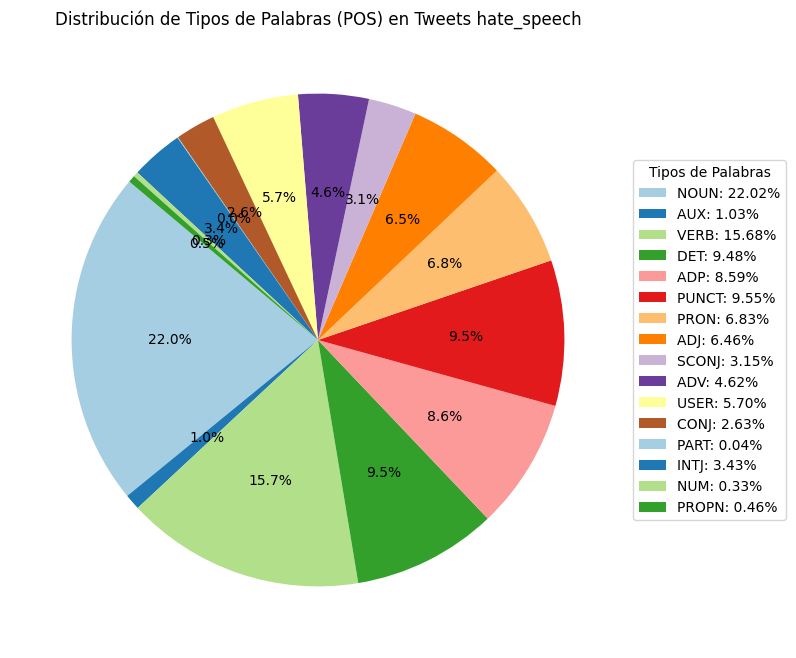

In [107]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(overall_pos_percentages_hate_speech.values(),  startangle=140, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
ax.set_title("Distribución de Tipos de Palabras (POS) en Tweets hate_speech")
legend_labels = [f"{pos_type}: {percentage:.2f}%" for pos_type, percentage in overall_pos_percentages_hate_speech.items()]
ax.legend(wedges, legend_labels, title="Tipos de Palabras", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


-----------------------------------------------

### Tweets no hate_speech

-----------------------------------------------


In [108]:
# POS en tweets no hate_speech
text_not_hate_speech = [text for text in df_semeval_train[df_semeval_train["hate_speech"] == 0]["text"].tolist()]
results_pos_not_hate_speech = [analyze_pos_tags(text) for text in tqdm(text_not_hate_speech)]







  0%|          | 0/2642 [00:00<?, ?it/s]





  0%|          | 3/2642 [00:00<01:28, 29.67it/s]





  0%|          | 7/2642 [00:00<01:17, 34.21it/s]

Texto analizado: Yo veo a mujeres destruidas por acoso laboral y callejero. Otras con depresión debido a violación sexual o maltrato físico. Y conocí a varias que se suicidaron por este tipo de comportamientos machistas. Vas a seguir con tu show pobre? https://t.co/JE6MEgvIh4
Etiquetas encontradas: [('yo', 'PRON'), ('veo', 'VERB'), ('a', 'ADP'), ('mujeres', 'NOUN'), ('destruidas', 'VERB'), ('por', 'ADP'), ('acoso', 'NOUN'), ('laboral', 'ADJ'), ('y', 'CONJ'), ('callejero', 'ADJ'), ('.', 'PUNCT'), ('otras', 'PRON'), ('con', 'ADP'), ('depresión', 'NOUN'), ('debido', 'ADP'), ('a', 'ADP'), ('violación', 'NOUN'), ('sexual', 'ADJ'), ('o', 'CONJ'), ('maltrato', 'NOUN'), ('físico', 'ADJ'), ('.', 'PUNCT'), ('y', 'CONJ'), ('conocí', 'VERB'), ('a', 'ADP'), ('varias', 'PRON'), ('que', 'PRON'), ('se', 'PRON'), ('suicidaron', 'VERB'), ('por', 'ADP'), ('este', 'DET'), ('tipo', 'NOUN'), ('de', 'ADP'), ('comportamientos', 'NOUN'), ('machistas', 'ADJ'), ('.', 'PUNCT'), ('vas', 'AUX'), ('a', 'ADP'), ('seg







  0%|          | 11/2642 [00:00<01:16, 34.56it/s]





  1%|          | 15/2642 [00:00<01:20, 32.75it/s]

Texto analizado: No sé porque hay personas que piensan que todos los inmigrantes son delincuentes
Etiquetas encontradas: [('no', 'ADV'), ('sé', 'VERB'), ('porque', 'SCONJ'), ('hay', 'VERB'), ('personas', 'NOUN'), ('que', 'PRON'), ('piensan', 'VERB'), ('que', 'SCONJ'), ('todos', 'DET'), ('los', 'DET'), ('inmigrantes', 'NOUN'), ('son', 'VERB'), ('delincuentes', 'NOUN')]
Texto analizado: A Tomi Alegre JAKSKKSJSJ — Cállate q tdv estoy de duelo puta https://t.co/ilHP09OzCK
Etiquetas encontradas: [('a', 'ADP'), ('tomi', 'NOUN'), ('alegre', 'ADJ'), ('jakskksjsj', 'INTJ'), (' ', 'INTJ'), ('cállate', 'VERB'), ('q', 'SCONJ'), ('tdv', 'ADV'), ('estoy', 'VERB'), ('de', 'ADP'), ('duelo', 'NOUN'), ('puta', 'NOUN'), ('url', 'INTJ')]
Texto analizado: Albondigas! Casi al estilo de las fodongas pero en el Gabacho.
Etiquetas encontradas: [('albondigas', 'NOUN'), ('!', 'PUNCT'), ('casi', 'ADV'), ('al', 'ADP'), ('estilo', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('fodongas', 'NOUN'), ('pero', 'CONJ'), ('en'







  1%|          | 19/2642 [00:00<01:30, 28.90it/s]

Texto analizado: Yo estaba claro que esta vida de trabajador inmigrante fundido máquina iba a ser difícil. Y es verdad, es difícil jajaja
Etiquetas encontradas: [('yo', 'PRON'), ('estaba', 'VERB'), ('claro', 'ADJ'), ('que', 'SCONJ'), ('esta', 'DET'), ('vida', 'NOUN'), ('de', 'ADP'), ('trabajador', 'NOUN'), ('inmigrante', 'NOUN'), ('fundido', 'ADJ'), ('máquina', 'NOUN'), ('iba', 'AUX'), ('a', 'ADP'), ('ser', 'VERB'), ('difícil', 'ADJ'), ('.', 'PUNCT'), ('y', 'CONJ'), ('es', 'VERB'), ('verdad', 'NOUN'), (',', 'PUNCT'), ('es', 'VERB'), ('difícil', 'ADJ'), ('jaja', 'PUNCT')]
Texto analizado: Mira de vd estoy hasta la polla ya, no aguanto más tonterías
Etiquetas encontradas: [('mira', 'VERB'), ('de', 'ADP'), ('vd', 'NOUN'), ('estoy', 'VERB'), ('hasta', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('ya', 'ADV'), (',', 'PUNCT'), ('no', 'ADV'), ('aguanto', 'VERB'), ('más', 'ADJ'), ('tonterías', 'NOUN')]
Texto analizado: @PepeGonzalezRP @EsmeSese Diappoler* jajaja cállate Pepe niño polla Si me ha







  1%|          | 22/2642 [00:00<01:53, 23.03it/s]

Texto analizado: Que divertido que consideres que una piba por estar con uno con novia es una zorra... si mal no recuerdo tambien te habias metido con uno CON novia, no hay que hacer lo que no nos gusta que nos hagan🙆🙆🙅
Etiquetas encontradas: [('que', 'SCONJ'), ('divertido', 'ADJ'), ('que', 'SCONJ'), ('consideres', 'VERB'), ('que', 'SCONJ'), ('una', 'DET'), ('piba', 'VERB'), ('por', 'ADP'), ('estar', 'VERB'), ('con', 'ADP'), ('uno', 'PRON'), ('con', 'ADP'), ('novia', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('zorra', 'ADJ'), ('...', 'PUNCT'), ('si', 'SCONJ'), ('mal', 'ADV'), ('no', 'ADV'), ('recuerdo', 'VERB'), ('tambien', 'ADV'), ('te', 'PRON'), ('habias', 'AUX'), ('metido', 'VERB'), ('con', 'ADP'), ('uno', 'PRON'), ('con', 'ADP'), ('novia', 'NOUN'), (',', 'PUNCT'), ('no', 'INTJ'), ('hay', 'AUX'), ('que', 'SCONJ'), ('hacer', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('no', 'INTJ'), ('nos', 'PRON'), ('gusta', 'VERB'), ('que', 'SCONJ'), ('nos', 'PRON'), ('hagan', 'VERB'), ('emoji', 'DET







  1%|          | 25/2642 [00:01<02:06, 20.68it/s]





  1%|          | 28/2642 [00:01<01:55, 22.72it/s]

Texto analizado: @Setxuki @Daii__24 callate la puta boca gordo almagro
Etiquetas encontradas: [('@setxuki', 'USER'), ('@daii__24', 'USER'), ('callate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('gordo', 'ADJ'), ('almagro', 'NOUN')]
Texto analizado: Es un gran regalo???? Y una polla un regalo, aquí no le han regalado nada. Se lo ha currado muchísimo, ya vale con las tonterías #OTGala8
Etiquetas encontradas: [('es', 'VERB'), ('un', 'DET'), ('gran', 'ADJ'), ('regalo', 'NOUN'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('y', 'CONJ'), ('una', 'DET'), ('polla', 'NOUN'), ('un', 'DET'), ('regalo', 'NOUN'), (',', 'PUNCT'), ('aquí', 'ADV'), ('no', 'INTJ'), ('le', 'PRON'), ('han', 'AUX'), ('regalado', 'VERB'), ('nada', 'PRON'), ('.', 'PUNCT'), ('se', 'PRON'), ('lo', 'PRON'), ('ha', 'AUX'), ('currado', 'VERB'), ('muchísimo', 'ADV'), (',', 'PUNCT'), ('ya', 'ADV'), ('vale', 'VERB'), ('con', 'ADP'), ('las', 'DET'), ('tonterías', 'NOUN'), ('hashtag', 'PUNCT'), ('otgala8', 'INTJ







  1%|          | 31/2642 [00:01<01:52, 23.28it/s]





  1%|▏         | 36/2642 [00:01<01:28, 29.55it/s]

Texto analizado: Ah vaina, ¿ahora no puedo criticar porque soy inmigrante? Dios mío ¿por que hay gente así? 😒😒 https://t.co/RAHMXDL7G1
Etiquetas encontradas: [('ah', 'INTJ'), ('vaina', 'NOUN'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('ahora', 'ADV'), ('no', 'ADV'), ('puedo', 'VERB'), ('criticar', 'ADJ'), ('porque', 'SCONJ'), ('soy', 'VERB'), ('inmigrante', 'NOUN'), ('?', 'PUNCT'), ('dios', 'NOUN'), ('mío', 'ADJ'), ('¿', 'PUNCT'), ('por', 'ADP'), ('que', 'SCONJ'), ('hay', 'VERB'), ('gente', 'NOUN'), ('así', 'ADJ'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('de', 'ADP'), ('desaprobación', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('de', 'ADP'), ('desaprobación', 'NOUN'), ('emoji', 'NOUN'), (' ', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Immigration ? Invasion ? Entrada masiva de INMIGRANTES subsaharianos a CEUTA | España https://t.co/sUe4DoZLXB via @YouTub information passée sous silence par les médias belges #desinformation
Et







  2%|▏         | 41/2642 [00:01<01:14, 34.76it/s]





  2%|▏         | 47/2642 [00:01<01:05, 39.79it/s]

Texto analizado: La Conferencia Sectorial de Inmigración y Emigración se reúne dentro de una hora por primera vez desde 2015. En lo que va de año, han llegado en patera a las costas de la región 145 ciudadanos argelinos.
Etiquetas encontradas: [('la', 'DET'), ('conferencia', 'NOUN'), ('sectorial', 'ADJ'), ('de', 'ADP'), ('inmigración', 'NOUN'), ('y', 'CONJ'), ('emigración', 'NOUN'), ('se', 'PRON'), ('reúne', 'VERB'), ('dentro', 'ADV'), ('de', 'ADP'), ('una', 'DET'), ('hora', 'NOUN'), ('por', 'ADP'), ('primera', 'ADJ'), ('vez', 'NOUN'), ('desde', 'ADP'), ('2015', 'NOUN'), ('.', 'PUNCT'), ('en', 'ADP'), ('lo', 'DET'), ('que', 'PRON'), ('va', 'VERB'), ('de', 'ADP'), ('año', 'NOUN'), (',', 'PUNCT'), ('han', 'AUX'), ('llegado', 'VERB'), ('en', 'ADP'), ('patera', 'NOUN'), ('a', 'ADP'), ('las', 'DET'), ('costas', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('región', 'NOUN'), ('145', 'NUM'), ('ciudadanos', 'NOUN'), ('argelinos', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @PatricioMery @JorgeGlas Cal







  2%|▏         | 52/2642 [00:01<01:03, 40.60it/s]





  2%|▏         | 58/2642 [00:01<00:58, 43.99it/s]

Texto analizado: Lo peor es que luego los lees y estos simios deformados insinúan que la mujer es malvada y una zorra muajajajaja en el fondo siento lastima por estos seres
Etiquetas encontradas: [('lo', 'DET'), ('peor', 'ADJ'), ('es', 'VERB'), ('que', 'SCONJ'), ('luego', 'ADV'), ('los', 'PRON'), ('lees', 'VERB'), ('y', 'CONJ'), ('estos', 'DET'), ('simios', 'NOUN'), ('deformados', 'ADJ'), ('insinúan', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('malvada', 'ADJ'), ('y', 'CONJ'), ('una', 'DET'), ('zorra', 'NOUN'), ('mujaja', 'INTJ'), ('en', 'ADP'), ('el', 'DET'), ('fondo', 'NOUN'), ('siento', 'VERB'), ('lastima', 'NOUN'), ('por', 'ADP'), ('estos', 'DET'), ('seres', 'NOUN')]
Texto analizado: @PatricioMery @Pontifex_es Callate bobo hijo de puta bestia humana lacra asquerosa izquierdistas rateros mal paridos
Etiquetas encontradas: [('@patriciomery', 'USER'), ('@pontifex_es', 'USER'), ('callate', 'VERB'), ('bobo', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('p







  2%|▏         | 64/2642 [00:01<00:54, 47.41it/s]





  3%|▎         | 70/2642 [00:01<00:51, 50.35it/s]

Texto analizado: Yo no te discuto como sacar una muela así que cállate la puta madre
Etiquetas encontradas: [('yo', 'PRON'), ('no', 'ADV'), ('te', 'PRON'), ('discuto', 'VERB'), ('como', 'ADV'), ('sacar', 'VERB'), ('una', 'DET'), ('muela', 'NOUN'), ('así', 'ADV'), ('que', 'SCONJ'), ('cállate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN')]
Texto analizado: Me voy a pintar el pelo güero para que Alfredo me quiera
Etiquetas encontradas: [('me', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('pintar', 'VERB'), ('el', 'DET'), ('pelo', 'NOUN'), ('güero', 'ADJ'), ('para', 'ADP'), ('que', 'SCONJ'), ('alfredo', 'PROPN'), ('me', 'PRON'), ('quiera', 'VERB')]
Texto analizado: Ayer me estaba muriendo de una perra infección en la garganta y hoy me la peló, ya estoy mejor. 😎
Etiquetas encontradas: [('ayer', 'ADV'), ('me', 'PRON'), ('estaba', 'AUX'), ('muriendo', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('perra', 'ADJ'), ('infección', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('garganta', 'NOUN'), (







  3%|▎         | 76/2642 [00:02<00:49, 51.77it/s]





  3%|▎         | 82/2642 [00:02<00:48, 52.29it/s]

Texto analizado: @alejitacoll ... habemos muchos hombres en contra del acoso; eso sí, no todos lo expresamos desde el prejuicio sexista. Su respuesta se ganará aplausos y likes de los bienpensantes 'pero en ciertos pasajes no representa más que el extremo opuesto de la desastrosa columna de Caballero.'
Etiquetas encontradas: [('@alejitacoll', 'USER'), ('...', 'PUNCT'), ('habemos', 'VERB'), ('muchos', 'DET'), ('hombres', 'NOUN'), ('en', 'ADP'), ('contra', 'NOUN'), ('del', 'ADP'), ('acoso', 'NOUN'), (';', 'PUNCT'), ('eso', 'PRON'), ('sí', 'INTJ'), (',', 'PUNCT'), ('no', 'INTJ'), ('todos', 'PRON'), ('lo', 'PRON'), ('expresamos', 'VERB'), ('desde', 'ADP'), ('el', 'DET'), ('prejuicio', 'NOUN'), ('sexista', 'ADJ'), ('.', 'PUNCT'), ('su', 'DET'), ('respuesta', 'NOUN'), ('se', 'PRON'), ('ganará', 'VERB'), ('aplausos', 'NOUN'), ('y', 'CONJ'), ('likes', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('bienpensantes', 'NOUN'), ("'", 'PUNCT'), ('pero', 'CONJ'), ('en', 'ADP'), ('ciertos', 'DET'), ('pasaje







  3%|▎         | 88/2642 [00:02<00:48, 52.57it/s]

Texto analizado: @Elaguijon_ Hoy toda esta escoria está callada me gustaría oírlos hablar #HDPasesinos
Etiquetas encontradas: [('@elaguijon', 'USER'), ('_', 'PUNCT'), ('hoy', 'ADV'), ('toda', 'DET'), ('esta', 'DET'), ('escoria', 'NOUN'), ('está', 'VERB'), ('callada', 'ADJ'), ('me', 'PRON'), ('gustaría', 'VERB'), ('oírlos', 'VERB'), ('hablar', 'VERB'), ('hashtag', 'ADV'), ('hdpasesinos', 'NOUN')]
Texto analizado: @lammothsenpai el simio fuenlabreño al cual tengo que ver más a menudo. Eres un tío de puta madre y te mereces lo mejor del mundo. Espero que en 2018 te vaya todo de lujo y empieces por la puerta grande.
Etiquetas encontradas: [('@lammothsenpai', 'USER'), ('el', 'DET'), ('simio', 'NOUN'), ('fuenlabreño', 'ADJ'), ('al', 'ADP'), ('cual', 'PRON'), ('tengo', 'AUX'), ('que', 'SCONJ'), ('ver', 'VERB'), ('más', 'ADV'), ('a', 'ADP'), ('menudo', 'NOUN'), ('.', 'PUNCT'), ('eres', 'VERB'), ('un', 'DET'), ('tío', 'NOUN'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('y', 'CONJ'), ('







  4%|▎         | 94/2642 [00:02<00:53, 47.64it/s]





  4%|▎         | 99/2642 [00:02<00:52, 48.04it/s]

Texto analizado: Me encantaria darte unas nalgadas ricas ❤ — A mí me encantaría pegarte una hostia en la cara https://t.co/rUKwwVXlxm
Etiquetas encontradas: [('me', 'PRON'), ('encantaria', 'VERB'), ('darte', 'VERB'), ('unas', 'DET'), ('nalgadas', 'NOUN'), ('ricas', 'ADJ'), ('  ', 'PUNCT'), ('a', 'ADP'), ('mí', 'PRON'), ('me', 'PRON'), ('encantaría', 'VERB'), ('pegarte', 'VERB'), ('una', 'DET'), ('hostia', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('url', 'INTJ')]
Texto analizado: Porque andan llamando gata, zorra o puta a baekhyun si es hombre, manga de ridiculas
Etiquetas encontradas: [('porque', 'SCONJ'), ('andan', 'AUX'), ('llamando', 'VERB'), ('gata', 'NOUN'), (',', 'PUNCT'), ('zorra', 'NOUN'), ('o', 'CONJ'), ('puta', 'NOUN'), ('a', 'ADP'), ('baekhyun', 'NOUN'), ('si', 'SCONJ'), ('es', 'VERB'), ('hombre', 'NOUN'), (',', 'PUNCT'), ('manga', 'NOUN'), ('de', 'ADP'), ('ridiculas', 'ADJ')]
Texto analizado: es una chinguita hacer tamales', refunfuña mi sirvienta la diódora







  4%|▍         | 104/2642 [00:02<00:53, 47.04it/s]





  4%|▍         | 109/2642 [00:02<00:54, 46.11it/s]

Texto analizado: El Director General de la Guardia Civil recorrerá esta tarde la valla que fue asaltada en Ceuta. ¡¡¡ A BUENAS HORAS, MANGAS VERDES !!!
Etiquetas encontradas: [('el', 'DET'), ('director', 'NOUN'), ('general', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('guardia', 'NOUN'), ('civil', 'ADJ'), ('recorrerá', 'VERB'), ('esta', 'DET'), ('tarde', 'NOUN'), ('la', 'DET'), ('valla', 'NOUN'), ('que', 'PRON'), ('fue', 'VERB'), ('asaltada', 'VERB'), ('en', 'ADP'), ('ceuta', 'NOUN'), ('.', 'PUNCT'), ('¡', 'PUNCT'), ('¡', 'PUNCT'), ('¡', 'PUNCT'), ('a', 'ADP'), ('buenas', 'ADJ'), ('horas', 'NOUN'), (',', 'PUNCT'), ('mangas', 'NOUN'), ('verdes', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: @laLauusrobles Tu eres zorra amiga jajajajajajajaja
Etiquetas encontradas: [('@lalauusrobles', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('zorra', 'ADJ'), ('amiga', 'NOUN'), ('jaja', 'NOUN')]
Texto analizado: @letra_escarlata @Pepe_Tron_B_M @anaisbernal @20m Y estos son los hijo







  4%|▍         | 115/2642 [00:02<00:52, 48.17it/s]





  5%|▍         | 121/2642 [00:03<00:49, 50.73it/s]

Texto analizado: La introducción de los discursos de disculpa de los acusados de acoso sexual este año: https://t.co/RMiRzxmb0Z
Etiquetas encontradas: [('la', 'DET'), ('introducción', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('discursos', 'NOUN'), ('de', 'ADP'), ('disculpa', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('acusados', 'NOUN'), ('de', 'ADP'), ('acoso', 'NOUN'), ('sexual', 'ADJ'), ('este', 'DET'), ('año', 'NOUN'), (':', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: una chica dijo que no le gustaron los chistes sobre acoso y violación en el video de Rubén y esto le contestaban algunos de sus fans https://t.co/F2SKl21D4B
Etiquetas encontradas: [('una', 'DET'), ('chica', 'NOUN'), ('dijo', 'VERB'), ('que', 'SCONJ'), ('no', 'INTJ'), ('le', 'PRON'), ('gustaron', 'VERB'), ('los', 'DET'), ('chistes', 'NOUN'), ('sobre', 'ADP'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('violación', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('video', 'NOUN'), ('de', 'ADP'), ('rubén', 'PROPN'), ('y', 'CONJ'), ('esto', 







  5%|▍         | 127/2642 [00:03<00:48, 51.75it/s]





  5%|▌         | 133/2642 [00:03<00:47, 52.65it/s]

Texto analizado: Del árbol del silencio pende el fruto de la seguridad-Proverbio Árabe
Etiquetas encontradas: [('del', 'ADP'), ('árbol', 'NOUN'), ('del', 'ADP'), ('silencio', 'NOUN'), ('pende', 'VERB'), ('el', 'DET'), ('fruto', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('seguridad-proverbio', 'NOUN'), ('árabe', 'NOUN')]
Texto analizado: El acoso sexual empieza a destaparse en la industria musical: poderoso magnate acusado de violación por varias ... https://t.co/g8ZpzWEWeS
Etiquetas encontradas: [('el', 'DET'), ('acoso', 'NOUN'), ('sexual', 'ADJ'), ('empieza', 'AUX'), ('a', 'ADP'), ('destaparse', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('industria', 'NOUN'), ('musical', 'ADJ'), (':', 'PUNCT'), ('poderoso', 'ADJ'), ('magnate', 'NOUN'), ('acusado', 'VERB'), ('de', 'ADP'), ('violación', 'NOUN'), ('por', 'ADP'), ('varias', 'DET'), ('...', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: Estoy haciendo el check-in a una muchacha de los Emiratos Árabes. Ella: ese tatuaje es árabe, ¿no?  Yo: sí 😨 (yo







  5%|▌         | 139/2642 [00:03<00:47, 52.22it/s]





  5%|▌         | 145/2642 [00:03<00:47, 52.26it/s]

Texto analizado: Msdossary CAMPEÓN del Mundo de FIFA 2018. Stefano Pinna no pudo hacer nada ante el árabe. Resultado totalmente merecido. #FIFAeWorldCup
Etiquetas encontradas: [('msdossary', 'NOUN'), ('campeón', 'NOUN'), ('del', 'ADP'), ('mundo', 'NOUN'), ('de', 'ADP'), ('fifa', 'NOUN'), ('2018', 'NOUN'), ('.', 'PUNCT'), ('stefano', 'NOUN'), ('pinna', 'NOUN'), ('no', 'ADV'), ('pudo', 'VERB'), ('hacer', 'VERB'), ('nada', 'PRON'), ('ante', 'ADP'), ('el', 'DET'), ('árabe', 'NOUN'), ('.', 'PUNCT'), ('resultado', 'NOUN'), ('totalmente', 'ADV'), ('merecido', 'ADJ'), ('.', 'PUNCT'), ('hashtag', 'DET'), ('fifaeworldcup', 'NOUN')]
Texto analizado: ¿Qué actor pudo ser un gran #Aquaman güero en el Universo Extendido de DC? Checa nuestro video y entérate de nuestras opciones https://t.co/BkJqSPu3Bv https://t.co/bdHVF5wsgw
Etiquetas encontradas: [('¿', 'PUNCT'), ('qué', 'DET'), ('actor', 'NOUN'), ('pudo', 'AUX'), ('ser', 'VERB'), ('un', 'DET'), ('gran', 'ADJ'), ('hashtag', 'NOUN'), ('aquaman', 'NOU







  6%|▌         | 151/2642 [00:03<00:47, 52.47it/s]

Texto analizado: @ronuevo @FCBarcelona_es Bobo hijo de perra, usted cree que va a enseñarle a Messi o llega a aprender del más grande?
Etiquetas encontradas: [('@ronuevo', 'USER'), ('@fcbarcelona_es', 'USER'), ('bobo', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('perra', 'NOUN'), (',', 'PUNCT'), ('usted', 'PRON'), ('cree', 'VERB'), ('que', 'SCONJ'), ('va', 'AUX'), ('a', 'ADP'), ('enseñarle', 'VERB'), ('a', 'ADP'), ('messi', 'NOUN'), ('o', 'CONJ'), ('llega', 'AUX'), ('a', 'ADP'), ('aprender', 'VERB'), ('del', 'ADP'), ('más', 'ADV'), ('grande', 'ADJ'), ('?', 'PUNCT')]
Texto analizado: @asukasexual comemela tu a mi mamon XDDDD
Etiquetas encontradas: [('@asukasexual', 'USER'), ('comemela', 'VERB'), ('tu', 'PRON'), ('a', 'ADP'), ('mi', 'DET'), ('mamon', 'NOUN'), ('xddd', 'NOUN')]
Texto analizado: Me voy de viaje con unos tíos de mi papá y solo hablan en árabe😴😴😴😴😴😴
Etiquetas encontradas: [('me', 'PRON'), ('voy', 'VERB'), ('de', 'ADP'), ('viaje', 'NOUN'), ('con', 'ADP'), ('unos', 'DET'), ('tío







  6%|▌         | 157/2642 [00:03<00:51, 47.99it/s]





  6%|▌         | 162/2642 [00:03<00:52, 46.98it/s]

Texto analizado: Retweeted La Silla Rota (@lasillarota):  "Atendía sexualmente a 30 hombres al día, entre ellos policías y militares" Esta es la #Historia de "La Güera" #Video https://t.co/fvfQhtS0er
Etiquetas encontradas: [('retweeted', 'VERB'), ('la', 'DET'), ('silla', 'NOUN'), ('rota', 'ADJ'), ('(', 'PUNCT'), ('@lasillarota', 'USER'), ('):', 'PUNCT'), (' ', 'PUNCT'), ('"', 'PUNCT'), ('atendía', 'VERB'), ('sexualmente', 'ADV'), ('a', 'ADP'), ('30', 'NUM'), ('hombres', 'NOUN'), ('al', 'ADP'), ('día', 'NOUN'), (',', 'PUNCT'), ('entre', 'ADP'), ('ellos', 'PRON'), ('policías', 'NOUN'), ('y', 'CONJ'), ('militares', 'NOUN'), ('"', 'PUNCT'), ('esta', 'PRON'), ('es', 'VERB'), ('la', 'DET'), ('hashtag', 'NOUN'), ('historia', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('la', 'DET'), ('güera', 'NOUN'), ('"', 'PUNCT'), ('hashtag', 'NOUN'), ('video', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: ¿Quién les enseñará a los hijos fe puta a ser hijos de puta?
Etiquetas encontradas: [('¿', 'PUNCT'), ('quié







  6%|▋         | 168/2642 [00:03<00:50, 49.03it/s]





  7%|▋         | 174/2642 [00:04<00:49, 49.99it/s]

Texto analizado: Cuando Albiol deje la política le pueden contratar como director de Okdiario porque lo de inventarse cosas y difamar se le da de puta madre.
Etiquetas encontradas: [('cuando', 'SCONJ'), ('albiol', 'PROPN'), ('deje', 'VERB'), ('la', 'DET'), ('política', 'NOUN'), ('le', 'PRON'), ('pueden', 'AUX'), ('contratar', 'VERB'), ('como', 'ADP'), ('director', 'NOUN'), ('de', 'ADP'), ('okdiario', 'NOUN'), ('porque', 'SCONJ'), ('lo', 'DET'), ('de', 'ADP'), ('inventarse', 'VERB'), ('cosas', 'NOUN'), ('y', 'CONJ'), ('difamar', 'VERB'), ('se', 'PRON'), ('le', 'PRON'), ('da', 'VERB'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: El güero de fiesta jajaja el problema no fue animarlo sino después calmarlo #funweekend https://t.co/zd7qF3C1lh
Etiquetas encontradas: [('el', 'DET'), ('güero', 'NOUN'), ('de', 'ADP'), ('fiesta', 'NOUN'), ('jaja', 'INTJ'), ('el', 'DET'), ('problema', 'NOUN'), ('no', 'ADV'), ('fue', 'VERB'), ('animarlo', 'VERB'), ('sino', 'C







  7%|▋         | 180/2642 [00:04<00:48, 50.34it/s]





  7%|▋         | 186/2642 [00:04<00:48, 50.90it/s]

Texto analizado: Las #niñas #niños y #adolescentes pueden ser #refugiados. Las cifras de @unhcr muestran la enorme vulnerabilidad de NNA al desplazamiento forzado https://t.co/MpyWfweTt4
Etiquetas encontradas: [('las', 'DET'), ('hashtag', 'NOUN'), ('niñas', 'NOUN'), ('hashtag', 'PROPN'), ('niños', 'NOUN'), ('y', 'NOUN'), ('hashtag', 'NOUN'), ('adolescentes', 'NOUN'), ('pueden', 'AUX'), ('ser', 'VERB'), ('hashtag', 'DET'), ('refugiados', 'NOUN'), ('.', 'PUNCT'), ('las', 'DET'), ('cifras', 'NOUN'), ('de', 'ADP'), ('@unhcr', 'USER'), ('muestran', 'VERB'), ('la', 'DET'), ('enorme', 'ADJ'), ('vulnerabilidad', 'NOUN'), ('de', 'ADP'), ('nna', 'PART'), ('al', 'ADP'), ('desplazamiento', 'NOUN'), ('forzado', 'ADJ'), ('url', 'ADP')]
Texto analizado: Acá es como que vas al club a tomar algo y si o si tenes que cruzar a sudaca para qué tal está
Etiquetas encontradas: [('acá', 'ADV'), ('es', 'VERB'), ('como', 'ADV'), ('que', 'SCONJ'), ('vas', 'VERB'), ('al', 'ADP'), ('club', 'NOUN'), ('a', 'ADP'), (







  7%|▋         | 192/2642 [00:04<00:47, 51.37it/s]





  7%|▋         | 198/2642 [00:04<00:47, 51.42it/s]

Texto analizado: MI GANADORA GRACIAS! TE LO MERECES!!! ERES LA PUTA VOZ ❤ @AlbaGilLaVoz #FinalLaVoz
Etiquetas encontradas: [('mi', 'DET'), ('ganadora', 'NOUN'), ('gracias', 'INTJ'), ('!', 'PUNCT'), ('te', 'PRON'), ('lo', 'PRON'), ('mereces', 'VERB'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('eres', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('voz', 'NOUN'), (' ', 'PUNCT'), ('@albagillavoz', 'USER'), ('hashtag', 'NOUN'), ('finallavoz', 'NOUN')]
Texto analizado: ... inmigración... populismo... Rivera... Casado... cuatro patas 'pa' un banco... https://t.co/57uOmk5PYE
Etiquetas encontradas: [('...', 'PUNCT'), ('inmigración', 'NOUN'), ('...', 'PUNCT'), ('populismo', 'NOUN'), ('...', 'PUNCT'), ('rivera', 'NOUN'), ('...', 'PUNCT'), ('casado', 'VERB'), ('...', 'PUNCT'), ('cuatro', 'NUM'), ('patas', 'NOUN'), ("'", 'VERB'), ('pa', 'ADP'), ("'", 'VERB'), ('un', 'DET'), ('banco', 'NOUN'), ('...', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: Lo vuelvo a mencionar porque es que me cabrea mucho







  8%|▊         | 204/2642 [00:04<00:47, 51.59it/s]

Texto analizado: Esta súper chido pero no se que hueva, quizá es lo mismo con el repertorio de árabe, que se repite siempre y se reciclan bailes en cada presentación 🤔🤔🤔
Etiquetas encontradas: [('esta', 'DET'), ('súper', 'ADV'), ('chido', 'ADJ'), ('pero', 'CONJ'), ('no', 'ADV'), ('se', 'PRON'), ('que', 'SCONJ'), ('hueva', 'NOUN'), (',', 'PUNCT'), ('quizá', 'ADV'), ('es', 'VERB'), ('lo', 'DET'), ('mismo', 'ADJ'), ('con', 'ADP'), ('el', 'DET'), ('repertorio', 'NOUN'), ('de', 'ADP'), ('árabe', 'PROPN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('se', 'PRON'), ('repite', 'VERB'), ('siempre', 'ADV'), ('y', 'CONJ'), ('se', 'PRON'), ('reciclan', 'VERB'), ('bailes', 'NOUN'), ('en', 'ADP'), ('cada', 'DET'), ('presentación', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'PROPN'), ('cara', 'ADV'), ('pensativa', 'ADJ'), ('emoji', 'PROPN'), (' ', 'NOUN'), ('emoji', 'INTJ'), ('cara', 'ADV'), ('pensativa', 'ADJ'), ('emoji', 'INTJ'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('pensativa', 'ADJ'), ('emoji', 'N







  8%|▊         | 210/2642 [00:04<00:50, 48.43it/s]





  8%|▊         | 216/2642 [00:04<00:47, 50.55it/s]

Texto analizado: Kirei, mereces una muerte lenta y dolorosa hijo de puta. #FateZero
Etiquetas encontradas: [('kirei', 'NOUN'), (',', 'PUNCT'), ('mereces', 'VERB'), ('una', 'DET'), ('muerte', 'NOUN'), ('lenta', 'ADJ'), ('y', 'CONJ'), ('dolorosa', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'NOUN'), ('fatezero', 'NOUN')]
Texto analizado: Estimado @tonialba, los catalanes no tenemos genes franceses. Los tenemos alemanes y tú eres un hijo de puta. Documento cedido por el Institut Nova Historia o como yo los llamo: 1984. La imagen es una coña, lo hijo de puta que eres, no. https://t.co/DZB9I12vMo
Etiquetas encontradas: [('estimado', 'ADJ'), ('@tonialba', 'USER'), (',', 'PUNCT'), ('los', 'DET'), ('catalanes', 'NOUN'), ('no', 'ADV'), ('tenemos', 'VERB'), ('genes', 'NOUN'), ('franceses', 'NOUN'), ('.', 'PUNCT'), ('los', 'DET'), ('tenemos', 'VERB'), ('alemanes', 'NOUN'), ('y', 'CONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('un', 'DET'), ('hijo', 'NOUN'), 







  8%|▊         | 222/2642 [00:05<00:47, 51.44it/s]





  9%|▊         | 228/2642 [00:05<00:45, 52.89it/s]

Texto analizado: @Barbijaputa Chica, la verdad me da igual que tengas coño o falo y pelotas, lo importante para mí es lo escribes y la verdad lo haces más bien con el cerebro que con los genitales. Así sigue dando guerra!
Etiquetas encontradas: [('@barbijaputa', 'USER'), ('chica', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('verdad', 'NOUN'), ('me', 'PRON'), ('da', 'VERB'), ('igual', 'ADV'), ('que', 'SCONJ'), ('tengas', 'VERB'), ('coño', 'NOUN'), ('o', 'CONJ'), ('falo', 'NOUN'), ('y', 'CONJ'), ('pelotas', 'NOUN'), (',', 'PUNCT'), ('lo', 'DET'), ('importante', 'ADJ'), ('para', 'ADP'), ('mí', 'PRON'), ('es', 'VERB'), ('lo', 'PRON'), ('escribes', 'VERB'), ('y', 'CONJ'), ('la', 'DET'), ('verdad', 'NOUN'), ('lo', 'PRON'), ('haces', 'VERB'), ('más', 'ADV'), ('bien', 'ADV'), ('con', 'ADP'), ('el', 'DET'), ('cerebro', 'NOUN'), ('que', 'SCONJ'), ('con', 'ADP'), ('los', 'DET'), ('genitales', 'NOUN'), ('.', 'PUNCT'), ('así', 'ADV'), ('sigue', 'AUX'), ('dando', 'VERB'), ('guerra', 'NOUN'), ('!', 'PUN







  9%|▉         | 234/2642 [00:05<00:45, 52.43it/s]





  9%|▉         | 240/2642 [00:05<00:45, 52.66it/s]

Texto analizado: @alpiNo_10 Comemela yonki. A ver si jugamos al player
Etiquetas encontradas: [('@alpino_10', 'USER'), ('comemela', 'VERB'), ('yonki', 'NOUN'), ('.', 'PUNCT'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('jugamos', 'VERB'), ('al', 'ADP'), ('player', 'NOUN')]
Texto analizado: Ken cada vez es más güero en las caricaturas de Barbie, en mis tiempos era morenito ahorita hasta las mejillas rosadas tiene😂
Etiquetas encontradas: [('ken', 'INTJ'), ('cada', 'DET'), ('vez', 'NOUN'), ('es', 'VERB'), ('más', 'ADV'), ('güero', 'ADJ'), ('en', 'ADP'), ('las', 'DET'), ('caricaturas', 'NOUN'), ('de', 'ADP'), ('barbie', 'NOUN'), (',', 'PUNCT'), ('en', 'ADP'), ('mis', 'DET'), ('tiempos', 'NOUN'), ('era', 'VERB'), ('morenito', 'ADJ'), ('ahorita', 'ADV'), ('hasta', 'ADP'), ('las', 'DET'), ('mejillas', 'NOUN'), ('rosadas', 'ADJ'), ('tiene', 'VERB'), ('emoji', 'DET'), ('cara', 'NOUN'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: Ayer fui a un







  9%|▉         | 246/2642 [00:05<00:46, 51.89it/s]





 10%|▉         | 252/2642 [00:05<00:46, 51.61it/s]

Texto analizado: Y yo sin papeles 🤦🤦
Etiquetas encontradas: [('y', 'CONJ'), ('yo', 'PRON'), ('sin', 'ADJ'), ('papeles', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('persona', 'NOUN'), ('con', 'ADP'), ('la', 'DET'), ('mano', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('frente', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('persona', 'NOUN'), ('con', 'ADP'), ('la', 'DET'), ('mano', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('frente', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: @dsilvao Más que seguro que muchos nacieron producto de acoso y hasta violación 😒. Personalmente, nunca he tenido problemas para conquistar sin recurrir a la intimidación.
Etiquetas encontradas: [('@dsilvao', 'USER'), ('más', 'ADV'), ('que', 'SCONJ'), ('seguro', 'ADV'), ('que', 'SCONJ'), ('muchos', 'PRON'), ('nacieron', 'VERB'), ('producto', 'NOUN'), ('de', 'ADP'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('hasta', 'ADP'), ('violación', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('de', 'ADP'







 10%|▉         | 258/2642 [00:05<00:48, 48.99it/s]





 10%|▉         | 263/2642 [00:05<00:50, 46.85it/s]

Texto analizado: @hardbambi_ @NaiaDolan encima por una puta nominación que no se merecía. Si por lo menos fuera una nominación merecida...
Etiquetas encontradas: [('@hardbambi', 'USER'), ('_', 'PUNCT'), ('@naiadolan', 'USER'), ('encima', 'ADV'), ('por', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('nominación', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('merecía', 'VERB'), ('.', 'PUNCT'), ('si', 'SCONJ'), ('por', 'ADP'), ('lo', 'DET'), ('menos', 'ADV'), ('fuera', 'VERB'), ('una', 'DET'), ('nominación', 'NOUN'), ('merecida', 'ADJ'), ('...', 'PUNCT')]
Texto analizado: Cara Delevigne, acusada de fomentar el acoso y la violación en su nuevo anuncio https://t.co/GnNzMoVl7a https://t.co/pHRb7OWg97
Etiquetas encontradas: [('cara', 'NOUN'), ('delevigne', 'NOUN'), (',', 'PUNCT'), ('acusada', 'ADJ'), ('de', 'ADP'), ('fomentar', 'VERB'), ('el', 'DET'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('violación', 'NOUN'), ('en', 'ADP'), ('su', 'DET'), ('nuevo', 'ADJ'), ('anuncio', 'N







 10%|█         | 269/2642 [00:05<00:47, 49.52it/s]







Texto analizado: Es imposible escuchar Arabe de ecko sin bailarlo.
Etiquetas encontradas: [('es', 'VERB'), ('imposible', 'ADV'), ('escuchar', 'VERB'), ('arabe', 'NOUN'), ('de', 'ADP'), ('ecko', 'NOUN'), ('sin', 'ADP'), ('bailarlo', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @AnaDargallo @imma0142 @Hermo46572739 @M_BrokenLeg @omnium @PPopular Tu eres lo peor de la escoria que anda suelta
Etiquetas encontradas: [('@anadargallo', 'USER'), ('@imma0142', 'USER'), ('@hermo46572739', 'USER'), ('@m_brokenleg', 'USER'), ('@omnium', 'USER'), ('@ppopular', 'USER'), ('tu', 'PRON'), ('eres', 'VERB'), ('lo', 'DET'), ('peor', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('escoria', 'NOUN'), ('que', 'PRON'), ('anda', 'VERB'), ('suelta', 'ADJ')]
Texto analizado: inventarse espías de amlo para montarte todo un show de acoso y persecusión q acaba de guardanalgas por los celos de un afiliado blandengue mocho es pretexto p pedir 💰a la sectayunquera o al partido
Etiquetas encontradas: [('inventarse', 'VERB'), ('esp

 10%|█         | 275/2642 [00:06<00:47, 50.12it/s]





 11%|█         | 281/2642 [00:06<00:45, 51.68it/s]

Texto analizado: Te quiero comer toda la polla — Pos eso hay que ganarselo primero almadepollo, soy el tipo de imbecil al que le pone que se lo pi... https://t.co/CKUjG9KmTV
Etiquetas encontradas: [('te', 'PRON'), ('quiero', 'VERB'), ('comer', 'VERB'), ('toda', 'DET'), ('la', 'DET'), ('polla', 'NOUN'), (' ', 'PUNCT'), ('pos', 'INTJ'), ('eso', 'PRON'), ('hay', 'AUX'), ('que', 'SCONJ'), ('ganarselo', 'VERB'), ('primero', 'ADV'), ('almadepollo', 'NOUN'), (',', 'PUNCT'), ('soy', 'VERB'), ('el', 'DET'), ('tipo', 'NOUN'), ('de', 'ADP'), ('imbecil', 'NOUN'), ('al', 'ADP'), ('que', 'PRON'), ('le', 'PRON'), ('pone', 'VERB'), ('que', 'SCONJ'), ('se', 'PRON'), ('lo', 'PRON'), ('pi', 'VERB'), ('...', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @lamacope Para q le chupe la polla. Que eres un pesao Callate ya
Etiquetas encontradas: [('@lamacope', 'USER'), ('para', 'ADP'), ('q', 'SCONJ'), ('le', 'PRON'), ('chupe', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('eres', '







 11%|█         | 287/2642 [00:06<00:45, 51.47it/s]





 11%|█         | 293/2642 [00:06<00:46, 50.76it/s]

Texto analizado: @Juanmaherrera27 @YouTube a saber que hijo de puta te la enseñaria
Etiquetas encontradas: [('@juanmaherrera27', 'USER'), ('@youtube', 'USER'), ('a', 'ADP'), ('saber', 'VERB'), ('que', 'SCONJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('te', 'PRON'), ('la', 'PRON'), ('enseñaria', 'VERB')]
Texto analizado: @LeticiaDolera Pues una puta mierda
Etiquetas encontradas: [('@leticiadolera', 'USER'), ('pues', 'SCONJ'), ('una', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN')]
Texto analizado: Ya nos hemos pasado si el simple echo de guiñarle un ojo a una mujer es acoso ¡¡¡¡¡¡ DOS MIO QUE ALGUIEN ME DIGA COMO SE LIGA HOY EN DÍA ¡¡¡¡¡
Etiquetas encontradas: [('ya', 'ADV'), ('nos', 'PRON'), ('hemos', 'AUX'), ('pasado', 'VERB'), ('si', 'SCONJ'), ('el', 'DET'), ('simple', 'ADJ'), ('echo', 'NOUN'), ('de', 'ADP'), ('guiñarle', 'VERB'), ('un', 'DET'), ('ojo', 'NOUN'), ('a', 'ADP'), ('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('acoso', 'NOUN'), ('¡', 'PUNCT'), ('¡', 'PUNCT')







 11%|█▏        | 299/2642 [00:06<00:47, 49.46it/s]





 12%|█▏        | 304/2642 [00:06<00:49, 47.11it/s]

Texto analizado: No volverá a responder a la palabra Gabacha. Así que ahí se queda. Con uno tuvo suficiente.
Etiquetas encontradas: [('no', 'ADV'), ('volverá', 'AUX'), ('a', 'ADP'), ('responder', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('palabra', 'NOUN'), ('gabacha', 'ADJ'), ('.', 'PUNCT'), ('así', 'ADV'), ('que', 'SCONJ'), ('ahí', 'ADV'), ('se', 'PRON'), ('queda', 'VERB'), ('.', 'PUNCT'), ('con', 'ADP'), ('uno', 'PRON'), ('tuvo', 'VERB'), ('suficiente', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @verobecker Por la violacion de la democracia en Centro y Sur América. .. donde la escoria de izquierda quiere imponer su fracaso.
Etiquetas encontradas: [('@verobecker', 'USER'), ('por', 'ADP'), ('la', 'DET'), ('violacion', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('democracia', 'NOUN'), ('en', 'ADP'), ('centro', 'NOUN'), ('y', 'CONJ'), ('sur', 'NOUN'), ('américa', 'NOUN'), ('.', 'PUNCT'), ('..', 'PUNCT'), ('donde', 'ADV'), ('la', 'DET'), ('escoria', 'NOUN'), ('de', 'ADP'), ('izquierda', 'NOUN'), 







 12%|█▏        | 309/2642 [00:06<01:00, 38.31it/s]

Texto analizado: @ximeeacuna @liveforlouisx Sobre un político que tiene denuncias por violación y acoso sexual a menores
Etiquetas encontradas: [('@ximeeacuna', 'USER'), ('@liveforlouisx', 'USER'), ('sobre', 'ADP'), ('un', 'DET'), ('político', 'NOUN'), ('que', 'PRON'), ('tiene', 'VERB'), ('denuncias', 'NOUN'), ('por', 'ADP'), ('violación', 'NOUN'), ('y', 'CONJ'), ('acoso', 'NOUN'), ('sexual', 'ADJ'), ('a', 'ADP'), ('menores', 'NOUN')]
Texto analizado: @D3STR0_ @FCBarcelona_es Soy cule y antiperico, pero tú eres un hijo de la gran puta
Etiquetas encontradas: [('@d3str0', 'USER'), ('_', 'INTJ'), ('@fcbarcelona_es', 'USER'), ('soy', 'VERB'), ('cule', 'ADJ'), ('y', 'CONJ'), ('antiperico', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('un', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN')]
Texto analizado: @RafaeIRamosV es posible q el Vasco logre q le entiendan su idea en árabe más fácil q lo q le entendieron a Osorio 







 12%|█▏        | 314/2642 [00:07<01:04, 36.16it/s]

Texto analizado: #HaceMuchoQue no tienes derechos #Honey...
Etiquetas encontradas: [('hashtag', 'NOUN'), ('hacemuchoque', 'INTJ'), ('no', 'INTJ'), ('tienes', 'VERB'), ('derechos', 'NOUN'), ('hashtag', 'NOUN'), ('honey', 'NOUN'), ('...', 'PUNCT')]
Texto analizado: @abogadopenal @sasarandag Yo creo que sí. Primer ejemplo de acoso sexual: levantar la falda para ver enaguas.
Etiquetas encontradas: [('@abogadopenal', 'USER'), ('@sasarandag', 'USER'), ('yo', 'PRON'), ('creo', 'VERB'), ('que', 'SCONJ'), ('sí', 'INTJ'), ('.', 'PUNCT'), ('primer', 'ADJ'), ('ejemplo', 'NOUN'), ('de', 'ADP'), ('acoso', 'NOUN'), ('sexual', 'ADJ'), (':', 'PUNCT'), ('levantar', 'VERB'), ('la', 'DET'), ('falda', 'NOUN'), ('para', 'ADP'), ('ver', 'VERB'), ('enaguas', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Sería la puta hostia! Pero no sé quién le puede enseñar algo, eso sí, desfibriladores a mano, eskerrik askoooo!!! https://t.co/HrFunTjFwh
Etiquetas encontradas: [('sería', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), 







 12%|█▏        | 318/2642 [00:07<01:13, 31.68it/s]





 12%|█▏        | 322/2642 [00:07<01:17, 29.85it/s]

Texto analizado: Guarra se folla a Papá Noel en un autobús https://t.co/YUseYMe6ss https://t.co/jGhp8RBRUo
Etiquetas encontradas: [('guarra', 'NOUN'), ('se', 'PRON'), ('folla', 'VERB'), ('a', 'ADP'), ('papá', 'NOUN'), ('noel', 'NOUN'), ('en', 'ADP'), ('un', 'DET'), ('autobús', 'NOUN'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto analizado: @Viejastirpe 'Profe al final no te puedo enseñar mi polla salterina pero te puedo mostrar un testiculo que grita.Apruébame anda'
Etiquetas encontradas: [('@viejastirpe', 'USER'), ("'", 'PUNCT'), ('profe', 'NOUN'), ('al', 'ADP'), ('final', 'NOUN'), ('no', 'ADV'), ('te', 'PRON'), ('puedo', 'AUX'), ('enseñar', 'VERB'), ('mi', 'DET'), ('polla', 'NOUN'), ('salterina', 'ADJ'), ('pero', 'CONJ'), ('te', 'PRON'), ('puedo', 'AUX'), ('mostrar', 'VERB'), ('un', 'DET'), ('testiculo', 'NOUN'), ('que', 'PRON'), ('grita.apruébame', 'VERB'), ('anda', 'INTJ'), ("'", 'PUNCT')]
Texto analizado: Se sale en modo arabe? Jajajaj 😂
Etiquetas encontradas: [('se', 'PRON'), ('sale'







 12%|█▏        | 327/2642 [00:07<01:07, 34.13it/s]





 13%|█▎        | 332/2642 [00:07<01:01, 37.78it/s]

Texto analizado: @MichelGonzalez jodete!!!!estás donde mereces, EN LA PUTA CALLE
Etiquetas encontradas: [('@michelgonzalez', 'USER'), ('jodete!!!estás', 'VERB'), ('donde', 'ADV'), ('mereces', 'VERB'), (',', 'PUNCT'), ('en', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('calle', 'NOUN')]
Texto analizado: @_Martinowo_ Cállate tonto pasemos un buen año que seguro que nos va de puta madre hazte caso
Etiquetas encontradas: [('@_martinowo', 'USER'), ('_', 'PUNCT'), ('cállate', 'VERB'), ('tonto', 'ADJ'), ('pasemos', 'VERB'), ('un', 'DET'), ('buen', 'ADJ'), ('año', 'NOUN'), ('que', 'SCONJ'), ('seguro', 'ADV'), ('que', 'SCONJ'), ('nos', 'PRON'), ('va', 'VERB'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('hazte', 'VERB'), ('caso', 'NOUN')]
Texto analizado: @VickyGomes0 @matisztajn CALLATE HIJO DE RE MIL PUTA
Etiquetas encontradas: [('@vickygomes0', 'USER'), ('@matisztajn', 'USER'), ('callate', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('re', 'ADV'), ('mil', 'INTJ'), ('puta', 'NOUN')]
Texto a







 13%|█▎        | 338/2642 [00:07<00:55, 41.64it/s]





 13%|█▎        | 344/2642 [00:07<00:50, 45.53it/s]

Texto analizado: Ya me joderia demostrar que soy racista, etnocentrista, machito y frivolizar con el acoso y la violacion en 4 lineas. Que miedo da perder privilegios eh https://t.co/jdrs9wOsZn
Etiquetas encontradas: [('ya', 'ADV'), ('me', 'PRON'), ('joderia', 'VERB'), ('demostrar', 'VERB'), ('que', 'SCONJ'), ('soy', 'VERB'), ('racista', 'ADJ'), (',', 'PUNCT'), ('etnocentrista', 'ADJ'), (',', 'PUNCT'), ('machito', 'ADJ'), ('y', 'CONJ'), ('frivolizar', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('violacion', 'NOUN'), ('en', 'ADP'), ('4', 'NUM'), ('lineas', 'NOUN'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('miedo', 'NOUN'), ('da', 'VERB'), ('perder', 'VERB'), ('privilegios', 'NOUN'), ('eh', 'INTJ'), ('url', 'INTJ')]
Texto analizado: @diegocruzva @SiletiumNaturae De hombre a hombre: Cállate de una puta vez que no tienes ni puta idea
Etiquetas encontradas: [('@diegocruzva', 'USER'), ('@siletiumnaturae', 'USER'), ('de', 'ADP'), ('hombre', 'NOUN'), ('a







 13%|█▎        | 349/2642 [00:07<00:49, 46.38it/s]





 13%|█▎        | 356/2642 [00:07<00:45, 50.77it/s]

Texto analizado: Siempre su hija preferida tiene que tener todo,pero por que no entras en tu culo hijo de puta
Etiquetas encontradas: [('siempre', 'ADV'), ('su', 'DET'), ('hija', 'NOUN'), ('preferida', 'ADJ'), ('tiene', 'AUX'), ('que', 'SCONJ'), ('tener', 'VERB'), ('todo', 'PRON'), (',', 'PUNCT'), ('pero', 'CONJ'), ('por', 'ADP'), ('que', 'SCONJ'), ('no', 'ADV'), ('entras', 'VERB'), ('en', 'ADP'), ('tu', 'DET'), ('culo', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN')]
Texto analizado: Vergüenza da cerrar el 2017 con el asesinato de Diana Quer, la violación de los San Fermines y el acoso que aun hay, ya es hora de pararlo, mujeres y hombres por el feminismo, por la IGUALDAD, porque locos hay pocos, pero han causado demasiada desgracia ya #noalaviolenciamachista
Etiquetas encontradas: [('vergüenza', 'NOUN'), ('da', 'VERB'), ('cerrar', 'VERB'), ('el', 'DET'), ('2017', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('asesinato', 'NOUN'), ('de', 'ADP'), ('diana', 'NOUN'), ('quer', 'NOU







 14%|█▎        | 363/2642 [00:08<00:42, 53.99it/s]





 14%|█▍        | 370/2642 [00:08<00:40, 56.39it/s]

Texto analizado: Artistas francesas critican el 'puritanismo' de la campaña contra el acoso.'La violación es un crimen. Pero el flirteo insistente o torpe no es un delito, ni la caballerosidad una agresión machista' https://t.co/HIetXJEJiU vía @Elperiodico
Etiquetas encontradas: [('artistas', 'NOUN'), ('francesas', 'NOUN'), ('critican', 'VERB'), ('el', 'DET'), ("'", 'PUNCT'), ('puritanismo', 'NOUN'), ("'", 'PUNCT'), ('de', 'ADP'), ('la', 'DET'), ('campaña', 'NOUN'), ('contra', 'ADP'), ('el', 'DET'), ('acoso', 'NOUN'), ('.', 'PUNCT'), ("'la", 'VERB'), ('violación', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('crimen', 'NOUN'), ('.', 'PUNCT'), ('pero', 'CONJ'), ('el', 'DET'), ('flirteo', 'NOUN'), ('insistente', 'ADJ'), ('o', 'CONJ'), ('torpe', 'ADJ'), ('no', 'ADV'), ('es', 'VERB'), ('un', 'DET'), ('delito', 'NOUN'), (',', 'PUNCT'), ('ni', 'CONJ'), ('la', 'DET'), ('caballerosidad', 'NOUN'), ('una', 'DET'), ('agresión', 'NOUN'), ('machista', 'ADJ'), ("'", 'PUNCT'), ('url', 'NOUN'), ('vía', 'A







 14%|█▍        | 377/2642 [00:08<00:38, 58.28it/s]







Texto analizado: @Vale_Landeyra @letianabadiannn Cállate no me hagas hablar la puta madre
Etiquetas encontradas: [('@vale_landeyra', 'USER'), ('@letianabadiannn', 'USER'), ('cállate', 'VERB'), ('no', 'ADV'), ('me', 'PRON'), ('hagas', 'VERB'), ('hablar', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN')]
Texto analizado: @todonoticias @jorgejorge68 Callate hijo de puta golpista.!!!
Etiquetas encontradas: [('@todonoticias', 'USER'), ('@jorgejorge68', 'USER'), ('callate', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('golpista', 'NOUN'), ('.', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: Si no os gusta la película de La 1 podéis ver este cortometraje sobre el posado de "Refugiados ahogándose" #FakeNews https://t.co/dmc17w1erv
Etiquetas encontradas: [('si', 'SCONJ'), ('no', 'ADV'), ('os', 'PRON'), ('gusta', 'VERB'), ('la', 'DET'), ('película', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('1', 'NOUN'), ('podéis', 'AUX'), ('ver', 'VERB'), ('es

 15%|█▍        | 384/2642 [00:08<00:37, 60.24it/s]





 15%|█▍        | 391/2642 [00:08<00:36, 61.56it/s]





 15%|█▌        | 398/2642 [00:08<00:35, 63.49it/s]

Texto analizado: Estoy hasta la polla de no poder dejar que la gente me etiquete en cosas en FB porque tengo familiares mayores imbeciles.
Etiquetas encontradas: [('estoy', 'VERB'), ('hasta', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('de', 'ADP'), ('no', 'ADV'), ('poder', 'VERB'), ('dejar', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('gente', 'NOUN'), ('me', 'PRON'), ('etiquete', 'VERB'), ('en', 'ADP'), ('cosas', 'NOUN'), ('en', 'ADP'), ('fb', 'NOUN'), ('porque', 'SCONJ'), ('tengo', 'VERB'), ('familiares', 'NOUN'), ('mayores', 'ADJ'), ('imbeciles', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: Tequila=mayates vergudos.  https://t.co/DAewdPyIio
Etiquetas encontradas: [('tequila', 'NOUN'), ('=', 'ADV'), ('mayates', 'NOUN'), ('vergudos', 'ADJ'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: Esto es lo que he encontrado.   https://t.co/DWXDTLmP2j vía @Confidencial Digital
Etiquetas encontradas: [('esto', 'PRON'), ('es', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('he', 'AUX'







 15%|█▌        | 405/2642 [00:08<00:38, 58.73it/s]

Texto analizado: @Felipez360 Pero tambien fue muy injusta y guarra esa desclasificacion, se preferia algo menos abusado
Etiquetas encontradas: [('@felipez360', 'USER'), ('pero', 'CONJ'), ('tambien', 'ADV'), ('fue', 'VERB'), ('muy', 'ADV'), ('injusta', 'ADJ'), ('y', 'CONJ'), ('guarra', 'ADJ'), ('esa', 'DET'), ('desclasificacion', 'NOUN'), (',', 'PUNCT'), ('se', 'PRON'), ('preferia', 'VERB'), ('algo', 'PRON'), ('menos', 'ADV'), ('abusado', 'ADJ')]
Texto analizado: Dijo que mucha mierda hablas, acaba y comemela antes que llegue mi mama.
Etiquetas encontradas: [('dijo', 'VERB'), ('que', 'SCONJ'), ('mucha', 'DET'), ('mierda', 'NOUN'), ('hablas', 'VERB'), (',', 'PUNCT'), ('acaba', 'VERB'), ('y', 'CONJ'), ('comemela', 'VERB'), ('antes', 'ADV'), ('que', 'SCONJ'), ('llegue', 'VERB'), ('mi', 'DET'), ('mama', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Nada más rico que Zacahuilt de la güera y una coca 🤤
Etiquetas encontradas: [('nada', 'PRON'), ('más', 'ADV'), ('rico', 'ADJ'), ('que', 'SCONJ'), ('







 16%|█▌        | 411/2642 [00:08<00:40, 54.88it/s]





 16%|█▌        | 417/2642 [00:09<00:42, 52.64it/s]

Texto analizado: que si el lenguaje, que si es acoso, que si es lío de faldas.
Etiquetas encontradas: [('que', 'SCONJ'), ('si', 'SCONJ'), ('el', 'DET'), ('lenguaje', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('es', 'VERB'), ('acoso', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('si', 'SCONJ'), ('es', 'VERB'), ('lío', 'NOUN'), ('de', 'ADP'), ('faldas', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @Daniela__Valdiv dani no alcancé a escuchar porque te habían revisado en los Emiratos Arabes, son también estrictos? Queremos viajar para allá y me gustaría saber 🙏🏻
Etiquetas encontradas: [('@daniela__valdiv', 'USER'), ('dani', 'INTJ'), ('no', 'ADV'), ('alcancé', 'AUX'), ('a', 'ADP'), ('escuchar', 'VERB'), ('porque', 'SCONJ'), ('te', 'PRON'), ('habían', 'AUX'), ('revisado', 'VERB'), ('en', 'ADP'), ('los', 'DET'), ('emiratos', 'NOUN'), ('arabes', 'ADJ'), (',', 'PUNCT'), ('son', 'VERB'), ('también', 'ADV'), ('estrictos', 'ADJ'), ('?', 'PUNCT'), ('queremos', 'VERB'), ('viajar', 'VER







 16%|█▌        | 423/2642 [00:09<00:41, 52.97it/s]





 16%|█▌        | 429/2642 [00:09<00:42, 52.02it/s]

Texto analizado: Estoy tan tan feliz por mi amiga pochaa.. sos todo hija de perra. No te mueras nunca.TE MERECESS TODO LO BUENO QUE TE PASAAAAAAAA
Etiquetas encontradas: [('estoy', 'VERB'), ('tan', 'ADV'), ('tan', 'ADV'), ('feliz', 'ADJ'), ('por', 'ADP'), ('mi', 'DET'), ('amiga', 'NOUN'), ('pochaa', 'ADJ'), ('..', 'PUNCT'), ('sos', 'VERB'), ('todo', 'PRON'), ('hija', 'NOUN'), ('de', 'ADP'), ('perra', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('mueras', 'VERB'), ('nunca.te', 'ADV'), ('merecess', 'VERB'), ('todo', 'DET'), ('lo', 'DET'), ('bueno', 'ADJ'), ('que', 'SCONJ'), ('te', 'PRON'), ('pasaaa', 'VERB')]
Texto analizado: @Kevinn_almiron Cállate que todos vieron como dormía y dormis, LO VAS A ACEPTAR O NO HIJO DE PUTA PRIMER AVISO
Etiquetas encontradas: [('@kevinn_almiron', 'USER'), ('cállate', 'VERB'), ('que', 'SCONJ'), ('todos', 'PRON'), ('vieron', 'VERB'), ('como', 'ADV'), ('dormía', 'VERB'), ('y', 'CONJ'), ('dormis', 'VERB'), (',', 'PUNCT'), ('lo', 'PRON'), ('vas', 'A







 16%|█▋        | 435/2642 [00:09<00:44, 49.12it/s]

Texto analizado: me: ay el peor enemigo de una mujer es otra mujer also me: esa vieja es bn zorra me again: deberíamos respetarnos entre nosotras
Etiquetas encontradas: [('me', 'PRON'), (':', 'PUNCT'), ('ay', 'INTJ'), ('el', 'DET'), ('peor', 'ADJ'), ('enemigo', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('otra', 'DET'), ('mujer', 'NOUN'), ('also', 'ADV'), ('me', 'PRON'), (':', 'PUNCT'), ('esa', 'DET'), ('vieja', 'ADJ'), ('es', 'VERB'), ('bn', 'ADV'), ('zorra', 'ADJ'), ('me', 'PRON'), ('again', 'ADV'), (':', 'PUNCT'), ('deberíamos', 'VERB'), ('respetarnos', 'VERB'), ('entre', 'ADP'), ('nosotras', 'PRON')]
Texto analizado: @sonoeduardo no seas pinche hijo de puta mejor callate y retira tus comentarios pendejo
Etiquetas encontradas: [('@sonoeduardo', 'USER'), ('no', 'ADV'), ('seas', 'VERB'), ('pinche', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('mejor', 'ADV'), ('callate', 'VERB'), ('y', 'CONJ'), ('retira', 'VERB'), ('tus', 'DET'), ('coment







 17%|█▋        | 440/2642 [00:09<00:45, 48.41it/s]





 17%|█▋        | 445/2642 [00:09<00:45, 48.57it/s]

Texto analizado: Los asaltantes del vallado de Ceuta están entrenados «paramilitarmente»  1.200 subsaharianos se encuentran en los alrededores de Melilla para intentar entrar violentamente en España.  https://t.co/Q6MOWwoWK5
Etiquetas encontradas: [('los', 'DET'), ('asaltantes', 'NOUN'), ('del', 'ADP'), ('vallado', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('están', 'AUX'), ('entrenados', 'VERB'), ('"', 'PUNCT'), ('paramilitarmente', 'ADV'), ('"', 'PUNCT'), (' ', 'PUNCT'), ('1.200', 'NUM'), ('subsaharianos', 'NOUN'), ('se', 'PRON'), ('encuentran', 'VERB'), ('en', 'ADP'), ('los', 'DET'), ('alrededores', 'NOUN'), ('de', 'ADP'), ('melilla', 'NOUN'), ('para', 'ADP'), ('intentar', 'VERB'), ('entrar', 'VERB'), ('violentamente', 'ADV'), ('en', 'ADP'), ('españa', 'NOUN'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Periodistas árabes afirman que Israel utiliza las fuerzas de la naturaleza en la guerra contra el Islam  Señores la naturaleza no existe , es la accion de DI-







 17%|█▋        | 450/2642 [00:09<00:46, 47.51it/s]





 17%|█▋        | 456/2642 [00:09<00:43, 50.68it/s]

Texto analizado: @vigalondo No hay nada como empezar una conversación con un 'qué cojones dices tú, listo?' o con un 'tú cállate que no tienes ni puta idea'.
Etiquetas encontradas: [('@vigalondo', 'USER'), ('no', 'ADV'), ('hay', 'VERB'), ('nada', 'PRON'), ('como', 'SCONJ'), ('empezar', 'VERB'), ('una', 'DET'), ('conversación', 'NOUN'), ('con', 'ADP'), ('un', 'DET'), ("'", 'PUNCT'), ('qué', 'PRON'), ('cojones', 'NOUN'), ('dices', 'VERB'), ('tú', 'PRON'), (',', 'PUNCT'), ('listo', 'ADJ'), ('?', 'PUNCT'), ("'", 'PUNCT'), ('o', 'CONJ'), ('con', 'ADP'), ('un', 'DET'), ("'", 'PUNCT'), ('tú', 'PRON'), ('cállate', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('tienes', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), ("'", 'PUNCT'), ('.', 'PUNCT')]
Texto analizado: No creo que cobré las 7 Lucas, uno se pone muy soberbio y arrogante cuando tiene mucha plata en los bolsillos.. @palabranoticia @anquinteros
Etiquetas encontradas: [('no', 'ADV'), ('creo', 'VERB'), ('que', 'SCONJ'), ('cobré',







 18%|█▊        | 464/2642 [00:09<00:37, 57.34it/s]





 18%|█▊        | 472/2642 [00:10<00:35, 61.91it/s]

Texto analizado: Ya vale del acoso, el pobre Hitler no se lo merecía, era su ideología joder https://t.co/yS6kEhTRSh
Etiquetas encontradas: [('ya', 'ADV'), ('vale', 'VERB'), ('del', 'ADP'), ('acoso', 'NOUN'), (',', 'PUNCT'), ('el', 'DET'), ('pobre', 'ADJ'), ('hitler', 'NOUN'), ('no', 'ADV'), ('se', 'PRON'), ('lo', 'PRON'), ('merecía', 'VERB'), (',', 'PUNCT'), ('era', 'VERB'), ('su', 'DET'), ('ideología', 'NOUN'), ('joder', 'INTJ'), ('url', 'PUNCT')]
Texto analizado: @Ivinortiz @KingRuckFules @vteodosio @_AguustinaR @IvannCai_ callate hijo de puta pendejo, solo duas copas del mundo VERGUENZA DE LATINO AMERICA!
Etiquetas encontradas: [('@ivinortiz', 'USER'), ('@kingruckfules', 'USER'), ('@vteodosio', 'USER'), ('@_aguustinar', 'USER'), ('@ivanncai', 'USER'), ('_', 'NOUN'), ('callate', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('pendejo', 'NOUN'), (',', 'PUNCT'), ('solo', 'ADV'), ('duas', 'NUM'), ('copas', 'NOUN'), ('del', 'ADP'), ('mundo', 'NOUN'), ('verguenza', 'NOUN'),







 18%|█▊        | 480/2642 [00:10<00:32, 66.58it/s]





 18%|█▊        | 488/2642 [00:10<00:30, 70.40it/s]

Texto analizado: @_kayligonzales_ Puta men ya callate
Etiquetas encontradas: [('@_kayligonzales', 'USER'), ('_', 'PUNCT'), ('puta', 'NOUN'), ('men', 'NOUN'), ('ya', 'ADV'), ('callate', 'VERB')]
Texto analizado: Q ministra d "Lo Que Falta y Lo Que Sobra" (Trabajo y Migraciones),diga q ve n Casado y Rivera tendencias "racistas y xenófobas" x visitar Ceuta es como si yo digo q Sánchez e Iglesias lo son x no tener inmigrantes dentro d la valla d Moncloa o d La Navata https://t.co/VCITOyMvuT
Etiquetas encontradas: [('q', 'SCONJ'), ('ministra', 'NOUN'), ('d', 'ADP'), ('"', 'PUNCT'), ('lo', 'PRON'), ('que', 'PRON'), ('falta', 'VERB'), ('y', 'CONJ'), ('lo', 'PRON'), ('que', 'PRON'), ('sobra', 'VERB'), ('"', 'PUNCT'), ('(', 'PUNCT'), ('trabajo', 'NOUN'), ('y', 'CONJ'), ('migraciones),diga', 'NOUN'), ('q', 'SCONJ'), ('ve', 'VERB'), ('n', 'ADP'), ('casado', 'NOUN'), ('y', 'CONJ'), ('rivera', 'NOUN'), ('tendencias', 'NOUN'), ('"', 'PUNCT'), ('racistas', 'ADJ'), ('y', 'CONJ'), ('xenófobas', 'ADJ'),







 19%|█▉        | 497/2642 [00:10<00:29, 72.98it/s]





 19%|█▉        | 506/2642 [00:10<00:28, 75.45it/s]

Texto analizado: Difundamos Movimiento SEMEN! @CaptainPingas Un RT de ayuda!
Etiquetas encontradas: [('difundamos', 'VERB'), ('movimiento', 'NOUN'), ('semen', 'NOUN'), ('!', 'PUNCT'), ('@captainpingas', 'USER'), ('un', 'DET'), ('rt', 'NOUN'), ('de', 'ADP'), ('ayuda', 'NOUN'), ('!', 'PUNCT')]
Texto analizado: que estan haciendo los dos han enseñado la polla en la cara y me la deje asi
Etiquetas encontradas: [('que', 'SCONJ'), ('estan', 'AUX'), ('haciendo', 'VERB'), ('los', 'DET'), ('dos', 'NUM'), ('han', 'AUX'), ('enseñado', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('la', 'PRON'), ('deje', 'VERB'), ('asi', 'ADV')]
Texto analizado: como me caga que me digan te recomiendo una pelicula y me la empiecen a contar. si te pregunto adelante si no callate la puta boca!
Etiquetas encontradas: [('como', 'SCONJ'), ('me', 'PRON'), ('caga', 'VERB'), ('que', 'SCONJ'), ('me', 'PRON'), ('digan', 'VERB'), ('te', 'PRON'), ('r







 19%|█▉        | 514/2642 [00:10<00:28, 75.39it/s]





 20%|█▉        | 522/2642 [00:10<00:28, 75.64it/s]

Texto analizado: A todas mis primitas les enseñaron a decirme TIA! Es mi prima la puta madre, PRIMA
Etiquetas encontradas: [('a', 'ADP'), ('todas', 'DET'), ('mis', 'DET'), ('primitas', 'NOUN'), ('les', 'PRON'), ('enseñaron', 'VERB'), ('a', 'ADP'), ('decirme', 'VERB'), ('tia', 'NOUN'), ('!', 'PUNCT'), ('es', 'VERB'), ('mi', 'DET'), ('prima', 'NOUN'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), (',', 'PUNCT'), ('prima', 'NOUN')]
Texto analizado: @El_Spide Tu eras un hombre de pocas palabras , con un callate hijo de puta me hubiera servido
Etiquetas encontradas: [('@el_spide', 'USER'), ('tu', 'DET'), ('eras', 'VERB'), ('un', 'DET'), ('hombre', 'NOUN'), ('de', 'ADP'), ('pocas', 'ADJ'), ('palabras', 'NOUN'), (',', 'PUNCT'), ('con', 'ADP'), ('un', 'DET'), ('callate', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('me', 'PRON'), ('hubiera', 'AUX'), ('servido', 'VERB')]
Texto analizado: @DeluxeSabado @gusgonzalves Un imbécil que dice ahora el payaso este la zarigueña y gem







 20%|██        | 530/2642 [00:10<00:29, 72.03it/s]





 20%|██        | 539/2642 [00:10<00:27, 75.40it/s]

Texto analizado: Fav si te vienes a dormir conmigo y te pego una patada en la cara al despertarnos por la mañana.
Etiquetas encontradas: [('fav', 'VERB'), ('si', 'SCONJ'), ('te', 'PRON'), ('vienes', 'VERB'), ('a', 'ADP'), ('dormir', 'VERB'), ('conmigo', 'PRON'), ('y', 'CONJ'), ('te', 'PRON'), ('pego', 'VERB'), ('una', 'DET'), ('patada', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('al', 'ADP'), ('despertarnos', 'VERB'), ('por', 'ADP'), ('la', 'DET'), ('mañana', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @_Noel_Pereira2 Definitivamente tú eres un grandísimo hijo de puta, el coño de tu madre! Si el escenario es Negro para ti es Blanco. Siempre juzgando a dividir y llevar la contraria. Te propongo algo, deja que te coja un Burro con los ojos azules
Etiquetas encontradas: [('@_noel_pereira2', 'USER'), ('definitivamente', 'ADV'), ('tú', 'PRON'), ('eres', 'VERB'), ('un', 'DET'), ('grandísimo', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('el', 'DET'







 21%|██        | 547/2642 [00:11<00:27, 74.91it/s]





 21%|██        | 555/2642 [00:11<00:27, 76.16it/s]

Texto analizado: Trump arremete contra las mujeres que lo acusan de acoso sexual; asegura que las denuncias de las 16 mujeres son 'historias inventadas' https://t.co/5A4r7PPtYt https://t.co/UePk8310gP
Etiquetas encontradas: [('trump', 'NOUN'), ('arremete', 'VERB'), ('contra', 'ADP'), ('las', 'DET'), ('mujeres', 'NOUN'), ('que', 'PRON'), ('lo', 'PRON'), ('acusan', 'VERB'), ('de', 'ADP'), ('acoso', 'NOUN'), ('sexual', 'ADJ'), (';', 'PUNCT'), ('asegura', 'VERB'), ('que', 'SCONJ'), ('las', 'DET'), ('denuncias', 'NOUN'), ('de', 'ADP'), ('las', 'DET'), ('16', 'NUM'), ('mujeres', 'NOUN'), ('son', 'VERB'), ("'", 'PUNCT'), ('historias', 'NOUN'), ('inventadas', 'ADJ'), ("'", 'PUNCT'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Mueren 11 inmigrantes en Italia en accidente de camión con trabajadores agrícolas - https://t.co/UEmuxExgid https://t.co/OEPT93Q5S6
Etiquetas encontradas: [('mueren', 'VERB'), ('11', 'NUM'), ('inmigrantes', 'NOUN'), ('en', 'ADP'), ('italia', 'NOUN'), ('en', 'ADP'),







 21%|██▏       | 563/2642 [00:11<00:27, 76.59it/s]





 22%|██▏       | 571/2642 [00:11<00:27, 75.71it/s]

Texto analizado: Los 5 minutos d gloria de una asociación gracias a #TVE. 2 ediciones del #telediario ofrecieron amplia cobertura a la #denuncia contra los #inmigrantes del salto de la #valla de #Ceuta interpuesta x una asociación fantasma con conexiones #ultraderechistas https://t.co/kTrPg40rH2
Etiquetas encontradas: [('los', 'DET'), ('5', 'ADJ'), ('minutos', 'NOUN'), ('d', 'ADJ'), ('gloria', 'NOUN'), ('de', 'ADP'), ('una', 'DET'), ('asociación', 'NOUN'), ('gracias', 'INTJ'), ('a', 'ADP'), ('hashtag', 'NOUN'), ('tve', 'NOUN'), ('.', 'PUNCT'), ('2', 'NOUN'), ('ediciones', 'NOUN'), ('del', 'ADP'), ('hashtag', 'NOUN'), ('telediario', 'ADJ'), ('ofrecieron', 'VERB'), ('amplia', 'ADJ'), ('cobertura', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('hashtag', 'NOUN'), ('denuncia', 'NOUN'), ('contra', 'ADP'), ('los', 'DET'), ('hashtag', 'NOUN'), ('inmigrantes', 'NOUN'), ('del', 'ADP'), ('salto', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('hashtag', 'NOUN'), ('valla', 'NOUN'), ('de', 'ADP'), ('hashtag', '







 22%|██▏       | 579/2642 [00:11<00:27, 75.32it/s]





 22%|██▏       | 587/2642 [00:11<00:27, 75.04it/s]

Texto analizado: Una mujer denuncia acoso, abuso o violación y la mandan a la casa. Despues quieren parar los femicidios poniendoles mas pena. Cuando no te da, no te da.
Etiquetas encontradas: [('una', 'DET'), ('mujer', 'NOUN'), ('denuncia', 'VERB'), ('acoso', 'NOUN'), (',', 'PUNCT'), ('abuso', 'NOUN'), ('o', 'CONJ'), ('violación', 'NOUN'), ('y', 'CONJ'), ('la', 'PRON'), ('mandan', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('casa', 'NOUN'), ('.', 'PUNCT'), ('despues', 'ADV'), ('quieren', 'VERB'), ('parar', 'VERB'), ('los', 'DET'), ('femicidios', 'NOUN'), ('poniendoles', 'VERB'), ('mas', 'ADJ'), ('pena', 'NOUN'), ('.', 'PUNCT'), ('cuando', 'SCONJ'), ('no', 'ADV'), ('te', 'PRON'), ('da', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('te', 'PRON'), ('da', 'VERB'), ('.', 'PUNCT')]
Texto analizado: 1-Acoso no es abuso ni violación 2-Naturalizar un acoso como si nada sin mediar palabra que retracte conductas no está ni un poco bueno
Etiquetas encontradas: [('1-acoso', 'INTJ'), ('no', 'ADV'), ('es', '







 23%|██▎       | 595/2642 [00:11<00:27, 73.80it/s]





 23%|██▎       | 603/2642 [00:11<00:28, 70.60it/s]

Texto analizado: Las nuevas 'autoridades' de inmigración se lo dicen claro a @matthewbennett : "Gibraltar no es una puerta de entrada a España… con el tema Brexit, el Reino Unido va a dejar de formar parte de la Unión Europa. La inmensa... https://t.co/p7ofTM0HJN
Etiquetas encontradas: [('las', 'DET'), ('nuevas', 'ADJ'), ("'", 'PUNCT'), ('autoridades', 'NOUN'), ("'", 'PUNCT'), ('de', 'ADP'), ('inmigración', 'NOUN'), ('se', 'PRON'), ('lo', 'PRON'), ('dicen', 'VERB'), ('claro', 'ADV'), ('a', 'ADP'), ('@matthewbennett', 'USER'), (':', 'PUNCT'), ('"', 'PUNCT'), ('gibraltar', 'NOUN'), ('no', 'ADV'), ('es', 'VERB'), ('una', 'DET'), ('puerta', 'NOUN'), ('de', 'ADP'), ('entrada', 'NOUN'), ('a', 'ADP'), ('españa', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('tema', 'NOUN'), ('brexit', 'NOUN'), (',', 'PUNCT'), ('el', 'DET'), ('reino', 'NOUN'), ('unido', 'ADJ'), ('va', 'AUX'), ('a', 'ADP'), ('dejar', 'VERB'), ('de', 'ADP'), ('formar', 'VERB'), ('parte', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('unión







 23%|██▎       | 611/2642 [00:11<00:28, 72.18it/s]





 23%|██▎       | 619/2642 [00:12<00:27, 72.28it/s]

Texto analizado: Todos estan negados a enseñarme a manejar hijos de puta ya los voy a atropellar tarde o temprano
Etiquetas encontradas: [('todos', 'PRON'), ('estan', 'AUX'), ('negados', 'VERB'), ('a', 'ADP'), ('enseñarme', 'VERB'), ('a', 'ADP'), ('manejar', 'VERB'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('ya', 'ADV'), ('los', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('atropellar', 'VERB'), ('tarde', 'ADV'), ('o', 'CONJ'), ('temprano', 'ADV')]
Texto analizado: Eres la puta ama — Por eso soy tú esposa, porqué tu eres el puto amo. https://t.co/Cr2RVekPUO
Etiquetas encontradas: [('eres', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('ama', 'NOUN'), (' ', 'PUNCT'), ('por', 'ADP'), ('eso', 'PRON'), ('soy', 'VERB'), ('tú', 'PRON'), ('esposa', 'NOUN'), (',', 'PUNCT'), ('porqué', 'ADV'), ('tu', 'DET'), ('eres', 'VERB'), ('el', 'DET'), ('puto', 'ADJ'), ('amo', 'NOUN'), ('.', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: Y me pongo árabe cuando tomooo
Etiquetas encontradas: [('y', 'CONJ')







 24%|██▎       | 627/2642 [00:12<00:27, 73.14it/s]





 24%|██▍       | 635/2642 [00:12<00:26, 74.91it/s]

Texto analizado: Un vicepresidente de la Diputación de Alicante (PP) aboga por "deportaciones masivas" de inmigrantes, a quienes acusa de una "invasión silenciosa" Éste no sabe que corre sangre árabe por sus venas.....https://t.co/N6VVByRhDF
Etiquetas encontradas: [('un', 'DET'), ('vicepresidente', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('diputación', 'NOUN'), ('de', 'ADP'), ('alicante', 'NOUN'), ('(', 'PUNCT'), ('pp', 'NOUN'), (')', 'PUNCT'), ('aboga', 'VERB'), ('por', 'ADP'), ('"', 'PUNCT'), ('deportaciones', 'NOUN'), ('masivas', 'ADJ'), ('"', 'PUNCT'), ('de', 'ADP'), ('inmigrantes', 'NOUN'), (',', 'PUNCT'), ('a', 'ADP'), ('quienes', 'PRON'), ('acusa', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('"', 'PUNCT'), ('invasión', 'NOUN'), ('silenciosa', 'ADJ'), ('"', 'PUNCT'), ('éste', 'PRON'), ('no', 'ADV'), ('sabe', 'VERB'), ('que', 'SCONJ'), ('corre', 'VERB'), ('sangre', 'NOUN'), ('árabe', 'ADJ'), ('por', 'ADP'), ('sus', 'DET'), ('venas', 'NOUN'), ('...', 'PUNCT'), ('url', 'DET')]
Texto ana







 24%|██▍       | 643/2642 [00:12<00:26, 74.51it/s]





 25%|██▍       | 651/2642 [00:12<00:26, 75.41it/s]

Texto analizado: Matt Damon critica campaña contra el acoso y la violación sexual - La Prensa de Honduras https://t.co/GYtXQtZoj0
Etiquetas encontradas: [('matt', 'NOUN'), ('damon', 'NOUN'), ('critica', 'VERB'), ('campaña', 'NOUN'), ('contra', 'ADP'), ('el', 'DET'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('violación', 'NOUN'), ('sexual', 'ADJ'), ('-', 'PUNCT'), ('la', 'DET'), ('prensa', 'NOUN'), ('de', 'ADP'), ('honduras', 'NOUN'), ('url', 'NOUN')]
Texto analizado: @juandiegozelaya CALLATE, son la peor escoria... Malditos vos y tu partido ojalá ocupes rivotril para dormir porque no tenes una glándula que los HDP no tienen que es conciencia.
Etiquetas encontradas: [('@juandiegozelaya', 'USER'), ('callate', 'VERB'), (',', 'PUNCT'), ('son', 'VERB'), ('la', 'DET'), ('peor', 'ADJ'), ('escoria', 'NOUN'), ('...', 'PUNCT'), ('malditos', 'ADJ'), ('vos', 'PRON'), ('y', 'CONJ'), ('tu', 'DET'), ('partido', 'NOUN'), ('ojalá', 'INTJ'), ('ocupes', 'VERB'), ('rivotril', 'NOUN'), ('para', 'AD







 25%|██▍       | 659/2642 [00:12<00:26, 75.72it/s]





 25%|██▌       | 667/2642 [00:12<00:25, 76.62it/s]

Texto analizado: Sabes provocar eructos aposta sin necesidad de beber cocacola ni nada con gas? — Sois una puta pesadilla. https://t.co/e8arK9voDg
Etiquetas encontradas: [('sabes', 'VERB'), ('provocar', 'VERB'), ('eructos', 'NOUN'), ('aposta', 'NOUN'), ('sin', 'ADP'), ('necesidad', 'NOUN'), ('de', 'ADP'), ('beber', 'VERB'), ('cocacola', 'NOUN'), ('ni', 'CONJ'), ('nada', 'PRON'), ('con', 'ADP'), ('gas', 'NOUN'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('sois', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('pesadilla', 'NOUN'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Refugios de menores inmigrantes en manos de depredadores sexuales ⁦@EPN⁩ ⁦@lopezobrador_⁩ ⁦@M_OlgaSCordero⁩ ⁦@AristeguiOnline⁩ ⁦@CIDH⁩ ⁦@CIDHMX⁩  https://t.co/u1FyOerA5D https://t.co/JVHD6DEgY8
Etiquetas encontradas: [('refugios', 'NOUN'), ('de', 'ADP'), ('menores', 'ADJ'), ('inmigrantes', 'NOUN'), ('en', 'ADP'), ('manos', 'NOUN'), ('de', 'ADP'), ('depredadores', 'NOUN'), ('sexuales', 'ADJ'), ('\u2066@epn\u2069', 'PROPN'), ('







 26%|██▌       | 675/2642 [00:12<00:27, 72.73it/s]





 26%|██▌       | 684/2642 [00:12<00:25, 75.46it/s]

Texto analizado: @Asensifc Pasa buenas fiestas con tu familia tu que puedes. #EseEsElMensaje y callate la puta boca. #nimurcianasnihostias. Y las hostias q te deberian dar a ti por puto bocaza.
Etiquetas encontradas: [('@asensifc', 'USER'), ('pasa', 'VERB'), ('buenas', 'ADJ'), ('fiestas', 'NOUN'), ('con', 'ADP'), ('tu', 'DET'), ('familia', 'NOUN'), ('tu', 'DET'), ('que', 'PRON'), ('puedes', 'VERB'), ('.', 'PUNCT'), ('hashtag', 'VERB'), ('eseeselmensaje', 'DET'), ('y', 'CONJ'), ('callate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'DET'), ('nimurcianasnihostias', 'NOUN'), ('.', 'PUNCT'), ('y', 'CONJ'), ('las', 'DET'), ('hostias', 'NOUN'), ('q', 'PRON'), ('te', 'PRON'), ('deberian', 'AUX'), ('dar', 'VERB'), ('a', 'ADP'), ('ti', 'PRON'), ('por', 'ADP'), ('puto', 'ADJ'), ('bocaza', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @Noe_Urdangaray @pilar_diz Aunque no todos seamos violadores, no la culpo en absoluto. Si no eres como esa escoria no hay po







 26%|██▌       | 692/2642 [00:12<00:25, 75.11it/s]







Texto analizado: Placer morboso posar la punta de mi polla en tu coño y empujar despacio, sentir como se amolda a mis venas, la presión al pasar, ese calor húmedo que me pone tan cachondo https://t.co/vvktEApjnG
Etiquetas encontradas: [('placer', 'NOUN'), ('morboso', 'ADJ'), ('posar', 'VERB'), ('la', 'DET'), ('punta', 'NOUN'), ('de', 'ADP'), ('mi', 'DET'), ('polla', 'NOUN'), ('en', 'ADP'), ('tu', 'DET'), ('coño', 'NOUN'), ('y', 'CONJ'), ('empujar', 'VERB'), ('despacio', 'ADV'), (',', 'PUNCT'), ('sentir', 'VERB'), ('como', 'SCONJ'), ('se', 'PRON'), ('amolda', 'VERB'), ('a', 'ADP'), ('mis', 'DET'), ('venas', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('presión', 'NOUN'), ('al', 'ADP'), ('pasar', 'VERB'), (',', 'PUNCT'), ('ese', 'DET'), ('calor', 'NOUN'), ('húmedo', 'ADJ'), ('que', 'PRON'), ('me', 'PRON'), ('pone', 'VERB'), ('tan', 'ADV'), ('cachondo', 'ADJ'), ('url', 'PUNCT')]
Texto analizado: @ColiTerry Escuché muy atentamente su intervención y no pudo decir más tonterías en menos tiempo. 

 26%|██▋       | 700/2642 [00:13<00:26, 73.54it/s]





 27%|██▋       | 708/2642 [00:13<00:25, 74.39it/s]





 27%|██▋       | 716/2642 [00:13<00:25, 74.22it/s]

Texto analizado: El master de Casado no ha sido gratis. Lo van a pagar los inmigrantes. https://t.co/qkL0KCJDIQ
Etiquetas encontradas: [('el', 'DET'), ('master', 'NOUN'), ('de', 'ADP'), ('casado', 'NOUN'), ('no', 'ADV'), ('ha', 'AUX'), ('sido', 'VERB'), ('gratis', 'ADJ'), ('.', 'PUNCT'), ('lo', 'PRON'), ('van', 'AUX'), ('a', 'ADP'), ('pagar', 'VERB'), ('los', 'DET'), ('inmigrantes', 'NOUN'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Gracias a dios mis papas me enseñaron hablar bastante bien y no ando por la calle gritandome puta con 'amigas' 😊
Etiquetas encontradas: [('gracias', 'INTJ'), ('a', 'ADP'), ('dios', 'NOUN'), ('mis', 'DET'), ('papas', 'NOUN'), ('me', 'PRON'), ('enseñaron', 'VERB'), ('hablar', 'VERB'), ('bastante', 'ADV'), ('bien', 'ADV'), ('y', 'CONJ'), ('no', 'ADV'), ('ando', 'VERB'), ('por', 'ADP'), ('la', 'DET'), ('calle', 'NOUN'), ('gritandome', 'VERB'), ('puta', 'NOUN'), ('con', 'ADP'), ("'", 'PUNCT'), ('amigas', 'NOUN'), ("'", 'PUNCT'), (' ', 'INTJ'), ('emoji', 







 27%|██▋       | 724/2642 [00:13<00:25, 74.12it/s]





 28%|██▊       | 732/2642 [00:13<00:25, 75.60it/s]

Texto analizado: M.Rajoy en los papeles de Barcenas, NO es Mariano Rajoy  Pablo Casado aprueba el master sin ir a clase, sin hacer exámenes y convalidando 18 de 22 asignaturas  2 casos que millones de ciudadanos vemos claro pero los jueces NO  #CasadoDimision #MasterCasado https://t.co/XatDTWK1qf
Etiquetas encontradas: [('m.rajoy', 'INTJ'), ('en', 'ADP'), ('los', 'DET'), ('papeles', 'NOUN'), ('de', 'ADP'), ('barcenas', 'NOUN'), (',', 'PUNCT'), ('no', 'INTJ'), ('es', 'VERB'), ('mariano', 'PROPN'), ('rajoy', 'PROPN'), (' ', 'PUNCT'), ('pablo', 'NOUN'), ('casado', 'NOUN'), ('aprueba', 'VERB'), ('el', 'DET'), ('master', 'NOUN'), ('sin', 'ADP'), ('ir', 'VERB'), ('a', 'ADP'), ('clase', 'NOUN'), (',', 'PUNCT'), ('sin', 'ADP'), ('hacer', 'VERB'), ('exámenes', 'NOUN'), ('y', 'CONJ'), ('convalidando', 'VERB'), ('18', 'PRON'), ('de', 'ADP'), ('22', 'ADJ'), ('asignaturas', 'NOUN'), (' ', 'PUNCT'), ('2', 'NUM'), ('casos', 'NOUN'), ('que', 'PRON'), ('millones', 'NUM'), ('de', 'ADP'), ('ciudadanos', 







 28%|██▊       | 740/2642 [00:13<00:25, 74.42it/s]

Texto analizado: @EJCJ @MartinaSotoPose No creo que nadie confunda acoso con seducción ni violación con fantasia sexual.
Etiquetas encontradas: [('@ejcj', 'USER'), ('@martinasotopose', 'USER'), ('no', 'ADV'), ('creo', 'VERB'), ('que', 'SCONJ'), ('nadie', 'PRON'), ('confunda', 'VERB'), ('acoso', 'NOUN'), ('con', 'ADP'), ('seducción', 'NOUN'), ('ni', 'CONJ'), ('violación', 'NOUN'), ('con', 'ADP'), ('fantasia', 'NOUN'), ('sexual', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @selinac66283070 Es más, a mí debería importarme una puta mierda que tú por la playa vayas enseñando el rabo. Es asunto tuyo.No mío. Ni de nadie más. De la misma forma, si tú usas tu desnudez PARA TRABAJAR, es asunto tuyo. Y si yo quiero verte en pelotas,
Etiquetas encontradas: [('@selinac66283070', 'USER'), ('es', 'VERB'), ('más', 'PRON'), (',', 'PUNCT'), ('a', 'ADP'), ('mí', 'PRON'), ('debería', 'AUX'), ('importarme', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('mierda', 'NOUN'), ('que', 'PRON'), ('tú', 'PRON'), ('por', 







 28%|██▊       | 748/2642 [00:13<00:26, 71.06it/s]





 29%|██▊       | 756/2642 [00:13<00:26, 72.27it/s]

Texto analizado: La forma que se me pegó la base de Arabe, la escuché 75 veces hoy.
Etiquetas encontradas: [('la', 'DET'), ('forma', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('me', 'PRON'), ('pegó', 'VERB'), ('la', 'DET'), ('base', 'NOUN'), ('de', 'ADP'), ('arabe', 'NOUN'), (',', 'PUNCT'), ('la', 'PRON'), ('escuché', 'VERB'), ('75', 'NUM'), ('veces', 'NOUN'), ('hoy', 'ADV'), ('.', 'PUNCT')]
Texto analizado: @edufeiok Callate hijo de puta, si vos apoyás el proyecto violento de la derecha
Etiquetas encontradas: [('@edufeiok', 'USER'), ('callate', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('vos', 'PRON'), ('apoyás', 'VERB'), ('el', 'DET'), ('proyecto', 'NOUN'), ('violento', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('derecha', 'NOUN')]
Texto analizado: #BatallaDeLosGallos klan y nacho dando clases de doble tempo, en árabe
Etiquetas encontradas: [('hashtag', 'NOUN'), ('batalladelosgallos', 'NOUN'), ('klan', 'NOUN'), ('y', 'CONJ'), ('nacho', '







 29%|██▉       | 764/2642 [00:13<00:25, 73.44it/s]





 29%|██▉       | 772/2642 [00:14<00:25, 73.47it/s]

Texto analizado: Lo de ir al game es para las Origin cards estas de polla porque no todos disponemos de una tarjeta de credito para comprar nuestras mierdas EH BURGUESES DE MIERDA
Etiquetas encontradas: [('lo', 'DET'), ('de', 'ADP'), ('ir', 'VERB'), ('al', 'ADP'), ('game', 'NOUN'), ('es', 'VERB'), ('para', 'ADP'), ('las', 'DET'), ('origin', 'ADJ'), ('cards', 'NOUN'), ('estas', 'PRON'), ('de', 'ADP'), ('polla', 'NOUN'), ('porque', 'SCONJ'), ('no', 'INTJ'), ('todos', 'PRON'), ('disponemos', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('tarjeta', 'NOUN'), ('de', 'ADP'), ('credito', 'NOUN'), ('para', 'ADP'), ('comprar', 'VERB'), ('nuestras', 'DET'), ('mierdas', 'NOUN'), ('eh', 'INTJ'), ('burgueses', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN')]
Texto analizado: Teeeeneeesss que ser de toooodos https://t.co/UdvHjWAeJM
Etiquetas encontradas: [('teeeneeesss', 'INTJ'), ('que', 'SCONJ'), ('ser', 'VERB'), ('de', 'ADP'), ('tooodos', 'PRON'), ('url', 'PUNCT')]
Texto analizado: @Ale_rocking Tu eres el Al







 30%|██▉       | 780/2642 [00:14<00:25, 73.72it/s]





 30%|██▉       | 788/2642 [00:14<00:24, 74.32it/s]

Texto analizado: Vos brasilero de mierda t mereces lo peor como podes burlarte del submarino hijo de puta.
Etiquetas encontradas: [('vos', 'PRON'), ('brasilero', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ('t', 'PRON'), ('mereces', 'VERB'), ('lo', 'DET'), ('peor', 'ADJ'), ('como', 'ADV'), ('podes', 'VERB'), ('burlarte', 'VERB'), ('del', 'ADP'), ('submarino', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Dos mil RT a esta escoria... pero luego no fueron a Bruselas a pasear su odio y todo es culpa de los medios. Vía @mohorte https://t.co/rlB2eb9eLL
Etiquetas encontradas: [('dos', 'NUM'), ('mil', 'NUM'), ('rt', 'NOUN'), ('a', 'ADP'), ('esta', 'DET'), ('escoria', 'NOUN'), ('...', 'PUNCT'), ('pero', 'CONJ'), ('luego', 'ADV'), ('no', 'ADV'), ('fueron', 'VERB'), ('a', 'ADP'), ('bruselas', 'NOUN'), ('a', 'ADP'), ('pasear', 'VERB'), ('su', 'DET'), ('odio', 'NOUN'), ('y', 'CONJ'), ('todo', 'PRON'), ('es', 'VERB'), ('culpa', 'NOUN'), ('de', 'ADP'), 







 30%|███       | 796/2642 [00:14<00:24, 74.97it/s]





 30%|███       | 804/2642 [00:14<00:24, 75.29it/s]

Texto analizado: Luego de las acusaciones de acoso y violación sexual en contra del productor de cine, la diseñadora podría obtener… https://t.co/tD1qWtNWx9
Etiquetas encontradas: [('luego', 'ADV'), ('de', 'ADP'), ('las', 'DET'), ('acusaciones', 'NOUN'), ('de', 'ADP'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('violación', 'NOUN'), ('sexual', 'ADJ'), ('en', 'ADP'), ('contra', 'NOUN'), ('del', 'ADP'), ('productor', 'NOUN'), ('de', 'ADP'), ('cine', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('diseñadora', 'NOUN'), ('podría', 'AUX'), ('obtener', 'VERB'), ('url', 'NOUN')]
Texto analizado: Uno de las recetas que mas me gustan. https://t.co/N2gdrH55LE
Etiquetas encontradas: [('uno', 'PRON'), ('de', 'ADP'), ('las', 'DET'), ('recetas', 'NOUN'), ('que', 'PRON'), ('mas', 'PRON'), ('me', 'PRON'), ('gustan', 'VERB'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: 200 de Magna güero y las llantas a 32 https://t.co/SV7utovhwS
Etiquetas encontradas: [('200', 'ADV'), ('de', 'ADP'), ('magna', 'NOUN'), ('güero







 31%|███       | 812/2642 [00:14<00:24, 74.89it/s]





 31%|███       | 820/2642 [00:14<00:24, 74.60it/s]

Texto analizado: Que ningún hijo de puta os de menos de lo que os merecéis.'
Etiquetas encontradas: [('que', 'SCONJ'), ('ningún', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('os', 'PRON'), ('de', 'ADP'), ('menos', 'ADJ'), ('de', 'ADP'), ('lo', 'DET'), ('que', 'PRON'), ('os', 'PRON'), ('merecéis', 'VERB'), ('.', 'PUNCT'), ("'", 'PUNCT')]
Texto analizado: “La gravedad de la violación no desvirtúa la infamia del acoso sexual” https://t.co/6j7c8Gaa8w
Etiquetas encontradas: [('"', 'PUNCT'), ('la', 'DET'), ('gravedad', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('violación', 'NOUN'), ('no', 'INTJ'), ('desvirtúa', 'VERB'), ('la', 'DET'), ('infamia', 'NOUN'), ('del', 'ADP'), ('acoso', 'NOUN'), ('sexual', 'ADJ'), ('"', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Sinceramente te mereces pasar roncha y comer mierda, con chavez hubiese pasado igual, el fue otra puta de Fidel y una gran maldicion para este pais, fue un ladron, resentido y un fracasado, pa que sepais https://t.co/lQq997u







 31%|███▏      | 828/2642 [00:14<00:24, 73.42it/s]





 32%|███▏      | 837/2642 [00:14<00:23, 75.73it/s]

Texto analizado: Yo queria que ganeee Feede y Lauritaaa,se lo reee mereciaan,encima Bailaron Perfectamente biennnn❣️ 😍 LA PUTA MADREEEE💔😢👎🏻
Etiquetas encontradas: [('yo', 'PRON'), ('queria', 'INTJ'), ('que', 'SCONJ'), ('ganeee', 'VERB'), ('feede', 'NOUN'), ('y', 'CONJ'), ('lauritaaa', 'NOUN'), (',', 'PUNCT'), ('se', 'PRON'), ('lo', 'PRON'), ('reee', 'ADV'), ('mereciaan', 'VERB'), (',', 'PUNCT'), ('encima', 'ADV'), ('bailaron', 'VERB'), ('perfectamente', 'ADV'), ('biennn', 'ADV'), ('emoji', 'ADV'), ('exclamación', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'NOUN'), ('  ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'ADJ'), (' ', 'NOUN'), ('la', 'DET'), ('puta', 'ADJ'), ('madreee', 'NOUN'), ('emoji', 'NOUN'), ('corazón', 'NOUN'), ('roto', 'ADJ'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('llorando', 'VERB'), ('emoji', 'ADJ'), (' ', 'INTJ'), ('







 32%|███▏      | 845/2642 [00:15<00:24, 74.75it/s]





 32%|███▏      | 853/2642 [00:15<00:24, 73.70it/s]

Texto analizado: -pero Ivar mató a Sigurd y Björn quiere hacer honor a Rag- -PERO CALLATE LA PUTA MADRE QUE NO SABES DECIR OTRA COSA https://t.co/i0OUFlx0M1
Etiquetas encontradas: [('-pero', 'INTJ'), ('ivar', 'PROPN'), ('mató', 'VERB'), ('a', 'ADP'), ('sigurd', 'NOUN'), ('y', 'CONJ'), ('björn', 'NOUN'), ('quiere', 'VERB'), ('hacer', 'VERB'), ('honor', 'NOUN'), ('a', 'ADP'), ('rag-', 'NOUN'), ('-pero', 'INTJ'), ('callate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('que', 'SCONJ'), ('no', 'ADV'), ('sabes', 'VERB'), ('decir', 'VERB'), ('otra', 'DET'), ('cosa', 'NOUN'), ('url', 'NOUN')]
Texto analizado: La caga el y yo me tengo que tragar todo y quedarme callada La cago yo y se cae el mundo y soy una escoria de la vida No es justo.
Etiquetas encontradas: [('la', 'PRON'), ('caga', 'VERB'), ('el', 'DET'), ('y', 'CONJ'), ('yo', 'PRON'), ('me', 'PRON'), ('tengo', 'AUX'), ('que', 'SCONJ'), ('tragar', 'VERB'), ('todo', 'PRON'), ('y', 'CONJ'), ('quedarme', 'VERB'), ('callada', 







 33%|███▎      | 861/2642 [00:15<00:24, 74.03it/s]





 33%|███▎      | 869/2642 [00:15<00:23, 74.83it/s]

Texto analizado: @AndyToughCookie Comemela, cambio y corto
Etiquetas encontradas: [('@andytoughcookie', 'USER'), ('comemela', 'VERB'), (',', 'PUNCT'), ('cambio', 'NOUN'), ('y', 'CONJ'), ('corto', 'ADJ')]
Texto analizado: Que nadie le compre entradas a estos hijos de la gran puta @realmadrid NO OS MERECEIS NI EL AGUA QUE BEBEIS
Etiquetas encontradas: [('que', 'SCONJ'), ('nadie', 'PRON'), ('le', 'PRON'), ('compre', 'VERB'), ('entradas', 'NOUN'), ('a', 'ADP'), ('estos', 'DET'), ('hijos', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('@realmadrid', 'USER'), ('no', 'ADV'), ('os', 'PRON'), ('mereceis', 'VERB'), ('ni', 'ADV'), ('el', 'DET'), ('agua', 'NOUN'), ('que', 'PRON'), ('bebeis', 'VERB')]
Texto analizado: @SandSuarez En serio qué imbéciles! Como si el acoso se acabara a punta de clases pedagógicas en un bus rojo que todo el mundo detesta usar sin importar la hora! Los acosos pasan 24/7 y en todas partes y solo la educación y cultura acabará con semejante c








 33%|███▎      | 877/2642 [00:15<00:37, 46.89it/s]





 33%|███▎      | 883/2642 [00:15<00:39, 44.83it/s]

Texto analizado: #MuyRicoMuyRicoPero pues te gusta cualquier gata pintada de güera. #D0nLuckyLuciano #MaffiaTeam https://t.co/2szpbPqd5M
Etiquetas encontradas: [('hashtag', 'ADJ'), ('muyricomuyricopero', 'ADJ'), ('pues', 'SCONJ'), ('te', 'PRON'), ('gusta', 'VERB'), ('cualquier', 'DET'), ('gata', 'NOUN'), ('pintada', 'ADJ'), ('de', 'ADP'), ('güera', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'PROPN'), ('d0nluckyluciano', 'NOUN'), ('hashtag', 'PROPN'), ('maffiateam', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Hoy he salido de cas como un rey Esto es, se me ha olvidado la cartera en casa y voy indocumentado y sin un duro
Etiquetas encontradas: [('hoy', 'ADV'), ('he', 'AUX'), ('salido', 'VERB'), ('de', 'ADP'), ('cas', 'NOUN'), ('como', 'SCONJ'), ('un', 'DET'), ('rey', 'NOUN'), ('esto', 'PRON'), ('es', 'VERB'), (',', 'PUNCT'), ('se', 'PRON'), ('me', 'PRON'), ('ha', 'AUX'), ('olvidado', 'VERB'), ('la', 'DET'), ('cartera', 'NOUN'), ('en', 'ADP'), ('casa', 'NOUN'), ('y', 'CONJ'), ('voy', 'VERB'), ('







 34%|███▎      | 891/2642 [00:15<00:34, 51.27it/s]





 34%|███▍      | 900/2642 [00:16<00:29, 58.85it/s]

Texto analizado: #BarrioPatronato #Hoy #descuentos del 50,60 % además juegos para l@s niñ@s #Ropa d #Novias #Fiesta #Graduación #Accesorios #Carteras #Zapatos #RopaInterior #Peluquerías #Comida #Árabe #Chilena #Japonesa #Coreana #Peruana #Shawarma #Transfer #EstampadosYBordados #Veterinarias https://t.co/BX0CIAgMWm
Etiquetas encontradas: [('hashtag', 'NOUN'), ('barriopatronato', 'NOUN'), ('hashtag', 'NOUN'), ('hoy', 'NOUN'), ('hashtag', 'NOUN'), ('descuentos', 'NOUN'), ('del', 'ADP'), ('50,60', 'NOUN'), ('%', 'NOUN'), ('además', 'ADV'), ('juegos', 'NOUN'), ('para', 'NOUN'), ('l@s', 'NOUN'), ('niñ@s', 'NOUN'), ('hashtag', 'NOUN'), ('ropa', 'NOUN'), ('d', 'ADJ'), ('hashtag', 'NOUN'), ('novias', 'NOUN'), ('hashtag', 'NOUN'), ('fiesta', 'NOUN'), ('hashtag', 'NOUN'), ('graduación', 'NOUN'), ('hashtag', 'NOUN'), ('accesorios', 'NOUN'), ('hashtag', 'NOUN'), ('carteras', 'NOUN'), ('hashtag', 'NOUN'), ('zapatos', 'NOUN'), ('hashtag', 'NOUN'), ('ropainterior', 'NOUN'), ('hashtag', 'NOUN'), ('pel







 34%|███▍      | 907/2642 [00:16<00:28, 60.56it/s]





 35%|███▍      | 916/2642 [00:16<00:26, 66.37it/s]

Texto analizado: Güero, nunca lo sabrás pero hablar contigo era flipar en colores 😎
Etiquetas encontradas: [('güero', 'NOUN'), (',', 'PUNCT'), ('nunca', 'ADV'), ('lo', 'PRON'), ('sabrás', 'VERB'), ('pero', 'CONJ'), ('hablar', 'VERB'), ('contigo', 'PRON'), ('era', 'VERB'), ('flipar', 'VERB'), ('en', 'ADP'), ('colores', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('cara', 'ADV'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('gafas', 'NOUN'), ('de', 'ADP'), ('sol', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: K pesao eres hostia puta no ves la hora k esssss???? Callateeee laputa bocaaaaa
Etiquetas encontradas: [('k', 'ADV'), ('pesao', 'ADJ'), ('eres', 'VERB'), ('hostia', 'INTJ'), ('puta', 'NOUN'), ('no', 'ADV'), ('ves', 'VERB'), ('la', 'DET'), ('hora', 'NOUN'), ('k', 'SCONJ'), ('esss', 'VERB'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('callateee', 'VERB'), ('laputa', 'DET'), ('bocaaa', 'NOUN')]
Texto analizado: Amo a mi güero https://t.co/u9vMh0Pv9K
Etiquetas encontradas: [('amo', 'VER







 35%|███▍      | 924/2642 [00:16<00:25, 68.50it/s]





 35%|███▌      | 932/2642 [00:16<00:24, 71.15it/s]

Texto analizado: Necesito salir al boliche y bailar Arabe de Ecko
Etiquetas encontradas: [('necesito', 'VERB'), ('salir', 'VERB'), ('al', 'ADP'), ('boliche', 'NOUN'), ('y', 'CONJ'), ('bailar', 'VERB'), ('arabe', 'NOUN'), ('de', 'ADP'), ('ecko', 'PROPN')]
Texto analizado: Los amigos de verdad son los que se pueden reír de ti y al mismo tiempo no te faltan el respeto cállate la puta boca y a estar agradecido de que somos lo mejor especialmente yo https://t.co/BGqkI2pF2X
Etiquetas encontradas: [('los', 'DET'), ('amigos', 'NOUN'), ('de', 'ADP'), ('verdad', 'NOUN'), ('son', 'VERB'), ('los', 'DET'), ('que', 'PRON'), ('se', 'PRON'), ('pueden', 'AUX'), ('reír', 'VERB'), ('de', 'ADP'), ('ti', 'PRON'), ('y', 'CONJ'), ('al', 'ADP'), ('mismo', 'ADJ'), ('tiempo', 'NOUN'), ('no', 'ADV'), ('te', 'PRON'), ('faltan', 'VERB'), ('el', 'DET'), ('respeto', 'NOUN'), ('cállate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('y', 'CONJ'), ('a', 'ADP'), ('estar', 'VERB'), ('agradecido', 'ADJ'), (







 36%|███▌      | 940/2642 [00:16<00:23, 71.85it/s]





 36%|███▌      | 948/2642 [00:16<00:23, 71.30it/s]

Texto analizado: Soy de esos pinches cursis que cuando la mujer amada no se acaba sus tacos árabes, se sacrifica por amor y los termina por ella.  Ya lo se, no tengo remedio.
Etiquetas encontradas: [('soy', 'VERB'), ('de', 'ADP'), ('esos', 'DET'), ('pinches', 'ADJ'), ('cursis', 'ADJ'), ('que', 'PRON'), ('cuando', 'SCONJ'), ('la', 'DET'), ('mujer', 'NOUN'), ('amada', 'ADJ'), ('no', 'ADV'), ('se', 'PRON'), ('acaba', 'VERB'), ('sus', 'DET'), ('tacos', 'NOUN'), ('árabes', 'ADJ'), (',', 'PUNCT'), ('se', 'PRON'), ('sacrifica', 'VERB'), ('por', 'ADP'), ('amor', 'NOUN'), ('y', 'CONJ'), ('los', 'PRON'), ('termina', 'VERB'), ('por', 'ADP'), ('ella', 'PRON'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('ya', 'ADV'), ('lo', 'PRON'), ('se', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('tengo', 'VERB'), ('remedio', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Gostei de um vídeo @YouTube https://t.co/SHJvXIwFYC VOCALES EN ARABE, AL SOKUN Y EL TANUIN
Etiquetas encontradas: [('gostei', 'VERB'), ('de', 'ADP'), ('um', 'DE







 36%|███▌      | 956/2642 [00:16<00:23, 70.78it/s]





 36%|███▋      | 964/2642 [00:16<00:22, 72.99it/s]

Texto analizado: Dende Marrocos, o poeta, crítico de cine e activista Mohamed Abid. Acompañaranos neste V Poemagosto 2018 para achegar a beleza da poesía en lingua árabe.  No vídeo, gravado hai uns días no… https://t.co/Kv4gRz5jjs
Etiquetas encontradas: [('dende', 'ADP'), ('marrocos', 'NOUN'), (',', 'PUNCT'), ('o', 'CONJ'), ('poeta', 'NOUN'), (',', 'PUNCT'), ('crítico', 'ADJ'), ('de', 'ADP'), ('cine', 'NOUN'), ('e', 'CONJ'), ('activista', 'NOUN'), ('mohamed', 'NOUN'), ('abid', 'VERB'), ('.', 'PUNCT'), ('acompañaranos', 'VERB'), ('neste', 'ADP'), ('v', 'NOUN'), ('poemagosto', 'NOUN'), ('2018', 'NOUN'), ('para', 'ADP'), ('achegar', 'VERB'), ('a', 'DET'), ('beleza', 'NOUN'), ('da', 'ADP'), ('poesía', 'NOUN'), ('en', 'ADP'), ('lingua', 'NOUN'), ('árabe', 'NOUN'), ('.', 'PUNCT'), (' ', 'PUNCT'), ('no', 'ADP'), ('vídeo', 'NOUN'), (',', 'PUNCT'), ('gravado', 'VERB'), ('hai', 'VERB'), ('uns', 'DET'), ('días', 'NOUN'), ('no', 'ADV'), ('url', 'NOUN')]
Texto analizado: Que te mientan en la cara m







 37%|███▋      | 972/2642 [00:17<00:22, 74.14it/s]





 37%|███▋      | 980/2642 [00:17<00:22, 73.34it/s]

Texto analizado: Hy man10 HOMBRES ÁRABES DESNUDOS Y ERECTOS ¡Te excitarán! https://t.co/kjxNGLNXQF via @gaymasweb
Etiquetas encontradas: [('hy', 'INTJ'), ('man10', 'NOUN'), ('hombres', 'NOUN'), ('árabes', 'ADJ'), ('desnudos', 'ADJ'), ('y', 'CONJ'), ('erectos', 'ADJ'), ('¡', 'PUNCT'), ('te', 'PRON'), ('excitarán', 'VERB'), ('!', 'PUNCT'), ('url', 'INTJ'), ('via', 'ADP'), ('@gaymasweb', 'USER')]
Texto analizado: MEGA ARABE - PILODJ: https://t.co/Gur6ii38DM vía @YouTube
Etiquetas encontradas: [('mega', 'ADJ'), ('arabe', 'NOUN'), ('-', 'PUNCT'), ('pilodj', 'NOUN'), (':', 'PUNCT'), ('url', 'NOUN'), ('vía', 'ADP'), ('@youtube', 'USER')]
Texto analizado: Vaaaaamos la puta madre,vamos Argentina!!! No van a poder! Nos enseñaron el camino ,a cuidar lo nuestro! Lo demás no importa! Buen viernes carajo,,,ánimo!!!!!! https://t.co/6iLegPbKYx
Etiquetas encontradas: [('vaaamos', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), (',', 'PUNCT'), ('vamos', 'VERB'), ('argentina', 'NOUN'), ('!', 







 37%|███▋      | 988/2642 [00:17<00:22, 74.32it/s]





 38%|███▊      | 996/2642 [00:17<00:21, 75.81it/s]

Texto analizado: @Fukensito Y por que Miriam y no Mireya? Ana se merecía la salvación por que hizo una actuación de puta madre. #OTDirecto13D
Etiquetas encontradas: [('@fukensito', 'USER'), ('y', 'CONJ'), ('por', 'ADP'), ('que', 'SCONJ'), ('miriam', 'PROPN'), ('y', 'CONJ'), ('no', 'INTJ'), ('mireya', 'PROPN'), ('?', 'PUNCT'), ('ana', 'PROPN'), ('se', 'PRON'), ('merecía', 'VERB'), ('la', 'DET'), ('salvación', 'NOUN'), ('por', 'ADP'), ('que', 'SCONJ'), ('hizo', 'VERB'), ('una', 'DET'), ('actuación', 'NOUN'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'INTJ'), ('otdirecto13d', 'NOUN')]
Texto analizado: [15/12 14:38] Mili La Zorra: no veo la hora de enseñarte denuevo [15/12 14:38] Mili La Zorra: de los pelos te voy a agarrar Es amor
Etiquetas encontradas: [('[', 'INTJ'), ('15/12', 'NOUN'), ('14:38', 'ADV'), (']', 'PUNCT'), ('mili', 'NOUN'), ('la', 'DET'), ('zorra', 'NOUN'), (':', 'PUNCT'), ('no', 'ADV'), ('veo', 'VERB'), ('la', 'DET'), ('hora', 'NOUN'), 







 38%|███▊      | 1004/2642 [00:17<00:21, 75.78it/s]





 38%|███▊      | 1012/2642 [00:17<00:21, 75.85it/s]

Texto analizado: El Gobierno socialista ha hecho entrar en vigor un acuerdo con Marruecos para que el árabe y la cultura marroquí tenga prioridad en España. ¿Qué sentido tiene? Tal y como defiende @vox_es hay que evitar la islamización de España. https://t.co/wqHr96MLnd
Etiquetas encontradas: [('el', 'DET'), ('gobierno', 'NOUN'), ('socialista', 'ADJ'), ('ha', 'AUX'), ('hecho', 'VERB'), ('entrar', 'VERB'), ('en', 'ADP'), ('vigor', 'NOUN'), ('un', 'DET'), ('acuerdo', 'NOUN'), ('con', 'ADP'), ('marruecos', 'PROPN'), ('para', 'ADP'), ('que', 'SCONJ'), ('el', 'DET'), ('árabe', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('cultura', 'NOUN'), ('marroquí', 'ADJ'), ('tenga', 'VERB'), ('prioridad', 'NOUN'), ('en', 'ADP'), ('españa', 'NOUN'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('qué', 'DET'), ('sentido', 'NOUN'), ('tiene', 'VERB'), ('?', 'PUNCT'), ('tal', 'PRON'), ('y', 'CONJ'), ('como', 'ADV'), ('defiende', 'VERB'), ('@vox_es', 'USER'), ('hay', 'AUX'), ('que', 'SCONJ'), ('evitar', 'VERB'), ('la', 'DET')







 39%|███▊      | 1020/2642 [00:17<00:21, 74.99it/s]





 39%|███▉      | 1028/2642 [00:17<00:22, 71.53it/s]

Texto analizado: @ertenembaum Cállate hijo de tres mil puta .vos sos también responsable de lo que pasa,vos tenes micrófono y defendes esto..
Etiquetas encontradas: [('@ertenembaum', 'USER'), ('cállate', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('tres', 'NUM'), ('mil', 'NUM'), ('puta', 'NOUN'), ('.vos', 'PUNCT'), ('sos', 'VERB'), ('también', 'ADV'), ('responsable', 'NOUN'), ('de', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('pasa', 'VERB'), (',', 'PUNCT'), ('vos', 'PRON'), ('tenes', 'VERB'), ('micrófono', 'NOUN'), ('y', 'CONJ'), ('defendes', 'VERB'), ('esto', 'PRON'), ('..', 'PUNCT')]
Texto analizado: Vamos que el PP les ha llevado en autobús desde Senegal, Mauritania Argelia, los ha dejado en Marruecos y ale a saltar o a la patera, RUINES  Valerio pide "colaboración" pero culpa al PP de la avalancha de inmigrantes: "No hizo los deberes" https://t.co/6voOMcLJ87
Etiquetas encontradas: [('vamos', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('pp', 'NOUN'), ('les', 'PRON'), ('ha', 'AUX'), ('l







 39%|███▉      | 1036/2642 [00:17<00:22, 71.46it/s]





 40%|███▉      | 1045/2642 [00:18<00:21, 74.98it/s]

Texto analizado: @DavidZ_CR @muriRooster @Santiag470 @SurgicalGolem Por una puta vez que me quedo callada me echáis mierda, pues no sabéis con quien os habéis metido.
Etiquetas encontradas: [('@davidz_cr', 'USER'), ('@murirooster', 'USER'), ('@santiag470', 'USER'), ('@surgicalgolem', 'USER'), ('por', 'ADP'), ('una', 'DET'), ('puta', 'ADJ'), ('vez', 'NOUN'), ('que', 'SCONJ'), ('me', 'PRON'), ('quedo', 'VERB'), ('callada', 'ADJ'), ('me', 'PRON'), ('echáis', 'VERB'), ('mierda', 'NOUN'), (',', 'PUNCT'), ('pues', 'SCONJ'), ('no', 'ADV'), ('sabéis', 'VERB'), ('con', 'ADP'), ('quien', 'PRON'), ('os', 'PRON'), ('habéis', 'AUX'), ('metido', 'VERB'), ('.', 'PUNCT')]
Texto analizado: @Nikgaturro Callate cara de judío burgues exiliado zapallo, deja de robar que no tenes talento hijo de puta tenes menos talento que un rengo en el basquet hijo de puta seguro sos pedofilo o retrasado para hacer un humor tan de mierda hijo de re mil puta
Etiquetas encontradas: [('@nikgaturro', 'USER'), ('callate', 'VE







 40%|███▉      | 1053/2642 [00:18<00:21, 75.15it/s]





 40%|████      | 1061/2642 [00:18<00:21, 74.92it/s]

Texto analizado: @sandrita_ank @Uber_Chile Hijo de puta. Se merecía una pateadura.
Etiquetas encontradas: [('@sandrita_ank', 'USER'), ('@uber_chile', 'USER'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('se', 'PRON'), ('merecía', 'VERB'), ('una', 'DET'), ('pateadura', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @YoSoyAntrax el juego de puta madre tio te lodigo y el video la risa te tendria que enseñaryoajjaja mentira <3 cuidate bro
Etiquetas encontradas: [('@yosoyantrax', 'USER'), ('el', 'DET'), ('juego', 'NOUN'), ('de', 'ADP'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('tio', 'NOUN'), ('te', 'PRON'), ('lodigo', 'PRON'), ('y', 'CONJ'), ('el', 'DET'), ('video', 'NOUN'), ('la', 'DET'), ('risa', 'NOUN'), ('te', 'PRON'), ('tendria', 'AUX'), ('que', 'SCONJ'), ('enseñaryojaja', 'VERB'), ('mentira', 'NOUN'), ('<3', 'NUM'), ('cuidate', 'VERB'), ('bro', 'NOUN')]
Texto analizado: @HendyMonteiro Empiezas de puta madre el año jeje Me alegro la ostia por ti bro, te lo mereces.
Etiq







 40%|████      | 1069/2642 [00:18<00:20, 74.91it/s]





 41%|████      | 1077/2642 [00:18<00:21, 74.12it/s]

Texto analizado: Se la viven peleando tipo: —TE PODES CALLAR? —VOS CALLATE HIJO DE PUTA —VOS LOCA ENFERMA DEJAME EN PAZ —*LO CHAPA PARA JODERLO* —ME CANSÉ
Etiquetas encontradas: [('se', 'PRON'), ('la', 'PRON'), ('viven', 'VERB'), ('peleando', 'VERB'), ('tipo', 'ADV'), (':', 'PUNCT'), ('te', 'PRON'), ('podes', 'AUX'), ('callar', 'VERB'), ('?', 'PUNCT'), ('vos', 'PRON'), ('callate', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('vos', 'PRON'), ('loca', 'ADJ'), ('enferma', 'ADJ'), ('dejame', 'PRON'), ('en', 'ADP'), ('paz', 'NOUN'), ('*', 'PUNCT'), ('lo', 'PRON'), ('chapa', 'VERB'), ('para', 'ADP'), ('joderlo', 'VERB'), ('*', 'PUNCT'), ('me', 'PRON'), ('cansé', 'VERB')]
Texto analizado: Detienen a 16 presuntos inmigrantes indocumentados abandonados en el condado de Orange | La Opinión https://t.co/YydYToPs8A https://t.co/zBKg6EFVuh
Etiquetas encontradas: [('detienen', 'VERB'), ('a', 'ADP'), ('16', 'NUM'), ('presuntos', 'ADJ'), ('inmigrantes', 'NOUN'), ('indocumentados', 'ADJ







 41%|████      | 1085/2642 [00:18<00:21, 73.15it/s]





 41%|████▏     | 1093/2642 [00:18<00:21, 73.72it/s]

Texto analizado: @_Moroncito_ Callate la boca! Subnormal, que no tienes ni puta idea de fútbol
Etiquetas encontradas: [('@_moroncito', 'USER'), ('_', 'PUNCT'), ('callate', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('!', 'PUNCT'), ('subnormal', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('no', 'ADV'), ('tienes', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('idea', 'NOUN'), ('de', 'ADP'), ('fútbol', 'NOUN')]
Texto analizado: @MonDiari @Albiol_XG tu eres bazofia y escoria.
Etiquetas encontradas: [('@mondiari', 'USER'), ('@albiol_xg', 'USER'), ('tu', 'DET'), ('eres', 'VERB'), ('bazofia', 'NOUN'), ('y', 'CONJ'), ('escoria', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Mira estoy hasta los cojones de que por enseñar una teta y no ser tío me llamen guarra,por enseñar el culo me digan que solo lo hago para calentar,tronco tanto os cuesta ver una teta de una tía como algo normal?Es un cuerpo al igual que el del hombre,amo enseñar mi cuerpo!!! https://t.co/3DLCmgKc88
Etiquetas encontradas: [('mira', '







 42%|████▏     | 1101/2642 [00:18<00:22, 68.99it/s]

Texto analizado: @el_dinamo Callate viejo culiao. Hijo de puta. Las mil perras q te parieron....complice de asesinatos y torturas a compatriotas. Muerete de una vez.....maldito.
Etiquetas encontradas: [('@el_dinamo', 'USER'), ('callate', 'VERB'), ('viejo', 'ADJ'), ('culiao', 'NOUN'), ('.', 'PUNCT'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('las', 'DET'), ('mil', 'NUM'), ('perras', 'NOUN'), ('q', 'PRON'), ('te', 'PRON'), ('parieron', 'VERB'), ('...', 'PUNCT'), ('complice', 'NOUN'), ('de', 'ADP'), ('asesinatos', 'NOUN'), ('y', 'CONJ'), ('torturas', 'NOUN'), ('a', 'ADP'), ('compatriotas', 'NOUN'), ('.', 'PUNCT'), ('muerete', 'VERB'), ('de', 'ADP'), ('una', 'DET'), ('vez', 'NOUN'), ('...', 'PUNCT'), ('maldito', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: elcejass__ comemela pija de canto bujarrilla✌✌no vead pa poner la voz tuya de. Drakuin es… https://t.co/INGPjK7krs
Etiquetas encontradas: [('elcejass', 'DET'), ('_', 'INTJ'), ('_', 'INTJ'), ('comemela', 'NOUN'), ('p







 42%|████▏     | 1109/2642 [00:18<00:21, 69.83it/s]





 42%|████▏     | 1117/2642 [00:19<00:21, 72.01it/s]

Texto analizado: En 1808 4 tipos fueron puteados por delitos que no habían cometido No tardaron en echarse al monte Hoy buscados por Migueletes y Gabachos sobreviven como bandoleros en Sierra de Ronda Si tiene Ud. algún problema y si los encuentra quizá pueda contratarlos #ElEquipoB #FrikismoWeno https://t.co/hBS1w2A7WR
Etiquetas encontradas: [('en', 'ADP'), ('1808', 'ADJ'), ('4', 'NUM'), ('tipos', 'NOUN'), ('fueron', 'VERB'), ('puteados', 'VERB'), ('por', 'ADP'), ('delitos', 'NOUN'), ('que', 'SCONJ'), ('no', 'ADV'), ('habían', 'AUX'), ('cometido', 'VERB'), ('no', 'ADV'), ('tardaron', 'VERB'), ('en', 'ADP'), ('echarse', 'VERB'), ('al', 'ADP'), ('monte', 'NOUN'), ('hoy', 'ADV'), ('buscados', 'VERB'), ('por', 'ADP'), ('migueletes', 'NOUN'), ('y', 'CONJ'), ('gabachos', 'NOUN'), ('sobreviven', 'VERB'), ('como', 'SCONJ'), ('bandoleros', 'NOUN'), ('en', 'ADP'), ('sierra', 'NOUN'), ('de', 'ADP'), ('ronda', 'NOUN'), ('si', 'SCONJ'), ('tiene', 'VERB'), ('ud', 'PRON'), ('.', 'PUNCT'), ('algún', 







 43%|████▎     | 1125/2642 [00:19<00:21, 72.18it/s]





 43%|████▎     | 1133/2642 [00:19<00:21, 71.07it/s]

Texto analizado: @salvameoficial @socialitet5 Sois tan sumamente escoria, para provocar a las personas, para crear audiencia y sabiendo el día que os mandan al basurero,salvame lo ha dejado la gente de ver, no me extraña,yo sabía lo q hacéis para crear audiencia os invent
Etiquetas encontradas: [('@salvameoficial', 'USER'), ('@socialitet5', 'USER'), ('sois', 'VERB'), ('tan', 'ADV'), ('sumamente', 'ADV'), ('escoria', 'NOUN'), (',', 'PUNCT'), ('para', 'ADP'), ('provocar', 'VERB'), ('a', 'ADP'), ('las', 'DET'), ('personas', 'NOUN'), (',', 'PUNCT'), ('para', 'ADP'), ('crear', 'VERB'), ('audiencia', 'NOUN'), ('y', 'CONJ'), ('sabiendo', 'SCONJ'), ('el', 'DET'), ('día', 'NOUN'), ('que', 'PRON'), ('os', 'PRON'), ('mandan', 'VERB'), ('al', 'ADP'), ('basurero', 'NOUN'), (',', 'PUNCT'), ('salvame', 'NOUN'), ('lo', 'PRON'), ('ha', 'AUX'), ('dejado', 'VERB'), ('la', 'DET'), ('gente', 'NOUN'), ('de', 'ADP'), ('ver', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('me', 'PRON'), ('extraña', 'VERB'), (',', '







 43%|████▎     | 1141/2642 [00:19<00:21, 70.31it/s]





 43%|████▎     | 1149/2642 [00:19<00:20, 72.31it/s]

Texto analizado: Y el sapoconcho salvado. Que puta mierda. Para mi se lo merecia mas Miriam #OTGala9 Gracias al de las gafitas verdes se acaban mas chorradas
Etiquetas encontradas: [('y', 'CONJ'), ('el', 'DET'), ('sapoconcho', 'NOUN'), ('salvado', 'ADJ'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('puta', 'ADJ'), ('mierda', 'NOUN'), ('.', 'PUNCT'), ('para', 'ADP'), ('mi', 'DET'), ('se', 'PRON'), ('lo', 'PRON'), ('merecia', 'VERB'), ('mas', 'ADJ'), ('miriam', 'PROPN'), ('hashtag', 'INTJ'), ('otgala9', 'INTJ'), ('gracias', 'INTJ'), ('al', 'ADP'), ('de', 'ADP'), ('las', 'DET'), ('gafitas', 'NOUN'), ('verdes', 'ADJ'), ('se', 'PRON'), ('acaban', 'VERB'), ('mas', 'ADJ'), ('chorradas', 'NOUN')]
Texto analizado: #OTGala7 ostia puta!! Pedazo de actuación!!! Se esta comiendo a Cepeda... Vamos mireya te lo mereces, es muy grande!!! Menuda pedazo de artista!!! Impresionante 🎼🎵🎶 #MireyaSeQueda #OT @17OTriunfo
Etiquetas encontradas: [('hashtag', 'INTJ'), ('otgala7', 'INTJ'), ('ostia', 'INTJ'), ('puta', 'INT







 44%|████▍     | 1157/2642 [00:19<00:20, 72.95it/s]





 44%|████▍     | 1165/2642 [00:19<00:20, 72.26it/s]

Texto analizado: Nombre a buena perra hora se le ocurre a mi hermano mayor enseñarle a manejar a mi otro hermano:( adiós mundo cruel
Etiquetas encontradas: [('nombre', 'NOUN'), ('a', 'ADP'), ('buena', 'ADJ'), ('perra', 'NOUN'), ('hora', 'NOUN'), ('se', 'PRON'), ('le', 'PRON'), ('ocurre', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('hermano', 'NOUN'), ('mayor', 'ADJ'), ('enseñarle', 'VERB'), ('a', 'ADP'), ('manejar', 'VERB'), ('a', 'ADP'), ('mi', 'DET'), ('otro', 'DET'), ('hermano', 'NOUN'), (':(', 'INTJ'), ('adiós', 'INTJ'), ('mundo', 'NOUN'), ('cruel', 'ADJ')]
Texto analizado: @aaronscoot @Laura99CM @NiDarrak Es que aunque no lo creas responder eso suena a 'no llevas razón cállate la puta boca porque no quiero escuchar una verdad', aunque no sea lo que quieras expresar.
Etiquetas encontradas: [('@aaronscoot', 'USER'), ('@laura99', 'USER'), ('cm', 'NOUN'), ('@nidarrak', 'USER'), ('es', 'VERB'), ('que', 'SCONJ'), ('aunque', 'SCONJ'), ('no', 'ADV'), ('lo', 'PRON'), ('creas', 'VERB'), ('respon







 44%|████▍     | 1173/2642 [00:19<00:21, 69.39it/s]





 45%|████▍     | 1180/2642 [00:19<00:23, 62.20it/s]

Texto analizado: La Gendarmería fue directo a provocar, son unos hijos de puta. Hay que bajar a este gobierno de mierda
Etiquetas encontradas: [('la', 'DET'), ('gendarmería', 'NOUN'), ('fue', 'VERB'), ('directo', 'ADJ'), ('a', 'ADP'), ('provocar', 'VERB'), (',', 'PUNCT'), ('son', 'VERB'), ('unos', 'DET'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('hay', 'AUX'), ('que', 'SCONJ'), ('bajar', 'VERB'), ('a', 'ADP'), ('este', 'DET'), ('gobierno', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN')]
Texto analizado: @joseantoniokast @TrinidadMaria17 Cállate re concha de tu madre hijo de perra con caca @biobio @Chileokulto @Cooperativa
Etiquetas encontradas: [('@joseantoniokast', 'USER'), ('@trinidadmaria17', 'USER'), ('cállate', 'VERB'), ('re', 'ADV'), ('concha', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('madre', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('perra', 'NOUN'), ('con', 'ADP'), ('caca', 'NOUN'), ('@biobio', 'USER'), ('@chileokulto', 'USER'), ('@cooperativa', 'USER')







 45%|████▍     | 1187/2642 [00:20<00:24, 60.29it/s]

Texto analizado: @winterson553 Eso es acoso y provocación
Etiquetas encontradas: [('@winterson553', 'USER'), ('eso', 'PRON'), ('es', 'VERB'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('provocación', 'NOUN')]
Texto analizado: Izquierda Unida -Verdes denuncia la "caza del inmigrante" decretado por el Ayuntamiento de Mazarrón https://t.co/1SRc54zdIL
Etiquetas encontradas: [('izquierda', 'NOUN'), ('unida', 'ADJ'), ('-verdes', 'NOUN'), ('denuncia', 'VERB'), ('la', 'DET'), ('"', 'PUNCT'), ('caza', 'NOUN'), ('del', 'ADP'), ('inmigrante', 'NOUN'), ('"', 'PUNCT'), ('decretado', 'VERB'), ('por', 'ADP'), ('el', 'DET'), ('ayuntamiento', 'NOUN'), ('de', 'ADP'), ('mazarrón', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: @todorokishalf su cuenta sería un constante CÁLLATE ESCORIA !!!! com muchos !!!! y mayusculas
Etiquetas encontradas: [('@todorokishalf', 'USER'), ('su', 'DET'), ('cuenta', 'NOUN'), ('sería', 'VERB'), ('un', 'DET'), ('constante', 'ADJ'), ('cállate', 'VERB'), ('escoria', 'NOUN'), ('!', 'PUNCT')







 45%|████▌     | 1194/2642 [00:20<00:24, 58.99it/s]





 45%|████▌     | 1200/2642 [00:20<00:25, 56.84it/s]

Texto analizado: @Luis050876 @EspanaTovio @CeDemocratico mmmmm ese es el argumento cínico que usan algunos para justificar una violación o acoso
Etiquetas encontradas: [('@luis050876', 'USER'), ('@espanatovio', 'USER'), ('@cedemocratico', 'USER'), ('mmm', 'INTJ'), ('ese', 'PRON'), ('es', 'VERB'), ('el', 'DET'), ('argumento', 'NOUN'), ('cínico', 'ADJ'), ('que', 'PRON'), ('usan', 'VERB'), ('algunos', 'PRON'), ('para', 'ADP'), ('justificar', 'VERB'), ('una', 'DET'), ('violación', 'NOUN'), ('o', 'CONJ'), ('acoso', 'NOUN')]
Texto analizado: Cada vez me gusta más mi cuerpo, que pasa??soy una guarra por enseñar las piernas?? una provocadora por una foto en toalla?? el problema no es mío, publico lo que me gusta.
Etiquetas encontradas: [('cada', 'DET'), ('vez', 'NOUN'), ('me', 'PRON'), ('gusta', 'VERB'), ('más', 'ADV'), ('mi', 'DET'), ('cuerpo', 'NOUN'), (',', 'PUNCT'), ('que', 'PRON'), ('pasa??soy', 'VERB'), ('una', 'DET'), ('guarra', 'NOUN'), ('por', 'ADP'), ('enseñar', 'VERB'), ('las', 'DET







 46%|████▌     | 1206/2642 [00:20<00:25, 57.40it/s]





 46%|████▌     | 1212/2642 [00:20<00:25, 57.12it/s]

Texto analizado: @sanchezcastejon Haciendo un hueco en Moncloa para ayudar a inmigración No solo quiere dinero. Luego los suelta por las calles que se busquen la vida. Sus hijas tienen guardaespaldas Pablo tiene vigilancia en el chaletazo. Los demás estámos a lo que venga. https://t.co/4scCJpU4nm
Etiquetas encontradas: [('@sanchezcastejon', 'USER'), ('haciendo', 'VERB'), ('un', 'DET'), ('hueco', 'NOUN'), ('en', 'ADP'), ('moncloa', 'NOUN'), ('para', 'ADP'), ('ayudar', 'VERB'), ('a', 'ADP'), ('inmigración', 'NOUN'), ('no', 'ADV'), ('solo', 'ADV'), ('quiere', 'VERB'), ('dinero', 'NOUN'), ('.', 'PUNCT'), ('luego', 'ADV'), ('los', 'PRON'), ('suelta', 'VERB'), ('por', 'ADP'), ('las', 'DET'), ('calles', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('busquen', 'VERB'), ('la', 'DET'), ('vida', 'NOUN'), ('.', 'PUNCT'), ('sus', 'DET'), ('hijas', 'NOUN'), ('tienen', 'VERB'), ('guardaespaldas', 'NOUN'), ('pablo', 'NOUN'), ('tiene', 'VERB'), ('vigilancia', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('chale







 46%|████▌     | 1218/2642 [00:20<00:25, 55.54it/s]





 46%|████▋     | 1224/2642 [00:20<00:25, 55.78it/s]

Texto analizado: @ladelatienda24 Dan ganas como de tirarle con todo el patriarcado encima a ver si reaccionan, y el man un imbécil y la vieja escoria,
Etiquetas encontradas: [('@ladelatienda24', 'USER'), ('dan', 'VERB'), ('ganas', 'VERB'), ('como', 'ADV'), ('de', 'ADP'), ('tirarle', 'VERB'), ('con', 'ADP'), ('todo', 'DET'), ('el', 'DET'), ('patriarcado', 'NOUN'), ('encima', 'ADV'), ('a', 'ADP'), ('ver', 'VERB'), ('si', 'SCONJ'), ('reaccionan', 'VERB'), (',', 'PUNCT'), ('y', 'CONJ'), ('el', 'DET'), ('man', 'NOUN'), ('un', 'DET'), ('imbécil', 'NOUN'), ('y', 'CONJ'), ('la', 'DET'), ('vieja', 'ADJ'), ('escoria', 'NOUN'), (',', 'PUNCT')]
Texto analizado: @Ethan_Ash62 Mira Ethan voy a putear a quien merezca ser puteado sea k, M o x y, pero estos hijos de puta avala el roban pero algo hacen eso nos transforma en un país de mierda y no por el país sino por la gente, y estos enfermos de mierda avalan todo
Etiquetas encontradas: [('@ethan_ash62', 'USER'), ('mira', 'VERB'), ('ethan', 'PROPN'), ('







 47%|████▋     | 1230/2642 [00:20<00:25, 55.14it/s]





 47%|████▋     | 1237/2642 [00:20<00:24, 57.69it/s]

Texto analizado: Esto es algo de lo que quiero hablar porque sinceramente me da mucha rabia que penséis que una mujer es una guarra por ir vestida de “x” manera o por hablar de tal otra
Etiquetas encontradas: [('esto', 'PRON'), ('es', 'VERB'), ('algo', 'PRON'), ('de', 'ADP'), ('lo', 'PRON'), ('que', 'PRON'), ('quiero', 'VERB'), ('hablar', 'VERB'), ('porque', 'SCONJ'), ('sinceramente', 'ADV'), ('me', 'PRON'), ('da', 'VERB'), ('mucha', 'DET'), ('rabia', 'NOUN'), ('que', 'SCONJ'), ('penséis', 'VERB'), ('que', 'SCONJ'), ('una', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('una', 'DET'), ('guarra', 'ADJ'), ('por', 'ADP'), ('ir', 'VERB'), ('vestida', 'VERB'), ('de', 'ADP'), ('"', 'PUNCT'), ('x', 'DET'), ('"', 'PUNCT'), ('manera', 'NOUN'), ('o', 'CONJ'), ('por', 'ADP'), ('hablar', 'VERB'), ('de', 'ADP'), ('tal', 'DET'), ('otra', 'PRON')]
Texto analizado: @quintinLLP dejá de provocar hijo de puta porque cuando se de vuelta la tortilla te vas a arrodillar llorando pidiendo clemencia y la preside







 47%|████▋     | 1243/2642 [00:21<00:24, 57.09it/s]





 47%|████▋     | 1249/2642 [00:21<00:25, 54.82it/s]

Texto analizado: No puedo creer que recién me doy cuenta de lo hija de puta que era con personas que no se merecían mi mal carácter.
Etiquetas encontradas: [('no', 'ADV'), ('puedo', 'AUX'), ('creer', 'VERB'), ('que', 'SCONJ'), ('recién', 'ADV'), ('me', 'PRON'), ('doy', 'VERB'), ('cuenta', 'NOUN'), ('de', 'ADP'), ('lo', 'DET'), ('hija', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('que', 'SCONJ'), ('era', 'VERB'), ('con', 'ADP'), ('personas', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('se', 'PRON'), ('merecían', 'VERB'), ('mi', 'DET'), ('mal', 'ADJ'), ('carácter', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @Cinemascomics @BenAffleck Puta mierda Ben affleck es actor que se deje de tonterías y que vaya más al gimnasio que anda que no está gordo
Etiquetas encontradas: [('@cinemascomics', 'USER'), ('@benaffleck', 'USER'), ('puta', 'ADJ'), ('mierda', 'NOUN'), ('ben', 'PROPN'), ('affleck', 'NOUN'), ('es', 'VERB'), ('actor', 'NOUN'), ('que', 'SCONJ'), ('se', 'PRON'), ('deje', 'VERB'), ('de', 'ADP'







 48%|████▊     | 1255/2642 [00:21<00:25, 55.08it/s]





 48%|████▊     | 1261/2642 [00:21<00:24, 56.39it/s]

Texto analizado: @Zurine3 Qué COÑO es eso? ... ... ... No! la camisa de fuerza no!!!
Etiquetas encontradas: [('@zurine3', 'USER'), ('qué', 'PRON'), ('coño', 'INTJ'), ('es', 'VERB'), ('eso', 'PRON'), ('?', 'PUNCT'), ('...', 'PUNCT'), ('...', 'PUNCT'), ('...', 'PUNCT'), ('no', 'INTJ'), ('!', 'PUNCT'), ('la', 'DET'), ('camisa', 'NOUN'), ('de', 'ADP'), ('fuerza', 'NOUN'), ('no', 'INTJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: Cuanto hemos de aguantar y esperar para pedir de forma MAYORITARIA y pacíficamente (como dicen los @catalufos) la DIMISIóN INMEDIATA de @sanchezcastejon ??? https://t.co/hcwUHgFC1y
Etiquetas encontradas: [('cuanto', 'ADV'), ('hemos', 'AUX'), ('de', 'ADP'), ('aguantar', 'VERB'), ('y', 'CONJ'), ('esperar', 'VERB'), ('para', 'ADP'), ('pedir', 'VERB'), ('de', 'ADP'), ('forma', 'NOUN'), ('mayoritaria', 'ADJ'), ('y', 'CONJ'), ('pacíficamente', 'ADV'), ('(', 'PUNCT'), ('como', 'SCONJ'), ('dicen', 'VERB'), ('los', 'DET'), ('@catalufos', 'USER'), (')'







 48%|████▊     | 1268/2642 [00:21<00:23, 58.18it/s]





 48%|████▊     | 1275/2642 [00:21<00:22, 61.05it/s]

Texto analizado: Ahorita estaríamos viendo alguna de mis series raras en Netflix mientras pegamos nuestros cabellos güeros, pero como siempre: "Nel pastel carnal"
Etiquetas encontradas: [('ahorita', 'ADV'), ('estaríamos', 'AUX'), ('viendo', 'VERB'), ('alguna', 'DET'), ('de', 'ADP'), ('mis', 'DET'), ('series', 'NOUN'), ('raras', 'ADJ'), ('en', 'ADP'), ('netflix', 'NOUN'), ('mientras', 'SCONJ'), ('pegamos', 'VERB'), ('nuestros', 'DET'), ('cabellos', 'NOUN'), ('güeros', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('como', 'SCONJ'), ('siempre', 'ADV'), (':', 'PUNCT'), ('"', 'PUNCT'), ('nel', 'INTJ'), ('pastel', 'NOUN'), ('carnal', 'NOUN'), ('"', 'PUNCT')]
Texto analizado: 💃La cumbia del infinito  No conoce las fronteras Se mueve por el Perú  Y también por el gabacho 🎶🎶
Etiquetas encontradas: [('emoji', 'NOUN'), ('mujer', 'NOUN'), ('bailando', 'ADJ'), ('emoji', 'NOUN'), ('la', 'DET'), ('cumbia', 'NOUN'), ('del', 'ADP'), ('infinito', 'NOUN'), (' ', 'PRON'), ('no', 'ADV'), ('conoce', 'VERB'), (







 49%|████▊     | 1282/2642 [00:21<00:23, 57.17it/s]

Texto analizado: si alguien tiene la imagen del pokemon ese bailando con el machupichu hoy no cobras tirititirititiritiirii que la ponga
Etiquetas encontradas: [('si', 'SCONJ'), ('alguien', 'PRON'), ('tiene', 'VERB'), ('la', 'DET'), ('imagen', 'NOUN'), ('del', 'ADP'), ('pokemon', 'NOUN'), ('ese', 'PRON'), ('bailando', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('machupichu', 'NOUN'), ('hoy', 'ADV'), ('no', 'ADV'), ('cobras', 'VERB'), ('tirititirititiritiirii', 'INTJ'), ('que', 'SCONJ'), ('la', 'PRON'), ('ponga', 'VERB')]
Texto analizado: @anaisbernal Esto no puede ser ni puta vergüenza tienen estos jueces
Etiquetas encontradas: [('@anaisbernal', 'USER'), ('esto', 'PRON'), ('no', 'ADV'), ('puede', 'AUX'), ('ser', 'VERB'), ('ni', 'ADV'), ('puta', 'ADJ'), ('vergüenza', 'NOUN'), ('tienen', 'VERB'), ('estos', 'DET'), ('jueces', 'NOUN')]
Texto analizado: @GustavoBruzone Callate viejo pelotudo culo roto cheto de cuarta hijo de puta cipayo!!! Aguante el pueblo la concha puta de tu jermu, hermana,







 49%|████▉     | 1288/2642 [00:21<00:23, 57.17it/s]





 49%|████▉     | 1294/2642 [00:21<00:24, 55.67it/s]

Texto analizado: VAMOS LA PUTA MARE VAMOS VAMOS SE LO MERECIA VAMOS DIOS COMO SUFRI LPM ENVÍA BAILA FLOR AL 13013
Etiquetas encontradas: [('vamos', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('mare', 'NOUN'), ('vamos', 'VERB'), ('vamos', 'VERB'), ('se', 'PRON'), ('lo', 'PRON'), ('merecia', 'VERB'), ('vamos', 'VERB'), ('dios', 'NOUN'), ('como', 'ADV'), ('sufri', 'VERB'), ('lpm', 'INTJ'), ('envía', 'VERB'), ('baila', 'VERB'), ('flor', 'NOUN'), ('al', 'ADP'), ('13013', 'NOUN')]
Texto analizado: @paquitoeldela13 @FuriaRojaTV Que murmullos ni que hpta. Callate futbolera hijo de puta no estes sapiando peorra. Que no sabes ni mierda @tulioagomez es quien contrat.
Etiquetas encontradas: [('@paquitoeldela13', 'USER'), ('@furiarojatv', 'USER'), ('que', 'SCONJ'), ('murmullos', 'NOUN'), ('ni', 'CONJ'), ('que', 'SCONJ'), ('hpta', 'NOUN'), ('.', 'PUNCT'), ('callate', 'VERB'), ('futbolera', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('no', 'ADV'), ('estes', 'AUX'), ('sapiando', 'VERB')







 49%|████▉     | 1300/2642 [00:22<00:25, 53.63it/s]





 49%|████▉     | 1306/2642 [00:22<00:24, 54.78it/s]

Texto analizado: El guapísimo arabe quiere que le enseñe español 😏 HAHA
Etiquetas encontradas: [('el', 'DET'), ('guapísimo', 'ADJ'), ('arabe', 'NOUN'), ('quiere', 'VERB'), ('que', 'SCONJ'), ('le', 'PRON'), ('enseñe', 'VERB'), ('español', 'ADJ'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('sonriendo', 'ADV'), ('con', 'ADP'), ('superioridad', 'NOUN'), ('emoji', 'NOUN'), (' ', 'INTJ'), ('haha', 'INTJ')]
Texto analizado: Únete a SEMEN!! http://t.co/SADfduwmgE
Etiquetas encontradas: [('únete', 'VERB'), ('a', 'ADP'), ('semen', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: Me levanté de malhumor cc. Hoy no esto pa esto. Cállate la puta, boca https://t.co/808mlKYMo8
Etiquetas encontradas: [('me', 'PRON'), ('levanté', 'VERB'), ('de', 'ADP'), ('malhumor', 'NOUN'), ('cc', 'ADV'), ('.', 'PUNCT'), ('hoy', 'ADV'), ('no', 'INTJ'), ('esto', 'PRON'), ('pa', 'ADP'), ('esto', 'PRON'), ('.', 'PUNCT'), ('cállate', 'VERB'), ('la', 'DET'), ('puta', 'NOUN'), (',', 'PUNC







 50%|████▉     | 1312/2642 [00:22<00:24, 54.19it/s]





 50%|████▉     | 1318/2642 [00:22<00:24, 53.52it/s]

Texto analizado: Lo peculiar es cambiar de color cruzando un par de líneas. Un paso atrás soy morena adelante que va a llevar güera? Mestiza de aquel lado y Person Of Color en el mero gabacho
Etiquetas encontradas: [('lo', 'DET'), ('peculiar', 'ADJ'), ('es', 'VERB'), ('cambiar', 'VERB'), ('de', 'ADP'), ('color', 'NOUN'), ('cruzando', 'VERB'), ('un', 'DET'), ('par', 'NOUN'), ('de', 'ADP'), ('líneas', 'NOUN'), ('.', 'PUNCT'), ('un', 'DET'), ('paso', 'NOUN'), ('atrás', 'ADV'), ('soy', 'VERB'), ('morena', 'NOUN'), ('adelante', 'ADV'), ('que', 'SCONJ'), ('va', 'AUX'), ('a', 'ADP'), ('llevar', 'VERB'), ('güera', 'NOUN'), ('?', 'PUNCT'), ('mestiza', 'ADJ'), ('de', 'ADP'), ('aquel', 'DET'), ('lado', 'NOUN'), ('y', 'CONJ'), ('person', 'NOUN'), ('of', 'ADP'), ('color', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('mero', 'ADJ'), ('gabacho', 'NOUN')]
Texto analizado: un chabon me dijo, muy confiado cabe aclarar, que en las situaciones de acoso, abuso, violacion y violencia machista las mujeres podemos







 50%|█████     | 1324/2642 [00:22<00:26, 50.34it/s]





 50%|█████     | 1330/2642 [00:22<00:25, 51.33it/s]

Texto analizado: Soy español, así que cállate la boca. Jake está diciendo que dejes de hablar en francés, perra, esto es español, aprende tus idiomas antes de hablar conmigo, compañero.
Etiquetas encontradas: [('soy', 'VERB'), ('español', 'NOUN'), (',', 'PUNCT'), ('así', 'ADV'), ('que', 'SCONJ'), ('cállate', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('.', 'PUNCT'), ('jake', 'NOUN'), ('está', 'AUX'), ('diciendo', 'VERB'), ('que', 'SCONJ'), ('dejes', 'AUX'), ('de', 'ADP'), ('hablar', 'VERB'), ('en', 'ADP'), ('francés', 'NOUN'), (',', 'PUNCT'), ('perra', 'NOUN'), (',', 'PUNCT'), ('esto', 'PRON'), ('es', 'VERB'), ('español', 'NOUN'), (',', 'PUNCT'), ('aprende', 'VERB'), ('tus', 'DET'), ('idiomas', 'NOUN'), ('antes', 'ADV'), ('de', 'ADP'), ('hablar', 'VERB'), ('conmigo', 'PRON'), (',', 'PUNCT'), ('compañero', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Si estos 7 carajitos son los peligrosos terroristas que casi matan al indocumentado, imaginen que pueden hacer unos mercenarios de verdad bien







 51%|█████     | 1336/2642 [00:22<00:27, 48.07it/s]

Texto analizado: Cristina Pedroche explota: &quot;Si me pongo escote soy una guarra; si voy más tapada, es que no soy. https://t.co/PMskxIREe5
Etiquetas encontradas: [('cristina', 'NOUN'), ('pedroche', 'NOUN'), ('explota', 'VERB'), (':', 'PUNCT'), ('&', 'CONJ'), ('quot;si', 'NOUN'), ('me', 'PRON'), ('pongo', 'VERB'), ('escote', 'NOUN'), ('soy', 'VERB'), ('una', 'DET'), ('guarra', 'ADJ'), (';', 'PUNCT'), ('si', 'SCONJ'), ('voy', 'VERB'), ('más', 'ADV'), ('tapada', 'ADJ'), (',', 'PUNCT'), ('es', 'VERB'), ('que', 'SCONJ'), ('no', 'ADV'), ('soy', 'VERB'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Hasta ahora me vi el capítulo de #TWD y solo tengo que decir que Eugene es un hijo de puta que merecía morir en lugar de Carl. Ah y qué adoro a Maggie obviamente no más que a Carol.
Etiquetas encontradas: [('hasta', 'ADP'), ('ahora', 'ADV'), ('me', 'PRON'), ('vi', 'VERB'), ('el', 'DET'), ('capítulo', 'NOUN'), ('de', 'ADP'), ('hashtag', 'PROPN'), ('twd', 'NOUN'), ('y', 'CONJ'), ('solo', 'AD







 51%|█████     | 1341/2642 [00:22<00:27, 47.89it/s]





 51%|█████     | 1346/2642 [00:23<00:27, 47.46it/s]

Texto analizado: Ese momento incómodo en el que te acosan por wa y no sabes decir, cállate la puta boca y déjame estudiar que paso de tu cara hostias.🤗
Etiquetas encontradas: [('ese', 'DET'), ('momento', 'NOUN'), ('incómodo', 'ADJ'), ('en', 'ADP'), ('el', 'DET'), ('que', 'PRON'), ('te', 'PRON'), ('acosan', 'VERB'), ('por', 'ADP'), ('wa', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('sabes', 'VERB'), ('decir', 'VERB'), (',', 'PUNCT'), ('cállate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('y', 'CONJ'), ('déjame', 'VERB'), ('estudiar', 'VERB'), ('que', 'SCONJ'), ('paso', 'VERB'), ('de', 'ADP'), ('tu', 'DET'), ('cara', 'ADJ'), ('hostias', 'NOUN'), ('.', 'PUNCT'), ('emoji', 'DET'), ('cara', 'NOUN'), ('con', 'ADP'), ('manos', 'NOUN'), ('abrazando', 'VERB'), ('emoji', 'INTJ')]
Texto analizado: @_eckoyg papi saca otro tema como árabe o empiezo a los tiros 1er aviso
Etiquetas encontradas: [('@_eckoyg', 'USER'), ('papi', 'NOUN'), ('saca', 'VERB'), ('otro', 'DET'), ('tema', 'NOUN'), 







 51%|█████     | 1351/2642 [00:23<00:27, 46.99it/s]





 51%|█████▏    | 1359/2642 [00:23<00:22, 55.78it/s]

Texto analizado: Cuando la Güera se siente triste y queremos subirle el ánimo. https://t.co/gLGdst8QUh
Etiquetas encontradas: [('cuando', 'SCONJ'), ('la', 'DET'), ('güera', 'NOUN'), ('se', 'PRON'), ('siente', 'VERB'), ('triste', 'ADJ'), ('y', 'CONJ'), ('queremos', 'VERB'), ('subirle', 'VERB'), ('el', 'DET'), ('ánimo', 'NOUN'), ('.', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: Y llega cantando. Lo mato. Que te calles ya hasta la puta gala, que me vas a dar el día #OTDirecto18D
Etiquetas encontradas: [('y', 'CONJ'), ('llega', 'VERB'), ('cantando', 'VERB'), ('.', 'PUNCT'), ('lo', 'PRON'), ('mato', 'VERB'), ('.', 'PUNCT'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('ya', 'ADV'), ('hasta', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('gala', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('me', 'PRON'), ('vas', 'AUX'), ('a', 'ADP'), ('dar', 'VERB'), ('el', 'DET'), ('día', 'NOUN'), ('hashtag', 'ADP'), ('otdirecto18d', 'NOUN')]
Texto analizado: Ahora resulta que la mujer es una bruja que 







 52%|█████▏    | 1366/2642 [00:23<00:21, 59.70it/s]





 52%|█████▏    | 1373/2642 [00:23<00:20, 62.04it/s]

Texto analizado: La moda de los negratas ponen un nombre falso con una mujer blanca, y luego sua fotos de ellos. A quien quieren engañar. https://t.co/NpG3lq1yrA
Etiquetas encontradas: [('la', 'DET'), ('moda', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('negratas', 'ADJ'), ('ponen', 'VERB'), ('un', 'DET'), ('nombre', 'NOUN'), ('falso', 'ADJ'), ('con', 'ADP'), ('una', 'DET'), ('mujer', 'NOUN'), ('blanca', 'ADJ'), (',', 'PUNCT'), ('y', 'CONJ'), ('luego', 'ADV'), ('sua', 'ADJ'), ('fotos', 'NOUN'), ('de', 'ADP'), ('ellos', 'PRON'), ('.', 'PUNCT'), ('a', 'ADP'), ('quien', 'PRON'), ('quieren', 'AUX'), ('engañar', 'VERB'), ('.', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: @juncosCataa Ninguna mujer es puta y el que lo diga es un rancio 😁
Etiquetas encontradas: [('@juncoscataa', 'USER'), ('ninguna', 'DET'), ('mujer', 'NOUN'), ('es', 'VERB'), ('puta', 'ADJ'), ('y', 'CONJ'), ('el', 'DET'), ('que', 'PRON'), ('lo', 'PRON'), ('diga', 'VERB'), ('es', 'VERB'), ('un', 'DET'), ('rancio', 'ADJ'), (' ', 'PU







 52%|█████▏    | 1381/2642 [00:23<00:19, 65.11it/s]





 53%|█████▎    | 1389/2642 [00:23<00:18, 67.83it/s]

Texto analizado: Te pego con un Fierro en la cara y lo Doblas todo culia imagínate lo dura que la tenes
Etiquetas encontradas: [('te', 'PRON'), ('pego', 'VERB'), ('con', 'ADP'), ('un', 'DET'), ('fierro', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('y', 'CONJ'), ('lo', 'PRON'), ('doblas', 'VERB'), ('todo', 'ADJ'), ('culia', 'NOUN'), ('imagínate', 'VERB'), ('lo', 'ADV'), ('dura', 'ADJ'), ('que', 'SCONJ'), ('la', 'PRON'), ('tenes', 'VERB')]
Texto analizado: #ESPAÑAcontrolfronteras Un Gobierno que antepone a los migrantes subsaharianos a nuestras Fuerzas del Orden-GUARDIA CIVIL - ... es un Gobierno MISERABLE. https://t.co/rL3g2KtTrI
Etiquetas encontradas: [('hashtag', 'DET'), ('españacontrolfronteras', 'NOUN'), ('un', 'DET'), ('gobierno', 'NOUN'), ('que', 'PRON'), ('antepone', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('migrantes', 'NOUN'), ('subsaharianos', 'ADJ'), ('a', 'ADP'), ('nuestras', 'DET'), ('fuerzas', 'NOUN'), ('del', 'ADP'), ('orden-guardia', 'NOUN'), ('civil', 'ADJ'







 53%|█████▎    | 1396/2642 [00:23<00:19, 63.27it/s]





 53%|█████▎    | 1404/2642 [00:23<00:18, 67.13it/s]

Texto analizado: He estado callada desde ayer porque no me apetecía ni tener que enfadarme. Pero me parece una puta vergüenza que se grabe a los idols llegar a un funeral para poder discutir luego quién ha ido, quién no, qué cara traían o quién ha sido el primero.
Etiquetas encontradas: [('he', 'AUX'), ('estado', 'VERB'), ('callada', 'VERB'), ('desde', 'ADP'), ('ayer', 'ADV'), ('porque', 'SCONJ'), ('no', 'ADV'), ('me', 'PRON'), ('apetecía', 'VERB'), ('ni', 'CONJ'), ('tener', 'AUX'), ('que', 'SCONJ'), ('enfadarme', 'VERB'), ('.', 'PUNCT'), ('pero', 'CONJ'), ('me', 'PRON'), ('parece', 'VERB'), ('una', 'DET'), ('puta', 'ADJ'), ('vergüenza', 'NOUN'), ('que', 'SCONJ'), ('se', 'PRON'), ('grabe', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('idols', 'NOUN'), ('llegar', 'VERB'), ('a', 'ADP'), ('un', 'DET'), ('funeral', 'NOUN'), ('para', 'ADP'), ('poder', 'VERB'), ('discutir', 'VERB'), ('luego', 'ADV'), ('quién', 'PRON'), ('ha', 'AUX'), ('ido', 'VERB'), (',', 'PUNCT'), ('quién', 'PRON'), ('no', 'INT







 53%|█████▎    | 1411/2642 [00:23<00:18, 67.52it/s]





 54%|█████▎    | 1419/2642 [00:24<00:17, 69.55it/s]

Texto analizado: AUMENTAN LAS REMESAS En junio ascendieron a 3 mil 141 millones de dólares, un incremento anual de 23.1%  #RemesasFamiliares #Migrantes #Indocumentados #Entera2 @RayoVen JL https://t.co/S3rikfRxnB
Etiquetas encontradas: [('aumentan', 'VERB'), ('las', 'DET'), ('remesas', 'ADJ'), ('en', 'ADP'), ('junio', 'NOUN'), ('ascendieron', 'VERB'), ('a', 'ADP'), ('3', 'NUM'), ('mil', 'NUM'), ('141', 'NUM'), ('millones', 'NUM'), ('de', 'ADP'), ('dólares', 'NOUN'), (',', 'PUNCT'), ('un', 'DET'), ('incremento', 'NOUN'), ('anual', 'ADJ'), ('de', 'ADP'), ('23.1%', 'ADJ'), (' ', 'NOUN'), ('hashtag', 'NOUN'), ('remesasfamiliares', 'NOUN'), ('hashtag', 'NOUN'), ('migrantes', 'NOUN'), ('hashtag', 'NOUN'), ('indocumentados', 'ADJ'), ('hashtag', 'NOUN'), ('entera2', 'NOUN'), ('@rayoven', 'USER'), ('jl', 'NOUN'), ('url', 'PROPN')]
Texto analizado: @cristobaIsoria_ come mierda, chupa pollas, imbécil cobarde no das la cara por tu equipo y saliste ayer como típico cobarde malnacidos. Algún día te 







 54%|█████▍    | 1426/2642 [00:24<00:17, 68.88it/s]





 54%|█████▍    | 1434/2642 [00:24<00:17, 70.08it/s]

Texto analizado: @PabloSobrado7 claro, como tu eres un subnormal retrasado venido de otra planeta. Voy a ir a tu puta casa a romperte un brazo.
Etiquetas encontradas: [('@pablosobrado7', 'USER'), ('claro', 'INTJ'), (',', 'PUNCT'), ('como', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('un', 'DET'), ('subnormal', 'NOUN'), ('retrasado', 'ADJ'), ('venido', 'VERB'), ('de', 'ADP'), ('otra', 'DET'), ('planeta', 'NOUN'), ('.', 'PUNCT'), ('voy', 'AUX'), ('a', 'ADP'), ('ir', 'VERB'), ('a', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('casa', 'NOUN'), ('a', 'ADP'), ('romperte', 'VERB'), ('un', 'DET'), ('brazo', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Sois igual de sucios, hijos de puta y vais predicando valores. No merecéis llevar ninguna camiseta, al retiro @SergioRamos @DaniCarvajal92 #ElClasico
Etiquetas encontradas: [('sois', 'VERB'), ('igual', 'ADV'), ('de', 'ADP'), ('sucios', 'ADJ'), (',', 'PUNCT'), ('hijos', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('y', 'CONJ'), ('vais', 'AUX'), ('predicand







 55%|█████▍    | 1442/2642 [00:24<00:17, 67.91it/s]





 55%|█████▍    | 1450/2642 [00:24<00:17, 69.35it/s]

Texto analizado: @cinta16_ C I N T A QUE TE CALLES LA PUTA BOCA SI NO ME VAS A ENSEÑAR NADA QUE LO PASO MUY MAL JODER
Etiquetas encontradas: [('@cinta16', 'USER'), ('_', 'PUNCT'), ('c', 'INTJ'), ('i', 'PRON'), ('n', 'AUX'), ('t', 'VERB'), ('a', 'ADP'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('si', 'SCONJ'), ('no', 'ADV'), ('me', 'PRON'), ('vas', 'AUX'), ('a', 'ADP'), ('enseñar', 'VERB'), ('nada', 'PRON'), ('que', 'SCONJ'), ('lo', 'PRON'), ('paso', 'VERB'), ('muy', 'ADV'), ('mal', 'ADV'), ('joder', 'INTJ')]
Texto analizado: @AnunciosMx Disfruta tu evento!!Nosotros te lo organizamos, banquetes, taquizas, menú a tiempos, tacos árabes, pastas, bar de ensaladas, waffles bar, etc con gusto te atendemos 5554383714 https://t.co/VxIP6GFnnr
Etiquetas encontradas: [('@anunciosmx', 'USER'), ('disfruta', 'VERB'), ('tu', 'DET'), ('evento!!nosotros', 'NOUN'), ('te', 'PRON'), ('lo', 'PRON'), ('organizamos', 'VERB'), (',', 'PUNCT'), ('ban







 55%|█████▌    | 1457/2642 [00:24<00:17, 68.94it/s]





 55%|█████▌    | 1464/2642 [00:24<00:17, 66.07it/s]

Texto analizado: Como #BlackWomen Salvaron al Evangelicalismo Para los cristianos negros, el acoso sexual y la violacion son un problema tan importante como el aborto. https://t.co/R89Mhf8hlY
Etiquetas encontradas: [('como', 'SCONJ'), ('hashtag', 'DET'), ('blackwomen', 'NOUN'), ('salvaron', 'VERB'), ('al', 'ADP'), ('evangelicalismo', 'NOUN'), ('para', 'ADP'), ('los', 'DET'), ('cristianos', 'NOUN'), ('negros', 'ADJ'), (',', 'PUNCT'), ('el', 'DET'), ('acoso', 'NOUN'), ('sexual', 'ADJ'), ('y', 'CONJ'), ('la', 'DET'), ('violacion', 'NOUN'), ('son', 'VERB'), ('un', 'DET'), ('problema', 'NOUN'), ('tan', 'ADV'), ('importante', 'ADJ'), ('como', 'SCONJ'), ('el', 'DET'), ('aborto', 'NOUN'), ('.', 'PUNCT'), ('url', 'DET')]
Texto analizado: https://t.co/ItYktmuAh8 Pero eh, que las mujeres son unas santas y los hombres unos hijos de puta, machistas, opresores.. puto asco de sociedad, las leyes no son iguales para ambos generos.
Etiquetas encontradas: [('https://url', 'INTJ'), ('pero', 'CONJ'), ('eh







 56%|█████▌    | 1471/2642 [00:24<00:17, 66.82it/s]





 56%|█████▌    | 1479/2642 [00:24<00:16, 69.04it/s]

Texto analizado: Feliz Novidad @Juanpelota, tu eres una fuerte Perra https://t.co/keYmgcOiCS
Etiquetas encontradas: [('feliz', 'ADJ'), ('novidad', 'NOUN'), ('@juanpelota', 'USER'), (',', 'PUNCT'), ('tu', 'DET'), ('eres', 'VERB'), ('una', 'DET'), ('fuerte', 'ADJ'), ('perra', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: ¿No sabes que es?, aunque hay gente que conoce muy bien de la comida árabe, averígualo aqui El Tahinat Beid https://t.co/xrb6N3mHOs
Etiquetas encontradas: [('¿', 'PUNCT'), ('no', 'ADV'), ('sabes', 'VERB'), ('que', 'PRON'), ('es', 'VERB'), ('?', 'PUNCT'), (',', 'PUNCT'), ('aunque', 'SCONJ'), ('hay', 'VERB'), ('gente', 'NOUN'), ('que', 'PRON'), ('conoce', 'VERB'), ('muy', 'ADV'), ('bien', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('comida', 'NOUN'), ('árabe', 'NOUN'), (',', 'PUNCT'), ('averígualo', 'VERB'), ('aqui', 'ADP'), ('el', 'DET'), ('tahinat', 'NOUN'), ('beid', 'NOUN'), ('url', 'PUNCT')]
Texto analizado: Menos aspavientos y más hechos: los #GuardiaCiviles demandan una ver







 56%|█████▌    | 1486/2642 [00:25<00:16, 68.65it/s]





 57%|█████▋    | 1494/2642 [00:25<00:16, 70.47it/s]

Texto analizado: ¿España puede (y debe) duplicar su población inmigrante? Yo creo que la pregunta sería que impacto tiene esa inmigración? Y qué vamos hacer para que se adapten a nuestra cultura. No pueden haber colegios con tasas altísimos de fracaso esc https://t.co/FSmWFpg3zr vía @indpcom
Etiquetas encontradas: [('¿', 'PUNCT'), ('españa', 'NOUN'), ('puede', 'VERB'), ('(', 'PUNCT'), ('y', 'CONJ'), ('debe', 'AUX'), (')', 'PUNCT'), ('duplicar', 'VERB'), ('su', 'DET'), ('población', 'NOUN'), ('inmigrante', 'NOUN'), ('?', 'PUNCT'), ('yo', 'PRON'), ('creo', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('pregunta', 'NOUN'), ('sería', 'VERB'), ('que', 'SCONJ'), ('impacto', 'NOUN'), ('tiene', 'VERB'), ('esa', 'DET'), ('inmigración', 'NOUN'), ('?', 'PUNCT'), ('y', 'CONJ'), ('qué', 'PRON'), ('vamos', 'AUX'), ('hacer', 'VERB'), ('para', 'ADP'), ('que', 'SCONJ'), ('se', 'PRON'), ('adapten', 'VERB'), ('a', 'ADP'), ('nuestra', 'DET'), ('cultura', 'NOUN'), ('.', 'PUNCT'), ('no', 'ADV'), ('pueden', 'AU







 57%|█████▋    | 1502/2642 [00:25<00:17, 64.40it/s]

Texto analizado: Mi mama encontró fotos mías de cuando bailaba árabe.. Ojala mis hijos nunca las vean 😂
Etiquetas encontradas: [('mi', 'DET'), ('mama', 'NOUN'), ('encontró', 'VERB'), ('fotos', 'NOUN'), ('mías', 'ADJ'), ('de', 'ADP'), ('cuando', 'ADP'), ('bailaba', 'VERB'), ('árabe', 'ADV'), ('..', 'PUNCT'), ('ojala', 'INTJ'), ('mis', 'DET'), ('hijos', 'NOUN'), ('nunca', 'ADV'), ('las', 'PRON'), ('vean', 'VERB'), (' ', 'PUNCT'), ('emoji', 'INTJ'), ('cara', 'PRON'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'INTJ')]
Texto analizado: bueno, qué necesidad hay de quitarse la puta camiseta para enseñar abs pREGUNTO https://t.co/KBgI5YLhpB
Etiquetas encontradas: [('bueno', 'INTJ'), (',', 'PUNCT'), ('qué', 'DET'), ('necesidad', 'NOUN'), ('hay', 'VERB'), ('de', 'ADP'), ('quitarse', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('camiseta', 'NOUN'), ('para', 'ADP'), ('enseñar', 'VERB'), ('abs', 'NOUN'), ('pregunto', 'VERB'), ('url', 'PUNCT')]
Texto analizado: La doble cara y la







 57%|█████▋    | 1509/2642 [00:25<00:17, 63.78it/s]





 57%|█████▋    | 1517/2642 [00:25<00:16, 66.59it/s]

Texto analizado: @tonialba @elperiodico Es igual a qué Inés te refieras, el problema es que llames puta a una mujer. TÚ eres muy desagradable.
Etiquetas encontradas: [('@tonialba', 'USER'), ('@elperiodico', 'USER'), ('es', 'VERB'), ('igual', 'ADV'), ('a', 'ADP'), ('qué', 'PRON'), ('inés', 'NOUN'), ('te', 'PRON'), ('refieras', 'VERB'), (',', 'PUNCT'), ('el', 'DET'), ('problema', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('llames', 'VERB'), ('puta', 'NOUN'), ('a', 'ADP'), ('una', 'DET'), ('mujer', 'NOUN'), ('.', 'PUNCT'), ('tú', 'PRON'), ('eres', 'VERB'), ('muy', 'ADV'), ('desagradable', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: “Mi novia es sevillista y es una puta más...” Palabras del portero del Betis, Adán Cosas como estas, donde se ataca la imagen de la mujer sin más, es las que deberíamos condenar y corregir #Verguenza
Etiquetas encontradas: [('"', 'PUNCT'), ('mi', 'DET'), ('novia', 'NOUN'), ('es', 'VERB'), ('sevillista', 'ADJ'), ('y', 'CONJ'), ('es', 'VERB'), ('una', 'DET'), ('put







 58%|█████▊    | 1524/2642 [00:25<00:16, 66.99it/s]





 58%|█████▊    | 1531/2642 [00:25<00:17, 65.05it/s]

Texto analizado: Mataría por un lomito árabe 😭😭😭
Etiquetas encontradas: [('mataría', 'NOUN'), ('por', 'ADP'), ('un', 'NOUN'), ('lomito', 'PRON'), ('árabe', 'PROPN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('llorando', 'ADJ'), ('fuerte', 'ADJ'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('llorando', 'ADJ'), ('fuerte', 'ADJ'), ('emoji', 'ADV'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('llorando', 'ADV'), ('fuerte', 'ADJ'), ('emoji', 'NOUN')]
Texto analizado: @CastigadorY Es q esta escoria de rufián, hasta en la q él considera su tierra, le insultan. Es q es imbecil integral
Etiquetas encontradas: [('@castigadory', 'USER'), ('es', 'VERB'), ('q', 'SCONJ'), ('esta', 'DET'), ('escoria', 'NOUN'), ('de', 'ADP'), ('rufián', 'NOUN'), (',', 'PUNCT'), ('hasta', 'ADP'), ('en', 'ADP'), ('la', 'DET'), ('q', 'PRON'), ('él', 'PRON'), ('considera', 'VERB'), ('su', 'DET'), ('tierra', 'NOUN'), (',', 'PUNCT'), ('le', 'PRON'), ('insultan', 'VERB'), ('.', 'P







 58%|█████▊    | 1538/2642 [00:25<00:16, 65.07it/s]





 59%|█████▊    | 1546/2642 [00:25<00:15, 68.60it/s]

Texto analizado: Guardia Nacional ayuda a detener a uno de cada 10 indocumentados – El Tiempo Las Vegas - https://t.co/yuOtfUuhVO https://t.co/TY2WRXSNF7
Etiquetas encontradas: [('guardia', 'NOUN'), ('nacional', 'ADJ'), ('ayuda', 'VERB'), ('a', 'ADP'), ('detener', 'VERB'), ('a', 'ADP'), ('uno', 'PRON'), ('de', 'ADP'), ('cada', 'DET'), ('10', 'NUM'), ('indocumentados', 'NOUN'), (' ', 'NOUN'), ('el', 'DET'), ('tiempo', 'NOUN'), ('las', 'DET'), ('vegas', 'NOUN'), ('-', 'PUNCT'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Gracias twitter por enseñarme tuits de hace 22h que no he vidto porque los quitaste de mi puta TL a la hora en la que fueron escritos :))))
Etiquetas encontradas: [('gracias', 'INTJ'), ('twitter', 'NOUN'), ('por', 'ADP'), ('enseñarme', 'VERB'), ('tuits', 'NOUN'), ('de', 'ADP'), ('hace', 'VERB'), ('22h', 'NOUN'), ('que', 'SCONJ'), ('no', 'ADV'), ('he', 'AUX'), ('vidto', 'VERB'), ('porque', 'SCONJ'), ('los', 'PRON'), ('quitaste', 'VERB'), ('de', 'ADP'), ('mi', 'DET'







 59%|█████▉    | 1553/2642 [00:26<00:15, 68.76it/s]





 59%|█████▉    | 1561/2642 [00:26<00:15, 70.70it/s]

Texto analizado: Güera Güera... 🙄🙄😍
Etiquetas encontradas: [('güera', 'NOUN'), ('güera', 'NOUN'), ('...', 'INTJ'), (' ', 'INTJ'), ('emoji', 'INTJ'), ('cara', 'ADV'), ('con', 'ADP'), ('ojos', 'NOUN'), ('en', 'ADV'), ('blanco', 'ADJ'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('con', 'ADP'), ('ojos', 'NOUN'), ('en', 'ADP'), ('blanco', 'ADJ'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'ADJ')]
Texto analizado: AL FINAL SOLO QUEDAN BANEOS Y REFUGIADOS: Historias del Eve Online. https://t.co/NYV4onk0mD
Etiquetas encontradas: [('al', 'ADP'), ('final', 'NOUN'), ('solo', 'ADV'), ('quedan', 'VERB'), ('baneos', 'NOUN'), ('y', 'CONJ'), ('refugiados', 'NOUN'), (':', 'PUNCT'), ('historias', 'NOUN'), ('del', 'ADP'), ('eve', 'NOUN'), ('online', 'ADJ'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @IrantzuVarela Hay dictadores que han hech







 59%|█████▉    | 1569/2642 [00:26<00:15, 69.42it/s]





 60%|█████▉    | 1577/2642 [00:26<00:14, 71.07it/s]

Texto analizado: // Hostia puta, si tú eres del Fake Danganronpa, si mal no recuerdo¿ https://t.co/vqFg6j4QKx
Etiquetas encontradas: [('//', 'INTJ'), ('hostia', 'INTJ'), ('puta', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('del', 'ADP'), ('fake', 'ADJ'), ('danganronpa', 'NOUN'), (',', 'PUNCT'), ('si', 'SCONJ'), ('mal', 'ADV'), ('no', 'ADV'), ('recuerdo', 'VERB'), ('¿', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: l'arabe arabé https://t.co/G5reP5dNKs
Etiquetas encontradas: [("l'arabe", 'DET'), ('arabé', 'ADJ'), ('url', 'NOUN')]
Texto analizado: Me sigue Banda de estudios y pibas de arabe a mi página, no se pq pero venga
Etiquetas encontradas: [('me', 'PRON'), ('sigue', 'VERB'), ('banda', 'NOUN'), ('de', 'ADP'), ('estudios', 'NOUN'), ('y', 'CONJ'), ('pibas', 'NOUN'), ('de', 'ADP'), ('arabe', 'NOUN'), ('a', 'ADP'), ('mi', 'DET'), ('página', 'NOUN'), (',', 'PUNCT'), ('no', 'INTJ'), ('se', 'VERB'), ('pq', 'ADV'), ('pero', 'CONJ'), ('venga', 'VERB')]
Texto an







 60%|█████▉    | 1585/2642 [00:26<00:15, 68.40it/s]





 60%|██████    | 1593/2642 [00:26<00:15, 69.88it/s]

Texto analizado: Mi goals mujer es tener una vajilla súper súper súper súper perra con oro ylm.
Etiquetas encontradas: [('mi', 'DET'), ('goals', 'NOUN'), ('mujer', 'NOUN'), ('es', 'VERB'), ('tener', 'VERB'), ('una', 'DET'), ('vajilla', 'NOUN'), ('súper', 'ADV'), ('súper', 'ADV'), ('súper', 'ADV'), ('súper', 'ADV'), ('perra', 'ADJ'), ('con', 'ADP'), ('oro', 'NOUN'), ('ylm', 'INTJ'), ('.', 'PUNCT')]
Texto analizado: La Guardia Civil y la Policía Nacional mermadas de personal y medios + dedicación casi exclusiva a la inmigración ilegal. #SanchezDimision #EleccionesYa https://t.co/T0WCgwCJI8
Etiquetas encontradas: [('la', 'DET'), ('guardia', 'NOUN'), ('civil', 'ADJ'), ('y', 'CONJ'), ('la', 'DET'), ('policía', 'NOUN'), ('nacional', 'ADJ'), ('mermadas', 'ADJ'), ('de', 'ADP'), ('personal', 'NOUN'), ('y', 'CONJ'), ('medios', 'NOUN'), ('+', 'CONJ'), ('dedicación', 'NOUN'), ('casi', 'ADV'), ('exclusiva', 'ADJ'), ('a', 'ADP'), ('la', 'DET'), ('inmigración', 'NOUN'), ('ilegal', 'ADJ'), ('.', 'PUNC







 61%|██████    | 1601/2642 [00:26<00:15, 67.12it/s]





 61%|██████    | 1609/2642 [00:26<00:14, 69.76it/s]

Texto analizado: Picadita árabe,en lo de Matilde,  con las chicas de Santa Maria
Etiquetas encontradas: [('picadita', 'NOUN'), ('árabe', 'ADJ'), (',', 'PUNCT'), ('en', 'ADP'), ('lo', 'DET'), ('de', 'ADP'), ('matilde', 'PROPN'), (',', 'PUNCT'), (' ', 'PUNCT'), ('con', 'ADP'), ('las', 'DET'), ('chicas', 'NOUN'), ('de', 'ADP'), ('santa', 'NOUN'), ('maria', 'NOUN')]
Texto analizado: Tu Puta Madre @BisagraDelBrazo 10 ago, 2013 Vamos, os voy a enseñar un bicho grande y feo. ES MI POLLA — Me preocupa mucho que te hayas molestado en irte cuatro años y medio atrás buscando un tuit. De... https://t.co/YGCDWpStrL
Etiquetas encontradas: [('tu', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('@bisagradelbrazo', 'USER'), ('10', 'ADV'), ('ago', 'ADV'), (',', 'PUNCT'), ('2013', 'NOUN'), ('vamos', 'VERB'), (',', 'PUNCT'), ('os', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('enseñar', 'VERB'), ('un', 'DET'), ('bicho', 'NOUN'), ('grande', 'ADJ'), ('y', 'CONJ'), ('feo', 'ADJ'), ('.', 'PUNCT'), ('es', 'VERB'), ('







 61%|██████    | 1617/2642 [00:27<00:14, 69.88it/s]







Texto analizado: Que bronca cuando te despertas de la siesta pq estan hablando muy fuerte en el living, callate la puta boca plissssss
Etiquetas encontradas: [('que', 'SCONJ'), ('bronca', 'NOUN'), ('cuando', 'ADV'), ('te', 'PRON'), ('despertas', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('siesta', 'NOUN'), ('pq', 'SCONJ'), ('estan', 'AUX'), ('hablando', 'VERB'), ('muy', 'ADV'), ('fuerte', 'ADJ'), ('en', 'ADP'), ('el', 'DET'), ('living', 'NOUN'), (',', 'PUNCT'), ('callate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('plisss', 'INTJ')]
Texto analizado: He publicado un episodio en #ivoox "Bienvenido a Chile, Bitácora del Inmigrante 04 agosto ..." #pod... https://t.co/nkJaCbkgi5
Etiquetas encontradas: [('he', 'AUX'), ('publicado', 'VERB'), ('un', 'DET'), ('episodio', 'PROPN'), ('en', 'ADP'), ('hashtag', 'DET'), ('ivoox', 'INTJ'), ('"', 'PUNCT'), ('bienvenido', 'ADJ'), ('a', 'ADP'), ('chile', 'NOUN'), (',', 'PUNCT'), ('bitácora', 'NOUN'), ('del', 'ADP'), ('inmigrante', 'NOUN')

 62%|██████▏   | 1625/2642 [00:27<00:14, 70.86it/s]





 62%|██████▏   | 1633/2642 [00:27<00:14, 70.85it/s]

Texto analizado: @Barbijaputa Por suerte sigue siendo lo suficientemente imbécil para decir 'cuando vamos a dejar de vernos como rivales' para que la gente no piense que ha aprendido al respecto.
Etiquetas encontradas: [('@barbijaputa', 'USER'), ('por', 'ADP'), ('suerte', 'NOUN'), ('sigue', 'AUX'), ('siendo', 'VERB'), ('lo', 'DET'), ('suficientemente', 'ADV'), ('imbécil', 'ADJ'), ('para', 'ADP'), ('decir', 'VERB'), ("'", 'PUNCT'), ('cuando', 'SCONJ'), ('vamos', 'AUX'), ('a', 'ADP'), ('dejar', 'VERB'), ('de', 'ADP'), ('vernos', 'VERB'), ('como', 'ADP'), ('rivales', 'NOUN'), ("'", 'PUNCT'), ('para', 'ADP'), ('que', 'SCONJ'), ('la', 'DET'), ('gente', 'NOUN'), ('no', 'ADV'), ('piense', 'VERB'), ('que', 'SCONJ'), ('ha', 'AUX'), ('aprendido', 'VERB'), ('al', 'ADP'), ('respecto', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Puse arabe en la previa. Cami me dijo, SÁCAME ESTO YA QUE HORRIBLE, pero en el baile le dio hasta abajo como si no hubiese un mañana...
Etiquetas encontradas: [('puse', 'VERB







 62%|██████▏   | 1641/2642 [00:27<00:14, 71.24it/s]





 62%|██████▏   | 1649/2642 [00:27<00:14, 70.44it/s]

Texto analizado: @5ANTYXD @JoaquinPutoAmo Según los medios dicen que te calles la puta boca
Etiquetas encontradas: [('@5antyxd', 'USER'), ('@joaquinputoamo', 'USER'), ('según', 'ADP'), ('los', 'DET'), ('medios', 'NOUN'), ('dicen', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN')]
Texto analizado: Dicen 'busca una mujer que sepa cocinar, que al sexo tú la puedes enseñar', qué opinas??? — Que yo cocino de puta madre así que enseñadme a follar porfa https://t.co/L180pf8i14
Etiquetas encontradas: [('dicen', 'VERB'), ("'", 'PUNCT'), ('busca', 'VERB'), ('una', 'DET'), ('mujer', 'NOUN'), ('que', 'PRON'), ('sepa', 'VERB'), ('cocinar', 'VERB'), (',', 'PUNCT'), ('que', 'SCONJ'), ('al', 'ADP'), ('sexo', 'NOUN'), ('tú', 'PRON'), ('la', 'PRON'), ('puedes', 'AUX'), ('enseñar', 'VERB'), ("'", 'PUNCT'), (',', 'PUNCT'), ('qué', 'PRON'), ('opinas', 'VERB'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), (' ', 'PUNCT'), ('que', 'SCONJ'), ('y







 63%|██████▎   | 1657/2642 [00:27<00:14, 67.97it/s]





 63%|██████▎   | 1665/2642 [00:27<00:14, 69.09it/s]

Texto analizado: @Emol No apruebo hechos como la violación o el acoso sexual, pero el riesgo de este tipo de campañas es que se pasa de hacer conciencia frente a un hecho determinado a un fanatismo extremo, en la que pagan 'justos por pecadores'.
Etiquetas encontradas: [('@emol', 'USER'), ('no', 'ADV'), ('apruebo', 'VERB'), ('hechos', 'NOUN'), ('como', 'ADP'), ('la', 'DET'), ('violación', 'NOUN'), ('o', 'CONJ'), ('el', 'DET'), ('acoso', 'NOUN'), ('sexual', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('el', 'DET'), ('riesgo', 'NOUN'), ('de', 'ADP'), ('este', 'DET'), ('tipo', 'NOUN'), ('de', 'ADP'), ('campañas', 'NOUN'), ('es', 'VERB'), ('que', 'SCONJ'), ('se', 'PRON'), ('pasa', 'VERB'), ('de', 'ADP'), ('hacer', 'VERB'), ('conciencia', 'NOUN'), ('frente', 'ADP'), ('a', 'ADP'), ('un', 'DET'), ('hecho', 'NOUN'), ('determinado', 'ADJ'), ('a', 'ADP'), ('un', 'DET'), ('fanatismo', 'NOUN'), ('extremo', 'ADJ'), (',', 'PUNCT'), ('en', 'ADP'), ('la', 'DET'), ('que', 'PRON'), ('pagan', 'VERB'), ("'"







 63%|██████▎   | 1672/2642 [00:27<00:14, 65.82it/s]





 64%|██████▎   | 1680/2642 [00:27<00:14, 68.54it/s]

Texto analizado: Análisis de la prensa árabe: la estafa de Saddam fracasa | The Arabia Watch https://t.co/sQwm6Iq6cS
Etiquetas encontradas: [('análisis', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('prensa', 'NOUN'), ('árabe', 'ADJ'), (':', 'PUNCT'), ('la', 'DET'), ('estafa', 'NOUN'), ('de', 'ADP'), ('saddam', 'NOUN'), ('fracasa', 'VERB'), ('|', 'CONJ'), ('the', 'DET'), ('arabia', 'NOUN'), ('watch', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Mi hermano me acaba de enseñar un juego de puzzles de móvil en el que no puedes tocar la pantalla Y ME ESTOY CAGANDO EN LA PUTA
Etiquetas encontradas: [('mi', 'DET'), ('hermano', 'NOUN'), ('me', 'PRON'), ('acaba', 'AUX'), ('de', 'ADP'), ('enseñar', 'VERB'), ('un', 'DET'), ('juego', 'NOUN'), ('de', 'ADP'), ('puzzles', 'NOUN'), ('de', 'ADP'), ('móvil', 'NOUN'), ('en', 'ADP'), ('el', 'DET'), ('que', 'PRON'), ('no', 'ADV'), ('puedes', 'AUX'), ('tocar', 'VERB'), ('la', 'DET'), ('pantalla', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('estoy', 'AUX'), ('cagando'







 64%|██████▍   | 1687/2642 [00:28<00:13, 68.46it/s]





 64%|██████▍   | 1695/2642 [00:28<00:13, 70.40it/s]

Texto analizado: @sextaNoticias 52% de Catalanes quieren que te calles la puta boca
Etiquetas encontradas: [('@sextanoticias', 'USER'), ('52%', 'NOUN'), ('de', 'ADP'), ('catalanes', 'NOUN'), ('quieren', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN')]
Texto analizado: @Barbijaputa Por culpa de los petardos tengo unos amigos locos por encontrar a su perrita. Se les escapó y salió huyendo por el ruido. https://t.co/pw4b7kWwoc
Etiquetas encontradas: [('@barbijaputa', 'USER'), ('por', 'ADP'), ('culpa', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('petardos', 'NOUN'), ('tengo', 'VERB'), ('unos', 'DET'), ('amigos', 'NOUN'), ('locos', 'ADJ'), ('por', 'ADP'), ('encontrar', 'VERB'), ('a', 'ADP'), ('su', 'DET'), ('perrita', 'NOUN'), ('.', 'PUNCT'), ('se', 'PRON'), ('les', 'PRON'), ('escapó', 'VERB'), ('y', 'CONJ'), ('salió', 'VERB'), ('huyendo', 'VERB'), ('por', 'ADP'), ('el', 'DET'), ('ruido', 'NOUN'), ('.', 'PUNCT'), ('url', 'INTJ')]








 64%|██████▍   | 1703/2642 [00:28<00:13, 69.66it/s]





 65%|██████▍   | 1710/2642 [00:28<00:13, 68.60it/s]

Texto analizado: Pablo Casado saludando a sus alumnos después de la masterclass de cómo vivir sin papeles. https://t.co/CGtg8l1yyY
Etiquetas encontradas: [('pablo', 'PRON'), ('casado', 'NOUN'), ('saludando', 'VERB'), ('a', 'ADP'), ('sus', 'DET'), ('alumnos', 'NOUN'), ('después', 'ADV'), ('de', 'ADP'), ('la', 'DET'), ('masterclass', 'NOUN'), ('de', 'ADP'), ('cómo', 'ADV'), ('vivir', 'VERB'), ('sin', 'ADP'), ('papeles', 'NOUN'), ('.', 'PUNCT'), ('url', 'ADV')]
Texto analizado: FÚTBOL CHILENO FECHA 18 #UnionLaCalera 1-1 #Palestino  #Benitez 19' marco para los 'Arabes' que quedan novenos con 21 unidades. #Nuñez 72' anotó para #LaCalera que desaprovechó la… https://t.co/2YfXUja9DM
Etiquetas encontradas: [('fútbol', 'NOUN'), ('chileno', 'ADJ'), ('fecha', 'ADJ'), ('18', 'ADJ'), ('hashtag', 'NOUN'), ('unionlacalera', 'NOUN'), ('1-1', 'NOUN'), ('hashtag', 'NOUN'), ('palestino', 'NOUN'), (' ', 'NOUN'), ('hashtag', 'NOUN'), ('benitez', 'NOUN'), ('19', 'ADJ'), ("'", 'PUNCT'), ('marco', 'NOUN'), ('







 65%|██████▍   | 1717/2642 [00:28<00:13, 68.28it/s]





 65%|██████▌   | 1725/2642 [00:28<00:13, 68.46it/s]

Texto analizado: Ya le pegue lo gabacho a este niño😂😻 https://t.co/swGOploWwm
Etiquetas encontradas: [('ya', 'ADV'), ('le', 'ADJ'), ('pegue', 'NOUN'), ('lo', 'DET'), ('gabacho', 'NOUN'), ('a', 'ADP'), ('este', 'ADJ'), ('niño', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('gato', 'NOUN'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Amnistía para indocumentados en Estados Unidos #DerechosHumanos ▶ https://t.co/usDEh0hOPk https://t.co/1HgWDPGXA9
Etiquetas encontradas: [('amnistía', 'NOUN'), ('para', 'ADP'), ('indocumentados', 'ADJ'), ('en', 'ADP'), ('estados', 'NOUN'), ('unidos', 'ADJ'), ('hashtag', 'NOUN'), ('derechoshumanos', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('reproducir', 'INTJ'), ('emoji', 'NOUN'), (' ', 'INTJ'), ('url', 'NOUN'), ('url', 'NOUN')]
Texto







 66%|██████▌   | 1732/2642 [00:28<00:13, 67.89it/s]

Texto analizado: SIIIIII LA RE PUTA MADRE, LO GRITE COMO UN GOL ... @flor_vigna LA ROMPISTE Y TE LO RE MERECES.. VAMOS BICAMPEÓNA 🙏🎉🎉🎉💞
Etiquetas encontradas: [('siii', 'INTJ'), ('la', 'DET'), ('re', 'NOUN'), ('puta', 'ADJ'), ('madre', 'NOUN'), (',', 'PUNCT'), ('lo', 'PRON'), ('grite', 'VERB'), ('como', 'SCONJ'), ('un', 'DET'), ('gol', 'NOUN'), ('...', 'PUNCT'), ('@flor_vigna', 'USER'), ('la', 'PRON'), ('rompiste', 'VERB'), ('y', 'CONJ'), ('te', 'PRON'), ('lo', 'PRON'), ('re', 'ADV'), ('mereces', 'VERB'), ('..', 'PUNCT'), ('vamos', 'VERB'), ('bicampeóna', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('manos', 'NOUN'), ('en', 'INTJ'), ('oración', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cañón', 'NOUN'), ('de', 'ADP'), ('confeti', 'NOUN'), ('emoji', 'ADV'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cañón', 'NOUN'), ('de', 'ADP'), ('confeti', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cañón', 'NOUN'), ('de', 'ADP'), ('confeti', 'NOUN'), ('emoji', 'NOUN'







 66%|██████▌   | 1739/2642 [00:28<00:14, 62.67it/s]





 66%|██████▌   | 1747/2642 [00:28<00:13, 65.93it/s]

Texto analizado: Beautyful reminder que Julian Casablancas no fue acusado de ningún acoso ni violación oki casamosno
Etiquetas encontradas: [('beautyful', 'ADJ'), ('reminder', 'NOUN'), ('que', 'SCONJ'), ('julian', 'PROPN'), ('casablancas', 'PROPN'), ('no', 'ADV'), ('fue', 'AUX'), ('acusado', 'VERB'), ('de', 'ADP'), ('ningún', 'DET'), ('acoso', 'NOUN'), ('ni', 'CONJ'), ('violación', 'NOUN'), ('oki', 'INTJ'), ('casamosno', 'VERB')]
Texto analizado: Como odio la gente impuntual la puta madreeee y tu chica es impuntual encima
Etiquetas encontradas: [('como', 'ADV'), ('odio', 'VERB'), ('la', 'DET'), ('gente', 'NOUN'), ('impuntual', 'ADJ'), ('la', 'DET'), ('puta', 'ADJ'), ('madreee', 'NOUN'), ('y', 'CONJ'), ('tu', 'DET'), ('chica', 'NOUN'), ('es', 'VERB'), ('impuntual', 'ADJ'), ('encima', 'ADV')]
Texto analizado: Los efectos del boom migratorio de 2002 en España: no afectó al paro y rejuveneció la población https://t.co/IvCEraYVJ1 vía @desalambre Una de las consecuencias fue el descenso de l







 66%|██████▋   | 1755/2642 [00:29<00:13, 67.33it/s]





 67%|██████▋   | 1762/2642 [00:29<00:12, 67.94it/s]

Texto analizado: @Relatofeminista Mucho imbécil suelto por el mundo.
Etiquetas encontradas: [('@relatofeminista', 'USER'), ('mucho', 'DET'), ('imbécil', 'NOUN'), ('suelto', 'ADJ'), ('por', 'ADP'), ('el', 'DET'), ('mundo', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: 🇨🇱Chile 🇨🇱 Estamos muy felices de anunciar que estaremos en su hermoso país este 5 de octubre con nuestra güera @OficialYuri #JuntitasTour #Chile https://t.co/gTthuEbzcZ
Etiquetas encontradas: [('emoji', 'NOUN'), ('bandera', 'NOUN'), ('chile', 'NOUN'), ('emoji', 'ADV'), ('chile', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('bandera', 'NOUN'), ('chile', 'INTJ'), ('emoji', 'NOUN'), (' ', 'INTJ'), ('estamos', 'VERB'), ('muy', 'ADV'), ('felices', 'ADJ'), ('de', 'ADP'), ('anunciar', 'VERB'), ('que', 'SCONJ'), ('estaremos', 'VERB'), ('en', 'ADP'), ('su', 'DET'), ('hermoso', 'ADJ'), ('país', 'NOUN'), ('este', 'ADV'), ('5', 'NOUN'), ('de', 'ADP'), ('octubre', 'NOUN'), ('con', 'ADP'), ('nuestra', 'DET'), ('güera', 'NOUN'), ('@oficialyu







 67%|██████▋   | 1769/2642 [00:29<00:12, 67.67it/s]





 67%|██████▋   | 1777/2642 [00:29<00:12, 69.44it/s]

Texto analizado: @Rafa_Hernando @cope_almeria Venga hombre!, callate la puta boca que ofendes con estos Santos cojones que tenéis.
Etiquetas encontradas: [('@rafa_hernando', 'USER'), ('@cope_almeria', 'USER'), ('venga', 'INTJ'), ('hombre', 'NOUN'), ('!', 'PUNCT'), (',', 'PUNCT'), ('callate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('que', 'SCONJ'), ('ofendes', 'VERB'), ('con', 'ADP'), ('estos', 'DET'), ('santos', 'ADJ'), ('cojones', 'NOUN'), ('que', 'PRON'), ('tenéis', 'VERB'), ('.', 'PUNCT')]
Texto analizado: mi papá pensó q Luli rendía hoy y me preguntó cómo le fue, la puta madre papá cállate mejor😂
Etiquetas encontradas: [('mi', 'DET'), ('papá', 'NOUN'), ('pensó', 'VERB'), ('q', 'SCONJ'), ('luli', 'NOUN'), ('rendía', 'VERB'), ('hoy', 'ADV'), ('y', 'CONJ'), ('me', 'PRON'), ('preguntó', 'VERB'), ('cómo', 'ADV'), ('le', 'PRON'), ('fue', 'VERB'), (',', 'PUNCT'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('papá', 'NOUN'), ('cállate', 'VERB'), ('mejor', 'ADV'),







 68%|██████▊   | 1784/2642 [00:29<00:12, 68.37it/s]





 68%|██████▊   | 1792/2642 [00:29<00:12, 69.26it/s]

Texto analizado: RECIÉN A LAS 4:17 SE QUEDO CALLADA LA PERRA DE LOS VECINOS. La re putísima madre, me voy a dormir antes de que empiece a joder de nuevo
Etiquetas encontradas: [('recién', 'ADV'), ('a', 'ADP'), ('las', 'DET'), ('4:17', 'NOUN'), ('se', 'PRON'), ('quedo', 'VERB'), ('callada', 'ADJ'), ('la', 'DET'), ('perra', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('vecinos', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('re', 'ADV'), ('putísima', 'ADJ'), ('madre', 'NOUN'), (',', 'PUNCT'), ('me', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('dormir', 'VERB'), ('antes', 'ADV'), ('de', 'ADP'), ('que', 'SCONJ'), ('empiece', 'AUX'), ('a', 'ADP'), ('joder', 'VERB'), ('de', 'ADP'), ('nuevo', 'ADJ')]
Texto analizado: @OwningCurtX13 @jamesvoltaire18 Jajajjaja callate hijo de puta niño de mami ese juego nosotros los latinos lo esperamos con ansias
Etiquetas encontradas: [('@owningcurtx13', 'USER'), ('@jamesvoltaire18', 'USER'), ('jaja', 'INTJ'), ('callate', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta',







 68%|██████▊   | 1799/2642 [00:29<00:13, 63.30it/s]





 68%|██████▊   | 1806/2642 [00:29<00:13, 63.06it/s]

Texto analizado: Me ha gustado un vídeo de @YouTube (https://t.co/xW6cVZtjgE - Detrás de los saltos de la valla de Ceuta están las organizaciones"
Etiquetas encontradas: [('me', 'PRON'), ('ha', 'AUX'), ('gustado', 'VERB'), ('un', 'DET'), ('vídeo', 'NOUN'), ('de', 'ADP'), ('@youtube', 'USER'), ('(', 'NOUN'), ('url', 'NOUN'), ('-', 'PUNCT'), ('detrás', 'ADV'), ('de', 'ADP'), ('los', 'DET'), ('saltos', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('están', 'VERB'), ('las', 'DET'), ('organizaciones', 'NOUN'), ('"', 'PUNCT')]
Texto analizado: @DanieLaCevaLloG @juaneloayza49 Y ahora ??? Persecución, violacion de derechos humanos, hostigamiento, acoso sexual, envidia .... que mismo será ! Semejante tranquila y buena gente está chica del nuevo partido 35RC ( Ratas 🐀 corruptas), si son gente de h
Etiquetas encontradas: [('@danielacevallog', 'USER'), ('@juaneloayza49', 'USER'), ('y', 'CONJ'), ('ahora', 'ADV'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', '







 69%|██████▊   | 1813/2642 [00:29<00:12, 63.90it/s]





 69%|██████▉   | 1821/2642 [00:30<00:12, 66.64it/s]

Texto analizado: Amaia besa a Alfred y cuando recuerda q hay camaras dice q ha sido sin querer JAJJAJAJAJJA Esta chica es la polla 😂😂🙌🙌🙌 (Lo unico malo es q esa escena tenia q grabarse desde la otra camara para poder velo mejor!!!) #OTDirecto14D
Etiquetas encontradas: [('amaia', 'INTJ'), ('besa', 'NOUN'), ('a', 'ADP'), ('alfred', 'PROPN'), ('y', 'CONJ'), ('cuando', 'SCONJ'), ('recuerda', 'VERB'), ('q', 'SCONJ'), ('hay', 'VERB'), ('camaras', 'NOUN'), ('dice', 'VERB'), ('q', 'SCONJ'), ('ha', 'AUX'), ('sido', 'VERB'), ('sin', 'ADP'), ('querer', 'VERB'), ('jaja', 'INTJ'), ('esta', 'PRON'), ('chica', 'NOUN'), ('es', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('manos', 'NOUN'), ('levantadas', 'VERB'), ('celebran







 69%|██████▉   | 1828/2642 [00:30<00:12, 66.45it/s]





 69%|██████▉   | 1836/2642 [00:30<00:11, 68.43it/s]

Texto analizado: -siempre yendo en contramano -Son todas diagonales la puta que lo parió Carla cállate Ya estaba re caliente papucho
Etiquetas encontradas: [('-siempre', 'INTJ'), ('yendo', 'VERB'), ('en', 'ADP'), ('contramano', 'NOUN'), ('-son', 'INTJ'), ('todas', 'DET'), ('diagonales', 'NOUN'), ('la', 'DET'), ('puta', 'NOUN'), ('que', 'PRON'), ('lo', 'PRON'), ('parió', 'VERB'), ('carla', 'NOUN'), ('cállate', 'VERB'), ('ya', 'ADV'), ('estaba', 'VERB'), ('re', 'ADV'), ('caliente', 'ADJ'), ('papucho', 'NOUN')]
Texto analizado: El concurso internacional Premio Zayed que realiza el gobierno de Emiratos Árabes premia los mejores proyectos e ideas sostenibles con millonarios recursos fomentando los conceptos de los ODS. Falta poco para inscribir los proyectos. https://t.co/eV5yEWWEW8 https://t.co/3uoKl27TjA
Etiquetas encontradas: [('el', 'DET'), ('concurso', 'NOUN'), ('internacional', 'ADJ'), ('premio', 'NOUN'), ('zayed', 'NOUN'), ('que', 'PRON'), ('realiza', 'VERB'), ('el', 'DET'), ('gobier







 70%|██████▉   | 1843/2642 [00:30<00:11, 68.00it/s]





 70%|███████   | 1851/2642 [00:30<00:11, 69.77it/s]

Texto analizado: @migracionpanama @Mitradel operativo en multi plaza restaurantes con extranjeros sin PAPELES.hasta cuando SAQUEN ESA BASURA
Etiquetas encontradas: [('@migracionpanama', 'USER'), ('@mitradel', 'USER'), ('operativo', 'NOUN'), ('en', 'ADP'), ('multi', 'ADJ'), ('plaza', 'NOUN'), ('restaurantes', 'NOUN'), ('con', 'ADP'), ('extranjeros', 'NOUN'), ('sin', 'ADP'), ('papeles.hasta', 'NOUN'), ('cuando', 'SCONJ'), ('saquen', 'VERB'), ('esa', 'DET'), ('basura', 'NOUN')]
Texto analizado: #Danzas: Contemporánea -  Afro - Flamenco - Árabes - Folclore - Salsa - Popular  - Gimnasia Rítmica - Circo (Niños) – Tango Sensorial https://t.co/oGPD1DnQ9N
Etiquetas encontradas: [('hashtag', 'NOUN'), ('danzas', 'NOUN'), (':', 'PUNCT'), ('contemporánea', 'NOUN'), ('-', 'PUNCT'), (' ', 'NOUN'), ('afro', 'NOUN'), ('-', 'PUNCT'), ('flamenco', 'NOUN'), ('-', 'DET'), ('árabes', 'NOUN'), ('-', 'DET'), ('folclore', 'NOUN'), ('-', 'DET'), ('salsa', 'NOUN'), ('-', 'DET'), ('popular', 'ADJ'), (' ', 'NOUN')







 70%|███████   | 1858/2642 [00:30<00:11, 67.86it/s]





 71%|███████   | 1865/2642 [00:30<00:11, 66.53it/s]

Texto analizado: Hoy quiero denunciaaaaaaar A LA GENTE PUTO GUARRA QUE HUELE A SUDOR Y CHORIZO Y SE SUBE AL BUS DEJANDO A TOL MUNDO KO. Shame on you 🤬
Etiquetas encontradas: [('hoy', 'ADV'), ('quiero', 'VERB'), ('denunciaaar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('gente', 'NOUN'), ('puto', 'ADJ'), ('guarra', 'ADJ'), ('que', 'SCONJ'), ('huele', 'VERB'), ('a', 'ADP'), ('sudor', 'NOUN'), ('y', 'CONJ'), ('chorizo', 'NOUN'), ('y', 'CONJ'), ('se', 'PRON'), ('sube', 'VERB'), ('al', 'ADP'), ('bus', 'NOUN'), ('dejando', 'VERB'), ('a', 'ADP'), ('tol', 'DET'), ('mundo', 'NOUN'), ('ko', 'ADJ'), ('.', 'PUNCT'), ('shame', 'VERB'), ('on', 'ADP'), ('you', 'PRON'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'VERB'), ('con', 'ADP'), ('símbolos', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('boca', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: @edufeiok Las mujeres son dueñas de su cuerpo mas alla de lo que vos y tu puta iglesia catolica piense edu
Etiquetas encontradas: [('@edufeiok', 'USER'), ('las', 'DET'







 71%|███████   | 1872/2642 [00:30<00:12, 63.21it/s]





 71%|███████   | 1880/2642 [00:30<00:11, 66.73it/s]

Texto analizado: Vamos vamos la puta madre lo dimos todos estoy tan feliz no pare de votar te adoro flor te mereces todo en esta vida #Showmach2017
Etiquetas encontradas: [('vamos', 'VERB'), ('vamos', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('lo', 'PRON'), ('dimos', 'VERB'), ('todos', 'PRON'), ('estoy', 'VERB'), ('tan', 'ADV'), ('feliz', 'ADJ'), ('no', 'ADV'), ('pare', 'VERB'), ('de', 'ADP'), ('votar', 'VERB'), ('te', 'PRON'), ('adoro', 'VERB'), ('flor', 'NOUN'), ('te', 'PRON'), ('mereces', 'VERB'), ('todo', 'PRON'), ('en', 'ADP'), ('esta', 'DET'), ('vida', 'NOUN'), ('hashtag', 'NOUN'), ('showmach2017', 'NOUN')]
Texto analizado: @pgmenorca @paulagonu Tal vez te suena dice la hija de la gran puta si te conoce hasta sin gafas mira callate
Etiquetas encontradas: [('@pgmenorca', 'USER'), ('@paulagonu', 'USER'), ('tal', 'DET'), ('vez', 'NOUN'), ('te', 'PRON'), ('suena', 'VERB'), ('dice', 'VERB'), ('la', 'DET'), ('hija', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'AD







 71%|███████▏  | 1887/2642 [00:31<00:11, 66.55it/s]





 72%|███████▏  | 1894/2642 [00:31<00:11, 67.44it/s]

Texto analizado: que estallo que lloren por llevarse 2 o 3 materias una bronca, me lleno 9 hija d puta callate un poco
Etiquetas encontradas: [('que', 'SCONJ'), ('estallo', 'NOUN'), ('que', 'SCONJ'), ('lloren', 'VERB'), ('por', 'ADP'), ('llevarse', 'VERB'), ('2', 'NUM'), ('o', 'CONJ'), ('3', 'NUM'), ('materias', 'NOUN'), ('una', 'DET'), ('bronca', 'NOUN'), (',', 'PUNCT'), ('me', 'PRON'), ('lleno', 'VERB'), ('9', 'NUM'), ('hija', 'NOUN'), ('d', 'ADP'), ('puta', 'NOUN'), ('callate', 'VERB'), ('un', 'DET'), ('poco', 'NOUN')]
Texto analizado: Cabron tú no eres patrón tú eres la puta de pina
Etiquetas encontradas: [('cabron', 'NOUN'), ('tú', 'PRON'), ('no', 'ADV'), ('eres', 'VERB'), ('patrón', 'NOUN'), ('tú', 'PRON'), ('eres', 'VERB'), ('la', 'DET'), ('puta', 'NOUN'), ('de', 'ADP'), ('pina', 'NOUN')]
Texto analizado: Salma Hayek no parece una mujer que permita el acoso y permanecer callada... Yo lo hubiera hecho qué se arrastrara cómo un gusano!
Etiquetas encontradas: [('salma', 'NOUN'), ('







 72%|███████▏  | 1901/2642 [00:31<00:11, 67.35it/s]





 72%|███████▏  | 1909/2642 [00:31<00:10, 69.60it/s]

Texto analizado: Los #trabajadores inmigrantes de #Qatar están sufriendo como esclavos en las construcciones de los estadios para la próxima Copa del Mundo 2022. ¿Qué se está haciendo al respecto? #FightRacism #StandUp4HumanRights #UN #Spain https://t.co/151W3Dfcq9
Etiquetas encontradas: [('los', 'DET'), ('hashtag', 'NOUN'), ('trabajadores', 'NOUN'), ('inmigrantes', 'NOUN'), ('de', 'ADP'), ('hashtag', 'ADP'), ('qatar', 'NOUN'), ('están', 'AUX'), ('sufriendo', 'VERB'), ('como', 'SCONJ'), ('esclavos', 'NOUN'), ('en', 'ADP'), ('las', 'DET'), ('construcciones', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('estadios', 'NOUN'), ('para', 'ADP'), ('la', 'DET'), ('próxima', 'ADJ'), ('copa', 'NOUN'), ('del', 'ADP'), ('mundo', 'NOUN'), ('2022', 'NOUN'), ('.', 'PUNCT'), ('¿', 'PUNCT'), ('qué', 'PRON'), ('se', 'PRON'), ('está', 'AUX'), ('haciendo', 'VERB'), ('al', 'ADP'), ('respecto', 'NOUN'), ('?', 'PUNCT'), ('hashtag', 'ADP'), ('fightracism', 'NOUN'), ('hashtag', 'NOUN'), ('standup4humanrights', 'NOU







 73%|███████▎  | 1916/2642 [00:31<00:10, 68.66it/s]





 73%|███████▎  | 1924/2642 [00:31<00:10, 69.93it/s]

Texto analizado: En vez de ayudar a que podamos tener hijos y mantenerlos dignamente ¿España puede (y debe) duplicar su población inmigrante? https://t.co/l8EqpYgTPs
Etiquetas encontradas: [('en', 'ADP'), ('vez', 'NOUN'), ('de', 'ADP'), ('ayudar', 'VERB'), ('a', 'ADP'), ('que', 'SCONJ'), ('podamos', 'AUX'), ('tener', 'VERB'), ('hijos', 'NOUN'), ('y', 'CONJ'), ('mantenerlos', 'VERB'), ('dignamente', 'ADV'), ('¿', 'PUNCT'), ('españa', 'NOUN'), ('puede', 'VERB'), ('(', 'PUNCT'), ('y', 'CONJ'), ('debe', 'AUX'), (')', 'PUNCT'), ('duplicar', 'VERB'), ('su', 'DET'), ('población', 'NOUN'), ('inmigrante', 'NOUN'), ('?', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: Mood: hasta la polla de la gente imbécil
Etiquetas encontradas: [('mood', 'NOUN'), (':', 'PUNCT'), ('hasta', 'INTJ'), ('la', 'DET'), ('polla', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gente', 'NOUN'), ('imbécil', 'ADJ')]
Texto analizado: @Barbijaputa @lorenagm7 Wow, es que tienes el PRIVILEGIO de no poder enseñar la cara porque te han 







 73%|███████▎  | 1931/2642 [00:31<00:10, 69.64it/s]

Texto analizado: sacaron arabe y lumbre en spotify, es un lindo dia para vivir
Etiquetas encontradas: [('sacaron', 'VERB'), ('arabe', 'NOUN'), ('y', 'CONJ'), ('lumbre', 'NOUN'), ('en', 'ADP'), ('spotify', 'NOUN'), (',', 'PUNCT'), ('es', 'VERB'), ('un', 'DET'), ('lindo', 'ADJ'), ('dia', 'NOUN'), ('para', 'ADP'), ('vivir', 'VERB')]
Texto analizado: Y ahora vienen los descerebrados estos a provocar que se detenga el partido. La puta madre pues.
Etiquetas encontradas: [('y', 'CONJ'), ('ahora', 'ADV'), ('vienen', 'VERB'), ('los', 'DET'), ('descerebrados', 'ADJ'), ('estos', 'PRON'), ('a', 'ADP'), ('provocar', 'VERB'), ('que', 'SCONJ'), ('se', 'PRON'), ('detenga', 'VERB'), ('el', 'DET'), ('partido', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('pues', 'SCONJ'), ('.', 'PUNCT')]
Texto analizado: Se me antojó hacer el Chona Challenge tipo indocumentado para alcanzar el tren , ok noup
Etiquetas encontradas: [('se', 'PRON'), ('me', 'PRON'), ('antojó', 'VERB'), ('hac







 73%|███████▎  | 1938/2642 [00:31<00:10, 64.15it/s]





 74%|███████▎  | 1945/2642 [00:31<00:10, 65.27it/s]

Texto analizado: Curso de Arabe: https://t.co/EOeRN9Fc9J a través de @YouTube
Etiquetas encontradas: [('curso', 'NOUN'), ('de', 'ADP'), ('arabe', 'NOUN'), (':', 'PUNCT'), ('url', 'NOUN'), ('a', 'ADP'), ('través', 'NOUN'), ('de', 'ADP'), ('@youtube', 'USER')]
Texto analizado: ¿De meterte la polla en la boca y que te calles? Puede. https://t.co/ampswi6l1X
Etiquetas encontradas: [('¿', 'PUNCT'), ('de', 'ADP'), ('meterte', 'VERB'), ('la', 'DET'), ('polla', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('boca', 'NOUN'), ('y', 'CONJ'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('?', 'PUNCT'), ('puede', 'VERB'), ('.', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: #Ecuador facilitará el ingreso y salida de su territorio de indocumentados menores de edad ante el "flujo inusual" de venezolanos, indicó el sábado la cancillería. https://t.co/rw8cf0YBgN
Etiquetas encontradas: [('hashtag', 'NOUN'), ('ecuador', 'NOUN'), ('facilitará', 'VERB'), ('el', 'DET'), ('ingreso', 'NOUN'), ('y', 'CONJ'), ('s







 74%|███████▍  | 1953/2642 [00:31<00:10, 67.05it/s]





 74%|███████▍  | 1961/2642 [00:32<00:09, 69.44it/s]

Texto analizado: #AnteTodoSonNiños Yo ya he firmado el manifiesto de @unicef_es para proteger a los niños refugiados. Súmate. https://t.co/0ho0gHoO2U
Etiquetas encontradas: [('hashtag', 'INTJ'), ('antetodosonniños', 'NOUN'), ('yo', 'PRON'), ('ya', 'ADV'), ('he', 'AUX'), ('firmado', 'VERB'), ('el', 'DET'), ('manifiesto', 'NOUN'), ('de', 'ADP'), ('@unicef_es', 'USER'), ('para', 'ADP'), ('proteger', 'VERB'), ('a', 'ADP'), ('los', 'DET'), ('niños', 'NOUN'), ('refugiados', 'NOUN'), ('.', 'PUNCT'), ('súmate', 'VERB'), ('.', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: @vignaxnnayar No tenes nada que agradecer, te lo merecesssss blda !!! Te amo mas zorra💙💙
Etiquetas encontradas: [('@vignaxnnayar', 'USER'), ('no', 'INTJ'), ('tenes', 'VERB'), ('nada', 'PRON'), ('que', 'SCONJ'), ('agradecer', 'VERB'), (',', 'PUNCT'), ('te', 'PRON'), ('lo', 'PRON'), ('merecesss', 'VERB'), ('blda', 'INTJ'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('te', 'PRON'), ('amo', 'VERB'), ('mas', 'ADV'), ('zorra', 'A







 74%|███████▍  | 1968/2642 [00:32<00:09, 68.93it/s]





 75%|███████▍  | 1975/2642 [00:32<00:09, 69.22it/s]

Texto analizado: Le estoy enseñando a árabes decir “pinche puta” 😂😂😂😂 ¿En que momento me volví la mexicana que prometí jamás ser?
Etiquetas encontradas: [('le', 'INTJ'), ('estoy', 'VERB'), ('enseñando', 'VERB'), ('a', 'ADP'), ('árabes', 'ADV'), ('decir', 'VERB'), ('"', 'PUNCT'), ('pinche', 'ADJ'), ('puta', 'NOUN'), ('"', 'PUNCT'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'PRON'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('llorando', 'VERB'), ('de', 'ADP'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'INTJ'), ('¿', 'ADV'), ('en', 'ADP'), ('que', 'SCONJ'), ('momento', 'ADJ'), ('me', 'PRON'), ('volví', 'VERB'), ('la', 'DET'), ('mexicana', 'ADJ'), ('que', 'SCONJ'), ('prometí', 'VERB'), ('jamás', 'ADV'), ('ser', 'VERB'), ('?', 'PUNCT')]
Texto analizado: Si te ponen una polla en la ca







 75%|███████▌  | 1983/2642 [00:32<00:09, 69.87it/s]





 75%|███████▌  | 1991/2642 [00:32<00:09, 70.90it/s]

Texto analizado: @Ambitocom Cállate hoy!!!! La puta que te pario!!!! Deja 1 DÍA SIN MALAS NOTICIAS... 1 día de paz!!!!! La recalcada concha de tu madre
Etiquetas encontradas: [('@ambitocom', 'USER'), ('cállate', 'VERB'), ('hoy', 'ADV'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('la', 'DET'), ('puta', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('pario', 'VERB'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('deja', 'VERB'), ('1', 'DET'), ('día', 'NOUN'), ('sin', 'ADP'), ('malas', 'ADJ'), ('noticias', 'NOUN'), ('...', 'PUNCT'), ('1', 'DET'), ('día', 'NOUN'), ('de', 'ADP'), ('paz', 'NOUN'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('!', 'PUNCT'), ('la', 'DET'), ('recalcada', 'ADJ'), ('concha', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('madre', 'NOUN')]
Texto analizado: @vanesukrbs CÁLLATE LA PUTA BOCA Y FELIZ NAVIDAD AMIGA <3<3<3<3<3<3
Etiquetas encontradas: [('@vanesukrbs', 'USER'), ('cállate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('boca', 'NOUN'), ('y', 'CONJ'), ('feliz', 'ADJ'), ('na







 76%|███████▌  | 1999/2642 [00:32<00:09, 70.15it/s]





 76%|███████▌  | 2007/2642 [00:32<00:09, 65.08it/s]

Texto analizado: Hoy en revista #Domingo viajamos a Dubái a ver qué queda de árabe en este emirato obsesionado con el futuro. https://t.co/qnwoQkQdWt ADEMÁS: 14 hoteles que no olvidamos, una expedición a los faldeos del volcán Cotopaxi en Ecuador, y muchos más. 🇦🇪 🇪🇨 🇨🇱 https://t.co/XvOb0jtk3X
Etiquetas encontradas: [('hoy', 'ADV'), ('en', 'ADP'), ('revista', 'NOUN'), ('hashtag', 'PROPN'), ('domingo', 'ADV'), ('viajamos', 'VERB'), ('a', 'ADP'), ('dubái', 'PROPN'), ('a', 'ADP'), ('ver', 'VERB'), ('qué', 'PRON'), ('queda', 'VERB'), ('de', 'ADP'), ('árabe', 'PROPN'), ('en', 'ADP'), ('este', 'DET'), ('emirato', 'NOUN'), ('obsesionado', 'ADJ'), ('con', 'ADP'), ('el', 'DET'), ('futuro', 'NOUN'), ('.', 'PUNCT'), ('url', 'ADP'), ('además', 'ADV'), (':', 'PUNCT'), ('14', 'DET'), ('hoteles', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('olvidamos', 'VERB'), (',', 'PUNCT'), ('una', 'DET'), ('expedición', 'NOUN'), ('a', 'ADP'), ('los', 'DET'), ('faldeos', 'NOUN'), ('del', 'ADP'), ('volcán', 'NOUN'), 







 76%|███████▌  | 2014/2642 [00:32<00:09, 65.10it/s]





 77%|███████▋  | 2022/2642 [00:32<00:09, 67.42it/s]

Texto analizado: @DOSI_AGLL Me hablas tu imbécil, supongo que tendrás la hombría de mantener el insulto no zorra?
Etiquetas encontradas: [('@dosi_agll', 'USER'), ('me', 'PRON'), ('hablas', 'VERB'), ('tu', 'DET'), ('imbécil', 'NOUN'), (',', 'PUNCT'), ('supongo', 'VERB'), ('que', 'SCONJ'), ('tendrás', 'VERB'), ('la', 'DET'), ('hombría', 'NOUN'), ('de', 'ADP'), ('mantener', 'VERB'), ('el', 'DET'), ('insulto', 'NOUN'), ('no', 'INTJ'), ('zorra', 'NOUN'), ('?', 'PUNCT')]
Texto analizado: La puta escena en la que la asiática salva a Finn? Pero tu eres subnormal o como va?
Etiquetas encontradas: [('la', 'DET'), ('puta', 'ADJ'), ('escena', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('que', 'PRON'), ('la', 'DET'), ('asiática', 'NOUN'), ('salva', 'VERB'), ('a', 'ADP'), ('finn', 'NOUN'), ('?', 'PUNCT'), ('pero', 'CONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('subnormal', 'ADJ'), ('o', 'CONJ'), ('como', 'ADV'), ('va', 'VERB'), ('?', 'PUNCT')]
Texto analizado: Me enamore de un mayate
Etiquetas encontradas: 







 77%|███████▋  | 2029/2642 [00:33<00:09, 67.68it/s]





 77%|███████▋  | 2036/2642 [00:33<00:09, 62.06it/s]

Texto analizado: @Barbijaputa A mi perra me la tienen frita!!
Etiquetas encontradas: [('@barbijaputa', 'USER'), ('a', 'ADP'), ('mi', 'DET'), ('perra', 'NOUN'), ('me', 'PRON'), ('la', 'PRON'), ('tienen', 'VERB'), ('frita', 'ADJ'), ('!', 'PUNCT'), ('!', 'PUNCT')]
Texto analizado: Entre Arabe de @papichampok y @_eckoyg y el freestyle que se acaba de mandar Ecko confirmamos la existencia de dios reencarnado en persona
Etiquetas encontradas: [('entre', 'ADP'), ('arabe', 'NOUN'), ('de', 'ADP'), ('@papichampok', 'USER'), ('y', 'CONJ'), ('@_eckoyg', 'USER'), ('y', 'CONJ'), ('el', 'DET'), ('freestyle', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('acaba', 'AUX'), ('de', 'ADP'), ('mandar', 'VERB'), ('ecko', 'PROPN'), ('confirmamos', 'VERB'), ('la', 'DET'), ('existencia', 'NOUN'), ('de', 'ADP'), ('dios', 'NOUN'), ('reencarnado', 'VERB'), ('en', 'ADP'), ('persona', 'NOUN')]
Texto analizado: @ian_delaCalva @IrantzuVarela @pikaramagazine Oye por qué no molestas a tu puta madre?
Etiquetas encontradas: 







 77%|███████▋  | 2043/2642 [00:33<00:09, 59.96it/s]

Texto analizado: Porque meten los papeles del baño en una bolsa para después meter la bolsa a otra bolsa más grande? Pueden depositarlos en el escusado sin problema las plantas tratadoras y los químicos se encargan de deshacer el papel rapidísimo
Etiquetas encontradas: [('porque', 'SCONJ'), ('meten', 'VERB'), ('los', 'DET'), ('papeles', 'NOUN'), ('del', 'ADP'), ('baño', 'NOUN'), ('en', 'ADP'), ('una', 'DET'), ('bolsa', 'NOUN'), ('para', 'ADP'), ('después', 'ADV'), ('meter', 'VERB'), ('la', 'DET'), ('bolsa', 'NOUN'), ('a', 'ADP'), ('otra', 'DET'), ('bolsa', 'NOUN'), ('más', 'ADV'), ('grande', 'ADJ'), ('?', 'PUNCT'), ('pueden', 'AUX'), ('depositarlos', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('escusado', 'NOUN'), ('sin', 'ADP'), ('problema', 'NOUN'), ('las', 'DET'), ('plantas', 'NOUN'), ('tratadoras', 'ADJ'), ('y', 'CONJ'), ('los', 'DET'), ('químicos', 'NOUN'), ('se', 'PRON'), ('encargan', 'VERB'), ('de', 'ADP'), ('deshacer', 'VERB'), ('el', 'DET'), ('papel', 'NOUN'), ('rapidísimo', 'ADJ'







 78%|███████▊  | 2050/2642 [00:33<00:10, 57.97it/s]





 78%|███████▊  | 2056/2642 [00:33<00:10, 56.70it/s]

Texto analizado: Una nueva película de "wini pu" ??? Necesitamos que las bolsas de cereal traigan cierre ziploc no esas jaladas de osos mayates.
Etiquetas encontradas: [('una', 'DET'), ('nueva', 'ADJ'), ('película', 'NOUN'), ('de', 'ADP'), ('"', 'PUNCT'), ('wini', 'NOUN'), ('pu', 'NOUN'), ('"', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('?', 'PUNCT'), ('necesitamos', 'VERB'), ('que', 'SCONJ'), ('las', 'DET'), ('bolsas', 'NOUN'), ('de', 'ADP'), ('cereal', 'NOUN'), ('traigan', 'VERB'), ('cierre', 'NOUN'), ('ziploc', 'NOUN'), ('no', 'INTJ'), ('esas', 'DET'), ('jaladas', 'NOUN'), ('de', 'ADP'), ('osos', 'NOUN'), ('mayates', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @xxitoo_ Poreso es mejo perde la esperanza, no vas a estar como con una persona pero to la alegria depende de tu coño/polla xd
Etiquetas encontradas: [('@xxitoo', 'USER'), ('_', 'PUNCT'), ('poreso', 'ADP'), ('es', 'VERB'), ('mejo', 'PRON'), ('perde', 'VERB'), ('la', 'DET'), ('esperanza', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), (







 78%|███████▊  | 2062/2642 [00:33<00:10, 54.81it/s]





 78%|███████▊  | 2068/2642 [00:33<00:11, 52.12it/s]

Texto analizado: @LuisitoComunica Eres un hijo e puta que te mereces lo mejor chido por ti felicidades perrón festejemos en grande con esta melodía! https://t.co/nLmylXYjkB
Etiquetas encontradas: [('@luisitocomunica', 'USER'), ('eres', 'VERB'), ('un', 'DET'), ('hijo', 'NOUN'), ('e', 'ADP'), ('puta', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('mereces', 'VERB'), ('lo', 'DET'), ('mejor', 'ADJ'), ('chido', 'ADJ'), ('por', 'ADP'), ('ti', 'PRON'), ('felicidades', 'INTJ'), ('perrón', 'ADJ'), ('festejemos', 'VERB'), ('en', 'ADP'), ('grande', 'ADJ'), ('con', 'ADP'), ('esta', 'DET'), ('melodía', 'NOUN'), ('!', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: El riesgo constante de acoso y violación para las niñas y adolescents migrantes y refugiadas se produce en toda su trayectoria por parte de agresores que incluyen proveedores de servicios y personas que deberían protegerlas. #ENDviolence #NiUnaMenos https://t.co/MkTJJwxG5H https://t.co/DOgYsdFjSf
Etiquetas encontradas: [('el', 'DET'), ('riesgo',







 79%|███████▊  | 2074/2642 [00:33<00:11, 50.11it/s]





 79%|███████▊  | 2080/2642 [00:34<00:10, 52.29it/s]

Texto analizado: Les arabes 🤪🤪 https://t.co/L7esMJZmuz
Etiquetas encontradas: [('les', 'PRON'), ('arabes', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('de', 'ADP'), ('loco', 'ADJ'), ('emoji', 'INTJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('de', 'ADP'), ('loco', 'ADJ'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Estos hombres, tienen cuerpo de atletas, no hay hambre en sus rostros, ni cansancio, estan bien. Si saben manejar como dañar.REFUGIADOS? Unos 400 migrantes subsaharianos acceden a Ceuta tras saltar su vallado fronterizo https://t.co/hrA7Zpu9WI
Etiquetas encontradas: [('estos', 'DET'), ('hombres', 'NOUN'), (',', 'PUNCT'), ('tienen', 'VERB'), ('cuerpo', 'NOUN'), ('de', 'ADP'), ('atletas', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('hay', 'VERB'), ('hambre', 'NOUN'), ('en', 'ADP'), ('sus', 'DET'), ('rostros', 'NOUN'), (',', 'PUNCT'), ('ni', 'CONJ'), ('cansancio', 'NOUN'), (',', 'PUNCT'), ('estan', 'VERB'), ('bien', 'ADV'), ('.







 79%|███████▉  | 2086/2642 [00:34<00:11, 49.43it/s]

Texto analizado: @AdrianVG__ Hola soy Savic, perdona pero tengo ni polla en tu culo y no la puedo sacar.
Etiquetas encontradas: [('@adrianvg', 'USER'), ('_', 'INTJ'), ('_', 'INTJ'), ('hola', 'INTJ'), ('soy', 'VERB'), ('savic', 'PROPN'), (',', 'PUNCT'), ('perdona', 'VERB'), ('pero', 'CONJ'), ('tengo', 'VERB'), ('ni', 'ADV'), ('polla', 'NOUN'), ('en', 'ADP'), ('tu', 'DET'), ('culo', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('la', 'PRON'), ('puedo', 'AUX'), ('sacar', 'VERB'), ('.', 'PUNCT')]
Texto analizado: Zidane eres un grandísimo hijo de la gran puta. Y Benzema no mereces vestir un segundo más está camiseta. Ridículo ante un equipo patético
Etiquetas encontradas: [('zidane', 'PROPN'), ('eres', 'VERB'), ('un', 'DET'), ('grandísimo', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('.', 'PUNCT'), ('y', 'CONJ'), ('benzema', 'PROPN'), ('no', 'ADV'), ('mereces', 'VERB'), ('vestir', 'VERB'), ('un', 'DET'), ('segundo', 'ADJ'), ('más', 'ADJ'), ('está',







 79%|███████▉  | 2092/2642 [00:34<00:11, 48.15it/s]





 79%|███████▉  | 2098/2642 [00:34<00:10, 49.74it/s]

Texto analizado: Mi madrecita me trajo unos tenis Adidas del gabacho y están no mames súper hermosos 😍
Etiquetas encontradas: [('mi', 'DET'), ('madrecita', 'NOUN'), ('me', 'PRON'), ('trajo', 'VERB'), ('unos', 'DET'), ('tenis', 'NOUN'), ('adidas', 'ADP'), ('del', 'ADP'), ('gabacho', 'NOUN'), ('y', 'CONJ'), ('están', 'VERB'), ('no', 'ADV'), ('mames', 'NOUN'), ('súper', 'ADV'), ('hermosos', 'ADJ'), (' ', 'PUNCT'), ('emoji', 'NOUN'), ('cara', 'PRON'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'NOUN')]
Texto analizado: @DeVatso @pablocasado_ Ojalá mandemos a África cientos de barcos con esta gente y traigan indocumentados en su lugar.
Etiquetas encontradas: [('@devatso', 'USER'), ('@pablocasado', 'USER'), ('_', 'PUNCT'), ('ojalá', 'INTJ'), ('mandemos', 'VERB'), ('a', 'ADP'), ('áfrica', 'NOUN'), ('cientos', 'NUM'), ('de', 'ADP'), ('barcos', 'NOUN'), ('con', 'ADP'), ('esta', 'DET'), ('gente', 'NOUN'), ('y', 'CONJ'), ('traigan', 'VER







 80%|███████▉  | 2104/2642 [00:34<00:10, 50.40it/s]





 80%|███████▉  | 2110/2642 [00:34<00:10, 50.44it/s]

Texto analizado: Es como 'maldita sea cállate ese maldito hocico perra de mierda' https://t.co/cdca5TXBnk
Etiquetas encontradas: [('es', 'VERB'), ('como', 'SCONJ'), ("'", 'PUNCT'), ('maldita', 'ADJ'), ('sea', 'VERB'), ('cállate', 'VERB'), ('ese', 'DET'), ('maldito', 'ADJ'), ('hocico', 'NOUN'), ('perra', 'NOUN'), ('de', 'ADP'), ('mierda', 'NOUN'), ("'", 'PUNCT'), ('url', 'INTJ')]
Texto analizado: Visto el panorama... los únicos que pueden echar cojones en la valla de Ceuta son los taxistas... portavoz de los taxistas ministro ya!!!!
Etiquetas encontradas: [('visto', 'VERB'), ('el', 'DET'), ('panorama', 'NOUN'), ('...', 'PUNCT'), ('los', 'DET'), ('únicos', 'ADJ'), ('que', 'PRON'), ('pueden', 'AUX'), ('echar', 'VERB'), ('cojones', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('son', 'VERB'), ('los', 'DET'), ('taxistas', 'NOUN'), ('...', 'PUNCT'), ('portavoz', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('taxistas', 'NOUN'), ('ministro', 'NOUN'), 







 80%|████████  | 2116/2642 [00:34<00:10, 50.10it/s]





 80%|████████  | 2122/2642 [00:34<00:10, 50.90it/s]

Texto analizado: Con consentimiento expresa este Sr. , es menor de edad, directo a la carcel, esto es acoso violación y penado... https://t.co/eSSA21zY1P
Etiquetas encontradas: [('con', 'ADP'), ('consentimiento', 'NOUN'), ('expresa', 'VERB'), ('este', 'DET'), ('sr', 'NOUN'), ('.', 'PUNCT'), (',', 'PUNCT'), ('es', 'VERB'), ('menor', 'ADJ'), ('de', 'ADP'), ('edad', 'NOUN'), (',', 'PUNCT'), ('directo', 'ADJ'), ('a', 'ADP'), ('la', 'DET'), ('carcel', 'NOUN'), (',', 'PUNCT'), ('esto', 'PRON'), ('es', 'VERB'), ('acoso', 'NOUN'), ('violación', 'NOUN'), ('y', 'CONJ'), ('penado', 'ADJ'), ('...', 'PUNCT'), ('url', 'INTJ')]
Texto analizado: @socialitet5 Actualidad o acoso y provocación como vulgares pandilleros? A que familia vais a acosar mañana carroñeros de mierda? #Socialite68
Etiquetas encontradas: [('@socialitet5', 'USER'), ('actualidad', 'NOUN'), ('o', 'CONJ'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('provocación', 'NOUN'), ('como', 'SCONJ'), ('vulgares', 'ADJ'), ('pandilleros', 'NOUN'), ('?', 







 81%|████████  | 2128/2642 [00:35<00:09, 51.98it/s]





 81%|████████  | 2135/2642 [00:35<00:09, 54.68it/s]

Texto analizado: @KevSw10 JAJAJAJAJAJAJAJA HIJO DE TU PRECIOSA MADRE, YA CALLATE LA PERRA BOCA.
Etiquetas encontradas: [('@kevsw10', 'USER'), ('jaja', 'INTJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('preciosa', 'ADJ'), ('madre', 'NOUN'), (',', 'PUNCT'), ('ya', 'ADV'), ('callate', 'VERB'), ('la', 'DET'), ('perra', 'ADJ'), ('boca', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Ahí esta mi hermosa perra enseñando el culo a todos https://t.co/xMPojsEqMi
Etiquetas encontradas: [('ahí', 'ADV'), ('esta', 'DET'), ('mi', 'DET'), ('hermosa', 'ADJ'), ('perra', 'NOUN'), ('enseñando', 'VERB'), ('el', 'DET'), ('culo', 'NOUN'), ('a', 'ADP'), ('todos', 'PRON'), ('url', 'ADV')]
Texto analizado: En un país donde 16 mujeres son agredidas sexualmente cada hora, banalizar las formas de acoso sexual resulta inac… https://t.co/wAYsMNd8Vq
Etiquetas encontradas: [('en', 'ADP'), ('un', 'DET'), ('país', 'NOUN'), ('donde', 'ADV'), ('16', 'NUM'), ('mujeres', 'NOUN'), ('son', 'VERB'), ('agredidas', 'VERB'), (







 81%|████████  | 2141/2642 [00:35<00:09, 53.25it/s]

Texto analizado: Salvamento Marítimo y el Servicio Marítimo de la Guardia Civil rescatan a 291 inmigrantes que viajaban a bordo de siete pateras - https://t.co/hiSSmVbqcb #motril #noticias https://t.co/sUXiPBT2q0
Etiquetas encontradas: [('salvamento', 'NOUN'), ('marítimo', 'ADJ'), ('y', 'CONJ'), ('el', 'DET'), ('servicio', 'NOUN'), ('marítimo', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('guardia', 'NOUN'), ('civil', 'ADJ'), ('rescatan', 'VERB'), ('a', 'ADP'), ('291', 'ADJ'), ('inmigrantes', 'NOUN'), ('que', 'PRON'), ('viajaban', 'VERB'), ('a', 'ADP'), ('bordo', 'NOUN'), ('de', 'ADP'), ('siete', 'NUM'), ('pateras', 'NOUN'), ('-', 'PUNCT'), ('url', 'NOUN'), ('hashtag', 'NOUN'), ('motril', 'NOUN'), ('hashtag', 'DET'), ('noticias', 'NOUN'), ('url', 'DET')]
Texto analizado: LOOOUUUU SOS UN AMOR LA PUTA MADRE, VOS TAMBIÉN TE MERECES EL MUNDO 💙✨💗 https://t.co/Hlj2oqpIzE
Etiquetas encontradas: [('looouuu', 'PRON'), ('sos', 'VERB'), ('un', 'ADJ'), ('amor', 'NOUN'), ('la', 'DET'), ('puta', 'ADJ'), (







 81%|████████▏ | 2147/2642 [00:35<00:09, 52.66it/s]





 81%|████████▏ | 2153/2642 [00:35<00:09, 50.11it/s]

Texto analizado: @Criscg2 @s0ymia Tú eres un@ niñ@ que no sabe nada de la vida cuando te toque pasar hambre me voy a reír en tu puta cara
Etiquetas encontradas: [('@criscg2', 'USER'), ('@s0ymia', 'USER'), ('tú', 'PRON'), ('eres', 'VERB'), ('un@', 'DET'), ('niñ@', 'NOUN'), ('que', 'PRON'), ('no', 'ADV'), ('sabe', 'VERB'), ('nada', 'PRON'), ('de', 'ADP'), ('la', 'DET'), ('vida', 'NOUN'), ('cuando', 'SCONJ'), ('te', 'PRON'), ('toque', 'VERB'), ('pasar', 'VERB'), ('hambre', 'NOUN'), ('me', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('reír', 'VERB'), ('en', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('cara', 'NOUN')]
Texto analizado: Pegarte en la cara con un sartén > ver Friends. https://t.co/HGNu2v8g7C
Etiquetas encontradas: [('pegarte', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('con', 'ADP'), ('un', 'DET'), ('sartén', 'NOUN'), ('>', 'PUNCT'), ('ver', 'VERB'), ('friends', 'NOUN'), ('.', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: 2-8-2015. Finaliza el plazo dado por las autoridad







 82%|████████▏ | 2159/2642 [00:35<00:09, 49.41it/s]





 82%|████████▏ | 2164/2642 [00:35<00:09, 48.23it/s]

Texto analizado: LA CONCHA DE SUS MADRES LOCO AGUANTE FEDE Y LAURITA PROGRAMA DEL ORTO LA PUTA AUW TE PARIO MERECÍAN GANAR FORROS DEL ORTO LOS ODIO NO LOS VUELVO A MIRAR NUNCA MÁS EN MI VIDA NO PUEDE SER QUE SEAN TAN GILES PROGRAMA MÁS ARREGLADO QUE NO SE AGUANTE LAURITA FERNÁNDEZ LOCO
Etiquetas encontradas: [('la', 'DET'), ('concha', 'NOUN'), ('de', 'ADP'), ('sus', 'DET'), ('madres', 'NOUN'), ('loco', 'INTJ'), ('aguante', 'VERB'), ('fede', 'PROPN'), ('y', 'CONJ'), ('laurita', 'PROPN'), ('programa', 'NOUN'), ('del', 'ADP'), ('orto', 'NOUN'), ('la', 'DET'), ('puta', 'NOUN'), ('auw', 'INTJ'), ('te', 'PRON'), ('pario', 'VERB'), ('merecían', 'VERB'), ('ganar', 'VERB'), ('forros', 'NOUN'), ('del', 'ADP'), ('orto', 'NOUN'), ('los', 'PRON'), ('odio', 'VERB'), ('no', 'ADV'), ('los', 'PRON'), ('vuelvo', 'AUX'), ('a', 'ADP'), ('mirar', 'VERB'), ('nunca', 'ADV'), ('más', 'ADV'), ('en', 'ADP'), ('mi', 'DET'), ('vida', 'NOUN'), ('no', 'ADV'), ('puede', 'AUX'), ('ser', 'VERB'), ('que', 'SCONJ'), ('s







 82%|████████▏ | 2169/2642 [00:35<00:09, 48.01it/s]





 82%|████████▏ | 2174/2642 [00:35<00:09, 47.97it/s]

Texto analizado: A esto me refiero cuando el discurso de la ignorancia está por sobre la empatía por el sufrimiento ajeno. Todo lo relativizan y como no les afecta, no les importa. Quiero un país donde este tipo de personas sean los menos. https://t.co/Gc0UF2gwBe
Etiquetas encontradas: [('a', 'ADP'), ('esto', 'PRON'), ('me', 'PRON'), ('refiero', 'VERB'), ('cuando', 'SCONJ'), ('el', 'DET'), ('discurso', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('ignorancia', 'NOUN'), ('está', 'VERB'), ('por', 'ADP'), ('sobre', 'ADP'), ('la', 'DET'), ('empatía', 'NOUN'), ('por', 'ADP'), ('el', 'DET'), ('sufrimiento', 'NOUN'), ('ajeno', 'ADJ'), ('.', 'PUNCT'), ('todo', 'PRON'), ('lo', 'PRON'), ('relativizan', 'VERB'), ('y', 'CONJ'), ('como', 'SCONJ'), ('no', 'ADV'), ('les', 'PRON'), ('afecta', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('les', 'PRON'), ('importa', 'VERB'), ('.', 'PUNCT'), ('quiero', 'VERB'), ('un', 'DET'), ('país', 'NOUN'), ('donde', 'ADV'), ('este', 'DET'), ('tipo', 'NOUN'), ('de', 'ADP'), ('







 82%|████████▏ | 2179/2642 [00:36<00:09, 47.40it/s]





 83%|████████▎ | 2184/2642 [00:36<00:09, 48.01it/s]

Texto analizado: Puta este perro no te odia , es machista y bastanteo machirulo curioso . Tu eres tuya y ningún machito te tiene que poner la zarpa encima https://t.co/fh8haF5WNW
Etiquetas encontradas: [('puta', 'NOUN'), ('este', 'DET'), ('perro', 'NOUN'), ('no', 'ADV'), ('te', 'PRON'), ('odia', 'VERB'), (',', 'PUNCT'), ('es', 'VERB'), ('machista', 'ADJ'), ('y', 'CONJ'), ('bastanteo', 'ADV'), ('machirulo', 'NOUN'), ('curioso', 'ADJ'), ('.', 'PUNCT'), ('tu', 'DET'), ('eres', 'VERB'), ('tuya', 'ADJ'), ('y', 'CONJ'), ('ningún', 'DET'), ('machito', 'NOUN'), ('te', 'PRON'), ('tiene', 'AUX'), ('que', 'SCONJ'), ('poner', 'VERB'), ('la', 'DET'), ('zarpa', 'NOUN'), ('encima', 'ADV'), ('url', 'INTJ')]
Texto analizado: Pobre no casa un fulbo y el resto ni puta idea de ingles. Mi deber como ciudadana es enseñarle palabras como culia y ocote
Etiquetas encontradas: [('pobre', 'ADJ'), ('no', 'ADV'), ('casa', 'VERB'), ('un', 'DET'), ('fulbo', 'NOUN'), ('y', 'CONJ'), ('el', 'DET'), ('resto', 'NOUN'), (







 83%|████████▎ | 2190/2642 [00:36<00:09, 49.48it/s]





 83%|████████▎ | 2196/2642 [00:36<00:08, 49.89it/s]

Texto analizado: @Andreu_andre @DakkuMusic HIJO DE LA GRAN PUTA CALLATE
Etiquetas encontradas: [('@andreu_andre', 'USER'), ('@dakkumusic', 'USER'), ('hijo', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('gran', 'ADJ'), ('puta', 'NOUN'), ('callate', 'VERB')]
Texto analizado: Un par de hostias te mereces escoria https://t.co/5GJpN7E4jX
Etiquetas encontradas: [('un', 'DET'), ('par', 'NOUN'), ('de', 'ADP'), ('hostias', 'NOUN'), ('te', 'PRON'), ('mereces', 'VERB'), ('escoria', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Le canto canciones de amor a mi perra y me mira como diciendo callate estúpida 💛💛💛
Etiquetas encontradas: [('le', 'INTJ'), ('canto', 'VERB'), ('canciones', 'NOUN'), ('de', 'ADP'), ('amor', 'ADJ'), ('a', 'ADP'), ('mi', 'DET'), ('perra', 'NOUN'), ('y', 'CONJ'), ('me', 'PRON'), ('mira', 'VERB'), ('como', 'ADV'), ('diciendo', 'VERB'), ('callate', 'VERB'), ('estúpida', 'ADJ'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('corazón', 'NOUN'), ('amarillo', 'ADJ'), ('emoji', 'NOUN'), (' ', 'NOUN'), (







 83%|████████▎ | 2201/2642 [00:36<00:09, 48.64it/s]





 83%|████████▎ | 2206/2642 [00:36<00:09, 47.87it/s]

Texto analizado: y tú eres mayorcita para meterte en tu puta vida y no insultar a la gente que come lo que les sale de la punta del nabo (vegano) https://t.co/ipAAuAEoaN
Etiquetas encontradas: [('y', 'CONJ'), ('tú', 'PRON'), ('eres', 'VERB'), ('mayorcita', 'ADJ'), ('para', 'ADP'), ('meterte', 'VERB'), ('en', 'ADP'), ('tu', 'DET'), ('puta', 'ADJ'), ('vida', 'NOUN'), ('y', 'CONJ'), ('no', 'ADV'), ('insultar', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('gente', 'NOUN'), ('que', 'PRON'), ('come', 'VERB'), ('lo', 'DET'), ('que', 'PRON'), ('les', 'PRON'), ('sale', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('punta', 'NOUN'), ('del', 'ADP'), ('nabo', 'NOUN'), ('(', 'PUNCT'), ('vegano', 'NOUN'), (')', 'PUNCT'), ('url', 'NOUN')]
Texto analizado: #Policía 🚨 | Van tras asesinos de “El Güero” https://t.co/OQgvqG1gaH
Etiquetas encontradas: [('hashtag', 'NOUN'), ('policía', 'NOUN'), (' ', 'NOUN'), ('emoji', 'DET'), ('luces', 'NOUN'), ('de', 'ADP'), ('policía', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('|'







 84%|████████▎ | 2211/2642 [00:36<00:09, 45.97it/s]





 84%|████████▍ | 2216/2642 [00:36<00:09, 46.58it/s]

Texto analizado: @SevillaFC @AlbertOrtegaES1 Puta Sevilla no os merecéis a alguien como el, mirad la plantilla que tenéis y donde estáis, no se que os creéis
Etiquetas encontradas: [('@sevillafc', 'USER'), ('@albertortegaes1', 'USER'), ('puta', 'INTJ'), ('sevilla', 'NOUN'), ('no', 'ADV'), ('os', 'PRON'), ('merecéis', 'VERB'), ('a', 'ADP'), ('alguien', 'PRON'), ('como', 'ADP'), ('el', 'DET'), (',', 'PUNCT'), ('mirad', 'VERB'), ('la', 'DET'), ('plantilla', 'NOUN'), ('que', 'PRON'), ('tenéis', 'VERB'), ('y', 'CONJ'), ('donde', 'ADV'), ('estáis', 'VERB'), (',', 'PUNCT'), ('no', 'ADV'), ('se', 'PRON'), ('que', 'SCONJ'), ('os', 'PRON'), ('creéis', 'VERB')]
Texto analizado: Al PP y a Ciudadanos no les gusta que vengan los negritos indocumentados. Lo que les gusta es que salgan los blanquitos licenciados. https://t.co/f2xGHuKQCi
Etiquetas encontradas: [('al', 'ADP'), ('pp', 'NOUN'), ('y', 'CONJ'), ('a', 'ADP'), ('ciudadanos', 'NOUN'), ('no', 'ADV'), ('les', 'PRON'), ('gusta', 'VERB'), ('que', 







 84%|████████▍ | 2222/2642 [00:36<00:08, 48.11it/s]





 84%|████████▍ | 2228/2642 [00:37<00:08, 50.71it/s]

Texto analizado: Me hice un sanguchito de jamón y queso en pan árabe y en mi cabeza solo puedo pensar *i was made for lovin' you baby you were made for lovin' me*
Etiquetas encontradas: [('me', 'PRON'), ('hice', 'VERB'), ('un', 'DET'), ('sanguchito', 'NOUN'), ('de', 'ADP'), ('jamón', 'NOUN'), ('y', 'CONJ'), ('queso', 'NOUN'), ('en', 'ADP'), ('pan', 'NOUN'), ('árabe', 'ADJ'), ('y', 'CONJ'), ('en', 'ADP'), ('mi', 'DET'), ('cabeza', 'NOUN'), ('solo', 'ADV'), ('puedo', 'AUX'), ('pensar', 'VERB'), ('*', 'PUNCT'), ('i', 'PRON'), ('was', 'AUX'), ('made', 'VERB'), ('for', 'ADP'), ('lovin', 'NOUN'), ("'", 'VERB'), ('you', 'PRON'), ('baby', 'NOUN'), ('you', 'PRON'), ('were', 'AUX'), ('made', 'VERB'), ('for', 'ADP'), ('lovin', 'NOUN'), ("'", 'VERB'), ('me', 'PRON'), ('*', 'PUNCT')]
Texto analizado: @octavariumarg lo mereces maldito igo d perra
Etiquetas encontradas: [('@octavariumarg', 'USER'), ('lo', 'PRON'), ('mereces', 'VERB'), ('maldito', 'ADJ'), ('igo', 'NOUN'), ('d', 'ADP'), ('perra', 'NOUN







 85%|████████▍ | 2234/2642 [00:37<00:07, 53.25it/s]





 85%|████████▍ | 2241/2642 [00:37<00:07, 55.74it/s]

Texto analizado: @yasmxx_ @laurited tener polla no te convierte en violador potencial porque para empezar no todos los hombres tienen polla, asi que si, es innecesario y transfobo. el machismo lo producen los hombres, no las pollas
Etiquetas encontradas: [('@yasmxx', 'USER'), ('_', 'PUNCT'), ('@laurited', 'USER'), ('tener', 'VERB'), ('polla', 'NOUN'), ('no', 'ADV'), ('te', 'PRON'), ('convierte', 'VERB'), ('en', 'ADP'), ('violador', 'NOUN'), ('potencial', 'ADJ'), ('porque', 'SCONJ'), ('para', 'ADP'), ('empezar', 'VERB'), ('no', 'INTJ'), ('todos', 'DET'), ('los', 'DET'), ('hombres', 'NOUN'), ('tienen', 'VERB'), ('polla', 'NOUN'), (',', 'PUNCT'), ('asi', 'SCONJ'), ('que', 'SCONJ'), ('si', 'SCONJ'), (',', 'PUNCT'), ('es', 'VERB'), ('innecesario', 'ADJ'), ('y', 'CONJ'), ('transfobo', 'ADJ'), ('.', 'PUNCT'), ('el', 'DET'), ('machismo', 'NOUN'), ('lo', 'PRON'), ('producen', 'VERB'), ('los', 'DET'), ('hombres', 'NOUN'), (',', 'PUNCT'), ('no', 'ADV'), ('las', 'DET'), ('pollas', 'NOUN')]
Texto a







 85%|████████▌ | 2247/2642 [00:37<00:06, 56.79it/s]





 85%|████████▌ | 2254/2642 [00:37<00:06, 58.05it/s]

Texto analizado: Sufrí de discriminación en la comida corrida, vi cómo llegó una pareja de güeros y vi cómo se fueron satisfechos mientras seguía esperando mi comida. https://t.co/ZKDQfxalt9
Etiquetas encontradas: [('sufrí', 'VERB'), ('de', 'ADP'), ('discriminación', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('comida', 'NOUN'), ('corrida', 'ADJ'), (',', 'PUNCT'), ('vi', 'VERB'), ('cómo', 'ADV'), ('llegó', 'VERB'), ('una', 'DET'), ('pareja', 'NOUN'), ('de', 'ADP'), ('güeros', 'NOUN'), ('y', 'CONJ'), ('vi', 'VERB'), ('cómo', 'ADV'), ('se', 'PRON'), ('fueron', 'VERB'), ('satisfechos', 'ADJ'), ('mientras', 'SCONJ'), ('seguía', 'AUX'), ('esperando', 'VERB'), ('mi', 'DET'), ('comida', 'NOUN'), ('.', 'PUNCT'), ('url', 'PUNCT')]
Texto analizado: I checked in at Taqueria Los Güeros #2 on #Yelp https://t.co/VTQQEcBPLT
Etiquetas encontradas: [('i', 'PRON'), ('checked', 'VERB'), ('in', 'ADV'), ('at', 'ADP'), ('taqueria', 'NOUN'), ('los', 'DET'), ('güeros', 'NOUN'), ('#', 'NOUN'), ('2', 'NUM'), ('on',







 86%|████████▌ | 2261/2642 [00:37<00:06, 58.92it/s]





 86%|████████▌ | 2267/2642 [00:37<00:06, 58.42it/s]

Texto analizado: no puedo creer lo que ronca mi perra y encima cada vez más fuerte hijA CALLATE
Etiquetas encontradas: [('no', 'ADV'), ('puedo', 'AUX'), ('creer', 'VERB'), ('lo', 'PRON'), ('que', 'PRON'), ('ronca', 'VERB'), ('mi', 'DET'), ('perra', 'NOUN'), ('y', 'CONJ'), ('encima', 'ADV'), ('cada', 'DET'), ('vez', 'NOUN'), ('más', 'ADV'), ('fuerte', 'ADJ'), ('hija', 'NOUN'), ('callate', 'VERB')]
Texto analizado: @jovencito9797 Comemela a mi jejeje
Etiquetas encontradas: [('@jovencito9797', 'USER'), ('comemela', 'VERB'), ('a', 'ADP'), ('mi', 'PRON'), ('jejeje', 'INTJ')]
Texto analizado: @Despeinaooo @sndrthrrr_ que te calles roger joder puta hostia mierda joder
Etiquetas encontradas: [('@despeinaooo', 'USER'), ('@sndrthrrr', 'USER'), ('_', 'INTJ'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('roger', 'PROPN'), ('joder', 'INTJ'), ('puta', 'INTJ'), ('hostia', 'NOUN'), ('mierda', 'NOUN'), ('joder', 'INTJ')]
Texto analizado: Me costó un año, pero por fin pude enseñarle cómo dar 







 86%|████████▌ | 2273/2642 [00:37<00:06, 57.48it/s]





 86%|████████▋ | 2280/2642 [00:37<00:06, 59.86it/s]

Texto analizado: Empanadas árabes y cerveza 😍😍  Chau dieta
Etiquetas encontradas: [('empanadas', 'NOUN'), ('árabes', 'ADJ'), ('y', 'CONJ'), ('cerveza', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'PRON'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'PRON'), ('sonriendo', 'VERB'), ('con', 'ADP'), ('ojos', 'NOUN'), ('de', 'ADP'), ('corazón', 'NOUN'), ('emoji', 'NOUN'), ('  ', 'INTJ'), ('chau', 'INTJ'), ('dieta', 'NOUN')]
Texto analizado: En el hormiguero están enseñando los filtros de snapchat como si fueran una novedad. Qué puta pena.
Etiquetas encontradas: [('en', 'ADP'), ('el', 'DET'), ('hormiguero', 'NOUN'), ('están', 'AUX'), ('enseñando', 'VERB'), ('los', 'DET'), ('filtros', 'NOUN'), ('de', 'ADP'), ('snapchat', 'NOUN'), ('como', 'SCONJ'), ('si', 'SCONJ'), ('fueran', 'VERB'), ('una', 'DET'), ('novedad', 'NOUN'), ('.', 'PUNCT'), ('qué', 'DET'), ('puta', 'ADJ'), ('pena







 87%|████████▋ | 2286/2642 [00:38<00:06, 58.76it/s]





 87%|████████▋ | 2293/2642 [00:38<00:05, 60.02it/s]

Texto analizado: @JuezLopezMDP Traidor hijo de puta¡¡, carcel comun te mereces basura¡¡, sos una lakra, Timmerman¡¡
Etiquetas encontradas: [('@juezlopezmdp', 'USER'), ('traidor', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('¡', 'PUNCT'), ('¡', 'PUNCT'), (',', 'PUNCT'), ('carcel', 'NOUN'), ('comun', 'ADJ'), ('te', 'PRON'), ('mereces', 'VERB'), ('basura', 'NOUN'), ('¡', 'PUNCT'), ('¡', 'PUNCT'), (',', 'PUNCT'), ('sos', 'VERB'), ('una', 'DET'), ('lakra', 'NOUN'), (',', 'PUNCT'), ('timmerman', 'NOUN'), ('¡', 'PUNCT'), ('¡', 'PUNCT')]
Texto analizado: ¡NUEVO! Recetazas: Empanadas Arabes #Noticias  #PolemicaEnElBar #Incorrectas #OjosQueNoVen #ViernesIntratable #DeboDecir via @lachismozatv +RT https://t.co/K3iiFvGgPj
Etiquetas encontradas: [('¡', 'PUNCT'), ('nuevo', 'ADJ'), ('!', 'PUNCT'), ('recetazas', 'NOUN'), (':', 'PUNCT'), ('empanadas', 'NOUN'), ('arabes', 'NOUN'), ('hashtag', 'NOUN'), ('noticias', 'NOUN'), (' ', 'PUNCT'), ('hashtag', 'NOUN'), ('polemicaenelbar', 'NOUN')







 87%|████████▋ | 2300/2642 [00:38<00:05, 59.93it/s]

Texto analizado: Cansado de la puta vida, tu eres el unico motivo por el que sigo en ella
Etiquetas encontradas: [('cansado', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('puta', 'ADJ'), ('vida', 'NOUN'), (',', 'PUNCT'), ('tu', 'DET'), ('eres', 'VERB'), ('el', 'DET'), ('unico', 'ADJ'), ('motivo', 'NOUN'), ('por', 'ADP'), ('el', 'DET'), ('que', 'PRON'), ('sigo', 'VERB'), ('en', 'ADP'), ('ella', 'PRON')]
Texto analizado: Comemela toda, estrujala muerdela, esta como una piedra en cuanto te la meta te rompo. Sí tenéis algún aporte y queréis que os lo suba yo mandarmelo por MD que lo preparo y os lo subo, si queréis os menciono y si no, no. https://t.co/1ki5Nev2Pm
Etiquetas encontradas: [('comemela', 'VERB'), ('toda', 'ADV'), (',', 'PUNCT'), ('estrujala', 'VERB'), ('muerdela', 'VERB'), (',', 'PUNCT'), ('esta', 'PRON'), ('como', 'SCONJ'), ('una', 'DET'), ('piedra', 'NOUN'), ('en', 'ADP'), ('cuanto', 'ADV'), ('te', 'PRON'), ('la', 'PRON'), ('meta', 'VERB'), ('te', 'PRON'), ('rompo', 'VERB'), ('.', 







 87%|████████▋ | 2307/2642 [00:38<00:05, 59.64it/s]





 88%|████████▊ | 2314/2642 [00:38<00:05, 60.00it/s]

Texto analizado: @anaisbernal Sigo pensando con el vómito en la garganta a punto de echarlo que a estos hay que gastarlos y al juez también. Por muy bruta que quede en este momento hasta la castración me parece poco
Etiquetas encontradas: [('@anaisbernal', 'USER'), ('sigo', 'AUX'), ('pensando', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('vómito', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('garganta', 'NOUN'), ('a', 'ADP'), ('punto', 'NOUN'), ('de', 'ADP'), ('echarlo', 'VERB'), ('que', 'SCONJ'), ('a', 'ADP'), ('estos', 'PRON'), ('hay', 'AUX'), ('que', 'SCONJ'), ('gastarlos', 'VERB'), ('y', 'CONJ'), ('al', 'ADP'), ('juez', 'NOUN'), ('también', 'ADV'), ('.', 'PUNCT'), ('por', 'ADP'), ('muy', 'ADV'), ('bruta', 'ADJ'), ('que', 'SCONJ'), ('quede', 'VERB'), ('en', 'ADP'), ('este', 'DET'), ('momento', 'NOUN'), ('hasta', 'ADP'), ('la', 'DET'), ('castración', 'NOUN'), ('me', 'PRON'), ('parece', 'VERB'), ('poco', 'ADV')]
Texto analizado: @AgustinGregok Cállate hijo de perra 🙃
Etiquetas encontradas: [(







 88%|████████▊ | 2320/2642 [00:38<00:05, 59.18it/s]





 88%|████████▊ | 2326/2642 [00:38<00:05, 59.10it/s]

Texto analizado: Luna vete a hacer un vídeo con el Niño Polla, imbécil.
Etiquetas encontradas: [('luna', 'NOUN'), ('vete', 'VERB'), ('a', 'ADP'), ('hacer', 'VERB'), ('un', 'DET'), ('vídeo', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('niño', 'NOUN'), ('polla', 'NOUN'), (',', 'PUNCT'), ('imbécil', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: Gabinete de los Emiratos Árabes Unidos aprueba la estructura de la junta de la Agencia Espacial de los EAU https://t.co/bODPj4vEMW #wamnews
Etiquetas encontradas: [('gabinete', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('emiratos', 'NOUN'), ('árabes', 'PROPN'), ('unidos', 'ADJ'), ('aprueba', 'VERB'), ('la', 'DET'), ('estructura', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('junta', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('agencia', 'NOUN'), ('espacial', 'ADJ'), ('de', 'ADP'), ('los', 'DET'), ('eau', 'NOUN'), ('url', 'NOUN'), ('hashtag', 'NOUN'), ('wamnews', 'NOUN')]
Texto analizado: @ertenembaum Callate cínico hijo de puta. No tenés cara. Sos la crema de la hip







 88%|████████▊ | 2332/2642 [00:38<00:05, 58.37it/s]





 89%|████████▊ | 2339/2642 [00:38<00:04, 60.79it/s]

Texto analizado: En #Olavarría detuvimos a un sujeto perteneciente a la UOCRA tras arrojar basura en la vía pública y darse a la fuga con 94.200 pesos de los que no pudo explicar su procedencia. Circulaba sin papeles reglamentarios. Intentó sobornar a los efectivos con dinero. https://t.co/pKWIQw1Fpn
Etiquetas encontradas: [('en', 'ADP'), ('hashtag', 'NOUN'), ('olavarría', 'NOUN'), ('detuvimos', 'ADP'), ('a', 'ADP'), ('un', 'DET'), ('sujeto', 'NOUN'), ('perteneciente', 'ADJ'), ('a', 'ADP'), ('la', 'DET'), ('uocra', 'NOUN'), ('tras', 'SCONJ'), ('arrojar', 'VERB'), ('basura', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('vía', 'NOUN'), ('pública', 'ADJ'), ('y', 'CONJ'), ('darse', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('fuga', 'NOUN'), ('con', 'ADP'), ('94.200', 'NUM'), ('pesos', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('que', 'PRON'), ('no', 'ADV'), ('pudo', 'AUX'), ('explicar', 'VERB'), ('su', 'DET'), ('procedencia', 'NOUN'), ('.', 'PUNCT'), ('circulaba', 'VERB'), ('sin', 'ADP'), ('papeles',







 89%|████████▉ | 2346/2642 [00:39<00:04, 61.29it/s]





 89%|████████▉ | 2353/2642 [00:39<00:04, 61.22it/s]

Texto analizado: @fxckentangada Muy de imbécil es el insultar a otro por compartir su sexualidad, plus, zorra es un insulto que se ha desvirtúa liado con el tiempo, originalmente se refería a aquellas que son astutas. En fin, ni para insultar vales. Un besito.
Etiquetas encontradas: [('@fxckentangada', 'USER'), ('muy', 'ADV'), ('de', 'ADP'), ('imbécil', 'NOUN'), ('es', 'VERB'), ('el', 'DET'), ('insultar', 'VERB'), ('a', 'ADP'), ('otro', 'PRON'), ('por', 'ADP'), ('compartir', 'VERB'), ('su', 'DET'), ('sexualidad', 'NOUN'), (',', 'PUNCT'), ('plus', 'ADJ'), (',', 'PUNCT'), ('zorra', 'NOUN'), ('es', 'VERB'), ('un', 'DET'), ('insulto', 'NOUN'), ('que', 'PRON'), ('se', 'PRON'), ('ha', 'AUX'), ('desvirtúa', 'VERB'), ('liado', 'VERB'), ('con', 'ADP'), ('el', 'DET'), ('tiempo', 'NOUN'), (',', 'PUNCT'), ('originalmente', 'ADV'), ('se', 'PRON'), ('refería', 'VERB'), ('a', 'ADP'), ('aquellas', 'PRON'), ('que', 'PRON'), ('son', 'VERB'), ('astutas', 'ADJ'), ('.', 'PUNCT'), ('en', 'ADP'), ('fin', 'NO







 89%|████████▉ | 2360/2642 [00:39<00:04, 62.27it/s]





 90%|████████▉ | 2367/2642 [00:39<00:04, 63.44it/s]

Texto analizado: Cállate negro Ql ! Cualquier numero 1!he sacado más que VOH ! Tú anda cuidarle la zorra a la Gigi mejor mira que en cualquier momento te deja por otro cantante #PartyChilensisFtWebeo https://t.co/ciNKBP3KBi
Etiquetas encontradas: [('cállate', 'VERB'), ('negro', 'NOUN'), ('ql', 'NOUN'), ('!', 'PUNCT'), ('cualquier', 'DET'), ('numero', 'NOUN'), ('1!he', 'ADJ'), ('sacado', 'VERB'), ('más', 'PRON'), ('que', 'SCONJ'), ('voh', 'PRON'), ('!', 'PUNCT'), ('tú', 'PRON'), ('anda', 'VERB'), ('cuidarle', 'VERB'), ('la', 'DET'), ('zorra', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('gigi', 'NOUN'), ('mejor', 'ADV'), ('mira', 'VERB'), ('que', 'SCONJ'), ('en', 'ADP'), ('cualquier', 'DET'), ('momento', 'NOUN'), ('te', 'PRON'), ('deja', 'VERB'), ('por', 'ADP'), ('otro', 'DET'), ('cantante', 'NOUN'), ('hashtag', 'VERB'), ('partychilensisftwebeo', 'NOUN'), ('url', 'INTJ')]
Texto analizado: Mis padres tienen 30 años de casados y 4 hijos y yo ni siquiera puedo enseñarle a mi perra que haga del b







 90%|████████▉ | 2374/2642 [00:39<00:04, 63.69it/s]





 90%|█████████ | 2381/2642 [00:39<00:04, 64.46it/s]

Texto analizado: @Lucas_Castel Te amo la puta madre. Te mereces todo esto❤
Etiquetas encontradas: [('@lucas_castel', 'USER'), ('te', 'PRON'), ('amo', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN'), ('.', 'PUNCT'), ('te', 'PRON'), ('mereces', 'VERB'), ('todo', 'DET'), ('esto', 'PRON')]
Texto analizado: Todo Hollywood denunciando acoso y abuso y violación bla bla
Etiquetas encontradas: [('todo', 'DET'), ('hollywood', 'NOUN'), ('denunciando', 'VERB'), ('acoso', 'NOUN'), ('y', 'CONJ'), ('abuso', 'NOUN'), ('y', 'CONJ'), ('violación', 'NOUN'), ('bla', 'INTJ'), ('bla', 'INTJ')]
Texto analizado: @BrenMendieta_FV Cállate que a él lo amas que a mí perra, también te quiero un mundo. Sos de fierro Brendita
Etiquetas encontradas: [('@brenmendieta_fv', 'USER'), ('cállate', 'VERB'), ('que', 'SCONJ'), ('a', 'ADP'), ('él', 'PRON'), ('lo', 'PRON'), ('amas', 'VERB'), ('que', 'SCONJ'), ('a', 'ADP'), ('mí', 'PRON'), ('perra', 'NOUN'), (',', 'PUNCT'), ('también', 'ADV'), ('te', 'PRON'), ('quiero







 90%|█████████ | 2388/2642 [00:39<00:04, 62.97it/s]





 91%|█████████ | 2395/2642 [00:39<00:03, 62.78it/s]

Texto analizado: Ese nefasto invento de los planes hace que toda esa escoria violenta tenga tiempo para inventarse guerritas imbéciles en lugar de invertir su tiempo en pensar cómo van a obtener un ingreso legal y honestamente (trabajando).
Etiquetas encontradas: [('ese', 'DET'), ('nefasto', 'ADJ'), ('invento', 'NOUN'), ('de', 'ADP'), ('los', 'DET'), ('planes', 'NOUN'), ('hace', 'VERB'), ('que', 'SCONJ'), ('toda', 'DET'), ('esa', 'DET'), ('escoria', 'NOUN'), ('violenta', 'ADJ'), ('tenga', 'VERB'), ('tiempo', 'NOUN'), ('para', 'ADP'), ('inventarse', 'VERB'), ('guerritas', 'NOUN'), ('imbéciles', 'ADJ'), ('en', 'ADP'), ('lugar', 'NOUN'), ('de', 'ADP'), ('invertir', 'VERB'), ('su', 'DET'), ('tiempo', 'NOUN'), ('en', 'ADP'), ('pensar', 'VERB'), ('cómo', 'ADV'), ('van', 'AUX'), ('a', 'ADP'), ('obtener', 'VERB'), ('un', 'DET'), ('ingreso', 'NOUN'), ('legal', 'ADJ'), ('y', 'CONJ'), ('honestamente', 'ADV'), ('(', 'PUNCT'), ('trabajando', 'VERB'), (')', 'PUNCT'), ('.', 'PUNCT')]
Texto analizado:







 91%|█████████ | 2402/2642 [00:39<00:03, 63.97it/s]





 91%|█████████ | 2410/2642 [00:40<00:03, 66.69it/s]

Texto analizado: @hectorguimarey Lo unico que quiero es que te calles hijo de puta flequillos
Etiquetas encontradas: [('@hectorguimarey', 'USER'), ('lo', 'DET'), ('unico', 'ADJ'), ('que', 'PRON'), ('quiero', 'VERB'), ('es', 'VERB'), ('que', 'SCONJ'), ('te', 'PRON'), ('calles', 'VERB'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('flequillos', 'NOUN')]
Texto analizado: Y pensar que la perra desgraciada me muerde cuando trataba de enseñarle trucos o a saltar la cuerda. ;_;
Etiquetas encontradas: [('y', 'CONJ'), ('pensar', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('perra', 'NOUN'), ('desgraciada', 'ADJ'), ('me', 'PRON'), ('muerde', 'VERB'), ('cuando', 'SCONJ'), ('trataba', 'VERB'), ('de', 'ADP'), ('enseñarle', 'VERB'), ('trucos', 'NOUN'), ('o', 'CONJ'), ('a', 'ADP'), ('saltar', 'VERB'), ('la', 'DET'), ('cuerda', 'NOUN'), ('.', 'PUNCT'), (';_;', 'INTJ')]
Texto analizado: @Gremio ahora decidle al imbécil que tenéis de entrenador que ladre algo sobre Cristiano. A CHUPAD POLLA, retra







 91%|█████████▏| 2417/2642 [00:40<00:03, 64.51it/s]





 92%|█████████▏| 2424/2642 [00:40<00:03, 65.49it/s]

Texto analizado: Rescatan a 61 indocumentados en Guadalupe Victoria municipio de #Durango. @Ma_Luisa_Achem @gobdgo https://t.co/DO7jGbe1FD
Etiquetas encontradas: [('rescatan', 'VERB'), ('a', 'ADP'), ('61', 'NUM'), ('indocumentados', 'NOUN'), ('en', 'ADP'), ('guadalupe', 'NOUN'), ('victoria', 'NOUN'), ('municipio', 'NOUN'), ('de', 'ADP'), ('hashtag', 'NOUN'), ('durango', 'PROPN'), ('.', 'PUNCT'), ('@ma_luisa_achem', 'USER'), ('@gobdgo', 'USER'), ('url', 'PROPN')]
Texto analizado: Pero como puedes justificar acoso, violación o asesinato por como va vestida una mujer El cerebro donde lo tienes(?)
Etiquetas encontradas: [('pero', 'CONJ'), ('como', 'ADV'), ('puedes', 'AUX'), ('justificar', 'VERB'), ('acoso', 'NOUN'), (',', 'PUNCT'), ('violación', 'NOUN'), ('o', 'CONJ'), ('asesinato', 'NOUN'), ('por', 'ADP'), ('como', 'ADV'), ('va', 'VERB'), ('vestida', 'VERB'), ('una', 'DET'), ('mujer', 'NOUN'), ('el', 'DET'), ('cerebro', 'NOUN'), ('donde', 'ADV'), ('lo', 'PRON'), ('tienes', 'VERB'), ('(', 







 92%|█████████▏| 2431/2642 [00:40<00:03, 64.48it/s]





 92%|█████████▏| 2439/2642 [00:40<00:03, 66.97it/s]

Texto analizado: Vamos a ver:   Es cierto que los que tratan de saltar la valla de melilla o cruzar el estrello viven una mala situación. Es cierto que no son culpables de dicha situación, y es nuestro deber prestarles toda la ayuda que podamos.
Etiquetas encontradas: [('vamos', 'AUX'), ('a', 'ADP'), ('ver', 'VERB'), (':', 'PUNCT'), ('  ', 'PUNCT'), ('es', 'VERB'), ('cierto', 'ADJ'), ('que', 'SCONJ'), ('los', 'DET'), ('que', 'PRON'), ('tratan', 'AUX'), ('de', 'ADP'), ('saltar', 'VERB'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('melilla', 'NOUN'), ('o', 'CONJ'), ('cruzar', 'VERB'), ('el', 'DET'), ('estrello', 'NOUN'), ('viven', 'VERB'), ('una', 'DET'), ('mala', 'ADJ'), ('situación', 'NOUN'), ('.', 'PUNCT'), ('es', 'VERB'), ('cierto', 'ADJ'), ('que', 'SCONJ'), ('no', 'ADV'), ('son', 'VERB'), ('culpables', 'NOUN'), ('de', 'ADP'), ('dicha', 'DET'), ('situación', 'NOUN'), (',', 'PUNCT'), ('y', 'CONJ'), ('es', 'VERB'), ('nuestro', 'DET'), ('deber', 'NOUN'), ('prestarles', 'VERB'), (







 93%|█████████▎| 2446/2642 [00:40<00:03, 65.15it/s]





 93%|█████████▎| 2453/2642 [00:40<00:02, 66.03it/s]

Texto analizado: Casual estar en la feria de chelem y que digan en un juego “como dicen los gabachos por atrás se siente gacho” Jajajaja
Etiquetas encontradas: [('casual', 'ADJ'), ('estar', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('feria', 'NOUN'), ('de', 'ADP'), ('chelem', 'NOUN'), ('y', 'CONJ'), ('que', 'SCONJ'), ('digan', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('juego', 'NOUN'), ('"', 'PUNCT'), ('como', 'ADV'), ('dicen', 'VERB'), ('los', 'DET'), ('gabachos', 'NOUN'), ('por', 'ADP'), ('atrás', 'ADV'), ('se', 'PRON'), ('siente', 'VERB'), ('gacho', 'ADJ'), ('"', 'PUNCT'), ('jaja', 'INTJ')]
Texto analizado: Escuchar 200 números de baile árabe me hace descomponerrrrr
Etiquetas encontradas: [('escuchar', 'VERB'), ('200', 'NUM'), ('números', 'NOUN'), ('de', 'ADP'), ('baile', 'NOUN'), ('árabe', 'ADJ'), ('me', 'PRON'), ('hace', 'VERB'), ('descomponerrr', 'VERB')]
Texto analizado: flor vigna te mereces todo la puta madre
Etiquetas encontradas: [('flor', 'NOUN'), ('vigna', 'NOUN'), ('te', 'PRON







 93%|█████████▎| 2460/2642 [00:40<00:02, 64.11it/s]





 93%|█████████▎| 2467/2642 [00:40<00:02, 64.83it/s]

Texto analizado: Ulalala...Soy Arabe viernes de futbol en familia. #EstoyEnLasGradas https://t.co/XQjKGXeq3B
Etiquetas encontradas: [('ulalala', 'INTJ'), ('...', 'PUNCT'), ('soy', 'VERB'), ('arabe', 'ADJ'), ('viernes', 'NOUN'), ('de', 'ADP'), ('futbol', 'NOUN'), ('en', 'ADP'), ('familia', 'NOUN'), ('.', 'PUNCT'), ('hashtag', 'INTJ'), ('estoyenlasgradas', 'VERB'), ('url', 'PUNCT')]
Texto analizado: @AdrianMacam_ @A3Noticias @MonicaCarrillo Sois poco menos que escoria,! No merecéis gastar la mínima energía en explicar o conversar con vosotros! Tú y tu amigo, en las montañas de Galicia y Asturias hay grandes ubres,con las que podéis babear todo lo que
Etiquetas encontradas: [('@adrianmacam', 'USER'), ('_', 'PUNCT'), ('@a3noticias', 'USER'), ('@monicacarrillo', 'USER'), ('sois', 'VERB'), ('poco', 'ADV'), ('menos', 'ADJ'), ('que', 'SCONJ'), ('escoria', 'NOUN'), (',', 'PUNCT'), ('!', 'PUNCT'), ('no', 'ADV'), ('merecéis', 'VERB'), ('gastar', 'VERB'), ('la', 'DET'), ('mínima', 'ADJ'), ('energí







 94%|█████████▎| 2474/2642 [00:41<00:02, 65.21it/s]





 94%|█████████▍| 2482/2642 [00:41<00:02, 67.75it/s]

Texto analizado: @huerguita5 @EnLuchaMujeres @Relatofeminista Vaya pelis te montas, mírate la puta cabeza primero y preocúpate de los demás después. Abusar y explotar no entran dentro de hacer lo q quiera y ser libre. Ale! A fregar!
Etiquetas encontradas: [('@huerguita5', 'USER'), ('@enluchamujeres', 'USER'), ('@relatofeminista', 'USER'), ('vaya', 'INTJ'), ('pelis', 'NOUN'), ('te', 'PRON'), ('montas', 'VERB'), (',', 'PUNCT'), ('mírate', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('cabeza', 'NOUN'), ('primero', 'ADV'), ('y', 'CONJ'), ('preocúpate', 'VERB'), ('de', 'ADP'), ('los', 'DET'), ('demás', 'PRON'), ('después', 'ADV'), ('.', 'PUNCT'), ('abusar', 'VERB'), ('y', 'CONJ'), ('explotar', 'VERB'), ('no', 'ADV'), ('entran', 'VERB'), ('dentro', 'ADV'), ('de', 'ADP'), ('hacer', 'VERB'), ('lo', 'DET'), ('q', 'PRON'), ('quiera', 'VERB'), ('y', 'CONJ'), ('ser', 'VERB'), ('libre', 'ADJ'), ('.', 'PUNCT'), ('ale', 'INTJ'), ('!', 'PUNCT'), ('a', 'ADP'), ('fregar', 'VERB'), ('!', 'PUNCT')]
Texto ana







 94%|█████████▍| 2489/2642 [00:41<00:02, 62.25it/s]

Texto analizado: @loq_digalarubia Los puteros que tu conoces son escoria, que resulta además que has conocido decenas de ellos, todos con novia y todos llendo a putas solo para hacer cosas que con sus novias no pueden. Pero eso no significa que sepas como son los clientes
Etiquetas encontradas: [('@loq_digalarubia', 'USER'), ('los', 'DET'), ('puteros', 'NOUN'), ('que', 'PRON'), ('tu', 'DET'), ('conoces', 'VERB'), ('son', 'VERB'), ('escoria', 'NOUN'), (',', 'PUNCT'), ('que', 'SCONJ'), ('resulta', 'VERB'), ('además', 'ADV'), ('que', 'SCONJ'), ('has', 'AUX'), ('conocido', 'VERB'), ('decenas', 'PRON'), ('de', 'ADP'), ('ellos', 'PRON'), (',', 'PUNCT'), ('todos', 'PRON'), ('con', 'ADP'), ('novia', 'NOUN'), ('y', 'CONJ'), ('todos', 'PRON'), ('llendo', 'VERB'), ('a', 'ADP'), ('putas', 'NOUN'), ('solo', 'ADV'), ('para', 'ADP'), ('hacer', 'VERB'), ('cosas', 'NOUN'), ('que', 'PRON'), ('con', 'ADP'), ('sus', 'DET'), ('novias', 'NOUN'), ('no', 'ADV'), ('pueden', 'VERB'), ('.', 'PUNCT'), ('pero', 'C







 94%|█████████▍| 2496/2642 [00:41<00:02, 62.21it/s]





 95%|█████████▍| 2503/2642 [00:41<00:02, 64.17it/s]

Texto analizado: @Absolute_Zero23 @IrantzuVarela @enlafronteratv Coño reseco vuelve a la carga. La reina del vaginesil.
Etiquetas encontradas: [('@absolute_zero23', 'USER'), ('@irantzuvarela', 'USER'), ('@enlafronteratv', 'USER'), ('coño', 'INTJ'), ('reseco', 'ADJ'), ('vuelve', 'VERB'), ('a', 'ADP'), ('la', 'DET'), ('carga', 'NOUN'), ('.', 'PUNCT'), ('la', 'DET'), ('reina', 'NOUN'), ('del', 'ADP'), ('vaginesil', 'NOUN'), ('.', 'PUNCT')]
Texto analizado: @CallMePains Que los mates a todos no ves que esa escoria es mejor con una paliza en la cara y muertos a palazos en la cara
Etiquetas encontradas: [('@callmepains', 'USER'), ('que', 'SCONJ'), ('los', 'PRON'), ('mates', 'VERB'), ('a', 'ADP'), ('todos', 'PRON'), ('no', 'ADV'), ('ves', 'VERB'), ('que', 'SCONJ'), ('esa', 'DET'), ('escoria', 'NOUN'), ('es', 'VERB'), ('mejor', 'ADJ'), ('con', 'ADP'), ('una', 'DET'), ('paliza', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('y', 'CONJ'), ('muertos', 'NOUN'), ('a', 'ADP'), ('palazos'







 95%|█████████▌| 2510/2642 [00:41<00:02, 63.65it/s]





 95%|█████████▌| 2517/2642 [00:41<00:01, 63.84it/s]

Texto analizado: @LuisitoComunica @auronplay Pues tu eres un hijo de puta que te haces pasar por @AbrahamMateo 😡😡😡😂😂
Etiquetas encontradas: [('@luisitocomunica', 'USER'), ('@auronplay', 'USER'), ('pues', 'SCONJ'), ('tu', 'DET'), ('eres', 'VERB'), ('un', 'DET'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('que', 'SCONJ'), ('te', 'PRON'), ('haces', 'AUX'), ('pasar', 'VERB'), ('por', 'ADP'), ('@abrahammateo', 'USER'), (' ', 'PROPN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('cabreada', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('cabreada', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('cabreada', 'NOUN'), ('emoji', 'NOUN'), (' ', 'PROPN'), ('emoji', 'NOUN'), ('cara', 'ADV'), ('llorando', 'VERB'), ('de', 'NOUN'), ('risa', 'NOUN'), ('emoji', 'NOUN'), (' ', 'NOUN'), ('emoji', 'NOUN'), ('cara', 'NOUN'), ('llorando', 'VERB'), ('de', 'NOUN'), ('risa', 'NOUN'), ('emoji', 'PROPN')]
Texto analizado: Dustin Hoffman se enfren







 96%|█████████▌| 2524/2642 [00:41<00:01, 62.10it/s]





 96%|█████████▌| 2532/2642 [00:41<00:01, 65.47it/s]

Texto analizado: @TaeDameMimosxxx Espera apenas estoy en el primer cap cállate ya la puta madre
Etiquetas encontradas: [('@taedamemimosxxx', 'USER'), ('espera', 'VERB'), ('apenas', 'ADV'), ('estoy', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('primer', 'ADJ'), ('cap', 'NOUN'), ('cállate', 'VERB'), ('ya', 'ADV'), ('la', 'DET'), ('puta', 'ADJ'), ('madre', 'NOUN')]
Texto analizado: Ecko en dealler de skilles dice corte que no quiere sonar en discotecas y despues saca temas como rompe y arabe, ¿en que estamos?
Etiquetas encontradas: [('ecko', 'NOUN'), ('en', 'ADP'), ('dealler', 'NOUN'), ('de', 'ADP'), ('skilles', 'NOUN'), ('dice', 'VERB'), ('corte', 'NOUN'), ('que', 'SCONJ'), ('no', 'ADV'), ('quiere', 'AUX'), ('sonar', 'VERB'), ('en', 'ADP'), ('discotecas', 'NOUN'), ('y', 'CONJ'), ('despues', 'ADV'), ('saca', 'VERB'), ('temas', 'NOUN'), ('como', 'ADV'), ('rompe', 'VERB'), ('y', 'CONJ'), ('arabe', 'NOUN'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('en', 'ADP'), ('que', 'PRON'), ('estamos', 'VERB'), ('?'







 96%|█████████▌| 2539/2642 [00:42<00:01, 64.55it/s]





 96%|█████████▋| 2547/2642 [00:42<00:01, 66.87it/s]

Texto analizado: .@PNUD #ODS16: para lograr los ODS son necesarias sociedades pacíficas, justas e inclusivas. #FMBBVA contribuye a este objetivo trabajando por las víctimas del conflicto en #Colombia y por los refugiados en #Panamá. Lee más ▶ https://t.co/hQJL44WXSG https://t.co/eC36hImvaL
Etiquetas encontradas: [('.@pnud', 'PUNCT'), ('hashtag', 'NOUN'), ('ods16', 'CONJ'), (':', 'PUNCT'), ('para', 'ADP'), ('lograr', 'VERB'), ('los', 'DET'), ('ods', 'NOUN'), ('son', 'VERB'), ('necesarias', 'ADJ'), ('sociedades', 'NOUN'), ('pacíficas', 'ADJ'), (',', 'PUNCT'), ('justas', 'ADJ'), ('e', 'CONJ'), ('inclusivas', 'ADJ'), ('.', 'PUNCT'), ('hashtag', 'PROPN'), ('fmbbva', 'PROPN'), ('contribuye', 'VERB'), ('a', 'ADP'), ('este', 'DET'), ('objetivo', 'ADJ'), ('trabajando', 'VERB'), ('por', 'ADP'), ('las', 'DET'), ('víctimas', 'NOUN'), ('del', 'ADP'), ('conflicto', 'NOUN'), ('en', 'ADP'), ('hashtag', 'PROPN'), ('colombia', 'NOUN'), ('y', 'CONJ'), ('por', 'ADP'), ('los', 'DET'), ('refugiados', 'NOUN'







 97%|█████████▋| 2554/2642 [00:42<00:01, 64.80it/s]





 97%|█████████▋| 2561/2642 [00:42<00:01, 64.87it/s]

Texto analizado: @pixitaa Lo siguiente sera enseñar la puta polla a la gente borja
Etiquetas encontradas: [('@pixitaa', 'USER'), ('lo', 'DET'), ('siguiente', 'ADJ'), ('sera', 'VERB'), ('enseñar', 'VERB'), ('la', 'DET'), ('puta', 'ADJ'), ('polla', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('gente', 'NOUN'), ('borja', 'NOUN')]
Texto analizado: El acoso cibernético y la violación a la intimidad son faltas graves. #DENÚNCIALO
Etiquetas encontradas: [('el', 'DET'), ('acoso', 'NOUN'), ('cibernético', 'ADJ'), ('y', 'CONJ'), ('la', 'DET'), ('violación', 'NOUN'), ('a', 'ADP'), ('la', 'DET'), ('intimidad', 'NOUN'), ('son', 'VERB'), ('faltas', 'NOUN'), ('graves', 'ADJ'), ('.', 'PUNCT'), ('hashtag', 'PRON'), ('denúncialo', 'VERB')]
Texto analizado: El personaje de Corbin es sencillamente enseñar el titulo que le han regalado y no esta haciendo una puta mierda con el a el primero que pase. Y no es broma. #WWEClash
Etiquetas encontradas: [('el', 'DET'), ('personaje', 'NOUN'), ('de', 'ADP'), ('corbin', '







 97%|█████████▋| 2568/2642 [00:42<00:01, 64.28it/s]





 97%|█████████▋| 2575/2642 [00:42<00:01, 65.57it/s]

Texto analizado: Los asaltantes subsaharianos de la valla de ceuta estan bien entrenados militarmente. Acaso en las fotos ve a muchas mujeres y niños? Porque yo no veo esas familias huyendo de la guerra que nos intentan vender. https://t.co/guFoNs1WpV
Etiquetas encontradas: [('los', 'DET'), ('asaltantes', 'NOUN'), ('subsaharianos', 'ADJ'), ('de', 'ADP'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('ceuta', 'NOUN'), ('estan', 'VERB'), ('bien', 'ADV'), ('entrenados', 'VERB'), ('militarmente', 'ADV'), ('.', 'PUNCT'), ('acaso', 'ADV'), ('en', 'ADP'), ('las', 'DET'), ('fotos', 'NOUN'), ('ve', 'VERB'), ('a', 'ADP'), ('muchas', 'DET'), ('mujeres', 'NOUN'), ('y', 'CONJ'), ('niños', 'NOUN'), ('?', 'PUNCT'), ('porque', 'SCONJ'), ('yo', 'PRON'), ('no', 'ADV'), ('veo', 'VERB'), ('esas', 'DET'), ('familias', 'NOUN'), ('huyendo', 'VERB'), ('de', 'ADP'), ('la', 'DET'), ('guerra', 'NOUN'), ('que', 'PRON'), ('nos', 'PRON'), ('intentan', 'AUX'), ('vender', 'VERB'), ('.', 'PUNCT'), ('url', 'PUNCT')







 98%|█████████▊| 2582/2642 [00:42<00:00, 63.70it/s]





 98%|█████████▊| 2589/2642 [00:42<00:00, 63.48it/s]

Texto analizado: Trump advierte a indocumentados consecuencias entrar a EU con o sin niños https://t.co/DvFi1PDrTx
Etiquetas encontradas: [('trump', 'NOUN'), ('advierte', 'VERB'), ('a', 'ADP'), ('indocumentados', 'NOUN'), ('consecuencias', 'NOUN'), ('entrar', 'VERB'), ('a', 'ADP'), ('eu', 'NOUN'), ('con', 'ADP'), ('o', 'CONJ'), ('sin', 'ADP'), ('niños', 'NOUN'), ('url', 'NOUN')]
Texto analizado: Maduro grandisimo hijo de puta cállate la boca no te cansas de cagarla cada vez que abres la boca que tipo tan aberrante y pesado!!
Etiquetas encontradas: [('maduro', 'ADJ'), ('grandisimo', 'ADJ'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), ('cállate', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('no', 'ADV'), ('te', 'PRON'), ('cansas', 'VERB'), ('de', 'ADP'), ('cagarla', 'VERB'), ('cada', 'DET'), ('vez', 'NOUN'), ('que', 'SCONJ'), ('abres', 'VERB'), ('la', 'DET'), ('boca', 'NOUN'), ('que', 'SCONJ'), ('tipo', 'NOUN'), ('tan', 'ADV'), ('aberrante', 'ADJ'), ('y', 'CONJ'), ('pesado', 'ADJ'),







 98%|█████████▊| 2596/2642 [00:42<00:00, 63.73it/s]





 99%|█████████▊| 2604/2642 [00:43<00:00, 67.08it/s]

Texto analizado: Odio esperar en cajeros la reconcha de tu madre puta, te voy a enseñar a usar un cajero hijo de puta, la puta que te parió te odio
Etiquetas encontradas: [('odio', 'VERB'), ('esperar', 'VERB'), ('en', 'ADP'), ('cajeros', 'NOUN'), ('la', 'DET'), ('reconcha', 'NOUN'), ('de', 'ADP'), ('tu', 'DET'), ('madre', 'NOUN'), ('puta', 'NOUN'), (',', 'PUNCT'), ('te', 'PRON'), ('voy', 'AUX'), ('a', 'ADP'), ('enseñar', 'VERB'), ('a', 'ADP'), ('usar', 'VERB'), ('un', 'DET'), ('cajero', 'NOUN'), ('hijo', 'NOUN'), ('de', 'ADP'), ('puta', 'NOUN'), (',', 'PUNCT'), ('la', 'DET'), ('puta', 'NOUN'), ('que', 'PRON'), ('te', 'PRON'), ('parió', 'VERB'), ('te', 'PRON'), ('odio', 'VERB')]
Texto analizado: @JoseAMeadeK Cállate puta rata despintada https://t.co/auuNAyuPbx
Etiquetas encontradas: [('@joseameadek', 'USER'), ('cállate', 'VERB'), ('puta', 'ADJ'), ('rata', 'NOUN'), ('despintada', 'ADJ'), ('url', 'INTJ')]
Texto analizado: @evamaciass_71 @salvameoficial @joseantonioleon tienen razón son pr







 99%|█████████▉| 2611/2642 [00:43<00:00, 66.15it/s]





 99%|█████████▉| 2618/2642 [00:43<00:00, 66.73it/s]

Texto analizado: Voy a saltar la valla de Melilla en chándal con un Seat Ibiza tuneado.
Etiquetas encontradas: [('voy', 'AUX'), ('a', 'ADP'), ('saltar', 'VERB'), ('la', 'DET'), ('valla', 'NOUN'), ('de', 'ADP'), ('melilla', 'NOUN'), ('en', 'ADP'), ('chándal', 'NOUN'), ('con', 'ADP'), ('un', 'DET'), ('seat', 'NOUN'), ('ibiza', 'NOUN'), ('tuneado', 'ADJ'), ('.', 'PUNCT')]
Texto analizado: @Calvincandie69 Tanta berga q traen en el carrete y se espantan x el semen en la cara de la niña.. hijos de perra..
Etiquetas encontradas: [('@calvincandie69', 'USER'), ('tanta', 'DET'), ('berga', 'NOUN'), ('q', 'PRON'), ('traen', 'VERB'), ('en', 'ADP'), ('el', 'DET'), ('carrete', 'NOUN'), ('y', 'CONJ'), ('se', 'PRON'), ('espantan', 'VERB'), ('x', 'ADP'), ('el', 'DET'), ('semen', 'NOUN'), ('en', 'ADP'), ('la', 'DET'), ('cara', 'NOUN'), ('de', 'ADP'), ('la', 'DET'), ('niña', 'NOUN'), ('..', 'PUNCT'), ('hijos', 'NOUN'), ('de', 'ADP'), ('perra', 'NOUN'), ('..', 'PUNCT')]
Texto analizado: Carta de una inmigr







 99%|█████████▉| 2625/2642 [00:43<00:00, 62.26it/s]

Texto analizado: Antonin anda de zorra regalada y seguro hasta hace gritar de placer a su 'mejor amigo'. Cariño, tú mereces mucho más que eso, ¿... — Porque soy un idiota, pero un idiota feliz por el momento. Siempre optimista, anónimo, siempre op... https://t.co/UPyYDQKEC4
Etiquetas encontradas: [('antonin', 'PROPN'), ('anda', 'VERB'), ('de', 'ADP'), ('zorra', 'NOUN'), ('regalada', 'ADJ'), ('y', 'CONJ'), ('seguro', 'ADV'), ('hasta', 'ADV'), ('hace', 'VERB'), ('gritar', 'VERB'), ('de', 'ADP'), ('placer', 'NOUN'), ('a', 'ADP'), ('su', 'DET'), ("'", 'PUNCT'), ('mejor', 'ADJ'), ('amigo', 'NOUN'), ("'", 'PUNCT'), ('.', 'PUNCT'), ('cariño', 'NOUN'), (',', 'PUNCT'), ('tú', 'PRON'), ('mereces', 'VERB'), ('mucho', 'ADV'), ('más', 'ADV'), ('que', 'SCONJ'), ('eso', 'PRON'), (',', 'PUNCT'), ('¿', 'PUNCT'), ('...', 'PUNCT'), (' ', 'PUNCT'), ('porque', 'SCONJ'), ('soy', 'VERB'), ('un', 'DET'), ('idiota', 'ADJ'), (',', 'PUNCT'), ('pero', 'CONJ'), ('un', 'DET'), ('idiota', 'ADJ'), ('feliz', 'ADJ'), (







100%|█████████▉| 2632/2642 [00:43<00:00, 62.22it/s]





100%|██████████| 2642/2642 [00:43<00:00, 60.54it/s]

Texto analizado: @5LauraRomo @CircaGh Soy una victima del acoso gay y nadie me defiende. Tu eres el responsable si me pasa algo.
Etiquetas encontradas: [('@5lauraromo', 'USER'), ('@circagh', 'USER'), ('soy', 'VERB'), ('una', 'DET'), ('victima', 'NOUN'), ('del', 'ADP'), ('acoso', 'NOUN'), ('gay', 'ADJ'), ('y', 'CONJ'), ('nadie', 'PRON'), ('me', 'PRON'), ('defiende', 'VERB'), ('.', 'PUNCT'), ('tu', 'PRON'), ('eres', 'VERB'), ('el', 'DET'), ('responsable', 'NOUN'), ('si', 'SCONJ'), ('me', 'PRON'), ('pasa', 'VERB'), ('algo', 'PRON'), ('.', 'PUNCT')]
Texto analizado: #OJO Detienen a 95 #indocumentados en desierto de Arizona #migración #internacional  https://t.co/h04VR2nKJJ https://t.co/lByJY2iXaJ
Etiquetas encontradas: [('hashtag', 'NOUN'), ('ojo', 'NOUN'), ('detienen', 'ADP'), ('a', 'ADP'), ('95', 'ADJ'), ('hashtag', 'NOUN'), ('indocumentados', 'ADJ'), ('en', 'ADP'), ('desierto', 'ADJ'), ('de', 'ADP'), ('arizona', 'NOUN'), ('hashtag', 'NOUN'), ('migración', 'NOUN'), ('hashtag', 'NOUN'), (

In [109]:
total_pos_percentages_not_hate_speech = Counter()
most_frequent_tags_not_hate_speech = {}
examples_per_pos_type_not_hate_speech = defaultdict(list)

In [110]:
for result in tqdm(results_pos_not_hate_speech):
    if len(result) == 3:
        pos_type_percentages, most_frequent_tag, pos_tags = result
    else:
        pos_type_percentages, most_frequent_tag = result
        pos_tags = []

    total_pos_percentages_not_hate_speech.update(pos_type_percentages)
    if most_frequent_tag:
        most_frequent_tags_not_hate_speech[most_frequent_tag] = most_frequent_tags_not_hate_speech.get(most_frequent_tag, 0) + 1

    for token, pos_type in pos_tags:
        if len(examples_per_pos_type_not_hate_speech[pos_type]) < 10:
            examples_per_pos_type_not_hate_speech[pos_type].append(token)  # Guardar hasta 10 ejemplos por tipo








100%|██████████| 2642/2642 [00:00<00:00, 51598.29it/s]


In [111]:
total_tags_across_texts_not_hate_speech = sum(total_pos_percentages_not_hate_speech.values())
overall_pos_percentages_not_hate_speech = {tag: (count / total_tags_across_texts_not_hate_speech) * 100 for tag, count in total_pos_percentages_not_hate_speech.items()}

In [112]:
print("\nPorcentajes de Tipos de Palabras (POS) en tweets no hate_speech:")
for pos_type, percentage in overall_pos_percentages_not_hate_speech.items():
    print(f"{pos_type}: {percentage:.2f}%")


Porcentajes de Tipos de Palabras (POS) en tweets no hate_speech:
PRON: 6.53%
VERB: 14.10%
ADP: 10.74%
NOUN: 23.81%
ADJ: 6.49%
CONJ: 2.64%
PUNCT: 9.42%
DET: 9.89%
AUX: 1.19%
ADV: 4.83%
SCONJ: 3.01%
INTJ: 2.68%
PROPN: 0.85%
USER: 3.35%
NUM: 0.45%
PART: 0.03%
UNK: 0.00%


In [113]:
print("\nEjemplos de cada tipo de palabra en tweets no hate_speech:")
for pos_type, examples in examples_per_pos_type_not_hate_speech.items():
    print(f"{pos_type}: {examples}")


Ejemplos de cada tipo de palabra en tweets no hate_speech:
PRON: ['yo', 'otras', 'varias', 'que', 'se', 'yo', 'demás', 'les', 'lo', 'que']
VERB: ['veo', 'destruidas', 'conocí', 'suicidaron', 'seguir', 'soy', 'recuerdo', 'son', 'son', 'es']
ADP: ['a', 'por', 'con', 'debido', 'a', 'a', 'por', 'de', 'a', 'con']
NOUN: ['mujeres', 'acoso', 'depresión', 'violación', 'maltrato', 'tipo', 'comportamientos', 'show', 'escoria', 'culpa']
ADJ: ['laboral', 'callejero', 'sexual', 'físico', 'machistas', 'pobre', 'respetuoso', 'mía', 'mal', 'ignorante']
CONJ: ['y', 'o', 'y', 'y', 'y', 'e', 'y', 'pero', 'y', 'pero']
PUNCT: ['.', '.', '.', '?', 'url', ',', '.', '.', '...', ' ']
DET: ['este', 'tu', 'los', 'la', 'lo', 'varias', 'la', 'cuánto', 'el', 'un']
AUX: ['vas', 'debería', 'haber', 'iba', 'han', 'habias', 'hay', 'han', 'ha', 'intentan']
ADV: ['sólamente', 'no', 'no', 'url', 'url', 'no', 'tdv', 'casi', 'no', 'todavía']
SCONJ: ['si', 'que', 'como', 'que', 'porque', 'que', 'q', 'si', 'que', 'que']
INTJ

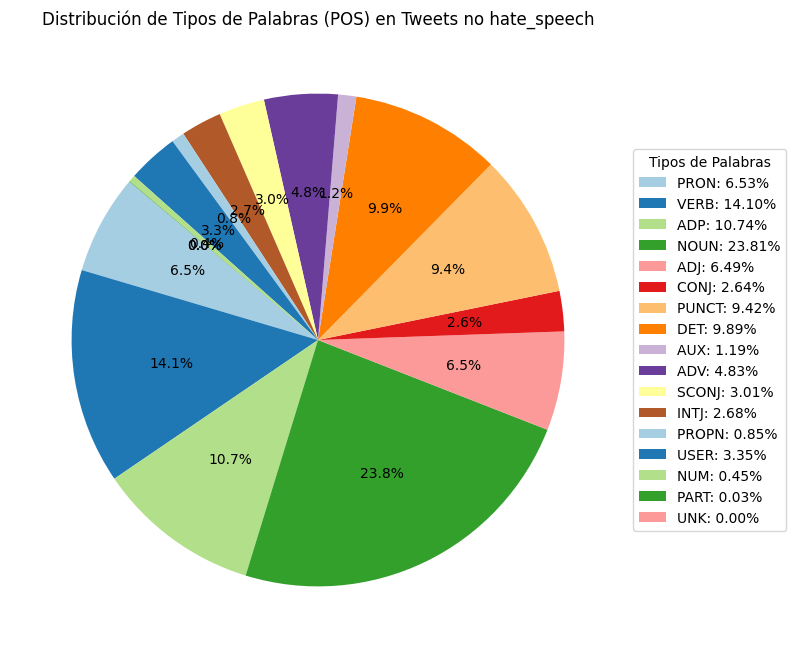

In [114]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(overall_pos_percentages_not_hate_speech.values(),  startangle=140, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
ax.set_title("Distribución de Tipos de Palabras (POS) en Tweets no hate_speech")
legend_labels = [f"{pos_type}: {percentage:.2f}%" for pos_type, percentage in overall_pos_percentages_not_hate_speech.items()]
ax.legend(wedges, legend_labels, title="Tipos de Palabras", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


-----------------------------------------------

### Comparación entre tweets hate_speech y no hate_speech

-----------------------------------------------


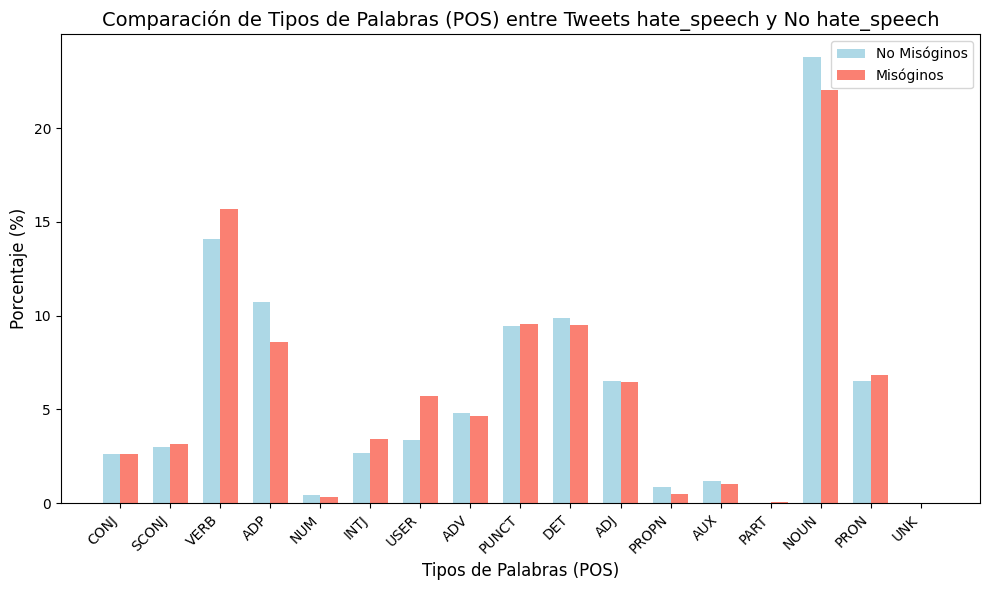

In [115]:

all_pos_tags = list(set(overall_pos_percentages_not_hate_speech.keys()).union(set(overall_pos_percentages_hate_speech.keys())))

not_hate_speech_percentages = [overall_pos_percentages_not_hate_speech.get(tag, 0) for tag in all_pos_tags]
hate_speech_percentages = [overall_pos_percentages_hate_speech.get(tag, 0) for tag in all_pos_tags]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(all_pos_tags))

bar1 = ax.bar(index - bar_width/2, not_hate_speech_percentages, bar_width, label='Not hate speech', color='lightblue')
bar2 = ax.bar(index + bar_width/2, hate_speech_percentages, bar_width, label='Hate speech', color='salmon')

for i, v in enumerate(not_hate_speech_percentages):
  ax.text(index[i] - bar_width/2, v + 0.15, f'{v:.1f}', ha='center', fontsize=9, color='black')
for i, v in enumerate(hate_speech_percentages):
  ax.text(index[i] + bar_width/2, v + 0.15, f'{v:.1f}', ha='center', fontsize=9, color='black')

ax.set_xlabel('Parts of Speech Types', fontsize=18)
ax.set_ylabel('Percentage (%)', fontsize=18)
ax.set_title('Comparison of Parts of Speech Types Percentages (Hate speech vs Not hate speech)', fontsize=18)
ax.set_xticks(index)
ax.set_xticklabels(all_pos_tags, rotation=45, ha='right', fontsize=15)
ax.legend(fontsize=15)

plt.tight_layout()
plt.show()